In [1]:
import os, re
import pandas as pd
import datetime
import nltk
import numpy as np
import gensim
from stop_words import get_stop_words
from nltk.tokenize import PunktSentenceTokenizer
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
from wordcloud import WordCloud
from gensim import corpora, models, similarities 
from gensim.parsing.preprocessing import remove_stopwords
import spacy
import itertools
import warnings
warnings.filterwarnings("ignore")
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline
matplotlib.use('agg')
import itertools
import pickle
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [61]:
stops = nltk.corpus.stopwords.words('english')+['year', 'chine']
rmwords = ['also','datum','compani', 'use','market',
            'busi','custom']

In [62]:
#stops = get_stop_words('en')
#stops = stops +['"s',"'s",'s','can','will','also']

In [63]:
#pt = nltk.stem.PorterStemmer()

In [64]:
nlp = spacy.load('en')#, disable=['parser', 'ner'])

/usr/local/lib/python3.5/dist-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/usr/local/lib/python3.5/dist-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/usr/local/lib/python3.5/dist-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/usr/local/lib/python3.5/dist-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/usr/local/lib/python3.5/dist-packages/msgpack_numpy

/usr/local/lib/python3.5/dist-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/usr/local/lib/python3.5/dist-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/usr/local/lib/python3.5/dist-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/usr/local/lib/python3.5/dist-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/usr/local/lib/python3.5/dist-packages/msgpack_numpy.py:84: DeprecationW

In [33]:
#spacy.load('en')

In [ ]:
rootDir = '../LDA/'
d = {}
wh = []
for dirName, subdirList, fileList in os.walk(rootDir) :
    print('Found directory: %s' % dirName)
    #print(dirName)
    #print(len(fileList))
    c = 0

    if dirName !='../LDA/.ipynb_checkpoints' and dirName != '../LDA/'\
    and dirName != '../LDA/fintech_re':
        print(dirName)
        news_name = dirName.replace('../LDA/','')
        d[news_name] = {}
        c = 0
        for fname in fileList: 
            if fname.endswith(".txt"):  
                filepath = os.path.join(dirName, fname)
                with open(filepath, 'r', -1) as input_file:
                    data = input_file.read()
                    #print(data)
                    if data != '':
                        try:                                
                            if news_name == 'healthitarticle':
                                c+=1
                                date = re.search(r'\w+\s\d{1,2}\,\s\d{4}', data).group(0)
                                date_obj = datetime.strptime(date, '%B %d, %Y')
                                tls = [item for item in data.split('\n') if item != ''and 'tagged' not in item.lower()]
                                body = re.sub(r'\w+\s\d{1,2}\,\s\d{4}\s\-\s+','', tls[3])
                                tls[3] = re.sub('LAS VEGAS – ','', body)
                                whole_text = " ".join(tls[3:]) 
                            if news_name == 'aitho':
                                c+=1
                                if fname == 'aitho_article_1792.txt':
                                    date = re.findall(r'\d{1,2}\s\w+\s\d{4}', data)[1]
                                else:
                                    date = re.search(r'\d{1,2}\s\w+\s\d{4}', data).group(0)
                                date_obj = datetime.strptime(date, '%d %b %Y')
                                tls = [item for item in data.split('\n') if item != '']
                                whole_text = " ".join(tls[2:]) 
                            if news_name == 'fintech':
                                c+=1
                                date = re.search(r'\w+\s\d{1,2}\,\s\d{4}', data).group(0)
                                date_obj = datetime.strptime(date, '%B %d, %Y')
                                tls = [item for item in data.split('\n') if item != '']
                                whole_text = " ".join(tls[2:]) 
                            if news_name == 'reinsu':
                                c +=1
                                date = re.search(r'\d{1,2}\w+\s\w+\s\d{4}', data).group(0)
                                date = re.sub(r'(?<=[0-9])(?:st|nd|rd|th)', '',date)
                                date_obj = datetime.strptime(date, '%d %B %Y')
                                tls = [item for item in data.split('\n') if item != '']
                                whole_text = " ".join(tls[2:]) 

                        except Exception as e:
                            print(news_name, fname)
                            print(e)
            d[news_name][c] = {'date':date_obj, 'text':whole_text, 
                                'whole':tls, 'filepath':filepath}

In [ ]:
#[item for item in data.split('\n') if item != '' and 'tagged' not in item.lower()]
#[item for item in tp if item != '' and 'tagged' not in item.lower()]

In [ ]:
#tp = d['healthitarticle'][1]['whole']
#tp

In [ ]:
temp = {}
for news_name, values1 in d.items():
    for number, values2 in values1.items():
        temp.setdefault('newsname', []).append(news_name)
        temp.setdefault('number', []).append(number)
        for key, value in values2.items():
            #for key, value in date.items():
            temp.setdefault(key, []).append(value)

In [ ]:
df_orig = pd.DataFrame(temp)

In [ ]:
df = df_orig[df_orig['newsname']!='healthitarticle']

In [ ]:
df[['date','newsname','text','whole']].shape[0]

In [ ]:
df_clean = df.drop_duplicates(subset=['date','newsname','text'])

In [ ]:
df_drop = df[df.duplicated(subset=['date','newsname','text'])]

In [ ]:
df_clean['date'] = pd.to_datetime(df_clean['date'])

In [ ]:
df_clean['yr_mnth'] = df_clean['date'].apply(lambda x:x.strftime('%Y-%m'))

In [ ]:
#df_clean

In [ ]:
df_clean['year'] = df_clean['date'].dt.year

In [ ]:
df_clean['month'] = df_clean['date'].dt.month

In [ ]:
df_clean.groupby(['yr_mnth']).count()

In [ ]:
#df_clean.to_csv('insuretech_newspaper_wo_health_yr_mnth.csv', index = False)

In [65]:
df_clean = pd.read_csv('insuretech_newspaper_wo_health_yr_mnth.csv')

In [66]:
text_ls = list(df_clean['text'])

In [67]:
from gensim.parsing.preprocessing import stem_text, strip_punctuation, strip_punctuation2

In [68]:
total_text = text_ls

In [69]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [70]:
def tokenized_gensim(total_text):
    tokenized_text = []
    for k, text_raw in enumerate(total_text):
        text = re.sub('\n', ' ', text_raw, flags= re.IGNORECASE) 
        text = re.sub(r'\((?!k\))(?!b\))(.*?)\)',' ', text, flags= re.IGNORECASE)
        try:
            tokens = [word for sent in nltk.sent_tokenize(text) \
              for word in nltk.word_tokenize(sent) if word.lower() not in stops]              
            filtered_tokens = []
            for token in tokens:
                if re.search('[a-zA-Z]', token):
                    token = re.sub(r'[^\w\s]', '', token)
                    filtered_tokens.append(token.lower())
            stems = [stemmer.stem(t) for t in filtered_tokens if t not in stops]
            stems = [word for word in stems if word not in stops]
            tokenized_text.append(stems)
        except Exception as e:
            print(e)
            print(k)
    return tokenized_text

In [71]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stops] for doc in texts]

def make_bigrams(bigram_mod, texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):#, 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        #print(sent)
        doc = nlp(" ".join(sent))
        #print(doc)
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in stops\
                         and token.lemma_ not in rmwords])
    return texts_out

In [72]:
# Tokenized, remove stop words, stemming the whole texts
%time data_words = tokenized_gensim(total_text)

CPU times: user 54.5 s, sys: 44.2 ms, total: 54.5 s
Wall time: 54.5 s


In [73]:
# Build the bigram and trigram models
%time bigram = gensim.models.Phrases(data_words,\
                                     min_count=5, threshold=5) 
# higher threshold fewer phrases.
%time trigram = gensim.models.Phrases(bigram[data_words], threshold=5)  

# Faster way to get a sentence clubbed as a trigram/bigram
%time bigram_mod = gensim.models.phrases.Phraser(bigram)
%time trigram_mod = gensim.models.phrases.Phraser(trigram)

2018-07-20 09:28:32,524 : INFO : collecting all words and their counts
2018-07-20 09:28:32,526 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-07-20 09:28:34,957 : INFO : collected 621189 word types from a corpus of 1063948 words (unigram + bigrams) and 3319 sentences
2018-07-20 09:28:34,958 : INFO : using 621189 counts as vocab in Phrases<0 vocab, min_count=5, threshold=5, max_vocab_size=40000000>
2018-07-20 09:28:34,997 : INFO : collecting all words and their counts
2018-07-20 09:28:34,999 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types


CPU times: user 2.46 s, sys: 11.1 ms, total: 2.47 s
Wall time: 2.47 s


2018-07-20 09:28:42,944 : INFO : collected 688831 word types from a corpus of 952012 words (unigram + bigrams) and 3319 sentences
2018-07-20 09:28:42,945 : INFO : using 688831 counts as vocab in Phrases<0 vocab, min_count=5, threshold=5, max_vocab_size=40000000>
2018-07-20 09:28:42,988 : INFO : source_vocab length 621189


CPU times: user 7.97 s, sys: 21.2 ms, total: 7.99 s
Wall time: 7.99 s


2018-07-20 09:28:51,614 : INFO : Phraser built with 6240 6240 phrasegrams
2018-07-20 09:28:51,621 : INFO : source_vocab length 688831


CPU times: user 8.63 s, sys: 2.92 ms, total: 8.63 s
Wall time: 8.63 s


2018-07-20 09:29:03,325 : INFO : Phraser built with 8658 8658 phrasegrams


CPU times: user 11.7 s, sys: 0 ns, total: 11.7 s
Wall time: 11.7 s


In [74]:
# Remove Stop Words
%time data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
%time data_words_bigrams = make_bigrams(bigram_mod, data_words_nostops)

CPU times: user 5.11 s, sys: 61.7 ms, total: 5.17 s
Wall time: 5.17 s
CPU times: user 3.53 s, sys: 52.6 ms, total: 3.59 s
Wall time: 3.58 s


In [75]:
# Form Trigrams
%time data_words_trigrams = make_trigrams(data_words_nostops)

CPU times: user 6.91 s, sys: 34.6 ms, total: 6.95 s
Wall time: 6.95 s


In [76]:
#len(data_lemmatized_tri[100])

In [77]:
# # Do lemmatization keeping only noun, adj, vb, adv
# print(datetime.now())
# %time data_lemmatized = lemmatization(data_words_bigrams,\
#                                       allowed_postags=['NOUN'])#, 'ADJ', 'VERB', 'ADV'])
# print(datetime.now())

In [78]:
# Do lemmatization keeping only noun, adj, vb, adv with tri
print(datetime.now())
%time data_lemmatized_tri = lemmatization(data_words_trigrams,\
                                      allowed_postags=['NOUN'])
print(datetime.now())

2018-07-20 09:29:19.089640
CPU times: user 23min 20s, sys: 47min 57s, total: 1h 11min 18s
Wall time: 4min 27s
2018-07-20 09:33:47.016647


In [79]:
print(datetime.now())
#create a Gensim dictionary from the texts
%time dictionary= corpora.Dictionary(data_lemmatized_tri)

print(datetime.now())
#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
%time dictionary.filter_extremes(no_below=2, no_above=0.6)
print(datetime.now())

2018-07-20 09:33:47,027 : INFO : adding document #0 to Dictionary(0 unique tokens: [])


2018-07-20 09:33:47.025351


2018-07-20 09:33:47,703 : INFO : built Dictionary(32037 unique tokens: ['backbas', 'goldbeck', 'headup', 'aaai', 'privatis']...) from 3319 documents (total 522956 corpus positions)
2018-07-20 09:33:47,780 : INFO : discarding 16446 tokens: [('technolog', 2081), ('iwoca', 1), ('much_higher', 1), ('riech', 1), ('tharmarajah', 1), ('thinfil', 1), ('reregist', 1), ('davdra', 1), ('paresh', 1), ('ayear', 1)]...
2018-07-20 09:33:47,781 : INFO : keeping 15591 tokens which were in no less than 2 and no more than 1991 (=60.0%) documents
2018-07-20 09:33:47,805 : INFO : resulting dictionary: Dictionary(15591 unique tokens: ['backbas', 'secondari_market', 'spend_manag', 'soul', 'stanc']...)


CPU times: user 1.02 s, sys: 971 ms, total: 1.99 s
Wall time: 677 ms
2018-07-20 09:33:47.704814
CPU times: user 99.9 ms, sys: 4.75 ms, total: 105 ms
Wall time: 102 ms
2018-07-20 09:33:47.808252


In [80]:
dicls = list(dictionary.values())

In [81]:
#convert the dictionary to a bag of words corpus for reference
%time corpus = [dictionary.doc2bow(text) for text in data_lemmatized_tri]

CPU times: user 455 ms, sys: 10.2 ms, total: 465 ms
Wall time: 464 ms


In [82]:
#data_lemmatized_tri[0]

In [181]:
####### LDA model
print(datetime.now())
%time ldamodel = models.LdaModel(corpus, num_topics=12, \
                                   id2word=dictionary, update_every=1,\
                                 chunksize=750, passes=30)
print(datetime.now())

2018-07-20 13:39:03,500 : INFO : using symmetric alpha at 0.08333333333333333
2018-07-20 13:39:03,502 : INFO : using symmetric eta at 0.08333333333333333
2018-07-20 13:39:03,506 : INFO : using serial LDA version on this node
2018-07-20 13:39:03,534 : INFO : running online (multi-pass) LDA training, 12 topics, 30 passes over the supplied corpus of 3319 documents, updating model once every 750 documents, evaluating perplexity every 3319 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-20 13:39:03,535 : INFO : PROGRESS: pass 0, at document #750/3319


2018-07-20 13:39:03.498683


2018-07-20 13:39:04,261 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 13:39:04,287 : INFO : topic #3 (0.083): 0.009*"payment" + 0.008*"bank" + 0.007*"product" + 0.006*"innov" + 0.006*"transact" + 0.005*"peopl" + 0.005*"digit" + 0.005*"platform" + 0.005*"access" + 0.005*"manag"
2018-07-20 13:39:04,289 : INFO : topic #9 (0.083): 0.009*"bank" + 0.007*"blockchain" + 0.007*"investor" + 0.006*"trade" + 0.006*"regul" + 0.006*"work" + 0.006*"platform" + 0.005*"innov" + 0.005*"fund" + 0.004*"payment"
2018-07-20 13:39:04,290 : INFO : topic #10 (0.083): 0.010*"bank" + 0.006*"work" + 0.006*"product" + 0.005*"investor" + 0.005*"fintech" + 0.005*"innov" + 0.005*"platform" + 0.005*"financ" + 0.005*"servic" + 0.004*"peopl"
2018-07-20 13:39:04,292 : INFO : topic #6 (0.083): 0.010*"payment" + 0.010*"bank" + 0.007*"investor" + 0.007*"user" + 0.006*"fintech" + 0.005*"work" + 0.005*"process" + 0.005*"world" + 0.005*"innov" + 0.005*"consum"
2018-07-20 13:39:04,294 : I

2018-07-20 13:39:08,536 : INFO : topic #10 (0.083): 0.015*"game" + 0.013*"drone" + 0.008*"vehicl" + 0.006*"product" + 0.006*"car" + 0.005*"design" + 0.005*"summit" + 0.005*"work" + 0.005*"dealer" + 0.005*"platform"
2018-07-20 13:39:08,537 : INFO : topic #2 (0.083): 0.013*"platform" + 0.011*"team" + 0.009*"partner" + 0.008*"innov" + 0.007*"servic" + 0.007*"system" + 0.007*"product" + 0.006*"manag" + 0.006*"user" + 0.006*"process"
2018-07-20 13:39:08,539 : INFO : topic #8 (0.083): 0.009*"innov" + 0.007*"risk" + 0.007*"system" + 0.007*"work" + 0.006*"regul" + 0.006*"platform" + 0.006*"bank" + 0.006*"fintech" + 0.005*"manag" + 0.005*"peopl"
2018-07-20 13:39:08,541 : INFO : topic #5 (0.083): 0.008*"design" + 0.008*"attack" + 0.008*"network" + 0.007*"process" + 0.007*"vision" + 0.007*"system" + 0.006*"test" + 0.006*"cloud" + 0.005*"bank" + 0.005*"account"
2018-07-20 13:39:08,543 : INFO : topic #1 (0.083): 0.009*"blockchain" + 0.008*"innov" + 0.008*"peopl" + 0.007*"work" + 0.006*"digit" + 0.0

2018-07-20 13:39:12,123 : INFO : topic #5 (0.083): 0.014*"network" + 0.013*"test" + 0.012*"system" + 0.011*"attack" + 0.011*"design" + 0.010*"cloud" + 0.007*"process" + 0.007*"threat" + 0.007*"vision" + 0.006*"autom"
2018-07-20 13:39:12,124 : INFO : topic #9 (0.083): 0.029*"blockchain" + 0.018*"cryptocurr" + 0.016*"platform" + 0.015*"investor" + 0.013*"trade" + 0.010*"transact" + 0.009*"blockchain_technolog" + 0.009*"exchang" + 0.009*"fund" + 0.008*"project"
2018-07-20 13:39:12,127 : INFO : topic #11 (0.083): 0.025*"platform" + 0.011*"product" + 0.010*"manag" + 0.007*"autom" + 0.007*"servic" + 0.007*"capabl" + 0.006*"video" + 0.006*"enterpris" + 0.006*"insight" + 0.006*"process"
2018-07-20 13:39:12,128 : INFO : topic #1 (0.083): 0.008*"peopl" + 0.007*"innov" + 0.007*"blockchain" + 0.007*"design" + 0.007*"work" + 0.006*"educ" + 0.006*"world" + 0.005*"child" + 0.005*"test" + 0.005*"student"
2018-07-20 13:39:12,130 : INFO : topic diff=0.351460, rho=0.366980
2018-07-20 13:39:12,131 : INFO 

2018-07-20 13:39:15,494 : INFO : topic #1 (0.083): 0.009*"peopl" + 0.009*"educ" + 0.008*"student" + 0.007*"work" + 0.007*"design" + 0.007*"world" + 0.006*"innov" + 0.006*"child" + 0.006*"communiti" + 0.005*"blockchain"
2018-07-20 13:39:15,495 : INFO : topic #6 (0.083): 0.045*"app" + 0.035*"user" + 0.011*"payment" + 0.006*"servic" + 0.006*"consum" + 0.006*"devic" + 0.006*"music" + 0.006*"featur" + 0.005*"phone" + 0.005*"wallet"
2018-07-20 13:39:15,497 : INFO : topic #10 (0.083): 0.019*"drone" + 0.017*"vehicl" + 0.016*"game" + 0.012*"sensor" + 0.009*"car" + 0.009*"mobil" + 0.008*"design" + 0.007*"system" + 0.007*"display" + 0.007*"oper"
2018-07-20 13:39:15,498 : INFO : topic #4 (0.083): 0.013*"innov" + 0.012*"robot" + 0.011*"research" + 0.009*"product" + 0.009*"work" + 0.008*"team" + 0.007*"support" + 0.007*"partner" + 0.007*"artifici_intellig" + 0.007*"collabor"
2018-07-20 13:39:15,500 : INFO : topic diff=0.195623, rho=0.344514
2018-07-20 13:39:15,861 : INFO : -8.015 per-word bound, 258

2018-07-20 13:39:18,697 : INFO : topic #1 (0.083): 0.016*"educ" + 0.012*"student" + 0.010*"peopl" + 0.008*"world" + 0.007*"design" + 0.007*"work" + 0.007*"woman" + 0.006*"stroke" + 0.006*"communiti" + 0.005*"innov"
2018-07-20 13:39:18,700 : INFO : topic #3 (0.083): 0.016*"person" + 0.013*"consum" + 0.011*"bank" + 0.009*"payment" + 0.008*"sale" + 0.008*"account" + 0.008*"digit" + 0.007*"servic" + 0.007*"email" + 0.006*"product"
2018-07-20 13:39:18,701 : INFO : topic #10 (0.083): 0.021*"drone" + 0.018*"vehicl" + 0.018*"game" + 0.012*"sensor" + 0.009*"car" + 0.009*"mobil" + 0.008*"design" + 0.008*"oper" + 0.007*"system" + 0.007*"display"
2018-07-20 13:39:18,704 : INFO : topic #2 (0.083): 0.015*"platform" + 0.013*"partner" + 0.012*"team" + 0.011*"servic" + 0.009*"innov" + 0.008*"manag" + 0.008*"china" + 0.007*"support" + 0.007*"product" + 0.007*"enterpris"
2018-07-20 13:39:18,706 : INFO : topic diff=0.142242, rho=0.325725
2018-07-20 13:39:18,707 : INFO : PROGRESS: pass 5, at document #750/

2018-07-20 13:39:21,751 : INFO : topic #9 (0.083): 0.033*"blockchain" + 0.022*"platform" + 0.019*"cryptocurr" + 0.016*"investor" + 0.013*"trade" + 0.012*"transact" + 0.010*"blockchain_technolog" + 0.010*"exchang" + 0.010*"fund" + 0.009*"project"
2018-07-20 13:39:21,752 : INFO : topic #0 (0.083): 0.033*"brand" + 0.019*"consum" + 0.013*"content" + 0.011*"product" + 0.009*"work" + 0.007*"audienc" + 0.007*"search" + 0.007*"social_media" + 0.006*"client" + 0.006*"way"
2018-07-20 13:39:21,754 : INFO : topic #8 (0.083): 0.011*"bank" + 0.009*"regul" + 0.007*"work" + 0.007*"risk" + 0.007*"innov" + 0.006*"process" + 0.006*"system" + 0.006*"client" + 0.006*"time" + 0.005*"peopl"
2018-07-20 13:39:21,755 : INFO : topic #10 (0.083): 0.020*"drone" + 0.019*"game" + 0.019*"vehicl" + 0.012*"sensor" + 0.010*"car" + 0.009*"mobil" + 0.008*"design" + 0.008*"oper" + 0.007*"system" + 0.007*"sport"
2018-07-20 13:39:21,756 : INFO : topic diff=0.212974, rho=0.295846
2018-07-20 13:39:21,758 : INFO : PROGRESS: pas

2018-07-20 13:39:24,733 : INFO : topic #3 (0.083): 0.020*"bank" + 0.017*"payment" + 0.013*"consum" + 0.013*"person" + 0.011*"account" + 0.009*"digit" + 0.009*"transact" + 0.008*"servic" + 0.007*"sale" + 0.006*"onlin"
2018-07-20 13:39:24,735 : INFO : topic #6 (0.083): 0.046*"app" + 0.033*"user" + 0.016*"payment" + 0.010*"travel" + 0.009*"card" + 0.008*"servic" + 0.007*"mobil" + 0.007*"music" + 0.007*"home" + 0.007*"pay"
2018-07-20 13:39:24,736 : INFO : topic #2 (0.083): 0.016*"platform" + 0.015*"partner" + 0.013*"team" + 0.012*"servic" + 0.009*"manag" + 0.009*"china" + 0.008*"innov" + 0.008*"support" + 0.008*"product" + 0.007*"enterpris"
2018-07-20 13:39:24,737 : INFO : topic diff=0.124311, rho=0.283691
2018-07-20 13:39:24,739 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 13:39:25,174 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 13:39:25,200 : INFO : topic #11 (0.083): 0.027*"platform" + 0.012*"manag" + 0.011*"product" + 0.008*"aut

2018-07-20 13:39:27,643 : INFO : topic #10 (0.083): 0.018*"drone" + 0.018*"vehicl" + 0.017*"game" + 0.011*"sensor" + 0.011*"car" + 0.009*"mobil" + 0.009*"design" + 0.008*"system" + 0.008*"oper" + 0.007*"display"
2018-07-20 13:39:27,644 : INFO : topic #8 (0.083): 0.009*"bank" + 0.009*"risk" + 0.008*"regul" + 0.007*"innov" + 0.007*"process" + 0.007*"work" + 0.006*"client" + 0.006*"system" + 0.006*"time" + 0.005*"report"
2018-07-20 13:39:27,646 : INFO : topic #9 (0.083): 0.035*"blockchain" + 0.022*"platform" + 0.019*"cryptocurr" + 0.015*"investor" + 0.013*"trade" + 0.012*"transact" + 0.011*"blockchain_technolog" + 0.010*"exchang" + 0.009*"project" + 0.009*"fund"
2018-07-20 13:39:27,647 : INFO : topic diff=0.136828, rho=0.272921
2018-07-20 13:39:27,648 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 13:39:28,087 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 13:39:28,113 : INFO : topic #1 (0.083): 0.013*"educ" + 0.012*"peopl" + 0.011*"stu

2018-07-20 13:39:30,540 : INFO : topic #9 (0.083): 0.038*"blockchain" + 0.023*"platform" + 0.019*"cryptocurr" + 0.014*"investor" + 0.013*"trade" + 0.012*"transact" + 0.012*"blockchain_technolog" + 0.010*"exchang" + 0.009*"project" + 0.008*"fund"
2018-07-20 13:39:30,541 : INFO : topic #4 (0.083): 0.014*"innov" + 0.013*"robot" + 0.012*"research" + 0.011*"product" + 0.009*"work" + 0.009*"team" + 0.007*"support" + 0.007*"artifici_intellig" + 0.007*"collabor" + 0.007*"partner"
2018-07-20 13:39:30,543 : INFO : topic diff=0.098833, rho=0.263292
2018-07-20 13:39:30,884 : INFO : -7.934 per-word bound, 244.6 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 13:39:30,885 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 13:39:31,053 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 13:39:31,078 : INFO : topic #2 (0.083): 0.017*"platform" + 0.015*"partner" + 0.013*"servic" + 0.012*"team" + 0.010*"manag" + 0.00

2018-07-20 13:39:33,484 : INFO : topic #4 (0.083): 0.015*"robot" + 0.014*"innov" + 0.012*"research" + 0.012*"product" + 0.009*"work" + 0.009*"team" + 0.008*"partner" + 0.007*"support" + 0.007*"artifici_intellig" + 0.007*"collabor"
2018-07-20 13:39:33,486 : INFO : topic #7 (0.083): 0.023*"innov" + 0.021*"event" + 0.013*"fintech" + 0.012*"bank" + 0.011*"summit" + 0.010*"digit" + 0.010*"startup" + 0.009*"london" + 0.008*"world" + 0.008*"citi"
2018-07-20 13:39:33,488 : INFO : topic diff=0.084626, rho=0.254614
2018-07-20 13:39:33,490 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 13:39:33,923 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 13:39:33,949 : INFO : topic #0 (0.083): 0.037*"brand" + 0.021*"content" + 0.020*"consum" + 0.012*"product" + 0.009*"audienc" + 0.008*"work" + 0.008*"search" + 0.008*"social_media" + 0.008*"ad" + 0.007*"medium"
2018-07-20 13:39:33,950 : INFO : topic #2 (0.083): 0.017*"platform" + 0.015*"partner" + 0.013*"

2018-07-20 13:39:36,369 : INFO : topic #8 (0.083): 0.011*"bank" + 0.009*"regul" + 0.007*"risk" + 0.007*"process" + 0.007*"work" + 0.007*"innov" + 0.006*"client" + 0.006*"time" + 0.006*"system" + 0.006*"financi"
2018-07-20 13:39:36,370 : INFO : topic diff=0.154815, rho=0.239557
2018-07-20 13:39:36,372 : INFO : PROGRESS: pass 12, at document #1500/3319
2018-07-20 13:39:36,796 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 13:39:36,822 : INFO : topic #10 (0.083): 0.020*"drone" + 0.019*"vehicl" + 0.016*"game" + 0.012*"sensor" + 0.011*"car" + 0.009*"mobil" + 0.008*"design" + 0.008*"oper" + 0.008*"system" + 0.007*"featur"
2018-07-20 13:39:36,823 : INFO : topic #4 (0.083): 0.015*"innov" + 0.012*"product" + 0.012*"robot" + 0.010*"research" + 0.009*"work" + 0.009*"team" + 0.008*"partner" + 0.008*"support" + 0.008*"partnership" + 0.007*"collabor"
2018-07-20 13:39:36,825 : INFO : topic #3 (0.083): 0.021*"bank" + 0.019*"payment" + 0.015*"consum" + 0.014*"pers

2018-07-20 13:39:39,220 : INFO : topic diff=0.092442, rho=0.232966
2018-07-20 13:39:39,221 : INFO : PROGRESS: pass 13, at document #2250/3319
2018-07-20 13:39:39,633 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 13:39:39,659 : INFO : topic #8 (0.083): 0.009*"bank" + 0.009*"risk" + 0.009*"regul" + 0.007*"innov" + 0.007*"process" + 0.007*"work" + 0.006*"client" + 0.006*"time" + 0.006*"system" + 0.005*"report"
2018-07-20 13:39:39,660 : INFO : topic #4 (0.083): 0.015*"innov" + 0.014*"robot" + 0.012*"product" + 0.011*"research" + 0.009*"work" + 0.009*"team" + 0.008*"support" + 0.008*"partner" + 0.007*"partnership" + 0.007*"collabor"
2018-07-20 13:39:39,661 : INFO : topic #0 (0.083): 0.037*"brand" + 0.022*"consum" + 0.020*"content" + 0.012*"product" + 0.009*"ad" + 0.009*"audienc" + 0.008*"work" + 0.008*"search" + 0.008*"medium" + 0.007*"social_media"
2018-07-20 13:39:39,663 : INFO : topic #3 (0.083): 0.019*"bank" + 0.018*"payment" + 0.016*"consum" + 0.

2018-07-20 13:39:42,057 : INFO : topic diff=0.101351, rho=0.226890
2018-07-20 13:39:42,058 : INFO : PROGRESS: pass 14, at document #3000/3319
2018-07-20 13:39:42,485 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 13:39:42,511 : INFO : topic #11 (0.083): 0.027*"platform" + 0.012*"manag" + 0.010*"product" + 0.009*"autom" + 0.008*"insight" + 0.008*"process" + 0.007*"enterpris" + 0.007*"capabl" + 0.007*"intellig" + 0.007*"power"
2018-07-20 13:39:42,513 : INFO : topic #7 (0.083): 0.023*"innov" + 0.020*"event" + 0.015*"fintech" + 0.013*"bank" + 0.011*"london" + 0.010*"digit" + 0.010*"startup" + 0.008*"citi" + 0.008*"world" + 0.008*"summit"
2018-07-20 13:39:42,515 : INFO : topic #0 (0.083): 0.039*"brand" + 0.023*"content" + 0.022*"consum" + 0.012*"product" + 0.010*"audienc" + 0.010*"ad" + 0.009*"search" + 0.008*"medium" + 0.008*"social_media" + 0.008*"work"
2018-07-20 13:39:42,517 : INFO : topic #8 (0.083): 0.009*"bank" + 0.008*"regul" + 0.008*"risk" + 0

2018-07-20 13:39:45,226 : INFO : PROGRESS: pass 15, at document #3319/3319
2018-07-20 13:39:45,392 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 13:39:45,417 : INFO : topic #1 (0.083): 0.017*"educ" + 0.013*"student" + 0.013*"peopl" + 0.011*"woman" + 0.010*"world" + 0.009*"design" + 0.008*"work" + 0.007*"univer" + 0.007*"communiti" + 0.006*"creat"
2018-07-20 13:39:45,419 : INFO : topic #7 (0.083): 0.023*"innov" + 0.021*"event" + 0.014*"fintech" + 0.011*"bank" + 0.011*"summit" + 0.010*"startup" + 0.010*"digit" + 0.010*"london" + 0.008*"world" + 0.008*"citi"
2018-07-20 13:39:45,420 : INFO : topic #8 (0.083): 0.008*"bank" + 0.008*"regul" + 0.008*"risk" + 0.007*"process" + 0.007*"innov" + 0.007*"work" + 0.006*"client" + 0.006*"system" + 0.006*"report" + 0.006*"time"
2018-07-20 13:39:45,421 : INFO : topic #4 (0.083): 0.015*"robot" + 0.014*"innov" + 0.012*"research" + 0.012*"product" + 0.009*"work" + 0.009*"team" + 0.007*"partner" + 0.007*"support" + 0.

2018-07-20 13:39:48,259 : INFO : topic #8 (0.083): 0.011*"bank" + 0.009*"regul" + 0.007*"risk" + 0.007*"process" + 0.007*"innov" + 0.007*"work" + 0.006*"client" + 0.006*"time" + 0.006*"system" + 0.006*"financi"
2018-07-20 13:39:48,260 : INFO : topic #3 (0.083): 0.020*"bank" + 0.020*"payment" + 0.016*"consum" + 0.015*"person" + 0.013*"account" + 0.010*"servic" + 0.009*"transact" + 0.009*"digit" + 0.008*"sale" + 0.007*"financi"
2018-07-20 13:39:48,262 : INFO : topic #6 (0.083): 0.048*"app" + 0.035*"user" + 0.012*"payment" + 0.011*"travel" + 0.010*"mobil" + 0.008*"home" + 0.008*"servic" + 0.008*"game" + 0.007*"card" + 0.007*"access"
2018-07-20 13:39:48,263 : INFO : topic #1 (0.083): 0.016*"educ" + 0.014*"peopl" + 0.012*"woman" + 0.011*"student" + 0.010*"world" + 0.009*"design" + 0.009*"work" + 0.007*"communiti" + 0.007*"univer" + 0.006*"creat"
2018-07-20 13:39:48,265 : INFO : topic #0 (0.083): 0.038*"brand" + 0.025*"content" + 0.020*"consum" + 0.013*"product" + 0.010*"audienc" + 0.009*"ad

2018-07-20 13:39:51,067 : INFO : topic #2 (0.083): 0.018*"platform" + 0.016*"partner" + 0.014*"servic" + 0.013*"team" + 0.011*"manag" + 0.010*"china" + 0.009*"innov" + 0.009*"support" + 0.007*"enterpris" + 0.007*"product"
2018-07-20 13:39:51,068 : INFO : topic #0 (0.083): 0.033*"brand" + 0.021*"content" + 0.021*"consum" + 0.013*"product" + 0.009*"ad" + 0.009*"audienc" + 0.009*"search" + 0.008*"work" + 0.008*"social_media" + 0.007*"medium"
2018-07-20 13:39:51,070 : INFO : topic #3 (0.083): 0.022*"bank" + 0.020*"payment" + 0.016*"consum" + 0.014*"person" + 0.013*"account" + 0.010*"servic" + 0.010*"transact" + 0.009*"digit" + 0.008*"sale" + 0.007*"financi"
2018-07-20 13:39:51,072 : INFO : topic #8 (0.083): 0.010*"bank" + 0.009*"regul" + 0.009*"risk" + 0.008*"innov" + 0.007*"process" + 0.007*"work" + 0.006*"client" + 0.006*"time" + 0.006*"system" + 0.005*"sector"
2018-07-20 13:39:51,073 : INFO : topic #5 (0.083): 0.027*"network" + 0.026*"system" + 0.022*"cloud" + 0.013*"attack" + 0.013*"te

2018-07-20 13:39:53,910 : INFO : topic #2 (0.083): 0.019*"platform" + 0.015*"partner" + 0.014*"servic" + 0.013*"team" + 0.010*"china" + 0.010*"manag" + 0.009*"innov" + 0.009*"support" + 0.007*"product" + 0.007*"enterpris"
2018-07-20 13:39:53,911 : INFO : topic #0 (0.083): 0.038*"brand" + 0.024*"content" + 0.022*"consum" + 0.013*"product" + 0.010*"ad" + 0.010*"audienc" + 0.008*"search" + 0.008*"medium" + 0.008*"engag" + 0.007*"work"
2018-07-20 13:39:53,913 : INFO : topic #9 (0.083): 0.037*"blockchain" + 0.023*"platform" + 0.019*"cryptocurr" + 0.014*"investor" + 0.013*"trade" + 0.012*"transact" + 0.012*"blockchain_technolog" + 0.011*"exchang" + 0.010*"project" + 0.008*"fund"
2018-07-20 13:39:53,914 : INFO : topic #10 (0.083): 0.019*"drone" + 0.019*"vehicl" + 0.015*"game" + 0.012*"sensor" + 0.011*"car" + 0.009*"mobil" + 0.009*"system" + 0.009*"design" + 0.008*"oper" + 0.007*"camera"
2018-07-20 13:39:53,916 : INFO : topic diff=0.086399, rho=0.202339
2018-07-20 13:39:53,917 : INFO : PROGRES

2018-07-20 13:39:56,701 : INFO : topic #11 (0.083): 0.027*"platform" + 0.012*"manag" + 0.010*"product" + 0.009*"autom" + 0.008*"process" + 0.008*"insight" + 0.008*"intellig" + 0.008*"capabl" + 0.008*"enterpris" + 0.007*"power"
2018-07-20 13:39:56,703 : INFO : topic #5 (0.083): 0.026*"network" + 0.026*"system" + 0.022*"cloud" + 0.013*"test" + 0.012*"iot" + 0.011*"attack" + 0.011*"devic" + 0.010*"design" + 0.009*"comput" + 0.008*"threat"
2018-07-20 13:39:56,705 : INFO : topic #4 (0.083): 0.015*"innov" + 0.013*"robot" + 0.012*"research" + 0.011*"product" + 0.009*"work" + 0.009*"team" + 0.007*"support" + 0.007*"collabor" + 0.007*"artifici_intellig" + 0.007*"partner"
2018-07-20 13:39:56,706 : INFO : topic diff=0.070027, rho=0.198320
2018-07-20 13:39:57,039 : INFO : -7.904 per-word bound, 239.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 13:39:57,039 : INFO : PROGRESS: pass 20, at document #3319/3319
2018-07-20 13:39:57,200 : INFO : merging cha

2018-07-20 13:39:59,565 : INFO : topic #3 (0.083): 0.017*"consum" + 0.017*"person" + 0.016*"bank" + 0.015*"payment" + 0.012*"account" + 0.010*"servic" + 0.009*"sale" + 0.009*"digit" + 0.009*"transact" + 0.008*"chatbot"
2018-07-20 13:39:59,566 : INFO : topic #4 (0.083): 0.014*"robot" + 0.014*"innov" + 0.012*"product" + 0.012*"research" + 0.009*"work" + 0.009*"team" + 0.007*"partner" + 0.007*"support" + 0.007*"artifici_intellig" + 0.007*"collabor"
2018-07-20 13:39:59,568 : INFO : topic #1 (0.083): 0.017*"educ" + 0.013*"peopl" + 0.013*"student" + 0.011*"woman" + 0.010*"world" + 0.009*"design" + 0.009*"work" + 0.007*"univer" + 0.007*"communiti" + 0.006*"train"
2018-07-20 13:39:59,569 : INFO : topic diff=0.060851, rho=0.194531
2018-07-20 13:39:59,570 : INFO : PROGRESS: pass 22, at document #750/3319
2018-07-20 13:39:59,998 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 13:40:00,024 : INFO : topic #9 (0.083): 0.037*"blockchain" + 0.024*"platform" + 0.02

2018-07-20 13:40:02,378 : INFO : topic #2 (0.083): 0.018*"platform" + 0.016*"partner" + 0.014*"servic" + 0.013*"team" + 0.011*"manag" + 0.010*"china" + 0.009*"innov" + 0.009*"support" + 0.008*"enterpris" + 0.007*"product"
2018-07-20 13:40:02,380 : INFO : topic #6 (0.083): 0.049*"app" + 0.036*"user" + 0.011*"travel" + 0.011*"payment" + 0.011*"mobil" + 0.008*"game" + 0.008*"home" + 0.008*"servic" + 0.006*"access" + 0.006*"featur"
2018-07-20 13:40:02,381 : INFO : topic #5 (0.083): 0.027*"network" + 0.027*"system" + 0.023*"cloud" + 0.013*"attack" + 0.013*"test" + 0.012*"iot" + 0.010*"devic" + 0.009*"comput" + 0.009*"design" + 0.009*"threat"
2018-07-20 13:40:02,382 : INFO : topic diff=0.114448, rho=0.187563
2018-07-20 13:40:02,384 : INFO : PROGRESS: pass 23, at document #1500/3319
2018-07-20 13:40:02,800 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 13:40:02,826 : INFO : topic #3 (0.083): 0.022*"bank" + 0.021*"payment" + 0.016*"consum" + 0.014*"person

2018-07-20 13:40:05,144 : INFO : topic #1 (0.083): 0.015*"educ" + 0.014*"peopl" + 0.012*"woman" + 0.011*"student" + 0.010*"world" + 0.010*"design" + 0.009*"work" + 0.007*"communiti" + 0.007*"univer" + 0.006*"creat"
2018-07-20 13:40:05,146 : INFO : topic #4 (0.083): 0.015*"innov" + 0.012*"robot" + 0.012*"product" + 0.011*"research" + 0.010*"work" + 0.009*"team" + 0.008*"partner" + 0.008*"support" + 0.008*"partnership" + 0.007*"collabor"
2018-07-20 13:40:05,148 : INFO : topic diff=0.070224, rho=0.184348
2018-07-20 13:40:05,149 : INFO : PROGRESS: pass 24, at document #2250/3319
2018-07-20 13:40:05,564 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 13:40:05,590 : INFO : topic #11 (0.083): 0.028*"platform" + 0.012*"manag" + 0.011*"product" + 0.009*"autom" + 0.008*"process" + 0.008*"insight" + 0.008*"intellig" + 0.008*"enterpris" + 0.008*"capabl" + 0.007*"power"
2018-07-20 13:40:05,591 : INFO : topic #8 (0.083): 0.010*"bank" + 0.009*"regul" + 0.008*"ris

2018-07-20 13:40:07,928 : INFO : topic #0 (0.083): 0.038*"brand" + 0.025*"content" + 0.022*"consum" + 0.014*"product" + 0.011*"ad" + 0.010*"audienc" + 0.009*"search" + 0.009*"medium" + 0.008*"engag" + 0.008*"social_media"
2018-07-20 13:40:07,929 : INFO : topic #2 (0.083): 0.019*"platform" + 0.016*"partner" + 0.014*"servic" + 0.013*"team" + 0.010*"china" + 0.010*"manag" + 0.010*"innov" + 0.009*"support" + 0.007*"enterpris" + 0.007*"product"
2018-07-20 13:40:07,931 : INFO : topic diff=0.074729, rho=0.181294
2018-07-20 13:40:07,932 : INFO : PROGRESS: pass 25, at document #3000/3319
2018-07-20 13:40:08,348 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 13:40:08,375 : INFO : topic #3 (0.083): 0.018*"bank" + 0.017*"payment" + 0.017*"consum" + 0.015*"person" + 0.013*"account" + 0.010*"servic" + 0.009*"transact" + 0.009*"sale" + 0.009*"digit" + 0.008*"chatbot"
2018-07-20 13:40:08,376 : INFO : topic #1 (0.083): 0.014*"educ" + 0.013*"peopl" + 0.011*"woman" 

2018-07-20 13:40:10,699 : INFO : topic #9 (0.083): 0.039*"blockchain" + 0.024*"platform" + 0.019*"cryptocurr" + 0.013*"investor" + 0.013*"trade" + 0.012*"transact" + 0.012*"blockchain_technolog" + 0.011*"exchang" + 0.009*"project" + 0.009*"network"
2018-07-20 13:40:10,700 : INFO : topic #4 (0.083): 0.015*"innov" + 0.013*"robot" + 0.012*"product" + 0.012*"research" + 0.009*"work" + 0.009*"team" + 0.007*"support" + 0.007*"collabor" + 0.007*"partner" + 0.007*"artifici_intellig"
2018-07-20 13:40:10,702 : INFO : topic diff=0.062346, rho=0.178386
2018-07-20 13:40:11,045 : INFO : -7.897 per-word bound, 238.3 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 13:40:11,046 : INFO : PROGRESS: pass 26, at document #3319/3319
2018-07-20 13:40:11,203 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 13:40:11,229 : INFO : topic #2 (0.083): 0.018*"platform" + 0.017*"partner" + 0.015*"servic" + 0.012*"team" + 0.011*"manag" + 

2018-07-20 13:40:13,569 : INFO : topic #0 (0.083): 0.042*"brand" + 0.030*"content" + 0.021*"consum" + 0.014*"product" + 0.012*"ad" + 0.011*"audienc" + 0.009*"search" + 0.009*"medium" + 0.008*"engag" + 0.008*"social_media"
2018-07-20 13:40:13,570 : INFO : topic #3 (0.083): 0.017*"consum" + 0.017*"bank" + 0.017*"person" + 0.016*"payment" + 0.012*"account" + 0.011*"servic" + 0.009*"sale" + 0.009*"digit" + 0.009*"transact" + 0.008*"chatbot"
2018-07-20 13:40:13,572 : INFO : topic diff=0.054303, rho=0.175613
2018-07-20 13:40:13,573 : INFO : PROGRESS: pass 28, at document #750/3319
2018-07-20 13:40:14,012 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 13:40:14,038 : INFO : topic #4 (0.083): 0.014*"innov" + 0.013*"robot" + 0.012*"product" + 0.011*"research" + 0.009*"work" + 0.009*"team" + 0.008*"support" + 0.007*"partner" + 0.007*"collabor" + 0.007*"partnership"
2018-07-20 13:40:14,040 : INFO : topic #5 (0.083): 0.027*"network" + 0.027*"system" + 0.023*"c

2018-07-20 13:40:16,422 : INFO : topic #3 (0.083): 0.021*"bank" + 0.020*"payment" + 0.017*"consum" + 0.015*"person" + 0.014*"account" + 0.011*"servic" + 0.009*"transact" + 0.009*"digit" + 0.009*"sale" + 0.007*"chatbot"
2018-07-20 13:40:16,423 : INFO : topic diff=0.102276, rho=0.170436
2018-07-20 13:40:16,425 : INFO : PROGRESS: pass 29, at document #1500/3319
2018-07-20 13:40:16,834 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 13:40:16,860 : INFO : topic #4 (0.083): 0.015*"innov" + 0.012*"robot" + 0.012*"product" + 0.011*"research" + 0.010*"work" + 0.009*"team" + 0.008*"support" + 0.008*"partner" + 0.008*"partnership" + 0.007*"collabor"
2018-07-20 13:40:16,862 : INFO : topic #9 (0.083): 0.039*"blockchain" + 0.023*"platform" + 0.018*"cryptocurr" + 0.015*"investor" + 0.013*"trade" + 0.012*"transact" + 0.012*"blockchain_technolog" + 0.010*"exchang" + 0.010*"project" + 0.009*"network"
2018-07-20 13:40:16,863 : INFO : topic #8 (0.083): 0.010*"bank" + 

CPU times: user 1min 14s, sys: 929 ms, total: 1min 15s
Wall time: 1min 14s
2018-07-20 13:40:18.273752


In [182]:
# Get the topic related words 
topics_matrix = ldamodel.show_topics(formatted=False, num_words=10, num_topics=15)
topics_matrix = np.array(topics_matrix, dtype=object)
topic_words = topics_matrix[:,1]

allls = []
allls1 = []
for k in range(len(topic_words)):
    wordls = []
    for i, v in topic_words[k]:
        wordls.append(i)
    print(wordls)
    allls.append(wordls)
    allls1.append([wordls])

['brand', 'content', 'consum', 'product', 'ad', 'audienc', 'search', 'medium', 'engag', 'social_media']
['educ', 'peopl', 'student', 'woman', 'world', 'design', 'work', 'univer', 'communiti', 'train']
['platform', 'partner', 'servic', 'team', 'manag', 'china', 'innov', 'support', 'enterpris', 'product']
['consum', 'bank', 'person', 'payment', 'account', 'servic', 'sale', 'digit', 'transact', 'chatbot']
['robot', 'innov', 'product', 'research', 'work', 'team', 'partner', 'support', 'collabor', 'artifici_intellig']
['system', 'network', 'cloud', 'iot', 'attack', 'test', 'devic', 'comput', 'design', 'threat']
['app', 'user', 'travel', 'mobil', 'game', 'home', 'payment', 'servic', 'music', 'connect']
['innov', 'event', 'fintech', 'bank', 'startup', 'london', 'summit', 'digit', 'world', 'citi']
['bank', 'regul', 'risk', 'process', 'innov', 'work', 'client', 'time', 'system', 'report']
['blockchain', 'platform', 'cryptocurr', 'trade', 'blockchain_technolog', 'investor', 'transact', 'exchang'

In [183]:
pd.DataFrame(allls)

0         1           2         3                     4  \
0        brand   content      consum   product                    ad   
1         educ     peopl     student     woman                 world   
2     platform   partner      servic      team                 manag   
3       consum      bank      person   payment               account   
4        robot     innov     product  research                  work   
5       system   network       cloud       iot                attack   
6          app      user      travel     mobil                  game   
7        innov     event     fintech      bank               startup   
8         bank     regul        risk   process                 innov   
9   blockchain  platform  cryptocurr     trade  blockchain_technolog   
10       drone    vehicl        game    sensor                   car   
11    platform     manag     product     autom               process   

           5         6        7          8                  9  
0    audienc    search   medium      engag       social_media  
1     design      work   univer  communiti              train  
2      china     innov  support  enterpris            product  
3     servic      sale    digit   transact            chatbot  
4       team   partner  support   collabor  artifici_intellig  
5       test     devic   comput     design             threat  
6       home   payment   servic      music            connect  
7     london    summit    digit      world               citi  
8       work    client     time     system             report  
9   investor  transact  exchang    project            network  
10    system     mobil   design       oper             featur  
11  intellig   insight    organ  enterpris             capabl

In [285]:
dataprepared = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics = False)
pyLDAvis.display(dataprepared)

In [288]:
pyLDAvis.save_html(dataprepared, '../lda_insurtech/lda_080720_2.html')

In [287]:
## SAVE 
dictionary.save('dictionary_tri3.dict')
corpora.MmCorpus.serialize('corpus_tri3.mm', corpus)

2018-07-20 14:19:24,052 : INFO : saving Dictionary object under dictionary_tri3.dict, separately None
2018-07-20 14:19:24,061 : INFO : saved dictionary_tri3.dict
2018-07-20 14:19:24,062 : INFO : storing corpus in Matrix Market format to corpus_tri3.mm
2018-07-20 14:19:24,064 : INFO : saving sparse matrix to corpus_tri3.mm
2018-07-20 14:19:24,065 : INFO : PROGRESS: saving document #0
2018-07-20 14:19:24,243 : INFO : PROGRESS: saving document #1000
2018-07-20 14:19:24,389 : INFO : PROGRESS: saving document #2000
2018-07-20 14:19:24,554 : INFO : PROGRESS: saving document #3000
2018-07-20 14:19:24,603 : INFO : saved 3319x15591 matrix, density=0.654% (338471/51746529)
2018-07-20 14:19:24,605 : INFO : saving MmCorpus index to corpus_tri3.mm.index


In [188]:
## SAVE TEXTS
with open("data_lemmetized_tri3.txt", "wb") as fp:   #Pickling
    pickle.dump(data_lemmatized_tri, fp)

In [189]:
### SAVE MODEL
ldamodel.save('ldamodel_tri3.model')

2018-07-20 13:43:30,854 : INFO : saving LdaState object under ldamodel_tri3.model.state, separately None
2018-07-20 13:43:30,862 : INFO : saved ldamodel_tri3.model.state
2018-07-20 13:43:30,871 : INFO : saving LdaModel object under ldamodel_tri3.model, separately ['expElogbeta', 'sstats']
2018-07-20 13:43:30,872 : INFO : not storing attribute id2word
2018-07-20 13:43:30,873 : INFO : not storing attribute dispatcher
2018-07-20 13:43:30,875 : INFO : not storing attribute state
2018-07-20 13:43:30,876 : INFO : storing np array 'expElogbeta' to ldamodel_tri3.model.expElogbeta.npy
2018-07-20 13:43:30,926 : INFO : saved ldamodel_tri3.model


In [299]:
## LOAD
dictionary = gensim.corpora.Dictionary.load('dictionary_tri2.dict')
corpus = gensim.corpora.MmCorpus('corpus_tri2.mm')
ldamodel = gensim.models.ldamodel.LdaModel.load('ldamodel_tri2.model')
with open("data_lemmetized_tri3.txt",'rb')as f:
    data_lemmatized_tri = pickle.load(f)
    f.close()

2018-07-20 15:24:51,337 : INFO : loading Dictionary object from dictionary_tri2.dict
2018-07-20 15:24:51,348 : INFO : loaded dictionary_tri2.dict
2018-07-20 15:24:51,350 : INFO : loaded corpus index from corpus_tri2.mm.index
2018-07-20 15:24:51,351 : INFO : initializing cython corpus reader from corpus_tri2.mm
2018-07-20 15:24:51,353 : INFO : accepted corpus with 3319 documents, 15642 features, 341492 non-zero entries
2018-07-20 15:24:51,354 : INFO : loading LdaModel object from ldamodel_tri2.model
2018-07-20 15:24:51,355 : INFO : loading expElogbeta from ldamodel_tri2.model.expElogbeta.npy with mmap=None
2018-07-20 15:24:51,359 : INFO : setting ignored attribute dispatcher to None
2018-07-20 15:24:51,360 : INFO : setting ignored attribute state to None
2018-07-20 15:24:51,361 : INFO : setting ignored attribute id2word to None
2018-07-20 15:24:51,362 : INFO : loaded ldamodel_tri2.model
2018-07-20 15:24:51,363 : INFO : loading LdaState object from ldamodel_tri2.model.state
2018-07-20 15

In [ ]:
dictionary.num_pos

In [ ]:
dictionary.num_nnz

In [303]:
#data_lemmatized

# Finding optimal number of topics

In [144]:
def compute_optimal_tp_num(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus s
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    parameter_list = list(range(0, limit, step))
    parameter_list[0] = start
    grid ={}
    cv_dic = {}
    for num_topics in parameter_list:
        print(num_topics)

        model = models.LdaModel(corpus, num_topics=num_topics, \
                                   id2word=dictionary, update_every=1,\
                                 chunksize=750, passes=30)
        
        model_list.append(model)
        perplex = model.log_perplexity(corpus, total_docs=len(corpus))
        grid[num_topics]=[]
        grid[num_topics].append(perplex)
        coherencemodel = CoherenceModel(model=model, texts=texts,\
                                              dictionary=dictionary, coherence='c_v')
        cv_dic[num_topics]=[]
        cv_dic[num_topics].append(coherencemodel.get_coherence())

    return model_list, cv_dic, grid

In [20]:
# print(datetime.now())
# %time model_list_rev, coherence_values_rev, grid_rev = compute_optimal_tp_num(dictionary=dictionary,\
#                                                                            corpus=corpus,\
#                                                        texts=data_lemmatized_tri, start=2, limit=105, step=5)
# print(datetime.now())

In [145]:
print(datetime.now())
%time model_list_rev1, coherence_values_rev1, grid_rev1 = compute_optimal_tp_num(dictionary=dictionary,\
                                                                           corpus=corpus,\
                                                       texts=data_lemmatized_tri, start=2, limit=31, step=1)
print(datetime.now())

2018-07-20 10:53:48,876 : INFO : using symmetric alpha at 0.5
2018-07-20 10:53:48,878 : INFO : using symmetric eta at 0.5
2018-07-20 10:53:48,882 : INFO : using serial LDA version on this node
2018-07-20 10:53:48,888 : INFO : running online (multi-pass) LDA training, 2 topics, 30 passes over the supplied corpus of 3319 documents, updating model once every 750 documents, evaluating perplexity every 3319 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-20 10:53:48,889 : INFO : PROGRESS: pass 0, at document #750/3319


2018-07-20 10:53:48.873685
2


2018-07-20 10:53:49,493 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:53:49,499 : INFO : topic #0 (0.500): 0.012*"bank" + 0.010*"platform" + 0.006*"investor" + 0.006*"work" + 0.005*"payment" + 0.005*"servic" + 0.005*"innov" + 0.005*"client" + 0.005*"time" + 0.005*"process"
2018-07-20 10:53:49,500 : INFO : topic #1 (0.500): 0.009*"bank" + 0.008*"innov" + 0.007*"fintech" + 0.005*"product" + 0.005*"platform" + 0.005*"financi" + 0.005*"work" + 0.005*"peopl" + 0.004*"payment" + 0.004*"access"
2018-07-20 10:53:49,502 : INFO : topic diff=2.188351, rho=1.000000
2018-07-20 10:53:49,503 : INFO : PROGRESS: pass 0, at document #1500/3319
2018-07-20 10:53:50,083 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:53:50,088 : INFO : topic #0 (0.500): 0.010*"platform" + 0.008*"bank" + 0.006*"process" + 0.005*"work" + 0.005*"client" + 0.005*"blockchain" + 0.005*"innov" + 0.005*"manag" + 0.005*"investor" + 0.005*"product"
2

2018-07-20 10:53:55,837 : INFO : topic diff=0.348634, rho=0.366980
2018-07-20 10:53:55,838 : INFO : PROGRESS: pass 2, at document #2250/3319
2018-07-20 10:53:56,320 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:53:56,326 : INFO : topic #0 (0.500): 0.014*"platform" + 0.008*"product" + 0.007*"system" + 0.006*"manag" + 0.006*"user" + 0.006*"process" + 0.005*"servic" + 0.004*"team" + 0.004*"oper" + 0.004*"support"
2018-07-20 10:53:56,327 : INFO : topic #1 (0.500): 0.009*"innov" + 0.008*"bank" + 0.006*"work" + 0.005*"digit" + 0.004*"product" + 0.004*"fintech" + 0.004*"world" + 0.004*"peopl" + 0.004*"investor" + 0.004*"support"
2018-07-20 10:53:56,328 : INFO : topic diff=0.358463, rho=0.366980
2018-07-20 10:53:56,329 : INFO : PROGRESS: pass 2, at document #3000/3319
2018-07-20 10:53:56,799 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:53:56,806 : INFO : topic #0 (0.500): 0.014*"platform" + 0.007*"product" +

2018-07-20 10:54:01,475 : INFO : topic diff=0.288745, rho=0.325725
2018-07-20 10:54:01,790 : INFO : -8.003 per-word bound, 256.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:54:01,791 : INFO : PROGRESS: pass 4, at document #3319/3319
2018-07-20 10:54:01,970 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:54:01,976 : INFO : topic #0 (0.500): 0.013*"platform" + 0.008*"product" + 0.007*"system" + 0.007*"manag" + 0.006*"user" + 0.005*"servic" + 0.005*"process" + 0.005*"team" + 0.004*"network" + 0.004*"partner"
2018-07-20 10:54:01,977 : INFO : topic #1 (0.500): 0.009*"innov" + 0.006*"blockchain" + 0.006*"bank" + 0.005*"work" + 0.005*"world" + 0.004*"digit" + 0.004*"investor" + 0.004*"platform" + 0.004*"peopl" + 0.004*"partner"
2018-07-20 10:54:01,978 : INFO : topic diff=0.289435, rho=0.325725
2018-07-20 10:54:01,980 : INFO : PROGRESS: pass 5, at document #750/3319
2018-07-20 10:54:02,417 : INFO : merg

2018-07-20 10:54:06,853 : INFO : topic #1 (0.500): 0.010*"bank" + 0.008*"innov" + 0.006*"blockchain" + 0.005*"work" + 0.005*"platform" + 0.005*"investor" + 0.005*"fintech" + 0.004*"peopl" + 0.004*"world" + 0.004*"payment"
2018-07-20 10:54:06,854 : INFO : topic diff=0.267935, rho=0.283691
2018-07-20 10:54:06,855 : INFO : PROGRESS: pass 7, at document #1500/3319
2018-07-20 10:54:07,276 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:54:07,282 : INFO : topic #0 (0.500): 0.013*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.006*"user" + 0.006*"process" + 0.005*"servic" + 0.005*"team" + 0.004*"partner" + 0.004*"oper"
2018-07-20 10:54:07,283 : INFO : topic #1 (0.500): 0.009*"bank" + 0.008*"innov" + 0.005*"blockchain" + 0.005*"work" + 0.005*"platform" + 0.005*"fintech" + 0.005*"investor" + 0.004*"digit" + 0.004*"peopl" + 0.004*"regul"
2018-07-20 10:54:07,285 : INFO : topic diff=0.240078, rho=0.283691
2018-07-20 10:54:07,286 : INFO : P

2018-07-20 10:54:12,064 : INFO : topic #1 (0.500): 0.008*"bank" + 0.008*"innov" + 0.006*"blockchain" + 0.005*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"digit" + 0.004*"fintech" + 0.004*"world" + 0.004*"fund"
2018-07-20 10:54:12,065 : INFO : topic diff=0.229996, rho=0.263292
2018-07-20 10:54:12,066 : INFO : PROGRESS: pass 9, at document #3000/3319
2018-07-20 10:54:12,468 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:54:12,474 : INFO : topic #0 (0.500): 0.013*"platform" + 0.008*"product" + 0.007*"system" + 0.006*"manag" + 0.005*"user" + 0.005*"team" + 0.005*"servic" + 0.005*"innov" + 0.005*"process" + 0.004*"oper"
2018-07-20 10:54:12,475 : INFO : topic #1 (0.500): 0.008*"innov" + 0.007*"bank" + 0.007*"blockchain" + 0.006*"platform" + 0.005*"work" + 0.005*"investor" + 0.005*"digit" + 0.004*"world" + 0.004*"fund" + 0.004*"peopl"
2018-07-20 10:54:12,476 : INFO : topic diff=0.223452, rho=0.263292
2018-07-20 10:54:12,781 : INFO : -7.981 pe

2018-07-20 10:54:17,264 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:54:17,270 : INFO : topic #0 (0.500): 0.012*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.005*"servic" + 0.005*"team" + 0.005*"user" + 0.005*"innov" + 0.005*"process" + 0.004*"partner"
2018-07-20 10:54:17,271 : INFO : topic #1 (0.500): 0.009*"blockchain" + 0.008*"innov" + 0.007*"bank" + 0.006*"platform" + 0.005*"work" + 0.004*"cryptocurr" + 0.004*"investor" + 0.004*"world" + 0.004*"digit" + 0.004*"fund"
2018-07-20 10:54:17,272 : INFO : topic diff=0.207233, rho=0.246742
2018-07-20 10:54:17,273 : INFO : PROGRESS: pass 12, at document #750/3319
2018-07-20 10:54:17,697 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:54:17,702 : INFO : topic #0 (0.500): 0.012*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.005*"servic" + 0.005*"user" + 0.005*"team" + 0.005*"process" + 0.005*"innov" + 0.004*"oper"
2018-0

2018-07-20 10:54:21,992 : INFO : topic diff=0.198964, rho=0.226890
2018-07-20 10:54:21,993 : INFO : PROGRESS: pass 14, at document #1500/3319
2018-07-20 10:54:22,407 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:54:22,412 : INFO : topic #0 (0.500): 0.012*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"servic" + 0.005*"team" + 0.005*"user" + 0.005*"process" + 0.005*"innov" + 0.005*"partner"
2018-07-20 10:54:22,414 : INFO : topic #1 (0.500): 0.009*"bank" + 0.008*"innov" + 0.007*"blockchain" + 0.006*"platform" + 0.005*"work" + 0.005*"investor" + 0.005*"fintech" + 0.004*"digit" + 0.004*"process" + 0.004*"regul"
2018-07-20 10:54:22,415 : INFO : topic diff=0.184709, rho=0.226890
2018-07-20 10:54:22,416 : INFO : PROGRESS: pass 14, at document #2250/3319
2018-07-20 10:54:22,809 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:54:22,815 : INFO : topic #0 (0.500): 0.012*"platform" + 0.009*"p

2018-07-20 10:54:27,159 : INFO : topic #1 (0.500): 0.008*"bank" + 0.008*"innov" + 0.007*"blockchain" + 0.006*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"digit" + 0.004*"fintech" + 0.004*"process" + 0.004*"world"
2018-07-20 10:54:27,160 : INFO : topic diff=0.182855, rho=0.216041
2018-07-20 10:54:27,162 : INFO : PROGRESS: pass 16, at document #3000/3319
2018-07-20 10:54:27,572 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:54:27,578 : INFO : topic #0 (0.500): 0.012*"platform" + 0.008*"product" + 0.007*"system" + 0.006*"manag" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.005*"user" + 0.004*"oper" + 0.004*"process"
2018-07-20 10:54:27,579 : INFO : topic #1 (0.500): 0.008*"blockchain" + 0.008*"bank" + 0.008*"innov" + 0.007*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"digit" + 0.004*"world" + 0.004*"fund" + 0.004*"process"
2018-07-20 10:54:27,580 : INFO : topic diff=0.178890, rho=0.216041
2018-07-20 10:54:27,885 : INFO : -7.

2018-07-20 10:54:32,373 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:54:32,378 : INFO : topic #0 (0.500): 0.012*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.005*"team" + 0.005*"servic" + 0.005*"innov" + 0.005*"partner" + 0.004*"process" + 0.004*"user"
2018-07-20 10:54:32,379 : INFO : topic #1 (0.500): 0.009*"blockchain" + 0.007*"innov" + 0.007*"bank" + 0.007*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"cryptocurr" + 0.004*"digit" + 0.004*"world" + 0.004*"transact"
2018-07-20 10:54:32,381 : INFO : topic diff=0.170521, rho=0.206613
2018-07-20 10:54:32,382 : INFO : PROGRESS: pass 19, at document #750/3319
2018-07-20 10:54:32,807 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:54:32,813 : INFO : topic #0 (0.500): 0.012*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"team" + 0.005*"servic" + 0.005*"innov" + 0.005*"process" + 0.005*"user" + 0.005*"partner"

2018-07-20 10:54:37,151 : INFO : topic diff=0.166063, rho=0.194531
2018-07-20 10:54:37,152 : INFO : PROGRESS: pass 21, at document #1500/3319
2018-07-20 10:54:37,576 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:54:37,581 : INFO : topic #0 (0.500): 0.012*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"servic" + 0.005*"team" + 0.005*"innov" + 0.005*"partner" + 0.005*"process" + 0.004*"user"
2018-07-20 10:54:37,583 : INFO : topic #1 (0.500): 0.009*"bank" + 0.008*"innov" + 0.007*"blockchain" + 0.006*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"fintech" + 0.004*"digit" + 0.004*"process" + 0.004*"regul"
2018-07-20 10:54:37,584 : INFO : topic diff=0.156156, rho=0.194531
2018-07-20 10:54:37,586 : INFO : PROGRESS: pass 21, at document #2250/3319
2018-07-20 10:54:37,979 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:54:37,985 : INFO : topic #0 (0.500): 0.012*"platform" + 0.009*"p

2018-07-20 10:54:42,310 : INFO : topic #1 (0.500): 0.008*"bank" + 0.007*"innov" + 0.007*"blockchain" + 0.007*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"digit" + 0.004*"process" + 0.004*"fintech" + 0.004*"world"
2018-07-20 10:54:42,311 : INFO : topic diff=0.155713, rho=0.187563
2018-07-20 10:54:42,312 : INFO : PROGRESS: pass 23, at document #3000/3319
2018-07-20 10:54:42,726 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:54:42,732 : INFO : topic #0 (0.500): 0.011*"platform" + 0.008*"product" + 0.007*"system" + 0.006*"manag" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.004*"user" + 0.004*"oper" + 0.004*"partner"
2018-07-20 10:54:42,734 : INFO : topic #1 (0.500): 0.008*"blockchain" + 0.008*"bank" + 0.007*"innov" + 0.007*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"digit" + 0.004*"world" + 0.004*"process" + 0.004*"fund"
2018-07-20 10:54:42,735 : INFO : topic diff=0.153234, rho=0.187563
2018-07-20 10:54:43,040 : INFO : -7.

2018-07-20 10:54:47,399 : INFO : PROGRESS: pass 25, at document #3319/3319
2018-07-20 10:54:47,566 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:54:47,572 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.005*"partner" + 0.004*"process" + 0.004*"capabl"
2018-07-20 10:54:47,574 : INFO : topic #1 (0.500): 0.009*"blockchain" + 0.007*"bank" + 0.007*"platform" + 0.007*"innov" + 0.005*"work" + 0.005*"investor" + 0.004*"cryptocurr" + 0.004*"digit" + 0.004*"world" + 0.004*"transact"
2018-07-20 10:54:47,576 : INFO : topic diff=0.148298, rho=0.181294
2018-07-20 10:54:47,577 : INFO : PROGRESS: pass 26, at document #750/3319
2018-07-20 10:54:48,009 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:54:48,015 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"innov" + 0.0

2018-07-20 10:54:52,389 : INFO : topic diff=0.145532, rho=0.172967
2018-07-20 10:54:52,390 : INFO : PROGRESS: pass 28, at document #1500/3319
2018-07-20 10:54:52,818 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:54:52,823 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.005*"partner" + 0.005*"process" + 0.004*"capabl"
2018-07-20 10:54:52,825 : INFO : topic #1 (0.500): 0.009*"bank" + 0.007*"innov" + 0.007*"blockchain" + 0.007*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"fintech" + 0.004*"process" + 0.004*"digit" + 0.004*"regul"
2018-07-20 10:54:52,826 : INFO : topic diff=0.137901, rho=0.172967
2018-07-20 10:54:52,827 : INFO : PROGRESS: pass 28, at document #2250/3319
2018-07-20 10:54:53,233 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:54:53,238 : INFO : topic #0 (0.500): 0.012*"platform" + 0.009*

2018-07-20 10:55:00,339 : INFO : 15 batches submitted to accumulate stats from 960 documents (60532 virtual)
2018-07-20 10:55:00,350 : INFO : 16 batches submitted to accumulate stats from 1024 documents (64354 virtual)
2018-07-20 10:55:00,359 : INFO : 17 batches submitted to accumulate stats from 1088 documents (67087 virtual)
2018-07-20 10:55:00,368 : INFO : 18 batches submitted to accumulate stats from 1152 documents (67787 virtual)
2018-07-20 10:55:00,378 : INFO : 20 batches submitted to accumulate stats from 1280 documents (67706 virtual)
2018-07-20 10:55:00,383 : INFO : 21 batches submitted to accumulate stats from 1344 documents (67852 virtual)
2018-07-20 10:55:00,390 : INFO : 22 batches submitted to accumulate stats from 1408 documents (68518 virtual)
2018-07-20 10:55:00,398 : INFO : 23 batches submitted to accumulate stats from 1472 documents (72382 virtual)
2018-07-20 10:55:00,405 : INFO : 24 batches submitted to accumulate stats from 1536 documents (74954 virtual)
2018-07-20 

1


2018-07-20 10:55:01,606 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:01,609 : INFO : topic #0 (1.000): 0.008*"innov" + 0.008*"bank" + 0.007*"platform" + 0.005*"work" + 0.005*"product" + 0.005*"process" + 0.004*"digit" + 0.004*"manag" + 0.004*"fintech" + 0.004*"system"
2018-07-20 10:55:01,610 : INFO : topic diff=0.792891, rho=0.707107
2018-07-20 10:55:01,611 : INFO : PROGRESS: pass 0, at document #2250/3319
2018-07-20 10:55:01,718 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:01,722 : INFO : topic #0 (1.000): 0.009*"platform" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.005*"work" + 0.004*"process" + 0.004*"manag" + 0.004*"servic" + 0.004*"support" + 0.004*"bank"
2018-07-20 10:55:01,723 : INFO : topic diff=0.794147, rho=0.577350
2018-07-20 10:55:01,724 : INFO : PROGRESS: pass 0, at document #3000/3319
2018-07-20 10:55:01,842 : INFO : merging changes from 750 documents into a model of 3

2018-07-20 10:55:04,069 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:04,074 : INFO : topic #0 (1.000): 0.010*"platform" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.005*"manag" + 0.005*"work" + 0.004*"team" + 0.004*"servic" + 0.004*"process" + 0.004*"support"
2018-07-20 10:55:04,075 : INFO : topic diff=0.316866, rho=0.344514
2018-07-20 10:55:04,302 : INFO : -8.053 per-word bound, 265.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:55:04,303 : INFO : PROGRESS: pass 3, at document #3319/3319
2018-07-20 10:55:04,346 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:55:04,349 : INFO : topic #0 (1.000): 0.010*"platform" + 0.007*"product" + 0.006*"innov" + 0.006*"manag" + 0.005*"system" + 0.005*"servic" + 0.004*"team" + 0.004*"work" + 0.004*"partner" + 0.004*"process"
2018-07-20 10:55:04,351 : INFO : topic diff=0.335903, rho=0.344514
2018-07-20 10:5

2018-07-20 10:55:06,526 : INFO : topic diff=0.282803, rho=0.295846
2018-07-20 10:55:06,528 : INFO : PROGRESS: pass 7, at document #750/3319
2018-07-20 10:55:06,631 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:06,634 : INFO : topic #0 (1.000): 0.009*"platform" + 0.006*"innov" + 0.006*"product" + 0.005*"manag" + 0.005*"bank" + 0.005*"system" + 0.005*"work" + 0.004*"servic" + 0.004*"process" + 0.004*"team"
2018-07-20 10:55:06,635 : INFO : topic diff=0.306615, rho=0.283691
2018-07-20 10:55:06,636 : INFO : PROGRESS: pass 7, at document #1500/3319
2018-07-20 10:55:06,740 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:06,744 : INFO : topic #0 (1.000): 0.008*"platform" + 0.007*"innov" + 0.006*"product" + 0.005*"bank" + 0.005*"manag" + 0.005*"work" + 0.005*"system" + 0.004*"process" + 0.004*"servic" + 0.004*"digit"
2018-07-20 10:55:06,744 : INFO : topic diff=0.257908, rho=0.283691
2018-07-20 10:55:06,746

2018-07-20 10:55:08,897 : INFO : topic diff=0.228380, rho=0.254614
2018-07-20 10:55:08,898 : INFO : PROGRESS: pass 10, at document #2250/3319
2018-07-20 10:55:08,999 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:09,002 : INFO : topic #0 (1.000): 0.009*"platform" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.005*"manag" + 0.005*"work" + 0.004*"process" + 0.004*"servic" + 0.004*"bank" + 0.004*"support"
2018-07-20 10:55:09,003 : INFO : topic diff=0.237153, rho=0.254614
2018-07-20 10:55:09,004 : INFO : PROGRESS: pass 10, at document #3000/3319
2018-07-20 10:55:09,113 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:09,116 : INFO : topic #0 (1.000): 0.009*"platform" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.005*"manag" + 0.005*"work" + 0.004*"servic" + 0.004*"process" + 0.004*"team" + 0.004*"support"
2018-07-20 10:55:09,117 : INFO : topic diff=0.225419, rho=0.254614
2018-07-20 10:5

2018-07-20 10:55:11,279 : INFO : topic diff=0.204409, rho=0.232966
2018-07-20 10:55:11,496 : INFO : -8.035 per-word bound, 262.3 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:55:11,497 : INFO : PROGRESS: pass 13, at document #3319/3319
2018-07-20 10:55:11,547 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:55:11,550 : INFO : topic #0 (1.000): 0.010*"platform" + 0.006*"product" + 0.006*"innov" + 0.005*"manag" + 0.005*"system" + 0.004*"servic" + 0.004*"work" + 0.004*"team" + 0.004*"process" + 0.004*"partner"
2018-07-20 10:55:11,551 : INFO : topic diff=0.217021, rho=0.232966
2018-07-20 10:55:11,552 : INFO : PROGRESS: pass 14, at document #750/3319
2018-07-20 10:55:11,657 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:11,660 : INFO : topic #0 (1.000): 0.009*"platform" + 0.006*"innov" + 0.006*"product" + 0.005*"manag" + 0.005*"system" + 0.005*"bank" + 0.005*

2018-07-20 10:55:13,791 : INFO : topic diff=0.215154, rho=0.211169
2018-07-20 10:55:13,792 : INFO : PROGRESS: pass 17, at document #1500/3319
2018-07-20 10:55:13,899 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:13,902 : INFO : topic #0 (1.000): 0.009*"platform" + 0.007*"innov" + 0.006*"product" + 0.005*"bank" + 0.005*"manag" + 0.005*"system" + 0.005*"work" + 0.004*"process" + 0.004*"servic" + 0.004*"blockchain"
2018-07-20 10:55:13,903 : INFO : topic diff=0.185719, rho=0.211169
2018-07-20 10:55:13,904 : INFO : PROGRESS: pass 17, at document #2250/3319
2018-07-20 10:55:14,010 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:14,013 : INFO : topic #0 (1.000): 0.009*"platform" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.005*"manag" + 0.005*"work" + 0.004*"process" + 0.004*"servic" + 0.004*"bank" + 0.004*"support"
2018-07-20 10:55:14,014 : INFO : topic diff=0.191074, rho=0.211169
2018-07-20 1

2018-07-20 10:55:16,147 : INFO : topic diff=0.177929, rho=0.198320
2018-07-20 10:55:16,148 : INFO : PROGRESS: pass 20, at document #3000/3319
2018-07-20 10:55:16,261 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:16,264 : INFO : topic #0 (1.000): 0.009*"platform" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.005*"manag" + 0.005*"work" + 0.004*"servic" + 0.004*"process" + 0.004*"team" + 0.004*"support"
2018-07-20 10:55:16,265 : INFO : topic diff=0.171552, rho=0.198320
2018-07-20 10:55:16,488 : INFO : -8.030 per-word bound, 261.4 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:55:16,489 : INFO : PROGRESS: pass 20, at document #3319/3319
2018-07-20 10:55:16,539 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:55:16,543 : INFO : topic #0 (1.000): 0.009*"platform" + 0.006*"product" + 0.006*"innov" + 0.005*"manag" + 0.005*"system" + 0.004*"servic" + 0.0

2018-07-20 10:55:18,691 : INFO : topic diff=0.171474, rho=0.187563
2018-07-20 10:55:18,691 : INFO : PROGRESS: pass 24, at document #750/3319
2018-07-20 10:55:18,794 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:18,798 : INFO : topic #0 (1.000): 0.009*"platform" + 0.006*"innov" + 0.006*"product" + 0.005*"manag" + 0.005*"system" + 0.005*"bank" + 0.005*"work" + 0.004*"servic" + 0.004*"process" + 0.004*"team"
2018-07-20 10:55:18,799 : INFO : topic diff=0.183966, rho=0.184348
2018-07-20 10:55:18,800 : INFO : PROGRESS: pass 24, at document #1500/3319
2018-07-20 10:55:18,906 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:18,909 : INFO : topic #0 (1.000): 0.009*"platform" + 0.007*"innov" + 0.006*"product" + 0.005*"manag" + 0.005*"bank" + 0.005*"system" + 0.005*"work" + 0.004*"process" + 0.004*"servic" + 0.004*"blockchain"
2018-07-20 10:55:18,910 : INFO : topic diff=0.160256, rho=0.184348
2018-07-20 10:55

2018-07-20 10:55:21,093 : INFO : topic diff=0.152093, rho=0.175613
2018-07-20 10:55:21,094 : INFO : PROGRESS: pass 27, at document #2250/3319
2018-07-20 10:55:21,211 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:21,214 : INFO : topic #0 (1.000): 0.009*"platform" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.005*"manag" + 0.005*"work" + 0.004*"process" + 0.004*"servic" + 0.004*"bank" + 0.004*"support"
2018-07-20 10:55:21,215 : INFO : topic diff=0.155238, rho=0.175613
2018-07-20 10:55:21,216 : INFO : PROGRESS: pass 27, at document #3000/3319
2018-07-20 10:55:21,330 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:21,333 : INFO : topic #0 (1.000): 0.009*"platform" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.005*"manag" + 0.005*"work" + 0.004*"servic" + 0.004*"process" + 0.004*"team" + 0.004*"support"
2018-07-20 10:55:21,334 : INFO : topic diff=0.150501, rho=0.175613
2018-07-20 10:5

2018-07-20 10:55:25,872 : INFO : 15 batches submitted to accumulate stats from 960 documents (61477 virtual)
2018-07-20 10:55:25,881 : INFO : 16 batches submitted to accumulate stats from 1024 documents (65007 virtual)
2018-07-20 10:55:25,891 : INFO : 17 batches submitted to accumulate stats from 1088 documents (68319 virtual)
2018-07-20 10:55:25,906 : INFO : 20 batches submitted to accumulate stats from 1280 documents (68704 virtual)
2018-07-20 10:55:25,919 : INFO : 22 batches submitted to accumulate stats from 1408 documents (70976 virtual)
2018-07-20 10:55:25,925 : INFO : 23 batches submitted to accumulate stats from 1472 documents (73208 virtual)
2018-07-20 10:55:25,935 : INFO : 24 batches submitted to accumulate stats from 1536 documents (76517 virtual)
2018-07-20 10:55:25,944 : INFO : 25 batches submitted to accumulate stats from 1600 documents (79413 virtual)
2018-07-20 10:55:25,952 : INFO : 26 batches submitted to accumulate stats from 1664 documents (81298 virtual)
2018-07-20 

2


2018-07-20 10:55:27,299 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:27,305 : INFO : topic #0 (0.500): 0.008*"bank" + 0.007*"platform" + 0.007*"product" + 0.007*"innov" + 0.006*"manag" + 0.006*"fintech" + 0.006*"process" + 0.005*"financi" + 0.005*"time" + 0.005*"payment"
2018-07-20 10:55:27,306 : INFO : topic #1 (0.500): 0.013*"bank" + 0.007*"platform" + 0.006*"innov" + 0.006*"work" + 0.005*"fintech" + 0.005*"servic" + 0.005*"regul" + 0.005*"investor" + 0.005*"peopl" + 0.004*"world"
2018-07-20 10:55:27,308 : INFO : topic diff=2.184697, rho=1.000000
2018-07-20 10:55:27,308 : INFO : PROGRESS: pass 0, at document #1500/3319
2018-07-20 10:55:27,889 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:27,894 : INFO : topic #0 (0.500): 0.008*"platform" + 0.007*"innov" + 0.007*"product" + 0.006*"process" + 0.006*"manag" + 0.005*"blockchain" + 0.005*"client" + 0.005*"time" + 0.005*"work" + 0.005*"bank"
2018-0

2018-07-20 10:55:33,340 : INFO : topic diff=0.346886, rho=0.366980
2018-07-20 10:55:33,341 : INFO : PROGRESS: pass 2, at document #2250/3319
2018-07-20 10:55:33,803 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:33,809 : INFO : topic #0 (0.500): 0.012*"platform" + 0.009*"product" + 0.007*"system" + 0.006*"manag" + 0.005*"process" + 0.005*"team" + 0.005*"servic" + 0.005*"user" + 0.005*"innov" + 0.004*"oper"
2018-07-20 10:55:33,810 : INFO : topic #1 (0.500): 0.008*"bank" + 0.008*"innov" + 0.006*"blockchain" + 0.006*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"world" + 0.004*"fintech" + 0.004*"digit" + 0.004*"peopl"
2018-07-20 10:55:33,812 : INFO : topic diff=0.349549, rho=0.366980
2018-07-20 10:55:33,813 : INFO : PROGRESS: pass 2, at document #3000/3319
2018-07-20 10:55:34,270 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:34,276 : INFO : topic #0 (0.500): 0.012*"platform" + 0.008*"product"

2018-07-20 10:55:38,891 : INFO : topic #1 (0.500): 0.008*"blockchain" + 0.008*"innov" + 0.007*"bank" + 0.006*"platform" + 0.005*"work" + 0.005*"investor" + 0.005*"world" + 0.004*"digit" + 0.004*"cryptocurr" + 0.004*"peopl"
2018-07-20 10:55:38,892 : INFO : topic diff=0.285470, rho=0.325725
2018-07-20 10:55:39,205 : INFO : -7.993 per-word bound, 254.8 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:55:39,205 : INFO : PROGRESS: pass 4, at document #3319/3319
2018-07-20 10:55:39,375 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:55:39,381 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"team" + 0.005*"servic" + 0.005*"innov" + 0.005*"process" + 0.005*"partner" + 0.004*"organ"
2018-07-20 10:55:39,382 : INFO : topic #1 (0.500): 0.010*"blockchain" + 0.007*"innov" + 0.007*"platform" + 0.007*"bank" + 0.005*"cryptocurr" + 0.005*"work" + 0.005*"world" + 0

2018-07-20 10:55:44,246 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:44,251 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"servic" + 0.005*"team" + 0.005*"innov" + 0.005*"process" + 0.005*"partner" + 0.004*"oper"
2018-07-20 10:55:44,253 : INFO : topic #1 (0.500): 0.010*"bank" + 0.007*"blockchain" + 0.007*"innov" + 0.007*"platform" + 0.005*"investor" + 0.005*"work" + 0.005*"fintech" + 0.004*"payment" + 0.004*"peopl" + 0.004*"world"
2018-07-20 10:55:44,254 : INFO : topic diff=0.262469, rho=0.283691
2018-07-20 10:55:44,255 : INFO : PROGRESS: pass 7, at document #1500/3319
2018-07-20 10:55:44,681 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:44,686 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"process" + 0.005*"servic" + 0.005*"innov" + 0.005*"team" + 0.005*"partner" + 0.004*"oper"
201

2018-07-20 10:55:49,053 : INFO : topic diff=0.220751, rho=0.263292
2018-07-20 10:55:49,054 : INFO : PROGRESS: pass 9, at document #2250/3319
2018-07-20 10:55:49,454 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:49,460 : INFO : topic #0 (0.500): 0.012*"platform" + 0.009*"product" + 0.007*"system" + 0.006*"manag" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.005*"process" + 0.004*"oper" + 0.004*"partner"
2018-07-20 10:55:49,461 : INFO : topic #1 (0.500): 0.008*"bank" + 0.007*"innov" + 0.007*"blockchain" + 0.007*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"digit" + 0.004*"fintech" + 0.004*"world" + 0.004*"fund"
2018-07-20 10:55:49,462 : INFO : topic diff=0.228089, rho=0.263292
2018-07-20 10:55:49,463 : INFO : PROGRESS: pass 9, at document #3000/3319
2018-07-20 10:55:49,874 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:49,879 : INFO : topic #0 (0.500): 0.011*"platform" + 0.008*"produc

2018-07-20 10:55:54,249 : INFO : topic #1 (0.500): 0.008*"blockchain" + 0.008*"bank" + 0.007*"innov" + 0.007*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"digit" + 0.004*"world" + 0.004*"cryptocurr" + 0.004*"transact"
2018-07-20 10:55:54,250 : INFO : topic diff=0.205596, rho=0.246742
2018-07-20 10:55:54,557 : INFO : -7.967 per-word bound, 250.3 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:55:54,558 : INFO : PROGRESS: pass 11, at document #3319/3319
2018-07-20 10:55:54,723 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:55:54,728 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.005*"partner" + 0.005*"process" + 0.004*"organ"
2018-07-20 10:55:54,729 : INFO : topic #1 (0.500): 0.010*"blockchain" + 0.007*"platform" + 0.007*"bank" + 0.007*"innov" + 0.005*"work" + 0.005*"cryptocurr" + 0.005*"invest

2018-07-20 10:55:59,152 : INFO : PROGRESS: pass 14, at document #750/3319
2018-07-20 10:55:59,586 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:55:59,592 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"innov" + 0.005*"servic" + 0.005*"team" + 0.005*"partner" + 0.005*"process" + 0.004*"capabl"
2018-07-20 10:55:59,593 : INFO : topic #1 (0.500): 0.009*"bank" + 0.007*"blockchain" + 0.007*"platform" + 0.007*"innov" + 0.005*"investor" + 0.005*"work" + 0.004*"fintech" + 0.004*"payment" + 0.004*"regul" + 0.004*"peopl"
2018-07-20 10:55:59,594 : INFO : topic diff=0.199433, rho=0.226890
2018-07-20 10:55:59,596 : INFO : PROGRESS: pass 14, at document #1500/3319
2018-07-20 10:56:00,023 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:56:00,028 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"innov" + 0.005*"

2018-07-20 10:56:04,486 : INFO : topic #1 (0.500): 0.009*"bank" + 0.007*"innov" + 0.007*"blockchain" + 0.007*"platform" + 0.005*"work" + 0.005*"investor" + 0.005*"fintech" + 0.004*"digit" + 0.004*"process" + 0.004*"regul"
2018-07-20 10:56:04,488 : INFO : topic diff=0.176429, rho=0.216041
2018-07-20 10:56:04,489 : INFO : PROGRESS: pass 16, at document #2250/3319
2018-07-20 10:56:04,893 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:56:04,898 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"system" + 0.006*"manag" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.004*"process" + 0.004*"partner" + 0.004*"oper"
2018-07-20 10:56:04,900 : INFO : topic #1 (0.500): 0.008*"bank" + 0.007*"blockchain" + 0.007*"innov" + 0.007*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"digit" + 0.004*"fintech" + 0.004*"process" + 0.004*"world"
2018-07-20 10:56:04,901 : INFO : topic diff=0.181831, rho=0.216041
2018-07-20 10:56:04,902 : INFO

2018-07-20 10:56:09,807 : INFO : topic #0 (0.500): 0.011*"platform" + 0.008*"product" + 0.007*"system" + 0.006*"manag" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.004*"partner" + 0.004*"oper" + 0.004*"process"
2018-07-20 10:56:09,809 : INFO : topic #1 (0.500): 0.008*"blockchain" + 0.008*"bank" + 0.007*"platform" + 0.007*"innov" + 0.005*"work" + 0.005*"investor" + 0.004*"digit" + 0.004*"world" + 0.004*"process" + 0.004*"transact"
2018-07-20 10:56:09,810 : INFO : topic diff=0.169074, rho=0.206613
2018-07-20 10:56:10,137 : INFO : -7.955 per-word bound, 248.2 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:56:10,138 : INFO : PROGRESS: pass 18, at document #3319/3319
2018-07-20 10:56:10,306 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:56:10,312 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.005*

2018-07-20 10:56:14,894 : INFO : topic diff=0.162589, rho=0.198320
2018-07-20 10:56:14,895 : INFO : PROGRESS: pass 21, at document #750/3319
2018-07-20 10:56:15,336 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:56:15,342 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.005*"partner" + 0.004*"process" + 0.004*"capabl"
2018-07-20 10:56:15,344 : INFO : topic #1 (0.500): 0.009*"bank" + 0.007*"blockchain" + 0.007*"platform" + 0.007*"innov" + 0.005*"investor" + 0.005*"work" + 0.004*"fintech" + 0.004*"payment" + 0.004*"regul" + 0.004*"process"
2018-07-20 10:56:15,345 : INFO : topic diff=0.166862, rho=0.194531
2018-07-20 10:56:15,346 : INFO : PROGRESS: pass 21, at document #1500/3319
2018-07-20 10:56:15,783 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:56:15,789 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009

2018-07-20 10:56:20,395 : INFO : topic #1 (0.500): 0.009*"bank" + 0.007*"innov" + 0.007*"blockchain" + 0.007*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"fintech" + 0.004*"process" + 0.004*"digit" + 0.004*"regul"
2018-07-20 10:56:20,396 : INFO : topic diff=0.151328, rho=0.187563
2018-07-20 10:56:20,397 : INFO : PROGRESS: pass 23, at document #2250/3319
2018-07-20 10:56:20,796 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:56:20,802 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"system" + 0.006*"manag" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.004*"partner" + 0.004*"process" + 0.004*"oper"
2018-07-20 10:56:20,803 : INFO : topic #1 (0.500): 0.008*"bank" + 0.007*"blockchain" + 0.007*"innov" + 0.007*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"digit" + 0.004*"process" + 0.004*"fintech" + 0.004*"world"
2018-07-20 10:56:20,805 : INFO : topic diff=0.155057, rho=0.187563
2018-07-20 10:56:20,805 : INFO

2018-07-20 10:56:25,770 : INFO : topic #0 (0.500): 0.011*"platform" + 0.008*"product" + 0.007*"system" + 0.006*"manag" + 0.006*"innov" + 0.005*"team" + 0.005*"servic" + 0.004*"partner" + 0.004*"oper" + 0.004*"process"
2018-07-20 10:56:25,771 : INFO : topic #1 (0.500): 0.008*"blockchain" + 0.008*"bank" + 0.007*"platform" + 0.007*"innov" + 0.005*"work" + 0.005*"investor" + 0.004*"digit" + 0.004*"process" + 0.004*"world" + 0.004*"transact"
2018-07-20 10:56:25,773 : INFO : topic diff=0.146917, rho=0.181294
2018-07-20 10:56:26,095 : INFO : -7.949 per-word bound, 247.0 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:56:26,096 : INFO : PROGRESS: pass 25, at document #3319/3319
2018-07-20 10:56:26,264 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:56:26,270 : INFO : topic #0 (0.500): 0.011*"platform" + 0.008*"product" + 0.007*"manag" + 0.007*"system" + 0.006*"innov" + 0.005*"team" + 0.005*"servic" + 0.005*

2018-07-20 10:56:30,866 : INFO : topic diff=0.142913, rho=0.175613
2018-07-20 10:56:30,867 : INFO : PROGRESS: pass 28, at document #750/3319
2018-07-20 10:56:31,310 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:56:31,315 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.005*"partner" + 0.004*"process" + 0.004*"capabl"
2018-07-20 10:56:31,317 : INFO : topic #1 (0.500): 0.009*"bank" + 0.008*"blockchain" + 0.007*"platform" + 0.007*"innov" + 0.005*"investor" + 0.005*"work" + 0.004*"fintech" + 0.004*"process" + 0.004*"payment" + 0.004*"regul"
2018-07-20 10:56:31,318 : INFO : topic diff=0.146082, rho=0.172967
2018-07-20 10:56:31,319 : INFO : PROGRESS: pass 28, at document #1500/3319
2018-07-20 10:56:31,771 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:56:31,777 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009

2018-07-20 10:56:39,449 : INFO : 8 batches submitted to accumulate stats from 512 documents (29480 virtual)
2018-07-20 10:56:39,458 : INFO : 9 batches submitted to accumulate stats from 576 documents (31521 virtual)
2018-07-20 10:56:39,469 : INFO : 10 batches submitted to accumulate stats from 640 documents (35740 virtual)
2018-07-20 10:56:39,478 : INFO : 11 batches submitted to accumulate stats from 704 documents (38501 virtual)
2018-07-20 10:56:39,483 : INFO : 12 batches submitted to accumulate stats from 768 documents (41703 virtual)
2018-07-20 10:56:39,488 : INFO : 13 batches submitted to accumulate stats from 832 documents (47013 virtual)
2018-07-20 10:56:39,495 : INFO : 14 batches submitted to accumulate stats from 896 documents (52533 virtual)
2018-07-20 10:56:39,503 : INFO : 15 batches submitted to accumulate stats from 960 documents (60532 virtual)
2018-07-20 10:56:39,510 : INFO : 16 batches submitted to accumulate stats from 1024 documents (64308 virtual)
2018-07-20 10:56:39,

3


2018-07-20 10:56:41,142 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:56:41,150 : INFO : topic #0 (0.333): 0.010*"bank" + 0.007*"platform" + 0.007*"innov" + 0.006*"product" + 0.006*"work" + 0.006*"fintech" + 0.005*"payment" + 0.005*"access" + 0.004*"investor" + 0.004*"regul"
2018-07-20 10:56:41,151 : INFO : topic #1 (0.333): 0.010*"bank" + 0.007*"investor" + 0.007*"platform" + 0.006*"servic" + 0.006*"process" + 0.006*"innov" + 0.006*"fintech" + 0.006*"payment" + 0.006*"fund" + 0.005*"manag"
2018-07-20 10:56:41,153 : INFO : topic #2 (0.333): 0.012*"bank" + 0.008*"platform" + 0.006*"innov" + 0.006*"blockchain" + 0.005*"peopl" + 0.005*"work" + 0.005*"financi" + 0.005*"regul" + 0.005*"system" + 0.005*"fintech"
2018-07-20 10:56:41,154 : INFO : topic diff=2.545362, rho=1.000000
2018-07-20 10:56:41,155 : INFO : PROGRESS: pass 0, at document #1500/3319
2018-07-20 10:56:41,751 : INFO : merging changes from 750 documents into a model of 3319 documents
2

2018-07-20 10:56:46,217 : INFO : PROGRESS: pass 1, at document #3319/3319
2018-07-20 10:56:46,421 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:56:46,429 : INFO : topic #0 (0.333): 0.011*"blockchain" + 0.011*"platform" + 0.007*"innov" + 0.007*"cryptocurr" + 0.006*"product" + 0.005*"team" + 0.005*"network" + 0.005*"work" + 0.005*"world" + 0.005*"partner"
2018-07-20 10:56:46,430 : INFO : topic #1 (0.333): 0.008*"servic" + 0.008*"bank" + 0.007*"innov" + 0.007*"process" + 0.006*"platform" + 0.006*"manag" + 0.005*"partner" + 0.005*"support" + 0.004*"digit" + 0.004*"investor"
2018-07-20 10:56:46,431 : INFO : topic #2 (0.333): 0.010*"platform" + 0.008*"product" + 0.007*"system" + 0.007*"manag" + 0.005*"organ" + 0.005*"innov" + 0.005*"team" + 0.005*"user" + 0.005*"capabl" + 0.004*"intellig"
2018-07-20 10:56:46,432 : INFO : topic diff=0.399581, rho=0.394505
2018-07-20 10:56:46,433 : INFO : PROGRESS: pass 2, at document #750/3319
2018-07-20 10:56:46,973

2018-07-20 10:56:50,517 : INFO : PROGRESS: pass 3, at document #3000/3319
2018-07-20 10:56:50,972 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:56:50,979 : INFO : topic #0 (0.333): 0.013*"blockchain" + 0.012*"platform" + 0.007*"innov" + 0.007*"cryptocurr" + 0.005*"world" + 0.005*"work" + 0.005*"project" + 0.005*"network" + 0.005*"team" + 0.005*"communiti"
2018-07-20 10:56:50,981 : INFO : topic #1 (0.333): 0.012*"bank" + 0.008*"innov" + 0.006*"process" + 0.006*"servic" + 0.006*"client" + 0.005*"risk" + 0.005*"digit" + 0.005*"regul" + 0.005*"fintech" + 0.005*"manag"
2018-07-20 10:56:50,982 : INFO : topic #2 (0.333): 0.011*"platform" + 0.008*"product" + 0.007*"system" + 0.006*"manag" + 0.005*"innov" + 0.005*"team" + 0.005*"user" + 0.005*"capabl" + 0.004*"power" + 0.004*"enterpris"
2018-07-20 10:56:50,983 : INFO : topic diff=0.300420, rho=0.344514
2018-07-20 10:56:51,302 : INFO : -7.976 per-word bound, 251.8 perplexity estimate based on a held-out

2018-07-20 10:56:54,823 : INFO : topic diff=0.266794, rho=0.309710
2018-07-20 10:56:54,824 : INFO : PROGRESS: pass 5, at document #2250/3319
2018-07-20 10:56:55,250 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:56:55,258 : INFO : topic #0 (0.333): 0.013*"blockchain" + 0.012*"platform" + 0.007*"cryptocurr" + 0.006*"innov" + 0.006*"project" + 0.005*"network" + 0.005*"world" + 0.005*"team" + 0.005*"trade" + 0.005*"work"
2018-07-20 10:56:55,259 : INFO : topic #1 (0.333): 0.012*"bank" + 0.008*"innov" + 0.006*"process" + 0.006*"fintech" + 0.006*"risk" + 0.006*"client" + 0.006*"regul" + 0.005*"servic" + 0.005*"digit" + 0.005*"work"
2018-07-20 10:56:55,261 : INFO : topic #2 (0.333): 0.012*"platform" + 0.009*"product" + 0.007*"system" + 0.006*"manag" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.005*"user" + 0.005*"design" + 0.004*"capabl"
2018-07-20 10:56:55,262 : INFO : topic diff=0.264173, rho=0.309710
2018-07-20 10:56:55,263 : INFO : PROGRESS

2018-07-20 10:56:58,993 : INFO : topic diff=0.276748, rho=0.283691
2018-07-20 10:56:58,994 : INFO : PROGRESS: pass 7, at document #1500/3319
2018-07-20 10:56:59,428 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:56:59,436 : INFO : topic #0 (0.333): 0.015*"blockchain" + 0.012*"platform" + 0.007*"cryptocurr" + 0.006*"innov" + 0.006*"network" + 0.006*"project" + 0.006*"world" + 0.005*"team" + 0.005*"communiti" + 0.005*"trade"
2018-07-20 10:56:59,437 : INFO : topic #1 (0.333): 0.013*"bank" + 0.008*"innov" + 0.007*"fintech" + 0.006*"process" + 0.006*"regul" + 0.006*"risk" + 0.005*"client" + 0.005*"digit" + 0.005*"work" + 0.005*"servic"
2018-07-20 10:56:59,438 : INFO : topic #2 (0.333): 0.012*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"team" + 0.005*"innov" + 0.005*"servic" + 0.005*"partner" + 0.005*"capabl" + 0.005*"user"
2018-07-20 10:56:59,439 : INFO : topic diff=0.235437, rho=0.283691
2018-07-20 10:56:59,441 : INFO : PR

2018-07-20 10:57:03,071 : INFO : topic diff=0.212074, rho=0.272921
2018-07-20 10:57:03,072 : INFO : PROGRESS: pass 9, at document #750/3319
2018-07-20 10:57:03,511 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:57:03,518 : INFO : topic #0 (0.333): 0.015*"blockchain" + 0.013*"platform" + 0.008*"cryptocurr" + 0.006*"network" + 0.006*"innov" + 0.006*"project" + 0.006*"world" + 0.005*"team" + 0.005*"trade" + 0.005*"communiti"
2018-07-20 10:57:03,519 : INFO : topic #1 (0.333): 0.014*"bank" + 0.007*"innov" + 0.007*"fintech" + 0.006*"regul" + 0.006*"process" + 0.005*"payment" + 0.005*"servic" + 0.005*"client" + 0.005*"financi" + 0.005*"work"
2018-07-20 10:57:03,521 : INFO : topic #2 (0.333): 0.011*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.005*"innov" + 0.005*"team" + 0.005*"servic" + 0.005*"capabl" + 0.005*"enterpris" + 0.005*"process"
2018-07-20 10:57:03,522 : INFO : topic diff=0.248235, rho=0.263292
2018-07-20 10:57:03,523 : 

2018-07-20 10:57:07,052 : INFO : topic diff=0.199448, rho=0.254614
2018-07-20 10:57:07,360 : INFO : -7.933 per-word bound, 244.4 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:57:07,361 : INFO : PROGRESS: pass 10, at document #3319/3319
2018-07-20 10:57:07,537 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:57:07,545 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.012*"platform" + 0.008*"cryptocurr" + 0.006*"innov" + 0.006*"world" + 0.006*"network" + 0.005*"project" + 0.005*"team" + 0.005*"communiti" + 0.005*"game"
2018-07-20 10:57:07,547 : INFO : topic #1 (0.333): 0.011*"bank" + 0.007*"innov" + 0.006*"process" + 0.006*"regul" + 0.005*"client" + 0.005*"digit" + 0.005*"risk" + 0.005*"servic" + 0.005*"work" + 0.005*"fintech"
2018-07-20 10:57:07,549 : INFO : topic #2 (0.333): 0.011*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.005*"innov" + 0.005*"servic" + 0.005*"team" + 0.005*"

2018-07-20 10:57:11,080 : INFO : topic #2 (0.333): 0.012*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.005*"innov" + 0.005*"servic" + 0.005*"team" + 0.005*"capabl" + 0.005*"process" + 0.005*"design"
2018-07-20 10:57:11,081 : INFO : topic diff=0.188830, rho=0.239557
2018-07-20 10:57:11,082 : INFO : PROGRESS: pass 12, at document #3000/3319
2018-07-20 10:57:11,503 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:57:11,511 : INFO : topic #0 (0.333): 0.015*"blockchain" + 0.013*"platform" + 0.007*"cryptocurr" + 0.006*"world" + 0.006*"innov" + 0.006*"project" + 0.006*"network" + 0.005*"communiti" + 0.005*"team" + 0.005*"user"
2018-07-20 10:57:11,512 : INFO : topic #1 (0.333): 0.012*"bank" + 0.008*"innov" + 0.006*"process" + 0.006*"fintech" + 0.005*"regul" + 0.005*"risk" + 0.005*"client" + 0.005*"digit" + 0.005*"work" + 0.005*"financi"
2018-07-20 10:57:11,513 : INFO : topic #2 (0.333): 0.012*"platform" + 0.009*"product" + 0.007*"syst

2018-07-20 10:57:15,168 : INFO : topic #1 (0.333): 0.013*"bank" + 0.008*"innov" + 0.006*"fintech" + 0.006*"process" + 0.006*"regul" + 0.005*"risk" + 0.005*"work" + 0.005*"client" + 0.005*"digit" + 0.005*"financi"
2018-07-20 10:57:15,169 : INFO : topic #2 (0.333): 0.012*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"servic" + 0.005*"innov" + 0.005*"team" + 0.005*"capabl" + 0.005*"partner" + 0.005*"process"
2018-07-20 10:57:15,171 : INFO : topic diff=0.178483, rho=0.226890
2018-07-20 10:57:15,171 : INFO : PROGRESS: pass 14, at document #2250/3319
2018-07-20 10:57:15,589 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:57:15,596 : INFO : topic #0 (0.333): 0.015*"blockchain" + 0.013*"platform" + 0.008*"cryptocurr" + 0.006*"project" + 0.006*"world" + 0.006*"innov" + 0.006*"network" + 0.005*"team" + 0.005*"user" + 0.005*"communiti"
2018-07-20 10:57:15,598 : INFO : topic #1 (0.333): 0.012*"bank" + 0.008*"innov" + 0.006*"fintech" 

2018-07-20 10:57:19,167 : INFO : topic #1 (0.333): 0.014*"bank" + 0.007*"innov" + 0.007*"fintech" + 0.006*"regul" + 0.006*"process" + 0.005*"financi" + 0.005*"work" + 0.005*"payment" + 0.005*"client" + 0.005*"servic"
2018-07-20 10:57:19,169 : INFO : topic #2 (0.333): 0.011*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.005*"servic" + 0.005*"innov" + 0.005*"team" + 0.005*"capabl" + 0.005*"process" + 0.005*"enterpris"
2018-07-20 10:57:19,170 : INFO : topic diff=0.190541, rho=0.216041
2018-07-20 10:57:19,171 : INFO : PROGRESS: pass 16, at document #1500/3319
2018-07-20 10:57:19,592 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:57:19,600 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.012*"platform" + 0.007*"cryptocurr" + 0.006*"network" + 0.006*"project" + 0.006*"innov" + 0.006*"world" + 0.005*"team" + 0.005*"communiti" + 0.005*"user"
2018-07-20 10:57:19,601 : INFO : topic #1 (0.333): 0.012*"bank" + 0.008*"innov" + 0.006*"fin

2018-07-20 10:57:23,166 : INFO : topic #1 (0.333): 0.012*"bank" + 0.007*"innov" + 0.006*"process" + 0.006*"regul" + 0.005*"fintech" + 0.005*"work" + 0.005*"digit" + 0.005*"client" + 0.005*"risk" + 0.005*"servic"
2018-07-20 10:57:23,168 : INFO : topic #2 (0.333): 0.011*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.005*"servic" + 0.005*"innov" + 0.005*"team" + 0.005*"capabl" + 0.005*"process" + 0.005*"partner"
2018-07-20 10:57:23,170 : INFO : topic diff=0.159133, rho=0.211169
2018-07-20 10:57:23,171 : INFO : PROGRESS: pass 18, at document #750/3319
2018-07-20 10:57:23,596 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:57:23,604 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.013*"platform" + 0.008*"cryptocurr" + 0.006*"network" + 0.006*"project" + 0.006*"world" + 0.006*"innov" + 0.005*"team" + 0.005*"user" + 0.005*"communiti"
2018-07-20 10:57:23,605 : INFO : topic #1 (0.333): 0.014*"bank" + 0.007*"innov" + 0.007*"fintech" + 

2018-07-20 10:57:27,068 : INFO : topic #1 (0.333): 0.012*"bank" + 0.008*"innov" + 0.006*"process" + 0.006*"fintech" + 0.005*"regul" + 0.005*"work" + 0.005*"client" + 0.005*"risk" + 0.005*"digit" + 0.005*"financi"
2018-07-20 10:57:27,070 : INFO : topic #2 (0.333): 0.012*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.005*"innov" + 0.005*"servic" + 0.005*"team" + 0.005*"capabl" + 0.005*"enterpris" + 0.005*"oper"
2018-07-20 10:57:27,071 : INFO : topic diff=0.154115, rho=0.202339
2018-07-20 10:57:27,375 : INFO : -7.915 per-word bound, 241.4 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:57:27,376 : INFO : PROGRESS: pass 19, at document #3319/3319
2018-07-20 10:57:27,540 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:57:27,548 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.013*"platform" + 0.008*"cryptocurr" + 0.006*"world" + 0.006*"innov" + 0.006*"network" + 0.005*"project" + 0.00

2018-07-20 10:57:31,025 : INFO : topic #1 (0.333): 0.012*"bank" + 0.008*"innov" + 0.006*"fintech" + 0.006*"process" + 0.005*"regul" + 0.005*"risk" + 0.005*"work" + 0.005*"client" + 0.005*"financi" + 0.005*"digit"
2018-07-20 10:57:31,027 : INFO : topic #2 (0.333): 0.012*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.005*"innov" + 0.005*"servic" + 0.005*"team" + 0.005*"capabl" + 0.005*"process" + 0.005*"enterpris"
2018-07-20 10:57:31,028 : INFO : topic diff=0.148613, rho=0.194531
2018-07-20 10:57:31,029 : INFO : PROGRESS: pass 21, at document #3000/3319
2018-07-20 10:57:31,441 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:57:31,448 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.013*"platform" + 0.008*"cryptocurr" + 0.006*"world" + 0.006*"innov" + 0.006*"project" + 0.006*"network" + 0.005*"user" + 0.005*"communiti" + 0.005*"team"
2018-07-20 10:57:31,450 : INFO : topic #1 (0.333): 0.012*"bank" + 0.008*"innov" + 0.006*"process

2018-07-20 10:57:34,967 : INFO : topic #1 (0.333): 0.012*"bank" + 0.008*"innov" + 0.006*"fintech" + 0.006*"process" + 0.006*"regul" + 0.005*"work" + 0.005*"risk" + 0.005*"client" + 0.005*"financi" + 0.005*"digit"
2018-07-20 10:57:34,969 : INFO : topic #2 (0.333): 0.012*"platform" + 0.009*"product" + 0.007*"manag" + 0.007*"system" + 0.005*"servic" + 0.005*"innov" + 0.005*"team" + 0.005*"capabl" + 0.005*"process" + 0.005*"partner"
2018-07-20 10:57:34,971 : INFO : topic diff=0.144135, rho=0.187563
2018-07-20 10:57:34,972 : INFO : PROGRESS: pass 23, at document #2250/3319
2018-07-20 10:57:35,375 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:57:35,382 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.013*"platform" + 0.008*"cryptocurr" + 0.006*"project" + 0.006*"world" + 0.006*"innov" + 0.006*"network" + 0.005*"user" + 0.005*"team" + 0.005*"communiti"
2018-07-20 10:57:35,384 : INFO : topic #1 (0.333): 0.012*"bank" + 0.008*"innov" + 0.006*"fintech" 

2018-07-20 10:57:38,923 : INFO : topic #1 (0.333): 0.013*"bank" + 0.007*"innov" + 0.006*"fintech" + 0.006*"regul" + 0.006*"process" + 0.005*"work" + 0.005*"financi" + 0.005*"payment" + 0.005*"client" + 0.005*"servic"
2018-07-20 10:57:38,924 : INFO : topic #2 (0.333): 0.011*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.005*"servic" + 0.005*"innov" + 0.005*"team" + 0.005*"capabl" + 0.005*"process" + 0.005*"enterpris"
2018-07-20 10:57:38,926 : INFO : topic diff=0.153781, rho=0.181294
2018-07-20 10:57:38,927 : INFO : PROGRESS: pass 25, at document #1500/3319
2018-07-20 10:57:39,335 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:57:39,342 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.013*"platform" + 0.008*"cryptocurr" + 0.006*"network" + 0.006*"project" + 0.006*"innov" + 0.006*"world" + 0.005*"team" + 0.005*"communiti" + 0.005*"user"
2018-07-20 10:57:39,344 : INFO : topic #1 (0.333): 0.012*"bank" + 0.008*"innov" + 0.006*"fin

2018-07-20 10:57:42,853 : INFO : topic #1 (0.333): 0.012*"bank" + 0.007*"innov" + 0.006*"process" + 0.006*"regul" + 0.005*"fintech" + 0.005*"work" + 0.005*"client" + 0.005*"digit" + 0.005*"risk" + 0.005*"financi"
2018-07-20 10:57:42,854 : INFO : topic #2 (0.333): 0.011*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.006*"servic" + 0.005*"innov" + 0.005*"team" + 0.005*"capabl" + 0.005*"process" + 0.005*"partner"
2018-07-20 10:57:42,855 : INFO : topic diff=0.133327, rho=0.178386
2018-07-20 10:57:42,857 : INFO : PROGRESS: pass 27, at document #750/3319
2018-07-20 10:57:43,268 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:57:43,275 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.013*"platform" + 0.008*"cryptocurr" + 0.006*"network" + 0.006*"project" + 0.006*"world" + 0.006*"innov" + 0.005*"team" + 0.005*"user" + 0.005*"communiti"
2018-07-20 10:57:43,277 : INFO : topic #1 (0.333): 0.013*"bank" + 0.007*"innov" + 0.006*"fintech" +

2018-07-20 10:57:46,733 : INFO : topic #1 (0.333): 0.012*"bank" + 0.008*"innov" + 0.006*"fintech" + 0.006*"process" + 0.005*"regul" + 0.005*"work" + 0.005*"client" + 0.005*"risk" + 0.005*"digit" + 0.005*"financi"
2018-07-20 10:57:46,735 : INFO : topic #2 (0.333): 0.012*"platform" + 0.009*"product" + 0.007*"system" + 0.007*"manag" + 0.005*"innov" + 0.005*"servic" + 0.005*"team" + 0.005*"capabl" + 0.005*"enterpris" + 0.005*"oper"
2018-07-20 10:57:46,736 : INFO : topic diff=0.130401, rho=0.172967
2018-07-20 10:57:47,051 : INFO : -7.906 per-word bound, 239.9 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:57:47,052 : INFO : PROGRESS: pass 28, at document #3319/3319
2018-07-20 10:57:47,216 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:57:47,223 : INFO : topic #0 (0.333): 0.016*"blockchain" + 0.013*"platform" + 0.008*"cryptocurr" + 0.006*"world" + 0.006*"innov" + 0.006*"network" + 0.005*"project" + 0.00

2018-07-20 10:57:53,392 : INFO : 17 batches submitted to accumulate stats from 1088 documents (67107 virtual)
2018-07-20 10:57:53,399 : INFO : 18 batches submitted to accumulate stats from 1152 documents (67839 virtual)
2018-07-20 10:57:53,410 : INFO : 20 batches submitted to accumulate stats from 1280 documents (67747 virtual)
2018-07-20 10:57:53,417 : INFO : 21 batches submitted to accumulate stats from 1344 documents (67895 virtual)
2018-07-20 10:57:53,424 : INFO : 22 batches submitted to accumulate stats from 1408 documents (68429 virtual)
2018-07-20 10:57:53,431 : INFO : 23 batches submitted to accumulate stats from 1472 documents (72378 virtual)
2018-07-20 10:57:53,439 : INFO : 24 batches submitted to accumulate stats from 1536 documents (74820 virtual)
2018-07-20 10:57:53,448 : INFO : 25 batches submitted to accumulate stats from 1600 documents (77934 virtual)
2018-07-20 10:57:53,456 : INFO : 26 batches submitted to accumulate stats from 1664 documents (80516 virtual)
2018-07-20

4


2018-07-20 10:57:55,257 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:57:55,266 : INFO : topic #0 (0.250): 0.012*"bank" + 0.010*"platform" + 0.006*"investor" + 0.006*"innov" + 0.006*"client" + 0.005*"manag" + 0.005*"process" + 0.005*"system" + 0.004*"support" + 0.004*"work"
2018-07-20 10:57:55,267 : INFO : topic #1 (0.250): 0.007*"innov" + 0.006*"work" + 0.006*"payment" + 0.006*"bank" + 0.006*"product" + 0.005*"peopl" + 0.005*"financi" + 0.005*"access" + 0.005*"fintech" + 0.005*"platform"
2018-07-20 10:57:55,269 : INFO : topic #2 (0.250): 0.010*"bank" + 0.007*"work" + 0.007*"product" + 0.006*"fintech" + 0.006*"network" + 0.005*"blockchain" + 0.005*"innov" + 0.005*"financ" + 0.005*"platform" + 0.005*"user"
2018-07-20 10:57:55,270 : INFO : topic #3 (0.250): 0.014*"bank" + 0.007*"fintech" + 0.007*"platform" + 0.007*"innov" + 0.007*"regul" + 0.005*"servic" + 0.005*"product" + 0.005*"system" + 0.004*"financi" + 0.004*"payment"
2018-07-20 10:57:55,2

2018-07-20 10:57:59,812 : INFO : topic #1 (0.250): 0.012*"platform" + 0.010*"product" + 0.007*"manag" + 0.006*"innov" + 0.006*"team" + 0.006*"process" + 0.005*"servic" + 0.005*"system" + 0.005*"support" + 0.005*"enterpris"
2018-07-20 10:57:59,813 : INFO : topic #2 (0.250): 0.010*"blockchain" + 0.009*"platform" + 0.008*"user" + 0.007*"network" + 0.006*"product" + 0.005*"cryptocurr" + 0.005*"system" + 0.005*"game" + 0.005*"work" + 0.005*"world"
2018-07-20 10:57:59,815 : INFO : topic #3 (0.250): 0.013*"innov" + 0.007*"platform" + 0.005*"fintech" + 0.005*"bank" + 0.005*"world" + 0.005*"partner" + 0.005*"digit" + 0.005*"servic" + 0.005*"event" + 0.004*"collabor"
2018-07-20 10:57:59,816 : INFO : topic diff=0.450173, rho=0.394505
2018-07-20 10:57:59,817 : INFO : PROGRESS: pass 1, at document #3000/3319
2018-07-20 10:58:00,377 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:00,387 : INFO : topic #0 (0.250): 0.009*"platform" + 0.008*"bank" + 0.006*"in

2018-07-20 10:58:03,764 : INFO : topic #2 (0.250): 0.016*"blockchain" + 0.012*"platform" + 0.008*"user" + 0.008*"cryptocurr" + 0.007*"network" + 0.007*"game" + 0.005*"transact" + 0.005*"app" + 0.005*"exchang" + 0.005*"system"
2018-07-20 10:58:03,765 : INFO : topic #3 (0.250): 0.014*"innov" + 0.006*"world" + 0.006*"partner" + 0.006*"event" + 0.005*"group" + 0.005*"drone" + 0.005*"digit" + 0.004*"work" + 0.004*"china" + 0.004*"ceo"
2018-07-20 10:58:03,766 : INFO : topic diff=0.326214, rho=0.366980
2018-07-20 10:58:03,768 : INFO : PROGRESS: pass 3, at document #750/3319
2018-07-20 10:58:04,282 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:04,292 : INFO : topic #0 (0.250): 0.015*"bank" + 0.007*"regul" + 0.007*"investor" + 0.006*"platform" + 0.006*"process" + 0.005*"financi" + 0.005*"time" + 0.005*"payment" + 0.005*"work" + 0.005*"client"
2018-07-20 10:58:04,294 : INFO : topic #1 (0.250): 0.013*"platform" + 0.011*"product" + 0.009*"manag" + 0.00

2018-07-20 10:58:07,332 : INFO : topic #3 (0.250): 0.017*"innov" + 0.007*"fintech" + 0.006*"partner" + 0.006*"event" + 0.006*"world" + 0.006*"support" + 0.006*"group" + 0.005*"work" + 0.005*"digit" + 0.005*"startup"
2018-07-20 10:58:07,334 : INFO : topic diff=0.265582, rho=0.325725
2018-07-20 10:58:07,335 : INFO : PROGRESS: pass 4, at document #2250/3319
2018-07-20 10:58:07,810 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:07,820 : INFO : topic #0 (0.250): 0.013*"bank" + 0.006*"regul" + 0.006*"process" + 0.006*"risk" + 0.006*"investor" + 0.005*"financi" + 0.005*"consum" + 0.005*"time" + 0.005*"work" + 0.005*"platform"
2018-07-20 10:58:07,822 : INFO : topic #1 (0.250): 0.014*"platform" + 0.011*"product" + 0.008*"manag" + 0.007*"system" + 0.006*"servic" + 0.006*"process" + 0.006*"team" + 0.006*"capabl" + 0.005*"autom" + 0.005*"enterpris"
2018-07-20 10:58:07,824 : INFO : topic #2 (0.250): 0.016*"blockchain" + 0.014*"platform" + 0.010*"user" + 

2018-07-20 10:58:10,786 : INFO : topic diff=0.237278, rho=0.309710
2018-07-20 10:58:11,124 : INFO : -7.921 per-word bound, 242.4 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:58:11,125 : INFO : PROGRESS: pass 5, at document #3319/3319
2018-07-20 10:58:11,306 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:58:11,315 : INFO : topic #0 (0.250): 0.012*"bank" + 0.006*"regul" + 0.006*"process" + 0.006*"consum" + 0.006*"investor" + 0.005*"risk" + 0.005*"time" + 0.005*"work" + 0.005*"financi" + 0.005*"client"
2018-07-20 10:58:11,316 : INFO : topic #1 (0.250): 0.013*"platform" + 0.011*"product" + 0.009*"manag" + 0.008*"system" + 0.006*"servic" + 0.006*"process" + 0.006*"team" + 0.006*"capabl" + 0.006*"autom" + 0.005*"enterpris"
2018-07-20 10:58:11,318 : INFO : topic #2 (0.250): 0.019*"blockchain" + 0.015*"platform" + 0.010*"cryptocurr" + 0.009*"user" + 0.007*"game" + 0.007*"network" + 0.006*"transact" + 0.

2018-07-20 10:58:14,239 : INFO : PROGRESS: pass 7, at document #1500/3319
2018-07-20 10:58:14,682 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:14,692 : INFO : topic #0 (0.250): 0.014*"bank" + 0.007*"regul" + 0.006*"process" + 0.006*"risk" + 0.006*"investor" + 0.005*"financi" + 0.005*"payment" + 0.005*"time" + 0.005*"client" + 0.005*"work"
2018-07-20 10:58:14,694 : INFO : topic #1 (0.250): 0.014*"platform" + 0.011*"product" + 0.009*"manag" + 0.008*"system" + 0.006*"servic" + 0.006*"process" + 0.006*"capabl" + 0.006*"team" + 0.006*"autom" + 0.005*"enterpris"
2018-07-20 10:58:14,695 : INFO : topic #2 (0.250): 0.021*"blockchain" + 0.015*"platform" + 0.010*"user" + 0.009*"cryptocurr" + 0.007*"network" + 0.007*"project" + 0.006*"game" + 0.006*"app" + 0.006*"transact" + 0.006*"blockchain_technolog"
2018-07-20 10:58:14,696 : INFO : topic #3 (0.250): 0.017*"innov" + 0.006*"partner" + 0.006*"event" + 0.006*"world" + 0.006*"support" + 0.006*"group" +

2018-07-20 10:58:17,957 : INFO : topic #0 (0.250): 0.013*"bank" + 0.006*"regul" + 0.006*"process" + 0.006*"risk" + 0.006*"investor" + 0.005*"consum" + 0.005*"financi" + 0.005*"time" + 0.005*"work" + 0.005*"payment"
2018-07-20 10:58:17,959 : INFO : topic #1 (0.250): 0.014*"platform" + 0.010*"product" + 0.008*"manag" + 0.008*"system" + 0.006*"servic" + 0.006*"capabl" + 0.006*"process" + 0.006*"autom" + 0.005*"enterpris" + 0.005*"team"
2018-07-20 10:58:17,961 : INFO : topic #2 (0.250): 0.020*"blockchain" + 0.017*"platform" + 0.010*"user" + 0.010*"cryptocurr" + 0.007*"game" + 0.007*"network" + 0.006*"project" + 0.006*"app" + 0.006*"transact" + 0.006*"blockchain_technolog"
2018-07-20 10:58:17,963 : INFO : topic #3 (0.250): 0.015*"innov" + 0.006*"world" + 0.006*"event" + 0.006*"group" + 0.006*"partner" + 0.006*"work" + 0.005*"support" + 0.005*"china" + 0.005*"team" + 0.005*"digit"
2018-07-20 10:58:17,964 : INFO : topic diff=0.195591, rho=0.272921
2018-07-20 10:58:18,296 : INFO : -7.903 per-w

2018-07-20 10:58:21,267 : INFO : topic #1 (0.250): 0.014*"platform" + 0.011*"product" + 0.009*"manag" + 0.008*"system" + 0.007*"servic" + 0.006*"process" + 0.006*"capabl" + 0.006*"team" + 0.006*"autom" + 0.005*"enterpris"
2018-07-20 10:58:21,269 : INFO : topic #2 (0.250): 0.021*"blockchain" + 0.017*"platform" + 0.012*"cryptocurr" + 0.010*"user" + 0.007*"network" + 0.007*"project" + 0.007*"game" + 0.007*"transact" + 0.006*"exchang" + 0.006*"blockchain_technolog"
2018-07-20 10:58:21,270 : INFO : topic #3 (0.250): 0.016*"innov" + 0.007*"event" + 0.006*"partner" + 0.006*"world" + 0.006*"group" + 0.006*"work" + 0.006*"support" + 0.005*"team" + 0.005*"ceo" + 0.004*"china"
2018-07-20 10:58:21,272 : INFO : topic diff=0.205030, rho=0.254614
2018-07-20 10:58:21,273 : INFO : PROGRESS: pass 10, at document #1500/3319
2018-07-20 10:58:21,692 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:21,701 : INFO : topic #0 (0.250): 0.014*"bank" + 0.007*"regul" + 0.

2018-07-20 10:58:24,464 : INFO : topic #2 (0.250): 0.020*"blockchain" + 0.016*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.007*"game" + 0.007*"project" + 0.007*"network" + 0.006*"transact" + 0.006*"blockchain_technolog" + 0.006*"exchang"
2018-07-20 10:58:24,466 : INFO : topic #3 (0.250): 0.016*"innov" + 0.006*"world" + 0.006*"partner" + 0.006*"event" + 0.006*"group" + 0.006*"support" + 0.006*"work" + 0.005*"team" + 0.005*"ceo" + 0.004*"startup"
2018-07-20 10:58:24,467 : INFO : topic diff=0.178189, rho=0.246742
2018-07-20 10:58:24,468 : INFO : PROGRESS: pass 11, at document #3000/3319
2018-07-20 10:58:24,896 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:24,906 : INFO : topic #0 (0.250): 0.013*"bank" + 0.006*"regul" + 0.006*"process" + 0.006*"risk" + 0.006*"investor" + 0.005*"consum" + 0.005*"financi" + 0.005*"time" + 0.005*"work" + 0.005*"payment"
2018-07-20 10:58:24,908 : INFO : topic #1 (0.250): 0.014*"platform" + 0.010*"product" + 0

2018-07-20 10:58:27,705 : INFO : topic #2 (0.250): 0.022*"blockchain" + 0.017*"platform" + 0.011*"cryptocurr" + 0.009*"user" + 0.007*"game" + 0.007*"network" + 0.006*"blockchain_technolog" + 0.006*"transact" + 0.006*"project" + 0.006*"exchang"
2018-07-20 10:58:27,707 : INFO : topic #3 (0.250): 0.015*"innov" + 0.006*"world" + 0.006*"partner" + 0.006*"event" + 0.006*"group" + 0.005*"work" + 0.005*"support" + 0.005*"team" + 0.005*"drone" + 0.005*"ceo"
2018-07-20 10:58:27,708 : INFO : topic diff=0.158595, rho=0.239557
2018-07-20 10:58:27,710 : INFO : PROGRESS: pass 13, at document #750/3319
2018-07-20 10:58:28,149 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:28,159 : INFO : topic #0 (0.250): 0.015*"bank" + 0.007*"regul" + 0.006*"process" + 0.006*"investor" + 0.006*"payment" + 0.006*"financi" + 0.005*"fintech" + 0.005*"consum" + 0.005*"time" + 0.005*"work"
2018-07-20 10:58:28,160 : INFO : topic #1 (0.250): 0.014*"platform" + 0.011*"product" + 0

2018-07-20 10:58:30,887 : INFO : topic #3 (0.250): 0.017*"innov" + 0.006*"partner" + 0.006*"world" + 0.006*"event" + 0.006*"support" + 0.006*"group" + 0.006*"work" + 0.005*"team" + 0.005*"startup" + 0.005*"ceo"
2018-07-20 10:58:30,888 : INFO : topic diff=0.155566, rho=0.226890
2018-07-20 10:58:30,889 : INFO : PROGRESS: pass 14, at document #2250/3319
2018-07-20 10:58:31,311 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:31,321 : INFO : topic #0 (0.250): 0.014*"bank" + 0.006*"regul" + 0.006*"process" + 0.006*"risk" + 0.006*"financi" + 0.005*"investor" + 0.005*"consum" + 0.005*"payment" + 0.005*"client" + 0.005*"fintech"
2018-07-20 10:58:31,323 : INFO : topic #1 (0.250): 0.014*"platform" + 0.011*"product" + 0.008*"manag" + 0.008*"system" + 0.006*"servic" + 0.006*"process" + 0.006*"capabl" + 0.006*"autom" + 0.005*"enterpris" + 0.005*"team"
2018-07-20 10:58:31,324 : INFO : topic #2 (0.250): 0.021*"blockchain" + 0.017*"platform" + 0.011*"cryptocu

2018-07-20 10:58:34,049 : INFO : topic diff=0.149681, rho=0.221266
2018-07-20 10:58:34,376 : INFO : -7.882 per-word bound, 236.0 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:58:34,377 : INFO : PROGRESS: pass 15, at document #3319/3319
2018-07-20 10:58:34,545 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:58:34,555 : INFO : topic #0 (0.250): 0.013*"bank" + 0.006*"regul" + 0.006*"process" + 0.006*"risk" + 0.006*"consum" + 0.005*"financi" + 0.005*"investor" + 0.005*"work" + 0.005*"time" + 0.005*"client"
2018-07-20 10:58:34,556 : INFO : topic #1 (0.250): 0.014*"platform" + 0.011*"product" + 0.009*"manag" + 0.008*"system" + 0.007*"servic" + 0.006*"process" + 0.006*"capabl" + 0.006*"autom" + 0.005*"team" + 0.005*"enterpris"
2018-07-20 10:58:34,558 : INFO : topic #2 (0.250): 0.022*"blockchain" + 0.017*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.007*"game" + 0.007*"network" + 0.006*"blockchain_te

2018-07-20 10:58:37,284 : INFO : topic diff=0.160603, rho=0.211169
2018-07-20 10:58:37,285 : INFO : PROGRESS: pass 17, at document #1500/3319
2018-07-20 10:58:37,711 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:37,721 : INFO : topic #0 (0.250): 0.014*"bank" + 0.007*"regul" + 0.006*"process" + 0.006*"risk" + 0.006*"fintech" + 0.006*"investor" + 0.006*"financi" + 0.005*"payment" + 0.005*"client" + 0.005*"work"
2018-07-20 10:58:37,723 : INFO : topic #1 (0.250): 0.014*"platform" + 0.011*"product" + 0.009*"manag" + 0.008*"system" + 0.007*"servic" + 0.006*"process" + 0.006*"capabl" + 0.006*"autom" + 0.005*"team" + 0.005*"enterpris"
2018-07-20 10:58:37,724 : INFO : topic #2 (0.250): 0.023*"blockchain" + 0.017*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.007*"project" + 0.007*"network" + 0.007*"blockchain_technolog" + 0.007*"transact" + 0.007*"game" + 0.006*"app"
2018-07-20 10:58:37,726 : INFO : topic #3 (0.250): 0.016*"innov" + 0.006*"partn

2018-07-20 10:58:40,887 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:40,897 : INFO : topic #0 (0.250): 0.013*"bank" + 0.006*"regul" + 0.006*"process" + 0.006*"risk" + 0.005*"financi" + 0.005*"investor" + 0.005*"consum" + 0.005*"time" + 0.005*"client" + 0.005*"payment"
2018-07-20 10:58:40,898 : INFO : topic #1 (0.250): 0.014*"platform" + 0.010*"product" + 0.008*"manag" + 0.008*"system" + 0.006*"servic" + 0.006*"process" + 0.006*"capabl" + 0.006*"autom" + 0.005*"enterpris" + 0.005*"team"
2018-07-20 10:58:40,899 : INFO : topic #2 (0.250): 0.021*"blockchain" + 0.017*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.007*"game" + 0.007*"project" + 0.006*"network" + 0.006*"blockchain_technolog" + 0.006*"transact" + 0.006*"app"
2018-07-20 10:58:40,902 : INFO : topic #3 (0.250): 0.015*"innov" + 0.006*"world" + 0.006*"event" + 0.006*"group" + 0.006*"partner" + 0.006*"work" + 0.005*"team" + 0.005*"support" + 0.005*"china" + 0.005*"ceo"
2018-07-20 10

2018-07-20 10:58:44,077 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:44,087 : INFO : topic #0 (0.250): 0.015*"bank" + 0.007*"regul" + 0.006*"process" + 0.006*"investor" + 0.006*"financi" + 0.006*"fintech" + 0.006*"payment" + 0.005*"consum" + 0.005*"time" + 0.005*"work"
2018-07-20 10:58:44,089 : INFO : topic #1 (0.250): 0.014*"platform" + 0.011*"product" + 0.009*"manag" + 0.008*"system" + 0.007*"servic" + 0.006*"process" + 0.006*"capabl" + 0.006*"autom" + 0.005*"team" + 0.005*"enterpris"
2018-07-20 10:58:44,091 : INFO : topic #2 (0.250): 0.022*"blockchain" + 0.017*"platform" + 0.012*"cryptocurr" + 0.010*"user" + 0.007*"project" + 0.007*"network" + 0.007*"transact" + 0.007*"game" + 0.006*"blockchain_technolog" + 0.006*"exchang"
2018-07-20 10:58:44,093 : INFO : topic #3 (0.250): 0.015*"innov" + 0.006*"event" + 0.006*"partner" + 0.006*"world" + 0.006*"group" + 0.006*"work" + 0.006*"support" + 0.005*"team" + 0.005*"ceo" + 0.004*"china"
2018-07-

2018-07-20 10:58:47,201 : INFO : topic #1 (0.250): 0.014*"platform" + 0.011*"product" + 0.008*"manag" + 0.008*"system" + 0.006*"servic" + 0.006*"process" + 0.006*"capabl" + 0.006*"autom" + 0.005*"enterpris" + 0.005*"team"
2018-07-20 10:58:47,203 : INFO : topic #2 (0.250): 0.021*"blockchain" + 0.017*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.007*"game" + 0.007*"project" + 0.007*"network" + 0.006*"transact" + 0.006*"blockchain_technolog" + 0.006*"exchang"
2018-07-20 10:58:47,204 : INFO : topic #3 (0.250): 0.016*"innov" + 0.006*"world" + 0.006*"partner" + 0.006*"event" + 0.006*"group" + 0.006*"work" + 0.006*"support" + 0.005*"team" + 0.005*"ceo" + 0.004*"china"
2018-07-20 10:58:47,205 : INFO : topic diff=0.131541, rho=0.194531
2018-07-20 10:58:47,206 : INFO : PROGRESS: pass 21, at document #3000/3319
2018-07-20 10:58:47,631 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:47,641 : INFO : topic #0 (0.250): 0.013*"bank" + 0.006*"regul" + 0.

2018-07-20 10:58:50,369 : INFO : topic #1 (0.250): 0.014*"platform" + 0.011*"product" + 0.009*"manag" + 0.008*"system" + 0.007*"servic" + 0.006*"process" + 0.006*"capabl" + 0.006*"autom" + 0.005*"enterpris" + 0.005*"team"
2018-07-20 10:58:50,370 : INFO : topic #2 (0.250): 0.022*"blockchain" + 0.017*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.007*"game" + 0.007*"network" + 0.007*"blockchain_technolog" + 0.006*"project" + 0.006*"transact" + 0.006*"exchang"
2018-07-20 10:58:50,371 : INFO : topic #3 (0.250): 0.015*"innov" + 0.006*"world" + 0.006*"partner" + 0.006*"event" + 0.006*"group" + 0.006*"work" + 0.005*"team" + 0.005*"support" + 0.005*"ceo" + 0.005*"drone"
2018-07-20 10:58:50,372 : INFO : topic diff=0.121898, rho=0.190952
2018-07-20 10:58:50,374 : INFO : PROGRESS: pass 23, at document #750/3319
2018-07-20 10:58:50,805 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:50,814 : INFO : topic #0 (0.250): 0.015*"bank" + 0.007*"regul" + 0.0

2018-07-20 10:58:53,499 : INFO : topic #2 (0.250): 0.023*"blockchain" + 0.017*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.007*"project" + 0.007*"network" + 0.007*"blockchain_technolog" + 0.007*"transact" + 0.007*"game" + 0.006*"exchang"
2018-07-20 10:58:53,500 : INFO : topic #3 (0.250): 0.016*"innov" + 0.006*"partner" + 0.006*"event" + 0.006*"world" + 0.006*"group" + 0.006*"support" + 0.006*"work" + 0.005*"team" + 0.005*"ceo" + 0.004*"startup"
2018-07-20 10:58:53,502 : INFO : topic diff=0.121746, rho=0.184348
2018-07-20 10:58:53,503 : INFO : PROGRESS: pass 24, at document #2250/3319
2018-07-20 10:58:53,918 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:58:53,928 : INFO : topic #0 (0.250): 0.014*"bank" + 0.006*"regul" + 0.006*"process" + 0.006*"risk" + 0.006*"financi" + 0.006*"fintech" + 0.005*"investor" + 0.005*"payment" + 0.005*"consum" + 0.005*"client"
2018-07-20 10:58:53,930 : INFO : topic #1 (0.250): 0.014*"platform" + 0.011*"product

2018-07-20 10:58:56,627 : INFO : topic #3 (0.250): 0.015*"innov" + 0.006*"world" + 0.006*"event" + 0.006*"partner" + 0.006*"work" + 0.006*"group" + 0.006*"team" + 0.005*"support" + 0.005*"china" + 0.005*"ceo"
2018-07-20 10:58:56,628 : INFO : topic diff=0.118994, rho=0.181294
2018-07-20 10:58:56,947 : INFO : -7.869 per-word bound, 233.7 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 10:58:56,948 : INFO : PROGRESS: pass 25, at document #3319/3319
2018-07-20 10:58:57,111 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:58:57,120 : INFO : topic #0 (0.250): 0.013*"bank" + 0.006*"regul" + 0.006*"process" + 0.006*"risk" + 0.005*"consum" + 0.005*"financi" + 0.005*"investor" + 0.005*"work" + 0.005*"client" + 0.005*"time"
2018-07-20 10:58:57,122 : INFO : topic #1 (0.250): 0.014*"platform" + 0.011*"product" + 0.009*"manag" + 0.008*"system" + 0.007*"servic" + 0.006*"process" + 0.006*"capabl" + 0.006*"autom" + 0.00

2018-07-20 10:58:59,800 : INFO : topic #3 (0.250): 0.015*"innov" + 0.006*"event" + 0.006*"partner" + 0.006*"world" + 0.006*"group" + 0.006*"work" + 0.006*"team" + 0.006*"support" + 0.005*"ceo" + 0.004*"china"
2018-07-20 10:58:59,801 : INFO : topic diff=0.128851, rho=0.175613
2018-07-20 10:58:59,802 : INFO : PROGRESS: pass 27, at document #1500/3319
2018-07-20 10:59:00,211 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:59:00,222 : INFO : topic #0 (0.250): 0.014*"bank" + 0.007*"regul" + 0.006*"process" + 0.006*"risk" + 0.006*"fintech" + 0.006*"financi" + 0.006*"investor" + 0.005*"payment" + 0.005*"client" + 0.005*"consum"
2018-07-20 10:59:00,224 : INFO : topic #1 (0.250): 0.014*"platform" + 0.011*"product" + 0.009*"manag" + 0.008*"system" + 0.006*"servic" + 0.006*"process" + 0.006*"capabl" + 0.006*"autom" + 0.005*"enterpris" + 0.005*"team"
2018-07-20 10:59:00,225 : INFO : topic #2 (0.250): 0.023*"blockchain" + 0.017*"platform" + 0.011*"cryptocurr

2018-07-20 10:59:02,921 : INFO : topic diff=0.114523, rho=0.172967
2018-07-20 10:59:02,922 : INFO : PROGRESS: pass 28, at document #3000/3319
2018-07-20 10:59:03,336 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:59:03,346 : INFO : topic #0 (0.250): 0.013*"bank" + 0.006*"regul" + 0.006*"process" + 0.006*"risk" + 0.006*"financi" + 0.005*"investor" + 0.005*"consum" + 0.005*"fintech" + 0.005*"payment" + 0.005*"client"
2018-07-20 10:59:03,347 : INFO : topic #1 (0.250): 0.014*"platform" + 0.010*"product" + 0.008*"manag" + 0.008*"system" + 0.006*"servic" + 0.006*"process" + 0.006*"capabl" + 0.006*"autom" + 0.005*"enterpris" + 0.005*"team"
2018-07-20 10:59:03,349 : INFO : topic #2 (0.250): 0.022*"blockchain" + 0.017*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.007*"game" + 0.007*"project" + 0.007*"transact" + 0.006*"blockchain_technolog" + 0.006*"network" + 0.006*"exchang"
2018-07-20 10:59:03,350 : INFO : topic #3 (0.250): 0.015*"innov" + 0.006*

2018-07-20 10:59:06,070 : INFO : topic diff=0.107620, rho=0.170436
2018-07-20 10:59:09,502 : INFO : -7.965 per-word bound, 249.8 perplexity estimate based on a held-out corpus of 3319 documents with 488258 words
2018-07-20 10:59:09,505 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2018-07-20 10:59:10,041 : INFO : 1 batches submitted to accumulate stats from 64 documents (1400 virtual)
2018-07-20 10:59:10,056 : INFO : 2 batches submitted to accumulate stats from 128 documents (4504 virtual)
2018-07-20 10:59:10,063 : INFO : 3 batches submitted to accumulate stats from 192 documents (7360 virtual)
2018-07-20 10:59:10,068 : INFO : 4 batches submitted to accumulate stats from 256 documents (9399 virtual)
2018-07-20 10:59:10,077 : INFO : 5 batches submitted to accumulate stats from 320 documents (14419 virtual)
2018-07-20 10:59:10,085 : INFO : 6 batches submitted to accumulate stats from 384 documents (20318 virtu

2018-07-20 10:59:11,620 : INFO : using symmetric eta at 0.2
2018-07-20 10:59:11,624 : INFO : using serial LDA version on this node
2018-07-20 10:59:11,637 : INFO : running online (multi-pass) LDA training, 5 topics, 30 passes over the supplied corpus of 3319 documents, updating model once every 750 documents, evaluating perplexity every 3319 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-20 10:59:11,638 : INFO : PROGRESS: pass 0, at document #750/3319


5


2018-07-20 10:59:12,332 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:59:12,343 : INFO : topic #0 (0.200): 0.007*"platform" + 0.007*"innov" + 0.006*"product" + 0.006*"peopl" + 0.005*"work" + 0.005*"fintech" + 0.005*"team" + 0.004*"blockchain" + 0.004*"system" + 0.004*"world"
2018-07-20 10:59:12,345 : INFO : topic #1 (0.200): 0.017*"bank" + 0.010*"platform" + 0.009*"innov" + 0.009*"fintech" + 0.006*"work" + 0.006*"product" + 0.005*"manag" + 0.005*"servic" + 0.004*"financi" + 0.004*"investor"
2018-07-20 10:59:12,347 : INFO : topic #2 (0.200): 0.009*"bank" + 0.009*"platform" + 0.007*"investor" + 0.007*"payment" + 0.006*"regul" + 0.005*"time" + 0.005*"product" + 0.005*"manag" + 0.005*"innov" + 0.005*"access"
2018-07-20 10:59:12,349 : INFO : topic #3 (0.200): 0.014*"bank" + 0.008*"innov" + 0.006*"client" + 0.006*"servic" + 0.005*"payment" + 0.005*"system" + 0.005*"support" + 0.005*"financi" + 0.005*"platform" + 0.004*"work"
2018-07-20 10:59:12,350 

2018-07-20 10:59:16,473 : INFO : topic #0 (0.200): 0.009*"innov" + 0.007*"team" + 0.007*"work" + 0.006*"product" + 0.006*"platform" + 0.006*"system" + 0.005*"design" + 0.005*"network" + 0.005*"support" + 0.004*"project"
2018-07-20 10:59:16,475 : INFO : topic #1 (0.200): 0.014*"platform" + 0.012*"innov" + 0.010*"product" + 0.009*"digit" + 0.008*"manag" + 0.007*"servic" + 0.007*"process" + 0.006*"bank" + 0.006*"partner" + 0.006*"oper"
2018-07-20 10:59:16,477 : INFO : topic #2 (0.200): 0.013*"platform" + 0.010*"blockchain" + 0.007*"user" + 0.007*"manag" + 0.006*"process" + 0.006*"transact" + 0.005*"cryptocurr" + 0.005*"network" + 0.005*"investor" + 0.005*"product"
2018-07-20 10:59:16,478 : INFO : topic #3 (0.200): 0.016*"bank" + 0.010*"innov" + 0.010*"fintech" + 0.007*"regul" + 0.006*"financi" + 0.006*"sector" + 0.005*"payment" + 0.005*"investor" + 0.005*"client" + 0.005*"startup"
2018-07-20 10:59:16,479 : INFO : topic #4 (0.200): 0.007*"brand" + 0.007*"product" + 0.006*"platform" + 0.006

2018-07-20 10:59:20,030 : INFO : topic #0 (0.200): 0.009*"innov" + 0.007*"team" + 0.007*"system" + 0.007*"robot" + 0.006*"work" + 0.006*"platform" + 0.006*"product" + 0.006*"design" + 0.006*"research" + 0.005*"network"
2018-07-20 10:59:20,031 : INFO : topic #1 (0.200): 0.015*"platform" + 0.010*"product" + 0.010*"innov" + 0.009*"manag" + 0.009*"oper" + 0.008*"servic" + 0.008*"process" + 0.007*"digit" + 0.007*"capabl" + 0.006*"client"
2018-07-20 10:59:20,033 : INFO : topic #2 (0.200): 0.015*"platform" + 0.012*"blockchain" + 0.009*"user" + 0.008*"cryptocurr" + 0.007*"transact" + 0.006*"process" + 0.006*"network" + 0.006*"system" + 0.006*"manag" + 0.005*"access"
2018-07-20 10:59:20,034 : INFO : topic #3 (0.200): 0.017*"bank" + 0.010*"innov" + 0.010*"fintech" + 0.007*"regul" + 0.006*"financi" + 0.006*"sector" + 0.006*"investor" + 0.005*"work" + 0.005*"payment" + 0.005*"peopl"
2018-07-20 10:59:20,036 : INFO : topic #4 (0.200): 0.010*"brand" + 0.009*"product" + 0.009*"platform" + 0.008*"consu

2018-07-20 10:59:23,290 : INFO : topic #1 (0.200): 0.014*"platform" + 0.011*"manag" + 0.010*"product" + 0.009*"oper" + 0.009*"process" + 0.009*"innov" + 0.008*"servic" + 0.007*"capabl" + 0.007*"cloud" + 0.007*"partner"
2018-07-20 10:59:23,293 : INFO : topic #2 (0.200): 0.016*"platform" + 0.016*"blockchain" + 0.009*"user" + 0.009*"cryptocurr" + 0.007*"transact" + 0.007*"network" + 0.006*"system" + 0.005*"process" + 0.005*"trade" + 0.005*"access"
2018-07-20 10:59:23,295 : INFO : topic #3 (0.200): 0.017*"bank" + 0.010*"innov" + 0.008*"fintech" + 0.007*"regul" + 0.006*"investor" + 0.006*"financi" + 0.006*"sector" + 0.005*"work" + 0.005*"financ" + 0.005*"peopl"
2018-07-20 10:59:23,297 : INFO : topic #4 (0.200): 0.011*"brand" + 0.010*"platform" + 0.008*"product" + 0.008*"consum" + 0.008*"content" + 0.007*"user" + 0.006*"person" + 0.006*"game" + 0.006*"app" + 0.006*"engag"
2018-07-20 10:59:23,298 : INFO : topic diff=0.279019, rho=0.344514
2018-07-20 10:59:23,657 : INFO : -7.951 per-word bound

2018-07-20 10:59:26,451 : INFO : topic #1 (0.200): 0.014*"platform" + 0.013*"manag" + 0.010*"product" + 0.010*"servic" + 0.009*"process" + 0.009*"oper" + 0.008*"cloud" + 0.008*"innov" + 0.008*"partner" + 0.008*"capabl"
2018-07-20 10:59:26,452 : INFO : topic #2 (0.200): 0.018*"blockchain" + 0.016*"platform" + 0.010*"cryptocurr" + 0.009*"user" + 0.008*"network" + 0.007*"transact" + 0.006*"system" + 0.006*"blockchain_technolog" + 0.005*"exchang" + 0.005*"access"
2018-07-20 10:59:26,454 : INFO : topic #3 (0.200): 0.016*"bank" + 0.009*"innov" + 0.007*"fintech" + 0.007*"regul" + 0.006*"investor" + 0.006*"financi" + 0.006*"sector" + 0.005*"digit" + 0.005*"work" + 0.005*"fund"
2018-07-20 10:59:26,455 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"product" + 0.010*"content" + 0.008*"consum" + 0.007*"person" + 0.007*"user" + 0.006*"engag" + 0.006*"game" + 0.006*"app"
2018-07-20 10:59:26,457 : INFO : topic diff=0.229317, rho=0.325725
2018-07-20 10:59:26,458 : INFO : PROGRESS

2018-07-20 10:59:29,410 : INFO : topic #1 (0.200): 0.014*"platform" + 0.014*"manag" + 0.011*"product" + 0.010*"process" + 0.010*"servic" + 0.009*"oper" + 0.008*"innov" + 0.008*"cloud" + 0.008*"partner" + 0.008*"capabl"
2018-07-20 10:59:29,411 : INFO : topic #2 (0.200): 0.017*"platform" + 0.017*"blockchain" + 0.010*"cryptocurr" + 0.009*"user" + 0.008*"transact" + 0.007*"network" + 0.006*"system" + 0.006*"trade" + 0.006*"project" + 0.006*"access"
2018-07-20 10:59:29,413 : INFO : topic #3 (0.200): 0.019*"bank" + 0.010*"fintech" + 0.009*"innov" + 0.007*"regul" + 0.007*"investor" + 0.007*"financi" + 0.006*"work" + 0.006*"financ" + 0.005*"peopl" + 0.005*"sector"
2018-07-20 10:59:29,414 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"product" + 0.009*"content" + 0.008*"consum" + 0.007*"person" + 0.007*"user" + 0.007*"app" + 0.006*"game" + 0.006*"engag"
2018-07-20 10:59:29,416 : INFO : topic diff=0.261471, rho=0.295846
2018-07-20 10:59:29,417 : INFO : PROGRESS: pass 6, at 

2018-07-20 10:59:32,304 : INFO : topic #1 (0.200): 0.014*"platform" + 0.013*"manag" + 0.011*"product" + 0.011*"process" + 0.009*"servic" + 0.008*"innov" + 0.008*"oper" + 0.008*"partner" + 0.008*"client" + 0.007*"capabl"
2018-07-20 10:59:32,305 : INFO : topic #2 (0.200): 0.019*"blockchain" + 0.017*"platform" + 0.009*"user" + 0.009*"cryptocurr" + 0.009*"transact" + 0.007*"network" + 0.007*"system" + 0.006*"trade" + 0.006*"blockchain_technolog" + 0.006*"project"
2018-07-20 10:59:32,307 : INFO : topic #3 (0.200): 0.017*"bank" + 0.010*"innov" + 0.009*"fintech" + 0.007*"regul" + 0.006*"financi" + 0.006*"investor" + 0.006*"work" + 0.006*"sector" + 0.005*"peopl" + 0.005*"financ"
2018-07-20 10:59:32,308 : INFO : topic #4 (0.200): 0.010*"platform" + 0.010*"brand" + 0.010*"product" + 0.009*"consum" + 0.009*"content" + 0.007*"user" + 0.007*"app" + 0.007*"person" + 0.006*"game" + 0.006*"engag"
2018-07-20 10:59:32,310 : INFO : topic diff=0.184608, rho=0.283691
2018-07-20 10:59:32,311 : INFO : PROGRE

2018-07-20 10:59:35,177 : INFO : topic #1 (0.200): 0.015*"platform" + 0.012*"manag" + 0.011*"product" + 0.010*"process" + 0.009*"servic" + 0.009*"oper" + 0.008*"innov" + 0.008*"capabl" + 0.007*"autom" + 0.007*"system"
2018-07-20 10:59:35,179 : INFO : topic #2 (0.200): 0.018*"blockchain" + 0.017*"platform" + 0.010*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.007*"network" + 0.007*"trade" + 0.006*"system" + 0.006*"blockchain_technolog" + 0.006*"project"
2018-07-20 10:59:35,180 : INFO : topic #3 (0.200): 0.017*"bank" + 0.010*"innov" + 0.009*"fintech" + 0.007*"regul" + 0.006*"investor" + 0.006*"financi" + 0.006*"work" + 0.006*"sector" + 0.005*"peopl" + 0.005*"financ"
2018-07-20 10:59:35,184 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"product" + 0.010*"consum" + 0.009*"content" + 0.008*"user" + 0.007*"person" + 0.006*"video" + 0.006*"game" + 0.006*"app"
2018-07-20 10:59:35,185 : INFO : topic diff=0.192244, rho=0.272921
2018-07-20 10:59:35,187 : INFO : PROGRESS

2018-07-20 10:59:38,011 : INFO : topic #1 (0.200): 0.015*"platform" + 0.013*"manag" + 0.010*"product" + 0.010*"process" + 0.009*"oper" + 0.009*"servic" + 0.008*"capabl" + 0.008*"enterpris" + 0.008*"cloud" + 0.008*"autom"
2018-07-20 10:59:38,013 : INFO : topic #2 (0.200): 0.020*"blockchain" + 0.018*"platform" + 0.010*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.008*"network" + 0.007*"system" + 0.006*"trade" + 0.006*"blockchain_technolog" + 0.006*"project"
2018-07-20 10:59:38,014 : INFO : topic #3 (0.200): 0.016*"bank" + 0.009*"innov" + 0.008*"fintech" + 0.007*"investor" + 0.006*"regul" + 0.006*"financi" + 0.006*"sector" + 0.006*"work" + 0.005*"digit" + 0.005*"financ"
2018-07-20 10:59:38,016 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.009*"consum" + 0.009*"content" + 0.009*"product" + 0.008*"user" + 0.007*"person" + 0.007*"app" + 0.006*"game" + 0.006*"video"
2018-07-20 10:59:38,017 : INFO : topic diff=0.169597, rho=0.263292
2018-07-20 10:59:38,350 : INFO : -7.88

2018-07-20 10:59:40,874 : INFO : topic #0 (0.200): 0.010*"innov" + 0.009*"robot" + 0.007*"system" + 0.007*"team" + 0.007*"research" + 0.006*"work" + 0.006*"world" + 0.005*"design" + 0.005*"artifici_intellig" + 0.005*"product"
2018-07-20 10:59:40,875 : INFO : topic #1 (0.200): 0.015*"platform" + 0.013*"manag" + 0.010*"product" + 0.010*"process" + 0.010*"servic" + 0.009*"oper" + 0.009*"cloud" + 0.008*"capabl" + 0.008*"enterpris" + 0.008*"partner"
2018-07-20 10:59:40,876 : INFO : topic #2 (0.200): 0.021*"blockchain" + 0.017*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.008*"transact" + 0.008*"network" + 0.006*"blockchain_technolog" + 0.006*"system" + 0.006*"trade" + 0.006*"exchang"
2018-07-20 10:59:40,878 : INFO : topic #3 (0.200): 0.016*"bank" + 0.009*"innov" + 0.007*"fintech" + 0.006*"regul" + 0.006*"investor" + 0.006*"financi" + 0.006*"sector" + 0.006*"work" + 0.006*"digit" + 0.005*"fund"
2018-07-20 10:59:40,879 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"

2018-07-20 10:59:43,626 : INFO : topic #0 (0.200): 0.010*"innov" + 0.008*"robot" + 0.007*"team" + 0.007*"system" + 0.007*"work" + 0.007*"research" + 0.006*"world" + 0.005*"design" + 0.005*"product" + 0.005*"event"
2018-07-20 10:59:43,628 : INFO : topic #1 (0.200): 0.015*"platform" + 0.014*"manag" + 0.011*"product" + 0.011*"process" + 0.010*"servic" + 0.009*"oper" + 0.008*"cloud" + 0.008*"enterpris" + 0.008*"capabl" + 0.008*"autom"
2018-07-20 10:59:43,629 : INFO : topic #2 (0.200): 0.019*"blockchain" + 0.018*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.008*"network" + 0.007*"system" + 0.007*"trade" + 0.006*"project" + 0.006*"blockchain_technolog"
2018-07-20 10:59:43,631 : INFO : topic #3 (0.200): 0.018*"bank" + 0.009*"fintech" + 0.009*"innov" + 0.007*"regul" + 0.007*"investor" + 0.007*"financi" + 0.006*"work" + 0.005*"financ" + 0.005*"sector" + 0.005*"peopl"
2018-07-20 10:59:43,632 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"product" + 0

2018-07-20 10:59:46,376 : INFO : topic #0 (0.200): 0.010*"innov" + 0.008*"robot" + 0.007*"team" + 0.007*"system" + 0.007*"work" + 0.006*"research" + 0.006*"world" + 0.006*"design" + 0.005*"event" + 0.005*"product"
2018-07-20 10:59:46,377 : INFO : topic #1 (0.200): 0.015*"platform" + 0.013*"manag" + 0.011*"product" + 0.011*"process" + 0.009*"servic" + 0.008*"oper" + 0.008*"partner" + 0.008*"innov" + 0.008*"system" + 0.008*"client"
2018-07-20 10:59:46,378 : INFO : topic #2 (0.200): 0.021*"blockchain" + 0.017*"platform" + 0.010*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.008*"network" + 0.007*"system" + 0.007*"trade" + 0.006*"blockchain_technolog" + 0.006*"project"
2018-07-20 10:59:46,380 : INFO : topic #3 (0.200): 0.017*"bank" + 0.010*"innov" + 0.009*"fintech" + 0.007*"regul" + 0.006*"investor" + 0.006*"financi" + 0.006*"work" + 0.006*"sector" + 0.005*"peopl" + 0.005*"financ"
2018-07-20 10:59:46,381 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"product" + 0.

2018-07-20 10:59:49,110 : INFO : topic #0 (0.200): 0.010*"innov" + 0.009*"robot" + 0.007*"team" + 0.007*"system" + 0.006*"work" + 0.006*"research" + 0.006*"design" + 0.006*"world" + 0.005*"product" + 0.005*"event"
2018-07-20 10:59:49,112 : INFO : topic #1 (0.200): 0.016*"platform" + 0.012*"manag" + 0.011*"product" + 0.010*"process" + 0.009*"servic" + 0.009*"oper" + 0.008*"system" + 0.008*"capabl" + 0.008*"autom" + 0.008*"enterpris"
2018-07-20 10:59:49,113 : INFO : topic #2 (0.200): 0.020*"blockchain" + 0.018*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.007*"network" + 0.007*"trade" + 0.007*"system" + 0.006*"blockchain_technolog" + 0.006*"project"
2018-07-20 10:59:49,115 : INFO : topic #3 (0.200): 0.016*"bank" + 0.009*"innov" + 0.008*"fintech" + 0.007*"regul" + 0.007*"investor" + 0.006*"financi" + 0.006*"work" + 0.006*"sector" + 0.005*"peopl" + 0.005*"financ"
2018-07-20 10:59:49,116 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"product" + 

2018-07-20 10:59:51,834 : INFO : topic #0 (0.200): 0.010*"innov" + 0.008*"robot" + 0.007*"team" + 0.007*"system" + 0.007*"research" + 0.007*"work" + 0.006*"world" + 0.006*"design" + 0.005*"artifici_intellig" + 0.005*"event"
2018-07-20 10:59:51,835 : INFO : topic #1 (0.200): 0.015*"platform" + 0.013*"manag" + 0.011*"product" + 0.010*"process" + 0.009*"servic" + 0.009*"oper" + 0.008*"enterpris" + 0.008*"capabl" + 0.008*"autom" + 0.008*"system"
2018-07-20 10:59:51,837 : INFO : topic #2 (0.200): 0.021*"blockchain" + 0.018*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.008*"network" + 0.007*"system" + 0.007*"trade" + 0.007*"blockchain_technolog" + 0.006*"project"
2018-07-20 10:59:51,838 : INFO : topic #3 (0.200): 0.016*"bank" + 0.009*"innov" + 0.008*"fintech" + 0.007*"investor" + 0.006*"regul" + 0.006*"financi" + 0.006*"work" + 0.006*"sector" + 0.005*"digit" + 0.005*"financ"
2018-07-20 10:59:51,840 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"c

2018-07-20 10:59:54,471 : INFO : PROGRESS: pass 16, at document #3319/3319
2018-07-20 10:59:54,633 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 10:59:54,645 : INFO : topic #0 (0.200): 0.010*"innov" + 0.009*"robot" + 0.007*"team" + 0.007*"system" + 0.007*"research" + 0.006*"work" + 0.006*"world" + 0.005*"design" + 0.005*"artifici_intellig" + 0.005*"event"
2018-07-20 10:59:54,647 : INFO : topic #1 (0.200): 0.015*"platform" + 0.013*"manag" + 0.011*"product" + 0.010*"process" + 0.010*"servic" + 0.009*"oper" + 0.008*"cloud" + 0.008*"enterpris" + 0.008*"capabl" + 0.008*"system"
2018-07-20 10:59:54,648 : INFO : topic #2 (0.200): 0.022*"blockchain" + 0.018*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.008*"network" + 0.007*"blockchain_technolog" + 0.006*"trade" + 0.006*"system" + 0.006*"exchang"
2018-07-20 10:59:54,650 : INFO : topic #3 (0.200): 0.016*"bank" + 0.009*"innov" + 0.007*"fintech" + 0.006*"regul" + 0.006*"investor" + 0

2018-07-20 10:59:56,918 : INFO : topic diff=0.119662, rho=0.211169
2018-07-20 10:59:56,920 : INFO : PROGRESS: pass 18, at document #750/3319
2018-07-20 10:59:57,346 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 10:59:57,358 : INFO : topic #0 (0.200): 0.010*"innov" + 0.008*"robot" + 0.007*"team" + 0.007*"system" + 0.007*"research" + 0.006*"work" + 0.006*"world" + 0.005*"design" + 0.005*"event" + 0.005*"artifici_intellig"
2018-07-20 10:59:57,360 : INFO : topic #1 (0.200): 0.015*"platform" + 0.014*"manag" + 0.011*"product" + 0.011*"process" + 0.010*"servic" + 0.009*"oper" + 0.008*"system" + 0.008*"enterpris" + 0.008*"cloud" + 0.008*"capabl"
2018-07-20 10:59:57,361 : INFO : topic #2 (0.200): 0.020*"blockchain" + 0.018*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.008*"network" + 0.007*"trade" + 0.007*"system" + 0.006*"blockchain_technolog" + 0.006*"project"
2018-07-20 10:59:57,363 : INFO : topic #3 (0.200): 0.018*"bank" + 0.00

2018-07-20 10:59:59,642 : INFO : topic diff=0.155402, rho=0.202339
2018-07-20 10:59:59,644 : INFO : PROGRESS: pass 19, at document #1500/3319
2018-07-20 11:00:00,047 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:00:00,059 : INFO : topic #0 (0.200): 0.011*"innov" + 0.008*"robot" + 0.007*"team" + 0.007*"system" + 0.006*"work" + 0.006*"research" + 0.006*"world" + 0.006*"design" + 0.005*"event" + 0.005*"artifici_intellig"
2018-07-20 11:00:00,061 : INFO : topic #1 (0.200): 0.015*"platform" + 0.013*"manag" + 0.011*"product" + 0.011*"process" + 0.009*"servic" + 0.008*"oper" + 0.008*"system" + 0.008*"partner" + 0.008*"autom" + 0.008*"capabl"
2018-07-20 11:00:00,062 : INFO : topic #2 (0.200): 0.021*"blockchain" + 0.017*"platform" + 0.010*"cryptocurr" + 0.010*"user" + 0.010*"transact" + 0.008*"network" + 0.007*"trade" + 0.007*"system" + 0.007*"blockchain_technolog" + 0.006*"project"
2018-07-20 11:00:00,064 : INFO : topic #3 (0.200): 0.016*"bank" + 0.010

2018-07-20 11:00:02,312 : INFO : topic diff=0.114715, rho=0.198320
2018-07-20 11:00:02,313 : INFO : PROGRESS: pass 20, at document #2250/3319
2018-07-20 11:00:02,726 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:00:02,737 : INFO : topic #0 (0.200): 0.010*"innov" + 0.009*"robot" + 0.007*"team" + 0.007*"system" + 0.006*"research" + 0.006*"work" + 0.006*"world" + 0.006*"design" + 0.005*"event" + 0.005*"artifici_intellig"
2018-07-20 11:00:02,739 : INFO : topic #1 (0.200): 0.016*"platform" + 0.012*"manag" + 0.011*"product" + 0.010*"process" + 0.009*"servic" + 0.009*"oper" + 0.008*"system" + 0.008*"autom" + 0.008*"capabl" + 0.008*"enterpris"
2018-07-20 11:00:02,740 : INFO : topic #2 (0.200): 0.021*"blockchain" + 0.018*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.007*"network" + 0.007*"trade" + 0.007*"system" + 0.007*"blockchain_technolog" + 0.006*"project"
2018-07-20 11:00:02,742 : INFO : topic #3 (0.200): 0.016*"bank" + 0.0

2018-07-20 11:00:05,004 : INFO : topic diff=0.120830, rho=0.194531
2018-07-20 11:00:05,005 : INFO : PROGRESS: pass 21, at document #3000/3319
2018-07-20 11:00:05,424 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:00:05,436 : INFO : topic #0 (0.200): 0.011*"innov" + 0.008*"robot" + 0.007*"team" + 0.007*"system" + 0.007*"research" + 0.006*"work" + 0.006*"world" + 0.005*"design" + 0.005*"artifici_intellig" + 0.005*"event"
2018-07-20 11:00:05,438 : INFO : topic #1 (0.200): 0.015*"platform" + 0.013*"manag" + 0.011*"product" + 0.010*"process" + 0.009*"servic" + 0.009*"oper" + 0.008*"system" + 0.008*"enterpris" + 0.008*"autom" + 0.008*"capabl"
2018-07-20 11:00:05,439 : INFO : topic #2 (0.200): 0.022*"blockchain" + 0.018*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.007*"network" + 0.007*"trade" + 0.007*"blockchain_technolog" + 0.007*"system" + 0.006*"project"
2018-07-20 11:00:05,441 : INFO : topic #3 (0.200): 0.016*"bank" + 0.0

2018-07-20 11:00:07,719 : INFO : topic diff=0.112944, rho=0.190952
2018-07-20 11:00:08,049 : INFO : -7.850 per-word bound, 230.6 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:00:08,049 : INFO : PROGRESS: pass 22, at document #3319/3319
2018-07-20 11:00:08,214 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:00:08,226 : INFO : topic #0 (0.200): 0.011*"innov" + 0.009*"robot" + 0.007*"team" + 0.007*"system" + 0.007*"research" + 0.006*"work" + 0.006*"world" + 0.005*"design" + 0.005*"artifici_intellig" + 0.005*"event"
2018-07-20 11:00:08,228 : INFO : topic #1 (0.200): 0.015*"platform" + 0.013*"manag" + 0.011*"product" + 0.010*"process" + 0.010*"servic" + 0.009*"oper" + 0.008*"cloud" + 0.008*"system" + 0.008*"enterpris" + 0.008*"capabl"
2018-07-20 11:00:08,230 : INFO : topic #2 (0.200): 0.022*"blockchain" + 0.018*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.008*"network" + 0.007*

2018-07-20 11:00:10,486 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"content" + 0.010*"product" + 0.009*"consum" + 0.008*"user" + 0.008*"person" + 0.007*"app" + 0.006*"engag" + 0.006*"video"
2018-07-20 11:00:10,487 : INFO : topic diff=0.104396, rho=0.187563
2018-07-20 11:00:10,489 : INFO : PROGRESS: pass 24, at document #750/3319
2018-07-20 11:00:10,917 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:00:10,929 : INFO : topic #0 (0.200): 0.011*"innov" + 0.009*"robot" + 0.007*"team" + 0.007*"system" + 0.007*"research" + 0.006*"work" + 0.006*"world" + 0.005*"design" + 0.005*"event" + 0.005*"artifici_intellig"
2018-07-20 11:00:10,930 : INFO : topic #1 (0.200): 0.015*"platform" + 0.014*"manag" + 0.011*"product" + 0.011*"process" + 0.010*"servic" + 0.009*"oper" + 0.008*"system" + 0.008*"enterpris" + 0.008*"cloud" + 0.008*"autom"
2018-07-20 11:00:10,931 : INFO : topic #2 (0.200): 0.021*"blockchain" + 0.018*"platform" + 0.011*"cr

2018-07-20 11:00:13,214 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"product" + 0.010*"content" + 0.009*"consum" + 0.008*"user" + 0.007*"person" + 0.007*"app" + 0.006*"game" + 0.006*"engag"
2018-07-20 11:00:13,215 : INFO : topic diff=0.136534, rho=0.181294
2018-07-20 11:00:13,216 : INFO : PROGRESS: pass 25, at document #1500/3319
2018-07-20 11:00:13,613 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:00:13,624 : INFO : topic #0 (0.200): 0.011*"innov" + 0.008*"robot" + 0.007*"team" + 0.006*"system" + 0.006*"work" + 0.006*"research" + 0.006*"world" + 0.006*"design" + 0.005*"event" + 0.005*"artifici_intellig"
2018-07-20 11:00:13,626 : INFO : topic #1 (0.200): 0.015*"platform" + 0.013*"manag" + 0.011*"product" + 0.011*"process" + 0.009*"servic" + 0.008*"oper" + 0.008*"system" + 0.008*"partner" + 0.008*"autom" + 0.008*"capabl"
2018-07-20 11:00:13,627 : INFO : topic #2 (0.200): 0.022*"blockchain" + 0.018*"platform" + 0.010*"cry

2018-07-20 11:00:15,888 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"product" + 0.010*"content" + 0.009*"consum" + 0.008*"user" + 0.007*"app" + 0.007*"person" + 0.006*"game" + 0.006*"engag"
2018-07-20 11:00:15,889 : INFO : topic diff=0.101854, rho=0.178386
2018-07-20 11:00:15,890 : INFO : PROGRESS: pass 26, at document #2250/3319
2018-07-20 11:00:16,309 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:00:16,320 : INFO : topic #0 (0.200): 0.011*"innov" + 0.009*"robot" + 0.007*"team" + 0.007*"system" + 0.006*"research" + 0.006*"work" + 0.006*"world" + 0.006*"design" + 0.005*"event" + 0.005*"artifici_intellig"
2018-07-20 11:00:16,322 : INFO : topic #1 (0.200): 0.016*"platform" + 0.013*"manag" + 0.011*"product" + 0.010*"process" + 0.009*"servic" + 0.009*"oper" + 0.008*"system" + 0.008*"autom" + 0.008*"capabl" + 0.008*"enterpris"
2018-07-20 11:00:16,323 : INFO : topic #2 (0.200): 0.021*"blockchain" + 0.018*"platform" + 0.011*"c

2018-07-20 11:00:18,552 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"product" + 0.010*"consum" + 0.009*"content" + 0.008*"user" + 0.007*"person" + 0.007*"app" + 0.007*"video" + 0.006*"game"
2018-07-20 11:00:18,554 : INFO : topic diff=0.106742, rho=0.175613
2018-07-20 11:00:18,555 : INFO : PROGRESS: pass 27, at document #3000/3319
2018-07-20 11:00:18,967 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:00:18,979 : INFO : topic #0 (0.200): 0.011*"innov" + 0.008*"robot" + 0.007*"team" + 0.007*"system" + 0.007*"research" + 0.006*"work" + 0.006*"world" + 0.005*"design" + 0.005*"artifici_intellig" + 0.005*"event"
2018-07-20 11:00:18,980 : INFO : topic #1 (0.200): 0.016*"platform" + 0.013*"manag" + 0.011*"product" + 0.010*"process" + 0.009*"servic" + 0.009*"oper" + 0.008*"system" + 0.008*"enterpris" + 0.008*"autom" + 0.008*"capabl"
2018-07-20 11:00:18,983 : INFO : topic #2 (0.200): 0.022*"blockchain" + 0.018*"platform" + 0.011*"c

2018-07-20 11:00:21,266 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"consum" + 0.010*"content" + 0.009*"product" + 0.008*"user" + 0.007*"person" + 0.007*"app" + 0.006*"video" + 0.006*"game"
2018-07-20 11:00:21,268 : INFO : topic diff=0.100986, rho=0.172967
2018-07-20 11:00:21,609 : INFO : -7.843 per-word bound, 229.6 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:00:21,610 : INFO : PROGRESS: pass 28, at document #3319/3319
2018-07-20 11:00:21,770 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:00:21,782 : INFO : topic #0 (0.200): 0.011*"innov" + 0.009*"robot" + 0.007*"team" + 0.007*"system" + 0.007*"research" + 0.006*"work" + 0.006*"world" + 0.005*"design" + 0.005*"artifici_intellig" + 0.005*"event"
2018-07-20 11:00:21,783 : INFO : topic #1 (0.200): 0.015*"platform" + 0.013*"manag" + 0.011*"product" + 0.010*"process" + 0.010*"servic" + 0.008*"oper" + 0.008*"system" + 0.008*"

2018-07-20 11:00:24,092 : INFO : topic #3 (0.200): 0.016*"bank" + 0.009*"innov" + 0.007*"fintech" + 0.006*"regul" + 0.006*"investor" + 0.006*"financi" + 0.006*"work" + 0.006*"sector" + 0.005*"digit" + 0.005*"peopl"
2018-07-20 11:00:24,093 : INFO : topic #4 (0.200): 0.011*"brand" + 0.011*"platform" + 0.010*"content" + 0.010*"product" + 0.009*"consum" + 0.008*"user" + 0.008*"person" + 0.007*"app" + 0.006*"engag" + 0.006*"video"
2018-07-20 11:00:24,094 : INFO : topic diff=0.093990, rho=0.170436
2018-07-20 11:00:27,520 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 3319 documents with 488258 words
2018-07-20 11:00:27,523 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2018-07-20 11:00:28,075 : INFO : 1 batches submitted to accumulate stats from 64 documents (1400 virtual)
2018-07-20 11:00:28,093 : INFO : 2 batches submitted to accumulate stats from 128 documents (4504 virtu

2018-07-20 11:00:29,374 : INFO : accumulator serialized
2018-07-20 11:00:29,374 : INFO : accumulator serialized
2018-07-20 11:00:29,345 : INFO : accumulator serialized
2018-07-20 11:00:29,381 : INFO : accumulator serialized
2018-07-20 11:00:29,504 : INFO : 15 accumulators retrieved from output queue
2018-07-20 11:00:29,611 : INFO : accumulated word occurrence stats for 185811 virtual documents
2018-07-20 11:00:29,967 : INFO : using symmetric alpha at 0.16666666666666666
2018-07-20 11:00:29,968 : INFO : using symmetric eta at 0.16666666666666666
2018-07-20 11:00:29,972 : INFO : using serial LDA version on this node
2018-07-20 11:00:29,987 : INFO : running online (multi-pass) LDA training, 6 topics, 30 passes over the supplied corpus of 3319 documents, updating model once every 750 documents, evaluating perplexity every 3319 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-20 11:00:29,988 : INFO : PROGRESS: pass 0, at document #750/3319


6


2018-07-20 11:00:30,684 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:00:30,698 : INFO : topic #4 (0.167): 0.008*"platform" + 0.008*"payment" + 0.007*"system" + 0.006*"work" + 0.006*"process" + 0.006*"innov" + 0.006*"bank" + 0.005*"regul" + 0.005*"manag" + 0.005*"blockchain"
2018-07-20 11:00:30,700 : INFO : topic #1 (0.167): 0.015*"bank" + 0.008*"innov" + 0.007*"servic" + 0.007*"work" + 0.006*"platform" + 0.006*"manag" + 0.005*"product" + 0.005*"process" + 0.005*"fintech" + 0.005*"payment"
2018-07-20 11:00:30,701 : INFO : topic #2 (0.167): 0.008*"platform" + 0.008*"bank" + 0.007*"investor" + 0.006*"cryptocurr" + 0.006*"payment" + 0.005*"work" + 0.005*"blockchain" + 0.005*"network" + 0.005*"system" + 0.005*"product"
2018-07-20 11:00:30,703 : INFO : topic #3 (0.167): 0.018*"bank" + 0.007*"peopl" + 0.007*"fintech" + 0.006*"innov" + 0.006*"financi" + 0.005*"investor" + 0.005*"regul" + 0.005*"work" + 0.005*"platform" + 0.005*"servic"
2018-07-20 11:

2018-07-20 11:00:34,773 : INFO : topic #2 (0.167): 0.015*"blockchain" + 0.012*"platform" + 0.008*"transact" + 0.008*"cryptocurr" + 0.007*"user" + 0.006*"investor" + 0.006*"network" + 0.006*"trade" + 0.006*"project" + 0.006*"system"
2018-07-20 11:00:34,775 : INFO : topic #4 (0.167): 0.014*"platform" + 0.012*"system" + 0.009*"manag" + 0.008*"process" + 0.007*"product" + 0.007*"design" + 0.006*"cloud" + 0.005*"autom" + 0.005*"capabl" + 0.005*"user"
2018-07-20 11:00:34,777 : INFO : topic #5 (0.167): 0.009*"risk" + 0.007*"product" + 0.005*"consum" + 0.005*"platform" + 0.005*"innov" + 0.004*"time" + 0.004*"system" + 0.004*"work" + 0.004*"mobil" + 0.003*"model"
2018-07-20 11:00:34,779 : INFO : topic #1 (0.167): 0.009*"product" + 0.009*"servic" + 0.008*"manag" + 0.008*"innov" + 0.007*"platform" + 0.007*"process" + 0.007*"consum" + 0.006*"client" + 0.006*"work" + 0.006*"digit"
2018-07-20 11:00:34,781 : INFO : topic #3 (0.167): 0.025*"bank" + 0.009*"fintech" + 0.008*"peopl" + 0.008*"regul" + 0.0

2018-07-20 11:00:38,263 : INFO : topic #3 (0.167): 0.026*"bank" + 0.010*"fintech" + 0.009*"regul" + 0.008*"payment" + 0.008*"peopl" + 0.007*"financi" + 0.006*"innov" + 0.006*"work" + 0.006*"sector" + 0.005*"digit"
2018-07-20 11:00:38,265 : INFO : topic #5 (0.167): 0.008*"vehicl" + 0.007*"product" + 0.006*"risk" + 0.006*"car" + 0.006*"mobil" + 0.005*"consum" + 0.005*"test" + 0.005*"system" + 0.004*"health" + 0.004*"model"
2018-07-20 11:00:38,267 : INFO : topic #4 (0.167): 0.015*"platform" + 0.013*"system" + 0.009*"product" + 0.008*"design" + 0.008*"manag" + 0.007*"robot" + 0.007*"process" + 0.006*"cloud" + 0.006*"capabl" + 0.006*"video"
2018-07-20 11:00:38,268 : INFO : topic #2 (0.167): 0.017*"blockchain" + 0.015*"platform" + 0.010*"cryptocurr" + 0.009*"user" + 0.008*"transact" + 0.007*"trade" + 0.006*"network" + 0.006*"project" + 0.006*"investor" + 0.005*"blockchain_technolog"
2018-07-20 11:00:38,270 : INFO : topic diff=0.343010, rho=0.366980
2018-07-20 11:00:38,271 : INFO : PROGRESS: 

2018-07-20 11:00:41,428 : INFO : topic #0 (0.167): 0.016*"innov" + 0.007*"partner" + 0.007*"team" + 0.007*"event" + 0.006*"world" + 0.006*"support" + 0.006*"group" + 0.006*"china" + 0.006*"fund" + 0.005*"ceo"
2018-07-20 11:00:41,430 : INFO : topic #4 (0.167): 0.015*"platform" + 0.013*"system" + 0.009*"manag" + 0.009*"product" + 0.008*"design" + 0.007*"cloud" + 0.007*"robot" + 0.007*"capabl" + 0.006*"process" + 0.006*"power"
2018-07-20 11:00:41,431 : INFO : topic #1 (0.167): 0.011*"platform" + 0.010*"product" + 0.008*"brand" + 0.008*"manag" + 0.008*"servic" + 0.007*"consum" + 0.007*"client" + 0.007*"digit" + 0.006*"process" + 0.006*"insight"
2018-07-20 11:00:41,433 : INFO : topic #5 (0.167): 0.010*"vehicl" + 0.007*"health" + 0.006*"mobil" + 0.006*"car" + 0.006*"drone" + 0.006*"patient" + 0.005*"care" + 0.005*"system" + 0.005*"product" + 0.005*"test"
2018-07-20 11:00:41,434 : INFO : topic diff=0.252581, rho=0.344514
2018-07-20 11:00:41,781 : INFO : -7.950 per-word bound, 247.3 perplexity

2018-07-20 11:00:44,503 : INFO : topic #4 (0.167): 0.014*"platform" + 0.013*"system" + 0.010*"manag" + 0.009*"product" + 0.008*"cloud" + 0.008*"robot" + 0.007*"design" + 0.007*"capabl" + 0.007*"process" + 0.006*"network"
2018-07-20 11:00:44,504 : INFO : topic #1 (0.167): 0.012*"platform" + 0.011*"product" + 0.008*"brand" + 0.008*"manag" + 0.008*"servic" + 0.007*"client" + 0.007*"consum" + 0.007*"digit" + 0.006*"process" + 0.006*"insight"
2018-07-20 11:00:44,506 : INFO : topic #2 (0.167): 0.023*"blockchain" + 0.016*"platform" + 0.012*"cryptocurr" + 0.009*"user" + 0.009*"transact" + 0.007*"blockchain_technolog" + 0.007*"trade" + 0.007*"network" + 0.006*"exchang" + 0.006*"project"
2018-07-20 11:00:44,507 : INFO : topic #3 (0.167): 0.025*"bank" + 0.009*"regul" + 0.008*"fintech" + 0.008*"payment" + 0.008*"peopl" + 0.007*"financi" + 0.006*"work" + 0.006*"innov" + 0.006*"time" + 0.005*"risk"
2018-07-20 11:00:44,509 : INFO : topic diff=0.202663, rho=0.325725
2018-07-20 11:00:44,510 : INFO : PR

2018-07-20 11:00:47,437 : INFO : topic #0 (0.167): 0.016*"innov" + 0.008*"partner" + 0.007*"event" + 0.007*"team" + 0.007*"support" + 0.006*"fund" + 0.006*"group" + 0.006*"world" + 0.006*"investor" + 0.005*"ceo"
2018-07-20 11:00:47,438 : INFO : topic #5 (0.167): 0.011*"vehicl" + 0.010*"drone" + 0.007*"health" + 0.007*"mobil" + 0.006*"car" + 0.006*"system" + 0.005*"healthcar" + 0.005*"product" + 0.005*"care" + 0.005*"test"
2018-07-20 11:00:47,440 : INFO : topic #2 (0.167): 0.020*"blockchain" + 0.017*"platform" + 0.011*"cryptocurr" + 0.009*"transact" + 0.009*"user" + 0.008*"trade" + 0.007*"network" + 0.007*"project" + 0.007*"investor" + 0.006*"blockchain_technolog"
2018-07-20 11:00:47,441 : INFO : topic #3 (0.167): 0.027*"bank" + 0.011*"fintech" + 0.010*"regul" + 0.009*"payment" + 0.008*"financi" + 0.008*"peopl" + 0.006*"work" + 0.006*"innov" + 0.006*"time" + 0.005*"financ"
2018-07-20 11:00:47,443 : INFO : topic diff=0.256517, rho=0.295846
2018-07-20 11:00:47,444 : INFO : PROGRESS: pass 

2018-07-20 11:00:50,309 : INFO : topic #2 (0.167): 0.021*"blockchain" + 0.017*"platform" + 0.010*"cryptocurr" + 0.010*"transact" + 0.009*"user" + 0.008*"trade" + 0.007*"project" + 0.007*"network" + 0.007*"investor" + 0.007*"blockchain_technolog"
2018-07-20 11:00:50,312 : INFO : topic #0 (0.167): 0.018*"innov" + 0.008*"partner" + 0.007*"support" + 0.007*"event" + 0.007*"team" + 0.007*"group" + 0.006*"fund" + 0.006*"world" + 0.005*"investor" + 0.005*"startup"
2018-07-20 11:00:50,315 : INFO : topic #5 (0.167): 0.010*"vehicl" + 0.009*"drone" + 0.008*"health" + 0.006*"car" + 0.006*"mobil" + 0.005*"system" + 0.005*"care" + 0.005*"healthcar" + 0.005*"product" + 0.004*"sensor"
2018-07-20 11:00:50,316 : INFO : topic diff=0.155066, rho=0.283691
2018-07-20 11:00:50,317 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:00:50,750 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:00:50,771 : INFO : topic #2 (0.167): 0.021*"blockchain" + 0.017*"pla

2018-07-20 11:00:53,157 : INFO : topic #2 (0.167): 0.021*"blockchain" + 0.018*"platform" + 0.011*"cryptocurr" + 0.010*"user" + 0.010*"transact" + 0.008*"trade" + 0.007*"project" + 0.007*"network" + 0.007*"blockchain_technolog" + 0.006*"exchang"
2018-07-20 11:00:53,160 : INFO : topic #5 (0.167): 0.011*"vehicl" + 0.011*"drone" + 0.007*"car" + 0.007*"mobil" + 0.007*"health" + 0.006*"system" + 0.005*"healthcar" + 0.005*"test" + 0.005*"sensor" + 0.005*"home"
2018-07-20 11:00:53,161 : INFO : topic diff=0.174527, rho=0.272921
2018-07-20 11:00:53,162 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:00:53,594 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:00:53,607 : INFO : topic #4 (0.167): 0.014*"system" + 0.014*"platform" + 0.009*"product" + 0.009*"manag" + 0.008*"cloud" + 0.008*"design" + 0.007*"robot" + 0.007*"capabl" + 0.007*"process" + 0.006*"network"
2018-07-20 11:00:53,609 : INFO : topic #0 (0.167): 0.017*"innov" + 0.008*"team" +

2018-07-20 11:00:55,956 : INFO : topic #2 (0.167): 0.023*"blockchain" + 0.018*"platform" + 0.012*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.008*"trade" + 0.007*"blockchain_technolog" + 0.007*"project" + 0.007*"network" + 0.006*"exchang"
2018-07-20 11:00:55,959 : INFO : topic #5 (0.167): 0.012*"vehicl" + 0.012*"drone" + 0.008*"health" + 0.007*"mobil" + 0.006*"car" + 0.006*"system" + 0.006*"sensor" + 0.006*"healthcar" + 0.006*"patient" + 0.005*"care"
2018-07-20 11:00:55,961 : INFO : topic diff=0.149197, rho=0.263292
2018-07-20 11:00:56,287 : INFO : -7.881 per-word bound, 235.8 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:00:56,287 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:00:56,455 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:00:56,469 : INFO : topic #1 (0.167): 0.013*"platform" + 0.011*"product" + 0.009*"brand" + 0.009*"manag" + 0.008*"servic" + 0.008*"client" + 0.

2018-07-20 11:00:58,796 : INFO : topic #5 (0.167): 0.013*"drone" + 0.012*"vehicl" + 0.008*"health" + 0.007*"mobil" + 0.006*"system" + 0.006*"car" + 0.006*"healthcar" + 0.006*"sensor" + 0.005*"patient" + 0.005*"care"
2018-07-20 11:00:58,797 : INFO : topic #4 (0.167): 0.014*"system" + 0.013*"platform" + 0.010*"product" + 0.010*"manag" + 0.009*"cloud" + 0.008*"robot" + 0.007*"design" + 0.007*"process" + 0.007*"network" + 0.007*"capabl"
2018-07-20 11:00:58,799 : INFO : topic #0 (0.167): 0.017*"innov" + 0.008*"partner" + 0.008*"team" + 0.007*"event" + 0.007*"world" + 0.006*"group" + 0.006*"support" + 0.006*"ceo" + 0.005*"fund" + 0.005*"work"
2018-07-20 11:00:58,800 : INFO : topic diff=0.129266, rho=0.254614
2018-07-20 11:00:58,801 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:00:59,244 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:00:59,258 : INFO : topic #4 (0.167): 0.014*"system" + 0.013*"platform" + 0.010*"product" + 0.010*"man

2018-07-20 11:01:01,598 : INFO : topic #3 (0.167): 0.024*"bank" + 0.011*"fintech" + 0.010*"regul" + 0.008*"payment" + 0.008*"financi" + 0.007*"peopl" + 0.006*"risk" + 0.006*"time" + 0.006*"work" + 0.006*"innov"
2018-07-20 11:01:01,599 : INFO : topic #2 (0.167): 0.022*"blockchain" + 0.018*"platform" + 0.012*"cryptocurr" + 0.010*"user" + 0.010*"transact" + 0.008*"trade" + 0.007*"network" + 0.007*"project" + 0.007*"blockchain_technolog" + 0.006*"exchang"
2018-07-20 11:01:01,601 : INFO : topic diff=0.186402, rho=0.239557
2018-07-20 11:01:01,602 : INFO : PROGRESS: pass 12, at document #1500/3319
2018-07-20 11:01:02,018 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:01:02,032 : INFO : topic #5 (0.167): 0.011*"drone" + 0.011*"vehicl" + 0.008*"health" + 0.007*"mobil" + 0.007*"car" + 0.006*"system" + 0.005*"healthcar" + 0.005*"care" + 0.005*"sensor" + 0.004*"oper"
2018-07-20 11:01:02,033 : INFO : topic #3 (0.167): 0.022*"bank" + 0.011*"fintech" + 0.009*

2018-07-20 11:01:04,323 : INFO : topic #1 (0.167): 0.014*"platform" + 0.012*"product" + 0.009*"manag" + 0.009*"client" + 0.008*"digit" + 0.008*"servic" + 0.008*"brand" + 0.007*"consum" + 0.007*"process" + 0.007*"insight"
2018-07-20 11:01:04,324 : INFO : topic #0 (0.167): 0.018*"innov" + 0.008*"partner" + 0.007*"team" + 0.007*"event" + 0.007*"support" + 0.007*"group" + 0.006*"world" + 0.006*"fund" + 0.005*"work" + 0.005*"ceo"
2018-07-20 11:01:04,325 : INFO : topic diff=0.116141, rho=0.232966
2018-07-20 11:01:04,326 : INFO : PROGRESS: pass 13, at document #2250/3319
2018-07-20 11:01:04,735 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:01:04,749 : INFO : topic #0 (0.167): 0.018*"innov" + 0.008*"partner" + 0.008*"team" + 0.007*"event" + 0.007*"support" + 0.007*"world" + 0.006*"group" + 0.006*"fund" + 0.006*"work" + 0.005*"ceo"
2018-07-20 11:01:04,750 : INFO : topic #3 (0.167): 0.022*"bank" + 0.010*"fintech" + 0.009*"regul" + 0.008*"payment" + 0.00

2018-07-20 11:01:07,036 : INFO : topic #2 (0.167): 0.022*"blockchain" + 0.018*"platform" + 0.012*"cryptocurr" + 0.010*"user" + 0.010*"transact" + 0.008*"trade" + 0.007*"project" + 0.007*"network" + 0.007*"blockchain_technolog" + 0.006*"exchang"
2018-07-20 11:01:07,037 : INFO : topic diff=0.134120, rho=0.226890
2018-07-20 11:01:07,038 : INFO : PROGRESS: pass 14, at document #3000/3319
2018-07-20 11:01:07,459 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:01:07,474 : INFO : topic #0 (0.167): 0.018*"innov" + 0.008*"team" + 0.008*"partner" + 0.007*"event" + 0.007*"world" + 0.007*"group" + 0.007*"support" + 0.006*"china" + 0.006*"work" + 0.006*"fund"
2018-07-20 11:01:07,475 : INFO : topic #1 (0.167): 0.014*"platform" + 0.011*"product" + 0.009*"brand" + 0.008*"manag" + 0.008*"client" + 0.008*"digit" + 0.007*"consum" + 0.007*"servic" + 0.007*"insight" + 0.006*"process"
2018-07-20 11:01:07,477 : INFO : topic #3 (0.167): 0.022*"bank" + 0.010*"fintech" +

2018-07-20 11:01:09,761 : INFO : topic diff=0.118749, rho=0.221266
2018-07-20 11:01:10,086 : INFO : -7.861 per-word bound, 232.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:01:10,086 : INFO : PROGRESS: pass 15, at document #3319/3319
2018-07-20 11:01:10,254 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:01:10,268 : INFO : topic #3 (0.167): 0.022*"bank" + 0.010*"regul" + 0.009*"fintech" + 0.007*"risk" + 0.007*"payment" + 0.007*"financi" + 0.007*"peopl" + 0.006*"time" + 0.006*"innov" + 0.006*"work"
2018-07-20 11:01:10,270 : INFO : topic #2 (0.167): 0.024*"blockchain" + 0.018*"platform" + 0.013*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.007*"trade" + 0.007*"blockchain_technolog" + 0.007*"network" + 0.007*"exchang" + 0.007*"project"
2018-07-20 11:01:10,272 : INFO : topic #4 (0.167): 0.015*"system" + 0.013*"platform" + 0.010*"product" + 0.010*"manag" + 0.009*"cloud" + 0.008*"robot" + 0.007*"

2018-07-20 11:01:12,581 : INFO : topic diff=0.104459, rho=0.216041
2018-07-20 11:01:12,583 : INFO : PROGRESS: pass 17, at document #750/3319
2018-07-20 11:01:13,007 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:01:13,021 : INFO : topic #3 (0.167): 0.024*"bank" + 0.011*"fintech" + 0.010*"regul" + 0.008*"payment" + 0.008*"financi" + 0.007*"peopl" + 0.006*"risk" + 0.006*"time" + 0.006*"innov" + 0.006*"work"
2018-07-20 11:01:13,023 : INFO : topic #4 (0.167): 0.015*"system" + 0.012*"platform" + 0.010*"product" + 0.010*"manag" + 0.009*"cloud" + 0.007*"process" + 0.007*"robot" + 0.007*"design" + 0.007*"network" + 0.007*"capabl"
2018-07-20 11:01:13,024 : INFO : topic #0 (0.167): 0.017*"innov" + 0.008*"partner" + 0.008*"event" + 0.007*"team" + 0.007*"support" + 0.007*"world" + 0.007*"group" + 0.006*"fund" + 0.005*"work" + 0.005*"ceo"
2018-07-20 11:01:13,026 : INFO : topic #1 (0.167): 0.014*"platform" + 0.012*"product" + 0.009*"manag" + 0.009*"brand" + 

2018-07-20 11:01:15,277 : INFO : PROGRESS: pass 18, at document #1500/3319
2018-07-20 11:01:15,700 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:01:15,714 : INFO : topic #5 (0.167): 0.011*"drone" + 0.011*"vehicl" + 0.008*"health" + 0.007*"mobil" + 0.007*"car" + 0.006*"system" + 0.005*"healthcar" + 0.005*"care" + 0.005*"sensor" + 0.005*"oper"
2018-07-20 11:01:15,715 : INFO : topic #0 (0.167): 0.018*"innov" + 0.008*"partner" + 0.007*"team" + 0.007*"event" + 0.007*"support" + 0.007*"group" + 0.007*"world" + 0.006*"fund" + 0.006*"work" + 0.005*"ceo"
2018-07-20 11:01:15,717 : INFO : topic #4 (0.167): 0.015*"system" + 0.013*"platform" + 0.010*"manag" + 0.010*"product" + 0.009*"cloud" + 0.008*"design" + 0.008*"process" + 0.007*"network" + 0.007*"robot" + 0.007*"capabl"
2018-07-20 11:01:15,718 : INFO : topic #3 (0.167): 0.022*"bank" + 0.011*"fintech" + 0.009*"regul" + 0.008*"risk" + 0.007*"payment" + 0.007*"financi" + 0.007*"peopl" + 0.006*"innov" + 0

2018-07-20 11:01:18,395 : INFO : topic #5 (0.167): 0.012*"vehicl" + 0.011*"drone" + 0.007*"mobil" + 0.007*"health" + 0.007*"car" + 0.006*"system" + 0.005*"healthcar" + 0.005*"sensor" + 0.005*"oper" + 0.005*"patient"
2018-07-20 11:01:18,396 : INFO : topic #3 (0.167): 0.022*"bank" + 0.010*"fintech" + 0.009*"regul" + 0.008*"risk" + 0.007*"financi" + 0.007*"payment" + 0.007*"peopl" + 0.006*"innov" + 0.006*"work" + 0.006*"time"
2018-07-20 11:01:18,399 : INFO : topic #2 (0.167): 0.023*"blockchain" + 0.019*"platform" + 0.012*"cryptocurr" + 0.010*"user" + 0.010*"transact" + 0.008*"trade" + 0.007*"project" + 0.007*"network" + 0.007*"blockchain_technolog" + 0.006*"exchang"
2018-07-20 11:01:18,401 : INFO : topic #1 (0.167): 0.014*"platform" + 0.012*"product" + 0.009*"brand" + 0.008*"client" + 0.008*"manag" + 0.008*"digit" + 0.007*"consum" + 0.007*"servic" + 0.007*"insight" + 0.006*"process"
2018-07-20 11:01:18,403 : INFO : topic #4 (0.167): 0.015*"system" + 0.013*"platform" + 0.010*"product" + 0.

2018-07-20 11:01:21,104 : INFO : topic #1 (0.167): 0.014*"platform" + 0.011*"product" + 0.009*"brand" + 0.008*"manag" + 0.008*"client" + 0.008*"digit" + 0.007*"consum" + 0.007*"servic" + 0.007*"insight" + 0.006*"process"
2018-07-20 11:01:21,106 : INFO : topic #0 (0.167): 0.018*"innov" + 0.008*"team" + 0.008*"partner" + 0.007*"event" + 0.007*"world" + 0.007*"group" + 0.007*"support" + 0.006*"china" + 0.006*"work" + 0.006*"fund"
2018-07-20 11:01:21,107 : INFO : topic #2 (0.167): 0.024*"blockchain" + 0.019*"platform" + 0.012*"cryptocurr" + 0.010*"user" + 0.010*"transact" + 0.008*"trade" + 0.007*"blockchain_technolog" + 0.007*"project" + 0.007*"network" + 0.007*"exchang"
2018-07-20 11:01:21,109 : INFO : topic #3 (0.167): 0.021*"bank" + 0.010*"fintech" + 0.009*"regul" + 0.007*"risk" + 0.007*"financi" + 0.007*"payment" + 0.007*"peopl" + 0.006*"innov" + 0.006*"time" + 0.006*"work"
2018-07-20 11:01:21,110 : INFO : topic diff=0.104354, rho=0.198320
2018-07-20 11:01:21,433 : INFO : -7.851 per-wo

2018-07-20 11:01:23,837 : INFO : topic #3 (0.167): 0.021*"bank" + 0.010*"regul" + 0.009*"fintech" + 0.007*"risk" + 0.007*"financi" + 0.007*"payment" + 0.007*"peopl" + 0.006*"time" + 0.006*"innov" + 0.006*"work"
2018-07-20 11:01:23,839 : INFO : topic #2 (0.167): 0.024*"blockchain" + 0.019*"platform" + 0.013*"cryptocurr" + 0.010*"user" + 0.009*"transact" + 0.008*"trade" + 0.007*"blockchain_technolog" + 0.007*"network" + 0.007*"project" + 0.007*"exchang"
2018-07-20 11:01:23,840 : INFO : topic #4 (0.167): 0.015*"system" + 0.013*"platform" + 0.010*"product" + 0.010*"manag" + 0.009*"cloud" + 0.008*"robot" + 0.007*"design" + 0.007*"process" + 0.007*"network" + 0.007*"capabl"
2018-07-20 11:01:23,841 : INFO : topic #0 (0.167): 0.017*"innov" + 0.008*"partner" + 0.008*"team" + 0.007*"event" + 0.007*"world" + 0.006*"group" + 0.006*"support" + 0.006*"work" + 0.006*"ceo" + 0.005*"fund"
2018-07-20 11:01:23,843 : INFO : topic diff=0.092227, rho=0.194531
2018-07-20 11:01:23,844 : INFO : PROGRESS: pass 

2018-07-20 11:01:26,517 : INFO : topic #0 (0.167): 0.018*"innov" + 0.008*"partner" + 0.008*"event" + 0.008*"team" + 0.007*"support" + 0.007*"world" + 0.007*"group" + 0.006*"fund" + 0.006*"work" + 0.005*"ceo"
2018-07-20 11:01:26,518 : INFO : topic #5 (0.167): 0.012*"drone" + 0.012*"vehicl" + 0.008*"health" + 0.007*"mobil" + 0.006*"car" + 0.006*"system" + 0.006*"healthcar" + 0.005*"sensor" + 0.005*"care" + 0.005*"patient"
2018-07-20 11:01:26,520 : INFO : topic #2 (0.167): 0.023*"blockchain" + 0.019*"platform" + 0.012*"cryptocurr" + 0.010*"user" + 0.010*"transact" + 0.008*"trade" + 0.007*"network" + 0.007*"project" + 0.007*"blockchain_technolog" + 0.007*"exchang"
2018-07-20 11:01:26,521 : INFO : topic diff=0.137059, rho=0.187563
2018-07-20 11:01:26,522 : INFO : PROGRESS: pass 23, at document #1500/3319
2018-07-20 11:01:26,932 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:01:26,946 : INFO : topic #1 (0.167): 0.014*"platform" + 0.012*"product" + 0.

2018-07-20 11:01:29,169 : INFO : topic #2 (0.167): 0.024*"blockchain" + 0.019*"platform" + 0.011*"cryptocurr" + 0.010*"transact" + 0.010*"user" + 0.008*"trade" + 0.007*"network" + 0.007*"project" + 0.007*"blockchain_technolog" + 0.006*"exchang"
2018-07-20 11:01:29,170 : INFO : topic #4 (0.167): 0.015*"system" + 0.013*"platform" + 0.010*"manag" + 0.010*"product" + 0.009*"cloud" + 0.008*"design" + 0.008*"process" + 0.007*"network" + 0.007*"robot" + 0.007*"capabl"
2018-07-20 11:01:29,172 : INFO : topic #0 (0.167): 0.018*"innov" + 0.008*"partner" + 0.008*"team" + 0.007*"event" + 0.007*"support" + 0.007*"group" + 0.007*"world" + 0.006*"fund" + 0.006*"work" + 0.005*"ceo"
2018-07-20 11:01:29,173 : INFO : topic diff=0.088921, rho=0.184348
2018-07-20 11:01:29,174 : INFO : PROGRESS: pass 24, at document #2250/3319
2018-07-20 11:01:29,569 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:01:29,582 : INFO : topic #1 (0.167): 0.014*"platform" + 0.012*"product"

2018-07-20 11:01:31,831 : INFO : topic #0 (0.167): 0.018*"innov" + 0.008*"partner" + 0.008*"team" + 0.007*"event" + 0.007*"support" + 0.007*"world" + 0.007*"group" + 0.006*"fund" + 0.006*"work" + 0.006*"ceo"
2018-07-20 11:01:31,832 : INFO : topic #3 (0.167): 0.021*"bank" + 0.010*"fintech" + 0.009*"regul" + 0.008*"risk" + 0.007*"financi" + 0.007*"payment" + 0.007*"peopl" + 0.006*"innov" + 0.006*"work" + 0.006*"time"
2018-07-20 11:01:31,833 : INFO : topic #1 (0.167): 0.014*"platform" + 0.012*"product" + 0.009*"brand" + 0.008*"client" + 0.008*"manag" + 0.008*"digit" + 0.007*"consum" + 0.007*"servic" + 0.007*"insight" + 0.006*"process"
2018-07-20 11:01:31,835 : INFO : topic diff=0.101647, rho=0.181294
2018-07-20 11:01:31,836 : INFO : PROGRESS: pass 25, at document #3000/3319
2018-07-20 11:01:32,248 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:01:32,262 : INFO : topic #4 (0.167): 0.015*"system" + 0.013*"platform" + 0.009*"product" + 0.009*"manag" 

2018-07-20 11:01:34,472 : INFO : topic #3 (0.167): 0.021*"bank" + 0.010*"fintech" + 0.009*"regul" + 0.008*"risk" + 0.007*"financi" + 0.007*"payment" + 0.007*"peopl" + 0.006*"innov" + 0.006*"time" + 0.006*"work"
2018-07-20 11:01:34,473 : INFO : topic #1 (0.167): 0.014*"platform" + 0.011*"product" + 0.009*"brand" + 0.008*"manag" + 0.008*"client" + 0.008*"digit" + 0.007*"consum" + 0.007*"servic" + 0.007*"insight" + 0.006*"process"
2018-07-20 11:01:34,474 : INFO : topic #5 (0.167): 0.012*"vehicl" + 0.012*"drone" + 0.008*"health" + 0.008*"mobil" + 0.006*"car" + 0.006*"system" + 0.006*"healthcar" + 0.006*"sensor" + 0.005*"patient" + 0.005*"care"
2018-07-20 11:01:34,476 : INFO : topic diff=0.092632, rho=0.178386
2018-07-20 11:01:34,797 : INFO : -7.843 per-word bound, 229.7 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:01:34,798 : INFO : PROGRESS: pass 26, at document #3319/3319
2018-07-20 11:01:34,961 : INFO : merging changes from 319 documents

2018-07-20 11:01:37,195 : INFO : topic #4 (0.167): 0.015*"system" + 0.012*"platform" + 0.010*"product" + 0.010*"manag" + 0.009*"cloud" + 0.008*"robot" + 0.007*"process" + 0.007*"design" + 0.007*"capabl" + 0.007*"network"
2018-07-20 11:01:37,197 : INFO : topic #5 (0.167): 0.012*"drone" + 0.012*"vehicl" + 0.008*"health" + 0.007*"mobil" + 0.006*"car" + 0.006*"system" + 0.006*"healthcar" + 0.006*"sensor" + 0.005*"patient" + 0.005*"care"
2018-07-20 11:01:37,198 : INFO : topic #3 (0.167): 0.021*"bank" + 0.010*"regul" + 0.009*"fintech" + 0.007*"risk" + 0.007*"financi" + 0.007*"payment" + 0.007*"peopl" + 0.006*"time" + 0.006*"innov" + 0.006*"work"
2018-07-20 11:01:37,199 : INFO : topic diff=0.082056, rho=0.175613
2018-07-20 11:01:37,201 : INFO : PROGRESS: pass 28, at document #750/3319
2018-07-20 11:01:37,609 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:01:37,623 : INFO : topic #4 (0.167): 0.015*"system" + 0.012*"platform" + 0.010*"product" + 0.010*"

2018-07-20 11:01:39,838 : INFO : topic #0 (0.167): 0.018*"innov" + 0.008*"partner" + 0.008*"team" + 0.008*"event" + 0.007*"support" + 0.007*"world" + 0.007*"group" + 0.006*"fund" + 0.006*"work" + 0.005*"ceo"
2018-07-20 11:01:39,839 : INFO : topic #2 (0.167): 0.023*"blockchain" + 0.019*"platform" + 0.012*"cryptocurr" + 0.010*"user" + 0.010*"transact" + 0.008*"trade" + 0.007*"network" + 0.007*"project" + 0.007*"blockchain_technolog" + 0.007*"exchang"
2018-07-20 11:01:39,840 : INFO : topic diff=0.122538, rho=0.170436
2018-07-20 11:01:39,843 : INFO : PROGRESS: pass 29, at document #1500/3319
2018-07-20 11:01:40,248 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:01:40,262 : INFO : topic #4 (0.167): 0.015*"system" + 0.013*"platform" + 0.010*"manag" + 0.010*"product" + 0.009*"cloud" + 0.008*"design" + 0.008*"process" + 0.007*"network" + 0.007*"robot" + 0.007*"capabl"
2018-07-20 11:01:40,263 : INFO : topic #1 (0.167): 0.014*"platform" + 0.012*"product"

2018-07-20 11:01:45,770 : INFO : 20 batches submitted to accumulate stats from 1280 documents (67747 virtual)
2018-07-20 11:01:45,778 : INFO : 21 batches submitted to accumulate stats from 1344 documents (67895 virtual)
2018-07-20 11:01:45,785 : INFO : 22 batches submitted to accumulate stats from 1408 documents (68429 virtual)
2018-07-20 11:01:45,793 : INFO : 23 batches submitted to accumulate stats from 1472 documents (72378 virtual)
2018-07-20 11:01:45,800 : INFO : 24 batches submitted to accumulate stats from 1536 documents (74820 virtual)
2018-07-20 11:01:45,810 : INFO : 25 batches submitted to accumulate stats from 1600 documents (77934 virtual)
2018-07-20 11:01:45,818 : INFO : 26 batches submitted to accumulate stats from 1664 documents (80516 virtual)
2018-07-20 11:01:45,827 : INFO : 27 batches submitted to accumulate stats from 1728 documents (82609 virtual)
2018-07-20 11:01:45,838 : INFO : 28 batches submitted to accumulate stats from 1792 documents (85349 virtual)
2018-07-20

7


2018-07-20 11:01:48,417 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:01:48,433 : INFO : topic #2 (0.143): 0.008*"fintech" + 0.007*"regul" + 0.006*"platform" + 0.006*"project" + 0.006*"innov" + 0.006*"work" + 0.005*"peopl" + 0.005*"investor" + 0.005*"fund" + 0.005*"blockchain"
2018-07-20 11:01:48,434 : INFO : topic #0 (0.143): 0.013*"platform" + 0.011*"bank" + 0.006*"product" + 0.006*"financ" + 0.005*"process" + 0.005*"transact" + 0.005*"client" + 0.005*"way" + 0.005*"manag" + 0.004*"innov"
2018-07-20 11:01:48,436 : INFO : topic #6 (0.143): 0.016*"bank" + 0.008*"investor" + 0.006*"payment" + 0.006*"system" + 0.006*"regul" + 0.006*"process" + 0.006*"servic" + 0.005*"work" + 0.005*"fintech" + 0.005*"peopl"
2018-07-20 11:01:48,437 : INFO : topic #5 (0.143): 0.020*"bank" + 0.007*"platform" + 0.007*"innov" + 0.007*"fintech" + 0.005*"product" + 0.005*"work" + 0.005*"access" + 0.004*"time" + 0.004*"financi" + 0.004*"digit"
2018-07-20 11:01:48,438 : I

2018-07-20 11:01:52,556 : INFO : topic #3 (0.143): 0.009*"product" + 0.008*"innov" + 0.007*"system" + 0.007*"client" + 0.006*"platform" + 0.006*"network" + 0.005*"process" + 0.005*"user" + 0.005*"work" + 0.005*"time"
2018-07-20 11:01:52,557 : INFO : topic #2 (0.143): 0.009*"project" + 0.008*"regul" + 0.007*"blockchain" + 0.007*"fintech" + 0.006*"innov" + 0.006*"risk" + 0.005*"sector" + 0.005*"partner" + 0.005*"test" + 0.004*"communiti"
2018-07-20 11:01:52,559 : INFO : topic #6 (0.143): 0.016*"bank" + 0.009*"payment" + 0.008*"investor" + 0.006*"peopl" + 0.006*"regul" + 0.006*"process" + 0.006*"fintech" + 0.005*"servic" + 0.005*"money" + 0.005*"system"
2018-07-20 11:01:52,560 : INFO : topic #1 (0.143): 0.012*"innov" + 0.012*"platform" + 0.012*"blockchain" + 0.008*"partner" + 0.007*"support" + 0.006*"team" + 0.006*"network" + 0.005*"manag" + 0.005*"group" + 0.005*"product"
2018-07-20 11:01:52,562 : INFO : topic #4 (0.143): 0.010*"innov" + 0.008*"work" + 0.006*"drone" + 0.005*"manag" + 0.0

2018-07-20 11:01:56,047 : INFO : topic #5 (0.143): 0.009*"brand" + 0.008*"consum" + 0.007*"risk" + 0.007*"digit" + 0.006*"product" + 0.006*"time" + 0.006*"innov" + 0.006*"report" + 0.006*"bank" + 0.005*"work"
2018-07-20 11:01:56,048 : INFO : topic #2 (0.143): 0.010*"project" + 0.009*"blockchain" + 0.008*"test" + 0.007*"regul" + 0.006*"fintech" + 0.006*"trade" + 0.006*"innov" + 0.006*"cryptocurr" + 0.005*"report" + 0.005*"london"
2018-07-20 11:01:56,050 : INFO : topic #0 (0.143): 0.019*"platform" + 0.012*"product" + 0.009*"system" + 0.009*"manag" + 0.008*"process" + 0.007*"user" + 0.007*"autom" + 0.007*"servic" + 0.006*"capabl" + 0.006*"power"
2018-07-20 11:01:56,051 : INFO : topic #6 (0.143): 0.017*"bank" + 0.009*"payment" + 0.008*"investor" + 0.006*"transact" + 0.006*"peopl" + 0.006*"cryptocurr" + 0.006*"fintech" + 0.006*"financi" + 0.005*"money" + 0.005*"process"
2018-07-20 11:01:56,052 : INFO : topic diff=0.321096, rho=0.366980
2018-07-20 11:01:56,054 : INFO : PROGRESS: pass 2, at d

2018-07-20 11:01:59,261 : INFO : topic #5 (0.143): 0.010*"brand" + 0.008*"consum" + 0.007*"digit" + 0.007*"report" + 0.006*"percent" + 0.006*"content" + 0.006*"time" + 0.006*"product" + 0.006*"organ" + 0.006*"person"
2018-07-20 11:01:59,262 : INFO : topic #2 (0.143): 0.010*"project" + 0.010*"blockchain" + 0.008*"test" + 0.007*"regul" + 0.007*"trade" + 0.006*"fintech" + 0.006*"london" + 0.005*"cryptocurr" + 0.005*"communiti" + 0.005*"innov"
2018-07-20 11:01:59,264 : INFO : topic #3 (0.143): 0.007*"user" + 0.007*"product" + 0.007*"platform" + 0.007*"network" + 0.006*"system" + 0.006*"client" + 0.006*"regul" + 0.006*"oper" + 0.005*"process" + 0.005*"trade"
2018-07-20 11:01:59,265 : INFO : topic diff=0.225041, rho=0.344514
2018-07-20 11:01:59,611 : INFO : -7.992 per-word bound, 254.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:01:59,612 : INFO : PROGRESS: pass 3, at document #3319/3319
2018-07-20 11:01:59,793 : INFO : merging changes from 

2018-07-20 11:02:02,374 : INFO : topic #2 (0.143): 0.012*"blockchain" + 0.011*"project" + 0.009*"test" + 0.008*"regul" + 0.007*"trade" + 0.006*"fintech" + 0.005*"investor" + 0.005*"cryptocurr" + 0.005*"london" + 0.005*"innov"
2018-07-20 11:02:02,375 : INFO : topic #0 (0.143): 0.018*"platform" + 0.012*"product" + 0.011*"manag" + 0.010*"system" + 0.008*"process" + 0.008*"servic" + 0.008*"autom" + 0.007*"cloud" + 0.007*"capabl" + 0.007*"user"
2018-07-20 11:02:02,377 : INFO : topic #3 (0.143): 0.008*"user" + 0.007*"network" + 0.007*"product" + 0.007*"platform" + 0.006*"system" + 0.006*"travel" + 0.006*"oper" + 0.006*"client" + 0.006*"regul" + 0.006*"process"
2018-07-20 11:02:02,378 : INFO : topic diff=0.179970, rho=0.325725
2018-07-20 11:02:02,380 : INFO : PROGRESS: pass 5, at document #750/3319
2018-07-20 11:02:02,876 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:02,891 : INFO : topic #2 (0.143): 0.012*"fintech" + 0.011*"project" + 0.011*"bloc

2018-07-20 11:02:05,365 : INFO : topic #1 (0.143): 0.016*"innov" + 0.011*"platform" + 0.011*"blockchain" + 0.009*"partner" + 0.009*"team" + 0.007*"support" + 0.007*"network" + 0.006*"event" + 0.006*"group" + 0.005*"world"
2018-07-20 11:02:05,366 : INFO : topic #6 (0.143): 0.019*"bank" + 0.009*"payment" + 0.008*"investor" + 0.008*"platform" + 0.007*"fintech" + 0.007*"cryptocurr" + 0.007*"peopl" + 0.006*"financi" + 0.006*"transact" + 0.005*"money"
2018-07-20 11:02:05,368 : INFO : topic diff=0.231693, rho=0.295846
2018-07-20 11:02:05,369 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:02:05,841 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:05,856 : INFO : topic #0 (0.143): 0.020*"platform" + 0.012*"product" + 0.012*"manag" + 0.010*"system" + 0.009*"process" + 0.008*"servic" + 0.008*"autom" + 0.008*"user" + 0.007*"capabl" + 0.007*"cloud"
2018-07-20 11:02:05,857 : INFO : topic #3 (0.143): 0.008*"network" + 0.008*"user" + 0.008*"r

2018-07-20 11:02:08,281 : INFO : topic #6 (0.143): 0.019*"bank" + 0.009*"payment" + 0.008*"investor" + 0.007*"platform" + 0.007*"fintech" + 0.007*"financi" + 0.006*"peopl" + 0.006*"transact" + 0.006*"process" + 0.005*"money"
2018-07-20 11:02:08,282 : INFO : topic diff=0.144070, rho=0.283691
2018-07-20 11:02:08,283 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:02:08,706 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:08,722 : INFO : topic #4 (0.143): 0.018*"robot" + 0.010*"drone" + 0.007*"vehicl" + 0.007*"system" + 0.007*"innov" + 0.006*"work" + 0.006*"oper" + 0.006*"design" + 0.005*"sensor" + 0.005*"world"
2018-07-20 11:02:08,723 : INFO : topic #6 (0.143): 0.018*"bank" + 0.009*"payment" + 0.008*"platform" + 0.008*"investor" + 0.007*"transact" + 0.006*"financi" + 0.006*"peopl" + 0.006*"fintech" + 0.006*"cryptocurr" + 0.005*"process"
2018-07-20 11:02:08,724 : INFO : topic #5 (0.143): 0.010*"brand" + 0.009*"consum" + 0.007*"ris

2018-07-20 11:02:11,120 : INFO : topic diff=0.153499, rho=0.272921
2018-07-20 11:02:11,121 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:02:11,549 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:11,564 : INFO : topic #0 (0.143): 0.020*"platform" + 0.012*"product" + 0.011*"manag" + 0.010*"system" + 0.008*"process" + 0.008*"user" + 0.008*"autom" + 0.008*"servic" + 0.007*"capabl" + 0.007*"cloud"
2018-07-20 11:02:11,566 : INFO : topic #4 (0.143): 0.017*"robot" + 0.011*"drone" + 0.008*"vehicl" + 0.007*"system" + 0.007*"sensor" + 0.006*"work" + 0.006*"innov" + 0.006*"oper" + 0.006*"design" + 0.005*"world"
2018-07-20 11:02:11,567 : INFO : topic #2 (0.143): 0.011*"blockchain" + 0.011*"fintech" + 0.010*"project" + 0.010*"regul" + 0.009*"test" + 0.008*"london" + 0.008*"trade" + 0.007*"regtech" + 0.006*"innov" + 0.006*"sector"
2018-07-20 11:02:11,569 : INFO : topic #6 (0.143): 0.017*"bank" + 0.009*"payment" + 0.008*"platform" + 0.008*"

2018-07-20 11:02:14,270 : INFO : -7.923 per-word bound, 242.7 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:02:14,270 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:02:14,433 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:02:14,449 : INFO : topic #3 (0.143): 0.010*"user" + 0.009*"network" + 0.008*"blockchain" + 0.007*"cryptocurr" + 0.007*"transact" + 0.007*"system" + 0.007*"oper" + 0.007*"account" + 0.006*"platform" + 0.006*"regul"
2018-07-20 11:02:14,450 : INFO : topic #0 (0.143): 0.020*"platform" + 0.012*"product" + 0.012*"manag" + 0.010*"system" + 0.009*"servic" + 0.009*"process" + 0.008*"autom" + 0.008*"user" + 0.008*"cloud" + 0.008*"capabl"
2018-07-20 11:02:14,451 : INFO : topic #6 (0.143): 0.016*"bank" + 0.009*"platform" + 0.008*"cryptocurr" + 0.008*"payment" + 0.007*"transact" + 0.007*"investor" + 0.006*"peopl" + 0.006*"financi" + 0.005*"access" + 0.005*"process"
2018-07-2

2018-07-20 11:02:16,802 : INFO : topic diff=0.114127, rho=0.254614
2018-07-20 11:02:16,804 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:02:17,254 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:17,270 : INFO : topic #6 (0.143): 0.019*"bank" + 0.009*"payment" + 0.008*"platform" + 0.008*"investor" + 0.007*"financi" + 0.006*"peopl" + 0.006*"fintech" + 0.006*"cryptocurr" + 0.006*"transact" + 0.005*"access"
2018-07-20 11:02:17,271 : INFO : topic #1 (0.143): 0.017*"innov" + 0.010*"platform" + 0.010*"blockchain" + 0.009*"team" + 0.009*"partner" + 0.007*"support" + 0.007*"event" + 0.006*"group" + 0.006*"network" + 0.006*"world"
2018-07-20 11:02:17,273 : INFO : topic #0 (0.143): 0.020*"platform" + 0.013*"product" + 0.012*"manag" + 0.010*"system" + 0.009*"process" + 0.009*"servic" + 0.008*"autom" + 0.008*"user" + 0.008*"cloud" + 0.007*"capabl"
2018-07-20 11:02:17,274 : INFO : topic #4 (0.143): 0.020*"robot" + 0.011*"drone" + 0.009*"v

2018-07-20 11:02:19,610 : INFO : topic diff=0.168054, rho=0.239557
2018-07-20 11:02:19,610 : INFO : PROGRESS: pass 12, at document #1500/3319
2018-07-20 11:02:20,063 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:20,081 : INFO : topic #3 (0.143): 0.010*"user" + 0.010*"network" + 0.008*"blockchain" + 0.008*"system" + 0.007*"transact" + 0.007*"regul" + 0.007*"oper" + 0.007*"account" + 0.007*"complianc" + 0.007*"process"
2018-07-20 11:02:20,084 : INFO : topic #4 (0.143): 0.016*"robot" + 0.010*"drone" + 0.008*"vehicl" + 0.007*"system" + 0.006*"design" + 0.006*"work" + 0.006*"oper" + 0.006*"innov" + 0.005*"sensor" + 0.005*"world"
2018-07-20 11:02:20,085 : INFO : topic #5 (0.143): 0.009*"consum" + 0.008*"risk" + 0.008*"brand" + 0.007*"product" + 0.007*"report" + 0.007*"digit" + 0.007*"person" + 0.007*"time" + 0.006*"impact" + 0.005*"work"
2018-07-20 11:02:20,087 : INFO : topic #2 (0.143): 0.017*"fintech" + 0.013*"regul" + 0.012*"london" + 0.011*"r

2018-07-20 11:02:22,411 : INFO : topic diff=0.107027, rho=0.232966
2018-07-20 11:02:22,413 : INFO : PROGRESS: pass 13, at document #2250/3319
2018-07-20 11:02:22,816 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:22,832 : INFO : topic #5 (0.143): 0.010*"brand" + 0.009*"consum" + 0.007*"risk" + 0.007*"report" + 0.007*"product" + 0.007*"person" + 0.007*"time" + 0.007*"digit" + 0.006*"content" + 0.006*"impact"
2018-07-20 11:02:22,833 : INFO : topic #3 (0.143): 0.012*"user" + 0.009*"network" + 0.009*"blockchain" + 0.008*"transact" + 0.008*"cryptocurr" + 0.008*"system" + 0.007*"oper" + 0.007*"regul" + 0.007*"account" + 0.006*"complianc"
2018-07-20 11:02:22,835 : INFO : topic #1 (0.143): 0.017*"innov" + 0.010*"team" + 0.009*"platform" + 0.009*"partner" + 0.009*"blockchain" + 0.007*"support" + 0.007*"group" + 0.006*"event" + 0.006*"world" + 0.006*"work"
2018-07-20 11:02:22,836 : INFO : topic #4 (0.143): 0.019*"robot" + 0.010*"drone" + 0.009*"vehicl

2018-07-20 11:02:25,135 : INFO : PROGRESS: pass 14, at document #3000/3319
2018-07-20 11:02:25,544 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:25,560 : INFO : topic #6 (0.143): 0.017*"bank" + 0.009*"platform" + 0.008*"payment" + 0.008*"investor" + 0.007*"transact" + 0.006*"financi" + 0.006*"peopl" + 0.006*"cryptocurr" + 0.005*"process" + 0.005*"work"
2018-07-20 11:02:25,561 : INFO : topic #3 (0.143): 0.012*"user" + 0.009*"blockchain" + 0.009*"network" + 0.009*"cryptocurr" + 0.008*"transact" + 0.008*"system" + 0.007*"account" + 0.007*"gdpr" + 0.007*"regul" + 0.007*"oper"
2018-07-20 11:02:25,563 : INFO : topic #5 (0.143): 0.011*"brand" + 0.009*"consum" + 0.007*"report" + 0.007*"person" + 0.007*"time" + 0.007*"risk" + 0.006*"digit" + 0.006*"content" + 0.006*"product" + 0.006*"percent"
2018-07-20 11:02:25,564 : INFO : topic #2 (0.143): 0.013*"fintech" + 0.011*"regul" + 0.010*"blockchain" + 0.010*"london" + 0.009*"project" + 0.009*"test" + 0.0

2018-07-20 11:02:28,188 : INFO : PROGRESS: pass 15, at document #3319/3319
2018-07-20 11:02:28,344 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:02:28,359 : INFO : topic #2 (0.143): 0.012*"fintech" + 0.011*"blockchain" + 0.011*"regul" + 0.010*"test" + 0.009*"project" + 0.009*"london" + 0.008*"trade" + 0.007*"regtech" + 0.006*"innov" + 0.006*"sector"
2018-07-20 11:02:28,360 : INFO : topic #0 (0.143): 0.021*"platform" + 0.012*"product" + 0.012*"manag" + 0.011*"system" + 0.009*"servic" + 0.009*"process" + 0.008*"autom" + 0.008*"user" + 0.008*"cloud" + 0.008*"capabl"
2018-07-20 11:02:28,361 : INFO : topic #6 (0.143): 0.016*"bank" + 0.009*"platform" + 0.008*"payment" + 0.007*"investor" + 0.007*"cryptocurr" + 0.007*"transact" + 0.006*"peopl" + 0.006*"financi" + 0.005*"process" + 0.005*"work"
2018-07-20 11:02:28,363 : INFO : topic #3 (0.143): 0.012*"user" + 0.010*"blockchain" + 0.010*"cryptocurr" + 0.010*"network" + 0.009*"transact" + 0.008*"system" 

2018-07-20 11:02:31,098 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:31,115 : INFO : topic #0 (0.143): 0.021*"platform" + 0.013*"product" + 0.012*"manag" + 0.011*"system" + 0.009*"process" + 0.009*"servic" + 0.008*"autom" + 0.008*"user" + 0.008*"cloud" + 0.008*"capabl"
2018-07-20 11:02:31,116 : INFO : topic #3 (0.143): 0.012*"user" + 0.010*"network" + 0.010*"blockchain" + 0.009*"cryptocurr" + 0.009*"transact" + 0.008*"system" + 0.007*"account" + 0.007*"regul" + 0.007*"gdpr" + 0.007*"oper"
2018-07-20 11:02:31,118 : INFO : topic #5 (0.143): 0.010*"brand" + 0.008*"consum" + 0.007*"person" + 0.007*"report" + 0.007*"product" + 0.007*"time" + 0.006*"content" + 0.006*"digit" + 0.006*"organ" + 0.006*"risk"
2018-07-20 11:02:31,120 : INFO : topic #4 (0.143): 0.020*"robot" + 0.011*"drone" + 0.010*"vehicl" + 0.008*"system" + 0.006*"sensor" + 0.006*"oper" + 0.006*"design" + 0.006*"work" + 0.005*"game" + 0.005*"car"
2018-07-20 11:02:31,123 : INFO : topi

2018-07-20 11:02:33,855 : INFO : topic #5 (0.143): 0.009*"consum" + 0.009*"brand" + 0.008*"risk" + 0.007*"report" + 0.007*"product" + 0.007*"person" + 0.007*"digit" + 0.007*"time" + 0.006*"impact" + 0.006*"content"
2018-07-20 11:02:33,857 : INFO : topic #2 (0.143): 0.019*"fintech" + 0.014*"regul" + 0.012*"london" + 0.011*"regtech" + 0.009*"blockchain" + 0.009*"project" + 0.008*"innov" + 0.007*"test" + 0.007*"sector" + 0.007*"trade"
2018-07-20 11:02:33,858 : INFO : topic #1 (0.143): 0.018*"innov" + 0.010*"team" + 0.009*"partner" + 0.009*"platform" + 0.009*"blockchain" + 0.007*"support" + 0.007*"group" + 0.007*"event" + 0.006*"work" + 0.006*"world"
2018-07-20 11:02:33,860 : INFO : topic #4 (0.143): 0.017*"robot" + 0.010*"drone" + 0.009*"vehicl" + 0.007*"system" + 0.006*"design" + 0.006*"oper" + 0.006*"sensor" + 0.006*"work" + 0.005*"car" + 0.005*"game"
2018-07-20 11:02:33,861 : INFO : topic #0 (0.143): 0.021*"platform" + 0.013*"product" + 0.012*"manag" + 0.010*"system" + 0.009*"process" 

2018-07-20 11:02:36,539 : INFO : topic #4 (0.143): 0.019*"robot" + 0.011*"drone" + 0.010*"vehicl" + 0.008*"system" + 0.006*"design" + 0.006*"oper" + 0.006*"sensor" + 0.006*"car" + 0.005*"game" + 0.005*"work"
2018-07-20 11:02:36,541 : INFO : topic #3 (0.143): 0.013*"user" + 0.011*"blockchain" + 0.010*"cryptocurr" + 0.010*"network" + 0.010*"transact" + 0.008*"system" + 0.007*"account" + 0.007*"oper" + 0.006*"regul" + 0.006*"complianc"
2018-07-20 11:02:36,543 : INFO : topic #5 (0.143): 0.010*"brand" + 0.009*"consum" + 0.007*"risk" + 0.007*"report" + 0.007*"person" + 0.007*"product" + 0.007*"time" + 0.006*"digit" + 0.006*"content" + 0.006*"impact"
2018-07-20 11:02:36,544 : INFO : topic #1 (0.143): 0.017*"innov" + 0.010*"team" + 0.009*"platform" + 0.009*"partner" + 0.008*"blockchain" + 0.007*"support" + 0.007*"group" + 0.006*"event" + 0.006*"work" + 0.006*"world"
2018-07-20 11:02:36,546 : INFO : topic diff=0.100934, rho=0.202339
2018-07-20 11:02:36,546 : INFO : PROGRESS: pass 19, at documen

2018-07-20 11:02:39,235 : INFO : topic #2 (0.143): 0.015*"fintech" + 0.012*"regul" + 0.010*"london" + 0.009*"blockchain" + 0.009*"project" + 0.009*"test" + 0.008*"regtech" + 0.007*"trade" + 0.007*"innov" + 0.007*"sector"
2018-07-20 11:02:39,236 : INFO : topic #4 (0.143): 0.019*"robot" + 0.011*"drone" + 0.011*"vehicl" + 0.008*"system" + 0.007*"sensor" + 0.006*"oper" + 0.006*"design" + 0.006*"car" + 0.006*"game" + 0.005*"work"
2018-07-20 11:02:39,238 : INFO : topic #1 (0.143): 0.017*"innov" + 0.010*"team" + 0.009*"platform" + 0.008*"partner" + 0.008*"blockchain" + 0.007*"support" + 0.007*"group" + 0.006*"event" + 0.006*"world" + 0.006*"work"
2018-07-20 11:02:39,239 : INFO : topic diff=0.087161, rho=0.198320
2018-07-20 11:02:39,561 : INFO : -7.895 per-word bound, 238.0 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:02:39,562 : INFO : PROGRESS: pass 20, at document #3319/3319
2018-07-20 11:02:39,717 : INFO : merging changes from 319 documents

2018-07-20 11:02:42,015 : INFO : topic #3 (0.143): 0.013*"blockchain" + 0.013*"user" + 0.012*"cryptocurr" + 0.011*"network" + 0.010*"transact" + 0.008*"system" + 0.007*"account" + 0.006*"platform" + 0.006*"exchang" + 0.006*"gdpr"
2018-07-20 11:02:42,017 : INFO : topic #4 (0.143): 0.021*"robot" + 0.012*"drone" + 0.011*"vehicl" + 0.008*"system" + 0.007*"sensor" + 0.006*"oper" + 0.006*"design" + 0.006*"game" + 0.005*"work" + 0.005*"car"
2018-07-20 11:02:42,018 : INFO : topic #6 (0.143): 0.017*"bank" + 0.009*"platform" + 0.008*"payment" + 0.007*"investor" + 0.006*"transact" + 0.006*"peopl" + 0.006*"cryptocurr" + 0.006*"financi" + 0.006*"process" + 0.005*"work"
2018-07-20 11:02:42,020 : INFO : topic diff=0.082823, rho=0.194531
2018-07-20 11:02:42,021 : INFO : PROGRESS: pass 22, at document #750/3319
2018-07-20 11:02:42,449 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:42,465 : INFO : topic #0 (0.143): 0.021*"platform" + 0.013*"product" + 0.012*"

2018-07-20 11:02:44,741 : INFO : topic #6 (0.143): 0.019*"bank" + 0.009*"payment" + 0.009*"platform" + 0.008*"investor" + 0.007*"financi" + 0.006*"peopl" + 0.006*"transact" + 0.006*"work" + 0.005*"process" + 0.005*"fintech"
2018-07-20 11:02:44,743 : INFO : topic #0 (0.143): 0.021*"platform" + 0.013*"product" + 0.012*"manag" + 0.011*"system" + 0.009*"process" + 0.009*"servic" + 0.008*"autom" + 0.008*"user" + 0.008*"capabl" + 0.008*"cloud"
2018-07-20 11:02:44,744 : INFO : topic diff=0.124476, rho=0.187563
2018-07-20 11:02:44,745 : INFO : PROGRESS: pass 23, at document #1500/3319
2018-07-20 11:02:45,177 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:45,192 : INFO : topic #0 (0.143): 0.021*"platform" + 0.013*"product" + 0.012*"manag" + 0.010*"system" + 0.009*"process" + 0.009*"servic" + 0.008*"autom" + 0.008*"user" + 0.008*"capabl" + 0.007*"cloud"
2018-07-20 11:02:45,194 : INFO : topic #1 (0.143): 0.018*"innov" + 0.010*"team" + 0.009*"partner" +

2018-07-20 11:02:47,459 : INFO : topic #6 (0.143): 0.019*"bank" + 0.008*"payment" + 0.008*"platform" + 0.008*"investor" + 0.007*"financi" + 0.006*"peopl" + 0.006*"process" + 0.006*"work" + 0.006*"transact" + 0.005*"fintech"
2018-07-20 11:02:47,461 : INFO : topic diff=0.081788, rho=0.184348
2018-07-20 11:02:47,462 : INFO : PROGRESS: pass 24, at document #2250/3319
2018-07-20 11:02:47,850 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:47,866 : INFO : topic #6 (0.143): 0.018*"bank" + 0.008*"payment" + 0.008*"platform" + 0.008*"investor" + 0.007*"financi" + 0.006*"peopl" + 0.006*"transact" + 0.006*"process" + 0.006*"work" + 0.005*"access"
2018-07-20 11:02:47,867 : INFO : topic #0 (0.143): 0.022*"platform" + 0.013*"product" + 0.011*"manag" + 0.010*"system" + 0.009*"process" + 0.009*"servic" + 0.008*"autom" + 0.008*"user" + 0.007*"capabl" + 0.007*"cloud"
2018-07-20 11:02:47,869 : INFO : topic #4 (0.143): 0.019*"robot" + 0.011*"drone" + 0.010*"vehi

2018-07-20 11:02:50,139 : INFO : topic #0 (0.143): 0.022*"platform" + 0.013*"product" + 0.011*"manag" + 0.010*"system" + 0.009*"process" + 0.009*"servic" + 0.008*"autom" + 0.008*"user" + 0.008*"capabl" + 0.007*"cloud"
2018-07-20 11:02:50,141 : INFO : topic diff=0.088193, rho=0.181294
2018-07-20 11:02:50,142 : INFO : PROGRESS: pass 25, at document #3000/3319
2018-07-20 11:02:50,541 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:50,557 : INFO : topic #4 (0.143): 0.019*"robot" + 0.012*"drone" + 0.011*"vehicl" + 0.008*"system" + 0.007*"sensor" + 0.006*"oper" + 0.006*"design" + 0.006*"car" + 0.006*"game" + 0.005*"work"
2018-07-20 11:02:50,558 : INFO : topic #2 (0.143): 0.016*"fintech" + 0.012*"regul" + 0.011*"london" + 0.009*"test" + 0.009*"project" + 0.009*"regtech" + 0.008*"blockchain" + 0.007*"innov" + 0.007*"sector" + 0.007*"trade"
2018-07-20 11:02:50,559 : INFO : topic #5 (0.143): 0.011*"brand" + 0.009*"consum" + 0.007*"report" + 0.007*"pers

2018-07-20 11:02:52,802 : INFO : topic diff=0.077527, rho=0.178386
2018-07-20 11:02:53,124 : INFO : -7.888 per-word bound, 236.9 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:02:53,125 : INFO : PROGRESS: pass 26, at document #3319/3319
2018-07-20 11:02:53,284 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:02:53,299 : INFO : topic #3 (0.143): 0.014*"blockchain" + 0.013*"cryptocurr" + 0.013*"user" + 0.011*"network" + 0.011*"transact" + 0.008*"system" + 0.007*"account" + 0.007*"exchang" + 0.007*"platform" + 0.006*"complianc"
2018-07-20 11:02:53,301 : INFO : topic #6 (0.143): 0.017*"bank" + 0.009*"platform" + 0.008*"payment" + 0.007*"investor" + 0.006*"peopl" + 0.006*"financi" + 0.006*"transact" + 0.006*"process" + 0.006*"work" + 0.006*"cryptocurr"
2018-07-20 11:02:53,303 : INFO : topic #4 (0.143): 0.021*"robot" + 0.012*"drone" + 0.011*"vehicl" + 0.008*"system" + 0.007*"sensor" + 0.007*"oper" + 0.006

2018-07-20 11:02:55,550 : INFO : topic diff=0.074299, rho=0.175613
2018-07-20 11:02:55,551 : INFO : PROGRESS: pass 28, at document #750/3319
2018-07-20 11:02:55,973 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:55,988 : INFO : topic #5 (0.143): 0.010*"brand" + 0.009*"consum" + 0.008*"person" + 0.007*"report" + 0.007*"product" + 0.007*"time" + 0.006*"content" + 0.006*"digit" + 0.006*"organ" + 0.006*"risk"
2018-07-20 11:02:55,989 : INFO : topic #4 (0.143): 0.020*"robot" + 0.012*"drone" + 0.010*"vehicl" + 0.008*"system" + 0.007*"sensor" + 0.006*"oper" + 0.006*"design" + 0.006*"game" + 0.005*"car" + 0.005*"work"
2018-07-20 11:02:55,991 : INFO : topic #1 (0.143): 0.017*"innov" + 0.010*"team" + 0.009*"platform" + 0.009*"partner" + 0.008*"blockchain" + 0.007*"support" + 0.007*"event" + 0.007*"group" + 0.006*"world" + 0.006*"work"
2018-07-20 11:02:55,992 : INFO : topic #3 (0.143): 0.014*"blockchain" + 0.013*"user" + 0.013*"cryptocurr" + 0.011*"netw

2018-07-20 11:02:58,229 : INFO : PROGRESS: pass 29, at document #1500/3319
2018-07-20 11:02:58,661 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:02:58,677 : INFO : topic #0 (0.143): 0.021*"platform" + 0.013*"product" + 0.012*"manag" + 0.011*"system" + 0.009*"process" + 0.009*"servic" + 0.008*"autom" + 0.008*"user" + 0.008*"capabl" + 0.007*"cloud"
2018-07-20 11:02:58,678 : INFO : topic #3 (0.143): 0.015*"blockchain" + 0.013*"user" + 0.012*"network" + 0.012*"cryptocurr" + 0.011*"transact" + 0.008*"system" + 0.007*"account" + 0.007*"platform" + 0.007*"regul" + 0.007*"complianc"
2018-07-20 11:02:58,679 : INFO : topic #5 (0.143): 0.009*"brand" + 0.009*"consum" + 0.008*"risk" + 0.007*"report" + 0.007*"person" + 0.007*"product" + 0.007*"time" + 0.007*"digit" + 0.006*"impact" + 0.006*"content"
2018-07-20 11:02:58,680 : INFO : topic #1 (0.143): 0.018*"innov" + 0.010*"team" + 0.009*"partner" + 0.009*"platform" + 0.008*"blockchain" + 0.007*"support" + 0.

2018-07-20 11:03:04,261 : INFO : 25 batches submitted to accumulate stats from 1600 documents (77934 virtual)
2018-07-20 11:03:04,269 : INFO : 26 batches submitted to accumulate stats from 1664 documents (80516 virtual)
2018-07-20 11:03:04,276 : INFO : 27 batches submitted to accumulate stats from 1728 documents (82609 virtual)
2018-07-20 11:03:04,285 : INFO : 28 batches submitted to accumulate stats from 1792 documents (85349 virtual)
2018-07-20 11:03:04,293 : INFO : 29 batches submitted to accumulate stats from 1856 documents (88647 virtual)
2018-07-20 11:03:04,301 : INFO : 30 batches submitted to accumulate stats from 1920 documents (90646 virtual)
2018-07-20 11:03:04,344 : INFO : 31 batches submitted to accumulate stats from 1984 documents (92791 virtual)
2018-07-20 11:03:04,387 : INFO : 32 batches submitted to accumulate stats from 2048 documents (95589 virtual)
2018-07-20 11:03:04,419 : INFO : 33 batches submitted to accumulate stats from 2112 documents (99659 virtual)
2018-07-20

8


2018-07-20 11:03:07,013 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:03:07,031 : INFO : topic #4 (0.125): 0.013*"bank" + 0.008*"fintech" + 0.008*"innov" + 0.007*"investor" + 0.007*"platform" + 0.006*"work" + 0.006*"product" + 0.005*"manag" + 0.005*"regul" + 0.005*"financi"
2018-07-20 11:03:07,033 : INFO : topic #2 (0.125): 0.010*"platform" + 0.008*"bank" + 0.008*"payment" + 0.007*"blockchain" + 0.006*"innov" + 0.006*"fintech" + 0.006*"investor" + 0.006*"work" + 0.005*"manag" + 0.005*"system"
2018-07-20 11:03:07,035 : INFO : topic #7 (0.125): 0.012*"bank" + 0.010*"platform" + 0.010*"innov" + 0.008*"fintech" + 0.007*"payment" + 0.005*"investor" + 0.005*"product" + 0.005*"work" + 0.004*"consum" + 0.004*"system"
2018-07-20 11:03:07,036 : INFO : topic #0 (0.125): 0.012*"bank" + 0.008*"innov" + 0.006*"platform" + 0.005*"product" + 0.005*"system" + 0.005*"fintech" + 0.005*"process" + 0.005*"client" + 0.004*"world" + 0.004*"fund"
2018-07-20 11:03:07,

2018-07-20 11:03:11,135 : INFO : topic #2 (0.125): 0.019*"platform" + 0.014*"blockchain" + 0.010*"manag" + 0.008*"network" + 0.007*"system" + 0.007*"process" + 0.006*"project" + 0.006*"cloud" + 0.005*"support" + 0.005*"autom"
2018-07-20 11:03:11,137 : INFO : topic #4 (0.125): 0.013*"bank" + 0.013*"innov" + 0.009*"fintech" + 0.007*"work" + 0.007*"investor" + 0.006*"digit" + 0.005*"sector" + 0.005*"support" + 0.005*"world" + 0.005*"startup"
2018-07-20 11:03:11,139 : INFO : topic #1 (0.125): 0.010*"game" + 0.007*"fund" + 0.007*"innov" + 0.005*"invest" + 0.005*"client" + 0.004*"continu" + 0.004*"growth" + 0.004*"deal" + 0.004*"fintech" + 0.004*"corpor"
2018-07-20 11:03:11,142 : INFO : topic #3 (0.125): 0.015*"platform" + 0.012*"product" + 0.008*"digit" + 0.006*"partner" + 0.006*"team" + 0.006*"servic" + 0.006*"innov" + 0.005*"work" + 0.005*"consum" + 0.005*"partnership"
2018-07-20 11:03:11,144 : INFO : topic #7 (0.125): 0.014*"innov" + 0.011*"payment" + 0.008*"platform" + 0.008*"bank" + 0.

2018-07-20 11:03:14,621 : INFO : topic #5 (0.125): 0.009*"platform" + 0.009*"sale" + 0.007*"product" + 0.006*"time" + 0.006*"ad" + 0.005*"food" + 0.005*"app" + 0.005*"account" + 0.005*"help" + 0.005*"manag"
2018-07-20 11:03:14,622 : INFO : topic #0 (0.125): 0.011*"robot" + 0.010*"system" + 0.009*"product" + 0.007*"platform" + 0.007*"brand" + 0.006*"content" + 0.006*"intellig" + 0.006*"team" + 0.006*"power" + 0.006*"design"
2018-07-20 11:03:14,624 : INFO : topic #2 (0.125): 0.023*"platform" + 0.012*"blockchain" + 0.010*"manag" + 0.009*"network" + 0.008*"process" + 0.008*"enterpris" + 0.007*"system" + 0.007*"cloud" + 0.007*"autom" + 0.006*"support"
2018-07-20 11:03:14,625 : INFO : topic #3 (0.125): 0.016*"platform" + 0.014*"product" + 0.009*"consum" + 0.008*"digit" + 0.007*"video" + 0.007*"mobil" + 0.007*"servic" + 0.006*"vehicl" + 0.006*"partner" + 0.005*"connect"
2018-07-20 11:03:14,627 : INFO : topic diff=0.326391, rho=0.366980
2018-07-20 11:03:14,628 : INFO : PROGRESS: pass 2, at doc

2018-07-20 11:03:17,797 : INFO : topic #4 (0.125): 0.014*"innov" + 0.010*"bank" + 0.007*"work" + 0.007*"digit" + 0.007*"investor" + 0.006*"fintech" + 0.006*"world" + 0.005*"sector" + 0.005*"group" + 0.005*"fund"
2018-07-20 11:03:17,798 : INFO : topic #5 (0.125): 0.012*"sale" + 0.009*"platform" + 0.008*"app" + 0.007*"product" + 0.007*"account" + 0.006*"time" + 0.006*"ad" + 0.006*"food" + 0.006*"help" + 0.005*"sap"
2018-07-20 11:03:17,800 : INFO : topic #0 (0.125): 0.011*"system" + 0.010*"robot" + 0.008*"product" + 0.007*"artifici_intellig" + 0.006*"platform" + 0.006*"content" + 0.006*"power" + 0.006*"brand" + 0.006*"team" + 0.006*"design"
2018-07-20 11:03:17,801 : INFO : topic diff=0.209006, rho=0.344514
2018-07-20 11:03:18,162 : INFO : -8.024 per-word bound, 260.4 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:03:18,163 : INFO : PROGRESS: pass 3, at document #3319/3319
2018-07-20 11:03:18,350 : INFO : merging changes from 319 documents in

2018-07-20 11:03:20,893 : INFO : topic #2 (0.125): 0.023*"platform" + 0.014*"manag" + 0.012*"blockchain" + 0.010*"network" + 0.009*"cloud" + 0.009*"enterpris" + 0.009*"process" + 0.008*"organ" + 0.008*"servic" + 0.008*"partner"
2018-07-20 11:03:20,894 : INFO : topic #1 (0.125): 0.030*"game" + 0.022*"drone" + 0.011*"student" + 0.011*"educ" + 0.009*"player" + 0.008*"cybersecur" + 0.007*"fund" + 0.006*"capit" + 0.006*"corpor" + 0.006*"oper"
2018-07-20 11:03:20,896 : INFO : topic #6 (0.125): 0.011*"cryptocurr" + 0.008*"user" + 0.007*"transact" + 0.007*"system" + 0.007*"process" + 0.007*"time" + 0.006*"regul" + 0.006*"risk" + 0.005*"exchang" + 0.005*"inform"
2018-07-20 11:03:20,897 : INFO : topic diff=0.158575, rho=0.325725
2018-07-20 11:03:20,898 : INFO : PROGRESS: pass 5, at document #750/3319
2018-07-20 11:03:21,341 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:03:21,359 : INFO : topic #6 (0.125): 0.009*"cryptocurr" + 0.008*"regul" + 0.008*"tran

2018-07-20 11:03:23,799 : INFO : topic #6 (0.125): 0.009*"cryptocurr" + 0.008*"transact" + 0.008*"regul" + 0.008*"system" + 0.007*"user" + 0.007*"bank" + 0.007*"process" + 0.007*"time" + 0.006*"risk" + 0.006*"payment"
2018-07-20 11:03:23,800 : INFO : topic #1 (0.125): 0.031*"game" + 0.021*"drone" + 0.010*"student" + 0.009*"educ" + 0.009*"player" + 0.008*"fund" + 0.007*"cybersecur" + 0.006*"oper" + 0.006*"capit" + 0.006*"corpor"
2018-07-20 11:03:23,802 : INFO : topic diff=0.215427, rho=0.295846
2018-07-20 11:03:23,803 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:03:24,258 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:03:24,276 : INFO : topic #0 (0.125): 0.011*"system" + 0.011*"robot" + 0.009*"product" + 0.007*"content" + 0.007*"artifici_intellig" + 0.006*"intellig" + 0.006*"design" + 0.006*"team" + 0.006*"power" + 0.005*"research"
2018-07-20 11:03:24,278 : INFO : topic #2 (0.125): 0.025*"platform" + 0.014*"manag" + 0.013*"blo

2018-07-20 11:03:26,656 : INFO : topic #0 (0.125): 0.011*"system" + 0.011*"robot" + 0.009*"product" + 0.007*"artifici_intellig" + 0.007*"content" + 0.006*"intellig" + 0.006*"design" + 0.006*"team" + 0.006*"research" + 0.006*"power"
2018-07-20 11:03:26,658 : INFO : topic diff=0.125074, rho=0.283691
2018-07-20 11:03:26,659 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:03:27,095 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:03:27,113 : INFO : topic #1 (0.125): 0.032*"game" + 0.023*"drone" + 0.010*"player" + 0.008*"student" + 0.008*"fund" + 0.007*"capit" + 0.007*"educ" + 0.007*"oper" + 0.006*"corpor" + 0.006*"cybersecur"
2018-07-20 11:03:27,114 : INFO : topic #7 (0.125): 0.021*"payment" + 0.016*"innov" + 0.013*"test" + 0.010*"visa" + 0.007*"sa" + 0.006*"servic" + 0.005*"bank" + 0.005*"airport" + 0.005*"connect_car" + 0.005*"oper"
2018-07-20 11:03:27,116 : INFO : topic #2 (0.125): 0.026*"platform" + 0.013*"manag" + 0.011*"blockcha

2018-07-20 11:03:29,470 : INFO : topic diff=0.146428, rho=0.272921
2018-07-20 11:03:29,472 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:03:29,903 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:03:29,921 : INFO : topic #4 (0.125): 0.015*"innov" + 0.010*"bank" + 0.007*"work" + 0.007*"investor" + 0.007*"fintech" + 0.007*"digit" + 0.006*"fund" + 0.006*"world" + 0.006*"sector" + 0.006*"group"
2018-07-20 11:03:29,922 : INFO : topic #5 (0.125): 0.013*"sale" + 0.009*"app" + 0.008*"platform" + 0.008*"account" + 0.008*"product" + 0.007*"ad" + 0.007*"food" + 0.007*"time" + 0.006*"sap" + 0.006*"campaign"
2018-07-20 11:03:29,924 : INFO : topic #3 (0.125): 0.016*"platform" + 0.014*"consum" + 0.013*"product" + 0.011*"brand" + 0.010*"mobil" + 0.009*"digit" + 0.008*"vehicl" + 0.007*"app" + 0.007*"servic" + 0.007*"video"
2018-07-20 11:03:29,925 : INFO : topic #2 (0.125): 0.025*"platform" + 0.014*"manag" + 0.010*"blockchain" + 0.010*"enterpris"

2018-07-20 11:03:32,602 : INFO : -7.958 per-word bound, 248.7 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:03:32,603 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:03:32,770 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:03:32,788 : INFO : topic #5 (0.125): 0.014*"sale" + 0.009*"sap" + 0.009*"app" + 0.009*"product" + 0.008*"account" + 0.008*"platform" + 0.008*"ad" + 0.007*"time" + 0.007*"campaign" + 0.006*"food"
2018-07-20 11:03:32,789 : INFO : topic #7 (0.125): 0.017*"payment" + 0.016*"innov" + 0.012*"test" + 0.011*"sa" + 0.011*"visa" + 0.007*"connect_car" + 0.006*"robin" + 0.006*"servic" + 0.006*"airport" + 0.005*"oper"
2018-07-20 11:03:32,791 : INFO : topic #2 (0.125): 0.024*"platform" + 0.015*"manag" + 0.010*"blockchain" + 0.010*"enterpris" + 0.010*"process" + 0.009*"cloud" + 0.009*"network" + 0.009*"organ" + 0.008*"servic" + 0.008*"partner"
2018-07-20 11:03:32,792 : INFO : 

2018-07-20 11:03:35,123 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:03:35,534 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:03:35,552 : INFO : topic #1 (0.125): 0.034*"game" + 0.026*"drone" + 0.011*"student" + 0.011*"player" + 0.010*"educ" + 0.008*"cybersecur" + 0.008*"oper" + 0.007*"fund" + 0.007*"flight" + 0.006*"capit"
2018-07-20 11:03:35,553 : INFO : topic #6 (0.125): 0.009*"cryptocurr" + 0.008*"transact" + 0.008*"regul" + 0.008*"system" + 0.007*"bank" + 0.007*"user" + 0.007*"process" + 0.007*"time" + 0.006*"risk" + 0.006*"trade"
2018-07-20 11:03:35,555 : INFO : topic #3 (0.125): 0.016*"platform" + 0.014*"product" + 0.014*"consum" + 0.013*"brand" + 0.010*"mobil" + 0.009*"digit" + 0.008*"app" + 0.007*"servic" + 0.007*"vehicl" + 0.006*"person"
2018-07-20 11:03:35,557 : INFO : topic #2 (0.125): 0.025*"platform" + 0.015*"manag" + 0.010*"blockchain" + 0.010*"process" + 0.010*"network" + 0.009*"enterpris" + 0.009*"cloud" + 0.

2018-07-20 11:03:38,286 : INFO : topic #3 (0.125): 0.016*"platform" + 0.014*"product" + 0.014*"consum" + 0.012*"brand" + 0.010*"mobil" + 0.010*"digit" + 0.008*"app" + 0.007*"servic" + 0.007*"vehicl" + 0.006*"user"
2018-07-20 11:03:38,288 : INFO : topic #4 (0.125): 0.015*"innov" + 0.012*"bank" + 0.010*"fintech" + 0.008*"investor" + 0.007*"work" + 0.006*"digit" + 0.006*"sector" + 0.006*"fund" + 0.006*"support" + 0.005*"startup"
2018-07-20 11:03:38,289 : INFO : topic #2 (0.125): 0.025*"platform" + 0.015*"manag" + 0.010*"process" + 0.010*"blockchain" + 0.009*"network" + 0.009*"enterpris" + 0.009*"cloud" + 0.008*"servic" + 0.008*"support" + 0.008*"partner"
2018-07-20 11:03:38,291 : INFO : topic #1 (0.125): 0.031*"game" + 0.024*"drone" + 0.011*"player" + 0.010*"student" + 0.008*"educ" + 0.008*"oper" + 0.007*"cybersecur" + 0.007*"fund" + 0.006*"capit" + 0.006*"flight"
2018-07-20 11:03:38,292 : INFO : topic #0 (0.125): 0.012*"system" + 0.011*"robot" + 0.008*"product" + 0.008*"artifici_intellig

2018-07-20 11:03:41,019 : INFO : topic #5 (0.125): 0.013*"sale" + 0.008*"app" + 0.008*"product" + 0.008*"campaign" + 0.008*"account" + 0.007*"food" + 0.007*"time" + 0.007*"ad" + 0.007*"platform" + 0.006*"sap"
2018-07-20 11:03:41,020 : INFO : topic #0 (0.125): 0.012*"robot" + 0.012*"system" + 0.008*"product" + 0.007*"artifici_intellig" + 0.007*"research" + 0.006*"design" + 0.006*"intellig" + 0.006*"power" + 0.005*"team" + 0.005*"content"
2018-07-20 11:03:41,022 : INFO : topic #4 (0.125): 0.015*"innov" + 0.011*"bank" + 0.009*"fintech" + 0.008*"investor" + 0.007*"work" + 0.006*"digit" + 0.006*"fund" + 0.006*"sector" + 0.006*"support" + 0.005*"group"
2018-07-20 11:03:41,024 : INFO : topic #3 (0.125): 0.016*"platform" + 0.015*"consum" + 0.014*"product" + 0.013*"brand" + 0.010*"mobil" + 0.009*"digit" + 0.008*"app" + 0.007*"vehicl" + 0.007*"video" + 0.007*"user"
2018-07-20 11:03:41,026 : INFO : topic diff=0.116794, rho=0.232966
2018-07-20 11:03:41,027 : INFO : PROGRESS: pass 13, at document #

2018-07-20 11:03:43,743 : INFO : topic #1 (0.125): 0.035*"game" + 0.031*"drone" + 0.011*"student" + 0.010*"player" + 0.009*"oper" + 0.009*"cybersecur" + 0.008*"flight" + 0.008*"educ" + 0.007*"capit" + 0.006*"fund"
2018-07-20 11:03:43,745 : INFO : topic #5 (0.125): 0.014*"sale" + 0.009*"app" + 0.008*"campaign" + 0.008*"account" + 0.007*"product" + 0.007*"food" + 0.007*"ad" + 0.007*"time" + 0.007*"platform" + 0.006*"sap"
2018-07-20 11:03:43,747 : INFO : topic #6 (0.125): 0.009*"cryptocurr" + 0.008*"transact" + 0.008*"system" + 0.008*"user" + 0.007*"risk" + 0.007*"process" + 0.007*"regul" + 0.007*"time" + 0.006*"bank" + 0.006*"trade"
2018-07-20 11:03:43,748 : INFO : topic diff=0.095869, rho=0.226890
2018-07-20 11:03:44,083 : INFO : -7.942 per-word bound, 245.8 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:03:44,084 : INFO : PROGRESS: pass 14, at document #3319/3319
2018-07-20 11:03:44,245 : INFO : merging changes from 319 documents into a m

2018-07-20 11:03:46,550 : INFO : topic #5 (0.125): 0.014*"sale" + 0.009*"app" + 0.009*"campaign" + 0.008*"sap" + 0.008*"product" + 0.008*"account" + 0.008*"ad" + 0.007*"time" + 0.007*"food" + 0.006*"platform"
2018-07-20 11:03:46,552 : INFO : topic #3 (0.125): 0.016*"platform" + 0.015*"brand" + 0.014*"consum" + 0.014*"product" + 0.010*"mobil" + 0.009*"digit" + 0.008*"content" + 0.008*"app" + 0.008*"vehicl" + 0.007*"person"
2018-07-20 11:03:46,553 : INFO : topic #0 (0.125): 0.013*"system" + 0.012*"robot" + 0.008*"artifici_intellig" + 0.008*"product" + 0.007*"research" + 0.006*"design" + 0.006*"intellig" + 0.006*"team" + 0.005*"power" + 0.005*"content"
2018-07-20 11:03:46,555 : INFO : topic diff=0.083912, rho=0.221266
2018-07-20 11:03:46,556 : INFO : PROGRESS: pass 16, at document #750/3319
2018-07-20 11:03:46,955 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:03:46,973 : INFO : topic #7 (0.125): 0.031*"payment" + 0.015*"innov" + 0.012*"visa" + 0.

2018-07-20 11:03:49,249 : INFO : topic #3 (0.125): 0.016*"platform" + 0.014*"consum" + 0.014*"brand" + 0.014*"product" + 0.010*"mobil" + 0.009*"digit" + 0.008*"app" + 0.008*"content" + 0.007*"person" + 0.007*"vehicl"
2018-07-20 11:03:49,250 : INFO : topic #7 (0.125): 0.031*"payment" + 0.015*"innov" + 0.012*"visa" + 0.009*"sa" + 0.008*"test" + 0.007*"servic" + 0.006*"bank" + 0.005*"connect_car" + 0.005*"robin" + 0.005*"airport"
2018-07-20 11:03:49,252 : INFO : topic diff=0.139505, rho=0.211169
2018-07-20 11:03:49,252 : INFO : PROGRESS: pass 17, at document #1500/3319
2018-07-20 11:03:49,667 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:03:49,685 : INFO : topic #2 (0.125): 0.025*"platform" + 0.015*"manag" + 0.011*"process" + 0.009*"enterpris" + 0.009*"network" + 0.009*"blockchain" + 0.009*"cloud" + 0.009*"servic" + 0.008*"product" + 0.008*"partner"
2018-07-20 11:03:49,687 : INFO : topic #0 (0.125): 0.013*"system" + 0.012*"robot" + 0.008*"artific

2018-07-20 11:03:51,931 : INFO : topic #1 (0.125): 0.033*"game" + 0.026*"drone" + 0.011*"player" + 0.011*"student" + 0.009*"educ" + 0.008*"oper" + 0.008*"cybersecur" + 0.007*"flight" + 0.006*"fund" + 0.006*"capit"
2018-07-20 11:03:51,933 : INFO : topic diff=0.081172, rho=0.206613
2018-07-20 11:03:51,934 : INFO : PROGRESS: pass 18, at document #2250/3319
2018-07-20 11:03:52,329 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:03:52,347 : INFO : topic #3 (0.125): 0.017*"platform" + 0.015*"consum" + 0.014*"product" + 0.014*"brand" + 0.010*"mobil" + 0.009*"digit" + 0.008*"content" + 0.008*"app" + 0.007*"user" + 0.007*"video"
2018-07-20 11:03:52,349 : INFO : topic #6 (0.125): 0.009*"cryptocurr" + 0.008*"transact" + 0.008*"system" + 0.008*"risk" + 0.007*"regul" + 0.007*"user" + 0.007*"process" + 0.007*"bank" + 0.007*"time" + 0.006*"trade"
2018-07-20 11:03:52,350 : INFO : topic #0 (0.125): 0.013*"system" + 0.013*"robot" + 0.008*"artifici_intellig" + 0.0

2018-07-20 11:03:54,604 : INFO : topic diff=0.097453, rho=0.202339
2018-07-20 11:03:54,605 : INFO : PROGRESS: pass 19, at document #3000/3319
2018-07-20 11:03:55,008 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:03:55,026 : INFO : topic #4 (0.125): 0.015*"innov" + 0.010*"bank" + 0.007*"fintech" + 0.007*"work" + 0.007*"investor" + 0.007*"digit" + 0.006*"fund" + 0.006*"sector" + 0.006*"group" + 0.006*"support"
2018-07-20 11:03:55,027 : INFO : topic #1 (0.125): 0.036*"game" + 0.032*"drone" + 0.011*"student" + 0.011*"player" + 0.009*"oper" + 0.009*"educ" + 0.009*"cybersecur" + 0.009*"flight" + 0.007*"capit" + 0.006*"fund"
2018-07-20 11:03:55,029 : INFO : topic #6 (0.125): 0.009*"cryptocurr" + 0.008*"transact" + 0.008*"system" + 0.008*"user" + 0.007*"risk" + 0.007*"regul" + 0.007*"process" + 0.007*"blockchain" + 0.007*"time" + 0.006*"bank"
2018-07-20 11:03:55,030 : INFO : topic #3 (0.125): 0.016*"platform" + 0.015*"consum" + 0.015*"brand" + 0.013*"

2018-07-20 11:03:57,571 : INFO : -7.930 per-word bound, 243.9 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:03:57,572 : INFO : PROGRESS: pass 20, at document #3319/3319
2018-07-20 11:03:57,730 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:03:57,747 : INFO : topic #1 (0.125): 0.036*"game" + 0.032*"drone" + 0.013*"student" + 0.012*"educ" + 0.012*"player" + 0.009*"oper" + 0.008*"cybersecur" + 0.008*"flight" + 0.006*"capit" + 0.006*"fund"
2018-07-20 11:03:57,748 : INFO : topic #7 (0.125): 0.024*"payment" + 0.015*"innov" + 0.012*"visa" + 0.012*"sa" + 0.008*"test" + 0.007*"connect_car" + 0.006*"robin" + 0.006*"servic" + 0.006*"airport" + 0.005*"beyond_limit"
2018-07-20 11:03:57,750 : INFO : topic #6 (0.125): 0.010*"cryptocurr" + 0.008*"transact" + 0.008*"user" + 0.008*"system" + 0.007*"blockchain" + 0.007*"process" + 0.007*"regul" + 0.007*"risk" + 0.006*"time" + 0.006*"trade"
2018-07-20 11:03:57,752 :

2018-07-20 11:03:59,955 : INFO : topic diff=0.073131, rho=0.194531
2018-07-20 11:03:59,957 : INFO : PROGRESS: pass 22, at document #750/3319
2018-07-20 11:04:00,349 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:04:00,367 : INFO : topic #0 (0.125): 0.013*"system" + 0.013*"robot" + 0.008*"artifici_intellig" + 0.008*"research" + 0.007*"product" + 0.006*"design" + 0.006*"intellig" + 0.006*"team" + 0.005*"power" + 0.005*"program"
2018-07-20 11:04:00,369 : INFO : topic #7 (0.125): 0.033*"payment" + 0.015*"innov" + 0.013*"visa" + 0.009*"sa" + 0.008*"test" + 0.007*"servic" + 0.006*"bank" + 0.006*"connect_car" + 0.005*"robin" + 0.005*"airport"
2018-07-20 11:04:00,371 : INFO : topic #6 (0.125): 0.009*"cryptocurr" + 0.008*"transact" + 0.008*"system" + 0.008*"regul" + 0.008*"bank" + 0.007*"user" + 0.007*"process" + 0.007*"blockchain" + 0.006*"time" + 0.006*"risk"
2018-07-20 11:04:00,373 : INFO : topic #3 (0.125): 0.017*"platform" + 0.015*"brand" + 0.015*"

2018-07-20 11:04:03,001 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:04:03,018 : INFO : topic #6 (0.125): 0.008*"transact" + 0.008*"risk" + 0.008*"system" + 0.008*"regul" + 0.008*"cryptocurr" + 0.008*"bank" + 0.007*"process" + 0.007*"user" + 0.007*"blockchain" + 0.007*"time"
2018-07-20 11:04:03,020 : INFO : topic #2 (0.125): 0.025*"platform" + 0.015*"manag" + 0.011*"process" + 0.009*"enterpris" + 0.009*"network" + 0.009*"product" + 0.009*"servic" + 0.008*"cloud" + 0.008*"partner" + 0.008*"support"
2018-07-20 11:04:03,021 : INFO : topic #7 (0.125): 0.035*"payment" + 0.015*"innov" + 0.015*"visa" + 0.007*"test" + 0.007*"servic" + 0.007*"sa" + 0.006*"bank" + 0.005*"card" + 0.005*"billon" + 0.004*"connect_car"
2018-07-20 11:04:03,023 : INFO : topic #1 (0.125): 0.034*"game" + 0.027*"drone" + 0.011*"player" + 0.011*"student" + 0.010*"educ" + 0.009*"oper" + 0.008*"cybersecur" + 0.007*"flight" + 0.006*"fund" + 0.006*"capit"
2018-07-20 11:04:03,024 : I

2018-07-20 11:04:05,639 : INFO : topic #4 (0.125): 0.015*"innov" + 0.011*"bank" + 0.009*"fintech" + 0.008*"investor" + 0.007*"work" + 0.006*"fund" + 0.006*"digit" + 0.006*"sector" + 0.006*"support" + 0.005*"group"
2018-07-20 11:04:05,641 : INFO : topic #1 (0.125): 0.036*"game" + 0.029*"drone" + 0.011*"player" + 0.010*"student" + 0.010*"educ" + 0.009*"oper" + 0.007*"cybersecur" + 0.007*"flight" + 0.006*"capit" + 0.006*"fund"
2018-07-20 11:04:05,642 : INFO : topic #5 (0.125): 0.014*"sale" + 0.010*"campaign" + 0.009*"app" + 0.008*"food" + 0.008*"account" + 0.008*"product" + 0.007*"time" + 0.007*"ad" + 0.006*"sap" + 0.006*"chariti"
2018-07-20 11:04:05,644 : INFO : topic #6 (0.125): 0.009*"cryptocurr" + 0.008*"transact" + 0.008*"system" + 0.008*"risk" + 0.007*"regul" + 0.007*"user" + 0.007*"bank" + 0.007*"process" + 0.007*"blockchain" + 0.007*"time"
2018-07-20 11:04:05,646 : INFO : topic diff=0.087050, rho=0.184348
2018-07-20 11:04:05,646 : INFO : PROGRESS: pass 24, at document #3000/3319
2

2018-07-20 11:04:08,261 : INFO : topic #4 (0.125): 0.015*"innov" + 0.010*"bank" + 0.008*"fintech" + 0.007*"work" + 0.007*"investor" + 0.007*"digit" + 0.006*"fund" + 0.006*"sector" + 0.006*"support" + 0.006*"group"
2018-07-20 11:04:08,262 : INFO : topic #6 (0.125): 0.009*"cryptocurr" + 0.008*"transact" + 0.008*"system" + 0.008*"user" + 0.007*"blockchain" + 0.007*"risk" + 0.007*"regul" + 0.007*"process" + 0.007*"bank" + 0.006*"time"
2018-07-20 11:04:08,264 : INFO : topic #0 (0.125): 0.013*"system" + 0.012*"robot" + 0.008*"artifici_intellig" + 0.008*"research" + 0.007*"product" + 0.006*"design" + 0.005*"power" + 0.005*"team" + 0.005*"intellig" + 0.005*"work"
2018-07-20 11:04:08,265 : INFO : topic diff=0.074743, rho=0.181294
2018-07-20 11:04:08,588 : INFO : -7.924 per-word bound, 242.9 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:04:08,589 : INFO : PROGRESS: pass 25, at document #3319/3319
2018-07-20 11:04:08,744 : INFO : merging changes fr

2018-07-20 11:04:10,959 : INFO : topic #2 (0.125): 0.024*"platform" + 0.015*"manag" + 0.010*"process" + 0.010*"enterpris" + 0.009*"network" + 0.009*"servic" + 0.009*"cloud" + 0.009*"product" + 0.009*"organ" + 0.009*"partner"
2018-07-20 11:04:10,961 : INFO : topic #7 (0.125): 0.026*"payment" + 0.015*"innov" + 0.013*"visa" + 0.012*"sa" + 0.008*"test" + 0.007*"connect_car" + 0.006*"robin" + 0.006*"airport" + 0.006*"servic" + 0.005*"beyond_limit"
2018-07-20 11:04:10,962 : INFO : topic #5 (0.125): 0.015*"sale" + 0.010*"campaign" + 0.009*"app" + 0.008*"account" + 0.008*"product" + 0.007*"sap" + 0.007*"time" + 0.007*"ad" + 0.007*"food" + 0.007*"conver"
2018-07-20 11:04:10,964 : INFO : topic diff=0.067021, rho=0.178386
2018-07-20 11:04:10,966 : INFO : PROGRESS: pass 27, at document #750/3319
2018-07-20 11:04:11,358 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:04:11,376 : INFO : topic #7 (0.125): 0.035*"payment" + 0.015*"innov" + 0.013*"visa" + 0.009*

2018-07-20 11:04:13,575 : INFO : topic #1 (0.125): 0.037*"game" + 0.030*"drone" + 0.012*"student" + 0.012*"educ" + 0.011*"player" + 0.009*"oper" + 0.008*"cybersecur" + 0.008*"flight" + 0.005*"fund" + 0.005*"capit"
2018-07-20 11:04:13,576 : INFO : topic #6 (0.125): 0.009*"cryptocurr" + 0.008*"transact" + 0.008*"system" + 0.008*"regul" + 0.007*"bank" + 0.007*"blockchain" + 0.007*"user" + 0.007*"process" + 0.006*"risk" + 0.006*"time"
2018-07-20 11:04:13,578 : INFO : topic diff=0.111231, rho=0.172967
2018-07-20 11:04:13,579 : INFO : PROGRESS: pass 28, at document #1500/3319
2018-07-20 11:04:13,975 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:04:13,993 : INFO : topic #7 (0.125): 0.036*"payment" + 0.015*"innov" + 0.015*"visa" + 0.007*"sa" + 0.007*"test" + 0.007*"servic" + 0.007*"bank" + 0.005*"card" + 0.005*"billon" + 0.005*"connect_car"
2018-07-20 11:04:13,994 : INFO : topic #0 (0.125): 0.013*"system" + 0.012*"robot" + 0.008*"artifici_intellig" + 

2018-07-20 11:04:16,198 : INFO : topic #4 (0.125): 0.015*"innov" + 0.011*"bank" + 0.009*"fintech" + 0.008*"investor" + 0.007*"work" + 0.006*"digit" + 0.006*"fund" + 0.006*"sector" + 0.006*"support" + 0.005*"group"
2018-07-20 11:04:16,200 : INFO : topic diff=0.066193, rho=0.170436
2018-07-20 11:04:16,201 : INFO : PROGRESS: pass 29, at document #2250/3319
2018-07-20 11:04:16,586 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:04:16,603 : INFO : topic #6 (0.125): 0.009*"cryptocurr" + 0.008*"transact" + 0.008*"system" + 0.008*"risk" + 0.007*"blockchain" + 0.007*"regul" + 0.007*"user" + 0.007*"bank" + 0.007*"process" + 0.006*"time"
2018-07-20 11:04:16,605 : INFO : topic #2 (0.125): 0.025*"platform" + 0.014*"manag" + 0.010*"process" + 0.010*"enterpris" + 0.009*"product" + 0.009*"network" + 0.009*"servic" + 0.008*"support" + 0.008*"cloud" + 0.008*"autom"
2018-07-20 11:04:16,606 : INFO : topic #5 (0.125): 0.014*"sale" + 0.010*"campaign" + 0.009*"app" + 

2018-07-20 11:04:21,902 : INFO : 34 batches submitted to accumulate stats from 2176 documents (102475 virtual)
2018-07-20 11:04:21,940 : INFO : 35 batches submitted to accumulate stats from 2240 documents (105656 virtual)
2018-07-20 11:04:22,003 : INFO : 36 batches submitted to accumulate stats from 2304 documents (107147 virtual)
2018-07-20 11:04:22,025 : INFO : 37 batches submitted to accumulate stats from 2368 documents (109104 virtual)
2018-07-20 11:04:22,056 : INFO : 38 batches submitted to accumulate stats from 2432 documents (112460 virtual)
2018-07-20 11:04:22,072 : INFO : 39 batches submitted to accumulate stats from 2496 documents (117302 virtual)
2018-07-20 11:04:22,084 : INFO : 40 batches submitted to accumulate stats from 2560 documents (121498 virtual)
2018-07-20 11:04:22,102 : INFO : 41 batches submitted to accumulate stats from 2624 documents (125004 virtual)
2018-07-20 11:04:22,119 : INFO : 42 batches submitted to accumulate stats from 2688 documents (128820 virtual)
2

9


2018-07-20 11:04:24,736 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:04:24,756 : INFO : topic #5 (0.111): 0.013*"bank" + 0.009*"platform" + 0.007*"manag" + 0.007*"payment" + 0.006*"innov" + 0.006*"financi" + 0.006*"servic" + 0.006*"work" + 0.006*"client" + 0.005*"product"
2018-07-20 11:04:24,758 : INFO : topic #7 (0.111): 0.010*"bank" + 0.008*"fintech" + 0.007*"peopl" + 0.006*"work" + 0.006*"access" + 0.006*"network" + 0.005*"innov" + 0.005*"support" + 0.005*"investor" + 0.005*"financ"
2018-07-20 11:04:24,759 : INFO : topic #0 (0.111): 0.019*"bank" + 0.008*"investor" + 0.006*"work" + 0.006*"product" + 0.005*"innov" + 0.005*"time" + 0.005*"money" + 0.005*"access" + 0.005*"peopl" + 0.005*"financi"
2018-07-20 11:04:24,761 : INFO : topic #6 (0.111): 0.013*"bank" + 0.005*"blockchain" + 0.005*"fintech" + 0.005*"servic" + 0.005*"financ" + 0.005*"financi" + 0.004*"innov" + 0.004*"way" + 0.004*"manag" + 0.004*"event"
2018-07-20 11:04:24,762 : INFO : t

2018-07-20 11:04:28,968 : INFO : topic #5 (0.111): 0.015*"platform" + 0.011*"manag" + 0.010*"partner" + 0.009*"servic" + 0.008*"product" + 0.008*"innov" + 0.008*"process" + 0.008*"digit" + 0.007*"system" + 0.007*"client"
2018-07-20 11:04:28,969 : INFO : topic #4 (0.111): 0.012*"blockchain" + 0.010*"platform" + 0.009*"investor" + 0.008*"fintech" + 0.007*"bank" + 0.006*"regul" + 0.006*"fund" + 0.006*"project" + 0.006*"trade" + 0.005*"innov"
2018-07-20 11:04:28,970 : INFO : topic #3 (0.111): 0.015*"payment" + 0.011*"user" + 0.008*"transact" + 0.007*"bank" + 0.007*"system" + 0.007*"account" + 0.006*"process" + 0.006*"merchant" + 0.006*"fintech" + 0.005*"cash"
2018-07-20 11:04:28,972 : INFO : topic #0 (0.111): 0.022*"bank" + 0.014*"risk" + 0.008*"work" + 0.007*"time" + 0.006*"financi" + 0.006*"client" + 0.005*"innov" + 0.005*"peopl" + 0.005*"consum" + 0.005*"investor"
2018-07-20 11:04:28,973 : INFO : topic #8 (0.111): 0.017*"innov" + 0.009*"platform" + 0.008*"product" + 0.007*"app" + 0.007*

2018-07-20 11:04:32,579 : INFO : topic #0 (0.111): 0.023*"bank" + 0.014*"risk" + 0.008*"work" + 0.008*"time" + 0.007*"financi" + 0.007*"client" + 0.006*"peopl" + 0.006*"consum" + 0.005*"innov" + 0.005*"sector"
2018-07-20 11:04:32,581 : INFO : topic #1 (0.111): 0.015*"product" + 0.012*"robot" + 0.011*"system" + 0.009*"process" + 0.008*"oper" + 0.008*"manag" + 0.008*"team" + 0.007*"autom" + 0.006*"test" + 0.006*"platform"
2018-07-20 11:04:32,582 : INFO : topic #2 (0.111): 0.014*"platform" + 0.012*"user" + 0.009*"content" + 0.009*"video" + 0.009*"brand" + 0.007*"person" + 0.005*"time" + 0.005*"system" + 0.005*"campaign" + 0.005*"inform"
2018-07-20 11:04:32,583 : INFO : topic #7 (0.111): 0.010*"innov" + 0.008*"world" + 0.007*"game" + 0.007*"work" + 0.006*"vehicl" + 0.006*"design" + 0.005*"mobil" + 0.005*"peopl" + 0.005*"car" + 0.005*"educ"
2018-07-20 11:04:32,585 : INFO : topic diff=0.337499, rho=0.366980
2018-07-20 11:04:32,585 : INFO : PROGRESS: pass 2, at document #3000/3319
2018-07-20 

2018-07-20 11:04:35,887 : INFO : topic #0 (0.111): 0.021*"bank" + 0.013*"risk" + 0.009*"work" + 0.008*"time" + 0.008*"financi" + 0.007*"client" + 0.006*"peopl" + 0.006*"consum" + 0.005*"sector" + 0.005*"way"
2018-07-20 11:04:35,888 : INFO : topic #8 (0.111): 0.017*"innov" + 0.011*"product" + 0.009*"app" + 0.008*"team" + 0.007*"platform" + 0.007*"consum" + 0.006*"work" + 0.006*"support" + 0.006*"research" + 0.005*"robot"
2018-07-20 11:04:35,890 : INFO : topic #4 (0.111): 0.020*"blockchain" + 0.013*"platform" + 0.009*"investor" + 0.007*"trade" + 0.007*"project" + 0.006*"cryptocurr" + 0.006*"fund" + 0.006*"blockchain_technolog" + 0.006*"innov" + 0.005*"world"
2018-07-20 11:04:35,891 : INFO : topic diff=0.223603, rho=0.344514
2018-07-20 11:04:36,250 : INFO : -8.008 per-word bound, 257.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:04:36,251 : INFO : PROGRESS: pass 3, at document #3319/3319
2018-07-20 11:04:36,443 : INFO : merging changes fr

2018-07-20 11:04:39,108 : INFO : topic #8 (0.111): 0.016*"innov" + 0.014*"product" + 0.009*"team" + 0.008*"app" + 0.007*"platform" + 0.006*"work" + 0.006*"research" + 0.006*"consum" + 0.006*"support" + 0.005*"robot"
2018-07-20 11:04:39,109 : INFO : topic #0 (0.111): 0.021*"bank" + 0.012*"risk" + 0.009*"work" + 0.008*"client" + 0.008*"financi" + 0.008*"time" + 0.006*"peopl" + 0.006*"consum" + 0.006*"digit" + 0.005*"sector"
2018-07-20 11:04:39,111 : INFO : topic #7 (0.111): 0.012*"innov" + 0.009*"game" + 0.009*"world" + 0.007*"educ" + 0.007*"vehicl" + 0.007*"work" + 0.006*"event" + 0.006*"design" + 0.005*"univer" + 0.005*"student"
2018-07-20 11:04:39,112 : INFO : topic diff=0.157673, rho=0.325725
2018-07-20 11:04:39,114 : INFO : PROGRESS: pass 5, at document #750/3319
2018-07-20 11:04:39,604 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:04:39,624 : INFO : topic #1 (0.111): 0.015*"product" + 0.015*"system" + 0.013*"robot" + 0.009*"process" + 0.00

2018-07-20 11:04:42,203 : INFO : topic #1 (0.111): 0.015*"system" + 0.015*"product" + 0.014*"robot" + 0.009*"process" + 0.009*"manag" + 0.009*"oper" + 0.009*"autom" + 0.008*"test" + 0.007*"team" + 0.007*"cloud"
2018-07-20 11:04:42,204 : INFO : topic #0 (0.111): 0.028*"bank" + 0.010*"risk" + 0.009*"financi" + 0.009*"work" + 0.008*"time" + 0.008*"client" + 0.007*"peopl" + 0.007*"fintech" + 0.006*"way" + 0.006*"consum"
2018-07-20 11:04:42,206 : INFO : topic diff=0.234052, rho=0.295846
2018-07-20 11:04:42,207 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:04:42,665 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:04:42,684 : INFO : topic #2 (0.111): 0.015*"platform" + 0.013*"user" + 0.010*"content" + 0.009*"brand" + 0.009*"person" + 0.007*"video" + 0.007*"inform" + 0.006*"time" + 0.006*"engag" + 0.005*"system"
2018-07-20 11:04:42,686 : INFO : topic #1 (0.111): 0.015*"product" + 0.015*"system" + 0.012*"robot" + 0.010*"process" + 0.009

2018-07-20 11:04:45,210 : INFO : topic #7 (0.111): 0.013*"innov" + 0.009*"world" + 0.008*"event" + 0.008*"game" + 0.007*"citi" + 0.007*"work" + 0.006*"educ" + 0.006*"vehicl" + 0.005*"design" + 0.005*"peopl"
2018-07-20 11:04:45,212 : INFO : topic diff=0.126542, rho=0.283691
2018-07-20 11:04:45,213 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:04:45,668 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:04:45,688 : INFO : topic #6 (0.111): 0.017*"percent" + 0.014*"report" + 0.014*"research" + 0.012*"consum" + 0.010*"survey" + 0.010*"organ" + 0.007*"insight" + 0.006*"trend" + 0.006*"studi" + 0.006*"gdpr"
2018-07-20 11:04:45,689 : INFO : topic #5 (0.111): 0.019*"platform" + 0.011*"manag" + 0.010*"servic" + 0.009*"partner" + 0.009*"enterpris" + 0.009*"product" + 0.008*"innov" + 0.008*"oper" + 0.008*"process" + 0.008*"capabl"
2018-07-20 11:04:45,691 : INFO : topic #0 (0.111): 0.022*"bank" + 0.012*"risk" + 0.009*"work" + 0.008*"financi" 

2018-07-20 11:04:48,185 : INFO : topic diff=0.142683, rho=0.272921
2018-07-20 11:04:48,186 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:04:48,645 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:04:48,664 : INFO : topic #2 (0.111): 0.015*"platform" + 0.013*"user" + 0.011*"content" + 0.011*"brand" + 0.008*"person" + 0.008*"video" + 0.006*"inform" + 0.006*"time" + 0.006*"engag" + 0.005*"consum"
2018-07-20 11:04:48,666 : INFO : topic #4 (0.111): 0.022*"blockchain" + 0.014*"platform" + 0.009*"investor" + 0.008*"trade" + 0.008*"project" + 0.007*"fund" + 0.006*"blockchain_technolog" + 0.006*"network" + 0.006*"communiti" + 0.006*"innov"
2018-07-20 11:04:48,668 : INFO : topic #3 (0.111): 0.026*"payment" + 0.022*"user" + 0.021*"cryptocurr" + 0.020*"transact" + 0.011*"account" + 0.010*"merchant" + 0.009*"wallet" + 0.009*"exchang" + 0.008*"app" + 0.008*"system"
2018-07-20 11:04:48,670 : INFO : topic #7 (0.111): 0.012*"innov" + 0.009*"worl

2018-07-20 11:04:51,468 : INFO : -7.929 per-word bound, 243.8 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:04:51,469 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:04:51,639 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:04:51,658 : INFO : topic #2 (0.111): 0.015*"platform" + 0.012*"user" + 0.012*"content" + 0.011*"brand" + 0.009*"person" + 0.007*"video" + 0.007*"time" + 0.007*"engag" + 0.006*"inform" + 0.006*"product"
2018-07-20 11:04:51,659 : INFO : topic #1 (0.111): 0.018*"system" + 0.016*"robot" + 0.015*"product" + 0.009*"oper" + 0.009*"autom" + 0.009*"process" + 0.008*"manag" + 0.008*"test" + 0.007*"sale" + 0.007*"team"
2018-07-20 11:04:51,660 : INFO : topic #3 (0.111): 0.024*"cryptocurr" + 0.023*"payment" + 0.021*"user" + 0.020*"transact" + 0.011*"exchang" + 0.010*"account" + 0.009*"merchant" + 0.009*"wallet" + 0.008*"app" + 0.008*"system"
2018-07-20 11:04:51,662 : INFO : 

2018-07-20 11:04:54,096 : INFO : topic diff=0.098991, rho=0.254614
2018-07-20 11:04:54,098 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:04:54,549 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:04:54,568 : INFO : topic #6 (0.111): 0.019*"percent" + 0.017*"research" + 0.014*"report" + 0.013*"organ" + 0.011*"consum" + 0.011*"survey" + 0.010*"gdpr" + 0.007*"insight" + 0.007*"impact" + 0.006*"trend"
2018-07-20 11:04:54,570 : INFO : topic #7 (0.111): 0.013*"innov" + 0.010*"event" + 0.009*"world" + 0.009*"game" + 0.007*"work" + 0.006*"citi" + 0.006*"educ" + 0.006*"vehicl" + 0.005*"design" + 0.005*"peopl"
2018-07-20 11:04:54,571 : INFO : topic #0 (0.111): 0.026*"bank" + 0.009*"financi" + 0.009*"risk" + 0.009*"work" + 0.008*"fintech" + 0.008*"client" + 0.008*"time" + 0.008*"peopl" + 0.007*"regul" + 0.006*"way"
2018-07-20 11:04:54,573 : INFO : topic #2 (0.111): 0.015*"platform" + 0.012*"user" + 0.011*"content" + 0.010*"brand" + 0.009*"

2018-07-20 11:04:57,411 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:04:57,431 : INFO : topic #3 (0.111): 0.033*"payment" + 0.021*"transact" + 0.019*"user" + 0.018*"cryptocurr" + 0.012*"account" + 0.010*"merchant" + 0.010*"cash" + 0.009*"card" + 0.009*"app" + 0.008*"exchang"
2018-07-20 11:04:57,432 : INFO : topic #2 (0.111): 0.015*"platform" + 0.013*"user" + 0.011*"content" + 0.010*"brand" + 0.009*"person" + 0.007*"time" + 0.007*"video" + 0.007*"inform" + 0.007*"engag" + 0.006*"product"
2018-07-20 11:04:57,434 : INFO : topic #5 (0.111): 0.018*"platform" + 0.013*"manag" + 0.011*"partner" + 0.011*"servic" + 0.009*"enterpris" + 0.009*"product" + 0.009*"innov" + 0.009*"process" + 0.008*"oper" + 0.008*"capabl"
2018-07-20 11:04:57,435 : INFO : topic #8 (0.111): 0.020*"innov" + 0.015*"product" + 0.011*"team" + 0.008*"regtech" + 0.008*"support" + 0.007*"partner" + 0.007*"work" + 0.007*"consum" + 0.007*"app" + 0.006*"fund"
2018-07-20 11:04:57,437 : IN

2018-07-20 11:05:00,271 : INFO : topic #1 (0.111): 0.018*"system" + 0.016*"robot" + 0.015*"product" + 0.010*"process" + 0.009*"oper" + 0.009*"test" + 0.009*"autom" + 0.007*"manag" + 0.007*"sale" + 0.007*"team"
2018-07-20 11:05:00,273 : INFO : topic #6 (0.111): 0.018*"percent" + 0.017*"research" + 0.015*"report" + 0.013*"consum" + 0.012*"organ" + 0.011*"survey" + 0.007*"gdpr" + 0.007*"insight" + 0.006*"studi" + 0.006*"trend"
2018-07-20 11:05:00,275 : INFO : topic #3 (0.111): 0.030*"payment" + 0.021*"transact" + 0.021*"user" + 0.021*"cryptocurr" + 0.011*"account" + 0.010*"merchant" + 0.009*"exchang" + 0.009*"card" + 0.009*"cash" + 0.009*"app"
2018-07-20 11:05:00,276 : INFO : topic #5 (0.111): 0.019*"platform" + 0.012*"manag" + 0.010*"servic" + 0.010*"partner" + 0.009*"enterpris" + 0.009*"product" + 0.008*"oper" + 0.008*"innov" + 0.008*"process" + 0.008*"capabl"
2018-07-20 11:05:00,277 : INFO : topic diff=0.112212, rho=0.232966
2018-07-20 11:05:00,279 : INFO : PROGRESS: pass 13, at docume

2018-07-20 11:05:03,123 : INFO : topic #2 (0.111): 0.016*"platform" + 0.013*"user" + 0.011*"brand" + 0.011*"content" + 0.008*"person" + 0.008*"video" + 0.007*"time" + 0.006*"inform" + 0.006*"engag" + 0.006*"product"
2018-07-20 11:05:03,125 : INFO : topic #1 (0.111): 0.019*"system" + 0.015*"robot" + 0.014*"product" + 0.009*"process" + 0.009*"oper" + 0.009*"test" + 0.009*"autom" + 0.008*"sale" + 0.007*"manag" + 0.007*"team"
2018-07-20 11:05:03,127 : INFO : topic #8 (0.111): 0.019*"innov" + 0.015*"product" + 0.012*"team" + 0.008*"support" + 0.007*"consum" + 0.007*"fund" + 0.007*"research" + 0.007*"partner" + 0.007*"work" + 0.006*"china"
2018-07-20 11:05:03,129 : INFO : topic diff=0.102783, rho=0.226890
2018-07-20 11:05:03,472 : INFO : -7.911 per-word bound, 240.6 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:05:03,472 : INFO : PROGRESS: pass 14, at document #3319/3319
2018-07-20 11:05:03,640 : INFO : merging changes from 319 documents into 

2018-07-20 11:05:06,024 : INFO : topic #6 (0.111): 0.020*"percent" + 0.019*"research" + 0.016*"organ" + 0.015*"report" + 0.012*"survey" + 0.012*"consum" + 0.009*"gdpr" + 0.007*"insight" + 0.007*"impact" + 0.006*"studi"
2018-07-20 11:05:06,025 : INFO : topic #8 (0.111): 0.018*"innov" + 0.016*"product" + 0.012*"team" + 0.007*"support" + 0.007*"research" + 0.007*"partner" + 0.007*"fund" + 0.007*"consum" + 0.006*"work" + 0.006*"startup"
2018-07-20 11:05:06,027 : INFO : topic #5 (0.111): 0.018*"platform" + 0.013*"manag" + 0.011*"servic" + 0.010*"partner" + 0.010*"enterpris" + 0.008*"product" + 0.008*"innov" + 0.008*"capabl" + 0.008*"process" + 0.008*"oper"
2018-07-20 11:05:06,029 : INFO : topic diff=0.083177, rho=0.221266
2018-07-20 11:05:06,030 : INFO : PROGRESS: pass 16, at document #750/3319
2018-07-20 11:05:06,472 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:05:06,491 : INFO : topic #0 (0.111): 0.025*"bank" + 0.009*"risk" + 0.009*"fintech" + 0

2018-07-20 11:05:08,848 : INFO : topic #5 (0.111): 0.018*"platform" + 0.013*"manag" + 0.011*"servic" + 0.010*"partner" + 0.010*"enterpris" + 0.009*"product" + 0.009*"process" + 0.009*"innov" + 0.008*"oper" + 0.008*"capabl"
2018-07-20 11:05:08,849 : INFO : topic #7 (0.111): 0.013*"innov" + 0.011*"event" + 0.010*"world" + 0.009*"game" + 0.007*"work" + 0.007*"citi" + 0.006*"educ" + 0.006*"vehicl" + 0.006*"peopl" + 0.005*"design"
2018-07-20 11:05:08,851 : INFO : topic diff=0.145804, rho=0.211169
2018-07-20 11:05:08,851 : INFO : PROGRESS: pass 17, at document #1500/3319
2018-07-20 11:05:09,276 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:05:09,296 : INFO : topic #4 (0.111): 0.021*"blockchain" + 0.015*"platform" + 0.011*"investor" + 0.008*"project" + 0.008*"trade" + 0.008*"fund" + 0.007*"network" + 0.006*"blockchain_technolog" + 0.006*"communiti" + 0.006*"support"
2018-07-20 11:05:09,298 : INFO : topic #2 (0.111): 0.016*"platform" + 0.013*"user" + 

2018-07-20 11:05:11,656 : INFO : topic #7 (0.111): 0.013*"innov" + 0.010*"event" + 0.010*"world" + 0.009*"game" + 0.007*"citi" + 0.007*"work" + 0.006*"educ" + 0.006*"peopl" + 0.006*"vehicl" + 0.005*"design"
2018-07-20 11:05:11,657 : INFO : topic #8 (0.111): 0.020*"innov" + 0.015*"product" + 0.012*"team" + 0.009*"support" + 0.008*"partner" + 0.007*"regtech" + 0.007*"fund" + 0.007*"work" + 0.007*"consum" + 0.006*"startup"
2018-07-20 11:05:11,658 : INFO : topic diff=0.083109, rho=0.206613
2018-07-20 11:05:11,660 : INFO : PROGRESS: pass 18, at document #2250/3319
2018-07-20 11:05:12,088 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:05:12,108 : INFO : topic #7 (0.111): 0.013*"innov" + 0.010*"event" + 0.010*"world" + 0.009*"game" + 0.007*"work" + 0.006*"citi" + 0.006*"vehicl" + 0.006*"educ" + 0.006*"design" + 0.006*"peopl"
2018-07-20 11:05:12,110 : INFO : topic #3 (0.111): 0.031*"payment" + 0.021*"transact" + 0.021*"cryptocurr" + 0.021*"user" + 0.01

2018-07-20 11:05:14,494 : INFO : topic #5 (0.111): 0.019*"platform" + 0.012*"manag" + 0.011*"servic" + 0.010*"partner" + 0.010*"enterpris" + 0.009*"product" + 0.008*"oper" + 0.008*"process" + 0.008*"innov" + 0.008*"capabl"
2018-07-20 11:05:14,496 : INFO : topic diff=0.092833, rho=0.202339
2018-07-20 11:05:14,497 : INFO : PROGRESS: pass 19, at document #3000/3319
2018-07-20 11:05:14,935 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:05:14,955 : INFO : topic #8 (0.111): 0.019*"innov" + 0.015*"product" + 0.012*"team" + 0.008*"support" + 0.007*"fund" + 0.007*"partner" + 0.007*"research" + 0.007*"consum" + 0.007*"work" + 0.007*"china"
2018-07-20 11:05:14,956 : INFO : topic #3 (0.111): 0.028*"payment" + 0.023*"cryptocurr" + 0.021*"user" + 0.021*"transact" + 0.011*"account" + 0.010*"merchant" + 0.009*"exchang" + 0.009*"wallet" + 0.009*"app" + 0.008*"card"
2018-07-20 11:05:14,957 : INFO : topic #6 (0.111): 0.019*"percent" + 0.018*"research" + 0.016*"re

2018-07-20 11:05:17,315 : INFO : topic #8 (0.111): 0.019*"innov" + 0.015*"product" + 0.013*"team" + 0.008*"support" + 0.007*"partner" + 0.007*"fund" + 0.007*"research" + 0.007*"consum" + 0.007*"work" + 0.007*"china"
2018-07-20 11:05:17,316 : INFO : topic diff=0.087845, rho=0.198320
2018-07-20 11:05:17,651 : INFO : -7.899 per-word bound, 238.7 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:05:17,651 : INFO : PROGRESS: pass 20, at document #3319/3319
2018-07-20 11:05:17,815 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:05:17,835 : INFO : topic #0 (0.111): 0.021*"bank" + 0.010*"risk" + 0.009*"work" + 0.008*"financi" + 0.008*"client" + 0.008*"fintech" + 0.007*"time" + 0.007*"peopl" + 0.007*"innov" + 0.006*"digit"
2018-07-20 11:05:17,836 : INFO : topic #1 (0.111): 0.021*"system" + 0.017*"robot" + 0.015*"product" + 0.010*"oper" + 0.009*"process" + 0.009*"autom" + 0.009*"test" + 0.007*"sale" + 0.007*"ma

2018-07-20 11:05:20,179 : INFO : topic #8 (0.111): 0.019*"innov" + 0.016*"product" + 0.013*"team" + 0.008*"support" + 0.008*"partner" + 0.007*"research" + 0.007*"fund" + 0.007*"work" + 0.006*"consum" + 0.006*"startup"
2018-07-20 11:05:20,181 : INFO : topic diff=0.072282, rho=0.194531
2018-07-20 11:05:20,183 : INFO : PROGRESS: pass 22, at document #750/3319
2018-07-20 11:05:20,612 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:05:20,632 : INFO : topic #2 (0.111): 0.016*"platform" + 0.013*"user" + 0.011*"content" + 0.011*"brand" + 0.009*"person" + 0.007*"video" + 0.007*"time" + 0.007*"engag" + 0.007*"inform" + 0.007*"product"
2018-07-20 11:05:20,633 : INFO : topic #6 (0.111): 0.019*"percent" + 0.019*"research" + 0.015*"report" + 0.014*"organ" + 0.012*"survey" + 0.012*"consum" + 0.011*"gdpr" + 0.007*"insight" + 0.007*"impact" + 0.006*"studi"
2018-07-20 11:05:20,635 : INFO : topic #5 (0.111): 0.018*"platform" + 0.014*"manag" + 0.011*"servic" + 0.01

2018-07-20 11:05:22,999 : INFO : topic diff=0.126432, rho=0.187563
2018-07-20 11:05:23,001 : INFO : PROGRESS: pass 23, at document #1500/3319
2018-07-20 11:05:23,417 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:05:23,436 : INFO : topic #0 (0.111): 0.023*"bank" + 0.011*"risk" + 0.009*"fintech" + 0.009*"work" + 0.008*"financi" + 0.008*"client" + 0.008*"time" + 0.008*"innov" + 0.007*"peopl" + 0.007*"regul"
2018-07-20 11:05:23,438 : INFO : topic #4 (0.111): 0.021*"blockchain" + 0.015*"platform" + 0.011*"investor" + 0.008*"project" + 0.008*"trade" + 0.008*"fund" + 0.007*"network" + 0.006*"blockchain_technolog" + 0.006*"communiti" + 0.006*"support"
2018-07-20 11:05:23,439 : INFO : topic #2 (0.111): 0.016*"platform" + 0.013*"user" + 0.011*"content" + 0.010*"brand" + 0.009*"person" + 0.007*"time" + 0.007*"video" + 0.007*"engag" + 0.007*"inform" + 0.007*"product"
2018-07-20 11:05:23,441 : INFO : topic #8 (0.111): 0.020*"innov" + 0.015*"product" + 0.01

2018-07-20 11:05:25,780 : INFO : PROGRESS: pass 24, at document #2250/3319
2018-07-20 11:05:26,186 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:05:26,206 : INFO : topic #3 (0.111): 0.031*"payment" + 0.022*"cryptocurr" + 0.021*"transact" + 0.021*"user" + 0.011*"account" + 0.010*"merchant" + 0.009*"exchang" + 0.009*"app" + 0.009*"card" + 0.009*"cash"
2018-07-20 11:05:26,207 : INFO : topic #6 (0.111): 0.018*"percent" + 0.018*"research" + 0.016*"report" + 0.013*"consum" + 0.013*"organ" + 0.012*"survey" + 0.008*"gdpr" + 0.007*"insight" + 0.007*"studi" + 0.006*"impact"
2018-07-20 11:05:26,209 : INFO : topic #1 (0.111): 0.021*"system" + 0.017*"robot" + 0.015*"product" + 0.010*"test" + 0.010*"process" + 0.010*"oper" + 0.009*"autom" + 0.007*"sale" + 0.006*"manufactur" + 0.006*"manag"
2018-07-20 11:05:26,210 : INFO : topic #8 (0.111): 0.020*"innov" + 0.015*"product" + 0.013*"team" + 0.009*"support" + 0.008*"partner" + 0.007*"fund" + 0.007*"work" + 0.00

2018-07-20 11:05:28,980 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:05:29,000 : INFO : topic #7 (0.111): 0.012*"innov" + 0.010*"event" + 0.010*"world" + 0.010*"game" + 0.007*"citi" + 0.007*"work" + 0.006*"vehicl" + 0.006*"peopl" + 0.006*"educ" + 0.006*"design"
2018-07-20 11:05:29,002 : INFO : topic #3 (0.111): 0.029*"payment" + 0.023*"cryptocurr" + 0.021*"user" + 0.021*"transact" + 0.011*"account" + 0.010*"merchant" + 0.009*"exchang" + 0.009*"app" + 0.009*"wallet" + 0.008*"card"
2018-07-20 11:05:29,004 : INFO : topic #6 (0.111): 0.019*"percent" + 0.018*"research" + 0.016*"report" + 0.014*"organ" + 0.013*"consum" + 0.011*"survey" + 0.010*"gdpr" + 0.007*"insight" + 0.007*"impact" + 0.006*"studi"
2018-07-20 11:05:29,006 : INFO : topic #2 (0.111): 0.016*"platform" + 0.013*"user" + 0.011*"brand" + 0.011*"content" + 0.009*"person" + 0.008*"video" + 0.007*"time" + 0.006*"engag" + 0.006*"inform" + 0.006*"product"
2018-07-20 11:05:29,007 : INFO : top

2018-07-20 11:05:31,671 : INFO : PROGRESS: pass 26, at document #3319/3319
2018-07-20 11:05:31,833 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:05:31,852 : INFO : topic #1 (0.111): 0.022*"system" + 0.018*"robot" + 0.015*"product" + 0.010*"oper" + 0.010*"test" + 0.009*"process" + 0.009*"autom" + 0.007*"sale" + 0.007*"manufactur" + 0.006*"manag"
2018-07-20 11:05:31,854 : INFO : topic #3 (0.111): 0.026*"payment" + 0.025*"cryptocurr" + 0.021*"transact" + 0.021*"user" + 0.011*"exchang" + 0.010*"account" + 0.009*"merchant" + 0.009*"wallet" + 0.009*"app" + 0.008*"cash"
2018-07-20 11:05:31,855 : INFO : topic #2 (0.111): 0.016*"platform" + 0.012*"user" + 0.011*"content" + 0.011*"brand" + 0.009*"person" + 0.007*"video" + 0.007*"time" + 0.007*"engag" + 0.007*"product" + 0.006*"inform"
2018-07-20 11:05:31,857 : INFO : topic #0 (0.111): 0.021*"bank" + 0.010*"risk" + 0.009*"work" + 0.008*"financi" + 0.008*"fintech" + 0.008*"client" + 0.007*"time" + 0.007*"

2018-07-20 11:05:34,633 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:05:34,652 : INFO : topic #8 (0.111): 0.020*"innov" + 0.016*"product" + 0.014*"team" + 0.008*"support" + 0.008*"partner" + 0.007*"fund" + 0.007*"research" + 0.007*"work" + 0.006*"consum" + 0.006*"startup"
2018-07-20 11:05:34,654 : INFO : topic #4 (0.111): 0.022*"blockchain" + 0.016*"platform" + 0.011*"investor" + 0.008*"project" + 0.008*"trade" + 0.007*"fund" + 0.007*"network" + 0.006*"blockchain_technolog" + 0.006*"communiti" + 0.005*"support"
2018-07-20 11:05:34,655 : INFO : topic #1 (0.111): 0.021*"system" + 0.017*"robot" + 0.015*"product" + 0.010*"test" + 0.010*"process" + 0.010*"oper" + 0.009*"autom" + 0.007*"sale" + 0.007*"manufactur" + 0.006*"manag"
2018-07-20 11:05:34,657 : INFO : topic #7 (0.111): 0.012*"innov" + 0.011*"event" + 0.010*"world" + 0.009*"game" + 0.007*"citi" + 0.007*"work" + 0.006*"educ" + 0.006*"vehicl" + 0.006*"peopl" + 0.005*"design"
2018-07-20 11:05

2018-07-20 11:05:37,377 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:05:37,396 : INFO : topic #2 (0.111): 0.016*"platform" + 0.013*"user" + 0.011*"content" + 0.010*"brand" + 0.009*"person" + 0.007*"time" + 0.007*"video" + 0.007*"product" + 0.007*"engag" + 0.007*"inform"
2018-07-20 11:05:37,398 : INFO : topic #3 (0.111): 0.033*"payment" + 0.021*"transact" + 0.020*"cryptocurr" + 0.019*"user" + 0.012*"account" + 0.010*"merchant" + 0.009*"cash" + 0.009*"card" + 0.009*"app" + 0.009*"exchang"
2018-07-20 11:05:37,399 : INFO : topic #0 (0.111): 0.023*"bank" + 0.011*"risk" + 0.010*"fintech" + 0.009*"work" + 0.008*"financi" + 0.008*"client" + 0.008*"innov" + 0.008*"time" + 0.007*"regul" + 0.007*"peopl"
2018-07-20 11:05:37,401 : INFO : topic #5 (0.111): 0.018*"platform" + 0.014*"manag" + 0.011*"servic" + 0.010*"partner" + 0.009*"enterpris" + 0.009*"process" + 0.009*"product" + 0.009*"innov" + 0.008*"oper" + 0.008*"capabl"
2018-07-20 11:05:37,402 : INFO 

2018-07-20 11:05:43,078 : INFO : 26 batches submitted to accumulate stats from 1664 documents (80516 virtual)
2018-07-20 11:05:43,087 : INFO : 27 batches submitted to accumulate stats from 1728 documents (82609 virtual)
2018-07-20 11:05:43,102 : INFO : 28 batches submitted to accumulate stats from 1792 documents (85349 virtual)
2018-07-20 11:05:43,113 : INFO : 29 batches submitted to accumulate stats from 1856 documents (88647 virtual)
2018-07-20 11:05:43,124 : INFO : 30 batches submitted to accumulate stats from 1920 documents (90646 virtual)
2018-07-20 11:05:43,191 : INFO : 31 batches submitted to accumulate stats from 1984 documents (92791 virtual)
2018-07-20 11:05:43,258 : INFO : 32 batches submitted to accumulate stats from 2048 documents (95589 virtual)
2018-07-20 11:05:43,280 : INFO : 33 batches submitted to accumulate stats from 2112 documents (99659 virtual)
2018-07-20 11:05:43,366 : INFO : 34 batches submitted to accumulate stats from 2176 documents (102475 virtual)
2018-07-2

10


2018-07-20 11:05:46,420 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:05:46,442 : INFO : topic #0 (0.100): 0.019*"bank" + 0.008*"regul" + 0.007*"system" + 0.006*"innov" + 0.006*"platform" + 0.006*"process" + 0.006*"fintech" + 0.006*"work" + 0.006*"financi" + 0.005*"transact"
2018-07-20 11:05:46,444 : INFO : topic #4 (0.100): 0.008*"bank" + 0.006*"platform" + 0.006*"product" + 0.006*"payment" + 0.005*"fintech" + 0.005*"system" + 0.005*"team" + 0.005*"financi" + 0.005*"trade" + 0.005*"manag"
2018-07-20 11:05:46,445 : INFO : topic #5 (0.100): 0.007*"platform" + 0.006*"work" + 0.005*"user" + 0.005*"transact" + 0.004*"digit" + 0.004*"london" + 0.004*"client" + 0.004*"investor" + 0.004*"product" + 0.004*"manag"
2018-07-20 11:05:46,447 : INFO : topic #6 (0.100): 0.011*"bank" + 0.011*"platform" + 0.008*"investor" + 0.008*"fintech" + 0.006*"process" + 0.006*"payment" + 0.006*"consum" + 0.005*"innov" + 0.005*"manag" + 0.005*"digit"
2018-07-20 11:05:46,4

2018-07-20 11:05:50,689 : INFO : topic #1 (0.100): 0.010*"consum" + 0.009*"peopl" + 0.005*"product" + 0.005*"work" + 0.005*"time" + 0.005*"bank" + 0.004*"person" + 0.004*"way" + 0.004*"innov" + 0.004*"world"
2018-07-20 11:05:50,690 : INFO : topic #2 (0.100): 0.008*"peopl" + 0.008*"innov" + 0.008*"work" + 0.007*"fintech" + 0.006*"world" + 0.005*"woman" + 0.005*"time" + 0.005*"china" + 0.004*"fund" + 0.004*"help"
2018-07-20 11:05:50,691 : INFO : topic #6 (0.100): 0.016*"platform" + 0.013*"investor" + 0.008*"payment" + 0.008*"bank" + 0.008*"trade" + 0.007*"transact" + 0.007*"cryptocurr" + 0.007*"blockchain" + 0.007*"invest" + 0.006*"process"
2018-07-20 11:05:50,693 : INFO : topic #8 (0.100): 0.014*"innov" + 0.008*"partner" + 0.008*"group" + 0.007*"london" + 0.007*"support" + 0.007*"work" + 0.006*"startup" + 0.006*"award" + 0.006*"corpor" + 0.006*"team"
2018-07-20 11:05:50,694 : INFO : topic #5 (0.100): 0.013*"platform" + 0.007*"user" + 0.007*"video" + 0.007*"content" + 0.007*"app" + 0.007

2018-07-20 11:05:54,282 : INFO : topic #8 (0.100): 0.017*"innov" + 0.009*"partner" + 0.009*"group" + 0.008*"support" + 0.008*"award" + 0.007*"startup" + 0.007*"work" + 0.007*"team" + 0.007*"drone" + 0.006*"corpor"
2018-07-20 11:05:54,284 : INFO : topic #1 (0.100): 0.014*"consum" + 0.009*"peopl" + 0.006*"person" + 0.005*"car" + 0.005*"time" + 0.005*"product" + 0.005*"brand" + 0.005*"work" + 0.005*"robot" + 0.005*"way"
2018-07-20 11:05:54,285 : INFO : topic #5 (0.100): 0.016*"platform" + 0.011*"brand" + 0.011*"video" + 0.010*"product" + 0.010*"content" + 0.008*"user" + 0.008*"game" + 0.007*"power" + 0.007*"design" + 0.006*"ad"
2018-07-20 11:05:54,287 : INFO : topic #3 (0.100): 0.011*"innov" + 0.009*"manag" + 0.008*"event" + 0.007*"organ" + 0.007*"platform" + 0.006*"enterpris" + 0.006*"client" + 0.006*"network" + 0.006*"product" + 0.006*"leader"
2018-07-20 11:05:54,289 : INFO : topic diff=0.341750, rho=0.366980
2018-07-20 11:05:54,290 : INFO : PROGRESS: pass 2, at document #3000/3319
2018

2018-07-20 11:05:57,596 : INFO : topic #4 (0.100): 0.012*"platform" + 0.012*"system" + 0.011*"manag" + 0.009*"autom" + 0.009*"process" + 0.008*"user" + 0.007*"insight" + 0.007*"intellig" + 0.007*"team" + 0.006*"product"
2018-07-20 11:05:57,599 : INFO : topic #2 (0.100): 0.009*"work" + 0.009*"china" + 0.008*"world" + 0.008*"peopl" + 0.008*"innov" + 0.007*"univer" + 0.007*"woman" + 0.006*"educ" + 0.006*"research" + 0.005*"student"
2018-07-20 11:05:57,600 : INFO : topic #8 (0.100): 0.019*"innov" + 0.010*"group" + 0.010*"award" + 0.009*"partner" + 0.008*"team" + 0.008*"citi" + 0.008*"work" + 0.008*"drone" + 0.008*"support" + 0.007*"startup"
2018-07-20 11:05:57,602 : INFO : topic diff=0.207682, rho=0.344514
2018-07-20 11:05:57,962 : INFO : -8.018 per-word bound, 259.2 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:05:57,963 : INFO : PROGRESS: pass 3, at document #3319/3319
2018-07-20 11:05:58,154 : INFO : merging changes from 319 documents int

2018-07-20 11:06:00,809 : INFO : topic #0 (0.100): 0.019*"bank" + 0.011*"regul" + 0.010*"digit" + 0.008*"risk" + 0.008*"process" + 0.007*"fintech" + 0.006*"innov" + 0.006*"client" + 0.006*"system" + 0.006*"consum"
2018-07-20 11:06:00,810 : INFO : topic #5 (0.100): 0.017*"platform" + 0.015*"content" + 0.015*"brand" + 0.012*"product" + 0.011*"video" + 0.008*"user" + 0.008*"engag" + 0.008*"game" + 0.008*"ad" + 0.007*"app"
2018-07-20 11:06:00,812 : INFO : topic #9 (0.100): 0.015*"system" + 0.013*"iot" + 0.013*"product" + 0.012*"robot" + 0.011*"network" + 0.010*"platform" + 0.009*"connect" + 0.009*"manufactur" + 0.009*"servic" + 0.009*"vehicl"
2018-07-20 11:06:00,813 : INFO : topic diff=0.148862, rho=0.325725
2018-07-20 11:06:00,814 : INFO : PROGRESS: pass 5, at document #750/3319
2018-07-20 11:06:01,301 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:06:01,323 : INFO : topic #0 (0.100): 0.027*"bank" + 0.012*"regul" + 0.012*"fintech" + 0.008*"digit" 

2018-07-20 11:06:03,889 : INFO : topic #7 (0.100): 0.041*"blockchain" + 0.022*"platform" + 0.021*"project" + 0.012*"blockchain_technolog" + 0.009*"communiti" + 0.008*"network" + 0.007*"innov" + 0.007*"decentr" + 0.007*"work" + 0.006*"user"
2018-07-20 11:06:03,890 : INFO : topic #0 (0.100): 0.026*"bank" + 0.012*"regul" + 0.012*"fintech" + 0.008*"digit" + 0.008*"risk" + 0.008*"process" + 0.007*"financi" + 0.007*"innov" + 0.007*"client" + 0.006*"system"
2018-07-20 11:06:03,892 : INFO : topic diff=0.218144, rho=0.295846
2018-07-20 11:06:03,893 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:06:04,360 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:06:04,382 : INFO : topic #4 (0.100): 0.013*"platform" + 0.013*"manag" + 0.011*"process" + 0.011*"system" + 0.010*"autom" + 0.008*"user" + 0.007*"intellig" + 0.007*"inform" + 0.007*"servic" + 0.007*"insight"
2018-07-20 11:06:04,384 : INFO : topic #9 (0.100): 0.014*"system" + 0.013*"product" 

2018-07-20 11:06:06,911 : INFO : topic #5 (0.100): 0.017*"platform" + 0.014*"content" + 0.014*"brand" + 0.012*"product" + 0.011*"video" + 0.009*"user" + 0.009*"app" + 0.008*"game" + 0.008*"engag" + 0.008*"ad"
2018-07-20 11:06:06,914 : INFO : topic #3 (0.100): 0.014*"innov" + 0.010*"manag" + 0.010*"event" + 0.010*"partner" + 0.008*"organ" + 0.008*"client" + 0.007*"leader" + 0.007*"collabor" + 0.007*"enterpris" + 0.007*"digit"
2018-07-20 11:06:06,915 : INFO : topic diff=0.127131, rho=0.283691
2018-07-20 11:06:06,916 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:06:07,354 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:06:07,376 : INFO : topic #6 (0.100): 0.017*"platform" + 0.014*"cryptocurr" + 0.014*"investor" + 0.012*"transact" + 0.012*"trade" + 0.012*"payment" + 0.009*"fund" + 0.007*"user" + 0.007*"exchang" + 0.007*"account"
2018-07-20 11:06:07,377 : INFO : topic #5 (0.100): 0.017*"platform" + 0.015*"brand" + 0.013*"content" + 

2018-07-20 11:06:09,895 : INFO : topic #2 (0.100): 0.009*"work" + 0.009*"peopl" + 0.009*"world" + 0.008*"china" + 0.008*"educ" + 0.007*"univer" + 0.007*"innov" + 0.006*"woman" + 0.006*"research" + 0.006*"student"
2018-07-20 11:06:09,896 : INFO : topic diff=0.144811, rho=0.272921
2018-07-20 11:06:09,897 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:06:10,345 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:06:10,367 : INFO : topic #0 (0.100): 0.021*"bank" + 0.011*"regul" + 0.010*"risk" + 0.010*"fintech" + 0.009*"digit" + 0.008*"process" + 0.008*"innov" + 0.007*"client" + 0.006*"financi" + 0.006*"consum"
2018-07-20 11:06:10,368 : INFO : topic #2 (0.100): 0.010*"china" + 0.009*"world" + 0.009*"work" + 0.009*"peopl" + 0.008*"univer" + 0.008*"educ" + 0.007*"woman" + 0.007*"innov" + 0.006*"student" + 0.006*"research"
2018-07-20 11:06:10,369 : INFO : topic #6 (0.100): 0.017*"platform" + 0.015*"cryptocurr" + 0.014*"investor" + 0.012*"tr

2018-07-20 11:06:12,857 : INFO : topic diff=0.108431, rho=0.263292
2018-07-20 11:06:13,198 : INFO : -7.944 per-word bound, 246.3 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:06:13,199 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:06:13,369 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:06:13,392 : INFO : topic #7 (0.100): 0.048*"blockchain" + 0.023*"platform" + 0.019*"project" + 0.013*"blockchain_technolog" + 0.011*"communiti" + 0.009*"network" + 0.008*"decentr" + 0.007*"ecosystem" + 0.007*"world" + 0.007*"share"
2018-07-20 11:06:13,393 : INFO : topic #1 (0.100): 0.013*"consum" + 0.011*"peopl" + 0.009*"person" + 0.007*"time" + 0.006*"game" + 0.006*"brand" + 0.006*"work" + 0.005*"way" + 0.005*"sa" + 0.005*"world"
2018-07-20 11:06:13,395 : INFO : topic #2 (0.100): 0.011*"educ" + 0.010*"world" + 0.009*"china" + 0.009*"work" + 0.009*"peopl" + 0.008*"univer" + 0.008*"student" + 0.00

2018-07-20 11:06:15,825 : INFO : topic diff=0.089799, rho=0.254614
2018-07-20 11:06:15,827 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:06:16,271 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:06:16,292 : INFO : topic #3 (0.100): 0.015*"innov" + 0.011*"partner" + 0.010*"manag" + 0.010*"event" + 0.009*"organ" + 0.008*"client" + 0.008*"enterpris" + 0.007*"collabor" + 0.007*"leader" + 0.007*"digit"
2018-07-20 11:06:16,294 : INFO : topic #6 (0.100): 0.017*"platform" + 0.015*"investor" + 0.015*"cryptocurr" + 0.012*"payment" + 0.012*"transact" + 0.011*"trade" + 0.009*"fund" + 0.008*"account" + 0.007*"user" + 0.007*"exchang"
2018-07-20 11:06:16,296 : INFO : topic #2 (0.100): 0.010*"world" + 0.009*"peopl" + 0.009*"work" + 0.009*"educ" + 0.009*"china" + 0.008*"univer" + 0.007*"woman" + 0.006*"innov" + 0.006*"student" + 0.006*"research"
2018-07-20 11:06:16,297 : INFO : topic #9 (0.100): 0.017*"system" + 0.016*"robot" + 0.014*"product" 

2018-07-20 11:06:18,715 : INFO : PROGRESS: pass 12, at document #1500/3319
2018-07-20 11:06:19,150 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:06:19,172 : INFO : topic #9 (0.100): 0.016*"system" + 0.015*"robot" + 0.013*"product" + 0.012*"iot" + 0.011*"network" + 0.010*"oper" + 0.010*"vehicl" + 0.010*"manufactur" + 0.010*"drone" + 0.009*"connect"
2018-07-20 11:06:19,173 : INFO : topic #1 (0.100): 0.013*"peopl" + 0.012*"consum" + 0.008*"time" + 0.008*"person" + 0.006*"work" + 0.006*"way" + 0.006*"game" + 0.005*"brand" + 0.005*"world" + 0.005*"thing"
2018-07-20 11:06:19,176 : INFO : topic #0 (0.100): 0.023*"bank" + 0.012*"fintech" + 0.011*"regul" + 0.010*"risk" + 0.008*"digit" + 0.008*"innov" + 0.008*"process" + 0.007*"client" + 0.007*"financi" + 0.006*"sector"
2018-07-20 11:06:19,177 : INFO : topic #5 (0.100): 0.017*"platform" + 0.015*"brand" + 0.015*"content" + 0.013*"product" + 0.011*"video" + 0.010*"user" + 0.010*"app" + 0.008*"engag" + 0.0

2018-07-20 11:06:21,996 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:06:22,018 : INFO : topic #6 (0.100): 0.017*"platform" + 0.015*"cryptocurr" + 0.015*"investor" + 0.012*"payment" + 0.012*"trade" + 0.012*"transact" + 0.009*"fund" + 0.008*"user" + 0.007*"account" + 0.007*"exchang"
2018-07-20 11:06:22,019 : INFO : topic #0 (0.100): 0.022*"bank" + 0.011*"fintech" + 0.011*"regul" + 0.010*"risk" + 0.008*"digit" + 0.008*"innov" + 0.008*"process" + 0.007*"client" + 0.007*"financi" + 0.006*"consum"
2018-07-20 11:06:22,021 : INFO : topic #5 (0.100): 0.018*"platform" + 0.016*"brand" + 0.014*"content" + 0.013*"product" + 0.012*"video" + 0.010*"user" + 0.009*"consum" + 0.008*"game" + 0.008*"app" + 0.008*"ad"
2018-07-20 11:06:22,022 : INFO : topic #4 (0.100): 0.016*"platform" + 0.012*"manag" + 0.011*"process" + 0.011*"autom" + 0.011*"system" + 0.008*"user" + 0.008*"inform" + 0.007*"insight" + 0.007*"servic" + 0.007*"intellig"
2018-07-20 11:06:22,023 : IN

2018-07-20 11:06:24,855 : INFO : topic #4 (0.100): 0.016*"platform" + 0.013*"manag" + 0.011*"process" + 0.011*"system" + 0.011*"autom" + 0.008*"user" + 0.007*"organ" + 0.007*"inform" + 0.007*"insight" + 0.007*"intellig"
2018-07-20 11:06:24,856 : INFO : topic #9 (0.100): 0.017*"system" + 0.015*"robot" + 0.013*"product" + 0.011*"iot" + 0.011*"oper" + 0.010*"vehicl" + 0.010*"drone" + 0.010*"network" + 0.009*"manufactur" + 0.009*"connect"
2018-07-20 11:06:24,858 : INFO : topic #6 (0.100): 0.017*"platform" + 0.016*"cryptocurr" + 0.014*"investor" + 0.012*"trade" + 0.012*"transact" + 0.011*"payment" + 0.009*"fund" + 0.008*"user" + 0.007*"exchang" + 0.007*"account"
2018-07-20 11:06:24,859 : INFO : topic #7 (0.100): 0.048*"blockchain" + 0.024*"platform" + 0.021*"project" + 0.013*"blockchain_technolog" + 0.011*"communiti" + 0.010*"network" + 0.008*"ecosystem" + 0.008*"system" + 0.007*"decentr" + 0.007*"creat"
2018-07-20 11:06:24,861 : INFO : topic #1 (0.100): 0.013*"consum" + 0.012*"peopl" + 0.0

2018-07-20 11:06:27,740 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:06:27,762 : INFO : topic #1 (0.100): 0.013*"consum" + 0.011*"peopl" + 0.009*"person" + 0.008*"time" + 0.007*"game" + 0.006*"work" + 0.006*"way" + 0.005*"brand" + 0.005*"world" + 0.005*"sa"
2018-07-20 11:06:27,763 : INFO : topic #7 (0.100): 0.050*"blockchain" + 0.023*"platform" + 0.020*"project" + 0.014*"blockchain_technolog" + 0.011*"communiti" + 0.010*"network" + 0.008*"decentr" + 0.008*"ecosystem" + 0.007*"system" + 0.007*"world"
2018-07-20 11:06:27,765 : INFO : topic #0 (0.100): 0.020*"bank" + 0.011*"regul" + 0.010*"risk" + 0.009*"fintech" + 0.009*"digit" + 0.008*"process" + 0.008*"innov" + 0.007*"client" + 0.007*"financi" + 0.006*"consum"
2018-07-20 11:06:27,767 : INFO : topic #2 (0.100): 0.011*"educ" + 0.010*"world" + 0.010*"china" + 0.009*"work" + 0.009*"peopl" + 0.009*"univer" + 0.008*"student" + 0.007*"woman" + 0.007*"research" + 0.007*"artifici_intellig"
2018-07-20 

2018-07-20 11:06:30,549 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:06:30,573 : INFO : topic #2 (0.100): 0.010*"world" + 0.010*"work" + 0.009*"educ" + 0.009*"peopl" + 0.009*"china" + 0.008*"univer" + 0.008*"woman" + 0.007*"student" + 0.006*"research" + 0.006*"innov"
2018-07-20 11:06:30,575 : INFO : topic #7 (0.100): 0.049*"blockchain" + 0.023*"platform" + 0.022*"project" + 0.013*"blockchain_technolog" + 0.010*"network" + 0.010*"communiti" + 0.008*"system" + 0.008*"decentr" + 0.007*"ecosystem" + 0.007*"world"
2018-07-20 11:06:30,576 : INFO : topic #3 (0.100): 0.015*"innov" + 0.011*"partner" + 0.010*"manag" + 0.010*"event" + 0.009*"organ" + 0.008*"client" + 0.008*"collabor" + 0.008*"enterpris" + 0.008*"leader" + 0.007*"digit"
2018-07-20 11:06:30,577 : INFO : topic #6 (0.100): 0.017*"platform" + 0.015*"investor" + 0.015*"cryptocurr" + 0.013*"payment" + 0.012*"trade" + 0.011*"transact" + 0.009*"fund" + 0.008*"account" + 0.007*"user" + 0.007*"exc

2018-07-20 11:06:33,369 : INFO : topic #7 (0.100): 0.049*"blockchain" + 0.023*"platform" + 0.021*"project" + 0.014*"blockchain_technolog" + 0.011*"communiti" + 0.011*"network" + 0.008*"system" + 0.008*"ecosystem" + 0.007*"creat" + 0.007*"decentr"
2018-07-20 11:06:33,371 : INFO : topic #5 (0.100): 0.018*"platform" + 0.016*"brand" + 0.015*"content" + 0.013*"product" + 0.011*"video" + 0.010*"user" + 0.010*"app" + 0.009*"engag" + 0.009*"consum" + 0.008*"ad"
2018-07-20 11:06:33,372 : INFO : topic #3 (0.100): 0.016*"innov" + 0.011*"partner" + 0.010*"manag" + 0.010*"event" + 0.009*"organ" + 0.008*"client" + 0.008*"collabor" + 0.008*"digit" + 0.008*"leader" + 0.007*"enterpris"
2018-07-20 11:06:33,374 : INFO : topic #8 (0.100): 0.021*"innov" + 0.012*"group" + 0.012*"support" + 0.010*"partner" + 0.010*"team" + 0.009*"award" + 0.009*"startup" + 0.009*"london" + 0.008*"work" + 0.008*"corpor"
2018-07-20 11:06:33,375 : INFO : topic #6 (0.100): 0.017*"platform" + 0.016*"investor" + 0.013*"payment" + 

2018-07-20 11:06:36,172 : INFO : topic #8 (0.100): 0.021*"innov" + 0.012*"group" + 0.011*"support" + 0.010*"partner" + 0.010*"team" + 0.009*"award" + 0.009*"startup" + 0.008*"work" + 0.008*"corpor" + 0.008*"london"
2018-07-20 11:06:36,174 : INFO : topic #1 (0.100): 0.013*"consum" + 0.013*"peopl" + 0.008*"time" + 0.008*"person" + 0.006*"work" + 0.006*"game" + 0.006*"way" + 0.005*"world" + 0.005*"brand" + 0.004*"thing"
2018-07-20 11:06:36,175 : INFO : topic #2 (0.100): 0.010*"work" + 0.010*"peopl" + 0.009*"world" + 0.009*"china" + 0.009*"educ" + 0.008*"univer" + 0.007*"woman" + 0.007*"research" + 0.006*"innov" + 0.006*"student"
2018-07-20 11:06:36,176 : INFO : topic #7 (0.100): 0.048*"blockchain" + 0.023*"platform" + 0.021*"project" + 0.014*"blockchain_technolog" + 0.011*"communiti" + 0.010*"network" + 0.008*"system" + 0.008*"ecosystem" + 0.007*"decentr" + 0.007*"creat"
2018-07-20 11:06:36,177 : INFO : topic #4 (0.100): 0.016*"platform" + 0.013*"manag" + 0.012*"process" + 0.011*"autom" +

2018-07-20 11:06:39,000 : INFO : topic #1 (0.100): 0.013*"consum" + 0.013*"peopl" + 0.008*"person" + 0.008*"time" + 0.006*"work" + 0.006*"game" + 0.006*"way" + 0.005*"world" + 0.005*"brand" + 0.004*"food"
2018-07-20 11:06:39,002 : INFO : topic #5 (0.100): 0.018*"platform" + 0.017*"brand" + 0.015*"content" + 0.013*"product" + 0.012*"video" + 0.011*"user" + 0.010*"consum" + 0.009*"app" + 0.008*"game" + 0.008*"engag"
2018-07-20 11:06:39,003 : INFO : topic #9 (0.100): 0.017*"system" + 0.016*"robot" + 0.013*"product" + 0.011*"iot" + 0.011*"oper" + 0.010*"vehicl" + 0.010*"drone" + 0.010*"network" + 0.010*"manufactur" + 0.009*"connect"
2018-07-20 11:06:39,005 : INFO : topic #0 (0.100): 0.021*"bank" + 0.011*"regul" + 0.010*"fintech" + 0.010*"risk" + 0.009*"digit" + 0.008*"innov" + 0.008*"process" + 0.007*"client" + 0.007*"financi" + 0.006*"consum"
2018-07-20 11:06:39,007 : INFO : topic diff=0.076004, rho=0.198320
2018-07-20 11:06:39,339 : INFO : -7.915 per-word bound, 241.4 perplexity estimate

2018-07-20 11:06:41,871 : INFO : topic #7 (0.100): 0.051*"blockchain" + 0.023*"platform" + 0.020*"project" + 0.014*"blockchain_technolog" + 0.011*"communiti" + 0.010*"network" + 0.008*"decentr" + 0.008*"ecosystem" + 0.008*"system" + 0.007*"world"
2018-07-20 11:06:41,873 : INFO : topic #5 (0.100): 0.017*"platform" + 0.017*"brand" + 0.016*"content" + 0.014*"product" + 0.012*"video" + 0.010*"user" + 0.009*"app" + 0.009*"consum" + 0.009*"engag" + 0.009*"ad"
2018-07-20 11:06:41,875 : INFO : topic #6 (0.100): 0.018*"platform" + 0.017*"cryptocurr" + 0.014*"investor" + 0.012*"trade" + 0.012*"transact" + 0.011*"payment" + 0.009*"fund" + 0.008*"exchang" + 0.008*"user" + 0.007*"account"
2018-07-20 11:06:41,876 : INFO : topic #9 (0.100): 0.018*"system" + 0.017*"robot" + 0.013*"product" + 0.013*"iot" + 0.011*"oper" + 0.010*"drone" + 0.010*"network" + 0.010*"manufactur" + 0.010*"vehicl" + 0.009*"connect"
2018-07-20 11:06:41,878 : INFO : topic diff=0.064890, rho=0.194531
2018-07-20 11:06:41,879 : INF

2018-07-20 11:06:44,675 : INFO : topic #7 (0.100): 0.050*"blockchain" + 0.023*"platform" + 0.021*"project" + 0.014*"blockchain_technolog" + 0.011*"network" + 0.010*"communiti" + 0.008*"system" + 0.008*"ecosystem" + 0.007*"decentr" + 0.007*"world"
2018-07-20 11:06:44,676 : INFO : topic #0 (0.100): 0.024*"bank" + 0.012*"fintech" + 0.011*"regul" + 0.009*"risk" + 0.008*"digit" + 0.008*"innov" + 0.007*"process" + 0.007*"financi" + 0.007*"client" + 0.006*"consum"
2018-07-20 11:06:44,678 : INFO : topic #4 (0.100): 0.016*"platform" + 0.013*"manag" + 0.011*"process" + 0.011*"system" + 0.010*"autom" + 0.008*"user" + 0.008*"organ" + 0.008*"servic" + 0.008*"inform" + 0.007*"team"
2018-07-20 11:06:44,680 : INFO : topic diff=0.116463, rho=0.187563
2018-07-20 11:06:44,681 : INFO : PROGRESS: pass 23, at document #1500/3319
2018-07-20 11:06:45,103 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:06:45,125 : INFO : topic #0 (0.100): 0.022*"bank" + 0.012*"fintech" 

2018-07-20 11:06:47,449 : INFO : topic #3 (0.100): 0.016*"innov" + 0.012*"partner" + 0.010*"manag" + 0.010*"event" + 0.009*"organ" + 0.008*"client" + 0.008*"collabor" + 0.008*"digit" + 0.008*"leader" + 0.007*"enterpris"
2018-07-20 11:06:47,451 : INFO : topic #9 (0.100): 0.017*"system" + 0.015*"robot" + 0.013*"product" + 0.012*"iot" + 0.011*"oper" + 0.010*"network" + 0.010*"vehicl" + 0.010*"drone" + 0.010*"manufactur" + 0.009*"connect"
2018-07-20 11:06:47,452 : INFO : topic diff=0.072820, rho=0.184348
2018-07-20 11:06:47,454 : INFO : PROGRESS: pass 24, at document #2250/3319
2018-07-20 11:06:47,866 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:06:47,888 : INFO : topic #0 (0.100): 0.022*"bank" + 0.011*"fintech" + 0.011*"regul" + 0.010*"risk" + 0.008*"digit" + 0.008*"innov" + 0.008*"process" + 0.007*"client" + 0.007*"financi" + 0.006*"consum"
2018-07-20 11:06:47,889 : INFO : topic #1 (0.100): 0.013*"peopl" + 0.013*"consum" + 0.009*"time" + 0.008*

2018-07-20 11:06:50,219 : INFO : topic #5 (0.100): 0.017*"platform" + 0.017*"brand" + 0.015*"content" + 0.014*"product" + 0.013*"video" + 0.011*"user" + 0.009*"consum" + 0.009*"app" + 0.008*"game" + 0.008*"ad"
2018-07-20 11:06:50,220 : INFO : topic diff=0.082128, rho=0.181294
2018-07-20 11:06:50,221 : INFO : PROGRESS: pass 25, at document #3000/3319
2018-07-20 11:06:50,641 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:06:50,662 : INFO : topic #3 (0.100): 0.016*"innov" + 0.011*"partner" + 0.009*"event" + 0.009*"organ" + 0.009*"manag" + 0.008*"client" + 0.008*"digit" + 0.008*"collabor" + 0.008*"enterpris" + 0.008*"leader"
2018-07-20 11:06:50,664 : INFO : topic #0 (0.100): 0.021*"bank" + 0.011*"regul" + 0.011*"fintech" + 0.010*"risk" + 0.009*"digit" + 0.008*"innov" + 0.008*"process" + 0.007*"client" + 0.007*"financi" + 0.006*"consum"
2018-07-20 11:06:50,665 : INFO : topic #5 (0.100): 0.018*"platform" + 0.017*"brand" + 0.015*"content" + 0.013*"pro

2018-07-20 11:06:53,000 : INFO : topic diff=0.067456, rho=0.178386
2018-07-20 11:06:53,325 : INFO : -7.908 per-word bound, 240.1 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:06:53,326 : INFO : PROGRESS: pass 26, at document #3319/3319
2018-07-20 11:06:53,487 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:06:53,509 : INFO : topic #0 (0.100): 0.020*"bank" + 0.011*"regul" + 0.010*"fintech" + 0.010*"risk" + 0.009*"digit" + 0.008*"innov" + 0.008*"process" + 0.007*"client" + 0.007*"financi" + 0.006*"consum"
2018-07-20 11:06:53,512 : INFO : topic #1 (0.100): 0.012*"consum" + 0.012*"peopl" + 0.009*"person" + 0.008*"time" + 0.007*"game" + 0.006*"work" + 0.006*"way" + 0.005*"world" + 0.005*"brand" + 0.004*"sa"
2018-07-20 11:06:53,513 : INFO : topic #8 (0.100): 0.020*"innov" + 0.012*"group" + 0.011*"award" + 0.011*"support" + 0.010*"partner" + 0.010*"team" + 0.008*"work" + 0.008*"startup" + 0.008*"corpor" 

2018-07-20 11:06:55,827 : INFO : topic diff=0.058239, rho=0.175613
2018-07-20 11:06:55,828 : INFO : PROGRESS: pass 28, at document #750/3319
2018-07-20 11:06:56,251 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:06:56,272 : INFO : topic #3 (0.100): 0.016*"innov" + 0.012*"partner" + 0.010*"manag" + 0.010*"event" + 0.009*"organ" + 0.008*"client" + 0.008*"collabor" + 0.008*"digit" + 0.008*"enterpris" + 0.008*"leader"
2018-07-20 11:06:56,273 : INFO : topic #0 (0.100): 0.024*"bank" + 0.012*"fintech" + 0.011*"regul" + 0.009*"risk" + 0.008*"digit" + 0.008*"innov" + 0.007*"process" + 0.007*"financi" + 0.007*"client" + 0.006*"consum"
2018-07-20 11:06:56,275 : INFO : topic #5 (0.100): 0.017*"platform" + 0.017*"brand" + 0.016*"content" + 0.014*"product" + 0.012*"video" + 0.011*"user" + 0.010*"app" + 0.009*"consum" + 0.009*"engag" + 0.008*"ad"
2018-07-20 11:06:56,276 : INFO : topic #6 (0.100): 0.017*"platform" + 0.016*"investor" + 0.015*"cryptocurr" + 0.01

2018-07-20 11:06:58,601 : INFO : PROGRESS: pass 29, at document #1500/3319
2018-07-20 11:06:59,021 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:06:59,043 : INFO : topic #4 (0.100): 0.016*"platform" + 0.014*"manag" + 0.012*"process" + 0.011*"system" + 0.011*"autom" + 0.008*"user" + 0.008*"servic" + 0.008*"inform" + 0.007*"team" + 0.007*"organ"
2018-07-20 11:06:59,044 : INFO : topic #6 (0.100): 0.017*"platform" + 0.016*"investor" + 0.014*"cryptocurr" + 0.014*"payment" + 0.012*"trade" + 0.012*"transact" + 0.010*"fund" + 0.008*"account" + 0.008*"user" + 0.007*"access"
2018-07-20 11:06:59,045 : INFO : topic #9 (0.100): 0.017*"system" + 0.016*"robot" + 0.013*"product" + 0.012*"iot" + 0.011*"oper" + 0.010*"drone" + 0.010*"network" + 0.010*"vehicl" + 0.010*"manufactur" + 0.009*"connect"
2018-07-20 11:06:59,047 : INFO : topic #5 (0.100): 0.017*"platform" + 0.017*"brand" + 0.015*"content" + 0.013*"product" + 0.012*"video" + 0.011*"user" + 0.010*"app" +

2018-07-20 11:07:04,753 : INFO : 24 batches submitted to accumulate stats from 1536 documents (74820 virtual)
2018-07-20 11:07:04,763 : INFO : 25 batches submitted to accumulate stats from 1600 documents (77934 virtual)
2018-07-20 11:07:04,771 : INFO : 26 batches submitted to accumulate stats from 1664 documents (80516 virtual)
2018-07-20 11:07:04,779 : INFO : 27 batches submitted to accumulate stats from 1728 documents (82609 virtual)
2018-07-20 11:07:04,788 : INFO : 28 batches submitted to accumulate stats from 1792 documents (85349 virtual)
2018-07-20 11:07:04,797 : INFO : 29 batches submitted to accumulate stats from 1856 documents (88647 virtual)
2018-07-20 11:07:04,805 : INFO : 30 batches submitted to accumulate stats from 1920 documents (90646 virtual)
2018-07-20 11:07:04,942 : INFO : 31 batches submitted to accumulate stats from 1984 documents (92791 virtual)
2018-07-20 11:07:04,962 : INFO : 32 batches submitted to accumulate stats from 2048 documents (95589 virtual)
2018-07-20

11


2018-07-20 11:07:08,698 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:07:08,722 : INFO : topic #4 (0.091): 0.013*"fintech" + 0.008*"bank" + 0.008*"innov" + 0.006*"blockchain" + 0.006*"world" + 0.004*"peopl" + 0.004*"platform" + 0.004*"work" + 0.004*"support" + 0.004*"time"
2018-07-20 11:07:08,723 : INFO : topic #6 (0.091): 0.007*"work" + 0.007*"peopl" + 0.006*"servic" + 0.006*"system" + 0.005*"payment" + 0.005*"manag" + 0.005*"product" + 0.005*"blockchain" + 0.005*"consum" + 0.005*"process"
2018-07-20 11:07:08,724 : INFO : topic #7 (0.091): 0.008*"bank" + 0.008*"platform" + 0.006*"payment" + 0.006*"system" + 0.005*"financ" + 0.005*"work" + 0.005*"innov" + 0.005*"access" + 0.005*"regul" + 0.005*"peopl"
2018-07-20 11:07:08,725 : INFO : topic #10 (0.091): 0.020*"bank" + 0.010*"payment" + 0.008*"manag" + 0.007*"process" + 0.006*"system" + 0.006*"platform" + 0.006*"servic" + 0.006*"user" + 0.005*"digit" + 0.005*"transact"
2018-07-20 11:07:08,727 : 

2018-07-20 11:07:13,623 : INFO : topic #9 (0.091): 0.014*"partner" + 0.012*"innov" + 0.011*"platform" + 0.008*"product" + 0.008*"team" + 0.006*"support" + 0.006*"manag" + 0.006*"servic" + 0.006*"oper" + 0.005*"fund"
2018-07-20 11:07:13,624 : INFO : topic #2 (0.091): 0.015*"investor" + 0.014*"bank" + 0.011*"platform" + 0.008*"financi" + 0.007*"invest" + 0.007*"loan" + 0.007*"access" + 0.006*"user" + 0.006*"servic" + 0.006*"account"
2018-07-20 11:07:13,626 : INFO : topic #1 (0.091): 0.026*"platform" + 0.008*"blockchain" + 0.007*"properti" + 0.006*"process" + 0.006*"regtech" + 0.006*"risk" + 0.005*"investor" + 0.005*"share" + 0.005*"project" + 0.005*"support"
2018-07-20 11:07:13,627 : INFO : topic #6 (0.091): 0.009*"peopl" + 0.008*"communiti" + 0.007*"work" + 0.007*"game" + 0.007*"user" + 0.006*"product" + 0.006*"system" + 0.006*"app" + 0.006*"blockchain" + 0.005*"project"
2018-07-20 11:07:13,629 : INFO : topic #4 (0.091): 0.011*"innov" + 0.010*"blockchain" + 0.010*"fintech" + 0.009*"worl

2018-07-20 11:07:17,597 : INFO : topic #8 (0.091): 0.013*"robot" + 0.012*"system" + 0.010*"design" + 0.009*"platform" + 0.008*"product" + 0.006*"power" + 0.006*"content" + 0.005*"team" + 0.005*"featur" + 0.005*"video"
2018-07-20 11:07:17,598 : INFO : topic #9 (0.091): 0.016*"partner" + 0.013*"innov" + 0.012*"platform" + 0.011*"team" + 0.011*"product" + 0.008*"support" + 0.007*"servic" + 0.006*"manag" + 0.006*"oper" + 0.006*"fund"
2018-07-20 11:07:17,599 : INFO : topic #6 (0.091): 0.014*"game" + 0.011*"user" + 0.009*"communiti" + 0.009*"peopl" + 0.008*"app" + 0.008*"platform" + 0.007*"project" + 0.006*"blockchain" + 0.006*"product" + 0.006*"player"
2018-07-20 11:07:17,601 : INFO : topic #3 (0.091): 0.019*"platform" + 0.011*"manag" + 0.010*"cloud" + 0.009*"connect" + 0.008*"oper" + 0.008*"network" + 0.008*"capabl" + 0.007*"product" + 0.007*"iot" + 0.007*"drone"
2018-07-20 11:07:17,603 : INFO : topic #7 (0.091): 0.015*"vehicl" + 0.010*"system" + 0.010*"car" + 0.008*"chatbot" + 0.006*"info

2018-07-20 11:07:21,109 : INFO : topic #3 (0.091): 0.019*"platform" + 0.013*"cloud" + 0.012*"manag" + 0.010*"oper" + 0.009*"connect" + 0.009*"iot" + 0.008*"network" + 0.008*"capabl" + 0.008*"drone" + 0.007*"enterpris"
2018-07-20 11:07:21,110 : INFO : topic #1 (0.091): 0.038*"platform" + 0.019*"blockchain" + 0.010*"content" + 0.008*"share" + 0.007*"video" + 0.007*"process" + 0.006*"properti" + 0.006*"project" + 0.005*"client" + 0.005*"blockchain_technolog"
2018-07-20 11:07:21,112 : INFO : topic #0 (0.091): 0.025*"bank" + 0.014*"regul" + 0.012*"payment" + 0.008*"fintech" + 0.008*"blockchain" + 0.008*"transact" + 0.008*"cryptocurr" + 0.007*"process" + 0.007*"innov" + 0.007*"consum"
2018-07-20 11:07:21,114 : INFO : topic #6 (0.091): 0.015*"game" + 0.014*"user" + 0.012*"app" + 0.010*"platform" + 0.010*"communiti" + 0.009*"peopl" + 0.008*"blockchain" + 0.007*"project" + 0.006*"player" + 0.006*"launch"
2018-07-20 11:07:21,116 : INFO : topic #9 (0.091): 0.017*"partner" + 0.015*"innov" + 0.013*

2018-07-20 11:07:24,385 : INFO : PROGRESS: pass 4, at document #3319/3319
2018-07-20 11:07:24,605 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:07:24,628 : INFO : topic #0 (0.091): 0.025*"bank" + 0.014*"regul" + 0.012*"payment" + 0.008*"blockchain" + 0.008*"transact" + 0.007*"fintech" + 0.007*"cryptocurr" + 0.007*"process" + 0.007*"consum" + 0.007*"system"
2018-07-20 11:07:24,629 : INFO : topic #4 (0.091): 0.014*"innov" + 0.012*"blockchain" + 0.011*"event" + 0.011*"world" + 0.009*"china" + 0.007*"summit" + 0.007*"educ" + 0.006*"award" + 0.005*"group" + 0.005*"communiti"
2018-07-20 11:07:24,631 : INFO : topic #10 (0.091): 0.012*"manag" + 0.012*"organ" + 0.012*"platform" + 0.011*"autom" + 0.011*"process" + 0.009*"user" + 0.009*"intellig" + 0.008*"servic" + 0.007*"percent" + 0.007*"enterpris"
2018-07-20 11:07:24,632 : INFO : topic #6 (0.091): 0.017*"game" + 0.015*"user" + 0.013*"app" + 0.011*"platform" + 0.009*"communiti" + 0.008*"blockchain" + 0

2018-07-20 11:07:27,538 : INFO : PROGRESS: pass 6, at document #750/3319
2018-07-20 11:07:28,095 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:07:28,118 : INFO : topic #2 (0.091): 0.023*"investor" + 0.016*"trade" + 0.015*"cryptocurr" + 0.015*"platform" + 0.011*"fund" + 0.011*"invest" + 0.010*"exchang" + 0.010*"account" + 0.009*"financi" + 0.008*"user"
2018-07-20 11:07:28,120 : INFO : topic #8 (0.091): 0.016*"system" + 0.016*"robot" + 0.010*"design" + 0.010*"product" + 0.007*"video" + 0.007*"platform" + 0.006*"power" + 0.006*"research" + 0.006*"featur" + 0.006*"content"
2018-07-20 11:07:28,121 : INFO : topic #6 (0.091): 0.016*"user" + 0.015*"game" + 0.014*"app" + 0.011*"platform" + 0.010*"communiti" + 0.010*"project" + 0.010*"peopl" + 0.008*"blockchain" + 0.007*"team" + 0.007*"player"
2018-07-20 11:07:28,123 : INFO : topic #0 (0.091): 0.032*"bank" + 0.015*"regul" + 0.014*"payment" + 0.011*"fintech" + 0.007*"process" + 0.007*"transact" + 0.007*"

2018-07-20 11:07:30,857 : INFO : PROGRESS: pass 7, at document #1500/3319
2018-07-20 11:07:31,347 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:07:31,370 : INFO : topic #9 (0.091): 0.023*"partner" + 0.017*"innov" + 0.015*"team" + 0.011*"support" + 0.011*"platform" + 0.010*"product" + 0.009*"servic" + 0.009*"manag" + 0.008*"fund" + 0.008*"group"
2018-07-20 11:07:31,371 : INFO : topic #0 (0.091): 0.030*"bank" + 0.015*"regul" + 0.013*"payment" + 0.012*"fintech" + 0.008*"process" + 0.007*"system" + 0.007*"transact" + 0.006*"innov" + 0.006*"financi" + 0.006*"consum"
2018-07-20 11:07:31,372 : INFO : topic #2 (0.091): 0.024*"investor" + 0.015*"trade" + 0.014*"platform" + 0.013*"cryptocurr" + 0.012*"fund" + 0.012*"invest" + 0.009*"account" + 0.009*"financi" + 0.009*"exchang" + 0.008*"user"
2018-07-20 11:07:31,374 : INFO : topic #10 (0.091): 0.013*"manag" + 0.012*"platform" + 0.012*"process" + 0.012*"autom" + 0.010*"organ" + 0.010*"user" + 0.008*"intel

2018-07-20 11:07:34,064 : INFO : topic diff=0.121771, rho=0.272921
2018-07-20 11:07:34,065 : INFO : PROGRESS: pass 8, at document #2250/3319
2018-07-20 11:07:34,574 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:07:34,598 : INFO : topic #6 (0.091): 0.018*"user" + 0.016*"game" + 0.014*"app" + 0.012*"platform" + 0.010*"communiti" + 0.009*"project" + 0.009*"peopl" + 0.008*"blockchain" + 0.007*"player" + 0.007*"team"
2018-07-20 11:07:34,599 : INFO : topic #5 (0.091): 0.011*"product" + 0.011*"work" + 0.011*"innov" + 0.008*"digit" + 0.008*"consum" + 0.007*"brand" + 0.006*"time" + 0.006*"client" + 0.006*"peopl" + 0.005*"research"
2018-07-20 11:07:34,600 : INFO : topic #9 (0.091): 0.021*"partner" + 0.017*"innov" + 0.015*"team" + 0.011*"platform" + 0.011*"product" + 0.011*"support" + 0.009*"servic" + 0.008*"group" + 0.008*"fund" + 0.008*"manag"
2018-07-20 11:07:34,602 : INFO : topic #10 (0.091): 0.013*"platform" + 0.012*"autom" + 0.012*"manag" + 0.011*"

2018-07-20 11:07:37,251 : INFO : topic diff=0.138954, rho=0.263292
2018-07-20 11:07:37,252 : INFO : PROGRESS: pass 9, at document #3000/3319
2018-07-20 11:07:37,724 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:07:37,748 : INFO : topic #5 (0.091): 0.011*"work" + 0.011*"product" + 0.010*"innov" + 0.009*"digit" + 0.008*"brand" + 0.008*"consum" + 0.006*"time" + 0.006*"research" + 0.006*"client" + 0.006*"peopl"
2018-07-20 11:07:37,749 : INFO : topic #1 (0.091): 0.043*"platform" + 0.042*"blockchain" + 0.012*"blockchain_technolog" + 0.008*"share" + 0.008*"process" + 0.008*"project" + 0.007*"transact" + 0.007*"content" + 0.007*"properti" + 0.006*"distribut"
2018-07-20 11:07:37,751 : INFO : topic #7 (0.091): 0.022*"vehicl" + 0.015*"health" + 0.014*"car" + 0.013*"healthcar" + 0.012*"patient" + 0.011*"care" + 0.010*"system" + 0.010*"chatbot" + 0.009*"mobil" + 0.009*"driver"
2018-07-20 11:07:37,752 : INFO : topic #0 (0.091): 0.028*"bank" + 0.014*"regul" 

2018-07-20 11:07:40,501 : INFO : topic diff=0.109089, rho=0.254614
2018-07-20 11:07:40,856 : INFO : -7.945 per-word bound, 246.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:07:40,857 : INFO : PROGRESS: pass 10, at document #3319/3319
2018-07-20 11:07:41,025 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:07:41,049 : INFO : topic #3 (0.091): 0.018*"platform" + 0.017*"cloud" + 0.014*"manag" + 0.012*"iot" + 0.012*"network" + 0.011*"oper" + 0.010*"connect" + 0.009*"capabl" + 0.009*"servic" + 0.009*"system"
2018-07-20 11:07:41,051 : INFO : topic #7 (0.091): 0.022*"vehicl" + 0.016*"health" + 0.014*"car" + 0.012*"healthcar" + 0.011*"patient" + 0.010*"care" + 0.010*"chatbot" + 0.009*"system" + 0.008*"driver" + 0.007*"sa"
2018-07-20 11:07:41,052 : INFO : topic #1 (0.091): 0.049*"blockchain" + 0.043*"platform" + 0.013*"blockchain_technolog" + 0.009*"share" + 0.008*"transact" + 0.008*"project" + 0.008*"pro

2018-07-20 11:07:43,809 : INFO : topic diff=0.084536, rho=0.246742
2018-07-20 11:07:43,810 : INFO : PROGRESS: pass 12, at document #750/3319
2018-07-20 11:07:44,332 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:07:44,355 : INFO : topic #0 (0.091): 0.032*"bank" + 0.015*"regul" + 0.014*"payment" + 0.012*"fintech" + 0.008*"process" + 0.008*"system" + 0.006*"financi" + 0.006*"transact" + 0.006*"servic" + 0.006*"innov"
2018-07-20 11:07:44,356 : INFO : topic #10 (0.091): 0.014*"platform" + 0.013*"manag" + 0.011*"autom" + 0.011*"organ" + 0.011*"process" + 0.010*"user" + 0.009*"intellig" + 0.008*"product" + 0.007*"servic" + 0.007*"enterpris"
2018-07-20 11:07:44,357 : INFO : topic #3 (0.091): 0.018*"platform" + 0.016*"cloud" + 0.014*"manag" + 0.012*"network" + 0.012*"iot" + 0.011*"oper" + 0.010*"connect" + 0.009*"capabl" + 0.009*"servic" + 0.009*"system"
2018-07-20 11:07:44,359 : INFO : topic #8 (0.091): 0.018*"system" + 0.017*"robot" + 0.011*"design" 

2018-07-20 11:07:47,143 : INFO : topic diff=0.149657, rho=0.232966
2018-07-20 11:07:47,144 : INFO : PROGRESS: pass 13, at document #1500/3319
2018-07-20 11:07:47,670 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:07:47,694 : INFO : topic #4 (0.091): 0.016*"innov" + 0.013*"event" + 0.010*"world" + 0.009*"london" + 0.009*"china" + 0.007*"citi" + 0.007*"fintech" + 0.006*"startup" + 0.006*"entrepreneur" + 0.006*"blockchain"
2018-07-20 11:07:47,695 : INFO : topic #8 (0.091): 0.017*"system" + 0.015*"robot" + 0.012*"design" + 0.010*"product" + 0.008*"video" + 0.006*"power" + 0.006*"research" + 0.006*"featur" + 0.006*"train" + 0.005*"platform"
2018-07-20 11:07:47,698 : INFO : topic #9 (0.091): 0.023*"partner" + 0.018*"innov" + 0.015*"team" + 0.012*"support" + 0.011*"product" + 0.011*"platform" + 0.010*"servic" + 0.009*"manag" + 0.009*"group" + 0.009*"fund"
2018-07-20 11:07:47,699 : INFO : topic #7 (0.091): 0.019*"vehicl" + 0.015*"health" + 0.015*"car" 

2018-07-20 11:07:50,436 : INFO : topic diff=0.094588, rho=0.226890
2018-07-20 11:07:50,437 : INFO : PROGRESS: pass 14, at document #2250/3319
2018-07-20 11:07:50,890 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:07:50,914 : INFO : topic #5 (0.091): 0.011*"product" + 0.011*"work" + 0.010*"innov" + 0.008*"consum" + 0.008*"digit" + 0.007*"brand" + 0.006*"time" + 0.006*"peopl" + 0.006*"client" + 0.006*"research"
2018-07-20 11:07:50,915 : INFO : topic #7 (0.091): 0.022*"vehicl" + 0.017*"car" + 0.014*"health" + 0.012*"healthcar" + 0.010*"patient" + 0.009*"chatbot" + 0.009*"driver" + 0.009*"system" + 0.009*"care" + 0.009*"mobil"
2018-07-20 11:07:50,917 : INFO : topic #1 (0.091): 0.050*"blockchain" + 0.042*"platform" + 0.014*"blockchain_technolog" + 0.009*"transact" + 0.009*"project" + 0.009*"process" + 0.008*"share" + 0.007*"distribut" + 0.007*"properti" + 0.006*"benefit"
2018-07-20 11:07:50,919 : INFO : topic #3 (0.091): 0.019*"platform" + 0.015*"cl

2018-07-20 11:07:53,598 : INFO : topic diff=0.108384, rho=0.221266
2018-07-20 11:07:53,599 : INFO : PROGRESS: pass 15, at document #3000/3319
2018-07-20 11:07:54,057 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:07:54,081 : INFO : topic #6 (0.091): 0.019*"user" + 0.016*"game" + 0.016*"app" + 0.012*"platform" + 0.010*"communiti" + 0.009*"peopl" + 0.009*"project" + 0.007*"consum" + 0.007*"team" + 0.007*"launch"
2018-07-20 11:07:54,082 : INFO : topic #10 (0.091): 0.015*"platform" + 0.012*"manag" + 0.012*"autom" + 0.011*"organ" + 0.010*"process" + 0.010*"user" + 0.009*"intellig" + 0.008*"product" + 0.007*"enterpris" + 0.007*"inform"
2018-07-20 11:07:54,084 : INFO : topic #5 (0.091): 0.011*"work" + 0.011*"product" + 0.010*"innov" + 0.008*"digit" + 0.008*"consum" + 0.008*"brand" + 0.006*"time" + 0.006*"research" + 0.006*"peopl" + 0.006*"client"
2018-07-20 11:07:54,085 : INFO : topic #4 (0.091): 0.016*"innov" + 0.013*"event" + 0.011*"world" + 0.011*"

2018-07-20 11:07:56,649 : INFO : topic diff=0.088401, rho=0.216041
2018-07-20 11:07:57,002 : INFO : -7.927 per-word bound, 243.4 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:07:57,003 : INFO : PROGRESS: pass 16, at document #3319/3319
2018-07-20 11:07:57,175 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:07:57,199 : INFO : topic #7 (0.091): 0.023*"vehicl" + 0.017*"health" + 0.015*"car" + 0.013*"healthcar" + 0.011*"patient" + 0.010*"care" + 0.009*"chatbot" + 0.009*"system" + 0.009*"driver" + 0.008*"mobil"
2018-07-20 11:07:57,200 : INFO : topic #4 (0.091): 0.016*"innov" + 0.013*"event" + 0.011*"world" + 0.010*"china" + 0.007*"summit" + 0.007*"educ" + 0.007*"award" + 0.006*"citi" + 0.006*"communiti" + 0.005*"startup"
2018-07-20 11:07:57,202 : INFO : topic #6 (0.091): 0.018*"user" + 0.017*"game" + 0.016*"app" + 0.012*"platform" + 0.009*"communiti" + 0.009*"peopl" + 0.009*"project" + 0.007*"player" +

2018-07-20 11:07:59,862 : INFO : topic diff=0.070039, rho=0.211169
2018-07-20 11:07:59,863 : INFO : PROGRESS: pass 18, at document #750/3319
2018-07-20 11:08:00,342 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:08:00,366 : INFO : topic #3 (0.091): 0.018*"platform" + 0.016*"cloud" + 0.014*"manag" + 0.012*"network" + 0.012*"iot" + 0.011*"oper" + 0.010*"connect" + 0.009*"system" + 0.009*"capabl" + 0.009*"servic"
2018-07-20 11:08:00,367 : INFO : topic #7 (0.091): 0.021*"vehicl" + 0.015*"health" + 0.015*"car" + 0.013*"healthcar" + 0.010*"patient" + 0.010*"care" + 0.009*"chatbot" + 0.009*"system" + 0.009*"driver" + 0.009*"mobil"
2018-07-20 11:08:00,369 : INFO : topic #5 (0.091): 0.011*"product" + 0.011*"work" + 0.010*"innov" + 0.008*"digit" + 0.007*"consum" + 0.007*"brand" + 0.007*"time" + 0.007*"peopl" + 0.006*"research" + 0.005*"client"
2018-07-20 11:08:00,370 : INFO : topic #1 (0.091): 0.059*"blockchain" + 0.043*"platform" + 0.016*"blockchain_tec

2018-07-20 11:08:02,974 : INFO : topic diff=0.126347, rho=0.202339
2018-07-20 11:08:02,975 : INFO : PROGRESS: pass 19, at document #1500/3319
2018-07-20 11:08:03,477 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:08:03,501 : INFO : topic #5 (0.091): 0.011*"product" + 0.011*"work" + 0.010*"innov" + 0.008*"digit" + 0.007*"consum" + 0.007*"time" + 0.006*"peopl" + 0.006*"brand" + 0.006*"risk" + 0.006*"research"
2018-07-20 11:08:03,502 : INFO : topic #4 (0.091): 0.016*"innov" + 0.013*"event" + 0.010*"world" + 0.009*"london" + 0.009*"china" + 0.007*"citi" + 0.007*"fintech" + 0.006*"startup" + 0.006*"entrepreneur" + 0.006*"communiti"
2018-07-20 11:08:03,503 : INFO : topic #9 (0.091): 0.023*"partner" + 0.017*"innov" + 0.016*"team" + 0.012*"support" + 0.012*"product" + 0.011*"platform" + 0.010*"servic" + 0.010*"manag" + 0.010*"group" + 0.009*"partnership"
2018-07-20 11:08:03,504 : INFO : topic #3 (0.091): 0.018*"platform" + 0.016*"cloud" + 0.014*"manag"

2018-07-20 11:08:06,137 : INFO : topic diff=0.081066, rho=0.198320
2018-07-20 11:08:06,138 : INFO : PROGRESS: pass 20, at document #2250/3319
2018-07-20 11:08:06,608 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:08:06,631 : INFO : topic #5 (0.091): 0.011*"product" + 0.011*"work" + 0.010*"innov" + 0.008*"consum" + 0.008*"digit" + 0.007*"brand" + 0.007*"time" + 0.006*"peopl" + 0.006*"research" + 0.006*"risk"
2018-07-20 11:08:06,633 : INFO : topic #0 (0.091): 0.031*"bank" + 0.015*"regul" + 0.014*"payment" + 0.011*"fintech" + 0.009*"process" + 0.008*"system" + 0.006*"financi" + 0.006*"servic" + 0.006*"innov" + 0.006*"consum"
2018-07-20 11:08:06,634 : INFO : topic #2 (0.091): 0.023*"cryptocurr" + 0.023*"investor" + 0.018*"trade" + 0.015*"platform" + 0.013*"fund" + 0.011*"exchang" + 0.011*"invest" + 0.010*"transact" + 0.010*"user" + 0.008*"account"
2018-07-20 11:08:06,635 : INFO : topic #8 (0.091): 0.018*"system" + 0.017*"robot" + 0.012*"design" + 0

2018-07-20 11:08:09,280 : INFO : PROGRESS: pass 21, at document #3000/3319
2018-07-20 11:08:09,738 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:08:09,762 : INFO : topic #4 (0.091): 0.016*"innov" + 0.013*"event" + 0.011*"world" + 0.010*"china" + 0.007*"citi" + 0.007*"london" + 0.006*"award" + 0.006*"communiti" + 0.006*"startup" + 0.006*"educ"
2018-07-20 11:08:09,763 : INFO : topic #10 (0.091): 0.016*"platform" + 0.012*"manag" + 0.012*"autom" + 0.011*"organ" + 0.010*"process" + 0.009*"user" + 0.009*"intellig" + 0.008*"product" + 0.007*"enterpris" + 0.007*"inform"
2018-07-20 11:08:09,764 : INFO : topic #7 (0.091): 0.024*"vehicl" + 0.016*"health" + 0.016*"car" + 0.014*"healthcar" + 0.012*"patient" + 0.012*"care" + 0.009*"mobil" + 0.009*"driver" + 0.009*"system" + 0.009*"clinic"
2018-07-20 11:08:09,766 : INFO : topic #9 (0.091): 0.021*"partner" + 0.017*"innov" + 0.016*"team" + 0.011*"product" + 0.011*"platform" + 0.011*"support" + 0.010*"servic" +

2018-07-20 11:08:12,798 : INFO : -7.917 per-word bound, 241.6 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:08:12,799 : INFO : PROGRESS: pass 22, at document #3319/3319
2018-07-20 11:08:12,994 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:08:13,017 : INFO : topic #10 (0.091): 0.016*"platform" + 0.012*"manag" + 0.012*"autom" + 0.011*"organ" + 0.010*"process" + 0.009*"intellig" + 0.009*"user" + 0.009*"product" + 0.007*"enterpris" + 0.007*"inform"
2018-07-20 11:08:13,019 : INFO : topic #5 (0.091): 0.011*"product" + 0.011*"work" + 0.010*"innov" + 0.008*"brand" + 0.008*"digit" + 0.008*"consum" + 0.007*"research" + 0.006*"time" + 0.006*"peopl" + 0.005*"impact"
2018-07-20 11:08:13,021 : INFO : topic #8 (0.091): 0.019*"system" + 0.018*"robot" + 0.011*"design" + 0.011*"product" + 0.009*"video" + 0.007*"research" + 0.007*"power" + 0.006*"train" + 0.006*"featur" + 0.005*"platform"
2018-07-20 11:08:13,023 :

2018-07-20 11:08:15,697 : INFO : topic diff=0.061603, rho=0.187563
2018-07-20 11:08:15,698 : INFO : PROGRESS: pass 24, at document #750/3319
2018-07-20 11:08:16,196 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:08:16,220 : INFO : topic #9 (0.091): 0.022*"partner" + 0.017*"innov" + 0.016*"team" + 0.012*"product" + 0.012*"support" + 0.011*"platform" + 0.011*"servic" + 0.010*"manag" + 0.009*"group" + 0.009*"partnership"
2018-07-20 11:08:16,221 : INFO : topic #2 (0.091): 0.025*"cryptocurr" + 0.024*"investor" + 0.017*"trade" + 0.015*"platform" + 0.013*"fund" + 0.011*"exchang" + 0.011*"invest" + 0.009*"transact" + 0.009*"user" + 0.009*"account"
2018-07-20 11:08:16,222 : INFO : topic #10 (0.091): 0.016*"platform" + 0.012*"manag" + 0.011*"autom" + 0.011*"organ" + 0.010*"process" + 0.009*"user" + 0.009*"intellig" + 0.009*"product" + 0.007*"inform" + 0.007*"servic"
2018-07-20 11:08:16,224 : INFO : topic #3 (0.091): 0.018*"platform" + 0.016*"cloud" + 0.0

2018-07-20 11:08:18,951 : INFO : topic diff=0.111018, rho=0.181294
2018-07-20 11:08:18,952 : INFO : PROGRESS: pass 25, at document #1500/3319
2018-07-20 11:08:19,412 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:08:19,436 : INFO : topic #1 (0.091): 0.060*"blockchain" + 0.040*"platform" + 0.017*"blockchain_technolog" + 0.012*"project" + 0.011*"transact" + 0.009*"process" + 0.009*"share" + 0.008*"distribut" + 0.007*"network" + 0.007*"particip"
2018-07-20 11:08:19,438 : INFO : topic #5 (0.091): 0.011*"product" + 0.011*"work" + 0.010*"innov" + 0.008*"digit" + 0.007*"consum" + 0.007*"time" + 0.006*"peopl" + 0.006*"risk" + 0.006*"brand" + 0.006*"research"
2018-07-20 11:08:19,439 : INFO : topic #10 (0.091): 0.016*"platform" + 0.013*"manag" + 0.012*"autom" + 0.010*"process" + 0.010*"organ" + 0.009*"user" + 0.009*"intellig" + 0.009*"product" + 0.007*"inform" + 0.007*"servic"
2018-07-20 11:08:19,440 : INFO : topic #4 (0.091): 0.016*"innov" + 0.013*"even

2018-07-20 11:08:22,067 : INFO : topic diff=0.072035, rho=0.178386
2018-07-20 11:08:22,068 : INFO : PROGRESS: pass 26, at document #2250/3319
2018-07-20 11:08:22,518 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:08:22,542 : INFO : topic #4 (0.091): 0.016*"innov" + 0.013*"event" + 0.011*"world" + 0.009*"china" + 0.008*"london" + 0.007*"citi" + 0.006*"startup" + 0.006*"fintech" + 0.006*"award" + 0.006*"entrepreneur"
2018-07-20 11:08:22,543 : INFO : topic #7 (0.091): 0.024*"vehicl" + 0.017*"car" + 0.015*"health" + 0.013*"healthcar" + 0.010*"patient" + 0.010*"driver" + 0.010*"care" + 0.009*"mobil" + 0.008*"system" + 0.008*"drive"
2018-07-20 11:08:22,545 : INFO : topic #1 (0.091): 0.060*"blockchain" + 0.041*"platform" + 0.018*"blockchain_technolog" + 0.011*"project" + 0.011*"transact" + 0.009*"share" + 0.009*"process" + 0.008*"distribut" + 0.007*"network" + 0.007*"particip"
2018-07-20 11:08:22,546 : INFO : topic #10 (0.091): 0.016*"platform" + 0.01

2018-07-20 11:08:25,083 : INFO : topic diff=0.080945, rho=0.175613
2018-07-20 11:08:25,084 : INFO : PROGRESS: pass 27, at document #3000/3319
2018-07-20 11:08:25,576 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:08:25,601 : INFO : topic #9 (0.091): 0.021*"partner" + 0.017*"innov" + 0.016*"team" + 0.012*"product" + 0.011*"platform" + 0.011*"support" + 0.010*"servic" + 0.009*"manag" + 0.009*"group" + 0.009*"partnership"
2018-07-20 11:08:25,602 : INFO : topic #8 (0.091): 0.019*"system" + 0.016*"robot" + 0.012*"design" + 0.010*"product" + 0.009*"video" + 0.007*"research" + 0.007*"power" + 0.007*"train" + 0.006*"featur" + 0.005*"platform"
2018-07-20 11:08:25,604 : INFO : topic #2 (0.091): 0.026*"cryptocurr" + 0.023*"investor" + 0.018*"trade" + 0.016*"platform" + 0.012*"fund" + 0.012*"exchang" + 0.011*"invest" + 0.010*"user" + 0.010*"transact" + 0.008*"account"
2018-07-20 11:08:25,605 : INFO : topic #0 (0.091): 0.030*"bank" + 0.015*"regul" + 0.014*"

2018-07-20 11:08:28,210 : INFO : topic diff=0.068565, rho=0.172967
2018-07-20 11:08:28,558 : INFO : -7.910 per-word bound, 240.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:08:28,559 : INFO : PROGRESS: pass 28, at document #3319/3319
2018-07-20 11:08:28,722 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:08:28,745 : INFO : topic #4 (0.091): 0.016*"innov" + 0.013*"event" + 0.011*"world" + 0.010*"china" + 0.007*"educ" + 0.007*"summit" + 0.007*"award" + 0.006*"citi" + 0.006*"communiti" + 0.006*"london"
2018-07-20 11:08:28,747 : INFO : topic #1 (0.091): 0.066*"blockchain" + 0.041*"platform" + 0.019*"blockchain_technolog" + 0.012*"transact" + 0.012*"project" + 0.010*"share" + 0.008*"process" + 0.008*"network" + 0.007*"particip" + 0.007*"distribut"
2018-07-20 11:08:28,748 : INFO : topic #5 (0.091): 0.011*"product" + 0.011*"work" + 0.010*"innov" + 0.008*"digit" + 0.008*"consum" + 0.007*"brand" + 0.007*

2018-07-20 11:08:31,358 : INFO : topic #3 (0.091): 0.018*"platform" + 0.017*"cloud" + 0.014*"manag" + 0.013*"network" + 0.012*"iot" + 0.011*"oper" + 0.010*"connect" + 0.009*"system" + 0.009*"capabl" + 0.009*"servic"
2018-07-20 11:08:31,359 : INFO : topic diff=0.055674, rho=0.170436
2018-07-20 11:08:35,339 : INFO : -8.001 per-word bound, 256.3 perplexity estimate based on a held-out corpus of 3319 documents with 488258 words
2018-07-20 11:08:35,344 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2018-07-20 11:08:35,943 : INFO : 1 batches submitted to accumulate stats from 64 documents (1400 virtual)
2018-07-20 11:08:35,956 : INFO : 2 batches submitted to accumulate stats from 128 documents (4504 virtual)
2018-07-20 11:08:35,965 : INFO : 3 batches submitted to accumulate stats from 192 documents (7360 virtual)
2018-07-20 11:08:35,972 : INFO : 4 batches submitted to accumulate stats from 256 documents (9399 virtu

2018-07-20 11:08:38,164 : INFO : 15 accumulators retrieved from output queue
2018-07-20 11:08:38,478 : INFO : accumulated word occurrence stats for 185811 virtual documents
2018-07-20 11:08:39,201 : INFO : using symmetric alpha at 0.08333333333333333
2018-07-20 11:08:39,203 : INFO : using symmetric eta at 0.08333333333333333
2018-07-20 11:08:39,207 : INFO : using serial LDA version on this node
2018-07-20 11:08:39,235 : INFO : running online (multi-pass) LDA training, 12 topics, 30 passes over the supplied corpus of 3319 documents, updating model once every 750 documents, evaluating perplexity every 3319 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-20 11:08:39,236 : INFO : PROGRESS: pass 0, at document #750/3319


12


2018-07-20 11:08:39,943 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:08:39,968 : INFO : topic #2 (0.083): 0.008*"bank" + 0.006*"investor" + 0.006*"regul" + 0.006*"peopl" + 0.006*"product" + 0.005*"process" + 0.005*"servic" + 0.005*"innov" + 0.005*"consum" + 0.005*"platform"
2018-07-20 11:08:39,970 : INFO : topic #10 (0.083): 0.010*"platform" + 0.007*"product" + 0.007*"client" + 0.007*"bank" + 0.006*"manag" + 0.006*"innov" + 0.005*"partner" + 0.005*"work" + 0.005*"trade" + 0.005*"digit"
2018-07-20 11:08:39,972 : INFO : topic #4 (0.083): 0.014*"bank" + 0.009*"innov" + 0.008*"work" + 0.008*"fintech" + 0.007*"manag" + 0.006*"digit" + 0.005*"product" + 0.005*"access" + 0.005*"support" + 0.005*"servic"
2018-07-20 11:08:39,973 : INFO : topic #8 (0.083): 0.010*"blockchain" + 0.007*"system" + 0.007*"payment" + 0.007*"platform" + 0.005*"ticket" + 0.005*"network" + 0.005*"event" + 0.004*"invest" + 0.004*"investor" + 0.004*"user"
2018-07-20 11:08:39,977 

2018-07-20 11:08:44,140 : INFO : topic #10 (0.083): 0.023*"platform" + 0.014*"product" + 0.011*"partner" + 0.011*"manag" + 0.008*"enterpris" + 0.008*"servic" + 0.007*"user" + 0.007*"support" + 0.007*"client" + 0.006*"digit"
2018-07-20 11:08:44,142 : INFO : topic #3 (0.083): 0.011*"innov" + 0.010*"work" + 0.007*"team" + 0.007*"peopl" + 0.006*"world" + 0.006*"startup" + 0.005*"platform" + 0.005*"event" + 0.005*"support" + 0.004*"project"
2018-07-20 11:08:44,144 : INFO : topic #6 (0.083): 0.035*"investor" + 0.021*"fund" + 0.016*"invest" + 0.009*"capit" + 0.009*"platform" + 0.009*"account" + 0.007*"trade" + 0.007*"financi" + 0.006*"time" + 0.005*"partner"
2018-07-20 11:08:44,145 : INFO : topic #2 (0.083): 0.009*"risk" + 0.008*"regul" + 0.006*"process" + 0.006*"product" + 0.005*"system" + 0.005*"client" + 0.005*"consum" + 0.005*"digit" + 0.004*"innov" + 0.004*"servic"
2018-07-20 11:08:44,146 : INFO : topic #5 (0.083): 0.033*"bank" + 0.026*"fintech" + 0.017*"innov" + 0.010*"regtech" + 0.008*

2018-07-20 11:08:47,609 : INFO : topic #7 (0.083): 0.021*"system" + 0.014*"robot" + 0.012*"process" + 0.009*"oper" + 0.009*"autom" + 0.008*"manag" + 0.008*"drone" + 0.008*"iot" + 0.008*"research" + 0.007*"capabl"
2018-07-20 11:08:47,610 : INFO : topic #8 (0.083): 0.025*"game" + 0.009*"event" + 0.008*"medium" + 0.007*"player" + 0.007*"entertain" + 0.007*"blockchain" + 0.006*"music" + 0.006*"world" + 0.006*"sport" + 0.005*"content"
2018-07-20 11:08:47,612 : INFO : topic #0 (0.083): 0.016*"payment" + 0.011*"product" + 0.011*"app" + 0.010*"merchant" + 0.008*"food" + 0.008*"consum" + 0.008*"home" + 0.007*"card" + 0.007*"user" + 0.007*"travel"
2018-07-20 11:08:47,613 : INFO : topic #6 (0.083): 0.039*"investor" + 0.026*"fund" + 0.020*"invest" + 0.016*"capit" + 0.011*"trade" + 0.011*"account" + 0.011*"platform" + 0.006*"financi" + 0.006*"rais" + 0.006*"financ"
2018-07-20 11:08:47,615 : INFO : topic #1 (0.083): 0.010*"platform" + 0.009*"user" + 0.007*"inform" + 0.007*"time" + 0.006*"servic" + 0

2018-07-20 11:08:50,845 : INFO : topic #10 (0.083): 0.027*"platform" + 0.015*"product" + 0.011*"manag" + 0.010*"enterpris" + 0.010*"partner" + 0.009*"servic" + 0.008*"power" + 0.008*"support" + 0.008*"cloud" + 0.007*"team"
2018-07-20 11:08:50,847 : INFO : topic #6 (0.083): 0.042*"investor" + 0.028*"fund" + 0.023*"invest" + 0.019*"capit" + 0.012*"account" + 0.012*"platform" + 0.010*"trade" + 0.007*"financ" + 0.006*"properti" + 0.006*"rais"
2018-07-20 11:08:50,848 : INFO : topic #2 (0.083): 0.009*"risk" + 0.007*"regul" + 0.007*"process" + 0.005*"product" + 0.005*"report" + 0.005*"system" + 0.005*"consum" + 0.005*"client" + 0.004*"potenti" + 0.004*"time"
2018-07-20 11:08:50,849 : INFO : topic #5 (0.083): 0.044*"bank" + 0.025*"fintech" + 0.022*"innov" + 0.011*"digit" + 0.009*"london" + 0.008*"client" + 0.008*"payment" + 0.008*"financi" + 0.007*"regtech" + 0.006*"group"
2018-07-20 11:08:50,851 : INFO : topic diff=0.201749, rho=0.344514
2018-07-20 11:08:51,206 : INFO : -8.019 per-word bound,

2018-07-20 11:08:54,011 : INFO : topic #9 (0.083): 0.040*"blockchain" + 0.023*"platform" + 0.021*"cryptocurr" + 0.013*"transact" + 0.012*"blockchain_technolog" + 0.011*"exchang" + 0.011*"network" + 0.010*"project" + 0.008*"trade" + 0.008*"user"
2018-07-20 11:08:54,012 : INFO : topic #0 (0.083): 0.016*"app" + 0.014*"travel" + 0.013*"payment" + 0.011*"consum" + 0.011*"product" + 0.010*"merchant" + 0.009*"food" + 0.008*"servic" + 0.008*"store" + 0.007*"user"
2018-07-20 11:08:54,014 : INFO : topic #5 (0.083): 0.042*"bank" + 0.022*"innov" + 0.021*"fintech" + 0.011*"digit" + 0.009*"client" + 0.008*"financi" + 0.008*"london" + 0.007*"payment" + 0.007*"hub" + 0.007*"support"
2018-07-20 11:08:54,015 : INFO : topic #11 (0.083): 0.048*"brand" + 0.023*"content" + 0.021*"consum" + 0.018*"person" + 0.018*"campaign" + 0.017*"chatbot" + 0.015*"engag" + 0.013*"conver" + 0.012*"oracl" + 0.011*"experi"
2018-07-20 11:08:54,017 : INFO : topic diff=0.132519, rho=0.325725
2018-07-20 11:08:54,018 : INFO : PRO

2018-07-20 11:08:57,032 : INFO : topic #8 (0.083): 0.033*"game" + 0.012*"event" + 0.011*"player" + 0.008*"entertain" + 0.008*"summit" + 0.008*"sport" + 0.008*"medium" + 0.008*"ticket" + 0.007*"artist" + 0.007*"world"
2018-07-20 11:08:57,034 : INFO : topic #4 (0.083): 0.023*"award" + 0.016*"china" + 0.015*"innov" + 0.010*"support" + 0.010*"partner" + 0.008*"ceo" + 0.008*"digit" + 0.007*"health" + 0.007*"group" + 0.006*"stroke"
2018-07-20 11:08:57,036 : INFO : topic #6 (0.083): 0.053*"investor" + 0.034*"fund" + 0.026*"invest" + 0.018*"capit" + 0.015*"platform" + 0.014*"account" + 0.010*"trade" + 0.008*"properti" + 0.008*"financ" + 0.007*"rais"
2018-07-20 11:08:57,038 : INFO : topic #0 (0.083): 0.021*"payment" + 0.017*"app" + 0.012*"merchant" + 0.012*"consum" + 0.012*"travel" + 0.010*"product" + 0.010*"card" + 0.009*"servic" + 0.008*"store" + 0.008*"user"
2018-07-20 11:08:57,040 : INFO : topic diff=0.219777, rho=0.295846
2018-07-20 11:08:57,041 : INFO : PROGRESS: pass 6, at document #1500

2018-07-20 11:08:59,986 : INFO : topic #7 (0.083): 0.025*"system" + 0.015*"robot" + 0.012*"process" + 0.011*"oper" + 0.010*"autom" + 0.009*"research" + 0.008*"manag" + 0.008*"drone" + 0.008*"iot" + 0.007*"test"
2018-07-20 11:08:59,988 : INFO : topic #1 (0.083): 0.013*"user" + 0.010*"inform" + 0.009*"time" + 0.009*"platform" + 0.007*"manag" + 0.006*"access" + 0.006*"person" + 0.006*"attack" + 0.005*"servic" + 0.005*"process"
2018-07-20 11:08:59,990 : INFO : topic #5 (0.083): 0.054*"bank" + 0.031*"fintech" + 0.024*"innov" + 0.011*"digit" + 0.011*"london" + 0.010*"payment" + 0.010*"financi" + 0.009*"regtech" + 0.009*"client" + 0.008*"support"
2018-07-20 11:08:59,992 : INFO : topic diff=0.124019, rho=0.283691
2018-07-20 11:08:59,994 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:09:00,413 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:00,439 : INFO : topic #8 (0.083): 0.032*"game" + 0.012*"player" + 0.010*"event" + 0.009*"entert

2018-07-20 11:09:02,874 : INFO : topic #5 (0.083): 0.053*"bank" + 0.029*"fintech" + 0.023*"innov" + 0.012*"digit" + 0.011*"london" + 0.010*"payment" + 0.010*"financi" + 0.009*"client" + 0.008*"regtech" + 0.008*"support"
2018-07-20 11:09:02,875 : INFO : topic #7 (0.083): 0.025*"system" + 0.018*"robot" + 0.011*"oper" + 0.011*"process" + 0.009*"research" + 0.009*"autom" + 0.009*"test" + 0.009*"drone" + 0.008*"iot" + 0.007*"manag"
2018-07-20 11:09:02,876 : INFO : topic diff=0.144273, rho=0.272921
2018-07-20 11:09:02,877 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:09:03,308 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:03,333 : INFO : topic #4 (0.083): 0.023*"award" + 0.020*"china" + 0.016*"innov" + 0.011*"health" + 0.011*"support" + 0.009*"healthcar" + 0.009*"partner" + 0.008*"ceo" + 0.008*"group" + 0.008*"digit"
2018-07-20 11:09:03,334 : INFO : topic #11 (0.083): 0.046*"brand" + 0.027*"consum" + 0.024*"content" + 0.018*"cha

2018-07-20 11:09:05,718 : INFO : topic #8 (0.083): 0.031*"game" + 0.011*"player" + 0.011*"event" + 0.009*"medium" + 0.009*"video" + 0.008*"entertain" + 0.008*"content" + 0.008*"sport" + 0.008*"featur" + 0.007*"world"
2018-07-20 11:09:05,719 : INFO : topic diff=0.106880, rho=0.263292
2018-07-20 11:09:06,053 : INFO : -7.940 per-word bound, 245.6 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:09:06,054 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:09:06,221 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:09:06,247 : INFO : topic #7 (0.083): 0.026*"system" + 0.019*"robot" + 0.012*"oper" + 0.010*"research" + 0.010*"process" + 0.010*"autom" + 0.009*"drone" + 0.008*"test" + 0.008*"iot" + 0.007*"manag"
2018-07-20 11:09:06,249 : INFO : topic #11 (0.083): 0.047*"brand" + 0.028*"content" + 0.025*"consum" + 0.019*"engag" + 0.019*"person" + 0.018*"campaign" + 0.017*"chatbot" + 0.013*"ad" + 0.0

2018-07-20 11:09:08,650 : INFO : topic #7 (0.083): 0.026*"system" + 0.019*"robot" + 0.012*"oper" + 0.010*"research" + 0.010*"process" + 0.010*"autom" + 0.009*"drone" + 0.009*"test" + 0.008*"iot" + 0.007*"manag"
2018-07-20 11:09:08,651 : INFO : topic diff=0.079178, rho=0.254614
2018-07-20 11:09:08,653 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:09:09,093 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:09,119 : INFO : topic #4 (0.083): 0.024*"award" + 0.016*"china" + 0.015*"innov" + 0.014*"health" + 0.011*"healthcar" + 0.011*"support" + 0.010*"partner" + 0.008*"ceo" + 0.007*"digit" + 0.007*"member"
2018-07-20 11:09:09,120 : INFO : topic #2 (0.083): 0.009*"regul" + 0.008*"risk" + 0.008*"process" + 0.006*"product" + 0.006*"system" + 0.006*"time" + 0.005*"way" + 0.005*"report" + 0.005*"client" + 0.005*"peopl"
2018-07-20 11:09:09,122 : INFO : topic #10 (0.083): 0.029*"platform" + 0.017*"product" + 0.015*"manag" + 0.012*"partner"

2018-07-20 11:09:11,499 : INFO : topic diff=0.158841, rho=0.239557
2018-07-20 11:09:11,500 : INFO : PROGRESS: pass 12, at document #1500/3319
2018-07-20 11:09:11,941 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:11,967 : INFO : topic #6 (0.083): 0.056*"investor" + 0.034*"fund" + 0.027*"invest" + 0.020*"capit" + 0.016*"platform" + 0.012*"account" + 0.010*"trade" + 0.010*"properti" + 0.009*"financ" + 0.009*"loan"
2018-07-20 11:09:11,968 : INFO : topic #4 (0.083): 0.020*"award" + 0.017*"innov" + 0.015*"health" + 0.014*"china" + 0.012*"support" + 0.011*"chariti" + 0.010*"partner" + 0.009*"healthcar" + 0.008*"partnership" + 0.008*"digit"
2018-07-20 11:09:11,970 : INFO : topic #5 (0.083): 0.055*"bank" + 0.031*"fintech" + 0.023*"innov" + 0.012*"digit" + 0.011*"london" + 0.011*"payment" + 0.010*"financi" + 0.009*"client" + 0.008*"regtech" + 0.008*"support"
2018-07-20 11:09:11,971 : INFO : topic #1 (0.083): 0.015*"user" + 0.011*"inform" + 0.009*"tim

2018-07-20 11:09:14,323 : INFO : PROGRESS: pass 13, at document #2250/3319
2018-07-20 11:09:14,729 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:14,754 : INFO : topic #1 (0.083): 0.015*"user" + 0.012*"inform" + 0.010*"time" + 0.009*"platform" + 0.007*"access" + 0.007*"manag" + 0.006*"autom" + 0.006*"email" + 0.006*"attack" + 0.005*"person"
2018-07-20 11:09:14,756 : INFO : topic #6 (0.083): 0.052*"investor" + 0.033*"fund" + 0.026*"invest" + 0.022*"capit" + 0.016*"platform" + 0.012*"account" + 0.011*"trade" + 0.009*"financ" + 0.009*"properti" + 0.008*"loan"
2018-07-20 11:09:14,757 : INFO : topic #2 (0.083): 0.010*"risk" + 0.008*"regul" + 0.008*"process" + 0.006*"product" + 0.006*"report" + 0.006*"time" + 0.005*"system" + 0.005*"client" + 0.005*"way" + 0.005*"potenti"
2018-07-20 11:09:14,758 : INFO : topic #5 (0.083): 0.054*"bank" + 0.030*"fintech" + 0.023*"innov" + 0.012*"digit" + 0.011*"payment" + 0.011*"london" + 0.010*"financi" + 0.009*"cl

2018-07-20 11:09:17,492 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:17,518 : INFO : topic #10 (0.083): 0.029*"platform" + 0.017*"product" + 0.014*"manag" + 0.012*"partner" + 0.011*"servic" + 0.011*"enterpris" + 0.009*"support" + 0.009*"cloud" + 0.009*"innov" + 0.009*"capabl"
2018-07-20 11:09:17,519 : INFO : topic #9 (0.083): 0.041*"blockchain" + 0.024*"platform" + 0.020*"cryptocurr" + 0.014*"transact" + 0.012*"blockchain_technolog" + 0.011*"project" + 0.011*"network" + 0.011*"exchang" + 0.009*"trade" + 0.009*"user"
2018-07-20 11:09:17,521 : INFO : topic #11 (0.083): 0.046*"brand" + 0.028*"consum" + 0.025*"content" + 0.018*"engag" + 0.017*"chatbot" + 0.016*"campaign" + 0.016*"person" + 0.013*"ad" + 0.012*"conver" + 0.010*"audienc"
2018-07-20 11:09:17,522 : INFO : topic #2 (0.083): 0.009*"risk" + 0.008*"process" + 0.008*"regul" + 0.006*"report" + 0.006*"product" + 0.006*"time" + 0.005*"system" + 0.005*"way" + 0.005*"client" + 0.005*"potenti

2018-07-20 11:09:20,165 : INFO : -7.919 per-word bound, 242.0 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:09:20,166 : INFO : PROGRESS: pass 15, at document #3319/3319
2018-07-20 11:09:20,324 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:09:20,350 : INFO : topic #6 (0.083): 0.047*"investor" + 0.032*"fund" + 0.024*"invest" + 0.022*"capit" + 0.015*"platform" + 0.012*"account" + 0.010*"trade" + 0.008*"financ" + 0.008*"loan" + 0.008*"growth"
2018-07-20 11:09:20,352 : INFO : topic #2 (0.083): 0.009*"risk" + 0.008*"process" + 0.008*"regul" + 0.006*"report" + 0.006*"product" + 0.005*"time" + 0.005*"system" + 0.005*"way" + 0.005*"client" + 0.005*"potenti"
2018-07-20 11:09:20,353 : INFO : topic #7 (0.083): 0.027*"system" + 0.019*"robot" + 0.011*"oper" + 0.010*"research" + 0.009*"process" + 0.009*"test" + 0.009*"autom" + 0.009*"drone" + 0.008*"iot" + 0.007*"manufactur"
2018-07-20 11:09:20,355 : INFO : to

2018-07-20 11:09:22,679 : INFO : topic diff=0.065140, rho=0.216041
2018-07-20 11:09:22,680 : INFO : PROGRESS: pass 17, at document #750/3319
2018-07-20 11:09:23,097 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:23,123 : INFO : topic #5 (0.083): 0.059*"bank" + 0.031*"fintech" + 0.022*"innov" + 0.012*"payment" + 0.011*"digit" + 0.011*"london" + 0.011*"financi" + 0.009*"client" + 0.008*"support" + 0.008*"financ"
2018-07-20 11:09:23,124 : INFO : topic #10 (0.083): 0.029*"platform" + 0.018*"product" + 0.015*"manag" + 0.013*"servic" + 0.013*"partner" + 0.011*"enterpris" + 0.010*"cloud" + 0.010*"support" + 0.009*"innov" + 0.009*"capabl"
2018-07-20 11:09:23,126 : INFO : topic #1 (0.083): 0.015*"user" + 0.012*"inform" + 0.009*"time" + 0.008*"platform" + 0.007*"manag" + 0.006*"access" + 0.006*"attack" + 0.006*"email" + 0.006*"person" + 0.005*"autom"
2018-07-20 11:09:23,127 : INFO : topic #7 (0.083): 0.027*"system" + 0.019*"robot" + 0.011*"oper" + 0.0

2018-07-20 11:09:25,429 : INFO : PROGRESS: pass 18, at document #1500/3319
2018-07-20 11:09:25,844 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:25,870 : INFO : topic #9 (0.083): 0.042*"blockchain" + 0.024*"platform" + 0.019*"cryptocurr" + 0.015*"transact" + 0.012*"blockchain_technolog" + 0.012*"project" + 0.012*"network" + 0.011*"exchang" + 0.009*"trade" + 0.009*"user"
2018-07-20 11:09:25,872 : INFO : topic #8 (0.083): 0.032*"game" + 0.012*"player" + 0.012*"video" + 0.011*"event" + 0.009*"entertain" + 0.009*"medium" + 0.009*"sport" + 0.008*"content" + 0.008*"featur" + 0.007*"music"
2018-07-20 11:09:25,873 : INFO : topic #3 (0.083): 0.015*"innov" + 0.012*"work" + 0.010*"team" + 0.009*"world" + 0.008*"peopl" + 0.007*"event" + 0.007*"communiti" + 0.006*"startup" + 0.006*"educ" + 0.005*"univer"
2018-07-20 11:09:25,874 : INFO : topic #11 (0.083): 0.045*"brand" + 0.028*"consum" + 0.025*"content" + 0.020*"engag" + 0.017*"person" + 0.016*"campaign

2018-07-20 11:09:28,181 : INFO : PROGRESS: pass 19, at document #2250/3319
2018-07-20 11:09:28,571 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:28,596 : INFO : topic #10 (0.083): 0.030*"platform" + 0.018*"product" + 0.014*"manag" + 0.012*"servic" + 0.012*"partner" + 0.011*"enterpris" + 0.010*"support" + 0.009*"innov" + 0.009*"cloud" + 0.009*"capabl"
2018-07-20 11:09:28,597 : INFO : topic #8 (0.083): 0.033*"game" + 0.015*"video" + 0.012*"player" + 0.010*"event" + 0.010*"entertain" + 0.009*"sport" + 0.009*"content" + 0.009*"medium" + 0.008*"featur" + 0.007*"world"
2018-07-20 11:09:28,598 : INFO : topic #9 (0.083): 0.040*"blockchain" + 0.024*"platform" + 0.020*"cryptocurr" + 0.015*"transact" + 0.012*"blockchain_technolog" + 0.012*"project" + 0.011*"network" + 0.011*"exchang" + 0.009*"trade" + 0.009*"user"
2018-07-20 11:09:28,599 : INFO : topic #4 (0.083): 0.021*"award" + 0.017*"health" + 0.016*"innov" + 0.015*"china" + 0.014*"healthcar" + 0.0

2018-07-20 11:09:30,886 : INFO : topic diff=0.092236, rho=0.198320
2018-07-20 11:09:30,887 : INFO : PROGRESS: pass 20, at document #3000/3319
2018-07-20 11:09:31,309 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:31,335 : INFO : topic #1 (0.083): 0.017*"user" + 0.012*"inform" + 0.009*"time" + 0.009*"platform" + 0.006*"access" + 0.006*"manag" + 0.006*"email" + 0.006*"autom" + 0.006*"insight" + 0.005*"system"
2018-07-20 11:09:31,336 : INFO : topic #4 (0.083): 0.023*"award" + 0.021*"health" + 0.017*"healthcar" + 0.017*"china" + 0.015*"innov" + 0.011*"care" + 0.011*"support" + 0.009*"member" + 0.008*"partner" + 0.008*"partnership"
2018-07-20 11:09:31,338 : INFO : topic #10 (0.083): 0.030*"platform" + 0.017*"product" + 0.014*"manag" + 0.012*"partner" + 0.012*"servic" + 0.011*"enterpris" + 0.010*"support" + 0.009*"cloud" + 0.009*"innov" + 0.009*"capabl"
2018-07-20 11:09:31,339 : INFO : topic #3 (0.083): 0.015*"innov" + 0.012*"work" + 0.010*"team" 

2018-07-20 11:09:33,629 : INFO : topic diff=0.073960, rho=0.194531
2018-07-20 11:09:33,954 : INFO : -7.908 per-word bound, 240.2 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:09:33,955 : INFO : PROGRESS: pass 21, at document #3319/3319
2018-07-20 11:09:34,113 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:09:34,140 : INFO : topic #4 (0.083): 0.025*"award" + 0.023*"health" + 0.017*"healthcar" + 0.015*"china" + 0.015*"innov" + 0.011*"care" + 0.010*"support" + 0.009*"member" + 0.009*"partner" + 0.008*"partnership"
2018-07-20 11:09:34,141 : INFO : topic #8 (0.083): 0.033*"game" + 0.015*"video" + 0.012*"player" + 0.010*"event" + 0.010*"sport" + 0.010*"entertain" + 0.009*"medium" + 0.008*"content" + 0.008*"featur" + 0.007*"summit"
2018-07-20 11:09:34,142 : INFO : topic #0 (0.083): 0.021*"app" + 0.015*"consum" + 0.013*"payment" + 0.013*"travel" + 0.012*"mobil" + 0.010*"servic" + 0.010*"merchant" + 0.010

2018-07-20 11:09:36,424 : INFO : topic diff=0.057617, rho=0.190952
2018-07-20 11:09:36,425 : INFO : PROGRESS: pass 23, at document #750/3319
2018-07-20 11:09:36,836 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:36,862 : INFO : topic #0 (0.083): 0.021*"app" + 0.018*"payment" + 0.015*"consum" + 0.012*"mobil" + 0.012*"travel" + 0.011*"merchant" + 0.010*"servic" + 0.010*"product" + 0.010*"card" + 0.009*"user"
2018-07-20 11:09:36,863 : INFO : topic #8 (0.083): 0.034*"game" + 0.015*"video" + 0.012*"player" + 0.011*"event" + 0.010*"sport" + 0.009*"entertain" + 0.009*"content" + 0.008*"medium" + 0.008*"featur" + 0.007*"summit"
2018-07-20 11:09:36,864 : INFO : topic #5 (0.083): 0.059*"bank" + 0.031*"fintech" + 0.022*"innov" + 0.013*"payment" + 0.011*"digit" + 0.011*"financi" + 0.011*"london" + 0.009*"client" + 0.009*"support" + 0.008*"financ"
2018-07-20 11:09:36,866 : INFO : topic #9 (0.083): 0.040*"blockchain" + 0.025*"platform" + 0.021*"cryptocurr

2018-07-20 11:09:39,140 : INFO : PROGRESS: pass 24, at document #1500/3319
2018-07-20 11:09:39,550 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:39,576 : INFO : topic #7 (0.083): 0.028*"system" + 0.019*"robot" + 0.011*"oper" + 0.010*"research" + 0.010*"process" + 0.010*"test" + 0.009*"drone" + 0.009*"autom" + 0.008*"iot" + 0.007*"manufactur"
2018-07-20 11:09:39,578 : INFO : topic #5 (0.083): 0.057*"bank" + 0.032*"fintech" + 0.022*"innov" + 0.012*"payment" + 0.012*"digit" + 0.011*"london" + 0.011*"financi" + 0.009*"client" + 0.009*"support" + 0.008*"regtech"
2018-07-20 11:09:39,580 : INFO : topic #4 (0.083): 0.021*"award" + 0.019*"health" + 0.015*"innov" + 0.014*"healthcar" + 0.013*"china" + 0.012*"support" + 0.010*"chariti" + 0.010*"care" + 0.009*"partner" + 0.009*"partnership"
2018-07-20 11:09:39,582 : INFO : topic #2 (0.083): 0.010*"risk" + 0.008*"regul" + 0.008*"process" + 0.006*"time" + 0.006*"product" + 0.006*"system" + 0.006*"way" + 0

2018-07-20 11:09:42,246 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:42,271 : INFO : topic #2 (0.083): 0.010*"risk" + 0.008*"process" + 0.008*"regul" + 0.006*"time" + 0.006*"report" + 0.006*"product" + 0.006*"system" + 0.005*"way" + 0.005*"client" + 0.005*"potenti"
2018-07-20 11:09:42,273 : INFO : topic #9 (0.083): 0.040*"blockchain" + 0.024*"platform" + 0.020*"cryptocurr" + 0.015*"transact" + 0.012*"blockchain_technolog" + 0.012*"project" + 0.011*"network" + 0.011*"exchang" + 0.009*"trade" + 0.009*"user"
2018-07-20 11:09:42,274 : INFO : topic #5 (0.083): 0.056*"bank" + 0.031*"fintech" + 0.022*"innov" + 0.012*"payment" + 0.012*"digit" + 0.011*"london" + 0.011*"financi" + 0.009*"client" + 0.008*"support" + 0.008*"financ"
2018-07-20 11:09:42,275 : INFO : topic #0 (0.083): 0.021*"app" + 0.017*"payment" + 0.015*"consum" + 0.012*"mobil" + 0.011*"merchant" + 0.010*"travel" + 0.010*"servic" + 0.010*"product" + 0.010*"user" + 0.009*"car"
2018-07-2

2018-07-20 11:09:44,982 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:45,007 : INFO : topic #0 (0.083): 0.022*"app" + 0.015*"consum" + 0.015*"payment" + 0.013*"mobil" + 0.011*"travel" + 0.010*"merchant" + 0.010*"user" + 0.010*"servic" + 0.009*"car" + 0.009*"product"
2018-07-20 11:09:45,009 : INFO : topic #2 (0.083): 0.009*"risk" + 0.008*"process" + 0.007*"regul" + 0.006*"report" + 0.006*"time" + 0.006*"system" + 0.006*"product" + 0.005*"way" + 0.005*"client" + 0.005*"potenti"
2018-07-20 11:09:45,010 : INFO : topic #6 (0.083): 0.052*"investor" + 0.033*"fund" + 0.026*"invest" + 0.022*"capit" + 0.016*"platform" + 0.012*"account" + 0.011*"trade" + 0.010*"financ" + 0.009*"loan" + 0.009*"properti"
2018-07-20 11:09:45,012 : INFO : topic #11 (0.083): 0.045*"brand" + 0.029*"consum" + 0.025*"content" + 0.019*"engag" + 0.017*"chatbot" + 0.017*"person" + 0.016*"campaign" + 0.013*"ad" + 0.012*"conver" + 0.010*"audienc"
2018-07-20 11:09:45,013 : INFO : t

2018-07-20 11:09:47,627 : INFO : PROGRESS: pass 27, at document #3319/3319
2018-07-20 11:09:47,783 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:09:47,808 : INFO : topic #7 (0.083): 0.028*"system" + 0.020*"robot" + 0.011*"oper" + 0.011*"research" + 0.010*"test" + 0.010*"drone" + 0.009*"process" + 0.009*"autom" + 0.008*"iot" + 0.007*"manufactur"
2018-07-20 11:09:47,810 : INFO : topic #9 (0.083): 0.043*"blockchain" + 0.024*"platform" + 0.021*"cryptocurr" + 0.014*"transact" + 0.013*"blockchain_technolog" + 0.011*"exchang" + 0.011*"network" + 0.011*"project" + 0.009*"trade" + 0.009*"user"
2018-07-20 11:09:47,811 : INFO : topic #3 (0.083): 0.015*"innov" + 0.011*"work" + 0.010*"team" + 0.009*"world" + 0.007*"event" + 0.007*"peopl" + 0.006*"communiti" + 0.006*"educ" + 0.005*"univer" + 0.005*"ceo"
2018-07-20 11:09:47,812 : INFO : topic #11 (0.083): 0.046*"brand" + 0.028*"content" + 0.027*"consum" + 0.020*"engag" + 0.019*"person" + 0.017*"campaign" + 0

2018-07-20 11:09:50,487 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:09:50,512 : INFO : topic #10 (0.083): 0.029*"platform" + 0.018*"product" + 0.016*"manag" + 0.013*"servic" + 0.013*"partner" + 0.011*"enterpris" + 0.010*"cloud" + 0.010*"support" + 0.009*"innov" + 0.009*"capabl"
2018-07-20 11:09:50,513 : INFO : topic #7 (0.083): 0.028*"system" + 0.020*"robot" + 0.011*"oper" + 0.010*"research" + 0.010*"test" + 0.010*"drone" + 0.009*"process" + 0.009*"autom" + 0.008*"iot" + 0.008*"manufactur"
2018-07-20 11:09:50,515 : INFO : topic #6 (0.083): 0.055*"investor" + 0.035*"fund" + 0.027*"invest" + 0.020*"capit" + 0.017*"platform" + 0.013*"account" + 0.011*"loan" + 0.011*"trade" + 0.010*"financ" + 0.009*"properti"
2018-07-20 11:09:50,516 : INFO : topic #4 (0.083): 0.024*"award" + 0.021*"health" + 0.017*"healthcar" + 0.014*"china" + 0.014*"innov" + 0.011*"care" + 0.010*"support" + 0.009*"patient" + 0.009*"partner" + 0.008*"member"
2018-07-20 11:09:50,

2018-07-20 11:09:56,444 : INFO : 12 batches submitted to accumulate stats from 768 documents (41721 virtual)
2018-07-20 11:09:56,455 : INFO : 13 batches submitted to accumulate stats from 832 documents (46750 virtual)
2018-07-20 11:09:56,469 : INFO : 14 batches submitted to accumulate stats from 896 documents (52444 virtual)
2018-07-20 11:09:56,486 : INFO : 15 batches submitted to accumulate stats from 960 documents (60525 virtual)
2018-07-20 11:09:56,526 : INFO : 16 batches submitted to accumulate stats from 1024 documents (64270 virtual)
2018-07-20 11:09:56,543 : INFO : 17 batches submitted to accumulate stats from 1088 documents (67107 virtual)
2018-07-20 11:09:56,553 : INFO : 18 batches submitted to accumulate stats from 1152 documents (67839 virtual)
2018-07-20 11:09:56,568 : INFO : 20 batches submitted to accumulate stats from 1280 documents (67747 virtual)
2018-07-20 11:09:56,578 : INFO : 21 batches submitted to accumulate stats from 1344 documents (67895 virtual)
2018-07-20 11:

13


2018-07-20 11:10:00,632 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:00,660 : INFO : topic #12 (0.077): 0.006*"peopl" + 0.006*"platform" + 0.006*"london" + 0.006*"manag" + 0.006*"bank" + 0.005*"transact" + 0.005*"account" + 0.005*"innov" + 0.005*"financ" + 0.005*"mani"
2018-07-20 11:10:00,661 : INFO : topic #3 (0.077): 0.015*"bank" + 0.008*"fintech" + 0.008*"platform" + 0.008*"innov" + 0.007*"payment" + 0.006*"servic" + 0.005*"regul" + 0.005*"product" + 0.005*"peopl" + 0.005*"fund"
2018-07-20 11:10:00,663 : INFO : topic #6 (0.077): 0.010*"bank" + 0.006*"fintech" + 0.006*"financi" + 0.006*"manag" + 0.005*"investor" + 0.005*"money" + 0.005*"time" + 0.005*"regul" + 0.005*"peopl" + 0.005*"platform"
2018-07-20 11:10:00,664 : INFO : topic #8 (0.077): 0.017*"bank" + 0.008*"cryptocurr" + 0.008*"innov" + 0.008*"work" + 0.006*"client" + 0.006*"product" + 0.006*"peopl" + 0.006*"user" + 0.005*"platform" + 0.005*"financi"
2018-07-20 11:10:00,666 : INFO

2018-07-20 11:10:05,054 : INFO : topic #3 (0.077): 0.018*"bank" + 0.015*"innov" + 0.011*"fintech" + 0.009*"digit" + 0.006*"servic" + 0.005*"group" + 0.005*"partner" + 0.005*"sector" + 0.005*"product" + 0.005*"support"
2018-07-20 11:10:05,056 : INFO : topic #6 (0.077): 0.008*"sap" + 0.007*"money" + 0.006*"financi" + 0.006*"peopl" + 0.006*"time" + 0.006*"help" + 0.006*"recruit" + 0.005*"account" + 0.005*"bank" + 0.004*"creat"
2018-07-20 11:10:05,058 : INFO : topic #5 (0.077): 0.008*"work" + 0.007*"trade" + 0.007*"peopl" + 0.007*"platform" + 0.006*"product" + 0.006*"time" + 0.005*"way" + 0.005*"game" + 0.005*"brand" + 0.004*"manag"
2018-07-20 11:10:05,059 : INFO : topic #11 (0.077): 0.019*"blockchain" + 0.017*"platform" + 0.011*"network" + 0.010*"system" + 0.009*"cryptocurr" + 0.008*"design" + 0.007*"project" + 0.007*"user" + 0.006*"exchang" + 0.006*"transact"
2018-07-20 11:10:05,061 : INFO : topic diff=0.633974, rho=0.394505
2018-07-20 11:10:05,062 : INFO : PROGRESS: pass 1, at document 

2018-07-20 11:10:08,791 : INFO : topic #7 (0.077): 0.018*"china" + 0.009*"educ" + 0.009*"research" + 0.008*"train" + 0.007*"citi" + 0.007*"group" + 0.007*"summit" + 0.006*"event" + 0.006*"robot" + 0.006*"innov"
2018-07-20 11:10:08,792 : INFO : topic #9 (0.077): 0.015*"iot" + 0.012*"product" + 0.012*"platform" + 0.009*"content" + 0.008*"display" + 0.008*"brand" + 0.008*"augment_realiti" + 0.007*"manufactur" + 0.007*"power" + 0.006*"game"
2018-07-20 11:10:08,794 : INFO : topic #8 (0.077): 0.015*"percent" + 0.014*"consum" + 0.012*"report" + 0.010*"robot" + 0.009*"survey" + 0.009*"digit" + 0.008*"product" + 0.008*"research" + 0.007*"work" + 0.006*"continu"
2018-07-20 11:10:08,795 : INFO : topic diff=0.348807, rho=0.366980
2018-07-20 11:10:08,796 : INFO : PROGRESS: pass 2, at document #3000/3319
2018-07-20 11:10:09,330 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:09,357 : INFO : topic #3 (0.077): 0.018*"innov" + 0.018*"bank" + 0.011*"digit" + 0

2018-07-20 11:10:12,299 : INFO : topic #7 (0.077): 0.024*"china" + 0.011*"train" + 0.010*"citi" + 0.010*"research" + 0.010*"educ" + 0.009*"summit" + 0.008*"group" + 0.008*"student" + 0.007*"event" + 0.006*"artifici_intellig"
2018-07-20 11:10:12,304 : INFO : topic #9 (0.077): 0.018*"iot" + 0.013*"product" + 0.012*"platform" + 0.011*"content" + 0.010*"sensor" + 0.009*"brand" + 0.009*"manufactur" + 0.008*"display" + 0.008*"power" + 0.007*"design"
2018-07-20 11:10:12,305 : INFO : topic diff=0.200195, rho=0.344514
2018-07-20 11:10:12,685 : INFO : -8.075 per-word bound, 269.6 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:10:12,686 : INFO : PROGRESS: pass 3, at document #3319/3319
2018-07-20 11:10:12,879 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:10:12,906 : INFO : topic #5 (0.077): 0.009*"game" + 0.008*"brand" + 0.008*"work" + 0.007*"vehicl" + 0.007*"peopl" + 0.007*"product" + 0.007*"time" + 0.006*

2018-07-20 11:10:15,704 : INFO : topic #4 (0.077): 0.014*"platform" + 0.013*"partner" + 0.012*"manag" + 0.012*"servic" + 0.010*"client" + 0.010*"process" + 0.009*"enterpris" + 0.009*"support" + 0.008*"innov" + 0.008*"team"
2018-07-20 11:10:15,706 : INFO : topic #6 (0.077): 0.033*"sap" + 0.014*"consent" + 0.009*"palo_alto_network" + 0.009*"water" + 0.009*"classroom" + 0.009*"underwat" + 0.008*"recruit" + 0.007*"coffe" + 0.007*"esri" + 0.007*"hacker"
2018-07-20 11:10:15,708 : INFO : topic diff=0.142052, rho=0.325725
2018-07-20 11:10:15,710 : INFO : PROGRESS: pass 5, at document #750/3319
2018-07-20 11:10:16,220 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:16,248 : INFO : topic #4 (0.077): 0.013*"platform" + 0.012*"servic" + 0.012*"manag" + 0.012*"partner" + 0.011*"client" + 0.011*"process" + 0.010*"bank" + 0.009*"support" + 0.008*"innov" + 0.008*"enterpris"
2018-07-20 11:10:16,249 : INFO : topic #10 (0.077): 0.031*"investor" + 0.017*"fund" +

2018-07-20 11:10:18,958 : INFO : topic #2 (0.077): 0.022*"regul" + 0.018*"fintech" + 0.010*"organis" + 0.009*"innov" + 0.009*"bank" + 0.008*"sector" + 0.007*"risk" + 0.006*"financi" + 0.005*"programm" + 0.005*"gdpr"
2018-07-20 11:10:18,959 : INFO : topic #7 (0.077): 0.022*"china" + 0.014*"educ" + 0.013*"summit" + 0.010*"student" + 0.009*"citi" + 0.009*"group" + 0.009*"research" + 0.008*"event" + 0.008*"train" + 0.006*"innov"
2018-07-20 11:10:18,961 : INFO : topic diff=0.223407, rho=0.295846
2018-07-20 11:10:18,962 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:10:19,462 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:19,490 : INFO : topic #6 (0.077): 0.019*"sap" + 0.011*"consent" + 0.009*"recruit" + 0.007*"water" + 0.007*"palo_alto_network" + 0.006*"coffe" + 0.006*"hacker" + 0.006*"child" + 0.006*"account" + 0.006*"internet"
2018-07-20 11:10:19,491 : INFO : topic #2 (0.077): 0.021*"regul" + 0.018*"fintech" + 0.010*"innov" + 0

2018-07-20 11:10:22,264 : INFO : topic #6 (0.077): 0.020*"sap" + 0.012*"consent" + 0.010*"recruit" + 0.007*"water" + 0.007*"palo_alto_network" + 0.007*"hacker" + 0.007*"coffe" + 0.006*"account" + 0.006*"child" + 0.006*"internet"
2018-07-20 11:10:22,266 : INFO : topic diff=0.129210, rho=0.283691
2018-07-20 11:10:22,268 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:10:22,747 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:22,774 : INFO : topic #3 (0.077): 0.041*"bank" + 0.023*"innov" + 0.017*"digit" + 0.014*"payment" + 0.010*"fintech" + 0.009*"servic" + 0.008*"group" + 0.007*"consum" + 0.006*"partner" + 0.006*"access"
2018-07-20 11:10:22,776 : INFO : topic #6 (0.077): 0.022*"sap" + 0.010*"recruit" + 0.010*"consent" + 0.008*"water" + 0.008*"coffe" + 0.008*"palo_alto_network" + 0.007*"underwat" + 0.007*"digi" + 0.006*"child" + 0.006*"ocean"
2018-07-20 11:10:22,777 : INFO : topic #12 (0.077): 0.017*"london" + 0.016*"award" + 0.01

2018-07-20 11:10:25,383 : INFO : topic #12 (0.077): 0.017*"london" + 0.016*"award" + 0.014*"woman" + 0.010*"visa" + 0.009*"chariti" + 0.009*"entrepreneur" + 0.008*"peopl" + 0.008*"support" + 0.008*"work" + 0.007*"citi"
2018-07-20 11:10:25,384 : INFO : topic diff=0.140745, rho=0.272921
2018-07-20 11:10:25,386 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:10:25,839 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:25,866 : INFO : topic #1 (0.077): 0.017*"platform" + 0.012*"system" + 0.012*"user" + 0.011*"manag" + 0.010*"product" + 0.009*"process" + 0.008*"autom" + 0.008*"intellig" + 0.007*"capabl" + 0.007*"servic"
2018-07-20 11:10:25,868 : INFO : topic #12 (0.077): 0.018*"award" + 0.017*"woman" + 0.016*"london" + 0.009*"entrepreneur" + 0.008*"visa" + 0.008*"diver" + 0.008*"winner" + 0.008*"work" + 0.008*"tech" + 0.007*"chariti"
2018-07-20 11:10:25,870 : INFO : topic #0 (0.077): 0.017*"innov" + 0.012*"team" + 0.009*"work" + 0.009

2018-07-20 11:10:28,455 : INFO : topic #11 (0.077): 0.038*"blockchain" + 0.025*"platform" + 0.019*"cryptocurr" + 0.013*"network" + 0.012*"project" + 0.012*"blockchain_technolog" + 0.011*"system" + 0.010*"transact" + 0.010*"exchang" + 0.009*"user"
2018-07-20 11:10:28,457 : INFO : topic diff=0.104713, rho=0.263292
2018-07-20 11:10:28,814 : INFO : -7.985 per-word bound, 253.3 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:10:28,814 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:10:28,991 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:10:29,020 : INFO : topic #6 (0.077): 0.034*"sap" + 0.016*"consent" + 0.010*"water" + 0.010*"palo_alto_network" + 0.009*"classroom" + 0.009*"hacker" + 0.009*"underwat" + 0.008*"recruit" + 0.008*"coffe" + 0.008*"esri"
2018-07-20 11:10:29,022 : INFO : topic #10 (0.077): 0.030*"investor" + 0.019*"fund" + 0.015*"invest" + 0.011*"platform" + 0.010*"capit" + 0.

2018-07-20 11:10:31,565 : INFO : topic #11 (0.077): 0.040*"blockchain" + 0.024*"platform" + 0.020*"cryptocurr" + 0.014*"network" + 0.012*"blockchain_technolog" + 0.011*"project" + 0.011*"exchang" + 0.010*"transact" + 0.010*"system" + 0.009*"user"
2018-07-20 11:10:31,566 : INFO : topic diff=0.090541, rho=0.254614
2018-07-20 11:10:31,568 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:10:32,031 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:32,060 : INFO : topic #3 (0.077): 0.053*"bank" + 0.023*"payment" + 0.022*"innov" + 0.017*"digit" + 0.011*"fintech" + 0.011*"servic" + 0.010*"consum" + 0.007*"transact" + 0.007*"access" + 0.007*"group"
2018-07-20 11:10:32,061 : INFO : topic #8 (0.077): 0.021*"percent" + 0.017*"report" + 0.014*"organ" + 0.014*"research" + 0.013*"consum" + 0.012*"survey" + 0.011*"attack" + 0.010*"threat" + 0.008*"digit" + 0.008*"product"
2018-07-20 11:10:32,062 : INFO : topic #5 (0.077): 0.011*"peopl" + 0.010*"

2018-07-20 11:10:34,568 : INFO : topic #6 (0.077): 0.028*"sap" + 0.016*"consent" + 0.009*"water" + 0.008*"hacker" + 0.008*"palo_alto_network" + 0.007*"classroom" + 0.007*"underwat" + 0.007*"coffe" + 0.007*"recruit" + 0.006*"esri"
2018-07-20 11:10:34,570 : INFO : topic diff=0.162021, rho=0.239557
2018-07-20 11:10:34,571 : INFO : PROGRESS: pass 12, at document #1500/3319
2018-07-20 11:10:35,022 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:35,049 : INFO : topic #12 (0.077): 0.021*"london" + 0.016*"award" + 0.016*"woman" + 0.012*"visa" + 0.011*"chariti" + 0.010*"entrepreneur" + 0.009*"citi" + 0.009*"support" + 0.008*"peopl" + 0.008*"work"
2018-07-20 11:10:35,050 : INFO : topic #2 (0.077): 0.021*"regul" + 0.017*"fintech" + 0.009*"risk" + 0.009*"organis" + 0.009*"bank" + 0.009*"innov" + 0.008*"sector" + 0.007*"regtech" + 0.007*"financi" + 0.006*"process"
2018-07-20 11:10:35,052 : INFO : topic #9 (0.077): 0.023*"iot" + 0.016*"product" + 0.013*"co

2018-07-20 11:10:37,539 : INFO : topic #9 (0.077): 0.023*"iot" + 0.016*"product" + 0.013*"content" + 0.011*"platform" + 0.010*"manufactur" + 0.009*"brand" + 0.009*"sensor" + 0.009*"power" + 0.009*"design" + 0.009*"experi"
2018-07-20 11:10:37,540 : INFO : topic diff=0.098596, rho=0.232966
2018-07-20 11:10:37,541 : INFO : PROGRESS: pass 13, at document #2250/3319
2018-07-20 11:10:37,983 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:38,010 : INFO : topic #3 (0.077): 0.050*"bank" + 0.024*"payment" + 0.023*"innov" + 0.019*"digit" + 0.012*"consum" + 0.011*"servic" + 0.010*"fintech" + 0.008*"transact" + 0.007*"access" + 0.007*"group"
2018-07-20 11:10:38,012 : INFO : topic #6 (0.077): 0.024*"sap" + 0.011*"consent" + 0.010*"recruit" + 0.009*"water" + 0.008*"palo_alto_network" + 0.008*"coffe" + 0.007*"underwat" + 0.007*"digi" + 0.007*"ocean" + 0.006*"hacker"
2018-07-20 11:10:38,013 : INFO : topic #11 (0.077): 0.039*"blockchain" + 0.025*"platform" + 0

2018-07-20 11:10:40,495 : INFO : topic #2 (0.077): 0.020*"regul" + 0.016*"fintech" + 0.009*"risk" + 0.009*"organis" + 0.009*"bank" + 0.008*"innov" + 0.008*"sector" + 0.006*"financi" + 0.006*"process" + 0.006*"regtech"
2018-07-20 11:10:40,497 : INFO : topic diff=0.105814, rho=0.226890
2018-07-20 11:10:40,499 : INFO : PROGRESS: pass 14, at document #3000/3319
2018-07-20 11:10:40,931 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:40,959 : INFO : topic #10 (0.077): 0.031*"investor" + 0.019*"fund" + 0.016*"invest" + 0.011*"platform" + 0.011*"capit" + 0.010*"financi" + 0.009*"financ" + 0.009*"risk" + 0.009*"account" + 0.007*"growth"
2018-07-20 11:10:40,961 : INFO : topic #3 (0.077): 0.047*"bank" + 0.023*"innov" + 0.022*"payment" + 0.019*"digit" + 0.012*"consum" + 0.011*"servic" + 0.009*"fintech" + 0.008*"transact" + 0.007*"group" + 0.007*"access"
2018-07-20 11:10:40,963 : INFO : topic #7 (0.077): 0.026*"china" + 0.012*"summit" + 0.012*"citi" + 0.0

2018-07-20 11:10:43,458 : INFO : topic #10 (0.077): 0.031*"investor" + 0.019*"fund" + 0.016*"invest" + 0.011*"platform" + 0.011*"capit" + 0.010*"financi" + 0.010*"financ" + 0.009*"risk" + 0.009*"account" + 0.007*"growth"
2018-07-20 11:10:43,459 : INFO : topic diff=0.083062, rho=0.221266
2018-07-20 11:10:43,811 : INFO : -7.961 per-word bound, 249.2 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:10:43,811 : INFO : PROGRESS: pass 15, at document #3319/3319
2018-07-20 11:10:43,980 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:10:44,007 : INFO : topic #7 (0.077): 0.023*"china" + 0.015*"educ" + 0.015*"summit" + 0.011*"student" + 0.010*"citi" + 0.010*"event" + 0.009*"group" + 0.008*"vehicl" + 0.007*"train" + 0.007*"sa"
2018-07-20 11:10:44,009 : INFO : topic #8 (0.077): 0.022*"percent" + 0.018*"report" + 0.017*"organ" + 0.014*"research" + 0.012*"consum" + 0.012*"attack" + 0.012*"survey" + 0.010*"threat" 

2018-07-20 11:10:46,473 : INFO : topic #2 (0.077): 0.020*"regul" + 0.013*"fintech" + 0.009*"risk" + 0.008*"organis" + 0.008*"bank" + 0.008*"sector" + 0.008*"innov" + 0.006*"process" + 0.006*"complianc" + 0.006*"financi"
2018-07-20 11:10:46,476 : INFO : topic #1 (0.077): 0.017*"platform" + 0.013*"system" + 0.012*"user" + 0.011*"manag" + 0.011*"product" + 0.009*"process" + 0.009*"autom" + 0.008*"intellig" + 0.007*"capabl" + 0.007*"cloud"
2018-07-20 11:10:46,478 : INFO : topic diff=0.074460, rho=0.216041
2018-07-20 11:10:46,481 : INFO : PROGRESS: pass 17, at document #750/3319
2018-07-20 11:10:46,925 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:46,953 : INFO : topic #6 (0.077): 0.029*"sap" + 0.016*"consent" + 0.009*"water" + 0.008*"palo_alto_network" + 0.008*"hacker" + 0.008*"underwat" + 0.007*"classroom" + 0.007*"coffe" + 0.007*"recruit" + 0.006*"ident"
2018-07-20 11:10:46,954 : INFO : topic #3 (0.077): 0.057*"bank" + 0.028*"payment" + 0.022

2018-07-20 11:10:49,424 : INFO : topic #3 (0.077): 0.057*"bank" + 0.028*"payment" + 0.022*"innov" + 0.017*"digit" + 0.013*"consum" + 0.012*"servic" + 0.011*"fintech" + 0.009*"transact" + 0.008*"access" + 0.007*"financi"
2018-07-20 11:10:49,426 : INFO : topic diff=0.134017, rho=0.206613
2018-07-20 11:10:49,427 : INFO : PROGRESS: pass 18, at document #1500/3319
2018-07-20 11:10:49,862 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:49,891 : INFO : topic #0 (0.077): 0.018*"innov" + 0.012*"team" + 0.012*"robot" + 0.010*"work" + 0.009*"research" + 0.008*"world" + 0.007*"system" + 0.006*"event" + 0.006*"artifici_intellig" + 0.006*"health"
2018-07-20 11:10:49,892 : INFO : topic #9 (0.077): 0.023*"iot" + 0.016*"product" + 0.013*"content" + 0.011*"platform" + 0.010*"manufactur" + 0.009*"brand" + 0.009*"power" + 0.009*"sensor" + 0.009*"design" + 0.009*"experi"
2018-07-20 11:10:49,893 : INFO : topic #7 (0.077): 0.025*"china" + 0.013*"educ" + 0.013*"summ

2018-07-20 11:10:52,322 : INFO : topic #10 (0.077): 0.031*"investor" + 0.019*"fund" + 0.017*"invest" + 0.011*"platform" + 0.011*"financi" + 0.010*"risk" + 0.010*"financ" + 0.010*"capit" + 0.009*"account" + 0.008*"loan"
2018-07-20 11:10:52,324 : INFO : topic diff=0.084253, rho=0.202339
2018-07-20 11:10:52,325 : INFO : PROGRESS: pass 19, at document #2250/3319
2018-07-20 11:10:52,758 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:52,785 : INFO : topic #8 (0.077): 0.020*"percent" + 0.019*"report" + 0.014*"organ" + 0.013*"research" + 0.012*"consum" + 0.012*"survey" + 0.011*"attack" + 0.011*"threat" + 0.008*"digit" + 0.008*"impact"
2018-07-20 11:10:52,787 : INFO : topic #4 (0.077): 0.017*"platform" + 0.014*"partner" + 0.014*"manag" + 0.014*"client" + 0.013*"servic" + 0.012*"process" + 0.011*"support" + 0.011*"product" + 0.011*"innov" + 0.010*"enterpris"
2018-07-20 11:10:52,788 : INFO : topic #9 (0.077): 0.022*"iot" + 0.017*"product" + 0.013*"cont

2018-07-20 11:10:55,219 : INFO : topic #11 (0.077): 0.041*"blockchain" + 0.025*"platform" + 0.021*"cryptocurr" + 0.014*"network" + 0.013*"project" + 0.012*"blockchain_technolog" + 0.012*"transact" + 0.011*"exchang" + 0.010*"user" + 0.009*"system"
2018-07-20 11:10:55,221 : INFO : topic diff=0.088507, rho=0.198320
2018-07-20 11:10:55,222 : INFO : PROGRESS: pass 20, at document #3000/3319
2018-07-20 11:10:55,654 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:10:55,682 : INFO : topic #7 (0.077): 0.026*"china" + 0.012*"vehicl" + 0.012*"summit" + 0.012*"citi" + 0.012*"educ" + 0.011*"event" + 0.009*"student" + 0.009*"group" + 0.008*"train" + 0.008*"autonom_vehicl"
2018-07-20 11:10:55,684 : INFO : topic #3 (0.077): 0.051*"bank" + 0.026*"payment" + 0.023*"innov" + 0.019*"digit" + 0.013*"consum" + 0.011*"servic" + 0.009*"fintech" + 0.009*"transact" + 0.007*"access" + 0.007*"group"
2018-07-20 11:10:55,685 : INFO : topic #5 (0.077): 0.010*"work" + 0.010*"p

2018-07-20 11:10:58,118 : INFO : topic #1 (0.077): 0.017*"platform" + 0.014*"system" + 0.012*"user" + 0.010*"manag" + 0.010*"product" + 0.009*"process" + 0.009*"autom" + 0.008*"intellig" + 0.007*"capabl" + 0.007*"power"
2018-07-20 11:10:58,120 : INFO : topic diff=0.071431, rho=0.194531
2018-07-20 11:10:58,461 : INFO : -7.950 per-word bound, 247.2 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:10:58,462 : INFO : PROGRESS: pass 21, at document #3319/3319
2018-07-20 11:10:58,626 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:10:58,654 : INFO : topic #11 (0.077): 0.042*"blockchain" + 0.025*"platform" + 0.021*"cryptocurr" + 0.014*"network" + 0.012*"blockchain_technolog" + 0.012*"project" + 0.011*"transact" + 0.011*"exchang" + 0.009*"system" + 0.009*"user"
2018-07-20 11:10:58,656 : INFO : topic #6 (0.077): 0.034*"sap" + 0.016*"consent" + 0.010*"water" + 0.010*"palo_alto_network" + 0.009*"underwat" + 0.0

2018-07-20 11:11:01,101 : INFO : topic #5 (0.077): 0.010*"work" + 0.010*"brand" + 0.010*"peopl" + 0.008*"time" + 0.008*"game" + 0.008*"consum" + 0.007*"app" + 0.007*"person" + 0.007*"way" + 0.007*"product"
2018-07-20 11:11:01,104 : INFO : topic diff=0.065505, rho=0.190952
2018-07-20 11:11:01,105 : INFO : PROGRESS: pass 23, at document #750/3319
2018-07-20 11:11:01,544 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:11:01,572 : INFO : topic #9 (0.077): 0.025*"iot" + 0.017*"product" + 0.014*"content" + 0.010*"manufactur" + 0.010*"brand" + 0.010*"platform" + 0.010*"power" + 0.010*"sensor" + 0.009*"connect" + 0.009*"design"
2018-07-20 11:11:01,573 : INFO : topic #7 (0.077): 0.024*"china" + 0.014*"summit" + 0.014*"educ" + 0.011*"event" + 0.011*"vehicl" + 0.011*"citi" + 0.010*"student" + 0.009*"group" + 0.007*"innov" + 0.007*"train"
2018-07-20 11:11:01,575 : INFO : topic #5 (0.077): 0.011*"peopl" + 0.010*"work" + 0.009*"time" + 0.008*"brand" + 0.008*"

2018-07-20 11:11:04,010 : INFO : topic #3 (0.077): 0.059*"bank" + 0.030*"payment" + 0.022*"innov" + 0.018*"digit" + 0.014*"consum" + 0.012*"servic" + 0.011*"fintech" + 0.009*"transact" + 0.008*"access" + 0.007*"financi"
2018-07-20 11:11:04,011 : INFO : topic diff=0.116664, rho=0.184348
2018-07-20 11:11:04,013 : INFO : PROGRESS: pass 24, at document #1500/3319
2018-07-20 11:11:04,448 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:11:04,476 : INFO : topic #4 (0.077): 0.017*"platform" + 0.015*"partner" + 0.015*"manag" + 0.014*"client" + 0.013*"servic" + 0.012*"process" + 0.011*"support" + 0.011*"innov" + 0.011*"product" + 0.009*"enterpris"
2018-07-20 11:11:04,477 : INFO : topic #8 (0.077): 0.018*"percent" + 0.018*"report" + 0.013*"organ" + 0.013*"research" + 0.012*"consum" + 0.012*"survey" + 0.012*"attack" + 0.011*"threat" + 0.008*"digit" + 0.008*"impact"
2018-07-20 11:11:04,479 : INFO : topic #7 (0.077): 0.025*"china" + 0.013*"educ" + 0.013*"summ

2018-07-20 11:11:06,890 : INFO : topic #0 (0.077): 0.017*"innov" + 0.013*"robot" + 0.012*"team" + 0.010*"research" + 0.009*"work" + 0.008*"system" + 0.007*"world" + 0.007*"artifici_intellig" + 0.006*"drone" + 0.006*"event"
2018-07-20 11:11:06,892 : INFO : topic diff=0.074926, rho=0.181294
2018-07-20 11:11:06,893 : INFO : PROGRESS: pass 25, at document #2250/3319
2018-07-20 11:11:07,315 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:11:07,343 : INFO : topic #12 (0.077): 0.020*"london" + 0.017*"award" + 0.015*"woman" + 0.011*"visa" + 0.011*"entrepreneur" + 0.011*"talent" + 0.010*"support" + 0.009*"chariti" + 0.009*"citi" + 0.009*"work"
2018-07-20 11:11:07,344 : INFO : topic #5 (0.077): 0.010*"peopl" + 0.010*"work" + 0.009*"brand" + 0.009*"time" + 0.008*"consum" + 0.008*"game" + 0.007*"way" + 0.007*"app" + 0.007*"product" + 0.006*"person"
2018-07-20 11:11:07,346 : INFO : topic #1 (0.077): 0.017*"platform" + 0.014*"system" + 0.013*"user" + 0.011*"p

2018-07-20 11:11:09,758 : INFO : topic #1 (0.077): 0.017*"platform" + 0.014*"system" + 0.013*"user" + 0.011*"product" + 0.010*"manag" + 0.010*"process" + 0.009*"autom" + 0.008*"intellig" + 0.007*"capabl" + 0.007*"video"
2018-07-20 11:11:09,759 : INFO : topic diff=0.077375, rho=0.178386
2018-07-20 11:11:09,760 : INFO : PROGRESS: pass 26, at document #3000/3319
2018-07-20 11:11:10,188 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:11:10,216 : INFO : topic #5 (0.077): 0.010*"work" + 0.010*"peopl" + 0.010*"brand" + 0.008*"time" + 0.008*"consum" + 0.008*"game" + 0.007*"app" + 0.007*"way" + 0.006*"product" + 0.006*"person"
2018-07-20 11:11:10,217 : INFO : topic #6 (0.077): 0.026*"sap" + 0.014*"consent" + 0.010*"coffe" + 0.010*"recruit" + 0.009*"palo_alto_network" + 0.009*"water" + 0.008*"underwat" + 0.007*"ident" + 0.006*"ocean" + 0.006*"digi"
2018-07-20 11:11:10,218 : INFO : topic #4 (0.077): 0.018*"platform" + 0.015*"manag" + 0.015*"partner" + 0.01

2018-07-20 11:11:12,649 : INFO : topic #1 (0.077): 0.018*"platform" + 0.014*"system" + 0.013*"user" + 0.010*"manag" + 0.010*"product" + 0.009*"process" + 0.009*"autom" + 0.008*"intellig" + 0.007*"capabl" + 0.007*"power"
2018-07-20 11:11:12,650 : INFO : topic diff=0.063760, rho=0.175613
2018-07-20 11:11:12,994 : INFO : -7.942 per-word bound, 246.0 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:11:12,995 : INFO : PROGRESS: pass 27, at document #3319/3319
2018-07-20 11:11:13,159 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:11:13,187 : INFO : topic #6 (0.077): 0.033*"sap" + 0.016*"consent" + 0.010*"water" + 0.010*"palo_alto_network" + 0.009*"underwat" + 0.009*"classroom" + 0.009*"recruit" + 0.008*"coffe" + 0.008*"hacker" + 0.007*"esri"
2018-07-20 11:11:13,188 : INFO : topic #8 (0.077): 0.022*"percent" + 0.019*"report" + 0.017*"organ" + 0.014*"research" + 0.013*"attack" + 0.012*"survey" + 0.012*"cons

2018-07-20 11:11:15,617 : INFO : topic #1 (0.077): 0.017*"platform" + 0.014*"system" + 0.012*"user" + 0.011*"manag" + 0.010*"product" + 0.009*"process" + 0.009*"autom" + 0.008*"intellig" + 0.007*"capabl" + 0.007*"cloud"
2018-07-20 11:11:15,619 : INFO : topic diff=0.059204, rho=0.172967
2018-07-20 11:11:15,620 : INFO : PROGRESS: pass 29, at document #750/3319
2018-07-20 11:11:16,059 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:11:16,087 : INFO : topic #10 (0.077): 0.033*"investor" + 0.021*"fund" + 0.017*"invest" + 0.012*"platform" + 0.011*"financi" + 0.011*"capit" + 0.011*"financ" + 0.010*"account" + 0.008*"loan" + 0.008*"risk"
2018-07-20 11:11:16,089 : INFO : topic #9 (0.077): 0.025*"iot" + 0.017*"product" + 0.014*"content" + 0.011*"manufactur" + 0.010*"brand" + 0.010*"power" + 0.010*"sensor" + 0.010*"connect" + 0.010*"platform" + 0.009*"design"
2018-07-20 11:11:16,091 : INFO : topic #4 (0.077): 0.017*"platform" + 0.015*"manag" + 0.015*"partn

2018-07-20 11:11:22,172 : INFO : 8 batches submitted to accumulate stats from 512 documents (29382 virtual)
2018-07-20 11:11:22,179 : INFO : 9 batches submitted to accumulate stats from 576 documents (30955 virtual)
2018-07-20 11:11:22,186 : INFO : 10 batches submitted to accumulate stats from 640 documents (35704 virtual)
2018-07-20 11:11:22,192 : INFO : 11 batches submitted to accumulate stats from 704 documents (38498 virtual)
2018-07-20 11:11:22,198 : INFO : 12 batches submitted to accumulate stats from 768 documents (41721 virtual)
2018-07-20 11:11:22,204 : INFO : 13 batches submitted to accumulate stats from 832 documents (46750 virtual)
2018-07-20 11:11:22,212 : INFO : 14 batches submitted to accumulate stats from 896 documents (52444 virtual)
2018-07-20 11:11:22,230 : INFO : 15 batches submitted to accumulate stats from 960 documents (60525 virtual)
2018-07-20 11:11:22,241 : INFO : 16 batches submitted to accumulate stats from 1024 documents (64270 virtual)
2018-07-20 11:11:22,

14


2018-07-20 11:11:26,668 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:11:26,698 : INFO : topic #4 (0.071): 0.013*"bank" + 0.009*"fintech" + 0.007*"innov" + 0.007*"financi" + 0.007*"time" + 0.006*"work" + 0.005*"trade" + 0.005*"peopl" + 0.005*"help" + 0.005*"world"
2018-07-20 11:11:26,700 : INFO : topic #10 (0.071): 0.007*"work" + 0.007*"blockchain" + 0.006*"team" + 0.006*"bank" + 0.005*"fund" + 0.005*"account" + 0.005*"project" + 0.004*"collabor" + 0.004*"platform" + 0.004*"investor"
2018-07-20 11:11:26,702 : INFO : topic #7 (0.071): 0.020*"bank" + 0.010*"fintech" + 0.009*"innov" + 0.009*"platform" + 0.007*"product" + 0.006*"financi" + 0.006*"payment" + 0.005*"support" + 0.005*"client" + 0.005*"access"
2018-07-20 11:11:26,703 : INFO : topic #5 (0.071): 0.008*"test" + 0.006*"platform" + 0.006*"transact" + 0.006*"financ" + 0.006*"bank" + 0.005*"product" + 0.005*"manag" + 0.005*"user" + 0.005*"investor" + 0.004*"process"
2018-07-20 11:11:26,704 :

2018-07-20 11:11:31,640 : INFO : topic #13 (0.071): 0.019*"risk" + 0.015*"regtech" + 0.015*"regul" + 0.011*"innov" + 0.008*"health" + 0.006*"process" + 0.006*"system" + 0.006*"focus" + 0.006*"effect" + 0.006*"complianc"
2018-07-20 11:11:31,641 : INFO : topic #7 (0.071): 0.037*"bank" + 0.018*"fintech" + 0.014*"innov" + 0.009*"financi" + 0.009*"client" + 0.007*"payment" + 0.006*"product" + 0.006*"digit" + 0.006*"support" + 0.006*"servic"
2018-07-20 11:11:31,643 : INFO : topic #6 (0.071): 0.017*"investor" + 0.011*"platform" + 0.008*"fund" + 0.008*"invest" + 0.007*"blockchain" + 0.006*"regul" + 0.005*"trade" + 0.005*"game" + 0.005*"asset" + 0.005*"time"
2018-07-20 11:11:31,644 : INFO : topic #2 (0.071): 0.010*"innov" + 0.010*"work" + 0.007*"team" + 0.006*"digit" + 0.006*"robot" + 0.006*"project" + 0.005*"peopl" + 0.005*"product" + 0.005*"event" + 0.005*"support"
2018-07-20 11:11:31,645 : INFO : topic #0 (0.071): 0.012*"servic" + 0.012*"network" + 0.009*"manag" + 0.009*"attack" + 0.008*"mob

2018-07-20 11:11:35,714 : INFO : topic #5 (0.071): 0.016*"user" + 0.013*"test" + 0.013*"brand" + 0.011*"video" + 0.011*"product" + 0.010*"campaign" + 0.009*"platform" + 0.009*"app" + 0.008*"game" + 0.008*"featur"
2018-07-20 11:11:35,715 : INFO : topic #3 (0.071): 0.022*"platform" + 0.010*"process" + 0.008*"servic" + 0.008*"manag" + 0.008*"blockchain" + 0.008*"innov" + 0.008*"product" + 0.008*"team" + 0.007*"partner" + 0.007*"enterpris"
2018-07-20 11:11:35,717 : INFO : topic #10 (0.071): 0.028*"drone" + 0.015*"vehicl" + 0.011*"oper" + 0.008*"sensor" + 0.007*"flight" + 0.007*"train" + 0.007*"driver" + 0.007*"safeti" + 0.006*"drive" + 0.006*"immer"
2018-07-20 11:11:35,718 : INFO : topic #9 (0.071): 0.011*"manag" + 0.009*"autom" + 0.009*"process" + 0.008*"product" + 0.007*"inform" + 0.007*"account" + 0.007*"research" + 0.006*"report" + 0.006*"platform" + 0.006*"sale"
2018-07-20 11:11:35,719 : INFO : topic diff=0.368547, rho=0.366980
2018-07-20 11:11:35,720 : INFO : PROGRESS: pass 2, at doc

2018-07-20 11:11:39,570 : INFO : topic #8 (0.071): 0.009*"deal" + 0.009*"system" + 0.009*"mine" + 0.007*"report" + 0.007*"oper" + 0.006*"invest" + 0.005*"state" + 0.005*"share" + 0.005*"fund" + 0.005*"quarter"
2018-07-20 11:11:39,572 : INFO : topic #7 (0.071): 0.040*"bank" + 0.018*"fintech" + 0.017*"innov" + 0.011*"financi" + 0.010*"client" + 0.009*"financ" + 0.009*"digit" + 0.008*"servic" + 0.008*"sector" + 0.007*"growth"
2018-07-20 11:11:39,573 : INFO : topic #9 (0.071): 0.012*"sale" + 0.011*"manag" + 0.010*"autom" + 0.008*"account" + 0.008*"process" + 0.008*"product" + 0.007*"report" + 0.007*"research" + 0.007*"inform" + 0.006*"insight"
2018-07-20 11:11:39,575 : INFO : topic diff=0.200292, rho=0.344514
2018-07-20 11:11:40,004 : INFO : -8.050 per-word bound, 265.0 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:11:40,005 : INFO : PROGRESS: pass 3, at document #3319/3319
2018-07-20 11:11:40,230 : INFO : merging changes from 319 documents 

2018-07-20 11:11:43,224 : INFO : topic #9 (0.071): 0.014*"sale" + 0.012*"manag" + 0.010*"autom" + 0.009*"research" + 0.008*"account" + 0.008*"product" + 0.007*"process" + 0.007*"report" + 0.007*"inform" + 0.006*"insight"
2018-07-20 11:11:43,225 : INFO : topic #3 (0.071): 0.024*"platform" + 0.012*"manag" + 0.010*"team" + 0.009*"product" + 0.009*"servic" + 0.009*"process" + 0.009*"partner" + 0.008*"enterpris" + 0.008*"client" + 0.008*"organ"
2018-07-20 11:11:43,227 : INFO : topic #12 (0.071): 0.025*"cloud" + 0.023*"system" + 0.018*"platform" + 0.012*"capabl" + 0.010*"design" + 0.009*"autom" + 0.008*"enterpris" + 0.008*"product" + 0.008*"power" + 0.008*"oper"
2018-07-20 11:11:43,228 : INFO : topic diff=0.145125, rho=0.325725
2018-07-20 11:11:43,230 : INFO : PROGRESS: pass 5, at document #750/3319
2018-07-20 11:11:43,762 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:11:43,791 : INFO : topic #5 (0.071): 0.019*"brand" + 0.018*"user" + 0.016*"video" 

2018-07-20 11:11:46,605 : INFO : topic #7 (0.071): 0.046*"bank" + 0.023*"fintech" + 0.017*"innov" + 0.013*"financi" + 0.011*"financ" + 0.010*"client" + 0.009*"servic" + 0.009*"sector" + 0.008*"digit" + 0.008*"organis"
2018-07-20 11:11:46,607 : INFO : topic #8 (0.071): 0.010*"deal" + 0.009*"oper" + 0.009*"mine" + 0.008*"system" + 0.008*"rig" + 0.008*"report" + 0.007*"invest" + 0.007*"record" + 0.006*"share" + 0.006*"robin"
2018-07-20 11:11:46,609 : INFO : topic diff=0.218270, rho=0.295846
2018-07-20 11:11:46,610 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:11:47,144 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:11:47,174 : INFO : topic #7 (0.071): 0.043*"bank" + 0.023*"fintech" + 0.018*"innov" + 0.013*"financi" + 0.011*"financ" + 0.010*"client" + 0.009*"sector" + 0.009*"digit" + 0.009*"servic" + 0.007*"support"
2018-07-20 11:11:47,175 : INFO : topic #0 (0.071): 0.018*"network" + 0.014*"iot" + 0.013*"attack" + 0.012*"connect" 

2018-07-20 11:11:50,020 : INFO : topic #8 (0.071): 0.015*"deal" + 0.009*"mine" + 0.009*"invest" + 0.009*"oper" + 0.007*"system" + 0.007*"report" + 0.007*"softbank" + 0.007*"quarter" + 0.006*"record" + 0.006*"rig"
2018-07-20 11:11:50,021 : INFO : topic diff=0.126990, rho=0.283691
2018-07-20 11:11:50,023 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:11:50,511 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:11:50,540 : INFO : topic #6 (0.071): 0.030*"blockchain" + 0.023*"platform" + 0.017*"investor" + 0.015*"cryptocurr" + 0.012*"trade" + 0.010*"fund" + 0.009*"blockchain_technolog" + 0.009*"project" + 0.009*"exchang" + 0.008*"network"
2018-07-20 11:11:50,542 : INFO : topic #8 (0.071): 0.013*"deal" + 0.013*"mine" + 0.008*"oper" + 0.008*"invest" + 0.008*"report" + 0.007*"system" + 0.006*"share" + 0.006*"quarter" + 0.006*"ventur" + 0.006*"record"
2018-07-20 11:11:50,543 : INFO : topic #12 (0.071): 0.024*"system" + 0.021*"cloud" + 0.01

2018-07-20 11:11:53,348 : INFO : topic diff=0.145835, rho=0.272921
2018-07-20 11:11:53,349 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:11:53,857 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:11:53,886 : INFO : topic #2 (0.071): 0.015*"innov" + 0.012*"work" + 0.010*"team" + 0.009*"robot" + 0.008*"world" + 0.008*"event" + 0.007*"research" + 0.007*"award" + 0.006*"program" + 0.006*"univer"
2018-07-20 11:11:53,887 : INFO : topic #12 (0.071): 0.024*"system" + 0.021*"cloud" + 0.017*"platform" + 0.011*"capabl" + 0.010*"design" + 0.009*"robot" + 0.009*"manufactur" + 0.008*"product" + 0.008*"oper" + 0.008*"autom"
2018-07-20 11:11:53,889 : INFO : topic #0 (0.071): 0.018*"network" + 0.016*"iot" + 0.013*"devic" + 0.012*"connect" + 0.012*"attack" + 0.011*"manag" + 0.010*"servic" + 0.009*"threat" + 0.009*"gdpr" + 0.009*"cybersecur"
2018-07-20 11:11:53,890 : INFO : topic #13 (0.071): 0.023*"risk" + 0.014*"health" + 0.013*"regul" + 0.010*"

2018-07-20 11:11:56,966 : INFO : -7.955 per-word bound, 248.2 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:11:56,966 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:11:57,131 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:11:57,160 : INFO : topic #11 (0.071): 0.011*"consum" + 0.010*"peopl" + 0.009*"time" + 0.009*"system" + 0.008*"payment" + 0.007*"way" + 0.007*"process" + 0.007*"person" + 0.006*"transact" + 0.006*"work"
2018-07-20 11:11:57,161 : INFO : topic #8 (0.071): 0.013*"mine" + 0.010*"rig" + 0.009*"oper" + 0.009*"deal" + 0.008*"robin" + 0.008*"invest" + 0.007*"record" + 0.007*"report" + 0.007*"hashchain" + 0.006*"surveil"
2018-07-20 11:11:57,162 : INFO : topic #12 (0.071): 0.026*"system" + 0.024*"cloud" + 0.016*"platform" + 0.013*"robot" + 0.012*"capabl" + 0.010*"manufactur" + 0.010*"design" + 0.009*"autom" + 0.009*"product" + 0.008*"oper"
2018-07-20 11:11:57,164 : INFO : 

2018-07-20 11:12:00,067 : INFO : topic diff=0.090835, rho=0.254614
2018-07-20 11:12:00,068 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:12:00,552 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:12:00,582 : INFO : topic #3 (0.071): 0.026*"platform" + 0.014*"manag" + 0.011*"product" + 0.010*"team" + 0.009*"servic" + 0.009*"process" + 0.009*"partner" + 0.009*"client" + 0.008*"enterpris" + 0.007*"support"
2018-07-20 11:12:00,583 : INFO : topic #1 (0.071): 0.018*"product" + 0.011*"design" + 0.010*"innov" + 0.007*"connect" + 0.007*"event" + 0.007*"world" + 0.007*"travel" + 0.005*"network" + 0.005*"display" + 0.005*"servic"
2018-07-20 11:12:00,585 : INFO : topic #6 (0.071): 0.033*"blockchain" + 0.025*"platform" + 0.018*"investor" + 0.018*"cryptocurr" + 0.012*"trade" + 0.010*"blockchain_technolog" + 0.010*"fund" + 0.010*"project" + 0.010*"exchang" + 0.010*"network"
2018-07-20 11:12:00,586 : INFO : topic #8 (0.071): 0.011*"deal" + 0.01

2018-07-20 11:12:03,748 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:12:03,777 : INFO : topic #10 (0.071): 0.033*"drone" + 0.029*"vehicl" + 0.014*"oper" + 0.014*"sensor" + 0.012*"car" + 0.011*"driver" + 0.010*"flight" + 0.009*"drive" + 0.008*"safeti" + 0.007*"autonom_vehicl"
2018-07-20 11:12:03,779 : INFO : topic #1 (0.071): 0.018*"product" + 0.011*"design" + 0.010*"innov" + 0.007*"connect" + 0.007*"travel" + 0.007*"event" + 0.006*"world" + 0.005*"network" + 0.005*"app" + 0.005*"home"
2018-07-20 11:12:03,780 : INFO : topic #7 (0.071): 0.042*"bank" + 0.023*"fintech" + 0.018*"innov" + 0.013*"financi" + 0.012*"financ" + 0.010*"client" + 0.010*"sector" + 0.009*"digit" + 0.008*"servic" + 0.008*"support"
2018-07-20 11:12:03,782 : INFO : topic #9 (0.071): 0.016*"sale" + 0.011*"manag" + 0.010*"account" + 0.009*"autom" + 0.008*"report" + 0.008*"process" + 0.007*"research" + 0.007*"inform" + 0.006*"product" + 0.006*"time"
2018-07-20 11:12:03,784 : INFO

2018-07-20 11:12:06,966 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:12:06,996 : INFO : topic #12 (0.071): 0.026*"system" + 0.021*"cloud" + 0.016*"platform" + 0.016*"robot" + 0.011*"design" + 0.011*"capabl" + 0.010*"manufactur" + 0.009*"product" + 0.009*"oper" + 0.008*"autom"
2018-07-20 11:12:06,997 : INFO : topic #13 (0.071): 0.027*"risk" + 0.015*"regul" + 0.011*"health" + 0.011*"innov" + 0.010*"system" + 0.009*"regtech" + 0.008*"process" + 0.008*"model" + 0.008*"healthcar" + 0.007*"area"
2018-07-20 11:12:06,999 : INFO : topic #9 (0.071): 0.016*"sale" + 0.010*"manag" + 0.010*"account" + 0.009*"report" + 0.009*"autom" + 0.008*"research" + 0.007*"inform" + 0.007*"process" + 0.006*"product" + 0.006*"time"
2018-07-20 11:12:07,000 : INFO : topic #4 (0.071): 0.019*"london" + 0.015*"citi" + 0.011*"startup" + 0.010*"capit" + 0.009*"tech" + 0.008*"innov" + 0.007*"world" + 0.007*"investor" + 0.007*"china" + 0.007*"chariti"
2018-07-20 11:12:07,002 : IN

2018-07-20 11:12:10,221 : INFO : topic #6 (0.071): 0.036*"blockchain" + 0.025*"platform" + 0.018*"cryptocurr" + 0.016*"investor" + 0.012*"trade" + 0.011*"blockchain_technolog" + 0.010*"transact" + 0.010*"exchang" + 0.009*"network" + 0.009*"project"
2018-07-20 11:12:10,222 : INFO : topic #10 (0.071): 0.036*"drone" + 0.032*"vehicl" + 0.017*"sensor" + 0.015*"oper" + 0.014*"car" + 0.011*"flight" + 0.010*"driver" + 0.010*"drive" + 0.010*"autonom_vehicl" + 0.008*"safeti"
2018-07-20 11:12:10,224 : INFO : topic #9 (0.071): 0.019*"sale" + 0.010*"account" + 0.009*"manag" + 0.009*"report" + 0.008*"autom" + 0.008*"research" + 0.007*"salesforc" + 0.007*"inform" + 0.006*"process" + 0.006*"plan"
2018-07-20 11:12:10,225 : INFO : topic #12 (0.071): 0.026*"system" + 0.021*"cloud" + 0.015*"platform" + 0.015*"robot" + 0.011*"capabl" + 0.010*"manufactur" + 0.010*"design" + 0.009*"oper" + 0.009*"product" + 0.008*"autom"
2018-07-20 11:12:10,227 : INFO : topic #0 (0.071): 0.019*"network" + 0.016*"iot" + 0.013

2018-07-20 11:12:13,533 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:12:13,563 : INFO : topic #7 (0.071): 0.038*"bank" + 0.018*"fintech" + 0.017*"innov" + 0.013*"financi" + 0.011*"financ" + 0.010*"sector" + 0.010*"digit" + 0.009*"client" + 0.009*"servic" + 0.008*"growth"
2018-07-20 11:12:13,564 : INFO : topic #1 (0.071): 0.018*"product" + 0.012*"design" + 0.010*"innov" + 0.008*"connect" + 0.007*"world" + 0.007*"travel" + 0.006*"display" + 0.006*"event" + 0.005*"app" + 0.005*"servic"
2018-07-20 11:12:13,565 : INFO : topic #6 (0.071): 0.039*"blockchain" + 0.025*"platform" + 0.019*"cryptocurr" + 0.015*"investor" + 0.012*"blockchain_technolog" + 0.011*"trade" + 0.011*"transact" + 0.011*"exchang" + 0.010*"network" + 0.009*"project"
2018-07-20 11:12:13,566 : INFO : topic #12 (0.071): 0.027*"system" + 0.023*"cloud" + 0.017*"robot" + 0.015*"platform" + 0.011*"capabl" + 0.011*"manufactur" + 0.010*"design" + 0.009*"autom" + 0.009*"product" + 0.009*"ope

2018-07-20 11:12:16,805 : INFO : topic #1 (0.071): 0.019*"product" + 0.012*"design" + 0.010*"innov" + 0.008*"connect" + 0.007*"travel" + 0.007*"world" + 0.006*"event" + 0.006*"display" + 0.005*"mobil" + 0.005*"app"
2018-07-20 11:12:16,807 : INFO : topic #3 (0.071): 0.026*"platform" + 0.015*"manag" + 0.012*"product" + 0.011*"team" + 0.010*"servic" + 0.009*"process" + 0.009*"partner" + 0.009*"client" + 0.009*"enterpris" + 0.007*"autom"
2018-07-20 11:12:16,808 : INFO : topic #10 (0.071): 0.037*"drone" + 0.033*"vehicl" + 0.016*"sensor" + 0.015*"oper" + 0.014*"car" + 0.012*"flight" + 0.010*"driver" + 0.009*"drive" + 0.009*"autonom" + 0.008*"autonom_vehicl"
2018-07-20 11:12:16,809 : INFO : topic #11 (0.071): 0.011*"peopl" + 0.010*"consum" + 0.010*"time" + 0.009*"payment" + 0.009*"system" + 0.008*"way" + 0.007*"work" + 0.007*"process" + 0.006*"money" + 0.006*"person"
2018-07-20 11:12:16,811 : INFO : topic #5 (0.071): 0.027*"brand" + 0.021*"content" + 0.021*"video" + 0.019*"user" + 0.018*"game

2018-07-20 11:12:19,920 : INFO : topic #8 (0.071): 0.016*"deal" + 0.011*"mine" + 0.010*"invest" + 0.008*"oper" + 0.007*"rig" + 0.007*"quarter" + 0.007*"ventur" + 0.007*"softbank" + 0.007*"record" + 0.006*"fund"
2018-07-20 11:12:19,922 : INFO : topic #11 (0.071): 0.011*"peopl" + 0.010*"time" + 0.010*"consum" + 0.009*"payment" + 0.009*"system" + 0.008*"way" + 0.007*"work" + 0.007*"process" + 0.006*"money" + 0.006*"person"
2018-07-20 11:12:19,923 : INFO : topic #12 (0.071): 0.027*"system" + 0.023*"cloud" + 0.016*"robot" + 0.014*"platform" + 0.011*"manufactur" + 0.011*"capabl" + 0.010*"design" + 0.009*"autom" + 0.009*"product" + 0.009*"oper"
2018-07-20 11:12:19,924 : INFO : topic #1 (0.071): 0.019*"product" + 0.012*"design" + 0.010*"innov" + 0.008*"connect" + 0.007*"travel" + 0.007*"world" + 0.006*"event" + 0.006*"app" + 0.005*"home" + 0.005*"mobil"
2018-07-20 11:12:19,926 : INFO : topic diff=0.084402, rho=0.206613
2018-07-20 11:12:19,927 : INFO : PROGRESS: pass 18, at document #2250/3319


2018-07-20 11:12:23,038 : INFO : topic #4 (0.071): 0.020*"london" + 0.015*"citi" + 0.011*"startup" + 0.011*"capit" + 0.009*"tech" + 0.008*"china" + 0.008*"investor" + 0.007*"innov" + 0.007*"chariti" + 0.007*"world"
2018-07-20 11:12:23,039 : INFO : topic #12 (0.071): 0.026*"system" + 0.021*"cloud" + 0.018*"robot" + 0.015*"platform" + 0.011*"design" + 0.010*"manufactur" + 0.010*"capabl" + 0.009*"oper" + 0.009*"product" + 0.008*"autom"
2018-07-20 11:12:23,042 : INFO : topic #5 (0.071): 0.027*"brand" + 0.022*"video" + 0.020*"content" + 0.019*"user" + 0.018*"game" + 0.012*"campaign" + 0.011*"consum" + 0.011*"app" + 0.009*"ad" + 0.009*"product"
2018-07-20 11:12:23,044 : INFO : topic diff=0.094000, rho=0.202339
2018-07-20 11:12:23,045 : INFO : PROGRESS: pass 19, at document #3000/3319
2018-07-20 11:12:23,486 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:12:23,516 : INFO : topic #7 (0.071): 0.039*"bank" + 0.020*"fintech" + 0.017*"innov" + 0.013*"finan

2018-07-20 11:12:26,032 : INFO : topic #12 (0.071): 0.027*"system" + 0.021*"cloud" + 0.017*"robot" + 0.014*"platform" + 0.011*"capabl" + 0.010*"manufactur" + 0.010*"design" + 0.009*"oper" + 0.009*"product" + 0.008*"autom"
2018-07-20 11:12:26,033 : INFO : topic #6 (0.071): 0.037*"blockchain" + 0.026*"platform" + 0.018*"cryptocurr" + 0.016*"investor" + 0.012*"trade" + 0.011*"blockchain_technolog" + 0.011*"transact" + 0.010*"exchang" + 0.010*"network" + 0.009*"project"
2018-07-20 11:12:26,035 : INFO : topic diff=0.071807, rho=0.198320
2018-07-20 11:12:26,452 : INFO : -7.922 per-word bound, 242.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:12:26,453 : INFO : PROGRESS: pass 20, at document #3319/3319
2018-07-20 11:12:26,637 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:12:26,666 : INFO : topic #6 (0.071): 0.039*"blockchain" + 0.026*"platform" + 0.019*"cryptocurr" + 0.015*"investor" + 0.012*"trade" 

2018-07-20 11:12:29,205 : INFO : topic #10 (0.071): 0.038*"drone" + 0.033*"vehicl" + 0.017*"sensor" + 0.015*"oper" + 0.014*"car" + 0.011*"flight" + 0.010*"driver" + 0.009*"drive" + 0.009*"autonom" + 0.009*"autonom_vehicl"
2018-07-20 11:12:29,206 : INFO : topic #0 (0.071): 0.020*"network" + 0.017*"iot" + 0.014*"attack" + 0.011*"organ" + 0.011*"devic" + 0.010*"threat" + 0.010*"manag" + 0.010*"connect" + 0.010*"sap" + 0.009*"cybersecur"
2018-07-20 11:12:29,208 : INFO : topic diff=0.066746, rho=0.194531
2018-07-20 11:12:29,209 : INFO : PROGRESS: pass 22, at document #750/3319
2018-07-20 11:12:29,634 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:12:29,663 : INFO : topic #13 (0.071): 0.024*"risk" + 0.017*"regul" + 0.012*"health" + 0.010*"innov" + 0.010*"system" + 0.009*"healthcar" + 0.008*"process" + 0.008*"research" + 0.008*"regtech" + 0.008*"model"
2018-07-20 11:12:29,665 : INFO : topic #12 (0.071): 0.027*"system" + 0.023*"cloud" + 0.018*"robot" +

2018-07-20 11:12:32,211 : INFO : topic #4 (0.071): 0.020*"london" + 0.015*"citi" + 0.011*"capit" + 0.011*"startup" + 0.010*"tech" + 0.009*"china" + 0.008*"investor" + 0.007*"world" + 0.007*"fund" + 0.007*"innov"
2018-07-20 11:12:32,213 : INFO : topic diff=0.115922, rho=0.187563
2018-07-20 11:12:32,214 : INFO : PROGRESS: pass 23, at document #1500/3319
2018-07-20 11:12:32,672 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:12:32,702 : INFO : topic #9 (0.071): 0.018*"sale" + 0.011*"account" + 0.008*"research" + 0.008*"manag" + 0.008*"report" + 0.008*"inform" + 0.006*"autom" + 0.006*"plan" + 0.006*"process" + 0.005*"time"
2018-07-20 11:12:32,703 : INFO : topic #8 (0.071): 0.016*"deal" + 0.012*"mine" + 0.010*"invest" + 0.009*"oper" + 0.007*"rig" + 0.007*"ventur" + 0.007*"quarter" + 0.007*"softbank" + 0.007*"record" + 0.006*"fund"
2018-07-20 11:12:32,704 : INFO : topic #7 (0.071): 0.041*"bank" + 0.023*"fintech" + 0.018*"innov" + 0.013*"financi" + 0.0

2018-07-20 11:12:35,316 : INFO : topic diff=0.074847, rho=0.184348
2018-07-20 11:12:35,317 : INFO : PROGRESS: pass 24, at document #2250/3319
2018-07-20 11:12:35,768 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:12:35,798 : INFO : topic #7 (0.071): 0.040*"bank" + 0.022*"fintech" + 0.017*"innov" + 0.013*"financi" + 0.013*"financ" + 0.010*"sector" + 0.010*"client" + 0.009*"digit" + 0.008*"servic" + 0.008*"support"
2018-07-20 11:12:35,799 : INFO : topic #13 (0.071): 0.027*"risk" + 0.015*"regul" + 0.011*"innov" + 0.011*"health" + 0.009*"system" + 0.009*"regtech" + 0.008*"process" + 0.008*"healthcar" + 0.008*"model" + 0.007*"area"
2018-07-20 11:12:35,801 : INFO : topic #10 (0.071): 0.034*"drone" + 0.031*"vehicl" + 0.017*"car" + 0.015*"sensor" + 0.014*"oper" + 0.010*"driver" + 0.010*"flight" + 0.010*"drive" + 0.008*"autonom" + 0.008*"safeti"
2018-07-20 11:12:35,803 : INFO : topic #5 (0.071): 0.027*"brand" + 0.022*"video" + 0.021*"content" + 0.019*"u

2018-07-20 11:12:38,924 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:12:38,954 : INFO : topic #6 (0.071): 0.037*"blockchain" + 0.026*"platform" + 0.018*"cryptocurr" + 0.016*"investor" + 0.012*"trade" + 0.011*"transact" + 0.011*"blockchain_technolog" + 0.010*"exchang" + 0.010*"network" + 0.010*"project"
2018-07-20 11:12:38,955 : INFO : topic #10 (0.071): 0.036*"drone" + 0.033*"vehicl" + 0.017*"sensor" + 0.016*"car" + 0.015*"oper" + 0.011*"flight" + 0.010*"driver" + 0.010*"drive" + 0.009*"autonom_vehicl" + 0.008*"autonom"
2018-07-20 11:12:38,956 : INFO : topic #12 (0.071): 0.027*"system" + 0.021*"cloud" + 0.017*"robot" + 0.014*"platform" + 0.010*"manufactur" + 0.010*"capabl" + 0.010*"design" + 0.009*"oper" + 0.009*"product" + 0.008*"autom"
2018-07-20 11:12:38,958 : INFO : topic #7 (0.071): 0.039*"bank" + 0.020*"fintech" + 0.017*"innov" + 0.013*"financi" + 0.013*"financ" + 0.010*"sector" + 0.010*"client" + 0.010*"digit" + 0.008*"servic" + 0.008*

2018-07-20 11:12:41,910 : INFO : PROGRESS: pass 26, at document #3319/3319
2018-07-20 11:12:42,095 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:12:42,124 : INFO : topic #11 (0.071): 0.011*"consum" + 0.010*"peopl" + 0.010*"time" + 0.009*"system" + 0.008*"way" + 0.008*"payment" + 0.007*"work" + 0.007*"process" + 0.006*"person" + 0.006*"mani"
2018-07-20 11:12:42,126 : INFO : topic #6 (0.071): 0.039*"blockchain" + 0.026*"platform" + 0.019*"cryptocurr" + 0.015*"investor" + 0.012*"trade" + 0.012*"blockchain_technolog" + 0.011*"transact" + 0.011*"exchang" + 0.010*"network" + 0.009*"project"
2018-07-20 11:12:42,127 : INFO : topic #7 (0.071): 0.038*"bank" + 0.019*"fintech" + 0.017*"innov" + 0.013*"financi" + 0.012*"financ" + 0.010*"sector" + 0.010*"digit" + 0.009*"client" + 0.009*"servic" + 0.008*"growth"
2018-07-20 11:12:42,129 : INFO : topic #10 (0.071): 0.038*"drone" + 0.034*"vehicl" + 0.017*"sensor" + 0.015*"oper" + 0.015*"car" + 0.011*"flight" + 

2018-07-20 11:12:45,183 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:12:45,213 : INFO : topic #7 (0.071): 0.042*"bank" + 0.022*"fintech" + 0.017*"innov" + 0.014*"financi" + 0.013*"financ" + 0.009*"client" + 0.009*"sector" + 0.009*"digit" + 0.008*"servic" + 0.008*"support"
2018-07-20 11:12:45,214 : INFO : topic #4 (0.071): 0.020*"london" + 0.015*"citi" + 0.011*"capit" + 0.011*"startup" + 0.010*"tech" + 0.009*"china" + 0.008*"investor" + 0.007*"fund" + 0.007*"world" + 0.007*"innov"
2018-07-20 11:12:45,215 : INFO : topic #8 (0.071): 0.013*"mine" + 0.012*"deal" + 0.009*"invest" + 0.009*"oper" + 0.008*"rig" + 0.008*"ventur" + 0.007*"record" + 0.007*"robin" + 0.007*"quarter" + 0.006*"fund"
2018-07-20 11:12:45,217 : INFO : topic #11 (0.071): 0.011*"peopl" + 0.010*"time" + 0.010*"consum" + 0.009*"system" + 0.009*"payment" + 0.008*"way" + 0.008*"work" + 0.007*"process" + 0.006*"money" + 0.006*"person"
2018-07-20 11:12:45,218 : INFO : topic #3 (0.071):

2018-07-20 11:12:48,277 : INFO : topic #8 (0.071): 0.016*"deal" + 0.012*"mine" + 0.010*"invest" + 0.009*"oper" + 0.008*"ventur" + 0.008*"rig" + 0.007*"quarter" + 0.007*"record" + 0.007*"softbank" + 0.006*"fund"
2018-07-20 11:12:48,278 : INFO : topic #13 (0.071): 0.028*"risk" + 0.017*"regul" + 0.012*"innov" + 0.011*"health" + 0.010*"regtech" + 0.009*"system" + 0.008*"process" + 0.007*"model" + 0.007*"area" + 0.007*"healthcar"
2018-07-20 11:12:48,280 : INFO : topic #4 (0.071): 0.022*"london" + 0.015*"citi" + 0.012*"startup" + 0.011*"capit" + 0.010*"tech" + 0.009*"china" + 0.008*"chariti" + 0.008*"investor" + 0.008*"fund" + 0.007*"world"
2018-07-20 11:12:48,281 : INFO : topic #6 (0.071): 0.036*"blockchain" + 0.025*"platform" + 0.018*"investor" + 0.017*"cryptocurr" + 0.013*"trade" + 0.011*"transact" + 0.011*"blockchain_technolog" + 0.010*"network" + 0.010*"project" + 0.009*"fund"
2018-07-20 11:12:48,283 : INFO : topic #2 (0.071): 0.017*"innov" + 0.011*"work" + 0.011*"team" + 0.009*"event" 

2018-07-20 11:12:54,599 : INFO : 26 batches submitted to accumulate stats from 1664 documents (80516 virtual)
2018-07-20 11:12:54,608 : INFO : 27 batches submitted to accumulate stats from 1728 documents (82609 virtual)
2018-07-20 11:12:54,618 : INFO : 28 batches submitted to accumulate stats from 1792 documents (85349 virtual)
2018-07-20 11:12:54,627 : INFO : 29 batches submitted to accumulate stats from 1856 documents (88647 virtual)
2018-07-20 11:12:54,636 : INFO : 30 batches submitted to accumulate stats from 1920 documents (90646 virtual)
2018-07-20 11:12:54,846 : INFO : 31 batches submitted to accumulate stats from 1984 documents (92791 virtual)
2018-07-20 11:12:54,911 : INFO : 32 batches submitted to accumulate stats from 2048 documents (95589 virtual)
2018-07-20 11:12:54,929 : INFO : 33 batches submitted to accumulate stats from 2112 documents (99659 virtual)
2018-07-20 11:12:54,949 : INFO : 34 batches submitted to accumulate stats from 2176 documents (102475 virtual)
2018-07-2

15


2018-07-20 11:12:59,419 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:12:59,450 : INFO : topic #10 (0.067): 0.017*"bank" + 0.016*"fintech" + 0.009*"innov" + 0.007*"payment" + 0.006*"process" + 0.005*"investor" + 0.004*"sector" + 0.004*"manag" + 0.004*"product" + 0.004*"platform"
2018-07-20 11:12:59,452 : INFO : topic #8 (0.067): 0.008*"payment" + 0.008*"bank" + 0.007*"innov" + 0.007*"platform" + 0.006*"product" + 0.005*"test" + 0.005*"financ" + 0.005*"manag" + 0.005*"system" + 0.005*"fintech"
2018-07-20 11:12:59,453 : INFO : topic #5 (0.067): 0.012*"innov" + 0.010*"bank" + 0.005*"regul" + 0.005*"work" + 0.005*"platform" + 0.005*"servic" + 0.005*"access" + 0.005*"investor" + 0.005*"cryptocurr" + 0.005*"product"
2018-07-20 11:12:59,455 : INFO : topic #1 (0.067): 0.007*"bank" + 0.007*"peopl" + 0.007*"investor" + 0.006*"time" + 0.006*"world" + 0.006*"platform" + 0.005*"blockchain" + 0.005*"work" + 0.005*"product" + 0.004*"fintech"
2018-07-20 11:12

2018-07-20 11:13:03,957 : INFO : topic #7 (0.067): 0.038*"bank" + 0.012*"payment" + 0.012*"transact" + 0.011*"consum" + 0.008*"product" + 0.008*"servic" + 0.007*"platform" + 0.007*"access" + 0.007*"exchang" + 0.007*"digit"
2018-07-20 11:13:03,958 : INFO : topic #0 (0.067): 0.017*"robot" + 0.014*"network" + 0.008*"work" + 0.007*"product" + 0.007*"chariti" + 0.006*"support" + 0.006*"manag" + 0.005*"innov" + 0.005*"event" + 0.005*"oper"
2018-07-20 11:13:03,960 : INFO : topic #14 (0.067): 0.014*"blockchain" + 0.011*"platform" + 0.009*"system" + 0.006*"power" + 0.006*"intellig" + 0.005*"manag" + 0.005*"team" + 0.005*"insight" + 0.005*"regtech" + 0.005*"process"
2018-07-20 11:13:03,961 : INFO : topic #10 (0.067): 0.023*"fintech" + 0.021*"innov" + 0.011*"bank" + 0.011*"startup" + 0.007*"partner" + 0.007*"group" + 0.007*"programm" + 0.007*"china" + 0.007*"support" + 0.006*"sector"
2018-07-20 11:13:03,963 : INFO : topic #6 (0.067): 0.013*"investor" + 0.008*"platform" + 0.008*"trade" + 0.008*"in

2018-07-20 11:13:07,760 : INFO : topic #12 (0.067): 0.017*"attack" + 0.015*"threat" + 0.009*"cybersecur" + 0.008*"risk" + 0.008*"manag" + 0.007*"fraud" + 0.006*"process" + 0.006*"oper" + 0.006*"network" + 0.006*"respon"
2018-07-20 11:13:07,761 : INFO : topic #14 (0.067): 0.013*"blockchain" + 0.012*"platform" + 0.010*"system" + 0.006*"power" + 0.006*"insight" + 0.006*"intellig" + 0.005*"process" + 0.005*"manag" + 0.005*"user" + 0.005*"team"
2018-07-20 11:13:07,763 : INFO : topic #8 (0.067): 0.016*"system" + 0.012*"oper" + 0.011*"drone" + 0.011*"capabl" + 0.011*"platform" + 0.011*"product" + 0.011*"manag" + 0.010*"cloud" + 0.010*"design" + 0.009*"test"
2018-07-20 11:13:07,764 : INFO : topic #9 (0.067): 0.017*"platform" + 0.009*"team" + 0.007*"blockchain" + 0.007*"organ" + 0.007*"research" + 0.006*"project" + 0.006*"user" + 0.006*"work" + 0.006*"help" + 0.006*"innov"
2018-07-20 11:13:07,766 : INFO : topic diff=0.364704, rho=0.366980
2018-07-20 11:13:07,767 : INFO : PROGRESS: pass 2, at do

2018-07-20 11:13:11,320 : INFO : topic #3 (0.067): 0.009*"health" + 0.007*"digit" + 0.006*"program" + 0.006*"innov" + 0.006*"research" + 0.006*"base" + 0.005*"manag" + 0.005*"platform" + 0.005*"support" + 0.005*"communiti"
2018-07-20 11:13:11,322 : INFO : topic #7 (0.067): 0.031*"bank" + 0.022*"cryptocurr" + 0.019*"transact" + 0.017*"payment" + 0.012*"user" + 0.012*"exchang" + 0.011*"consum" + 0.010*"platform" + 0.009*"servic" + 0.009*"access"
2018-07-20 11:13:11,323 : INFO : topic #13 (0.067): 0.016*"work" + 0.010*"peopl" + 0.009*"world" + 0.008*"woman" + 0.007*"problem" + 0.007*"project" + 0.006*"thing" + 0.006*"blockchain" + 0.006*"lot" + 0.006*"job"
2018-07-20 11:13:11,325 : INFO : topic diff=0.206683, rho=0.344514
2018-07-20 11:13:11,715 : INFO : -8.079 per-word bound, 270.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:13:11,716 : INFO : PROGRESS: pass 3, at document #3319/3319
2018-07-20 11:13:11,922 : INFO : merging changes from 

2018-07-20 11:13:14,838 : INFO : topic #13 (0.067): 0.016*"work" + 0.011*"peopl" + 0.010*"world" + 0.008*"project" + 0.008*"woman" + 0.008*"wax" + 0.007*"problem" + 0.007*"blockchain" + 0.006*"thing" + 0.006*"job"
2018-07-20 11:13:14,839 : INFO : topic #14 (0.067): 0.012*"blockchain" + 0.012*"platform" + 0.011*"system" + 0.007*"insight" + 0.007*"intellig" + 0.007*"power" + 0.006*"inform" + 0.006*"manag" + 0.006*"user" + 0.005*"process"
2018-07-20 11:13:14,841 : INFO : topic #4 (0.067): 0.035*"platform" + 0.019*"partner" + 0.015*"product" + 0.013*"servic" + 0.010*"support" + 0.009*"process" + 0.009*"digit" + 0.008*"manag" + 0.008*"enterpris" + 0.008*"cloud"
2018-07-20 11:13:14,842 : INFO : topic diff=0.141916, rho=0.325725
2018-07-20 11:13:14,844 : INFO : PROGRESS: pass 5, at document #750/3319
2018-07-20 11:13:15,366 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:13:15,397 : INFO : topic #6 (0.067): 0.023*"investor" + 0.014*"fund" + 0.012*"inve

2018-07-20 11:13:18,193 : INFO : topic #14 (0.067): 0.011*"blockchain" + 0.011*"platform" + 0.011*"system" + 0.007*"insight" + 0.007*"intellig" + 0.007*"power" + 0.007*"inform" + 0.006*"user" + 0.006*"manag" + 0.005*"process"
2018-07-20 11:13:18,194 : INFO : topic #7 (0.067): 0.041*"bank" + 0.023*"payment" + 0.022*"cryptocurr" + 0.021*"transact" + 0.012*"platform" + 0.011*"user" + 0.011*"exchang" + 0.010*"blockchain" + 0.010*"access" + 0.010*"servic"
2018-07-20 11:13:18,195 : INFO : topic diff=0.216952, rho=0.295846
2018-07-20 11:13:18,197 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:13:18,683 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:13:18,715 : INFO : topic #9 (0.067): 0.017*"platform" + 0.012*"team" + 0.008*"research" + 0.008*"blockchain" + 0.008*"organ" + 0.008*"help" + 0.007*"project" + 0.007*"work" + 0.006*"innov" + 0.006*"user"
2018-07-20 11:13:18,716 : INFO : topic #0 (0.067): 0.041*"robot" + 0.010*"network" + 0.

2018-07-20 11:13:21,444 : INFO : topic #8 (0.067): 0.020*"system" + 0.015*"manag" + 0.014*"oper" + 0.014*"cloud" + 0.012*"product" + 0.012*"capabl" + 0.011*"drone" + 0.010*"autom" + 0.010*"iot" + 0.009*"platform"
2018-07-20 11:13:21,446 : INFO : topic diff=0.111068, rho=0.283691
2018-07-20 11:13:21,447 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:13:21,933 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:13:21,965 : INFO : topic #1 (0.067): 0.023*"brand" + 0.016*"content" + 0.014*"product" + 0.013*"consum" + 0.013*"game" + 0.013*"video" + 0.008*"mobil" + 0.008*"person" + 0.008*"engag" + 0.008*"experi"
2018-07-20 11:13:21,966 : INFO : topic #11 (0.067): 0.038*"vehicl" + 0.025*"car" + 0.013*"test" + 0.013*"driver" + 0.012*"visa" + 0.012*"transport" + 0.012*"drive" + 0.012*"mobil" + 0.011*"sensor" + 0.009*"autonom_vehicl"
2018-07-20 11:13:21,968 : INFO : topic #0 (0.067): 0.053*"robot" + 0.010*"healthcar" + 0.009*"network" + 0.008

2018-07-20 11:13:24,681 : INFO : topic diff=0.136008, rho=0.272921
2018-07-20 11:13:24,682 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:13:25,173 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:13:25,205 : INFO : topic #8 (0.067): 0.021*"system" + 0.015*"oper" + 0.014*"manag" + 0.013*"capabl" + 0.013*"cloud" + 0.012*"product" + 0.011*"drone" + 0.011*"autom" + 0.010*"iot" + 0.009*"platform"
2018-07-20 11:13:25,206 : INFO : topic #14 (0.067): 0.011*"platform" + 0.011*"system" + 0.008*"insight" + 0.008*"blockchain" + 0.008*"inform" + 0.007*"intellig" + 0.007*"power" + 0.006*"user" + 0.006*"artifici_intellig" + 0.005*"manag"
2018-07-20 11:13:25,208 : INFO : topic #3 (0.067): 0.016*"health" + 0.007*"program" + 0.007*"research" + 0.007*"patient" + 0.006*"innov" + 0.006*"base" + 0.005*"journal" + 0.005*"communiti" + 0.005*"digit" + 0.005*"care"
2018-07-20 11:13:25,209 : INFO : topic #12 (0.067): 0.021*"attack" + 0.019*"threat" + 0.01

2018-07-20 11:13:27,885 : INFO : topic diff=0.105405, rho=0.263292
2018-07-20 11:13:28,251 : INFO : -7.985 per-word bound, 253.3 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:13:28,251 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:13:28,438 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:13:28,469 : INFO : topic #13 (0.067): 0.019*"work" + 0.015*"peopl" + 0.011*"project" + 0.011*"world" + 0.009*"problem" + 0.008*"blockchain" + 0.007*"time" + 0.007*"thing" + 0.007*"woman" + 0.007*"communiti"
2018-07-20 11:13:28,471 : INFO : topic #8 (0.067): 0.022*"system" + 0.015*"manag" + 0.015*"oper" + 0.014*"cloud" + 0.013*"capabl" + 0.013*"product" + 0.012*"iot" + 0.011*"drone" + 0.011*"autom" + 0.009*"platform"
2018-07-20 11:13:28,472 : INFO : topic #5 (0.067): 0.011*"regul" + 0.010*"risk" + 0.009*"consum" + 0.008*"innov" + 0.008*"digit" + 0.008*"report" + 0.007*"process" + 0.006*"benefit" +

2018-07-20 11:13:31,128 : INFO : topic diff=0.085464, rho=0.254614
2018-07-20 11:13:31,129 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:13:31,592 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:13:31,624 : INFO : topic #9 (0.067): 0.017*"platform" + 0.015*"team" + 0.010*"research" + 0.010*"organ" + 0.008*"help" + 0.007*"innov" + 0.007*"work" + 0.007*"project" + 0.006*"success" + 0.006*"collabor"
2018-07-20 11:13:31,625 : INFO : topic #3 (0.067): 0.016*"health" + 0.008*"program" + 0.007*"research" + 0.007*"journal" + 0.006*"patient" + 0.006*"base" + 0.006*"innov" + 0.005*"communiti" + 0.005*"nation" + 0.005*"healthcar"
2018-07-20 11:13:31,626 : INFO : topic #13 (0.067): 0.019*"work" + 0.017*"peopl" + 0.012*"project" + 0.011*"world" + 0.009*"problem" + 0.009*"thing" + 0.008*"time" + 0.008*"blockchain" + 0.007*"lot" + 0.007*"way"
2018-07-20 11:13:31,628 : INFO : topic #1 (0.067): 0.024*"brand" + 0.019*"content" + 0.015*"product" 

2018-07-20 11:13:34,266 : INFO : PROGRESS: pass 12, at document #1500/3319
2018-07-20 11:13:34,720 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:13:34,752 : INFO : topic #7 (0.067): 0.040*"bank" + 0.025*"payment" + 0.022*"transact" + 0.021*"blockchain" + 0.020*"cryptocurr" + 0.013*"platform" + 0.012*"user" + 0.010*"exchang" + 0.010*"access" + 0.009*"servic"
2018-07-20 11:13:34,753 : INFO : topic #9 (0.067): 0.017*"platform" + 0.015*"team" + 0.010*"research" + 0.009*"organ" + 0.008*"help" + 0.008*"innov" + 0.007*"work" + 0.007*"project" + 0.006*"collabor" + 0.006*"success"
2018-07-20 11:13:34,756 : INFO : topic #6 (0.067): 0.026*"investor" + 0.017*"fund" + 0.014*"invest" + 0.011*"financ" + 0.011*"capit" + 0.010*"platform" + 0.010*"trade" + 0.009*"financi" + 0.009*"manag" + 0.008*"growth"
2018-07-20 11:13:34,758 : INFO : topic #2 (0.067): 0.025*"user" + 0.017*"app" + 0.013*"document" + 0.013*"email" + 0.012*"manag" + 0.011*"account" + 0.011*"gdp

2018-07-20 11:13:37,386 : INFO : PROGRESS: pass 13, at document #2250/3319
2018-07-20 11:13:37,853 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:13:37,885 : INFO : topic #0 (0.067): 0.059*"robot" + 0.008*"healthcar" + 0.007*"sa" + 0.007*"manufactur" + 0.007*"design" + 0.007*"work" + 0.006*"chariti" + 0.006*"product" + 0.006*"network" + 0.005*"explor"
2018-07-20 11:13:37,887 : INFO : topic #1 (0.067): 0.023*"brand" + 0.017*"content" + 0.015*"consum" + 0.014*"product" + 0.014*"video" + 0.013*"game" + 0.009*"person" + 0.008*"mobil" + 0.008*"experi" + 0.008*"engag"
2018-07-20 11:13:37,888 : INFO : topic #6 (0.067): 0.025*"investor" + 0.018*"fund" + 0.014*"invest" + 0.012*"capit" + 0.011*"financ" + 0.011*"trade" + 0.010*"platform" + 0.008*"financi" + 0.008*"manag" + 0.008*"growth"
2018-07-20 11:13:37,890 : INFO : topic #8 (0.067): 0.022*"system" + 0.015*"oper" + 0.013*"manag" + 0.013*"cloud" + 0.013*"product" + 0.012*"capabl" + 0.012*"iot" + 0.011*

2018-07-20 11:13:40,971 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:13:41,003 : INFO : topic #1 (0.067): 0.024*"brand" + 0.018*"content" + 0.015*"consum" + 0.014*"video" + 0.013*"product" + 0.013*"game" + 0.009*"person" + 0.008*"mobil" + 0.008*"engag" + 0.008*"experi"
2018-07-20 11:13:41,005 : INFO : topic #3 (0.067): 0.019*"health" + 0.011*"patient" + 0.010*"healthcar" + 0.009*"care" + 0.007*"program" + 0.007*"research" + 0.006*"clinic" + 0.006*"journal" + 0.006*"base" + 0.006*"nation"
2018-07-20 11:13:41,007 : INFO : topic #6 (0.067): 0.024*"investor" + 0.017*"fund" + 0.014*"invest" + 0.012*"capit" + 0.010*"financ" + 0.010*"trade" + 0.010*"platform" + 0.008*"growth" + 0.008*"financi" + 0.008*"manag"
2018-07-20 11:13:41,009 : INFO : topic #7 (0.067): 0.030*"bank" + 0.026*"blockchain" + 0.023*"cryptocurr" + 0.021*"transact" + 0.020*"payment" + 0.014*"platform" + 0.013*"user" + 0.012*"exchang" + 0.010*"blockchain_technolog" + 0.009*"access"
2

2018-07-20 11:13:43,965 : INFO : PROGRESS: pass 15, at document #3319/3319
2018-07-20 11:13:44,147 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:13:44,179 : INFO : topic #4 (0.067): 0.036*"platform" + 0.021*"partner" + 0.017*"product" + 0.016*"servic" + 0.012*"manag" + 0.011*"digit" + 0.011*"support" + 0.010*"client" + 0.010*"innov" + 0.010*"partnership"
2018-07-20 11:13:44,181 : INFO : topic #6 (0.067): 0.023*"investor" + 0.017*"fund" + 0.013*"invest" + 0.012*"capit" + 0.010*"platform" + 0.009*"financ" + 0.009*"trade" + 0.008*"growth" + 0.008*"manag" + 0.008*"financi"
2018-07-20 11:13:44,183 : INFO : topic #12 (0.067): 0.025*"attack" + 0.020*"threat" + 0.018*"cybersecur" + 0.018*"network" + 0.011*"fraud" + 0.010*"respon" + 0.009*"inform" + 0.008*"organ" + 0.008*"vulner" + 0.008*"system"
2018-07-20 11:13:44,184 : INFO : topic #5 (0.067): 0.011*"regul" + 0.011*"risk" + 0.009*"consum" + 0.008*"innov" + 0.008*"digit" + 0.008*"report" + 0.007*"pro

2018-07-20 11:13:47,243 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:13:47,277 : INFO : topic #6 (0.067): 0.026*"investor" + 0.018*"fund" + 0.014*"invest" + 0.011*"financ" + 0.011*"capit" + 0.010*"platform" + 0.010*"trade" + 0.009*"financi" + 0.008*"manag" + 0.008*"growth"
2018-07-20 11:13:47,279 : INFO : topic #0 (0.067): 0.059*"robot" + 0.009*"manufactur" + 0.008*"sa" + 0.007*"work" + 0.007*"design" + 0.006*"edg" + 0.006*"product" + 0.006*"healthcar" + 0.005*"print" + 0.005*"network"
2018-07-20 11:13:47,280 : INFO : topic #7 (0.067): 0.034*"bank" + 0.027*"blockchain" + 0.023*"payment" + 0.023*"cryptocurr" + 0.021*"transact" + 0.015*"platform" + 0.012*"user" + 0.011*"exchang" + 0.010*"blockchain_technolog" + 0.009*"access"
2018-07-20 11:13:47,282 : INFO : topic #3 (0.067): 0.018*"health" + 0.011*"healthcar" + 0.010*"patient" + 0.008*"care" + 0.008*"program" + 0.007*"research" + 0.007*"journal" + 0.006*"nation" + 0.006*"base" + 0.005*"clinic"

2018-07-20 11:13:49,869 : INFO : PROGRESS: pass 18, at document #1500/3319
2018-07-20 11:13:50,319 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:13:50,350 : INFO : topic #12 (0.067): 0.023*"attack" + 0.019*"threat" + 0.017*"network" + 0.016*"cybersecur" + 0.012*"fraud" + 0.010*"vulner" + 0.010*"respon" + 0.008*"system" + 0.008*"inform" + 0.008*"breach"
2018-07-20 11:13:50,352 : INFO : topic #9 (0.067): 0.016*"team" + 0.016*"platform" + 0.010*"research" + 0.010*"organ" + 0.008*"help" + 0.008*"innov" + 0.008*"work" + 0.007*"project" + 0.006*"collabor" + 0.006*"success"
2018-07-20 11:13:50,353 : INFO : topic #0 (0.067): 0.054*"robot" + 0.009*"chariti" + 0.008*"manufactur" + 0.007*"work" + 0.007*"sa" + 0.007*"design" + 0.007*"penni" + 0.006*"product" + 0.006*"edg" + 0.005*"explor"
2018-07-20 11:13:50,357 : INFO : topic #8 (0.067): 0.023*"system" + 0.015*"oper" + 0.015*"cloud" + 0.014*"manag" + 0.012*"product" + 0.012*"capabl" + 0.012*"iot" + 0.011

2018-07-20 11:13:53,402 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:13:53,433 : INFO : topic #11 (0.067): 0.041*"vehicl" + 0.025*"car" + 0.016*"sensor" + 0.014*"driver" + 0.013*"test" + 0.013*"mobil" + 0.013*"visa" + 0.013*"transport" + 0.012*"drive" + 0.010*"autonom_vehicl"
2018-07-20 11:13:53,435 : INFO : topic #14 (0.067): 0.011*"platform" + 0.010*"system" + 0.010*"intellig" + 0.010*"insight" + 0.009*"inform" + 0.007*"power" + 0.007*"user" + 0.006*"artifici_intellig" + 0.006*"process" + 0.006*"autom"
2018-07-20 11:13:53,436 : INFO : topic #3 (0.067): 0.018*"health" + 0.013*"healthcar" + 0.011*"patient" + 0.009*"care" + 0.007*"program" + 0.007*"research" + 0.006*"base" + 0.006*"nation" + 0.006*"clinic" + 0.005*"hospit"
2018-07-20 11:13:53,438 : INFO : topic #10 (0.067): 0.031*"innov" + 0.015*"event" + 0.014*"fintech" + 0.010*"startup" + 0.009*"china" + 0.009*"group" + 0.009*"partner" + 0.008*"london" + 0.008*"world" + 0.008*"support"
2018-

2018-07-20 11:13:56,438 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:13:56,469 : INFO : topic #3 (0.067): 0.020*"health" + 0.015*"healthcar" + 0.013*"patient" + 0.011*"care" + 0.008*"clinic" + 0.007*"hospit" + 0.007*"program" + 0.007*"research" + 0.006*"nation" + 0.006*"journal"
2018-07-20 11:13:56,471 : INFO : topic #12 (0.067): 0.023*"attack" + 0.020*"threat" + 0.019*"cybersecur" + 0.018*"network" + 0.011*"fraud" + 0.010*"respon" + 0.009*"vulner" + 0.008*"organ" + 0.008*"inform" + 0.008*"system"
2018-07-20 11:13:56,472 : INFO : topic #0 (0.067): 0.063*"robot" + 0.008*"manufactur" + 0.007*"sa" + 0.007*"design" + 0.007*"work" + 0.006*"airport" + 0.006*"chariti" + 0.006*"edg" + 0.006*"explor" + 0.006*"product"
2018-07-20 11:13:56,473 : INFO : topic #9 (0.067): 0.016*"team" + 0.016*"platform" + 0.012*"research" + 0.011*"organ" + 0.008*"innov" + 0.008*"work" + 0.008*"help" + 0.007*"project" + 0.006*"collabor" + 0.006*"artifici_intellig"
2018-07-

2018-07-20 11:13:59,375 : INFO : PROGRESS: pass 21, at document #3319/3319
2018-07-20 11:13:59,551 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:13:59,582 : INFO : topic #7 (0.067): 0.037*"blockchain" + 0.024*"bank" + 0.024*"cryptocurr" + 0.021*"transact" + 0.018*"payment" + 0.016*"platform" + 0.013*"user" + 0.012*"exchang" + 0.012*"blockchain_technolog" + 0.009*"access"
2018-07-20 11:13:59,584 : INFO : topic #1 (0.067): 0.025*"brand" + 0.018*"content" + 0.015*"product" + 0.015*"consum" + 0.014*"video" + 0.014*"game" + 0.010*"person" + 0.008*"engag" + 0.008*"experi" + 0.008*"mobil"
2018-07-20 11:13:59,585 : INFO : topic #14 (0.067): 0.011*"intellig" + 0.011*"platform" + 0.010*"system" + 0.010*"insight" + 0.009*"inform" + 0.007*"power" + 0.007*"autom" + 0.007*"user" + 0.007*"artifici_intellig" + 0.007*"manag"
2018-07-20 11:13:59,586 : INFO : topic #13 (0.067): 0.020*"work" + 0.018*"peopl" + 0.013*"project" + 0.012*"world" + 0.009*"problem" + 0.

2018-07-20 11:14:02,578 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:14:02,610 : INFO : topic #7 (0.067): 0.033*"blockchain" + 0.030*"bank" + 0.022*"cryptocurr" + 0.022*"payment" + 0.021*"transact" + 0.016*"platform" + 0.012*"user" + 0.011*"exchang" + 0.011*"blockchain_technolog" + 0.009*"access"
2018-07-20 11:14:02,611 : INFO : topic #14 (0.067): 0.011*"intellig" + 0.011*"platform" + 0.010*"system" + 0.010*"insight" + 0.009*"inform" + 0.007*"power" + 0.007*"user" + 0.007*"autom" + 0.006*"manag" + 0.006*"time"
2018-07-20 11:14:02,614 : INFO : topic #0 (0.067): 0.062*"robot" + 0.009*"manufactur" + 0.008*"sa" + 0.007*"edg" + 0.007*"work" + 0.006*"design" + 0.006*"product" + 0.005*"print" + 0.005*"chariti" + 0.005*"tissu"
2018-07-20 11:14:02,616 : INFO : topic #12 (0.067): 0.025*"attack" + 0.019*"threat" + 0.018*"network" + 0.017*"cybersecur" + 0.013*"fraud" + 0.010*"respon" + 0.009*"vulner" + 0.008*"inform" + 0.008*"system" + 0.007*"organ"
2018

2018-07-20 11:14:05,593 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:14:05,624 : INFO : topic #9 (0.067): 0.016*"team" + 0.016*"platform" + 0.011*"research" + 0.010*"organ" + 0.008*"innov" + 0.008*"help" + 0.008*"work" + 0.007*"project" + 0.006*"collabor" + 0.006*"success"
2018-07-20 11:14:05,625 : INFO : topic #10 (0.067): 0.031*"innov" + 0.016*"event" + 0.016*"fintech" + 0.011*"startup" + 0.009*"london" + 0.009*"group" + 0.009*"china" + 0.009*"partner" + 0.008*"world" + 0.008*"support"
2018-07-20 11:14:05,627 : INFO : topic #12 (0.067): 0.024*"attack" + 0.020*"threat" + 0.017*"network" + 0.017*"cybersecur" + 0.012*"fraud" + 0.010*"respon" + 0.010*"vulner" + 0.008*"system" + 0.008*"inform" + 0.008*"breach"
2018-07-20 11:14:05,628 : INFO : topic #4 (0.067): 0.036*"platform" + 0.022*"partner" + 0.018*"product" + 0.017*"servic" + 0.013*"manag" + 0.012*"digit" + 0.012*"support" + 0.012*"client" + 0.011*"innov" + 0.011*"partnership"
2018-07-20 11

2018-07-20 11:14:08,614 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:14:08,645 : INFO : topic #7 (0.067): 0.035*"blockchain" + 0.028*"bank" + 0.022*"cryptocurr" + 0.022*"payment" + 0.021*"transact" + 0.016*"platform" + 0.013*"user" + 0.012*"blockchain_technolog" + 0.011*"exchang" + 0.009*"access"
2018-07-20 11:14:08,646 : INFO : topic #1 (0.067): 0.024*"brand" + 0.017*"content" + 0.016*"consum" + 0.015*"product" + 0.014*"video" + 0.013*"game" + 0.009*"person" + 0.009*"mobil" + 0.008*"experi" + 0.008*"engag"
2018-07-20 11:14:08,647 : INFO : topic #9 (0.067): 0.017*"team" + 0.016*"platform" + 0.011*"research" + 0.011*"organ" + 0.008*"innov" + 0.008*"help" + 0.008*"work" + 0.007*"project" + 0.006*"success" + 0.006*"collabor"
2018-07-20 11:14:08,649 : INFO : topic #11 (0.067): 0.041*"vehicl" + 0.025*"car" + 0.017*"sensor" + 0.014*"driver" + 0.014*"mobil" + 0.013*"visa" + 0.013*"test" + 0.013*"transport" + 0.012*"drive" + 0.010*"autonom_vehicl"
20

2018-07-20 11:14:11,183 : INFO : PROGRESS: pass 26, at document #3000/3319
2018-07-20 11:14:11,629 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:14:11,661 : INFO : topic #4 (0.067): 0.036*"platform" + 0.021*"partner" + 0.018*"product" + 0.017*"servic" + 0.013*"manag" + 0.012*"digit" + 0.012*"support" + 0.011*"client" + 0.011*"innov" + 0.010*"partnership"
2018-07-20 11:14:11,663 : INFO : topic #10 (0.067): 0.031*"innov" + 0.016*"event" + 0.012*"fintech" + 0.010*"china" + 0.010*"startup" + 0.009*"group" + 0.009*"world" + 0.008*"partner" + 0.008*"award" + 0.008*"digit"
2018-07-20 11:14:11,665 : INFO : topic #0 (0.067): 0.065*"robot" + 0.008*"manufactur" + 0.008*"sa" + 0.007*"design" + 0.006*"work" + 0.006*"chariti" + 0.006*"airport" + 0.006*"edg" + 0.006*"explor" + 0.005*"product"
2018-07-20 11:14:11,667 : INFO : topic #13 (0.067): 0.021*"work" + 0.019*"peopl" + 0.013*"project" + 0.012*"world" + 0.010*"problem" + 0.009*"time" + 0.009*"thing" + 0.

2018-07-20 11:14:14,580 : INFO : PROGRESS: pass 27, at document #3319/3319
2018-07-20 11:14:14,752 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:14:14,784 : INFO : topic #7 (0.067): 0.040*"blockchain" + 0.024*"cryptocurr" + 0.022*"bank" + 0.021*"transact" + 0.018*"payment" + 0.016*"platform" + 0.013*"blockchain_technolog" + 0.012*"user" + 0.012*"exchang" + 0.010*"network"
2018-07-20 11:14:14,785 : INFO : topic #8 (0.067): 0.024*"system" + 0.015*"oper" + 0.015*"cloud" + 0.013*"iot" + 0.013*"manag" + 0.013*"capabl" + 0.012*"drone" + 0.012*"product" + 0.009*"design" + 0.009*"power"
2018-07-20 11:14:14,786 : INFO : topic #13 (0.067): 0.021*"work" + 0.019*"peopl" + 0.013*"project" + 0.012*"world" + 0.009*"problem" + 0.009*"time" + 0.009*"thing" + 0.007*"way" + 0.007*"idea" + 0.007*"lot"
2018-07-20 11:14:14,788 : INFO : topic #11 (0.067): 0.043*"vehicl" + 0.022*"car" + 0.020*"sensor" + 0.014*"mobil" + 0.014*"transport" + 0.014*"test" + 0.014*"driver

2018-07-20 11:14:17,742 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:14:17,774 : INFO : topic #13 (0.067): 0.021*"work" + 0.020*"peopl" + 0.013*"project" + 0.012*"world" + 0.010*"problem" + 0.010*"time" + 0.010*"thing" + 0.008*"way" + 0.007*"lot" + 0.007*"idea"
2018-07-20 11:14:17,775 : INFO : topic #7 (0.067): 0.036*"blockchain" + 0.027*"bank" + 0.022*"cryptocurr" + 0.022*"payment" + 0.021*"transact" + 0.016*"platform" + 0.012*"user" + 0.012*"blockchain_technolog" + 0.011*"exchang" + 0.009*"network"
2018-07-20 11:14:17,777 : INFO : topic #4 (0.067): 0.035*"platform" + 0.022*"partner" + 0.019*"product" + 0.018*"servic" + 0.013*"manag" + 0.012*"digit" + 0.012*"support" + 0.011*"client" + 0.011*"innov" + 0.011*"process"
2018-07-20 11:14:17,780 : INFO : topic #0 (0.067): 0.063*"robot" + 0.009*"manufactur" + 0.009*"sa" + 0.007*"edg" + 0.006*"work" + 0.006*"design" + 0.006*"chariti" + 0.006*"product" + 0.005*"print" + 0.005*"tissu"
2018-07-20 11:1

2018-07-20 11:14:24,182 : INFO : 12 batches submitted to accumulate stats from 768 documents (41721 virtual)
2018-07-20 11:14:24,193 : INFO : 13 batches submitted to accumulate stats from 832 documents (46750 virtual)
2018-07-20 11:14:24,204 : INFO : 14 batches submitted to accumulate stats from 896 documents (52444 virtual)
2018-07-20 11:14:24,219 : INFO : 15 batches submitted to accumulate stats from 960 documents (60525 virtual)
2018-07-20 11:14:24,229 : INFO : 16 batches submitted to accumulate stats from 1024 documents (64270 virtual)
2018-07-20 11:14:24,240 : INFO : 17 batches submitted to accumulate stats from 1088 documents (67107 virtual)
2018-07-20 11:14:24,248 : INFO : 18 batches submitted to accumulate stats from 1152 documents (67839 virtual)
2018-07-20 11:14:24,268 : INFO : 20 batches submitted to accumulate stats from 1280 documents (67747 virtual)
2018-07-20 11:14:24,275 : INFO : 21 batches submitted to accumulate stats from 1344 documents (67895 virtual)
2018-07-20 11:

16


2018-07-20 11:14:29,302 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:14:29,335 : INFO : topic #13 (0.062): 0.013*"fintech" + 0.012*"bank" + 0.008*"platform" + 0.007*"innov" + 0.007*"london" + 0.007*"servic" + 0.007*"support" + 0.005*"investor" + 0.005*"financi" + 0.005*"financ"
2018-07-20 11:14:29,336 : INFO : topic #7 (0.062): 0.008*"bank" + 0.007*"innov" + 0.007*"regul" + 0.006*"platform" + 0.006*"system" + 0.006*"work" + 0.006*"blockchain" + 0.005*"product" + 0.005*"process" + 0.004*"time"
2018-07-20 11:14:29,338 : INFO : topic #14 (0.062): 0.009*"investor" + 0.008*"user" + 0.007*"platform" + 0.005*"regul" + 0.005*"blockchain" + 0.005*"bank" + 0.005*"time" + 0.004*"innov" + 0.004*"cryptocurr" + 0.004*"potenti"
2018-07-20 11:14:29,340 : INFO : topic #9 (0.062): 0.013*"bank" + 0.010*"payment" + 0.007*"platform" + 0.007*"financi" + 0.007*"innov" + 0.006*"investor" + 0.005*"product" + 0.005*"network" + 0.005*"manag" + 0.005*"access"
2018-07-20

2018-07-20 11:14:33,691 : INFO : topic #1 (0.062): 0.034*"bank" + 0.018*"consum" + 0.013*"app" + 0.010*"brand" + 0.010*"digit" + 0.009*"user" + 0.008*"servic" + 0.008*"mobil" + 0.006*"person" + 0.006*"access"
2018-07-20 11:14:33,692 : INFO : topic #10 (0.062): 0.015*"risk" + 0.008*"product" + 0.006*"booth" + 0.006*"reinsur" + 0.006*"consum" + 0.005*"area" + 0.005*"research" + 0.005*"concern" + 0.005*"display" + 0.004*"featur"
2018-07-20 11:14:33,694 : INFO : topic #4 (0.062): 0.017*"regul" + 0.010*"investor" + 0.009*"system" + 0.009*"risk" + 0.007*"process" + 0.006*"time" + 0.006*"regtech" + 0.005*"invest" + 0.004*"work" + 0.004*"complianc"
2018-07-20 11:14:33,695 : INFO : topic #9 (0.062): 0.012*"payment" + 0.010*"platform" + 0.009*"bank" + 0.007*"network" + 0.007*"user" + 0.006*"digit" + 0.006*"access" + 0.006*"financi" + 0.006*"product" + 0.006*"system"
2018-07-20 11:14:33,697 : INFO : topic #8 (0.062): 0.010*"team" + 0.009*"platform" + 0.009*"content" + 0.008*"project" + 0.007*"wor

2018-07-20 11:14:37,288 : INFO : topic #15 (0.062): 0.040*"robot" + 0.023*"event" + 0.010*"investor" + 0.008*"innov" + 0.007*"world" + 0.006*"session" + 0.006*"speaker" + 0.005*"educ" + 0.005*"summit" + 0.005*"director"
2018-07-20 11:14:37,289 : INFO : topic #9 (0.062): 0.014*"payment" + 0.010*"platform" + 0.009*"bank" + 0.008*"network" + 0.007*"user" + 0.007*"transact" + 0.007*"servic" + 0.007*"financi" + 0.006*"access" + 0.006*"process"
2018-07-20 11:14:37,291 : INFO : topic #5 (0.062): 0.027*"innov" + 0.011*"digit" + 0.010*"health" + 0.007*"client" + 0.007*"healthcar" + 0.006*"ceo" + 0.006*"continu" + 0.006*"research" + 0.006*"work" + 0.005*"collabor"
2018-07-20 11:14:37,292 : INFO : topic #1 (0.062): 0.025*"consum" + 0.022*"bank" + 0.018*"brand" + 0.015*"app" + 0.011*"user" + 0.011*"person" + 0.010*"mobil" + 0.009*"digit" + 0.007*"servic" + 0.007*"product"
2018-07-20 11:14:37,293 : INFO : topic diff=0.365306, rho=0.366980
2018-07-20 11:14:37,295 : INFO : PROGRESS: pass 2, at docume

2018-07-20 11:14:40,634 : INFO : topic #15 (0.062): 0.041*"robot" + 0.029*"event" + 0.010*"summit" + 0.009*"speaker" + 0.009*"innov" + 0.009*"session" + 0.008*"world" + 0.007*"investor" + 0.006*"host" + 0.006*"day"
2018-07-20 11:14:40,636 : INFO : topic #6 (0.062): 0.012*"properti" + 0.010*"financ" + 0.009*"sale" + 0.009*"fund" + 0.008*"acquisit" + 0.008*"ceo" + 0.008*"group" + 0.007*"capit" + 0.007*"team" + 0.007*"visa"
2018-07-20 11:14:40,639 : INFO : topic #1 (0.062): 0.028*"consum" + 0.023*"brand" + 0.019*"app" + 0.015*"bank" + 0.014*"user" + 0.014*"person" + 0.010*"mobil" + 0.009*"digit" + 0.007*"product" + 0.007*"percent"
2018-07-20 11:14:40,640 : INFO : topic diff=0.193458, rho=0.344514
2018-07-20 11:14:41,021 : INFO : -8.068 per-word bound, 268.4 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:14:41,022 : INFO : PROGRESS: pass 3, at document #3319/3319
2018-07-20 11:14:41,207 : INFO : merging changes from 319 documents into a model

2018-07-20 11:14:44,234 : INFO : topic #11 (0.062): 0.025*"attack" + 0.020*"system" + 0.017*"threat" + 0.016*"cybersecur" + 0.014*"network" + 0.012*"sa" + 0.011*"comput" + 0.010*"cloud" + 0.008*"tissu" + 0.007*"email"
2018-07-20 11:14:44,236 : INFO : topic #10 (0.062): 0.026*"booth" + 0.016*"physician" + 0.011*"display" + 0.009*"hazard" + 0.009*"audio" + 0.009*"airspac" + 0.008*"featur" + 0.007*"risk" + 0.006*"drone" + 0.006*"telemat"
2018-07-20 11:14:44,237 : INFO : topic #15 (0.062): 0.048*"robot" + 0.029*"event" + 0.016*"summit" + 0.009*"innov" + 0.009*"session" + 0.008*"educ" + 0.008*"world" + 0.008*"speaker" + 0.007*"host" + 0.006*"panel"
2018-07-20 11:14:44,239 : INFO : topic diff=0.149357, rho=0.325725
2018-07-20 11:14:44,240 : INFO : PROGRESS: pass 5, at document #750/3319
2018-07-20 11:14:44,739 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:14:44,772 : INFO : topic #1 (0.062): 0.026*"consum" + 0.021*"brand" + 0.020*"bank" + 0.020*"app

2018-07-20 11:14:47,663 : INFO : topic #5 (0.062): 0.027*"innov" + 0.015*"digit" + 0.013*"health" + 0.010*"healthcar" + 0.009*"client" + 0.007*"research" + 0.007*"care" + 0.007*"continu" + 0.007*"patient" + 0.006*"servic"
2018-07-20 11:14:47,664 : INFO : topic #3 (0.062): 0.018*"system" + 0.015*"product" + 0.011*"iot" + 0.011*"manag" + 0.010*"platform" + 0.010*"connect" + 0.009*"design" + 0.008*"network" + 0.008*"manufactur" + 0.008*"servic"
2018-07-20 11:14:47,667 : INFO : topic #12 (0.062): 0.014*"bank" + 0.012*"fintech" + 0.009*"peopl" + 0.007*"time" + 0.006*"disrupt" + 0.006*"help" + 0.006*"banker" + 0.006*"work" + 0.005*"rig" + 0.005*"advisor"
2018-07-20 11:14:47,669 : INFO : topic diff=0.204752, rho=0.295846
2018-07-20 11:14:47,670 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:14:48,135 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:14:48,169 : INFO : topic #8 (0.062): 0.013*"content" + 0.013*"team" + 0.011*"research" + 

2018-07-20 11:14:51,018 : INFO : topic #11 (0.062): 0.026*"attack" + 0.018*"system" + 0.018*"threat" + 0.016*"cybersecur" + 0.015*"network" + 0.011*"comput" + 0.010*"vulner" + 0.008*"sa" + 0.007*"cloud" + 0.007*"email"
2018-07-20 11:14:51,019 : INFO : topic #3 (0.062): 0.018*"system" + 0.015*"product" + 0.011*"manag" + 0.010*"iot" + 0.010*"platform" + 0.010*"design" + 0.010*"connect" + 0.009*"network" + 0.008*"servic" + 0.008*"vehicl"
2018-07-20 11:14:51,021 : INFO : topic #2 (0.062): 0.043*"blockchain" + 0.027*"platform" + 0.019*"cryptocurr" + 0.012*"blockchain_technolog" + 0.012*"trade" + 0.010*"project" + 0.010*"transact" + 0.010*"exchang" + 0.009*"network" + 0.006*"communiti"
2018-07-20 11:14:51,022 : INFO : topic diff=0.131383, rho=0.283691
2018-07-20 11:14:51,023 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:14:51,512 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:14:51,546 : INFO : topic #2 (0.062): 0.040*"blockchain" +

2018-07-20 11:14:54,267 : INFO : topic #15 (0.062): 0.038*"robot" + 0.034*"event" + 0.012*"summit" + 0.010*"session" + 0.009*"innov" + 0.009*"speaker" + 0.008*"world" + 0.007*"panel" + 0.007*"host" + 0.007*"discuss"
2018-07-20 11:14:54,268 : INFO : topic #1 (0.062): 0.028*"consum" + 0.024*"brand" + 0.019*"app" + 0.015*"person" + 0.014*"user" + 0.010*"mobil" + 0.010*"bank" + 0.010*"product" + 0.009*"digit" + 0.007*"time"
2018-07-20 11:14:54,269 : INFO : topic diff=0.134811, rho=0.272921
2018-07-20 11:14:54,270 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:14:54,796 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:14:54,829 : INFO : topic #5 (0.062): 0.028*"innov" + 0.018*"digit" + 0.013*"health" + 0.011*"healthcar" + 0.009*"client" + 0.009*"patient" + 0.009*"care" + 0.007*"risk" + 0.007*"continu" + 0.007*"transform"
2018-07-20 11:14:54,830 : INFO : topic #14 (0.062): 0.024*"test" + 0.014*"platform" + 0.012*"user" + 0.011*"vision"

2018-07-20 11:14:57,648 : INFO : topic #1 (0.062): 0.028*"consum" + 0.026*"brand" + 0.021*"app" + 0.016*"person" + 0.015*"user" + 0.010*"mobil" + 0.009*"product" + 0.009*"digit" + 0.008*"content" + 0.007*"ad"
2018-07-20 11:14:57,649 : INFO : topic diff=0.092427, rho=0.263292
2018-07-20 11:14:58,056 : INFO : -7.979 per-word bound, 252.3 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:14:58,056 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:14:58,240 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:14:58,273 : INFO : topic #2 (0.062): 0.043*"blockchain" + 0.028*"platform" + 0.021*"cryptocurr" + 0.012*"blockchain_technolog" + 0.011*"exchang" + 0.010*"trade" + 0.010*"project" + 0.009*"transact" + 0.009*"network" + 0.007*"user"
2018-07-20 11:14:58,275 : INFO : topic #8 (0.062): 0.014*"content" + 0.014*"research" + 0.013*"team" + 0.009*"work" + 0.009*"platform" + 0.008*"artifici_intellig" 

2018-07-20 11:15:01,027 : INFO : topic #7 (0.062): 0.018*"drone" + 0.008*"work" + 0.007*"nation" + 0.006*"innov" + 0.006*"mission" + 0.005*"world" + 0.005*"organ" + 0.005*"simul" + 0.005*"peopl" + 0.005*"oper"
2018-07-20 11:15:01,028 : INFO : topic diff=0.089983, rho=0.254614
2018-07-20 11:15:01,030 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:15:01,543 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:15:01,577 : INFO : topic #5 (0.062): 0.028*"innov" + 0.017*"digit" + 0.012*"health" + 0.010*"healthcar" + 0.010*"client" + 0.007*"care" + 0.007*"continu" + 0.007*"patient" + 0.007*"servic" + 0.007*"risk"
2018-07-20 11:15:01,578 : INFO : topic #1 (0.062): 0.026*"consum" + 0.024*"brand" + 0.021*"app" + 0.017*"person" + 0.015*"user" + 0.010*"product" + 0.010*"mobil" + 0.009*"digit" + 0.008*"content" + 0.008*"time"
2018-07-20 11:15:01,579 : INFO : topic #13 (0.062): 0.024*"innov" + 0.021*"fintech" + 0.013*"bank" + 0.012*"support" + 0.

2018-07-20 11:15:04,176 : INFO : topic diff=0.147914, rho=0.239557
2018-07-20 11:15:04,178 : INFO : PROGRESS: pass 12, at document #1500/3319
2018-07-20 11:15:04,682 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:15:04,716 : INFO : topic #13 (0.062): 0.024*"innov" + 0.021*"fintech" + 0.013*"support" + 0.012*"bank" + 0.011*"london" + 0.011*"fund" + 0.011*"startup" + 0.011*"partner" + 0.010*"group" + 0.009*"growth"
2018-07-20 11:15:04,717 : INFO : topic #15 (0.062): 0.036*"event" + 0.027*"robot" + 0.013*"summit" + 0.010*"session" + 0.010*"speaker" + 0.009*"innov" + 0.009*"world" + 0.008*"host" + 0.008*"panel" + 0.007*"day"
2018-07-20 11:15:04,719 : INFO : topic #2 (0.062): 0.044*"blockchain" + 0.028*"platform" + 0.020*"cryptocurr" + 0.013*"blockchain_technolog" + 0.012*"trade" + 0.011*"project" + 0.010*"exchang" + 0.010*"transact" + 0.010*"network" + 0.007*"user"
2018-07-20 11:15:04,721 : INFO : topic #5 (0.062): 0.030*"innov" + 0.018*"digit" + 0

2018-07-20 11:15:07,393 : INFO : PROGRESS: pass 13, at document #2250/3319
2018-07-20 11:15:07,851 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:15:07,884 : INFO : topic #5 (0.062): 0.029*"innov" + 0.018*"digit" + 0.011*"health" + 0.010*"client" + 0.009*"risk" + 0.008*"healthcar" + 0.007*"continu" + 0.007*"transform" + 0.007*"product" + 0.007*"collabor"
2018-07-20 11:15:07,886 : INFO : topic #6 (0.062): 0.016*"properti" + 0.014*"team" + 0.012*"sale" + 0.012*"fund" + 0.010*"capit" + 0.010*"acquisit" + 0.010*"manag" + 0.010*"financ" + 0.009*"visa" + 0.009*"ceo"
2018-07-20 11:15:07,887 : INFO : topic #12 (0.062): 0.009*"bank" + 0.009*"advisor" + 0.007*"disrupt" + 0.007*"fintech" + 0.006*"team" + 0.006*"help" + 0.006*"account" + 0.006*"peopl" + 0.006*"work" + 0.006*"time"
2018-07-20 11:15:07,889 : INFO : topic #10 (0.062): 0.016*"booth" + 0.010*"airspac" + 0.010*"display" + 0.010*"physician" + 0.010*"reinsur" + 0.008*"airmap" + 0.008*"featur" + 0.

2018-07-20 11:15:11,002 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:15:11,036 : INFO : topic #3 (0.062): 0.021*"system" + 0.015*"product" + 0.011*"iot" + 0.010*"design" + 0.010*"connect" + 0.010*"network" + 0.009*"vehicl" + 0.009*"manag" + 0.008*"platform" + 0.008*"oper"
2018-07-20 11:15:11,037 : INFO : topic #12 (0.062): 0.009*"advisor" + 0.008*"bank" + 0.007*"account" + 0.007*"disrupt" + 0.007*"team" + 0.007*"help" + 0.006*"work" + 0.006*"time" + 0.006*"insight" + 0.006*"peopl"
2018-07-20 11:15:11,039 : INFO : topic #7 (0.062): 0.018*"drone" + 0.008*"work" + 0.007*"nation" + 0.006*"mission" + 0.006*"innov" + 0.005*"flight" + 0.005*"world" + 0.005*"oper" + 0.005*"field" + 0.005*"job"
2018-07-20 11:15:11,040 : INFO : topic #9 (0.062): 0.028*"bank" + 0.022*"payment" + 0.011*"transact" + 0.011*"servic" + 0.010*"account" + 0.009*"financi" + 0.009*"access" + 0.008*"process" + 0.008*"platform" + 0.008*"money"
2018-07-20 11:15:11,041 : INFO : topi

2018-07-20 11:15:14,138 : INFO : PROGRESS: pass 15, at document #3319/3319
2018-07-20 11:15:14,330 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:15:14,363 : INFO : topic #1 (0.062): 0.028*"brand" + 0.026*"consum" + 0.021*"app" + 0.018*"person" + 0.015*"user" + 0.011*"product" + 0.009*"content" + 0.009*"mobil" + 0.009*"campaign" + 0.009*"digit"
2018-07-20 11:15:14,365 : INFO : topic #9 (0.062): 0.027*"bank" + 0.021*"payment" + 0.011*"transact" + 0.011*"account" + 0.010*"servic" + 0.009*"financi" + 0.009*"access" + 0.009*"process" + 0.008*"platform" + 0.007*"money"
2018-07-20 11:15:14,366 : INFO : topic #7 (0.062): 0.019*"drone" + 0.008*"work" + 0.007*"nation" + 0.006*"mission" + 0.006*"innov" + 0.005*"world" + 0.005*"simul" + 0.005*"flight" + 0.005*"oper" + 0.005*"organ"
2018-07-20 11:15:14,368 : INFO : topic #13 (0.062): 0.024*"innov" + 0.014*"fintech" + 0.012*"support" + 0.012*"partner" + 0.012*"fund" + 0.011*"china" + 0.011*"group" + 0.010*"

2018-07-20 11:15:17,011 : INFO : PROGRESS: pass 17, at document #750/3319
2018-07-20 11:15:17,487 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:15:17,521 : INFO : topic #1 (0.062): 0.026*"brand" + 0.026*"consum" + 0.021*"app" + 0.017*"person" + 0.015*"user" + 0.011*"product" + 0.010*"mobil" + 0.009*"digit" + 0.009*"content" + 0.008*"campaign"
2018-07-20 11:15:17,523 : INFO : topic #14 (0.062): 0.028*"test" + 0.014*"platform" + 0.012*"vision" + 0.012*"user" + 0.009*"game" + 0.008*"camera" + 0.008*"display" + 0.007*"byton" + 0.006*"launch" + 0.006*"includ"
2018-07-20 11:15:17,525 : INFO : topic #13 (0.062): 0.024*"innov" + 0.021*"fintech" + 0.012*"support" + 0.012*"fund" + 0.011*"partner" + 0.010*"group" + 0.010*"startup" + 0.010*"london" + 0.009*"bank" + 0.009*"growth"
2018-07-20 11:15:17,527 : INFO : topic #0 (0.062): 0.026*"platform" + 0.018*"manag" + 0.014*"enterpris" + 0.013*"autom" + 0.012*"organ" + 0.012*"process" + 0.012*"product" + 0.01

2018-07-20 11:15:20,647 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:15:20,682 : INFO : topic #2 (0.062): 0.043*"blockchain" + 0.029*"platform" + 0.020*"cryptocurr" + 0.013*"blockchain_technolog" + 0.012*"trade" + 0.011*"project" + 0.010*"exchang" + 0.010*"transact" + 0.010*"network" + 0.007*"user"
2018-07-20 11:15:20,683 : INFO : topic #7 (0.062): 0.015*"drone" + 0.008*"work" + 0.007*"nation" + 0.005*"mission" + 0.005*"world" + 0.005*"innov" + 0.005*"job" + 0.005*"peopl" + 0.005*"area" + 0.005*"oper"
2018-07-20 11:15:20,684 : INFO : topic #1 (0.062): 0.026*"consum" + 0.024*"brand" + 0.022*"app" + 0.016*"person" + 0.015*"user" + 0.011*"product" + 0.010*"mobil" + 0.009*"digit" + 0.008*"content" + 0.008*"engag"
2018-07-20 11:15:20,686 : INFO : topic #3 (0.062): 0.021*"system" + 0.016*"product" + 0.011*"iot" + 0.011*"design" + 0.010*"connect" + 0.010*"network" + 0.010*"manag" + 0.008*"vehicl" + 0.008*"oper" + 0.008*"manufactur"
2018-07-20 11:15:

2018-07-20 11:15:23,696 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:15:23,730 : INFO : topic #7 (0.062): 0.017*"drone" + 0.007*"work" + 0.006*"nation" + 0.006*"mission" + 0.005*"innov" + 0.005*"world" + 0.005*"job" + 0.005*"oper" + 0.005*"peopl" + 0.005*"area"
2018-07-20 11:15:23,731 : INFO : topic #4 (0.062): 0.013*"regul" + 0.009*"risk" + 0.008*"time" + 0.008*"process" + 0.007*"investor" + 0.007*"system" + 0.006*"report" + 0.006*"work" + 0.006*"peopl" + 0.006*"potenti"
2018-07-20 11:15:23,733 : INFO : topic #6 (0.062): 0.016*"properti" + 0.014*"team" + 0.013*"sale" + 0.012*"fund" + 0.011*"manag" + 0.010*"capit" + 0.010*"acquisit" + 0.009*"financ" + 0.009*"ceo" + 0.009*"visa"
2018-07-20 11:15:23,734 : INFO : topic #11 (0.062): 0.026*"attack" + 0.019*"threat" + 0.016*"system" + 0.016*"cybersecur" + 0.016*"network" + 0.010*"comput" + 0.010*"email" + 0.010*"sa" + 0.010*"vulner" + 0.009*"nvidia"
2018-07-20 11:15:23,735 : INFO : topic #9 (0.062)

2018-07-20 11:15:26,765 : INFO : topic #2 (0.062): 0.042*"blockchain" + 0.029*"platform" + 0.020*"cryptocurr" + 0.012*"blockchain_technolog" + 0.011*"trade" + 0.011*"project" + 0.010*"exchang" + 0.010*"transact" + 0.010*"network" + 0.008*"user"
2018-07-20 11:15:26,767 : INFO : topic #15 (0.062): 0.037*"event" + 0.033*"robot" + 0.014*"summit" + 0.011*"session" + 0.011*"speaker" + 0.009*"innov" + 0.009*"world" + 0.008*"host" + 0.007*"discuss" + 0.007*"panel"
2018-07-20 11:15:26,768 : INFO : topic #5 (0.062): 0.028*"innov" + 0.019*"digit" + 0.013*"health" + 0.010*"healthcar" + 0.010*"client" + 0.010*"risk" + 0.008*"patient" + 0.008*"care" + 0.007*"continu" + 0.007*"product"
2018-07-20 11:15:26,770 : INFO : topic #4 (0.062): 0.012*"regul" + 0.009*"risk" + 0.008*"time" + 0.008*"process" + 0.007*"system" + 0.007*"investor" + 0.006*"report" + 0.006*"work" + 0.006*"peopl" + 0.006*"potenti"
2018-07-20 11:15:26,771 : INFO : topic #6 (0.062): 0.015*"properti" + 0.015*"sale" + 0.014*"team" + 0.011

2018-07-20 11:15:29,753 : INFO : PROGRESS: pass 21, at document #3319/3319
2018-07-20 11:15:29,920 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:15:29,953 : INFO : topic #9 (0.062): 0.033*"bank" + 0.022*"payment" + 0.011*"servic" + 0.011*"transact" + 0.011*"account" + 0.009*"financi" + 0.009*"access" + 0.009*"process" + 0.007*"money" + 0.007*"platform"
2018-07-20 11:15:29,954 : INFO : topic #5 (0.062): 0.027*"innov" + 0.019*"digit" + 0.014*"health" + 0.010*"healthcar" + 0.009*"client" + 0.009*"risk" + 0.008*"care" + 0.008*"patient" + 0.007*"product" + 0.007*"continu"
2018-07-20 11:15:29,956 : INFO : topic #15 (0.062): 0.037*"robot" + 0.035*"event" + 0.017*"summit" + 0.010*"session" + 0.010*"speaker" + 0.009*"innov" + 0.009*"world" + 0.009*"host" + 0.008*"panel" + 0.007*"discuss"
2018-07-20 11:15:29,957 : INFO : topic #12 (0.062): 0.011*"advisor" + 0.010*"rig" + 0.007*"bank" + 0.007*"account" + 0.007*"hire" + 0.007*"team" + 0.007*"disrupt" + 0.

2018-07-20 11:15:33,140 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:15:33,173 : INFO : topic #8 (0.062): 0.014*"team" + 0.014*"research" + 0.013*"content" + 0.010*"work" + 0.009*"artifici_intellig" + 0.008*"train" + 0.008*"game" + 0.008*"platform" + 0.007*"project" + 0.007*"world"
2018-07-20 11:15:33,175 : INFO : topic #5 (0.062): 0.028*"innov" + 0.019*"digit" + 0.012*"health" + 0.010*"client" + 0.009*"healthcar" + 0.009*"risk" + 0.008*"product" + 0.007*"care" + 0.007*"continu" + 0.007*"servic"
2018-07-20 11:15:33,177 : INFO : topic #15 (0.062): 0.038*"event" + 0.031*"robot" + 0.016*"summit" + 0.010*"session" + 0.010*"speaker" + 0.009*"innov" + 0.009*"host" + 0.009*"panel" + 0.009*"world" + 0.007*"discuss"
2018-07-20 11:15:33,178 : INFO : topic #4 (0.062): 0.013*"regul" + 0.008*"risk" + 0.008*"time" + 0.007*"process" + 0.007*"investor" + 0.007*"system" + 0.006*"work" + 0.006*"peopl" + 0.006*"report" + 0.006*"way"
2018-07-20 11:15:33,179 : IN

2018-07-20 11:15:36,298 : INFO : topic #2 (0.062): 0.043*"blockchain" + 0.029*"platform" + 0.020*"cryptocurr" + 0.013*"blockchain_technolog" + 0.012*"trade" + 0.011*"project" + 0.010*"exchang" + 0.010*"transact" + 0.010*"network" + 0.007*"user"
2018-07-20 11:15:36,300 : INFO : topic #15 (0.062): 0.037*"event" + 0.027*"robot" + 0.014*"summit" + 0.010*"session" + 0.010*"speaker" + 0.010*"innov" + 0.009*"world" + 0.008*"host" + 0.008*"panel" + 0.007*"day"
2018-07-20 11:15:36,301 : INFO : topic #6 (0.062): 0.018*"properti" + 0.015*"team" + 0.014*"sale" + 0.012*"manag" + 0.012*"fund" + 0.010*"visa" + 0.010*"acquisit" + 0.010*"capit" + 0.009*"financ" + 0.009*"ceo"
2018-07-20 11:15:36,302 : INFO : topic #5 (0.062): 0.029*"innov" + 0.019*"digit" + 0.011*"risk" + 0.011*"health" + 0.010*"client" + 0.008*"product" + 0.007*"continu" + 0.007*"healthcar" + 0.007*"transform" + 0.007*"collabor"
2018-07-20 11:15:36,304 : INFO : topic #9 (0.062): 0.042*"bank" + 0.025*"payment" + 0.012*"servic" + 0.011*"

2018-07-20 11:15:39,471 : INFO : topic #8 (0.062): 0.014*"team" + 0.014*"research" + 0.012*"content" + 0.010*"work" + 0.009*"artifici_intellig" + 0.008*"game" + 0.008*"platform" + 0.008*"train" + 0.008*"project" + 0.007*"world"
2018-07-20 11:15:39,472 : INFO : topic #3 (0.062): 0.022*"system" + 0.016*"product" + 0.011*"design" + 0.011*"iot" + 0.011*"connect" + 0.010*"network" + 0.009*"manag" + 0.009*"vehicl" + 0.009*"oper" + 0.008*"manufactur"
2018-07-20 11:15:39,474 : INFO : topic #7 (0.062): 0.018*"drone" + 0.007*"work" + 0.007*"nation" + 0.006*"mission" + 0.005*"job" + 0.005*"world" + 0.005*"oper" + 0.005*"innov" + 0.005*"flight" + 0.005*"area"
2018-07-20 11:15:39,476 : INFO : topic #10 (0.062): 0.018*"booth" + 0.011*"physician" + 0.010*"airspac" + 0.010*"display" + 0.010*"reinsur" + 0.009*"airmap" + 0.008*"underwrit" + 0.007*"telemat" + 0.007*"hazard" + 0.007*"featur"
2018-07-20 11:15:39,477 : INFO : topic #6 (0.062): 0.016*"properti" + 0.015*"team" + 0.014*"sale" + 0.012*"fund" + 

2018-07-20 11:15:42,560 : INFO : topic #0 (0.062): 0.027*"platform" + 0.017*"manag" + 0.014*"enterpris" + 0.013*"autom" + 0.012*"organ" + 0.012*"process" + 0.011*"product" + 0.011*"capabl" + 0.010*"insight" + 0.010*"partner"
2018-07-20 11:15:42,562 : INFO : topic #4 (0.062): 0.012*"regul" + 0.008*"risk" + 0.008*"time" + 0.007*"process" + 0.007*"system" + 0.007*"investor" + 0.006*"report" + 0.006*"work" + 0.006*"peopl" + 0.006*"potenti"
2018-07-20 11:15:42,563 : INFO : topic #6 (0.062): 0.015*"sale" + 0.015*"properti" + 0.014*"team" + 0.011*"manag" + 0.011*"fund" + 0.011*"acquisit" + 0.010*"capit" + 0.010*"ceo" + 0.009*"financ" + 0.008*"product"
2018-07-20 11:15:42,564 : INFO : topic #11 (0.062): 0.025*"attack" + 0.019*"cybersecur" + 0.019*"threat" + 0.017*"system" + 0.016*"network" + 0.011*"email" + 0.010*"comput" + 0.010*"vulner" + 0.010*"sa" + 0.009*"nvidia"
2018-07-20 11:15:42,566 : INFO : topic #14 (0.062): 0.027*"test" + 0.014*"platform" + 0.012*"vision" + 0.012*"user" + 0.009*"di

2018-07-20 11:15:45,796 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:15:45,829 : INFO : topic #12 (0.062): 0.012*"advisor" + 0.010*"rig" + 0.008*"account" + 0.007*"bank" + 0.007*"hire" + 0.007*"team" + 0.007*"insight" + 0.006*"help" + 0.006*"disrupt" + 0.006*"deploy"
2018-07-20 11:15:45,831 : INFO : topic #8 (0.062): 0.015*"research" + 0.014*"team" + 0.012*"content" + 0.010*"work" + 0.009*"artifici_intellig" + 0.008*"train" + 0.008*"game" + 0.008*"platform" + 0.007*"world" + 0.007*"project"
2018-07-20 11:15:45,832 : INFO : topic #10 (0.062): 0.027*"booth" + 0.017*"physician" + 0.011*"display" + 0.011*"airspac" + 0.010*"hazard" + 0.008*"airmap" + 0.007*"telemat" + 0.007*"featur" + 0.007*"reinsur" + 0.006*"network_oper"
2018-07-20 11:15:45,834 : INFO : topic #2 (0.062): 0.043*"blockchain" + 0.029*"platform" + 0.021*"cryptocurr" + 0.012*"blockchain_technolog" + 0.011*"exchang" + 0.011*"trade" + 0.011*"project" + 0.010*"network" + 0.010*"transact

2018-07-20 11:15:48,847 : INFO : topic #12 (0.062): 0.012*"advisor" + 0.008*"bank" + 0.008*"account" + 0.007*"insight" + 0.007*"rig" + 0.007*"team" + 0.007*"help" + 0.007*"banker" + 0.007*"hire" + 0.006*"disrupt"
2018-07-20 11:15:48,848 : INFO : topic #14 (0.062): 0.028*"test" + 0.014*"platform" + 0.012*"vision" + 0.012*"user" + 0.009*"game" + 0.008*"camera" + 0.008*"display" + 0.007*"byton" + 0.006*"launch" + 0.006*"includ"
2018-07-20 11:15:48,850 : INFO : topic #5 (0.062): 0.028*"innov" + 0.019*"digit" + 0.012*"health" + 0.009*"client" + 0.009*"healthcar" + 0.009*"risk" + 0.008*"product" + 0.007*"continu" + 0.007*"care" + 0.007*"servic"
2018-07-20 11:15:48,851 : INFO : topic #15 (0.062): 0.038*"event" + 0.031*"robot" + 0.016*"summit" + 0.010*"session" + 0.010*"speaker" + 0.010*"innov" + 0.009*"world" + 0.009*"host" + 0.009*"panel" + 0.007*"discuss"
2018-07-20 11:15:48,852 : INFO : topic #6 (0.062): 0.015*"properti" + 0.015*"sale" + 0.014*"team" + 0.012*"manag" + 0.012*"fund" + 0.010*

2018-07-20 11:15:55,670 : INFO : 13 batches submitted to accumulate stats from 832 documents (46750 virtual)
2018-07-20 11:15:55,684 : INFO : 14 batches submitted to accumulate stats from 896 documents (52444 virtual)
2018-07-20 11:15:55,704 : INFO : 15 batches submitted to accumulate stats from 960 documents (60525 virtual)
2018-07-20 11:15:55,715 : INFO : 16 batches submitted to accumulate stats from 1024 documents (64270 virtual)
2018-07-20 11:15:55,725 : INFO : 17 batches submitted to accumulate stats from 1088 documents (67107 virtual)
2018-07-20 11:15:55,733 : INFO : 18 batches submitted to accumulate stats from 1152 documents (67839 virtual)
2018-07-20 11:15:55,745 : INFO : 20 batches submitted to accumulate stats from 1280 documents (67747 virtual)
2018-07-20 11:15:55,752 : INFO : 21 batches submitted to accumulate stats from 1344 documents (67895 virtual)
2018-07-20 11:15:55,759 : INFO : 22 batches submitted to accumulate stats from 1408 documents (68429 virtual)
2018-07-20 11

17


2018-07-20 11:16:00,978 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:16:01,014 : INFO : topic #14 (0.059): 0.009*"bank" + 0.008*"innov" + 0.007*"fintech" + 0.007*"time" + 0.006*"platform" + 0.005*"user" + 0.005*"regul" + 0.005*"product" + 0.005*"manag" + 0.005*"servic"
2018-07-20 11:16:01,016 : INFO : topic #2 (0.059): 0.010*"platform" + 0.007*"fintech" + 0.007*"process" + 0.005*"blockchain" + 0.005*"innov" + 0.005*"payment" + 0.005*"servic" + 0.005*"peopl" + 0.004*"manag" + 0.004*"transact"
2018-07-20 11:16:01,017 : INFO : topic #15 (0.059): 0.014*"investor" + 0.009*"fund" + 0.007*"platform" + 0.007*"work" + 0.006*"bank" + 0.006*"network" + 0.005*"project" + 0.005*"invest" + 0.004*"product" + 0.004*"financ"
2018-07-20 11:16:01,019 : INFO : topic #12 (0.059): 0.025*"fintech" + 0.014*"bank" + 0.008*"innov" + 0.006*"regul" + 0.006*"regtech" + 0.005*"process" + 0.005*"financi" + 0.005*"work" + 0.005*"way" + 0.004*"time"
2018-07-20 11:16:01,020 :

2018-07-20 11:16:05,477 : INFO : topic #7 (0.059): 0.029*"platform" + 0.016*"product" + 0.012*"manag" + 0.010*"video" + 0.008*"vehicl" + 0.008*"partner" + 0.007*"intellig" + 0.007*"client" + 0.007*"capabl" + 0.007*"team"
2018-07-20 11:16:05,479 : INFO : topic #6 (0.059): 0.010*"bank" + 0.008*"payment" + 0.007*"work" + 0.007*"peopl" + 0.007*"financi" + 0.007*"process" + 0.007*"client" + 0.006*"consum" + 0.006*"servic" + 0.006*"product"
2018-07-20 11:16:05,480 : INFO : topic #2 (0.059): 0.018*"platform" + 0.016*"enterpris" + 0.012*"autom" + 0.012*"process" + 0.011*"manag" + 0.008*"partner" + 0.008*"servic" + 0.007*"support" + 0.007*"cloud" + 0.006*"digit"
2018-07-20 11:16:05,481 : INFO : topic #13 (0.059): 0.015*"game" + 0.007*"peopl" + 0.007*"platform" + 0.007*"product" + 0.006*"communiti" + 0.006*"world" + 0.006*"servic" + 0.006*"work" + 0.005*"team" + 0.005*"help"
2018-07-20 11:16:05,483 : INFO : topic #10 (0.059): 0.030*"robot" + 0.016*"visa" + 0.012*"client" + 0.012*"innov" + 0.008*

2018-07-20 11:16:09,318 : INFO : topic #4 (0.059): 0.015*"system" + 0.014*"iot" + 0.013*"manag" + 0.013*"product" + 0.009*"design" + 0.008*"network" + 0.007*"cloud" + 0.007*"platform" + 0.006*"process" + 0.006*"connect"
2018-07-20 11:16:09,320 : INFO : topic #16 (0.059): 0.013*"consum" + 0.012*"research" + 0.010*"blockchain" + 0.009*"innov" + 0.008*"platform" + 0.008*"brand" + 0.007*"inform" + 0.007*"product" + 0.006*"insight" + 0.005*"time"
2018-07-20 11:16:09,321 : INFO : topic #1 (0.059): 0.090*"bank" + 0.011*"properti" + 0.011*"payment" + 0.010*"servic" + 0.009*"fintech" + 0.008*"digit" + 0.008*"system" + 0.007*"manag" + 0.007*"regul" + 0.007*"client"
2018-07-20 11:16:09,322 : INFO : topic #8 (0.059): 0.030*"cryptocurr" + 0.027*"blockchain" + 0.024*"platform" + 0.020*"user" + 0.020*"transact" + 0.017*"exchang" + 0.010*"network" + 0.010*"blockchain_technolog" + 0.008*"decentr" + 0.008*"wallet"
2018-07-20 11:16:09,325 : INFO : topic diff=0.373143, rho=0.366980
2018-07-20 11:16:09,325

2018-07-20 11:16:12,885 : INFO : topic #6 (0.059): 0.012*"payment" + 0.009*"peopl" + 0.009*"bank" + 0.009*"financi" + 0.008*"work" + 0.008*"consum" + 0.008*"process" + 0.007*"client" + 0.007*"money" + 0.006*"regul"
2018-07-20 11:16:12,887 : INFO : topic #0 (0.059): 0.010*"platform" + 0.009*"person" + 0.008*"user" + 0.008*"time" + 0.007*"trade" + 0.005*"report" + 0.005*"product" + 0.005*"email" + 0.005*"manag" + 0.005*"percent"
2018-07-20 11:16:12,888 : INFO : topic #13 (0.059): 0.037*"game" + 0.012*"player" + 0.009*"communiti" + 0.008*"world" + 0.006*"food" + 0.006*"fan" + 0.006*"team" + 0.006*"peopl" + 0.005*"product" + 0.005*"sport"
2018-07-20 11:16:12,890 : INFO : topic diff=0.206080, rho=0.344514
2018-07-20 11:16:13,275 : INFO : -8.092 per-word bound, 272.8 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:16:13,276 : INFO : PROGRESS: pass 3, at document #3319/3319
2018-07-20 11:16:13,484 : INFO : merging changes from 319 documents into 

2018-07-20 11:16:16,382 : INFO : topic #7 (0.059): 0.032*"platform" + 0.023*"product" + 0.022*"content" + 0.018*"brand" + 0.014*"video" + 0.012*"ad" + 0.012*"manag" + 0.011*"engag" + 0.010*"intellig" + 0.010*"campaign"
2018-07-20 11:16:16,384 : INFO : topic #3 (0.059): 0.024*"system" + 0.018*"drone" + 0.012*"sensor" + 0.011*"vehicl" + 0.010*"design" + 0.009*"oper" + 0.007*"product" + 0.007*"test" + 0.007*"autonom" + 0.007*"model"
2018-07-20 11:16:16,385 : INFO : topic #2 (0.059): 0.024*"platform" + 0.019*"enterpris" + 0.017*"manag" + 0.016*"cloud" + 0.015*"autom" + 0.014*"process" + 0.013*"organ" + 0.011*"capabl" + 0.011*"servic" + 0.011*"intellig"
2018-07-20 11:16:16,386 : INFO : topic diff=0.136813, rho=0.325725
2018-07-20 11:16:16,388 : INFO : PROGRESS: pass 5, at document #750/3319
2018-07-20 11:16:16,907 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:16:16,942 : INFO : topic #5 (0.059): 0.017*"london" + 0.017*"event" + 0.016*"citi" + 0.015

2018-07-20 11:16:19,703 : INFO : topic #5 (0.059): 0.017*"london" + 0.017*"event" + 0.017*"citi" + 0.014*"innov" + 0.013*"tech" + 0.012*"world" + 0.007*"woman" + 0.007*"univer" + 0.006*"panel" + 0.006*"singapor"
2018-07-20 11:16:19,704 : INFO : topic #4 (0.059): 0.027*"iot" + 0.019*"system" + 0.018*"network" + 0.016*"manag" + 0.012*"product" + 0.011*"connect" + 0.010*"design" + 0.008*"devic" + 0.008*"manufactur" + 0.007*"hospit"
2018-07-20 11:16:19,706 : INFO : topic diff=0.213693, rho=0.295846
2018-07-20 11:16:19,707 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:16:20,199 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:16:20,235 : INFO : topic #5 (0.059): 0.021*"london" + 0.018*"citi" + 0.016*"event" + 0.014*"innov" + 0.013*"tech" + 0.013*"world" + 0.007*"singapor" + 0.007*"woman" + 0.006*"medium" + 0.006*"univer"
2018-07-20 11:16:20,236 : INFO : topic #6 (0.059): 0.014*"payment" + 0.011*"bank" + 0.011*"peopl" + 0.010*"financi

2018-07-20 11:16:22,938 : INFO : topic #7 (0.059): 0.035*"platform" + 0.024*"product" + 0.020*"content" + 0.019*"brand" + 0.013*"ad" + 0.012*"engag" + 0.012*"video" + 0.011*"client" + 0.011*"partner" + 0.010*"manag"
2018-07-20 11:16:22,939 : INFO : topic diff=0.120420, rho=0.283691
2018-07-20 11:16:22,941 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:16:23,410 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:16:23,445 : INFO : topic #3 (0.059): 0.022*"system" + 0.017*"drone" + 0.013*"vehicl" + 0.012*"design" + 0.011*"sensor" + 0.009*"test" + 0.009*"oper" + 0.007*"camera" + 0.007*"model" + 0.007*"safeti"
2018-07-20 11:16:23,447 : INFO : topic #6 (0.059): 0.014*"payment" + 0.011*"peopl" + 0.010*"bank" + 0.010*"financi" + 0.009*"work" + 0.009*"process" + 0.008*"money" + 0.008*"regul" + 0.007*"client" + 0.007*"consum"
2018-07-20 11:16:23,448 : INFO : topic #7 (0.059): 0.035*"platform" + 0.024*"product" + 0.023*"brand" + 0.021*"conte

2018-07-20 11:16:26,100 : INFO : topic diff=0.136101, rho=0.272921
2018-07-20 11:16:26,101 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:16:26,566 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:16:26,603 : INFO : topic #14 (0.059): 0.035*"app" + 0.032*"user" + 0.010*"travel" + 0.010*"servic" + 0.009*"featur" + 0.009*"product" + 0.008*"home" + 0.008*"devic" + 0.007*"mobil" + 0.006*"document"
2018-07-20 11:16:26,604 : INFO : topic #2 (0.059): 0.026*"platform" + 0.019*"enterpris" + 0.018*"manag" + 0.016*"cloud" + 0.016*"autom" + 0.015*"process" + 0.012*"capabl" + 0.011*"organ" + 0.011*"servic" + 0.010*"intellig"
2018-07-20 11:16:26,606 : INFO : topic #0 (0.059): 0.010*"time" + 0.010*"person" + 0.009*"user" + 0.008*"platform" + 0.008*"trade" + 0.007*"report" + 0.006*"email" + 0.006*"percent" + 0.006*"price" + 0.005*"account"
2018-07-20 11:16:26,607 : INFO : topic #6 (0.059): 0.013*"payment" + 0.011*"peopl" + 0.010*"bank" + 0.009*"

2018-07-20 11:16:29,571 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:16:29,740 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:16:29,775 : INFO : topic #2 (0.059): 0.026*"platform" + 0.019*"manag" + 0.019*"enterpris" + 0.017*"cloud" + 0.016*"process" + 0.015*"autom" + 0.013*"servic" + 0.013*"capabl" + 0.012*"organ" + 0.011*"intellig"
2018-07-20 11:16:29,777 : INFO : topic #10 (0.059): 0.096*"robot" + 0.034*"china" + 0.023*"educ" + 0.019*"student" + 0.014*"hub" + 0.013*"visa" + 0.010*"rig" + 0.010*"mine" + 0.009*"oper" + 0.008*"classroom"
2018-07-20 11:16:29,779 : INFO : topic #5 (0.059): 0.017*"event" + 0.016*"citi" + 0.014*"world" + 0.014*"tech" + 0.012*"innov" + 0.011*"london" + 0.008*"medium" + 0.007*"singapor" + 0.007*"woman" + 0.007*"digit"
2018-07-20 11:16:29,780 : INFO : topic #12 (0.059): 0.029*"fintech" + 0.026*"innov" + 0.015*"risk" + 0.014*"digit" + 0.013*"regul" + 0.009*"regtech" + 0.008*"area" + 0.007*"disrupt" + 

2018-07-20 11:16:32,910 : INFO : topic #4 (0.059): 0.032*"iot" + 0.023*"network" + 0.020*"system" + 0.015*"manag" + 0.014*"connect" + 0.013*"product" + 0.010*"design" + 0.010*"devic" + 0.009*"manufactur" + 0.007*"hospit"
2018-07-20 11:16:32,911 : INFO : topic #7 (0.059): 0.035*"platform" + 0.026*"brand" + 0.024*"content" + 0.024*"product" + 0.014*"engag" + 0.013*"video" + 0.013*"ad" + 0.012*"sale" + 0.012*"consum" + 0.010*"client"
2018-07-20 11:16:32,913 : INFO : topic #14 (0.059): 0.036*"app" + 0.031*"user" + 0.012*"travel" + 0.011*"servic" + 0.011*"product" + 0.010*"featur" + 0.008*"devic" + 0.008*"home" + 0.008*"mobil" + 0.006*"document"
2018-07-20 11:16:32,914 : INFO : topic #2 (0.059): 0.026*"platform" + 0.020*"manag" + 0.019*"enterpris" + 0.017*"cloud" + 0.016*"process" + 0.015*"autom" + 0.013*"servic" + 0.012*"capabl" + 0.011*"organ" + 0.011*"support"
2018-07-20 11:16:32,916 : INFO : topic #6 (0.059): 0.015*"payment" + 0.011*"peopl" + 0.011*"bank" + 0.010*"financi" + 0.009*"regu

2018-07-20 11:16:35,984 : INFO : topic #0 (0.059): 0.010*"time" + 0.010*"person" + 0.010*"user" + 0.009*"trade" + 0.007*"platform" + 0.007*"report" + 0.006*"email" + 0.006*"price" + 0.006*"onlin" + 0.006*"product"
2018-07-20 11:16:35,986 : INFO : topic #5 (0.059): 0.021*"london" + 0.019*"citi" + 0.019*"event" + 0.014*"tech" + 0.014*"world" + 0.011*"innov" + 0.008*"woman" + 0.008*"singapor" + 0.007*"medium" + 0.007*"speaker"
2018-07-20 11:16:35,987 : INFO : topic #2 (0.059): 0.027*"platform" + 0.020*"manag" + 0.019*"enterpris" + 0.017*"process" + 0.017*"cloud" + 0.016*"autom" + 0.013*"servic" + 0.012*"capabl" + 0.011*"support" + 0.010*"organ"
2018-07-20 11:16:35,989 : INFO : topic #1 (0.059): 0.157*"bank" + 0.014*"digit" + 0.013*"loan" + 0.012*"servic" + 0.010*"mortgag" + 0.009*"client" + 0.008*"fintech" + 0.008*"manag" + 0.008*"banker" + 0.008*"branch"
2018-07-20 11:16:35,991 : INFO : topic #15 (0.059): 0.046*"investor" + 0.030*"fund" + 0.022*"invest" + 0.016*"capit" + 0.015*"platform"

2018-07-20 11:16:39,032 : INFO : topic #6 (0.059): 0.014*"payment" + 0.011*"peopl" + 0.010*"bank" + 0.010*"financi" + 0.009*"work" + 0.009*"process" + 0.008*"money" + 0.008*"regul" + 0.007*"time" + 0.007*"financ"
2018-07-20 11:16:39,034 : INFO : topic #0 (0.059): 0.010*"time" + 0.010*"user" + 0.009*"person" + 0.009*"trade" + 0.007*"report" + 0.007*"platform" + 0.006*"email" + 0.006*"price" + 0.006*"percent" + 0.006*"product"
2018-07-20 11:16:39,035 : INFO : topic #15 (0.059): 0.044*"investor" + 0.031*"fund" + 0.022*"invest" + 0.018*"capit" + 0.015*"platform" + 0.010*"growth" + 0.008*"financ" + 0.008*"properti" + 0.007*"sector" + 0.007*"rais"
2018-07-20 11:16:39,037 : INFO : topic #4 (0.059): 0.029*"iot" + 0.022*"network" + 0.019*"system" + 0.014*"connect" + 0.014*"manag" + 0.013*"product" + 0.012*"design" + 0.011*"devic" + 0.008*"manufactur" + 0.007*"comput"
2018-07-20 11:16:39,038 : INFO : topic diff=0.106970, rho=0.232966
2018-07-20 11:16:39,040 : INFO : PROGRESS: pass 13, at documen

2018-07-20 11:16:42,052 : INFO : topic #5 (0.059): 0.020*"event" + 0.019*"citi" + 0.014*"london" + 0.014*"world" + 0.013*"tech" + 0.010*"innov" + 0.008*"digit" + 0.007*"speaker" + 0.007*"medium" + 0.007*"woman"
2018-07-20 11:16:42,053 : INFO : topic #14 (0.059): 0.036*"app" + 0.033*"user" + 0.011*"product" + 0.011*"servic" + 0.010*"featur" + 0.010*"travel" + 0.009*"home" + 0.009*"devic" + 0.008*"mobil" + 0.006*"document"
2018-07-20 11:16:42,055 : INFO : topic #12 (0.059): 0.032*"fintech" + 0.027*"innov" + 0.016*"risk" + 0.015*"digit" + 0.013*"regul" + 0.010*"regtech" + 0.008*"sector" + 0.008*"area" + 0.008*"disrupt" + 0.007*"client"
2018-07-20 11:16:42,057 : INFO : topic diff=0.082593, rho=0.226890
2018-07-20 11:16:42,409 : INFO : -7.967 per-word bound, 250.2 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:16:42,410 : INFO : PROGRESS: pass 14, at document #3319/3319
2018-07-20 11:16:42,589 : INFO : merging changes from 319 documents into a

2018-07-20 11:16:45,167 : INFO : topic #13 (0.059): 0.047*"game" + 0.018*"player" + 0.011*"sport" + 0.011*"food" + 0.009*"wax" + 0.008*"communiti" + 0.007*"world" + 0.007*"fan" + 0.007*"music" + 0.005*"entertain"
2018-07-20 11:16:45,168 : INFO : topic #15 (0.059): 0.044*"investor" + 0.032*"fund" + 0.021*"invest" + 0.019*"capit" + 0.015*"platform" + 0.009*"growth" + 0.008*"financ" + 0.007*"properti" + 0.006*"rais" + 0.006*"sector"
2018-07-20 11:16:45,170 : INFO : topic #12 (0.059): 0.030*"fintech" + 0.027*"innov" + 0.016*"risk" + 0.015*"digit" + 0.012*"regul" + 0.009*"regtech" + 0.008*"sector" + 0.008*"area" + 0.007*"disrupt" + 0.007*"client"
2018-07-20 11:16:45,171 : INFO : topic diff=0.068084, rho=0.221266
2018-07-20 11:16:45,172 : INFO : PROGRESS: pass 16, at document #750/3319
2018-07-20 11:16:45,627 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:16:45,663 : INFO : topic #7 (0.059): 0.035*"platform" + 0.029*"brand" + 0.025*"content" + 0.024*

2018-07-20 11:16:48,185 : INFO : topic #16 (0.059): 0.023*"research" + 0.009*"inform" + 0.009*"artifici_intellig" + 0.009*"consum" + 0.009*"insight" + 0.008*"health" + 0.008*"healthcar" + 0.007*"chatbot" + 0.006*"impact" + 0.006*"search"
2018-07-20 11:16:48,187 : INFO : topic #7 (0.059): 0.035*"platform" + 0.029*"brand" + 0.025*"content" + 0.024*"product" + 0.015*"engag" + 0.013*"ad" + 0.013*"sale" + 0.013*"video" + 0.013*"consum" + 0.011*"campaign"
2018-07-20 11:16:48,188 : INFO : topic diff=0.130886, rho=0.211169
2018-07-20 11:16:48,189 : INFO : PROGRESS: pass 17, at document #1500/3319
2018-07-20 11:16:48,640 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:16:48,675 : INFO : topic #1 (0.059): 0.160*"bank" + 0.015*"digit" + 0.014*"loan" + 0.012*"servic" + 0.010*"mortgag" + 0.010*"client" + 0.009*"fintech" + 0.008*"banker" + 0.008*"manag" + 0.008*"branch"
2018-07-20 11:16:48,677 : INFO : topic #6 (0.059): 0.014*"payment" + 0.011*"peopl" + 0.010

2018-07-20 11:16:51,184 : INFO : topic #12 (0.059): 0.037*"fintech" + 0.029*"innov" + 0.018*"risk" + 0.014*"digit" + 0.014*"regul" + 0.012*"regtech" + 0.009*"sector" + 0.008*"area" + 0.008*"client" + 0.008*"disrupt"
2018-07-20 11:16:51,185 : INFO : topic diff=0.079646, rho=0.206613
2018-07-20 11:16:51,186 : INFO : PROGRESS: pass 18, at document #2250/3319
2018-07-20 11:16:51,615 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:16:51,650 : INFO : topic #11 (0.059): 0.012*"risk" + 0.010*"system" + 0.009*"organ" + 0.008*"threat" + 0.008*"attack" + 0.008*"network" + 0.008*"inform" + 0.007*"respon" + 0.007*"oper" + 0.006*"report"
2018-07-20 11:16:51,652 : INFO : topic #13 (0.059): 0.046*"game" + 0.018*"player" + 0.011*"sport" + 0.011*"food" + 0.009*"music" + 0.008*"fan" + 0.007*"communiti" + 0.007*"world" + 0.006*"russia" + 0.006*"wax"
2018-07-20 11:16:51,653 : INFO : topic #7 (0.059): 0.035*"platform" + 0.030*"brand" + 0.024*"product" + 0.023*"conten

2018-07-20 11:16:54,175 : INFO : topic diff=0.088615, rho=0.202339
2018-07-20 11:16:54,176 : INFO : PROGRESS: pass 19, at document #3000/3319
2018-07-20 11:16:54,618 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:16:54,653 : INFO : topic #11 (0.059): 0.011*"risk" + 0.010*"system" + 0.010*"organ" + 0.008*"network" + 0.008*"attack" + 0.008*"inform" + 0.008*"threat" + 0.007*"respon" + 0.007*"oper" + 0.007*"manag"
2018-07-20 11:16:54,655 : INFO : topic #6 (0.059): 0.014*"payment" + 0.011*"peopl" + 0.010*"work" + 0.009*"financi" + 0.009*"bank" + 0.009*"process" + 0.008*"money" + 0.007*"time" + 0.007*"regul" + 0.007*"financ"
2018-07-20 11:16:54,656 : INFO : topic #2 (0.059): 0.028*"platform" + 0.020*"manag" + 0.019*"enterpris" + 0.016*"cloud" + 0.016*"process" + 0.016*"autom" + 0.013*"servic" + 0.013*"capabl" + 0.011*"support" + 0.010*"organ"
2018-07-20 11:16:54,658 : INFO : topic #16 (0.059): 0.023*"research" + 0.010*"artifici_intellig" + 0.010*"inf

2018-07-20 11:16:57,488 : INFO : PROGRESS: pass 20, at document #3319/3319
2018-07-20 11:16:57,655 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:16:57,690 : INFO : topic #16 (0.059): 0.023*"research" + 0.010*"artifici_intellig" + 0.009*"inform" + 0.009*"health" + 0.009*"insight" + 0.008*"consum" + 0.008*"healthcar" + 0.008*"chatbot" + 0.006*"conver" + 0.006*"search"
2018-07-20 11:16:57,692 : INFO : topic #3 (0.059): 0.025*"system" + 0.020*"drone" + 0.018*"vehicl" + 0.013*"sensor" + 0.012*"test" + 0.011*"design" + 0.010*"oper" + 0.008*"model" + 0.007*"autonom" + 0.007*"safeti"
2018-07-20 11:16:57,693 : INFO : topic #2 (0.059): 0.027*"platform" + 0.021*"manag" + 0.019*"enterpris" + 0.017*"cloud" + 0.017*"process" + 0.016*"autom" + 0.014*"servic" + 0.013*"capabl" + 0.011*"organ" + 0.011*"support"
2018-07-20 11:16:57,695 : INFO : topic #0 (0.059): 0.011*"person" + 0.011*"user" + 0.010*"time" + 0.008*"report" + 0.007*"trade" + 0.007*"percent" + 0.0

2018-07-20 11:17:00,662 : INFO : topic #8 (0.059): 0.058*"blockchain" + 0.033*"platform" + 0.032*"cryptocurr" + 0.019*"transact" + 0.018*"blockchain_technolog" + 0.017*"exchang" + 0.014*"user" + 0.013*"project" + 0.013*"network" + 0.010*"trade"
2018-07-20 11:17:00,663 : INFO : topic #10 (0.059): 0.090*"robot" + 0.038*"china" + 0.021*"educ" + 0.018*"student" + 0.014*"hub" + 0.014*"visa" + 0.010*"mine" + 0.009*"oper" + 0.009*"rig" + 0.008*"facil"
2018-07-20 11:17:00,665 : INFO : topic #5 (0.059): 0.023*"event" + 0.018*"citi" + 0.017*"london" + 0.014*"world" + 0.014*"tech" + 0.009*"innov" + 0.008*"speaker" + 0.008*"panel" + 0.008*"woman" + 0.008*"summit"
2018-07-20 11:17:00,666 : INFO : topic #16 (0.059): 0.023*"research" + 0.009*"artifici_intellig" + 0.009*"inform" + 0.009*"insight" + 0.008*"health" + 0.008*"consum" + 0.008*"healthcar" + 0.007*"chatbot" + 0.006*"search" + 0.006*"impact"
2018-07-20 11:17:00,668 : INFO : topic #6 (0.059): 0.015*"payment" + 0.011*"peopl" + 0.010*"work" + 0.

2018-07-20 11:17:03,619 : INFO : topic #1 (0.059): 0.163*"bank" + 0.015*"digit" + 0.015*"loan" + 0.012*"servic" + 0.010*"mortgag" + 0.010*"client" + 0.009*"fintech" + 0.008*"banker" + 0.008*"corpor" + 0.008*"manag"
2018-07-20 11:17:03,621 : INFO : topic #12 (0.059): 0.037*"fintech" + 0.029*"innov" + 0.018*"risk" + 0.014*"digit" + 0.013*"regul" + 0.012*"regtech" + 0.009*"sector" + 0.008*"client" + 0.008*"area" + 0.008*"disrupt"
2018-07-20 11:17:03,622 : INFO : topic #7 (0.059): 0.035*"platform" + 0.028*"brand" + 0.023*"content" + 0.023*"product" + 0.015*"engag" + 0.014*"consum" + 0.014*"ad" + 0.013*"sale" + 0.012*"video" + 0.011*"client"
2018-07-20 11:17:03,624 : INFO : topic #11 (0.059): 0.012*"risk" + 0.011*"system" + 0.008*"organ" + 0.008*"inform" + 0.008*"network" + 0.008*"respon" + 0.008*"threat" + 0.008*"attack" + 0.007*"manag" + 0.007*"oper"
2018-07-20 11:17:03,625 : INFO : topic #3 (0.059): 0.024*"system" + 0.019*"drone" + 0.018*"vehicl" + 0.013*"sensor" + 0.012*"design" + 0.011

2018-07-20 11:17:06,554 : INFO : topic #3 (0.059): 0.024*"system" + 0.018*"drone" + 0.017*"vehicl" + 0.012*"design" + 0.012*"sensor" + 0.012*"test" + 0.010*"oper" + 0.008*"model" + 0.007*"safeti" + 0.007*"camera"
2018-07-20 11:17:06,557 : INFO : topic #8 (0.059): 0.058*"blockchain" + 0.033*"platform" + 0.031*"cryptocurr" + 0.019*"transact" + 0.019*"blockchain_technolog" + 0.017*"exchang" + 0.015*"user" + 0.013*"project" + 0.012*"network" + 0.010*"trade"
2018-07-20 11:17:06,559 : INFO : topic #7 (0.059): 0.035*"platform" + 0.031*"brand" + 0.024*"content" + 0.024*"product" + 0.015*"consum" + 0.014*"engag" + 0.014*"ad" + 0.014*"video" + 0.013*"sale" + 0.011*"campaign"
2018-07-20 11:17:06,561 : INFO : topic #11 (0.059): 0.012*"risk" + 0.010*"system" + 0.009*"organ" + 0.008*"threat" + 0.008*"inform" + 0.008*"attack" + 0.008*"network" + 0.007*"respon" + 0.007*"oper" + 0.007*"report"
2018-07-20 11:17:06,563 : INFO : topic diff=0.078882, rho=0.184348
2018-07-20 11:17:06,564 : INFO : PROGRESS: 

2018-07-20 11:17:09,528 : INFO : topic #8 (0.059): 0.059*"blockchain" + 0.033*"platform" + 0.030*"cryptocurr" + 0.019*"transact" + 0.018*"blockchain_technolog" + 0.016*"exchang" + 0.014*"user" + 0.012*"project" + 0.012*"network" + 0.010*"trade"
2018-07-20 11:17:09,530 : INFO : topic #13 (0.059): 0.048*"game" + 0.018*"player" + 0.011*"sport" + 0.011*"food" + 0.009*"music" + 0.009*"fan" + 0.007*"world" + 0.007*"communiti" + 0.006*"studio" + 0.006*"entertain"
2018-07-20 11:17:09,532 : INFO : topic #10 (0.059): 0.097*"robot" + 0.045*"china" + 0.019*"educ" + 0.018*"student" + 0.012*"hub" + 0.011*"visa" + 0.011*"mine" + 0.009*"oper" + 0.009*"facil" + 0.007*"school"
2018-07-20 11:17:09,534 : INFO : topic diff=0.063634, rho=0.181294
2018-07-20 11:17:09,887 : INFO : -7.946 per-word bound, 246.6 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:17:09,887 : INFO : PROGRESS: pass 25, at document #3319/3319
2018-07-20 11:17:10,053 : INFO : merging change

2018-07-20 11:17:12,600 : INFO : topic #15 (0.059): 0.046*"investor" + 0.032*"fund" + 0.022*"invest" + 0.019*"capit" + 0.016*"platform" + 0.010*"growth" + 0.008*"financ" + 0.007*"properti" + 0.006*"rais" + 0.006*"deal"
2018-07-20 11:17:12,602 : INFO : topic #7 (0.059): 0.034*"platform" + 0.031*"brand" + 0.026*"content" + 0.023*"product" + 0.015*"engag" + 0.014*"ad" + 0.014*"consum" + 0.013*"sale" + 0.013*"video" + 0.011*"campaign"
2018-07-20 11:17:12,605 : INFO : topic #13 (0.059): 0.048*"game" + 0.019*"player" + 0.012*"sport" + 0.011*"food" + 0.009*"wax" + 0.008*"music" + 0.007*"fan" + 0.007*"world" + 0.006*"communiti" + 0.006*"entertain"
2018-07-20 11:17:12,607 : INFO : topic diff=0.053625, rho=0.178386
2018-07-20 11:17:12,609 : INFO : PROGRESS: pass 27, at document #750/3319
2018-07-20 11:17:13,055 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:17:13,091 : INFO : topic #4 (0.059): 0.034*"iot" + 0.026*"network" + 0.021*"system" + 0.015*"conne

2018-07-20 11:17:15,580 : INFO : topic #8 (0.059): 0.058*"blockchain" + 0.033*"platform" + 0.032*"cryptocurr" + 0.019*"transact" + 0.018*"blockchain_technolog" + 0.017*"exchang" + 0.014*"user" + 0.013*"project" + 0.013*"network" + 0.010*"trade"
2018-07-20 11:17:15,582 : INFO : topic #15 (0.059): 0.049*"investor" + 0.032*"fund" + 0.023*"invest" + 0.017*"capit" + 0.016*"platform" + 0.010*"growth" + 0.009*"financ" + 0.008*"properti" + 0.007*"rais" + 0.007*"loan"
2018-07-20 11:17:15,584 : INFO : topic diff=0.103109, rho=0.172967
2018-07-20 11:17:15,586 : INFO : PROGRESS: pass 28, at document #1500/3319
2018-07-20 11:17:16,016 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:17:16,052 : INFO : topic #5 (0.059): 0.024*"event" + 0.019*"london" + 0.019*"citi" + 0.014*"world" + 0.014*"tech" + 0.008*"speaker" + 0.008*"summit" + 0.008*"innov" + 0.008*"panel" + 0.008*"digit"
2018-07-20 11:17:16,053 : INFO : topic #11 (0.059): 0.012*"risk" + 0.011*"system" + 

2018-07-20 11:17:18,516 : INFO : topic #5 (0.059): 0.024*"event" + 0.019*"london" + 0.019*"citi" + 0.014*"world" + 0.014*"tech" + 0.009*"summit" + 0.009*"speaker" + 0.008*"innov" + 0.008*"panel" + 0.008*"digit"
2018-07-20 11:17:18,517 : INFO : topic diff=0.064702, rho=0.170436
2018-07-20 11:17:18,519 : INFO : PROGRESS: pass 29, at document #2250/3319
2018-07-20 11:17:18,937 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:17:18,972 : INFO : topic #5 (0.059): 0.024*"event" + 0.019*"citi" + 0.017*"london" + 0.014*"world" + 0.014*"tech" + 0.009*"summit" + 0.008*"speaker" + 0.008*"innov" + 0.008*"panel" + 0.008*"digit"
2018-07-20 11:17:18,974 : INFO : topic #3 (0.059): 0.024*"system" + 0.018*"drone" + 0.018*"vehicl" + 0.012*"sensor" + 0.012*"design" + 0.012*"test" + 0.010*"oper" + 0.008*"model" + 0.007*"safeti" + 0.007*"camera"
2018-07-20 11:17:18,977 : INFO : topic #4 (0.059): 0.032*"iot" + 0.024*"network" + 0.021*"system" + 0.015*"connect" + 0.013*

2018-07-20 11:17:25,085 : INFO : 34 batches submitted to accumulate stats from 2176 documents (102475 virtual)
2018-07-20 11:17:25,109 : INFO : 35 batches submitted to accumulate stats from 2240 documents (105656 virtual)
2018-07-20 11:17:25,158 : INFO : 36 batches submitted to accumulate stats from 2304 documents (107147 virtual)
2018-07-20 11:17:25,184 : INFO : 37 batches submitted to accumulate stats from 2368 documents (109104 virtual)
2018-07-20 11:17:25,207 : INFO : 38 batches submitted to accumulate stats from 2432 documents (112460 virtual)
2018-07-20 11:17:25,282 : INFO : 39 batches submitted to accumulate stats from 2496 documents (117302 virtual)
2018-07-20 11:17:25,386 : INFO : 40 batches submitted to accumulate stats from 2560 documents (121498 virtual)
2018-07-20 11:17:25,424 : INFO : 41 batches submitted to accumulate stats from 2624 documents (125004 virtual)
2018-07-20 11:17:25,436 : INFO : 42 batches submitted to accumulate stats from 2688 documents (128820 virtual)
2

18


2018-07-20 11:17:30,043 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:17:30,080 : INFO : topic #15 (0.056): 0.014*"platform" + 0.009*"bank" + 0.008*"work" + 0.007*"system" + 0.006*"innov" + 0.005*"account" + 0.005*"payment" + 0.005*"access" + 0.005*"product" + 0.005*"transact"
2018-07-20 11:17:30,082 : INFO : topic #12 (0.056): 0.023*"platform" + 0.010*"cryptocurr" + 0.006*"investor" + 0.006*"regul" + 0.005*"transact" + 0.005*"fund" + 0.005*"manag" + 0.005*"account" + 0.005*"product" + 0.005*"payment"
2018-07-20 11:17:30,084 : INFO : topic #7 (0.056): 0.010*"product" + 0.008*"bank" + 0.007*"platform" + 0.006*"blockchain" + 0.005*"servic" + 0.005*"peopl" + 0.005*"inform" + 0.005*"access" + 0.005*"financi" + 0.005*"time"
2018-07-20 11:17:30,086 : INFO : topic #17 (0.056): 0.016*"bank" + 0.009*"fintech" + 0.006*"payment" + 0.005*"time" + 0.005*"innov" + 0.005*"way" + 0.005*"regul" + 0.005*"platform" + 0.005*"system" + 0.005*"process"
2018-07-20 1

2018-07-20 11:17:34,753 : INFO : topic #12 (0.056): 0.035*"platform" + 0.022*"cryptocurr" + 0.011*"exchang" + 0.010*"drone" + 0.010*"network" + 0.008*"oper" + 0.008*"transact" + 0.006*"manag" + 0.006*"partner" + 0.006*"asset"
2018-07-20 11:17:34,754 : INFO : topic #3 (0.056): 0.034*"bank" + 0.012*"payment" + 0.011*"innov" + 0.009*"digit" + 0.009*"financi" + 0.007*"support" + 0.007*"consum" + 0.006*"client" + 0.006*"work" + 0.006*"servic"
2018-07-20 11:17:34,756 : INFO : topic #9 (0.056): 0.012*"platform" + 0.010*"organ" + 0.009*"system" + 0.009*"team" + 0.008*"manag" + 0.007*"model" + 0.007*"capabl" + 0.007*"research" + 0.006*"sale" + 0.006*"acceler"
2018-07-20 11:17:34,758 : INFO : topic #15 (0.056): 0.016*"platform" + 0.015*"system" + 0.011*"user" + 0.009*"design" + 0.007*"game" + 0.007*"product" + 0.006*"featur" + 0.006*"test" + 0.006*"manag" + 0.006*"network"
2018-07-20 11:17:34,760 : INFO : topic #0 (0.056): 0.013*"risk" + 0.008*"claim" + 0.008*"innov" + 0.008*"leader" + 0.007*"ch

2018-07-20 11:17:38,681 : INFO : topic #11 (0.056): 0.010*"innov" + 0.009*"london" + 0.006*"sector" + 0.006*"peopl" + 0.006*"work" + 0.006*"world" + 0.006*"citi" + 0.006*"event" + 0.005*"tech" + 0.005*"startup"
2018-07-20 11:17:38,682 : INFO : topic #12 (0.056): 0.034*"platform" + 0.026*"cryptocurr" + 0.015*"drone" + 0.013*"exchang" + 0.011*"oper" + 0.011*"network" + 0.009*"transact" + 0.007*"user" + 0.006*"asset" + 0.006*"wallet"
2018-07-20 11:17:38,684 : INFO : topic #13 (0.056): 0.020*"event" + 0.014*"game" + 0.012*"innov" + 0.010*"summit" + 0.009*"product" + 0.009*"world" + 0.008*"studio" + 0.006*"session" + 0.006*"loan" + 0.005*"show"
2018-07-20 11:17:38,685 : INFO : topic #17 (0.056): 0.019*"fintech" + 0.013*"china" + 0.012*"visa" + 0.011*"regul" + 0.009*"regtech" + 0.008*"bank" + 0.007*"singapor" + 0.006*"innov" + 0.006*"hong_kong" + 0.006*"payment"
2018-07-20 11:17:38,687 : INFO : topic diff=0.384128, rho=0.366980
2018-07-20 11:17:38,688 : INFO : PROGRESS: pass 2, at document #

2018-07-20 11:17:42,351 : INFO : topic #11 (0.056): 0.011*"innov" + 0.009*"citi" + 0.008*"london" + 0.007*"sector" + 0.007*"world" + 0.006*"peopl" + 0.006*"work" + 0.006*"tech" + 0.005*"event" + 0.005*"support"
2018-07-20 11:17:42,353 : INFO : topic #3 (0.056): 0.039*"bank" + 0.015*"payment" + 0.012*"digit" + 0.010*"financi" + 0.010*"innov" + 0.009*"consum" + 0.007*"servic" + 0.007*"client" + 0.007*"account" + 0.006*"person"
2018-07-20 11:17:42,354 : INFO : topic #16 (0.056): 0.043*"blockchain" + 0.012*"blockchain_technolog" + 0.012*"project" + 0.011*"trade" + 0.010*"communiti" + 0.008*"platform" + 0.008*"transact" + 0.007*"peopl" + 0.007*"world" + 0.006*"money"
2018-07-20 11:17:42,356 : INFO : topic diff=0.201210, rho=0.344514
2018-07-20 11:17:42,752 : INFO : -8.106 per-word bound, 275.6 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:17:42,752 : INFO : PROGRESS: pass 3, at document #3319/3319
2018-07-20 11:17:42,948 : INFO : merging chan

2018-07-20 11:17:45,929 : INFO : topic #3 (0.056): 0.038*"bank" + 0.014*"payment" + 0.013*"digit" + 0.011*"financi" + 0.010*"innov" + 0.010*"consum" + 0.008*"person" + 0.007*"servic" + 0.007*"oracl" + 0.006*"client"
2018-07-20 11:17:45,931 : INFO : topic #10 (0.056): 0.030*"research" + 0.013*"healthcar" + 0.010*"robot" + 0.010*"vision" + 0.009*"patient" + 0.009*"team" + 0.008*"china" + 0.008*"innov" + 0.008*"support" + 0.008*"clinic"
2018-07-20 11:17:45,932 : INFO : topic #17 (0.056): 0.031*"china" + 0.019*"fintech" + 0.018*"visa" + 0.014*"singapor" + 0.011*"regtech" + 0.009*"regul" + 0.009*"airport" + 0.007*"hong_kong" + 0.007*"truck" + 0.007*"innov"
2018-07-20 11:17:45,933 : INFO : topic diff=0.133636, rho=0.325725
2018-07-20 11:17:45,935 : INFO : PROGRESS: pass 5, at document #750/3319
2018-07-20 11:17:46,489 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:17:46,526 : INFO : topic #11 (0.056): 0.012*"innov" + 0.011*"london" + 0.008*"sector" +

2018-07-20 11:17:49,401 : INFO : topic #5 (0.056): 0.016*"payment" + 0.015*"app" + 0.014*"servic" + 0.014*"consum" + 0.013*"travel" + 0.013*"account" + 0.012*"user" + 0.012*"card" + 0.011*"mobil" + 0.009*"ticket"
2018-07-20 11:17:49,402 : INFO : topic #11 (0.056): 0.013*"innov" + 0.011*"london" + 0.009*"sector" + 0.009*"fintech" + 0.008*"citi" + 0.007*"peopl" + 0.007*"world" + 0.007*"work" + 0.006*"tech" + 0.006*"talent"
2018-07-20 11:17:49,404 : INFO : topic diff=0.212213, rho=0.295846
2018-07-20 11:17:49,405 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:17:49,942 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:17:49,979 : INFO : topic #3 (0.056): 0.057*"bank" + 0.020*"payment" + 0.015*"financi" + 0.012*"digit" + 0.012*"innov" + 0.010*"consum" + 0.009*"fintech" + 0.008*"servic" + 0.008*"financ" + 0.008*"loan"
2018-07-20 11:17:49,980 : INFO : topic #10 (0.056): 0.025*"research" + 0.013*"healthcar" + 0.009*"vision" + 0.009*"supp

2018-07-20 11:17:52,785 : INFO : topic #7 (0.056): 0.034*"brand" + 0.028*"content" + 0.021*"consum" + 0.021*"product" + 0.020*"iot" + 0.011*"person" + 0.009*"mobil" + 0.008*"engag" + 0.008*"devic" + 0.007*"experi"
2018-07-20 11:17:52,786 : INFO : topic #9 (0.056): 0.017*"platform" + 0.017*"organ" + 0.014*"team" + 0.013*"enterpris" + 0.012*"intellig" + 0.011*"insight" + 0.011*"artifici_intellig" + 0.011*"model" + 0.010*"capabl" + 0.010*"system"
2018-07-20 11:17:52,788 : INFO : topic diff=0.123708, rho=0.283691
2018-07-20 11:17:52,789 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:17:53,246 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:17:53,283 : INFO : topic #8 (0.056): 0.030*"campaign" + 0.023*"email" + 0.019*"app" + 0.015*"ad" + 0.013*"search" + 0.011*"employe" + 0.010*"amazon" + 0.010*"googl" + 0.010*"conver" + 0.009*"team"
2018-07-20 11:17:53,285 : INFO : topic #2 (0.056): 0.025*"platform" + 0.022*"product" + 0.016*"manag"

2018-07-20 11:17:56,068 : INFO : topic #9 (0.056): 0.018*"organ" + 0.018*"platform" + 0.014*"team" + 0.014*"enterpris" + 0.012*"intellig" + 0.012*"artifici_intellig" + 0.012*"insight" + 0.011*"capabl" + 0.010*"model" + 0.009*"system"
2018-07-20 11:17:56,071 : INFO : topic diff=0.138790, rho=0.272921
2018-07-20 11:17:56,073 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:17:56,543 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:17:56,582 : INFO : topic #14 (0.056): 0.042*"investor" + 0.023*"fund" + 0.021*"attack" + 0.020*"invest" + 0.016*"cybersecur" + 0.016*"threat" + 0.013*"network" + 0.012*"capit" + 0.009*"platform" + 0.007*"vulner"
2018-07-20 11:17:56,583 : INFO : topic #11 (0.056): 0.015*"innov" + 0.010*"citi" + 0.009*"sector" + 0.009*"london" + 0.008*"world" + 0.007*"peopl" + 0.007*"fintech" + 0.006*"work" + 0.006*"tech" + 0.006*"talent"
2018-07-20 11:17:56,586 : INFO : topic #2 (0.056): 0.025*"platform" + 0.020*"product" + 

2018-07-20 11:17:59,351 : INFO : topic #1 (0.056): 0.017*"work" + 0.015*"team" + 0.012*"robot" + 0.011*"innov" + 0.009*"startup" + 0.009*"fund" + 0.009*"world" + 0.008*"woman" + 0.008*"award" + 0.008*"success"
2018-07-20 11:17:59,353 : INFO : topic diff=0.100149, rho=0.263292
2018-07-20 11:17:59,722 : INFO : -8.008 per-word bound, 257.4 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:17:59,723 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:17:59,904 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:17:59,942 : INFO : topic #17 (0.056): 0.045*"china" + 0.023*"fintech" + 0.020*"visa" + 0.018*"singapor" + 0.018*"regtech" + 0.010*"airport" + 0.009*"hong_kong" + 0.008*"regul" + 0.008*"innov" + 0.008*"truck"
2018-07-20 11:17:59,943 : INFO : topic #14 (0.056): 0.038*"investor" + 0.025*"attack" + 0.021*"fund" + 0.018*"invest" + 0.018*"threat" + 0.016*"cybersecur" + 0.016*"network" + 0.012*"ca

2018-07-20 11:18:02,697 : INFO : topic #13 (0.056): 0.030*"event" + 0.029*"game" + 0.019*"summit" + 0.010*"world" + 0.010*"player" + 0.010*"innov" + 0.009*"session" + 0.009*"sport" + 0.009*"host" + 0.008*"engag"
2018-07-20 11:18:02,699 : INFO : topic diff=0.075880, rho=0.254614
2018-07-20 11:18:02,700 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:18:03,214 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:18:03,251 : INFO : topic #12 (0.056): 0.032*"cryptocurr" + 0.023*"platform" + 0.023*"drone" + 0.015*"oper" + 0.013*"exchang" + 0.011*"sap" + 0.009*"network" + 0.008*"wallet" + 0.007*"mine" + 0.007*"flight"
2018-07-20 11:18:03,253 : INFO : topic #17 (0.056): 0.042*"china" + 0.037*"fintech" + 0.022*"regtech" + 0.020*"visa" + 0.016*"singapor" + 0.012*"hong_kong" + 0.010*"regul" + 0.009*"collabor" + 0.008*"innov" + 0.008*"europ"
2018-07-20 11:18:03,254 : INFO : topic #3 (0.056): 0.063*"bank" + 0.022*"payment" + 0.016*"financi" + 0.0

2018-07-20 11:18:05,955 : INFO : topic diff=0.151112, rho=0.239557
2018-07-20 11:18:05,957 : INFO : PROGRESS: pass 12, at document #1500/3319
2018-07-20 11:18:06,455 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:18:06,493 : INFO : topic #2 (0.056): 0.027*"platform" + 0.022*"product" + 0.019*"manag" + 0.009*"help" + 0.009*"client" + 0.009*"insight" + 0.009*"improv" + 0.008*"tool" + 0.007*"individu" + 0.007*"model"
2018-07-20 11:18:06,494 : INFO : topic #1 (0.056): 0.017*"work" + 0.016*"team" + 0.011*"innov" + 0.011*"startup" + 0.010*"robot" + 0.009*"fund" + 0.009*"peopl" + 0.008*"woman" + 0.008*"world" + 0.008*"success"
2018-07-20 11:18:06,496 : INFO : topic #9 (0.056): 0.018*"organ" + 0.018*"platform" + 0.015*"team" + 0.013*"enterpris" + 0.013*"intellig" + 0.013*"artifici_intellig" + 0.012*"insight" + 0.011*"model" + 0.010*"capabl" + 0.009*"system"
2018-07-20 11:18:06,497 : INFO : topic #13 (0.056): 0.033*"event" + 0.028*"game" + 0.015*"summit

2018-07-20 11:18:09,212 : INFO : topic diff=0.094446, rho=0.232966
2018-07-20 11:18:09,213 : INFO : PROGRESS: pass 13, at document #2250/3319
2018-07-20 11:18:09,655 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:18:09,694 : INFO : topic #14 (0.056): 0.052*"investor" + 0.027*"fund" + 0.024*"invest" + 0.021*"attack" + 0.016*"threat" + 0.014*"capit" + 0.014*"network" + 0.013*"cybersecur" + 0.009*"platform" + 0.009*"fraud"
2018-07-20 11:18:09,695 : INFO : topic #7 (0.056): 0.038*"brand" + 0.028*"content" + 0.026*"consum" + 0.021*"product" + 0.018*"iot" + 0.011*"person" + 0.010*"mobil" + 0.009*"video" + 0.009*"engag" + 0.009*"devic"
2018-07-20 11:18:09,696 : INFO : topic #3 (0.056): 0.061*"bank" + 0.022*"payment" + 0.016*"financi" + 0.012*"digit" + 0.012*"consum" + 0.011*"innov" + 0.011*"fintech" + 0.010*"financ" + 0.009*"access" + 0.009*"loan"
2018-07-20 11:18:09,698 : INFO : topic #8 (0.056): 0.031*"campaign" + 0.023*"email" + 0.022*"app" + 0.016

2018-07-20 11:18:12,401 : INFO : PROGRESS: pass 14, at document #3000/3319
2018-07-20 11:18:12,870 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:18:12,908 : INFO : topic #7 (0.056): 0.039*"brand" + 0.029*"content" + 0.026*"consum" + 0.019*"product" + 0.018*"iot" + 0.011*"person" + 0.010*"mobil" + 0.010*"video" + 0.009*"devic" + 0.009*"engag"
2018-07-20 11:18:12,909 : INFO : topic #9 (0.056): 0.020*"organ" + 0.018*"platform" + 0.015*"artifici_intellig" + 0.014*"team" + 0.014*"enterpris" + 0.013*"intellig" + 0.012*"insight" + 0.010*"train" + 0.010*"capabl" + 0.010*"ai"
2018-07-20 11:18:12,911 : INFO : topic #6 (0.056): 0.020*"innov" + 0.019*"partner" + 0.016*"platform" + 0.014*"servic" + 0.014*"manag" + 0.014*"digit" + 0.011*"client" + 0.011*"oper" + 0.011*"enterpris" + 0.010*"support"
2018-07-20 11:18:12,912 : INFO : topic #4 (0.056): 0.011*"process" + 0.011*"regul" + 0.010*"report" + 0.009*"time" + 0.008*"risk" + 0.006*"percent" + 0.005*"syste

2018-07-20 11:18:15,954 : INFO : -7.981 per-word bound, 252.7 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:18:15,955 : INFO : PROGRESS: pass 15, at document #3319/3319
2018-07-20 11:18:16,129 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:18:16,167 : INFO : topic #11 (0.056): 0.017*"innov" + 0.010*"sector" + 0.009*"citi" + 0.008*"world" + 0.008*"london" + 0.007*"peopl" + 0.007*"fintech" + 0.007*"tech" + 0.006*"support" + 0.006*"talent"
2018-07-20 11:18:16,169 : INFO : topic #12 (0.056): 0.029*"drone" + 0.023*"cryptocurr" + 0.019*"platform" + 0.017*"oper" + 0.013*"sap" + 0.009*"exchang" + 0.008*"sa" + 0.008*"sensor" + 0.008*"flight" + 0.007*"mine"
2018-07-20 11:18:16,170 : INFO : topic #7 (0.056): 0.040*"brand" + 0.032*"content" + 0.024*"consum" + 0.020*"product" + 0.020*"iot" + 0.013*"person" + 0.010*"engag" + 0.009*"mobil" + 0.009*"video" + 0.009*"devic"
2018-07-20 11:18:16,171 : INFO : topic #

2018-07-20 11:18:18,849 : INFO : topic diff=0.061506, rho=0.216041
2018-07-20 11:18:18,851 : INFO : PROGRESS: pass 17, at document #750/3319
2018-07-20 11:18:19,354 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:18:19,392 : INFO : topic #2 (0.056): 0.029*"platform" + 0.022*"product" + 0.021*"manag" + 0.010*"help" + 0.010*"insight" + 0.009*"improv" + 0.009*"client" + 0.008*"tool" + 0.008*"individu" + 0.007*"inform"
2018-07-20 11:18:19,394 : INFO : topic #5 (0.056): 0.019*"app" + 0.018*"servic" + 0.017*"consum" + 0.017*"user" + 0.014*"travel" + 0.014*"payment" + 0.013*"account" + 0.013*"card" + 0.013*"mobil" + 0.012*"merchant"
2018-07-20 11:18:19,395 : INFO : topic #8 (0.056): 0.030*"campaign" + 0.025*"app" + 0.024*"email" + 0.018*"ad" + 0.015*"search" + 0.012*"googl" + 0.011*"employe" + 0.009*"conver" + 0.009*"team" + 0.008*"time"
2018-07-20 11:18:19,396 : INFO : topic #13 (0.056): 0.033*"event" + 0.029*"game" + 0.017*"summit" + 0.010*"player" +

2018-07-20 11:18:22,077 : INFO : PROGRESS: pass 18, at document #1500/3319
2018-07-20 11:18:22,578 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:18:22,616 : INFO : topic #0 (0.056): 0.039*"risk" + 0.025*"chatbot" + 0.021*"claim" + 0.016*"insur_reinsur" + 0.015*"insur_industri" + 0.015*"underwrit" + 0.014*"insur" + 0.008*"comment" + 0.008*"pension" + 0.007*"reinsur"
2018-07-20 11:18:22,618 : INFO : topic #14 (0.056): 0.058*"investor" + 0.029*"fund" + 0.026*"invest" + 0.020*"attack" + 0.015*"threat" + 0.015*"capit" + 0.014*"network" + 0.012*"cybersecur" + 0.009*"platform" + 0.009*"fraud"
2018-07-20 11:18:22,620 : INFO : topic #16 (0.056): 0.048*"blockchain" + 0.022*"platform" + 0.015*"trade" + 0.015*"project" + 0.014*"cryptocurr" + 0.014*"blockchain_technolog" + 0.014*"transact" + 0.010*"communiti" + 0.010*"exchang" + 0.010*"network"
2018-07-20 11:18:22,621 : INFO : topic #9 (0.056): 0.019*"organ" + 0.018*"platform" + 0.015*"team" + 0.014*"enter

2018-07-20 11:18:25,280 : INFO : topic diff=0.080448, rho=0.202339
2018-07-20 11:18:25,281 : INFO : PROGRESS: pass 19, at document #2250/3319
2018-07-20 11:18:25,713 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:18:25,751 : INFO : topic #1 (0.056): 0.018*"work" + 0.017*"team" + 0.011*"robot" + 0.010*"innov" + 0.010*"startup" + 0.009*"peopl" + 0.009*"world" + 0.008*"fund" + 0.008*"success" + 0.008*"educ"
2018-07-20 11:18:25,752 : INFO : topic #6 (0.056): 0.020*"innov" + 0.020*"partner" + 0.016*"platform" + 0.015*"servic" + 0.014*"manag" + 0.014*"digit" + 0.012*"client" + 0.011*"oper" + 0.011*"partnership" + 0.011*"support"
2018-07-20 11:18:25,754 : INFO : topic #4 (0.056): 0.011*"regul" + 0.011*"process" + 0.009*"report" + 0.009*"time" + 0.008*"risk" + 0.006*"system" + 0.006*"way" + 0.005*"potenti" + 0.005*"percent" + 0.005*"client"
2018-07-20 11:18:25,756 : INFO : topic #0 (0.056): 0.037*"risk" + 0.036*"chatbot" + 0.019*"claim" + 0.014*"underw

2018-07-20 11:18:28,401 : INFO : topic diff=0.086198, rho=0.198320
2018-07-20 11:18:28,402 : INFO : PROGRESS: pass 20, at document #3000/3319
2018-07-20 11:18:28,843 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:18:28,881 : INFO : topic #8 (0.056): 0.030*"campaign" + 0.024*"app" + 0.023*"email" + 0.017*"ad" + 0.015*"search" + 0.012*"googl" + 0.010*"employe" + 0.009*"user" + 0.008*"amazon" + 0.008*"conver"
2018-07-20 11:18:28,882 : INFO : topic #14 (0.056): 0.053*"investor" + 0.029*"fund" + 0.024*"invest" + 0.021*"attack" + 0.016*"threat" + 0.016*"capit" + 0.015*"network" + 0.015*"cybersecur" + 0.008*"platform" + 0.008*"fraud"
2018-07-20 11:18:28,884 : INFO : topic #6 (0.056): 0.020*"innov" + 0.020*"partner" + 0.016*"platform" + 0.015*"servic" + 0.014*"manag" + 0.013*"digit" + 0.011*"client" + 0.011*"oper" + 0.011*"enterpris" + 0.010*"product"
2018-07-20 11:18:28,886 : INFO : topic #11 (0.056): 0.018*"innov" + 0.011*"sector" + 0.010*"london" + 

2018-07-20 11:18:31,512 : INFO : topic diff=0.068485, rho=0.194531
2018-07-20 11:18:31,869 : INFO : -7.969 per-word bound, 250.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:18:31,869 : INFO : PROGRESS: pass 21, at document #3319/3319
2018-07-20 11:18:32,039 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:18:32,076 : INFO : topic #3 (0.056): 0.058*"bank" + 0.021*"payment" + 0.016*"financi" + 0.013*"digit" + 0.012*"consum" + 0.011*"innov" + 0.010*"fintech" + 0.010*"financ" + 0.009*"loan" + 0.009*"access"
2018-07-20 11:18:32,078 : INFO : topic #4 (0.056): 0.011*"process" + 0.011*"regul" + 0.010*"report" + 0.009*"time" + 0.007*"risk" + 0.007*"percent" + 0.006*"system" + 0.005*"way" + 0.005*"benefit" + 0.005*"potenti"
2018-07-20 11:18:32,080 : INFO : topic #10 (0.056): 0.038*"research" + 0.019*"healthcar" + 0.014*"health" + 0.013*"patient" + 0.010*"clinic" + 0.009*"care" + 0.009*"hospit" + 0.008*"par

2018-07-20 11:18:34,708 : INFO : topic diff=0.053825, rho=0.190952
2018-07-20 11:18:34,710 : INFO : PROGRESS: pass 23, at document #750/3319
2018-07-20 11:18:35,194 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:18:35,232 : INFO : topic #0 (0.056): 0.038*"chatbot" + 0.032*"risk" + 0.015*"claim" + 0.012*"pension" + 0.011*"insur_industri" + 0.011*"insur" + 0.009*"underwrit" + 0.008*"insur_reinsur" + 0.008*"metadata" + 0.008*"retir"
2018-07-20 11:18:35,233 : INFO : topic #1 (0.056): 0.018*"work" + 0.017*"team" + 0.011*"robot" + 0.010*"innov" + 0.009*"startup" + 0.009*"peopl" + 0.009*"world" + 0.008*"educ" + 0.008*"award" + 0.008*"fund"
2018-07-20 11:18:35,235 : INFO : topic #16 (0.056): 0.046*"blockchain" + 0.024*"platform" + 0.020*"cryptocurr" + 0.015*"trade" + 0.014*"project" + 0.014*"transact" + 0.013*"blockchain_technolog" + 0.011*"exchang" + 0.010*"network" + 0.010*"communiti"
2018-07-20 11:18:35,237 : INFO : topic #4 (0.056): 0.012*"regul" +

2018-07-20 11:18:37,856 : INFO : topic diff=0.107490, rho=0.184348
2018-07-20 11:18:37,857 : INFO : PROGRESS: pass 24, at document #1500/3319
2018-07-20 11:18:38,339 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:18:38,377 : INFO : topic #17 (0.056): 0.050*"china" + 0.037*"regtech" + 0.024*"visa" + 0.024*"fintech" + 0.020*"singapor" + 0.014*"hong_kong" + 0.009*"asia" + 0.009*"regul" + 0.009*"collabor" + 0.008*"ecosystem"
2018-07-20 11:18:38,379 : INFO : topic #5 (0.056): 0.020*"app" + 0.019*"servic" + 0.018*"consum" + 0.017*"user" + 0.014*"travel" + 0.014*"payment" + 0.014*"card" + 0.013*"mobil" + 0.012*"account" + 0.012*"merchant"
2018-07-20 11:18:38,380 : INFO : topic #12 (0.056): 0.030*"drone" + 0.018*"oper" + 0.015*"platform" + 0.012*"sap" + 0.010*"cryptocurr" + 0.009*"sensor" + 0.009*"flight" + 0.007*"mine" + 0.007*"sa" + 0.007*"fleet"
2018-07-20 11:18:38,382 : INFO : topic #4 (0.056): 0.012*"regul" + 0.011*"process" + 0.009*"time" + 0.009

2018-07-20 11:18:40,989 : INFO : PROGRESS: pass 25, at document #2250/3319
2018-07-20 11:18:41,413 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:18:41,451 : INFO : topic #15 (0.056): 0.022*"system" + 0.014*"design" + 0.013*"user" + 0.011*"product" + 0.010*"platform" + 0.010*"robot" + 0.009*"test" + 0.009*"featur" + 0.007*"network" + 0.007*"power"
2018-07-20 11:18:41,452 : INFO : topic #16 (0.056): 0.047*"blockchain" + 0.024*"platform" + 0.020*"cryptocurr" + 0.015*"trade" + 0.014*"project" + 0.014*"transact" + 0.014*"blockchain_technolog" + 0.012*"exchang" + 0.010*"communiti" + 0.010*"network"
2018-07-20 11:18:41,454 : INFO : topic #14 (0.056): 0.057*"investor" + 0.030*"fund" + 0.026*"invest" + 0.021*"attack" + 0.016*"capit" + 0.016*"threat" + 0.014*"network" + 0.013*"cybersecur" + 0.009*"fraud" + 0.008*"platform"
2018-07-20 11:18:41,456 : INFO : topic #11 (0.056): 0.019*"innov" + 0.011*"sector" + 0.011*"fintech" + 0.011*"london" + 0.008*"citi"

2018-07-20 11:18:44,511 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:18:44,548 : INFO : topic #12 (0.056): 0.032*"drone" + 0.019*"oper" + 0.014*"platform" + 0.011*"sensor" + 0.011*"sap" + 0.010*"flight" + 0.009*"autonom_vehicl" + 0.007*"mine" + 0.007*"sa" + 0.007*"system"
2018-07-20 11:18:44,550 : INFO : topic #5 (0.056): 0.021*"app" + 0.020*"consum" + 0.019*"servic" + 0.017*"user" + 0.015*"travel" + 0.015*"mobil" + 0.013*"account" + 0.013*"payment" + 0.012*"card" + 0.012*"merchant"
2018-07-20 11:18:44,552 : INFO : topic #4 (0.056): 0.011*"regul" + 0.011*"process" + 0.010*"report" + 0.009*"time" + 0.007*"risk" + 0.006*"system" + 0.006*"way" + 0.006*"percent" + 0.005*"potenti" + 0.005*"work"
2018-07-20 11:18:44,553 : INFO : topic #3 (0.056): 0.063*"bank" + 0.023*"payment" + 0.017*"financi" + 0.012*"digit" + 0.012*"consum" + 0.011*"fintech" + 0.011*"innov" + 0.011*"financ" + 0.010*"access" + 0.009*"loan"
2018-07-20 11:18:44,555 : INFO : topic #

2018-07-20 11:18:47,525 : INFO : PROGRESS: pass 27, at document #3319/3319
2018-07-20 11:18:47,691 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:18:47,729 : INFO : topic #10 (0.056): 0.038*"research" + 0.020*"healthcar" + 0.015*"health" + 0.013*"patient" + 0.010*"clinic" + 0.010*"care" + 0.009*"hospit" + 0.009*"partnership" + 0.008*"journal" + 0.007*"support"
2018-07-20 11:18:47,731 : INFO : topic #14 (0.056): 0.051*"investor" + 0.027*"fund" + 0.024*"attack" + 0.022*"invest" + 0.017*"threat" + 0.016*"network" + 0.016*"capit" + 0.015*"cybersecur" + 0.008*"fraud" + 0.008*"platform"
2018-07-20 11:18:47,732 : INFO : topic #13 (0.056): 0.032*"game" + 0.030*"event" + 0.018*"summit" + 0.011*"player" + 0.010*"world" + 0.009*"session" + 0.009*"sport" + 0.008*"innov" + 0.008*"engag" + 0.008*"speaker"
2018-07-20 11:18:47,734 : INFO : topic #1 (0.056): 0.018*"work" + 0.017*"team" + 0.013*"robot" + 0.010*"innov" + 0.009*"educ" + 0.009*"world" + 0.009*"star

2018-07-20 11:18:50,815 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:18:50,853 : INFO : topic #17 (0.056): 0.058*"china" + 0.027*"regtech" + 0.022*"visa" + 0.019*"singapor" + 0.019*"fintech" + 0.014*"hong_kong" + 0.009*"asia" + 0.008*"collabor" + 0.008*"airport" + 0.008*"regul"
2018-07-20 11:18:50,854 : INFO : topic #8 (0.056): 0.031*"campaign" + 0.026*"app" + 0.025*"email" + 0.018*"ad" + 0.015*"search" + 0.012*"googl" + 0.010*"employe" + 0.009*"user" + 0.008*"conver" + 0.008*"channel"
2018-07-20 11:18:50,856 : INFO : topic #14 (0.056): 0.059*"investor" + 0.030*"fund" + 0.025*"invest" + 0.021*"attack" + 0.015*"capit" + 0.015*"threat" + 0.015*"network" + 0.013*"cybersecur" + 0.010*"fraud" + 0.009*"platform"
2018-07-20 11:18:50,858 : INFO : topic #15 (0.056): 0.023*"system" + 0.014*"design" + 0.013*"user" + 0.011*"product" + 0.009*"test" + 0.009*"featur" + 0.009*"robot" + 0.009*"platform" + 0.008*"network" + 0.007*"power"
2018-07-20 11:18:50,85

2018-07-20 11:18:57,366 : INFO : 12 batches submitted to accumulate stats from 768 documents (41721 virtual)
2018-07-20 11:18:57,381 : INFO : 13 batches submitted to accumulate stats from 832 documents (46750 virtual)
2018-07-20 11:18:57,396 : INFO : 14 batches submitted to accumulate stats from 896 documents (52444 virtual)
2018-07-20 11:18:57,410 : INFO : 15 batches submitted to accumulate stats from 960 documents (60525 virtual)
2018-07-20 11:18:57,429 : INFO : 16 batches submitted to accumulate stats from 1024 documents (64270 virtual)
2018-07-20 11:18:57,439 : INFO : 17 batches submitted to accumulate stats from 1088 documents (67107 virtual)
2018-07-20 11:18:57,447 : INFO : 18 batches submitted to accumulate stats from 1152 documents (67839 virtual)
2018-07-20 11:18:57,460 : INFO : 20 batches submitted to accumulate stats from 1280 documents (67747 virtual)
2018-07-20 11:18:57,467 : INFO : 21 batches submitted to accumulate stats from 1344 documents (67895 virtual)
2018-07-20 11:

19


2018-07-20 11:19:03,866 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:19:03,906 : INFO : topic #13 (0.053): 0.016*"bank" + 0.008*"investor" + 0.008*"payment" + 0.007*"regul" + 0.006*"platform" + 0.006*"access" + 0.005*"fintech" + 0.005*"sector" + 0.005*"innov" + 0.004*"system"
2018-07-20 11:19:03,907 : INFO : topic #2 (0.053): 0.015*"bank" + 0.009*"platform" + 0.008*"fintech" + 0.006*"servic" + 0.006*"financi" + 0.006*"manag" + 0.006*"digit" + 0.005*"process" + 0.005*"help" + 0.005*"client"
2018-07-20 11:19:03,909 : INFO : topic #6 (0.053): 0.022*"bank" + 0.013*"platform" + 0.006*"client" + 0.006*"regul" + 0.006*"process" + 0.006*"product" + 0.005*"investor" + 0.005*"servic" + 0.005*"payment" + 0.005*"innov"
2018-07-20 11:19:03,911 : INFO : topic #0 (0.053): 0.011*"fintech" + 0.010*"innov" + 0.009*"bank" + 0.008*"support" + 0.007*"platform" + 0.006*"financi" + 0.006*"access" + 0.005*"manag" + 0.005*"servic" + 0.005*"blockchain"
2018-07-20 11:1

2018-07-20 11:19:08,675 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:19:08,715 : INFO : topic #4 (0.053): 0.012*"manag" + 0.009*"platform" + 0.009*"network" + 0.009*"innov" + 0.007*"client" + 0.006*"product" + 0.006*"capabl" + 0.006*"process" + 0.006*"cloud" + 0.006*"oper"
2018-07-20 11:19:08,717 : INFO : topic #12 (0.053): 0.011*"design" + 0.009*"game" + 0.007*"chariti" + 0.007*"mobil" + 0.007*"power" + 0.006*"featur" + 0.006*"penni" + 0.006*"platform" + 0.006*"medium" + 0.006*"content"
2018-07-20 11:19:08,718 : INFO : topic #1 (0.053): 0.019*"risk" + 0.013*"client" + 0.013*"product" + 0.011*"process" + 0.010*"manag" + 0.008*"digit" + 0.006*"servic" + 0.006*"innov" + 0.006*"offer" + 0.005*"system"
2018-07-20 11:19:08,720 : INFO : topic #10 (0.053): 0.013*"event" + 0.012*"citi" + 0.009*"london" + 0.007*"network" + 0.006*"tech" + 0.005*"gdpr" + 0.005*"fintech" + 0.005*"car" + 0.005*"organis" + 0.004*"innov"
2018-07-20 11:19:08,721 : INFO : top

2018-07-20 11:19:12,741 : INFO : topic #8 (0.053): 0.041*"brand" + 0.028*"content" + 0.019*"product" + 0.019*"consum" + 0.018*"person" + 0.016*"sale" + 0.011*"amazon" + 0.011*"engag" + 0.009*"merchant" + 0.008*"shopper"
2018-07-20 11:19:12,742 : INFO : topic #1 (0.053): 0.016*"risk" + 0.015*"client" + 0.014*"product" + 0.012*"process" + 0.009*"manag" + 0.008*"digit" + 0.007*"insight" + 0.006*"system" + 0.006*"improv" + 0.006*"ad"
2018-07-20 11:19:12,744 : INFO : topic #14 (0.053): 0.016*"system" + 0.014*"vehicl" + 0.014*"platform" + 0.014*"test" + 0.014*"campaign" + 0.013*"robot" + 0.009*"design" + 0.007*"nvidia" + 0.007*"intellig" + 0.006*"oper"
2018-07-20 11:19:12,745 : INFO : topic #6 (0.053): 0.031*"platform" + 0.012*"process" + 0.011*"autom" + 0.010*"manag" + 0.009*"partner" + 0.009*"oper" + 0.009*"enterpris" + 0.009*"servic" + 0.008*"insight" + 0.008*"client"
2018-07-20 11:19:12,746 : INFO : topic #7 (0.053): 0.047*"blockchain" + 0.018*"project" + 0.013*"blockchain_technolog" + 0

2018-07-20 11:19:16,491 : INFO : topic #6 (0.053): 0.031*"platform" + 0.013*"process" + 0.012*"autom" + 0.012*"manag" + 0.012*"enterpris" + 0.011*"partner" + 0.009*"oper" + 0.009*"insight" + 0.008*"servic" + 0.008*"client"
2018-07-20 11:19:16,492 : INFO : topic #16 (0.053): 0.039*"drone" + 0.035*"video" + 0.018*"sensor" + 0.012*"innov" + 0.010*"flight" + 0.008*"product" + 0.007*"oper" + 0.007*"fli" + 0.006*"commerci" + 0.006*"vision"
2018-07-20 11:19:16,493 : INFO : topic #8 (0.053): 0.048*"brand" + 0.035*"content" + 0.024*"consum" + 0.020*"sale" + 0.018*"product" + 0.018*"person" + 0.014*"engag" + 0.010*"ad" + 0.009*"channel" + 0.009*"amazon"
2018-07-20 11:19:16,495 : INFO : topic #17 (0.053): 0.016*"investor" + 0.011*"fund" + 0.010*"invest" + 0.008*"sector" + 0.008*"capit" + 0.007*"fintech" + 0.007*"innov" + 0.006*"regul" + 0.006*"financ" + 0.006*"growth"
2018-07-20 11:19:16,497 : INFO : topic #3 (0.053): 0.020*"platform" + 0.014*"product" + 0.012*"user" + 0.012*"system" + 0.008*"iot

2018-07-20 11:19:20,130 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:19:20,170 : INFO : topic #11 (0.053): 0.025*"summit" + 0.017*"innov" + 0.017*"event" + 0.013*"particip" + 0.010*"panel" + 0.009*"host" + 0.009*"leader" + 0.009*"session" + 0.008*"salesforc" + 0.008*"partner"
2018-07-20 11:19:20,171 : INFO : topic #10 (0.053): 0.022*"event" + 0.017*"citi" + 0.012*"robot" + 0.011*"tech" + 0.009*"car" + 0.008*"summit" + 0.007*"network" + 0.007*"gdpr" + 0.007*"london" + 0.007*"driver"
2018-07-20 11:19:20,172 : INFO : topic #15 (0.053): 0.015*"team" + 0.015*"work" + 0.009*"artifici_intellig" + 0.009*"train" + 0.009*"research" + 0.007*"educ" + 0.007*"chatbot" + 0.007*"time" + 0.006*"ai" + 0.006*"search"
2018-07-20 11:19:20,175 : INFO : topic #8 (0.053): 0.048*"brand" + 0.038*"content" + 0.023*"person" + 0.022*"product" + 0.022*"consum" + 0.020*"sale" + 0.017*"engag" + 0.013*"ad" + 0.012*"channel" + 0.010*"platform"
2018-07-20 11:19:20,177 : INFO :

2018-07-20 11:19:23,683 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:19:23,722 : INFO : topic #2 (0.053): 0.011*"sa" + 0.010*"help" + 0.009*"platform" + 0.008*"digit" + 0.007*"hubspot" + 0.006*"audio" + 0.006*"connect" + 0.006*"support" + 0.006*"member" + 0.005*"partner"
2018-07-20 11:19:23,724 : INFO : topic #10 (0.053): 0.026*"event" + 0.020*"citi" + 0.014*"london" + 0.011*"tech" + 0.009*"network" + 0.008*"car" + 0.008*"robot" + 0.006*"world" + 0.006*"summit" + 0.006*"driver"
2018-07-20 11:19:23,726 : INFO : topic #13 (0.053): 0.064*"regul" + 0.032*"fraud" + 0.029*"complianc" + 0.027*"regtech" + 0.025*"gdpr" + 0.017*"properti" + 0.013*"privaci" + 0.009*"rule" + 0.009*"enforc" + 0.008*"radius"
2018-07-20 11:19:23,728 : INFO : topic #6 (0.053): 0.032*"platform" + 0.015*"process" + 0.014*"manag" + 0.012*"partner" + 0.012*"enterpris" + 0.012*"autom" + 0.011*"client" + 0.009*"servic" + 0.009*"insight" + 0.008*"oper"
2018-07-20 11:19:23,731 : INF

2018-07-20 11:19:26,671 : INFO : PROGRESS: pass 7, at document #1500/3319
2018-07-20 11:19:27,241 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:19:27,287 : INFO : topic #7 (0.053): 0.067*"blockchain" + 0.022*"platform" + 0.020*"project" + 0.019*"blockchain_technolog" + 0.012*"network" + 0.011*"transact" + 0.010*"communiti" + 0.008*"decentr" + 0.008*"particip" + 0.007*"system"
2018-07-20 11:19:27,288 : INFO : topic #12 (0.053): 0.028*"game" + 0.011*"design" + 0.010*"chariti" + 0.008*"entertain" + 0.008*"display" + 0.008*"mobil" + 0.008*"featur" + 0.007*"medium" + 0.007*"player" + 0.007*"penni"
2018-07-20 11:19:27,290 : INFO : topic #2 (0.053): 0.010*"help" + 0.009*"platform" + 0.009*"digit" + 0.008*"sa" + 0.006*"luxembourg" + 0.006*"member" + 0.006*"connect" + 0.006*"insur_industri" + 0.006*"support" + 0.005*"audio"
2018-07-20 11:19:27,292 : INFO : topic #14 (0.053): 0.036*"robot" + 0.025*"system" + 0.023*"test" + 0.022*"vehicl" + 0.010*"vision

2018-07-20 11:19:30,282 : INFO : topic diff=0.108059, rho=0.272921
2018-07-20 11:19:30,283 : INFO : PROGRESS: pass 8, at document #2250/3319
2018-07-20 11:19:30,850 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:19:30,894 : INFO : topic #15 (0.053): 0.017*"work" + 0.016*"team" + 0.009*"artifici_intellig" + 0.009*"research" + 0.008*"chatbot" + 0.008*"train" + 0.007*"time" + 0.007*"peopl" + 0.007*"educ" + 0.006*"search"
2018-07-20 11:19:30,896 : INFO : topic #6 (0.053): 0.035*"platform" + 0.015*"process" + 0.015*"autom" + 0.014*"manag" + 0.013*"enterpris" + 0.012*"partner" + 0.011*"client" + 0.009*"servic" + 0.009*"insight" + 0.008*"oper"
2018-07-20 11:19:30,898 : INFO : topic #0 (0.053): 0.037*"innov" + 0.013*"support" + 0.013*"partner" + 0.011*"collabor" + 0.011*"group" + 0.011*"digit" + 0.009*"team" + 0.009*"partnership" + 0.009*"ceo" + 0.008*"growth"
2018-07-20 11:19:30,900 : INFO : topic #4 (0.053): 0.020*"manag" + 0.016*"network" + 0.014*"p

2018-07-20 11:19:33,942 : INFO : topic diff=0.120635, rho=0.263292
2018-07-20 11:19:33,943 : INFO : PROGRESS: pass 9, at document #3000/3319
2018-07-20 11:19:34,436 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:19:34,476 : INFO : topic #11 (0.053): 0.027*"event" + 0.024*"summit" + 0.016*"particip" + 0.015*"innov" + 0.013*"session" + 0.011*"competit" + 0.011*"panel" + 0.010*"host" + 0.008*"salesforc" + 0.008*"leader"
2018-07-20 11:19:34,477 : INFO : topic #6 (0.053): 0.034*"platform" + 0.015*"autom" + 0.015*"process" + 0.015*"enterpris" + 0.014*"manag" + 0.012*"partner" + 0.010*"client" + 0.009*"insight" + 0.009*"servic" + 0.008*"oper"
2018-07-20 11:19:34,479 : INFO : topic #7 (0.053): 0.063*"blockchain" + 0.025*"platform" + 0.019*"project" + 0.018*"blockchain_technolog" + 0.012*"network" + 0.011*"communiti" + 0.010*"transact" + 0.009*"decentr" + 0.008*"particip" + 0.008*"system"
2018-07-20 11:19:34,481 : INFO : topic #14 (0.053): 0.039*"robot"

2018-07-20 11:19:37,319 : INFO : topic diff=0.088219, rho=0.254614
2018-07-20 11:19:37,690 : INFO : -7.990 per-word bound, 254.3 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:19:37,691 : INFO : PROGRESS: pass 10, at document #3319/3319
2018-07-20 11:19:37,872 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:19:37,911 : INFO : topic #3 (0.053): 0.016*"platform" + 0.015*"product" + 0.013*"user" + 0.013*"system" + 0.013*"iot" + 0.009*"devic" + 0.008*"connect" + 0.008*"power" + 0.008*"servic" + 0.008*"health"
2018-07-20 11:19:37,913 : INFO : topic #6 (0.053): 0.034*"platform" + 0.015*"enterpris" + 0.015*"manag" + 0.015*"process" + 0.015*"autom" + 0.013*"partner" + 0.011*"client" + 0.010*"servic" + 0.009*"insight" + 0.008*"cloud"
2018-07-20 11:19:37,915 : INFO : topic #0 (0.053): 0.036*"innov" + 0.014*"partner" + 0.012*"support" + 0.011*"group" + 0.011*"digit" + 0.011*"collabor" + 0.010*"team" + 0.009*"

2018-07-20 11:19:40,727 : INFO : topic #15 (0.053): 0.017*"team" + 0.016*"work" + 0.011*"research" + 0.010*"artifici_intellig" + 0.009*"train" + 0.008*"educ" + 0.008*"time" + 0.007*"chatbot" + 0.006*"peopl" + 0.006*"help"
2018-07-20 11:19:40,729 : INFO : topic diff=0.073095, rho=0.246742
2018-07-20 11:19:40,731 : INFO : PROGRESS: pass 12, at document #750/3319
2018-07-20 11:19:41,251 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:19:41,291 : INFO : topic #14 (0.053): 0.048*"robot" + 0.028*"system" + 0.025*"test" + 0.024*"vehicl" + 0.011*"autonom" + 0.011*"manufactur" + 0.009*"design" + 0.009*"vision" + 0.008*"autom" + 0.008*"safeti"
2018-07-20 11:19:41,292 : INFO : topic #8 (0.053): 0.042*"brand" + 0.033*"content" + 0.024*"consum" + 0.021*"product" + 0.019*"person" + 0.019*"sale" + 0.017*"engag" + 0.017*"platform" + 0.014*"campaign" + 0.014*"ad"
2018-07-20 11:19:41,294 : INFO : topic #0 (0.053): 0.037*"innov" + 0.014*"partner" + 0.013*"support"

2018-07-20 11:19:44,083 : INFO : topic #13 (0.053): 0.073*"regul" + 0.037*"complianc" + 0.030*"gdpr" + 0.029*"fraud" + 0.026*"regtech" + 0.015*"privaci" + 0.013*"consent" + 0.012*"law" + 0.011*"rule" + 0.010*"properti"
2018-07-20 11:19:44,085 : INFO : topic diff=0.127673, rho=0.232966
2018-07-20 11:19:44,086 : INFO : PROGRESS: pass 13, at document #1500/3319
2018-07-20 11:19:44,621 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:19:44,668 : INFO : topic #3 (0.053): 0.017*"platform" + 0.016*"product" + 0.013*"user" + 0.013*"system" + 0.012*"iot" + 0.009*"devic" + 0.008*"health" + 0.008*"connect" + 0.008*"power" + 0.008*"servic"
2018-07-20 11:19:44,670 : INFO : topic #9 (0.053): 0.041*"cryptocurr" + 0.022*"exchang" + 0.021*"trade" + 0.016*"platform" + 0.014*"transact" + 0.012*"user" + 0.010*"currenc" + 0.009*"wallet" + 0.008*"bitcoin" + 0.008*"oper"
2018-07-20 11:19:44,672 : INFO : topic #1 (0.053): 0.020*"risk" + 0.014*"client" + 0.013*"product" 

2018-07-20 11:19:47,474 : INFO : topic #14 (0.053): 0.045*"robot" + 0.028*"system" + 0.025*"vehicl" + 0.024*"test" + 0.011*"manufactur" + 0.011*"autonom" + 0.010*"vision" + 0.009*"design" + 0.008*"safeti" + 0.008*"autom"
2018-07-20 11:19:47,476 : INFO : topic diff=0.083088, rho=0.226890
2018-07-20 11:19:47,477 : INFO : PROGRESS: pass 14, at document #2250/3319
2018-07-20 11:19:47,935 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:19:47,975 : INFO : topic #1 (0.053): 0.018*"risk" + 0.013*"client" + 0.013*"process" + 0.012*"product" + 0.010*"report" + 0.010*"digit" + 0.008*"impact" + 0.007*"manag" + 0.007*"insight" + 0.007*"improv"
2018-07-20 11:19:47,976 : INFO : topic #15 (0.053): 0.018*"work" + 0.016*"team" + 0.009*"research" + 0.009*"artifici_intellig" + 0.008*"chatbot" + 0.008*"train" + 0.008*"time" + 0.007*"peopl" + 0.007*"educ" + 0.006*"search"
2018-07-20 11:19:47,978 : INFO : topic #4 (0.053): 0.021*"manag" + 0.017*"network" + 0.015*"plat

2018-07-20 11:19:50,760 : INFO : topic diff=0.092500, rho=0.221266
2018-07-20 11:19:50,761 : INFO : PROGRESS: pass 15, at document #3000/3319
2018-07-20 11:19:51,227 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:19:51,267 : INFO : topic #18 (0.053): 0.033*"bank" + 0.014*"payment" + 0.012*"consum" + 0.010*"peopl" + 0.008*"money" + 0.008*"financi" + 0.008*"account" + 0.008*"servic" + 0.008*"user" + 0.007*"access"
2018-07-20 11:19:51,269 : INFO : topic #11 (0.053): 0.031*"event" + 0.025*"summit" + 0.016*"particip" + 0.015*"session" + 0.015*"innov" + 0.013*"panel" + 0.011*"competit" + 0.011*"host" + 0.009*"discuss" + 0.008*"forum"
2018-07-20 11:19:51,271 : INFO : topic #17 (0.053): 0.019*"investor" + 0.014*"fund" + 0.012*"invest" + 0.011*"fintech" + 0.009*"sector" + 0.009*"capit" + 0.007*"financ" + 0.006*"startup" + 0.006*"growth" + 0.006*"potenti"
2018-07-20 11:19:51,272 : INFO : topic #8 (0.053): 0.044*"brand" + 0.032*"content" + 0.027*"consum" 

2018-07-20 11:19:54,011 : INFO : topic diff=0.070634, rho=0.216041
2018-07-20 11:19:54,380 : INFO : -7.968 per-word bound, 250.4 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:19:54,381 : INFO : PROGRESS: pass 16, at document #3319/3319
2018-07-20 11:19:54,552 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:19:54,592 : INFO : topic #15 (0.053): 0.017*"team" + 0.017*"work" + 0.011*"research" + 0.010*"artifici_intellig" + 0.009*"train" + 0.008*"time" + 0.008*"educ" + 0.007*"chatbot" + 0.006*"peopl" + 0.006*"help"
2018-07-20 11:19:54,593 : INFO : topic #9 (0.053): 0.042*"cryptocurr" + 0.022*"exchang" + 0.020*"trade" + 0.016*"platform" + 0.014*"transact" + 0.013*"user" + 0.010*"currenc" + 0.009*"wallet" + 0.008*"oper" + 0.008*"coin"
2018-07-20 11:19:54,595 : INFO : topic #18 (0.053): 0.031*"bank" + 0.014*"payment" + 0.012*"consum" + 0.010*"peopl" + 0.008*"user" + 0.008*"servic" + 0.007*"money" + 0.007*

2018-07-20 11:19:57,346 : INFO : topic diff=0.059362, rho=0.211169
2018-07-20 11:19:57,347 : INFO : PROGRESS: pass 18, at document #750/3319
2018-07-20 11:19:57,856 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:19:57,896 : INFO : topic #5 (0.053): 0.016*"ident" + 0.015*"dealer" + 0.013*"payment" + 0.010*"temeno" + 0.009*"merchant" + 0.009*"travel" + 0.009*"hashgraph" + 0.008*"beyond_limit" + 0.007*"process" + 0.006*"paywork"
2018-07-20 11:19:57,897 : INFO : topic #3 (0.053): 0.016*"platform" + 0.016*"product" + 0.013*"system" + 0.013*"user" + 0.013*"iot" + 0.009*"devic" + 0.008*"connect" + 0.008*"power" + 0.008*"model" + 0.008*"servic"
2018-07-20 11:19:57,899 : INFO : topic #16 (0.053): 0.050*"drone" + 0.044*"video" + 0.020*"sensor" + 0.016*"flight" + 0.016*"oper" + 0.011*"camera" + 0.009*"fli" + 0.008*"mission" + 0.008*"aircraft" + 0.007*"system"
2018-07-20 11:19:57,901 : INFO : topic #0 (0.053): 0.037*"innov" + 0.014*"partner" + 0.013*"suppo

2018-07-20 11:20:00,649 : INFO : topic diff=0.106909, rho=0.202339
2018-07-20 11:20:00,652 : INFO : PROGRESS: pass 19, at document #1500/3319
2018-07-20 11:20:01,179 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:20:01,228 : INFO : topic #14 (0.053): 0.047*"robot" + 0.028*"system" + 0.026*"vehicl" + 0.023*"test" + 0.012*"manufactur" + 0.011*"autonom" + 0.010*"vision" + 0.009*"design" + 0.008*"safeti" + 0.008*"autom"
2018-07-20 11:20:01,231 : INFO : topic #13 (0.053): 0.078*"regul" + 0.039*"regtech" + 0.038*"complianc" + 0.025*"fraud" + 0.024*"gdpr" + 0.013*"privaci" + 0.011*"rule" + 0.011*"law" + 0.010*"breach" + 0.010*"framework"
2018-07-20 11:20:01,233 : INFO : topic #4 (0.053): 0.024*"manag" + 0.017*"network" + 0.015*"platform" + 0.014*"cloud" + 0.013*"servic" + 0.012*"oper" + 0.010*"capabl" + 0.010*"enterpris" + 0.010*"support" + 0.010*"product"
2018-07-20 11:20:01,236 : INFO : topic #0 (0.053): 0.039*"innov" + 0.015*"partner" + 0.014*"supp

2018-07-20 11:20:04,138 : INFO : topic diff=0.071110, rho=0.198320
2018-07-20 11:20:04,139 : INFO : PROGRESS: pass 20, at document #2250/3319
2018-07-20 11:20:04,589 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:20:04,629 : INFO : topic #5 (0.053): 0.016*"dealer" + 0.015*"ident" + 0.012*"payment" + 0.009*"temeno" + 0.009*"travel" + 0.008*"beyond_limit" + 0.008*"merchant" + 0.006*"process" + 0.006*"pos" + 0.006*"nasa"
2018-07-20 11:20:04,631 : INFO : topic #17 (0.053): 0.019*"investor" + 0.014*"fund" + 0.012*"fintech" + 0.012*"invest" + 0.010*"sector" + 0.009*"capit" + 0.007*"financ" + 0.006*"startup" + 0.006*"growth" + 0.006*"potenti"
2018-07-20 11:20:04,632 : INFO : topic #4 (0.053): 0.022*"manag" + 0.017*"network" + 0.015*"platform" + 0.014*"cloud" + 0.013*"servic" + 0.012*"oper" + 0.011*"enterpris" + 0.010*"capabl" + 0.010*"product" + 0.010*"support"
2018-07-20 11:20:04,635 : INFO : topic #13 (0.053): 0.072*"regul" + 0.037*"complianc" + 0.0

2018-07-20 11:20:07,369 : INFO : topic diff=0.077856, rho=0.194531
2018-07-20 11:20:07,371 : INFO : PROGRESS: pass 21, at document #3000/3319
2018-07-20 11:20:07,832 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:20:07,871 : INFO : topic #11 (0.053): 0.035*"event" + 0.028*"summit" + 0.016*"session" + 0.016*"particip" + 0.015*"innov" + 0.014*"panel" + 0.011*"discuss" + 0.011*"host" + 0.011*"competit" + 0.009*"forum"
2018-07-20 11:20:07,873 : INFO : topic #7 (0.053): 0.065*"blockchain" + 0.026*"platform" + 0.020*"project" + 0.019*"blockchain_technolog" + 0.013*"network" + 0.010*"transact" + 0.010*"communiti" + 0.009*"system" + 0.009*"decentr" + 0.008*"particip"
2018-07-20 11:20:07,875 : INFO : topic #17 (0.053): 0.019*"investor" + 0.014*"fund" + 0.012*"invest" + 0.011*"fintech" + 0.009*"sector" + 0.009*"capit" + 0.007*"financ" + 0.006*"startup" + 0.006*"growth" + 0.006*"potenti"
2018-07-20 11:20:07,877 : INFO : topic #1 (0.053): 0.017*"risk" + 0.

2018-07-20 11:20:10,595 : INFO : topic diff=0.061128, rho=0.190952
2018-07-20 11:20:10,961 : INFO : -7.956 per-word bound, 248.4 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:20:10,962 : INFO : PROGRESS: pass 22, at document #3319/3319
2018-07-20 11:20:11,130 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:20:11,170 : INFO : topic #6 (0.053): 0.038*"platform" + 0.016*"autom" + 0.016*"enterpris" + 0.015*"process" + 0.015*"manag" + 0.012*"partner" + 0.011*"client" + 0.010*"servic" + 0.009*"insight" + 0.008*"cloud"
2018-07-20 11:20:11,172 : INFO : topic #4 (0.053): 0.024*"manag" + 0.018*"network" + 0.016*"cloud" + 0.015*"platform" + 0.013*"servic" + 0.012*"oper" + 0.011*"enterpris" + 0.011*"capabl" + 0.010*"support" + 0.010*"system"
2018-07-20 11:20:11,173 : INFO : topic #7 (0.053): 0.067*"blockchain" + 0.026*"platform" + 0.019*"blockchain_technolog" + 0.019*"project" + 0.014*"network" + 0.010*"decen

2018-07-20 11:20:13,905 : INFO : topic #13 (0.053): 0.065*"regul" + 0.037*"complianc" + 0.029*"gdpr" + 0.025*"fraud" + 0.024*"regtech" + 0.018*"privaci" + 0.015*"consent" + 0.011*"breach" + 0.011*"rule" + 0.010*"framework"
2018-07-20 11:20:13,907 : INFO : topic diff=0.051572, rho=0.187563
2018-07-20 11:20:13,909 : INFO : PROGRESS: pass 24, at document #750/3319
2018-07-20 11:20:14,411 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:20:14,451 : INFO : topic #18 (0.053): 0.036*"bank" + 0.016*"payment" + 0.012*"consum" + 0.011*"peopl" + 0.008*"money" + 0.008*"financi" + 0.008*"account" + 0.008*"servic" + 0.008*"system" + 0.007*"access"
2018-07-20 11:20:14,452 : INFO : topic #8 (0.053): 0.041*"brand" + 0.032*"content" + 0.025*"consum" + 0.022*"product" + 0.020*"person" + 0.018*"platform" + 0.018*"sale" + 0.017*"engag" + 0.014*"ad" + 0.014*"campaign"
2018-07-20 11:20:14,454 : INFO : topic #4 (0.053): 0.024*"manag" + 0.018*"network" + 0.015*"cloud" + 

2018-07-20 11:20:17,149 : INFO : topic #7 (0.053): 0.066*"blockchain" + 0.026*"platform" + 0.020*"project" + 0.019*"blockchain_technolog" + 0.014*"network" + 0.010*"transact" + 0.010*"communiti" + 0.009*"decentr" + 0.009*"system" + 0.008*"particip"
2018-07-20 11:20:17,151 : INFO : topic diff=0.093744, rho=0.181294
2018-07-20 11:20:17,152 : INFO : PROGRESS: pass 25, at document #1500/3319
2018-07-20 11:20:17,676 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:20:17,724 : INFO : topic #8 (0.053): 0.040*"brand" + 0.031*"content" + 0.025*"consum" + 0.021*"product" + 0.019*"person" + 0.018*"platform" + 0.018*"sale" + 0.017*"engag" + 0.013*"campaign" + 0.013*"ad"
2018-07-20 11:20:17,726 : INFO : topic #0 (0.053): 0.038*"innov" + 0.015*"partner" + 0.014*"support" + 0.012*"group" + 0.011*"collabor" + 0.011*"digit" + 0.010*"partnership" + 0.010*"team" + 0.009*"ceo" + 0.008*"work"
2018-07-20 11:20:17,728 : INFO : topic #18 (0.053): 0.036*"bank" + 0.016*"p

2018-07-20 11:20:20,512 : INFO : topic #2 (0.053): 0.012*"sa" + 0.009*"help" + 0.007*"platform" + 0.007*"audio" + 0.007*"famili" + 0.007*"insur_industri" + 0.007*"luxembourg" + 0.006*"hubspot" + 0.006*"parent" + 0.006*"board"
2018-07-20 11:20:20,513 : INFO : topic diff=0.063453, rho=0.178386
2018-07-20 11:20:20,515 : INFO : PROGRESS: pass 26, at document #2250/3319
2018-07-20 11:20:20,993 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:20:21,033 : INFO : topic #14 (0.053): 0.049*"robot" + 0.028*"system" + 0.026*"vehicl" + 0.023*"test" + 0.013*"manufactur" + 0.011*"autonom" + 0.010*"vision" + 0.010*"design" + 0.009*"safeti" + 0.008*"autom"
2018-07-20 11:20:21,034 : INFO : topic #9 (0.053): 0.043*"cryptocurr" + 0.024*"trade" + 0.022*"exchang" + 0.017*"platform" + 0.016*"user" + 0.014*"transact" + 0.011*"currenc" + 0.009*"wallet" + 0.009*"bitcoin" + 0.008*"price"
2018-07-20 11:20:21,035 : INFO : topic #8 (0.053): 0.042*"brand" + 0.030*"content" + 0

2018-07-20 11:20:23,780 : INFO : topic #4 (0.053): 0.023*"manag" + 0.017*"network" + 0.015*"platform" + 0.015*"cloud" + 0.013*"servic" + 0.013*"oper" + 0.011*"enterpris" + 0.010*"capabl" + 0.010*"product" + 0.010*"system"
2018-07-20 11:20:23,782 : INFO : topic diff=0.068364, rho=0.175613
2018-07-20 11:20:23,783 : INFO : PROGRESS: pass 27, at document #3000/3319
2018-07-20 11:20:24,235 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:20:24,274 : INFO : topic #10 (0.053): 0.027*"citi" + 0.021*"event" + 0.014*"london" + 0.014*"tech" + 0.011*"network" + 0.009*"car" + 0.009*"travel" + 0.008*"world" + 0.007*"sport" + 0.007*"peopl"
2018-07-20 11:20:24,276 : INFO : topic #13 (0.053): 0.068*"regul" + 0.036*"complianc" + 0.028*"gdpr" + 0.028*"regtech" + 0.024*"fraud" + 0.018*"privaci" + 0.012*"rule" + 0.011*"consent" + 0.010*"framework" + 0.010*"document"
2018-07-20 11:20:24,278 : INFO : topic #11 (0.053): 0.040*"event" + 0.029*"summit" + 0.016*"session" +

2018-07-20 11:20:26,981 : INFO : topic #6 (0.053): 0.040*"platform" + 0.017*"autom" + 0.016*"enterpris" + 0.016*"process" + 0.015*"manag" + 0.011*"partner" + 0.011*"client" + 0.010*"insight" + 0.009*"servic" + 0.008*"team"
2018-07-20 11:20:26,984 : INFO : topic diff=0.054728, rho=0.172967
2018-07-20 11:20:27,343 : INFO : -7.949 per-word bound, 247.1 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:20:27,344 : INFO : PROGRESS: pass 28, at document #3319/3319
2018-07-20 11:20:27,514 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:20:27,553 : INFO : topic #3 (0.053): 0.016*"platform" + 0.015*"product" + 0.014*"iot" + 0.013*"system" + 0.013*"user" + 0.009*"devic" + 0.009*"connect" + 0.008*"model" + 0.008*"power" + 0.008*"health"
2018-07-20 11:20:27,555 : INFO : topic #7 (0.053): 0.068*"blockchain" + 0.026*"platform" + 0.020*"blockchain_technolog" + 0.019*"project" + 0.014*"network" + 0.010*"decentr" + 0.

2018-07-20 11:20:30,255 : INFO : topic #18 (0.053): 0.032*"bank" + 0.014*"payment" + 0.012*"consum" + 0.011*"peopl" + 0.008*"servic" + 0.008*"system" + 0.008*"money" + 0.008*"financi" + 0.007*"account" + 0.007*"access"
2018-07-20 11:20:30,256 : INFO : topic diff=0.046368, rho=0.170436
2018-07-20 11:20:34,065 : INFO : -8.019 per-word bound, 259.5 perplexity estimate based on a held-out corpus of 3319 documents with 488258 words
2018-07-20 11:20:34,073 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2018-07-20 11:20:34,721 : INFO : 1 batches submitted to accumulate stats from 64 documents (1400 virtual)
2018-07-20 11:20:34,737 : INFO : 2 batches submitted to accumulate stats from 128 documents (4504 virtual)
2018-07-20 11:20:34,747 : INFO : 3 batches submitted to accumulate stats from 192 documents (7360 virtual)
2018-07-20 11:20:34,752 : INFO : 4 batches submitted to accumulate stats from 256 documents (9399 vi

2018-07-20 11:20:38,148 : INFO : 15 accumulators retrieved from output queue
2018-07-20 11:20:38,996 : INFO : accumulated word occurrence stats for 185811 virtual documents
2018-07-20 11:20:40,250 : INFO : using symmetric alpha at 0.05
2018-07-20 11:20:40,251 : INFO : using symmetric eta at 0.05
2018-07-20 11:20:40,255 : INFO : using serial LDA version on this node
2018-07-20 11:20:40,300 : INFO : running online (multi-pass) LDA training, 20 topics, 30 passes over the supplied corpus of 3319 documents, updating model once every 750 documents, evaluating perplexity every 3319 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-20 11:20:40,301 : INFO : PROGRESS: pass 0, at document #750/3319


20


2018-07-20 11:20:41,101 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:20:41,142 : INFO : topic #11 (0.050): 0.007*"investor" + 0.007*"bank" + 0.006*"regul" + 0.006*"time" + 0.005*"peopl" + 0.005*"client" + 0.005*"servic" + 0.005*"consum" + 0.005*"access" + 0.005*"fintech"
2018-07-20 11:20:41,144 : INFO : topic #17 (0.050): 0.008*"innov" + 0.008*"bank" + 0.007*"support" + 0.007*"payment" + 0.007*"platform" + 0.006*"financi" + 0.006*"fintech" + 0.006*"work" + 0.006*"process" + 0.006*"manag"
2018-07-20 11:20:41,146 : INFO : topic #9 (0.050): 0.029*"bank" + 0.015*"fintech" + 0.006*"platform" + 0.006*"digit" + 0.006*"innov" + 0.006*"payment" + 0.005*"consum" + 0.005*"process" + 0.005*"manag" + 0.005*"product"
2018-07-20 11:20:41,147 : INFO : topic #16 (0.050): 0.014*"bank" + 0.013*"platform" + 0.007*"team" + 0.006*"transact" + 0.006*"work" + 0.005*"user" + 0.005*"manag" + 0.005*"blockchain" + 0.005*"network" + 0.005*"partner"
2018-07-20 11:20:41,14

2018-07-20 11:20:45,914 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:20:45,959 : INFO : topic #2 (0.050): 0.019*"robot" + 0.017*"system" + 0.013*"vehicl" + 0.011*"design" + 0.010*"product" + 0.009*"innov" + 0.007*"dealer" + 0.006*"hospit" + 0.006*"woman" + 0.006*"autonom_vehicl"
2018-07-20 11:20:45,961 : INFO : topic #8 (0.050): 0.013*"regtech" + 0.012*"system" + 0.011*"regul" + 0.008*"platform" + 0.007*"innov" + 0.007*"process" + 0.007*"collabor" + 0.007*"work" + 0.007*"model" + 0.006*"research"
2018-07-20 11:20:45,963 : INFO : topic #7 (0.050): 0.014*"project" + 0.009*"communiti" + 0.007*"design" + 0.007*"system" + 0.006*"iot" + 0.006*"platform" + 0.006*"peopl" + 0.006*"event" + 0.006*"member" + 0.006*"product"
2018-07-20 11:20:45,965 : INFO : topic #9 (0.050): 0.059*"bank" + 0.021*"fintech" + 0.020*"digit" + 0.012*"consum" + 0.009*"process" + 0.009*"innov" + 0.007*"payment" + 0.006*"product" + 0.006*"platform" + 0.006*"financi"
2018-07-20 

2018-07-20 11:20:49,394 : INFO : topic diff=0.398048, rho=0.366980
2018-07-20 11:20:49,395 : INFO : PROGRESS: pass 2, at document #2250/3319
2018-07-20 11:20:49,971 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:20:50,013 : INFO : topic #0 (0.050): 0.039*"investor" + 0.035*"fund" + 0.021*"blockchain" + 0.017*"capit" + 0.015*"invest" + 0.009*"rais" + 0.009*"entrepreneur" + 0.009*"project" + 0.008*"startup" + 0.008*"founder"
2018-07-20 11:20:50,014 : INFO : topic #15 (0.050): 0.014*"bank" + 0.011*"regul" + 0.009*"investor" + 0.007*"invest" + 0.007*"money" + 0.007*"work" + 0.006*"financi" + 0.006*"account" + 0.006*"fintech" + 0.006*"process"
2018-07-20 11:20:50,016 : INFO : topic #12 (0.050): 0.025*"platform" + 0.021*"cloud" + 0.020*"manag" + 0.013*"intellig" + 0.013*"capabl" + 0.010*"product" + 0.010*"insight" + 0.009*"enterpris" + 0.008*"power" + 0.008*"process"
2018-07-20 11:20:50,018 : INFO : topic #18 (0.050): 0.012*"digit" + 0.011*"bank" + 0

2018-07-20 11:20:53,237 : INFO : topic diff=0.258071, rho=0.344514
2018-07-20 11:20:53,239 : INFO : PROGRESS: pass 3, at document #3000/3319
2018-07-20 11:20:53,769 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:20:53,811 : INFO : topic #14 (0.050): 0.020*"user" + 0.014*"process" + 0.013*"system" + 0.011*"attack" + 0.010*"test" + 0.008*"network" + 0.008*"threat" + 0.008*"time" + 0.008*"document" + 0.007*"devic"
2018-07-20 11:20:53,812 : INFO : topic #11 (0.050): 0.022*"chatbot" + 0.020*"gdpr" + 0.014*"consum" + 0.011*"privaci" + 0.009*"regul" + 0.008*"complianc" + 0.008*"person_data" + 0.007*"inform" + 0.007*"consent" + 0.007*"time"
2018-07-20 11:20:53,814 : INFO : topic #12 (0.050): 0.028*"platform" + 0.023*"manag" + 0.021*"cloud" + 0.014*"capabl" + 0.012*"intellig" + 0.011*"enterpris" + 0.011*"product" + 0.010*"insight" + 0.009*"power" + 0.009*"autom"
2018-07-20 11:20:53,816 : INFO : topic #5 (0.050): 0.017*"event" + 0.015*"summit" + 0.010*"w

2018-07-20 11:20:56,914 : INFO : topic diff=0.149270, rho=0.325725
2018-07-20 11:20:57,312 : INFO : -8.070 per-word bound, 268.7 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:20:57,313 : INFO : PROGRESS: pass 4, at document #3319/3319
2018-07-20 11:20:57,509 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:20:57,550 : INFO : topic #10 (0.050): 0.064*"drone" + 0.021*"oper" + 0.019*"sensor" + 0.017*"flight" + 0.008*"underwat" + 0.007*"ransomwar" + 0.007*"wearabl" + 0.006*"pilot" + 0.006*"uav" + 0.006*"system"
2018-07-20 11:20:57,551 : INFO : topic #13 (0.050): 0.020*"vehicl" + 0.016*"mobil" + 0.016*"car" + 0.012*"travel" + 0.012*"citi" + 0.011*"connect" + 0.010*"sensor" + 0.010*"robot" + 0.009*"driver" + 0.009*"product"
2018-07-20 11:20:57,553 : INFO : topic #4 (0.050): 0.019*"content" + 0.018*"platform" + 0.013*"person" + 0.013*"video" + 0.010*"product" + 0.009*"app" + 0.009*"user" + 0.008*"brand" +

2018-07-20 11:21:00,568 : INFO : topic diff=0.103374, rho=0.309710
2018-07-20 11:21:00,570 : INFO : PROGRESS: pass 6, at document #750/3319
2018-07-20 11:21:01,103 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:21:01,145 : INFO : topic #2 (0.050): 0.043*"robot" + 0.032*"system" + 0.017*"manufactur" + 0.015*"design" + 0.015*"product" + 0.011*"test" + 0.011*"autonom" + 0.009*"vehicl" + 0.008*"engin" + 0.008*"oper"
2018-07-20 11:21:01,146 : INFO : topic #9 (0.050): 0.105*"bank" + 0.036*"digit" + 0.027*"fintech" + 0.021*"consum" + 0.016*"payment" + 0.016*"innov" + 0.012*"process" + 0.009*"financi" + 0.008*"servic" + 0.008*"financi_institut"
2018-07-20 11:21:01,149 : INFO : topic #13 (0.050): 0.018*"vehicl" + 0.017*"car" + 0.016*"mobil" + 0.013*"citi" + 0.011*"travel" + 0.011*"connect" + 0.009*"driver" + 0.009*"transport" + 0.009*"product" + 0.008*"sensor"
2018-07-20 11:21:01,150 : INFO : topic #12 (0.050): 0.030*"platform" + 0.027*"manag" + 0.022*"

2018-07-20 11:21:04,085 : INFO : PROGRESS: pass 7, at document #1500/3319
2018-07-20 11:21:04,654 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:21:04,703 : INFO : topic #1 (0.050): 0.040*"consum" + 0.037*"brand" + 0.035*"game" + 0.020*"product" + 0.018*"merchant" + 0.012*"player" + 0.011*"amazon" + 0.010*"user" + 0.010*"shop" + 0.009*"card"
2018-07-20 11:21:04,704 : INFO : topic #10 (0.050): 0.057*"drone" + 0.020*"oper" + 0.018*"flight" + 0.016*"sensor" + 0.006*"wearabl" + 0.006*"pilot" + 0.006*"ransomwar" + 0.006*"system" + 0.006*"underwat" + 0.005*"angela"
2018-07-20 11:21:04,706 : INFO : topic #18 (0.050): 0.013*"percent" + 0.013*"digit" + 0.012*"servic" + 0.011*"china" + 0.010*"product" + 0.010*"client" + 0.009*"insight" + 0.007*"engag" + 0.007*"impact" + 0.007*"lead"
2018-07-20 11:21:04,709 : INFO : topic #3 (0.050): 0.018*"partner" + 0.017*"organ" + 0.012*"enterpris" + 0.011*"team" + 0.010*"manag" + 0.010*"work" + 0.010*"success" + 0.009

2018-07-20 11:21:08,115 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:21:08,156 : INFO : topic #11 (0.050): 0.022*"chatbot" + 0.018*"consum" + 0.017*"gdpr" + 0.012*"regul" + 0.011*"complianc" + 0.010*"privaci" + 0.010*"inform" + 0.009*"law" + 0.008*"respon" + 0.008*"person_data"
2018-07-20 11:21:08,158 : INFO : topic #5 (0.050): 0.035*"event" + 0.015*"summit" + 0.012*"world" + 0.011*"innov" + 0.010*"speaker" + 0.009*"host" + 0.008*"panel" + 0.008*"tech" + 0.007*"session" + 0.007*"network"
2018-07-20 11:21:08,159 : INFO : topic #4 (0.050): 0.021*"platform" + 0.017*"content" + 0.014*"video" + 0.012*"person" + 0.012*"app" + 0.012*"user" + 0.010*"product" + 0.010*"brand" + 0.009*"ad" + 0.008*"engag"
2018-07-20 11:21:08,160 : INFO : topic #12 (0.050): 0.034*"platform" + 0.024*"manag" + 0.020*"cloud" + 0.014*"capabl" + 0.013*"product" + 0.013*"enterpris" + 0.013*"servic" + 0.011*"process" + 0.011*"intellig" + 0.011*"autom"
2018-07-20 11:21:08,162 : 

2018-07-20 11:21:11,501 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:21:11,543 : INFO : topic #18 (0.050): 0.018*"percent" + 0.012*"digit" + 0.012*"servic" + 0.011*"china" + 0.010*"insight" + 0.010*"product" + 0.009*"client" + 0.008*"agent" + 0.008*"survey" + 0.008*"impact"
2018-07-20 11:21:11,544 : INFO : topic #0 (0.050): 0.061*"investor" + 0.049*"fund" + 0.026*"invest" + 0.025*"capit" + 0.011*"rais" + 0.011*"platform" + 0.010*"ventur" + 0.009*"founder" + 0.008*"startup" + 0.008*"support"
2018-07-20 11:21:11,546 : INFO : topic #9 (0.050): 0.089*"bank" + 0.046*"digit" + 0.022*"fintech" + 0.021*"consum" + 0.018*"innov" + 0.016*"payment" + 0.013*"process" + 0.009*"financi" + 0.009*"servic" + 0.008*"partner"
2018-07-20 11:21:11,548 : INFO : topic #2 (0.050): 0.043*"robot" + 0.033*"system" + 0.017*"design" + 0.017*"manufactur" + 0.015*"test" + 0.015*"product" + 0.011*"autonom" + 0.008*"vehicl" + 0.008*"engin" + 0.008*"capabl"
2018-07-20 11:21:11

2018-07-20 11:21:14,832 : INFO : PROGRESS: pass 10, at document #3319/3319
2018-07-20 11:21:15,012 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:21:15,054 : INFO : topic #9 (0.050): 0.084*"bank" + 0.050*"digit" + 0.021*"consum" + 0.019*"innov" + 0.019*"fintech" + 0.015*"payment" + 0.013*"process" + 0.010*"servic" + 0.009*"platform" + 0.009*"hortonwork"
2018-07-20 11:21:15,055 : INFO : topic #2 (0.050): 0.048*"robot" + 0.034*"system" + 0.017*"manufactur" + 0.016*"product" + 0.016*"design" + 0.015*"test" + 0.011*"autonom" + 0.009*"engin" + 0.008*"oper" + 0.008*"capabl"
2018-07-20 11:21:15,057 : INFO : topic #18 (0.050): 0.020*"percent" + 0.013*"servic" + 0.012*"digit" + 0.010*"product" + 0.010*"insight" + 0.009*"survey" + 0.009*"china" + 0.009*"lead" + 0.009*"client" + 0.008*"engag"
2018-07-20 11:21:15,059 : INFO : topic #4 (0.050): 0.021*"platform" + 0.019*"content" + 0.013*"person" + 0.013*"video" + 0.012*"app" + 0.012*"user" + 0.010*"brand" +

2018-07-20 11:21:17,927 : INFO : PROGRESS: pass 12, at document #750/3319
2018-07-20 11:21:18,450 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:21:18,492 : INFO : topic #17 (0.050): 0.028*"innov" + 0.012*"support" + 0.011*"partner" + 0.010*"group" + 0.008*"team" + 0.008*"work" + 0.007*"collabor" + 0.007*"startup" + 0.007*"partnership" + 0.007*"award"
2018-07-20 11:21:18,493 : INFO : topic #0 (0.050): 0.075*"investor" + 0.055*"fund" + 0.028*"invest" + 0.025*"capit" + 0.014*"platform" + 0.012*"rais" + 0.010*"founder" + 0.008*"entrepreneur" + 0.008*"startup" + 0.008*"ventur"
2018-07-20 11:21:18,495 : INFO : topic #8 (0.050): 0.028*"research" + 0.015*"artifici_intellig" + 0.015*"system" + 0.013*"model" + 0.011*"collabor" + 0.008*"process" + 0.007*"work" + 0.007*"ai" + 0.007*"deep_learn" + 0.007*"regtech"
2018-07-20 11:21:18,497 : INFO : topic #11 (0.050): 0.025*"gdpr" + 0.019*"consum" + 0.018*"chatbot" + 0.015*"regul" + 0.013*"complianc" + 0.012*"

2018-07-20 11:21:21,893 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:21:21,944 : INFO : topic #10 (0.050): 0.060*"drone" + 0.022*"oper" + 0.019*"flight" + 0.017*"sensor" + 0.007*"system" + 0.007*"pilot" + 0.007*"wearabl" + 0.006*"ransomwar" + 0.006*"underwat" + 0.005*"air"
2018-07-20 11:21:21,945 : INFO : topic #18 (0.050): 0.017*"percent" + 0.013*"servic" + 0.012*"digit" + 0.011*"insight" + 0.010*"product" + 0.009*"survey" + 0.009*"china" + 0.008*"client" + 0.008*"research" + 0.008*"engag"
2018-07-20 11:21:21,947 : INFO : topic #12 (0.050): 0.033*"platform" + 0.028*"manag" + 0.021*"cloud" + 0.014*"capabl" + 0.014*"product" + 0.013*"servic" + 0.013*"enterpris" + 0.012*"process" + 0.011*"autom" + 0.010*"iot"
2018-07-20 11:21:21,949 : INFO : topic #17 (0.050): 0.029*"innov" + 0.013*"support" + 0.011*"partner" + 0.011*"group" + 0.008*"work" + 0.008*"team" + 0.008*"startup" + 0.007*"collabor" + 0.007*"partnership" + 0.006*"network"
2018-07-20 11:

2018-07-20 11:21:25,296 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:21:25,338 : INFO : topic #13 (0.050): 0.024*"vehicl" + 0.021*"car" + 0.020*"mobil" + 0.013*"connect" + 0.012*"citi" + 0.012*"driver" + 0.011*"transport" + 0.010*"drive" + 0.010*"travel" + 0.010*"home"
2018-07-20 11:21:25,339 : INFO : topic #10 (0.050): 0.057*"drone" + 0.022*"oper" + 0.017*"sensor" + 0.016*"flight" + 0.008*"system" + 0.007*"pilot" + 0.007*"wearabl" + 0.006*"airspac" + 0.006*"underwat" + 0.006*"immer"
2018-07-20 11:21:25,341 : INFO : topic #12 (0.050): 0.035*"platform" + 0.025*"manag" + 0.019*"cloud" + 0.014*"capabl" + 0.014*"product" + 0.013*"servic" + 0.013*"enterpris" + 0.012*"process" + 0.011*"autom" + 0.011*"iot"
2018-07-20 11:21:25,343 : INFO : topic #11 (0.050): 0.022*"chatbot" + 0.021*"consum" + 0.019*"gdpr" + 0.016*"regul" + 0.015*"complianc" + 0.011*"inform" + 0.011*"privaci" + 0.011*"law" + 0.009*"respon" + 0.008*"control"
2018-07-20 11:21:25,344 : 

2018-07-20 11:21:28,648 : INFO : topic #11 (0.050): 0.024*"gdpr" + 0.022*"chatbot" + 0.021*"consum" + 0.017*"regul" + 0.016*"complianc" + 0.014*"privaci" + 0.011*"inform" + 0.010*"law" + 0.010*"consent" + 0.009*"person_data"
2018-07-20 11:21:28,650 : INFO : topic #7 (0.050): 0.015*"project" + 0.013*"educ" + 0.012*"peopl" + 0.012*"woman" + 0.011*"world" + 0.010*"work" + 0.009*"student" + 0.009*"communiti" + 0.009*"care" + 0.008*"design"
2018-07-20 11:21:28,651 : INFO : topic #1 (0.050): 0.043*"consum" + 0.041*"game" + 0.037*"brand" + 0.022*"product" + 0.014*"merchant" + 0.014*"player" + 0.012*"amazon" + 0.012*"display" + 0.011*"shop" + 0.010*"payment"
2018-07-20 11:21:28,653 : INFO : topic #3 (0.050): 0.019*"organ" + 0.017*"partner" + 0.014*"enterpris" + 0.013*"team" + 0.012*"success" + 0.012*"work" + 0.011*"manag" + 0.010*"employe" + 0.010*"leader" + 0.009*"oper"
2018-07-20 11:21:28,655 : INFO : topic #17 (0.050): 0.029*"innov" + 0.012*"support" + 0.011*"group" + 0.010*"partner" + 0.00

2018-07-20 11:21:32,016 : INFO : topic #7 (0.050): 0.016*"educ" + 0.014*"project" + 0.012*"peopl" + 0.012*"world" + 0.011*"student" + 0.011*"woman" + 0.009*"health" + 0.009*"work" + 0.009*"communiti" + 0.008*"care"
2018-07-20 11:21:32,018 : INFO : topic #5 (0.050): 0.044*"event" + 0.022*"summit" + 0.014*"world" + 0.012*"host" + 0.012*"speaker" + 0.012*"tech" + 0.011*"innov" + 0.011*"session" + 0.011*"panel" + 0.009*"discuss"
2018-07-20 11:21:32,019 : INFO : topic #2 (0.050): 0.050*"robot" + 0.035*"system" + 0.018*"manufactur" + 0.016*"product" + 0.016*"design" + 0.015*"test" + 0.011*"autonom" + 0.009*"engin" + 0.008*"oper" + 0.008*"capabl"
2018-07-20 11:21:32,021 : INFO : topic #12 (0.050): 0.033*"platform" + 0.027*"manag" + 0.021*"cloud" + 0.014*"capabl" + 0.014*"product" + 0.014*"servic" + 0.013*"enterpris" + 0.011*"process" + 0.011*"iot" + 0.011*"autom"
2018-07-20 11:21:32,023 : INFO : topic #16 (0.050): 0.047*"blockchain" + 0.028*"platform" + 0.024*"cryptocurr" + 0.015*"transact" +

2018-07-20 11:21:35,354 : INFO : topic #7 (0.050): 0.015*"educ" + 0.014*"project" + 0.013*"peopl" + 0.013*"woman" + 0.012*"world" + 0.010*"student" + 0.009*"work" + 0.009*"communiti" + 0.008*"care" + 0.008*"health"
2018-07-20 11:21:35,355 : INFO : topic #5 (0.050): 0.047*"event" + 0.019*"summit" + 0.013*"world" + 0.013*"speaker" + 0.012*"host" + 0.012*"panel" + 0.011*"innov" + 0.011*"tech" + 0.011*"session" + 0.009*"discuss"
2018-07-20 11:21:35,357 : INFO : topic #2 (0.050): 0.048*"robot" + 0.034*"system" + 0.018*"manufactur" + 0.017*"product" + 0.016*"design" + 0.015*"test" + 0.010*"autonom" + 0.009*"engin" + 0.008*"oper" + 0.008*"capabl"
2018-07-20 11:21:35,359 : INFO : topic #16 (0.050): 0.045*"blockchain" + 0.029*"platform" + 0.024*"cryptocurr" + 0.015*"transact" + 0.014*"blockchain_technolog" + 0.013*"network" + 0.013*"exchang" + 0.011*"project" + 0.011*"user" + 0.008*"trade"
2018-07-20 11:21:35,361 : INFO : topic #11 (0.050): 0.025*"gdpr" + 0.020*"consum" + 0.019*"chatbot" + 0.01

2018-07-20 11:21:38,713 : INFO : topic #3 (0.050): 0.019*"partner" + 0.017*"organ" + 0.013*"team" + 0.012*"enterpris" + 0.012*"manag" + 0.012*"work" + 0.011*"success" + 0.010*"employe" + 0.010*"product" + 0.010*"oper"
2018-07-20 11:21:38,714 : INFO : topic #4 (0.050): 0.023*"platform" + 0.017*"content" + 0.015*"app" + 0.014*"user" + 0.012*"person" + 0.012*"video" + 0.010*"product" + 0.010*"brand" + 0.009*"ad" + 0.009*"engag"
2018-07-20 11:21:38,716 : INFO : topic #0 (0.050): 0.078*"investor" + 0.056*"fund" + 0.032*"invest" + 0.026*"capit" + 0.018*"platform" + 0.012*"rais" + 0.009*"founder" + 0.009*"startup" + 0.009*"deal" + 0.008*"ventur"
2018-07-20 11:21:38,718 : INFO : topic #11 (0.050): 0.022*"gdpr" + 0.020*"regul" + 0.019*"consum" + 0.017*"complianc" + 0.016*"chatbot" + 0.012*"privaci" + 0.011*"law" + 0.010*"inform" + 0.010*"respon" + 0.009*"consent"
2018-07-20 11:21:38,720 : INFO : topic diff=0.072100, rho=0.202339
2018-07-20 11:21:38,721 : INFO : PROGRESS: pass 19, at document #2

2018-07-20 11:21:42,000 : INFO : topic #7 (0.050): 0.014*"project" + 0.013*"educ" + 0.013*"peopl" + 0.012*"woman" + 0.012*"world" + 0.010*"work" + 0.010*"student" + 0.008*"communiti" + 0.008*"design" + 0.008*"univer"
2018-07-20 11:21:42,002 : INFO : topic #19 (0.050): 0.020*"risk" + 0.010*"trade" + 0.009*"price" + 0.009*"innov" + 0.009*"report" + 0.007*"potenti" + 0.006*"trend" + 0.006*"claim" + 0.006*"continu" + 0.006*"product"
2018-07-20 11:21:42,004 : INFO : topic #3 (0.050): 0.018*"partner" + 0.018*"organ" + 0.014*"team" + 0.013*"enterpris" + 0.012*"work" + 0.012*"manag" + 0.012*"success" + 0.011*"employe" + 0.010*"product" + 0.010*"oper"
2018-07-20 11:21:42,006 : INFO : topic #0 (0.050): 0.074*"investor" + 0.057*"fund" + 0.031*"invest" + 0.027*"capit" + 0.018*"platform" + 0.012*"rais" + 0.010*"ventur" + 0.010*"deal" + 0.009*"founder" + 0.008*"startup"
2018-07-20 11:21:42,008 : INFO : topic diff=0.079874, rho=0.198320
2018-07-20 11:21:42,009 : INFO : PROGRESS: pass 20, at document 

2018-07-20 11:21:45,236 : INFO : topic #7 (0.050): 0.015*"project" + 0.013*"educ" + 0.012*"peopl" + 0.012*"woman" + 0.012*"world" + 0.010*"student" + 0.010*"work" + 0.009*"care" + 0.009*"communiti" + 0.009*"health"
2018-07-20 11:21:45,239 : INFO : topic #18 (0.050): 0.021*"percent" + 0.013*"insight" + 0.012*"servic" + 0.011*"digit" + 0.011*"survey" + 0.010*"report" + 0.009*"product" + 0.009*"engag" + 0.009*"impact" + 0.009*"research"
2018-07-20 11:21:45,240 : INFO : topic #9 (0.050): 0.101*"bank" + 0.050*"digit" + 0.024*"fintech" + 0.022*"payment" + 0.021*"consum" + 0.020*"innov" + 0.015*"process" + 0.010*"financi" + 0.010*"servic" + 0.010*"platform"
2018-07-20 11:21:45,242 : INFO : topic diff=0.061723, rho=0.194531
2018-07-20 11:21:45,604 : INFO : -7.957 per-word bound, 248.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:21:45,605 : INFO : PROGRESS: pass 21, at document #3319/3319
2018-07-20 11:21:45,776 : INFO : merging changes from 31

2018-07-20 11:21:48,561 : INFO : topic #15 (0.050): 0.013*"bank" + 0.011*"regul" + 0.009*"financi" + 0.009*"work" + 0.009*"fintech" + 0.009*"peopl" + 0.007*"financ" + 0.007*"time" + 0.007*"money" + 0.007*"way"
2018-07-20 11:21:48,563 : INFO : topic #4 (0.050): 0.023*"platform" + 0.019*"content" + 0.014*"app" + 0.013*"user" + 0.013*"video" + 0.012*"person" + 0.011*"brand" + 0.010*"product" + 0.010*"ad" + 0.009*"engag"
2018-07-20 11:21:48,565 : INFO : topic #1 (0.050): 0.043*"game" + 0.041*"consum" + 0.037*"brand" + 0.025*"product" + 0.015*"player" + 0.014*"merchant" + 0.013*"amazon" + 0.011*"payment" + 0.011*"shop" + 0.011*"display"
2018-07-20 11:21:48,566 : INFO : topic diff=0.047288, rho=0.190952
2018-07-20 11:21:48,567 : INFO : PROGRESS: pass 23, at document #750/3319
2018-07-20 11:21:49,065 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:21:49,107 : INFO : topic #19 (0.050): 0.018*"risk" + 0.010*"trade" + 0.009*"price" + 0.008*"report" + 0.00

2018-07-20 11:21:51,827 : INFO : topic #19 (0.050): 0.018*"risk" + 0.010*"trade" + 0.009*"price" + 0.008*"report" + 0.008*"innov" + 0.007*"potenti" + 0.006*"trend" + 0.006*"product" + 0.006*"time" + 0.005*"continu"
2018-07-20 11:21:51,829 : INFO : topic #2 (0.050): 0.049*"robot" + 0.034*"system" + 0.018*"manufactur" + 0.017*"product" + 0.016*"test" + 0.016*"design" + 0.010*"autonom" + 0.009*"engin" + 0.008*"oper" + 0.008*"capabl"
2018-07-20 11:21:51,831 : INFO : topic diff=0.097415, rho=0.184348
2018-07-20 11:21:51,833 : INFO : PROGRESS: pass 24, at document #1500/3319
2018-07-20 11:21:52,347 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:21:52,400 : INFO : topic #0 (0.050): 0.079*"investor" + 0.057*"fund" + 0.032*"invest" + 0.026*"capit" + 0.020*"platform" + 0.012*"rais" + 0.010*"deal" + 0.009*"founder" + 0.009*"startup" + 0.008*"ventur"
2018-07-20 11:21:52,401 : INFO : topic #8 (0.050): 0.027*"research" + 0.017*"system" + 0.016*"artifici_inte

2018-07-20 11:21:55,140 : INFO : topic #16 (0.050): 0.048*"blockchain" + 0.028*"platform" + 0.023*"cryptocurr" + 0.016*"transact" + 0.015*"blockchain_technolog" + 0.013*"network" + 0.012*"exchang" + 0.012*"project" + 0.011*"user" + 0.008*"trade"
2018-07-20 11:21:55,142 : INFO : topic diff=0.063838, rho=0.181294
2018-07-20 11:21:55,144 : INFO : PROGRESS: pass 25, at document #2250/3319
2018-07-20 11:21:55,616 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:21:55,658 : INFO : topic #6 (0.050): 0.013*"comput" + 0.011*"vision" + 0.011*"system" + 0.007*"carrier" + 0.007*"process" + 0.007*"gpu" + 0.006*"iiot" + 0.006*"chip" + 0.006*"storag" + 0.006*"server"
2018-07-20 11:21:55,659 : INFO : topic #7 (0.050): 0.014*"project" + 0.014*"educ" + 0.013*"peopl" + 0.012*"woman" + 0.012*"world" + 0.010*"student" + 0.010*"work" + 0.008*"health" + 0.008*"communiti" + 0.008*"design"
2018-07-20 11:21:55,661 : INFO : topic #9 (0.050): 0.106*"bank" + 0.048*"digit" + 

2018-07-20 11:21:58,366 : INFO : topic #10 (0.050): 0.059*"drone" + 0.022*"oper" + 0.018*"sensor" + 0.017*"flight" + 0.009*"system" + 0.007*"pilot" + 0.007*"wearabl" + 0.006*"airspac" + 0.006*"underwat" + 0.006*"immer"
2018-07-20 11:21:58,368 : INFO : topic diff=0.069982, rho=0.178386
2018-07-20 11:21:58,369 : INFO : PROGRESS: pass 26, at document #3000/3319
2018-07-20 11:21:58,809 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:21:58,850 : INFO : topic #13 (0.050): 0.028*"vehicl" + 0.023*"mobil" + 0.020*"car" + 0.013*"citi" + 0.012*"connect" + 0.012*"transport" + 0.012*"drive" + 0.012*"driver" + 0.012*"sensor" + 0.011*"travel"
2018-07-20 11:21:58,852 : INFO : topic #0 (0.050): 0.072*"investor" + 0.055*"fund" + 0.030*"invest" + 0.026*"capit" + 0.019*"platform" + 0.012*"rais" + 0.010*"ventur" + 0.010*"deal" + 0.009*"founder" + 0.008*"startup"
2018-07-20 11:21:58,854 : INFO : topic #17 (0.050): 0.030*"innov" + 0.012*"support" + 0.011*"group" + 0.0

2018-07-20 11:22:01,568 : INFO : topic #8 (0.050): 0.030*"research" + 0.019*"artifici_intellig" + 0.017*"system" + 0.014*"model" + 0.011*"collabor" + 0.008*"ai" + 0.008*"process" + 0.008*"work" + 0.008*"train" + 0.007*"deep_learn"
2018-07-20 11:22:01,570 : INFO : topic diff=0.055215, rho=0.175613
2018-07-20 11:22:01,928 : INFO : -7.948 per-word bound, 247.0 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:22:01,929 : INFO : PROGRESS: pass 27, at document #3319/3319
2018-07-20 11:22:02,099 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:22:02,141 : INFO : topic #16 (0.050): 0.047*"blockchain" + 0.028*"platform" + 0.024*"cryptocurr" + 0.015*"transact" + 0.014*"blockchain_technolog" + 0.013*"exchang" + 0.012*"network" + 0.011*"user" + 0.011*"project" + 0.008*"trade"
2018-07-20 11:22:02,142 : INFO : topic #0 (0.050): 0.068*"investor" + 0.054*"fund" + 0.028*"invest" + 0.027*"capit" + 0.020*"platform" + 0.

2018-07-20 11:22:04,849 : INFO : topic #8 (0.050): 0.030*"research" + 0.019*"artifici_intellig" + 0.017*"system" + 0.014*"model" + 0.011*"collabor" + 0.009*"ai" + 0.008*"deep_learn" + 0.008*"process" + 0.008*"train" + 0.008*"work"
2018-07-20 11:22:04,852 : INFO : topic diff=0.042710, rho=0.172967
2018-07-20 11:22:04,853 : INFO : PROGRESS: pass 29, at document #750/3319
2018-07-20 11:22:05,341 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:22:05,382 : INFO : topic #17 (0.050): 0.029*"innov" + 0.013*"support" + 0.011*"partner" + 0.010*"group" + 0.008*"team" + 0.008*"work" + 0.007*"collabor" + 0.007*"startup" + 0.007*"partnership" + 0.007*"ceo"
2018-07-20 11:22:05,384 : INFO : topic #8 (0.050): 0.029*"research" + 0.018*"artifici_intellig" + 0.017*"system" + 0.014*"model" + 0.011*"collabor" + 0.008*"ai" + 0.008*"process" + 0.008*"work" + 0.007*"deep_learn" + 0.007*"train"
2018-07-20 11:22:05,386 : INFO : topic #5 (0.050): 0.049*"event" + 0.019*"sum

2018-07-20 11:22:12,190 : INFO : 8 batches submitted to accumulate stats from 512 documents (29382 virtual)
2018-07-20 11:22:12,196 : INFO : 9 batches submitted to accumulate stats from 576 documents (30955 virtual)
2018-07-20 11:22:12,204 : INFO : 10 batches submitted to accumulate stats from 640 documents (35704 virtual)
2018-07-20 11:22:12,209 : INFO : 11 batches submitted to accumulate stats from 704 documents (38498 virtual)
2018-07-20 11:22:12,216 : INFO : 12 batches submitted to accumulate stats from 768 documents (41721 virtual)
2018-07-20 11:22:12,225 : INFO : 13 batches submitted to accumulate stats from 832 documents (46750 virtual)
2018-07-20 11:22:12,232 : INFO : 14 batches submitted to accumulate stats from 896 documents (52444 virtual)
2018-07-20 11:22:12,250 : INFO : 15 batches submitted to accumulate stats from 960 documents (60525 virtual)
2018-07-20 11:22:12,260 : INFO : 16 batches submitted to accumulate stats from 1024 documents (64270 virtual)
2018-07-20 11:22:12,

21


2018-07-20 11:22:19,217 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:22:19,262 : INFO : topic #6 (0.048): 0.019*"bank" + 0.008*"account" + 0.007*"financi" + 0.007*"platform" + 0.006*"manag" + 0.006*"work" + 0.006*"process" + 0.005*"help" + 0.005*"fund" + 0.005*"servic"
2018-07-20 11:22:19,264 : INFO : topic #12 (0.048): 0.010*"platform" + 0.008*"product" + 0.007*"digit" + 0.006*"bank" + 0.006*"innov" + 0.006*"fintech" + 0.005*"process" + 0.005*"support" + 0.005*"access" + 0.005*"system"
2018-07-20 11:22:19,266 : INFO : topic #9 (0.048): 0.009*"servic" + 0.009*"bank" + 0.007*"innov" + 0.007*"platform" + 0.006*"process" + 0.005*"regul" + 0.005*"peopl" + 0.005*"payment" + 0.005*"fintech" + 0.005*"system"
2018-07-20 11:22:19,268 : INFO : topic #14 (0.048): 0.010*"payment" + 0.009*"product" + 0.007*"servic" + 0.007*"manag" + 0.007*"bank" + 0.007*"process" + 0.006*"platform" + 0.006*"innov" + 0.005*"fintech" + 0.005*"work"
2018-07-20 11:22:19,270 :

2018-07-20 11:22:24,417 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:22:24,462 : INFO : topic #11 (0.048): 0.012*"vision" + 0.010*"innov" + 0.009*"partner" + 0.008*"product" + 0.007*"imag" + 0.006*"design" + 0.006*"munich" + 0.005*"model" + 0.005*"team" + 0.005*"platform"
2018-07-20 11:22:24,464 : INFO : topic #10 (0.048): 0.017*"communiti" + 0.014*"project" + 0.012*"game" + 0.009*"train" + 0.007*"santiment" + 0.007*"work" + 0.007*"support" + 0.006*"platform" + 0.006*"maksim" + 0.006*"skill"
2018-07-20 11:22:24,466 : INFO : topic #7 (0.048): 0.032*"bank" + 0.009*"consum" + 0.007*"digit" + 0.007*"client" + 0.007*"innov" + 0.007*"risk" + 0.006*"fintech" + 0.006*"peopl" + 0.006*"servic" + 0.006*"financi"
2018-07-20 11:22:24,468 : INFO : topic #18 (0.048): 0.016*"innov" + 0.011*"erik" + 0.008*"platform" + 0.007*"diabet" + 0.007*"client" + 0.006*"startup" + 0.006*"credit" + 0.006*"digit_fineprint" + 0.006*"doug" + 0.006*"partner"
2018-07-20 11:22:

2018-07-20 11:22:28,862 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:22:28,906 : INFO : topic #5 (0.048): 0.022*"system" + 0.018*"robot" + 0.012*"research" + 0.010*"autom" + 0.009*"artifici_intellig" + 0.009*"intellig" + 0.009*"process" + 0.008*"organ" + 0.007*"design" + 0.006*"work"
2018-07-20 11:22:28,907 : INFO : topic #3 (0.048): 0.034*"brand" + 0.020*"product" + 0.017*"sale" + 0.015*"consum" + 0.015*"content" + 0.013*"campaign" + 0.012*"person" + 0.012*"engag" + 0.011*"ad" + 0.010*"email"
2018-07-20 11:22:28,908 : INFO : topic #13 (0.048): 0.027*"game" + 0.022*"china" + 0.019*"investor" + 0.018*"fintech" + 0.016*"properti" + 0.014*"singapor" + 0.012*"player" + 0.011*"hong_kong" + 0.009*"innov" + 0.009*"ticket"
2018-07-20 11:22:28,910 : INFO : topic #20 (0.048): 0.032*"platform" + 0.016*"manag" + 0.011*"process" + 0.009*"cloud" + 0.009*"partner" + 0.008*"product" + 0.008*"support" + 0.008*"oper" + 0.008*"innov" + 0.007*"enterpris"
2018-07

2018-07-20 11:22:32,979 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:22:33,023 : INFO : topic #1 (0.048): 0.022*"visa" + 0.021*"recruit" + 0.017*"chariti" + 0.015*"student" + 0.011*"beyond_limit" + 0.011*"cancer" + 0.010*"talent" + 0.009*"penni" + 0.008*"cyberbit" + 0.007*"work"
2018-07-20 11:22:33,024 : INFO : topic #5 (0.048): 0.024*"system" + 0.017*"robot" + 0.014*"research" + 0.011*"artifici_intellig" + 0.010*"autom" + 0.010*"organ" + 0.008*"intellig" + 0.008*"process" + 0.008*"train" + 0.007*"design"
2018-07-20 11:22:33,026 : INFO : topic #14 (0.048): 0.016*"servic" + 0.014*"product" + 0.011*"connect" + 0.010*"network" + 0.009*"iot" + 0.009*"platform" + 0.008*"innov" + 0.008*"oper" + 0.008*"partner" + 0.008*"manag"
2018-07-20 11:22:33,027 : INFO : topic #12 (0.048): 0.021*"drone" + 0.014*"test" + 0.014*"vehicl" + 0.009*"sensor" + 0.008*"system" + 0.007*"innov" + 0.007*"flight" + 0.007*"china" + 0.007*"oper" + 0.006*"autonom_vehicl"
2018-

2018-07-20 11:22:36,687 : INFO : PROGRESS: pass 4, at document #3319/3319
2018-07-20 11:22:36,903 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:22:36,965 : INFO : topic #11 (0.048): 0.019*"vision" + 0.013*"imag" + 0.010*"iiot" + 0.009*"product" + 0.009*"model" + 0.009*"palo_alto_network" + 0.009*"partner" + 0.008*"design" + 0.006*"team" + 0.006*"adlink"
2018-07-20 11:22:36,967 : INFO : topic #8 (0.048): 0.022*"blockchain" + 0.021*"cryptocurr" + 0.020*"platform" + 0.016*"transact" + 0.011*"exchang" + 0.010*"user" + 0.009*"trade" + 0.008*"blockchain_technolog" + 0.007*"investor" + 0.007*"network"
2018-07-20 11:22:36,969 : INFO : topic #5 (0.048): 0.025*"system" + 0.020*"robot" + 0.015*"research" + 0.011*"organ" + 0.011*"artifici_intellig" + 0.010*"autom" + 0.010*"intellig" + 0.008*"process" + 0.008*"train" + 0.007*"design"
2018-07-20 11:22:36,970 : INFO : topic #14 (0.048): 0.019*"servic" + 0.016*"product" + 0.013*"connect" + 0.013*"iot" + 0.012

2018-07-20 11:22:40,135 : INFO : PROGRESS: pass 6, at document #750/3319
2018-07-20 11:22:40,679 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:22:40,723 : INFO : topic #0 (0.048): 0.035*"user" + 0.032*"app" + 0.026*"video" + 0.012*"product" + 0.011*"featur" + 0.008*"power" + 0.008*"platform" + 0.007*"avail" + 0.007*"world" + 0.006*"camera"
2018-07-20 11:22:40,724 : INFO : topic #20 (0.048): 0.033*"platform" + 0.022*"manag" + 0.013*"process" + 0.013*"cloud" + 0.011*"partner" + 0.009*"enterpris" + 0.009*"support" + 0.009*"product" + 0.008*"oper" + 0.008*"capabl"
2018-07-20 11:22:40,726 : INFO : topic #12 (0.048): 0.022*"drone" + 0.016*"vehicl" + 0.015*"test" + 0.009*"sensor" + 0.009*"system" + 0.008*"oper" + 0.008*"car" + 0.007*"transport" + 0.007*"flight" + 0.007*"autonom"
2018-07-20 11:22:40,728 : INFO : topic #1 (0.048): 0.035*"visa" + 0.021*"recruit" + 0.016*"chariti" + 0.013*"hubspot" + 0.012*"penni" + 0.011*"talent" + 0.010*"spotcap" + 0.0

2018-07-20 11:22:43,837 : INFO : PROGRESS: pass 7, at document #1500/3319
2018-07-20 11:22:44,441 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:22:44,492 : INFO : topic #11 (0.048): 0.020*"vision" + 0.011*"munich" + 0.011*"imag" + 0.009*"partner" + 0.009*"model" + 0.009*"product" + 0.008*"palo_alto_network" + 0.007*"iiot" + 0.007*"design" + 0.005*"team"
2018-07-20 11:22:44,493 : INFO : topic #18 (0.048): 0.014*"investor" + 0.014*"partnership" + 0.013*"erik" + 0.012*"innov" + 0.012*"capit" + 0.012*"credit" + 0.012*"acceler" + 0.011*"fund" + 0.009*"startup" + 0.009*"diabet"
2018-07-20 11:22:44,494 : INFO : topic #12 (0.048): 0.021*"drone" + 0.017*"vehicl" + 0.014*"test" + 0.009*"oper" + 0.009*"car" + 0.009*"sensor" + 0.009*"system" + 0.007*"transport" + 0.007*"flight" + 0.006*"area"
2018-07-20 11:22:44,496 : INFO : topic #7 (0.048): 0.032*"bank" + 0.010*"consum" + 0.008*"process" + 0.008*"financi" + 0.008*"risk" + 0.008*"payment" + 0.007*"peopl"

2018-07-20 11:22:48,086 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:22:48,129 : INFO : topic #18 (0.048): 0.015*"investor" + 0.013*"credit" + 0.013*"capit" + 0.012*"innov" + 0.012*"partnership" + 0.011*"acceler" + 0.011*"fund" + 0.011*"ventur" + 0.009*"erik" + 0.008*"payload"
2018-07-20 11:22:48,130 : INFO : topic #16 (0.048): 0.017*"price" + 0.015*"time" + 0.013*"claim" + 0.011*"investor" + 0.009*"risk" + 0.008*"invest" + 0.008*"peopl" + 0.008*"thing" + 0.008*"child" + 0.007*"point"
2018-07-20 11:22:48,132 : INFO : topic #17 (0.048): 0.013*"fund" + 0.010*"project" + 0.008*"support" + 0.008*"product" + 0.008*"world" + 0.008*"peopl" + 0.007*"financ" + 0.007*"capit" + 0.007*"communiti" + 0.007*"team"
2018-07-20 11:22:48,134 : INFO : topic #9 (0.048): 0.029*"mine" + 0.022*"tax" + 0.021*"sa" + 0.018*"law" + 0.011*"trade" + 0.009*"addit" + 0.008*"cryptocurr_mine" + 0.008*"hashchain" + 0.007*"legisl" + 0.007*"bitcoin"
2018-07-20 11:22:48,136 : INF

2018-07-20 11:22:51,660 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:22:51,703 : INFO : topic #14 (0.048): 0.019*"servic" + 0.017*"product" + 0.014*"network" + 0.014*"connect" + 0.013*"iot" + 0.011*"innov" + 0.009*"partner" + 0.009*"platform" + 0.009*"oper" + 0.008*"mobil"
2018-07-20 11:22:51,704 : INFO : topic #17 (0.048): 0.013*"fund" + 0.011*"project" + 0.008*"world" + 0.008*"peopl" + 0.008*"support" + 0.008*"communiti" + 0.007*"product" + 0.007*"team" + 0.007*"financ" + 0.007*"capit"
2018-07-20 11:22:51,706 : INFO : topic #11 (0.048): 0.022*"vision" + 0.014*"imag" + 0.009*"model" + 0.008*"product" + 0.008*"palo_alto_network" + 0.007*"iiot" + 0.007*"partner" + 0.007*"munich" + 0.006*"airmap" + 0.006*"design"
2018-07-20 11:22:51,707 : INFO : topic #7 (0.048): 0.028*"bank" + 0.011*"consum" + 0.008*"process" + 0.007*"risk" + 0.007*"financi" + 0.007*"payment" + 0.007*"peopl" + 0.007*"time" + 0.006*"servic" + 0.006*"digit"
2018-07-20 11:22:51,7

2018-07-20 11:22:55,168 : INFO : PROGRESS: pass 10, at document #3319/3319
2018-07-20 11:22:55,367 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:22:55,427 : INFO : topic #17 (0.048): 0.013*"fund" + 0.010*"project" + 0.008*"world" + 0.008*"product" + 0.008*"capit" + 0.008*"peopl" + 0.007*"support" + 0.007*"communiti" + 0.007*"team" + 0.006*"work"
2018-07-20 11:22:55,428 : INFO : topic #4 (0.048): 0.025*"innov" + 0.020*"event" + 0.011*"award" + 0.011*"summit" + 0.010*"world" + 0.009*"leader" + 0.009*"partner" + 0.008*"team" + 0.008*"network" + 0.008*"work"
2018-07-20 11:22:55,430 : INFO : topic #20 (0.048): 0.033*"platform" + 0.023*"manag" + 0.016*"cloud" + 0.014*"process" + 0.012*"partner" + 0.011*"enterpris" + 0.010*"support" + 0.010*"capabl" + 0.010*"product" + 0.009*"oper"
2018-07-20 11:22:55,432 : INFO : topic #8 (0.048): 0.029*"blockchain" + 0.022*"platform" + 0.022*"cryptocurr" + 0.016*"transact" + 0.012*"exchang" + 0.012*"trade" + 0.010*

2018-07-20 11:22:58,421 : INFO : topic diff=0.069623, rho=0.246742
2018-07-20 11:22:58,422 : INFO : PROGRESS: pass 12, at document #750/3319
2018-07-20 11:22:58,942 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:22:58,985 : INFO : topic #8 (0.048): 0.026*"blockchain" + 0.023*"platform" + 0.021*"cryptocurr" + 0.017*"transact" + 0.013*"trade" + 0.011*"exchang" + 0.009*"user" + 0.009*"investor" + 0.009*"blockchain_technolog" + 0.008*"network"
2018-07-20 11:22:58,987 : INFO : topic #17 (0.048): 0.014*"fund" + 0.011*"project" + 0.009*"product" + 0.008*"peopl" + 0.008*"world" + 0.008*"team" + 0.008*"support" + 0.007*"financ" + 0.007*"capit" + 0.007*"communiti"
2018-07-20 11:22:58,988 : INFO : topic #2 (0.048): 0.021*"fintech" + 0.019*"innov" + 0.012*"regul" + 0.012*"london" + 0.011*"sector" + 0.009*"invest" + 0.009*"investor" + 0.009*"digit" + 0.009*"growth" + 0.009*"startup"
2018-07-20 11:22:58,990 : INFO : topic #20 (0.048): 0.033*"platform" + 0.02

2018-07-20 11:23:01,964 : INFO : topic diff=0.142276, rho=0.232966
2018-07-20 11:23:01,965 : INFO : PROGRESS: pass 13, at document #1500/3319
2018-07-20 11:23:02,539 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:23:02,592 : INFO : topic #8 (0.048): 0.028*"blockchain" + 0.022*"platform" + 0.018*"cryptocurr" + 0.017*"transact" + 0.013*"trade" + 0.010*"exchang" + 0.009*"blockchain_technolog" + 0.009*"user" + 0.009*"investor" + 0.008*"network"
2018-07-20 11:23:02,594 : INFO : topic #6 (0.048): 0.018*"platform" + 0.015*"insight" + 0.014*"manag" + 0.011*"help" + 0.011*"team" + 0.011*"health" + 0.010*"enterpris" + 0.010*"servic" + 0.010*"chatbot" + 0.009*"autom"
2018-07-20 11:23:02,595 : INFO : topic #9 (0.048): 0.028*"tax" + 0.024*"mine" + 0.020*"law" + 0.017*"sa" + 0.010*"addit" + 0.009*"hashchain" + 0.008*"legisl" + 0.007*"bitcoin" + 0.007*"oper" + 0.007*"trade"
2018-07-20 11:23:02,597 : INFO : topic #10 (0.048): 0.051*"game" + 0.025*"educ" + 0.01

2018-07-20 11:23:05,545 : INFO : topic diff=0.083162, rho=0.226890
2018-07-20 11:23:05,546 : INFO : PROGRESS: pass 14, at document #2250/3319
2018-07-20 11:23:06,054 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:23:06,098 : INFO : topic #14 (0.048): 0.021*"servic" + 0.018*"product" + 0.015*"network" + 0.014*"connect" + 0.013*"iot" + 0.012*"innov" + 0.010*"partner" + 0.009*"platform" + 0.008*"oper" + 0.008*"mobil"
2018-07-20 11:23:06,099 : INFO : topic #16 (0.048): 0.018*"price" + 0.015*"time" + 0.013*"claim" + 0.013*"investor" + 0.009*"risk" + 0.009*"invest" + 0.008*"thing" + 0.007*"peopl" + 0.007*"child" + 0.007*"point"
2018-07-20 11:23:06,101 : INFO : topic #19 (0.048): 0.039*"blockchain" + 0.012*"design" + 0.010*"sport" + 0.009*"studio" + 0.009*"blockchain_technolog" + 0.008*"project" + 0.008*"music" + 0.008*"space" + 0.008*"medium" + 0.008*"entertain"
2018-07-20 11:23:06,103 : INFO : topic #18 (0.048): 0.015*"investor" + 0.014*"capit" + 0.

2018-07-20 11:23:09,066 : INFO : PROGRESS: pass 15, at document #3000/3319
2018-07-20 11:23:09,540 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:23:09,584 : INFO : topic #14 (0.048): 0.020*"servic" + 0.017*"product" + 0.015*"network" + 0.014*"connect" + 0.014*"iot" + 0.012*"innov" + 0.010*"partner" + 0.009*"platform" + 0.008*"oper" + 0.008*"mobil"
2018-07-20 11:23:09,586 : INFO : topic #13 (0.048): 0.065*"china" + 0.024*"properti" + 0.020*"singapor" + 0.018*"investor" + 0.017*"player" + 0.016*"game" + 0.013*"hong_kong" + 0.012*"ticket" + 0.012*"fintech" + 0.011*"asia"
2018-07-20 11:23:09,587 : INFO : topic #1 (0.048): 0.034*"visa" + 0.028*"recruit" + 0.024*"chariti" + 0.013*"penni" + 0.012*"beyond_limit" + 0.011*"cancer" + 0.010*"hire" + 0.010*"talent" + 0.008*"board" + 0.008*"work"
2018-07-20 11:23:09,588 : INFO : topic #11 (0.048): 0.024*"vision" + 0.014*"imag" + 0.008*"model" + 0.008*"palo_alto_network" + 0.008*"iiot" + 0.008*"product" + 0.

2018-07-20 11:23:12,977 : INFO : PROGRESS: pass 16, at document #3319/3319
2018-07-20 11:23:13,170 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:23:13,232 : INFO : topic #15 (0.048): 0.027*"deep_learn" + 0.017*"nvidia" + 0.015*"platform" + 0.013*"aircraft" + 0.012*"advertis" + 0.011*"gpu" + 0.010*"kochava" + 0.009*"digit_advertis" + 0.009*"ai" + 0.009*"clari"
2018-07-20 11:23:13,234 : INFO : topic #18 (0.048): 0.015*"capit" + 0.014*"acceler" + 0.014*"partnership" + 0.013*"investor" + 0.011*"fund" + 0.011*"ventur" + 0.011*"credit" + 0.011*"innov" + 0.011*"botto" + 0.009*"payload"
2018-07-20 11:23:13,235 : INFO : topic #1 (0.048): 0.039*"visa" + 0.029*"recruit" + 0.019*"hubspot" + 0.019*"chariti" + 0.014*"beyond_limit" + 0.011*"hire" + 0.011*"penni" + 0.010*"board" + 0.010*"cancer" + 0.009*"talent"
2018-07-20 11:23:13,237 : INFO : topic #11 (0.048): 0.023*"vision" + 0.015*"imag" + 0.011*"iiot" + 0.010*"palo_alto_network" + 0.009*"model" + 0.008*

2018-07-20 11:23:16,190 : INFO : topic diff=0.058441, rho=0.211169
2018-07-20 11:23:16,192 : INFO : PROGRESS: pass 18, at document #750/3319
2018-07-20 11:23:16,703 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:23:16,746 : INFO : topic #2 (0.048): 0.021*"fintech" + 0.020*"innov" + 0.012*"sector" + 0.011*"regul" + 0.011*"london" + 0.010*"digit" + 0.009*"invest" + 0.009*"startup" + 0.009*"investor" + 0.009*"growth"
2018-07-20 11:23:16,748 : INFO : topic #7 (0.048): 0.032*"bank" + 0.010*"consum" + 0.009*"payment" + 0.008*"process" + 0.008*"financi" + 0.007*"peopl" + 0.007*"regul" + 0.007*"time" + 0.006*"risk" + 0.006*"way"
2018-07-20 11:23:16,750 : INFO : topic #19 (0.048): 0.040*"blockchain" + 0.011*"design" + 0.010*"sport" + 0.009*"artist" + 0.009*"studio" + 0.009*"blockchain_technolog" + 0.008*"project" + 0.007*"entertain" + 0.007*"digit" + 0.007*"space"
2018-07-20 11:23:16,751 : INFO : topic #16 (0.048): 0.017*"price" + 0.016*"time" + 0.014*"

2018-07-20 11:23:19,681 : INFO : topic diff=0.118569, rho=0.202339
2018-07-20 11:23:19,682 : INFO : PROGRESS: pass 19, at document #1500/3319
2018-07-20 11:23:20,238 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:23:20,291 : INFO : topic #3 (0.048): 0.040*"brand" + 0.028*"content" + 0.019*"product" + 0.019*"consum" + 0.017*"sale" + 0.016*"person" + 0.015*"campaign" + 0.014*"engag" + 0.014*"platform" + 0.013*"ad"
2018-07-20 11:23:20,293 : INFO : topic #8 (0.048): 0.030*"blockchain" + 0.023*"platform" + 0.019*"cryptocurr" + 0.017*"transact" + 0.014*"trade" + 0.010*"exchang" + 0.010*"blockchain_technolog" + 0.009*"user" + 0.009*"investor" + 0.008*"network"
2018-07-20 11:23:20,294 : INFO : topic #15 (0.048): 0.024*"deep_learn" + 0.015*"nvidia" + 0.014*"platform" + 0.012*"advertis" + 0.011*"aircraft" + 0.010*"gpu" + 0.009*"hpe" + 0.008*"digit_advertis" + 0.007*"placement" + 0.007*"ai"
2018-07-20 11:23:20,296 : INFO : topic #0 (0.048): 0.040*"user" +

2018-07-20 11:23:23,246 : INFO : topic diff=0.071830, rho=0.198320
2018-07-20 11:23:23,247 : INFO : PROGRESS: pass 20, at document #2250/3319
2018-07-20 11:23:23,741 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:23:23,785 : INFO : topic #16 (0.048): 0.019*"price" + 0.015*"time" + 0.014*"investor" + 0.013*"claim" + 0.010*"risk" + 0.010*"invest" + 0.008*"thing" + 0.007*"child" + 0.007*"peopl" + 0.007*"point"
2018-07-20 11:23:23,786 : INFO : topic #13 (0.048): 0.057*"china" + 0.027*"properti" + 0.022*"singapor" + 0.017*"investor" + 0.015*"hong_kong" + 0.014*"player" + 0.014*"fintech" + 0.013*"africa" + 0.012*"ticket" + 0.011*"asia"
2018-07-20 11:23:23,788 : INFO : topic #1 (0.048): 0.041*"visa" + 0.029*"recruit" + 0.029*"chariti" + 0.016*"penni" + 0.012*"hire" + 0.011*"talent" + 0.011*"beyond_limit" + 0.010*"cancer" + 0.009*"hubspot" + 0.008*"donat"
2018-07-20 11:23:23,790 : INFO : topic #9 (0.048): 0.032*"mine" + 0.024*"tax" + 0.021*"sa" + 0.020

2018-07-20 11:23:26,702 : INFO : topic diff=0.082460, rho=0.194531
2018-07-20 11:23:26,703 : INFO : PROGRESS: pass 21, at document #3000/3319
2018-07-20 11:23:27,172 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:23:27,217 : INFO : topic #8 (0.048): 0.030*"blockchain" + 0.024*"platform" + 0.021*"cryptocurr" + 0.017*"transact" + 0.013*"trade" + 0.011*"exchang" + 0.010*"blockchain_technolog" + 0.010*"user" + 0.008*"network" + 0.008*"investor"
2018-07-20 11:23:27,219 : INFO : topic #4 (0.048): 0.025*"innov" + 0.021*"event" + 0.011*"award" + 0.009*"world" + 0.009*"leader" + 0.009*"summit" + 0.008*"woman" + 0.008*"team" + 0.008*"network" + 0.007*"ceo"
2018-07-20 11:23:27,221 : INFO : topic #10 (0.048): 0.064*"game" + 0.024*"educ" + 0.017*"student" + 0.013*"skill" + 0.012*"communiti" + 0.011*"tv" + 0.010*"player" + 0.009*"platform" + 0.007*"creat" + 0.007*"entertain"
2018-07-20 11:23:27,223 : INFO : topic #5 (0.048): 0.027*"system" + 0.018*"robot" + 

2018-07-20 11:23:30,144 : INFO : topic diff=0.065263, rho=0.190952
2018-07-20 11:23:30,546 : INFO : -7.952 per-word bound, 247.7 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:23:30,548 : INFO : PROGRESS: pass 22, at document #3319/3319
2018-07-20 11:23:30,745 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:23:30,810 : INFO : topic #11 (0.048): 0.024*"vision" + 0.015*"imag" + 0.011*"iiot" + 0.010*"palo_alto_network" + 0.008*"model" + 0.008*"product" + 0.006*"munich" + 0.006*"adlink" + 0.006*"partner" + 0.006*"foghorn"
2018-07-20 11:23:30,812 : INFO : topic #2 (0.048): 0.021*"innov" + 0.016*"fintech" + 0.011*"sector" + 0.011*"digit" + 0.010*"regul" + 0.009*"london" + 0.009*"growth" + 0.009*"startup" + 0.008*"invest" + 0.008*"collabor"
2018-07-20 11:23:30,813 : INFO : topic #10 (0.048): 0.066*"game" + 0.031*"educ" + 0.022*"student" + 0.014*"skill" + 0.012*"communiti" + 0.011*"player" + 0.010*"tv" + 0

2018-07-20 11:23:33,720 : INFO : topic diff=0.051434, rho=0.187563
2018-07-20 11:23:33,722 : INFO : PROGRESS: pass 24, at document #750/3319
2018-07-20 11:23:34,235 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:23:34,280 : INFO : topic #3 (0.048): 0.042*"brand" + 0.029*"content" + 0.020*"product" + 0.019*"consum" + 0.017*"sale" + 0.017*"person" + 0.015*"campaign" + 0.015*"engag" + 0.014*"platform" + 0.014*"ad"
2018-07-20 11:23:34,281 : INFO : topic #11 (0.048): 0.024*"vision" + 0.015*"imag" + 0.011*"iiot" + 0.009*"palo_alto_network" + 0.008*"product" + 0.008*"model" + 0.006*"munich" + 0.006*"project" + 0.006*"partner" + 0.005*"adlink"
2018-07-20 11:23:34,283 : INFO : topic #7 (0.048): 0.031*"bank" + 0.010*"consum" + 0.009*"payment" + 0.008*"process" + 0.008*"financi" + 0.007*"peopl" + 0.007*"regul" + 0.007*"time" + 0.006*"way" + 0.006*"risk"
2018-07-20 11:23:34,285 : INFO : topic #4 (0.048): 0.024*"innov" + 0.022*"event" + 0.011*"award" + 0.01

2018-07-20 11:23:37,150 : INFO : PROGRESS: pass 25, at document #1500/3319
2018-07-20 11:23:37,696 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:23:37,748 : INFO : topic #15 (0.048): 0.024*"deep_learn" + 0.015*"nvidia" + 0.015*"platform" + 0.012*"advertis" + 0.011*"aircraft" + 0.010*"gpu" + 0.008*"hpe" + 0.008*"digit_advertis" + 0.008*"gpus" + 0.007*"placement"
2018-07-20 11:23:37,750 : INFO : topic #18 (0.048): 0.014*"capit" + 0.014*"investor" + 0.014*"acceler" + 0.014*"partnership" + 0.012*"credit" + 0.011*"fund" + 0.011*"ventur" + 0.011*"erik" + 0.011*"innov" + 0.009*"diabet"
2018-07-20 11:23:37,752 : INFO : topic #16 (0.048): 0.018*"price" + 0.016*"investor" + 0.016*"time" + 0.014*"claim" + 0.011*"risk" + 0.011*"invest" + 0.008*"thing" + 0.007*"point" + 0.007*"peopl" + 0.007*"life"
2018-07-20 11:23:37,753 : INFO : topic #6 (0.048): 0.018*"platform" + 0.015*"insight" + 0.014*"manag" + 0.011*"help" + 0.011*"team" + 0.011*"health" + 0.010*"en

2018-07-20 11:23:40,644 : INFO : topic diff=0.064255, rho=0.178386
2018-07-20 11:23:40,645 : INFO : PROGRESS: pass 26, at document #2250/3319
2018-07-20 11:23:41,131 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:23:41,174 : INFO : topic #20 (0.048): 0.033*"platform" + 0.022*"manag" + 0.015*"process" + 0.015*"cloud" + 0.011*"partner" + 0.011*"support" + 0.010*"enterpris" + 0.010*"capabl" + 0.010*"product" + 0.010*"oper"
2018-07-20 11:23:41,176 : INFO : topic #19 (0.048): 0.037*"blockchain" + 0.011*"design" + 0.011*"sport" + 0.009*"studio" + 0.008*"blockchain_technolog" + 0.008*"music" + 0.008*"entertain" + 0.008*"space" + 0.008*"project" + 0.008*"fan"
2018-07-20 11:23:41,177 : INFO : topic #18 (0.048): 0.014*"investor" + 0.014*"capit" + 0.013*"acceler" + 0.013*"ventur" + 0.012*"partnership" + 0.012*"credit" + 0.011*"fund" + 0.011*"innov" + 0.009*"erik" + 0.009*"payload"
2018-07-20 11:23:41,179 : INFO : topic #4 (0.048): 0.025*"innov" + 0.022*"e

2018-07-20 11:23:44,067 : INFO : topic diff=0.072358, rho=0.175613
2018-07-20 11:23:44,069 : INFO : PROGRESS: pass 27, at document #3000/3319
2018-07-20 11:23:44,531 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:23:44,575 : INFO : topic #17 (0.048): 0.014*"fund" + 0.012*"project" + 0.010*"team" + 0.010*"product" + 0.009*"world" + 0.009*"work" + 0.008*"peopl" + 0.008*"support" + 0.008*"communiti" + 0.007*"capit"
2018-07-20 11:23:44,576 : INFO : topic #19 (0.048): 0.038*"blockchain" + 0.011*"design" + 0.011*"sport" + 0.010*"studio" + 0.008*"fan" + 0.008*"blockchain_technolog" + 0.008*"artist" + 0.008*"digit" + 0.008*"entertain" + 0.008*"project"
2018-07-20 11:23:44,578 : INFO : topic #10 (0.048): 0.068*"game" + 0.024*"educ" + 0.017*"student" + 0.015*"player" + 0.013*"skill" + 0.012*"communiti" + 0.011*"tv" + 0.008*"platform" + 0.007*"creat" + 0.007*"entertain"
2018-07-20 11:23:44,580 : INFO : topic #16 (0.048): 0.019*"price" + 0.015*"time" + 0.0

2018-07-20 11:23:47,474 : INFO : topic diff=0.058411, rho=0.172967
2018-07-20 11:23:47,871 : INFO : -7.945 per-word bound, 246.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:23:47,872 : INFO : PROGRESS: pass 28, at document #3319/3319
2018-07-20 11:23:48,063 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:23:48,125 : INFO : topic #18 (0.048): 0.015*"capit" + 0.014*"acceler" + 0.014*"partnership" + 0.013*"investor" + 0.011*"ventur" + 0.011*"fund" + 0.011*"credit" + 0.011*"innov" + 0.010*"botto" + 0.009*"payload"
2018-07-20 11:23:48,126 : INFO : topic #11 (0.048): 0.024*"vision" + 0.015*"imag" + 0.011*"iiot" + 0.010*"palo_alto_network" + 0.008*"product" + 0.008*"model" + 0.006*"munich" + 0.006*"adlink" + 0.006*"foghorn" + 0.006*"amazon"
2018-07-20 11:23:48,128 : INFO : topic #14 (0.048): 0.022*"servic" + 0.018*"product" + 0.017*"network" + 0.015*"iot" + 0.015*"connect" + 0.013*"innov" + 0.011*"part

2018-07-20 11:23:51,003 : INFO : topic #11 (0.048): 0.024*"vision" + 0.015*"imag" + 0.011*"iiot" + 0.010*"palo_alto_network" + 0.008*"product" + 0.008*"model" + 0.006*"munich" + 0.006*"adlink" + 0.006*"foghorn" + 0.006*"amazon"
2018-07-20 11:23:51,005 : INFO : topic diff=0.046536, rho=0.170436
2018-07-20 11:23:55,006 : INFO : -8.018 per-word bound, 259.1 perplexity estimate based on a held-out corpus of 3319 documents with 488258 words
2018-07-20 11:23:55,016 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2018-07-20 11:23:55,656 : INFO : 1 batches submitted to accumulate stats from 64 documents (1400 virtual)
2018-07-20 11:23:55,673 : INFO : 2 batches submitted to accumulate stats from 128 documents (4504 virtual)
2018-07-20 11:23:55,681 : INFO : 3 batches submitted to accumulate stats from 192 documents (7360 virtual)
2018-07-20 11:23:55,694 : INFO : 4 batches submitted to accumulate stats from 256 documents

2018-07-20 11:23:59,420 : INFO : 15 accumulators retrieved from output queue
2018-07-20 11:24:00,253 : INFO : accumulated word occurrence stats for 185811 virtual documents
2018-07-20 11:24:01,652 : INFO : using symmetric alpha at 0.045454545454545456
2018-07-20 11:24:01,653 : INFO : using symmetric eta at 0.045454545454545456
2018-07-20 11:24:01,657 : INFO : using serial LDA version on this node
2018-07-20 11:24:01,706 : INFO : running online (multi-pass) LDA training, 22 topics, 30 passes over the supplied corpus of 3319 documents, updating model once every 750 documents, evaluating perplexity every 3319 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-20 11:24:01,707 : INFO : PROGRESS: pass 0, at document #750/3319


22


2018-07-20 11:24:02,543 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:24:02,590 : INFO : topic #1 (0.045): 0.009*"fintech" + 0.008*"regul" + 0.008*"payment" + 0.007*"cryptocurr" + 0.006*"process" + 0.006*"manag" + 0.006*"bank" + 0.006*"innov" + 0.005*"client" + 0.005*"investor"
2018-07-20 11:24:02,591 : INFO : topic #8 (0.045): 0.010*"investor" + 0.007*"platform" + 0.007*"manag" + 0.006*"support" + 0.006*"bank" + 0.005*"payment" + 0.005*"financ" + 0.005*"work" + 0.004*"team" + 0.004*"world"
2018-07-20 11:24:02,594 : INFO : topic #21 (0.045): 0.013*"bank" + 0.010*"fintech" + 0.010*"payment" + 0.008*"innov" + 0.006*"product" + 0.006*"work" + 0.005*"london" + 0.005*"servic" + 0.005*"africa" + 0.005*"regul"
2018-07-20 11:24:02,595 : INFO : topic #12 (0.045): 0.010*"platform" + 0.008*"cryptocurr" + 0.008*"work" + 0.006*"system" + 0.006*"fund" + 0.006*"innov" + 0.006*"peopl" + 0.006*"sector" + 0.006*"user" + 0.005*"blockchain"
2018-07-20 11:24:02,59

2018-07-20 11:24:07,682 : INFO : topic #19 (0.045): 0.022*"consum" + 0.015*"bank" + 0.014*"digit" + 0.013*"brand" + 0.010*"person" + 0.008*"percent" + 0.007*"servic" + 0.007*"help" + 0.006*"product" + 0.006*"peopl"
2018-07-20 11:24:07,684 : INFO : topic #10 (0.045): 0.014*"investor" + 0.012*"innov" + 0.011*"fintech" + 0.010*"invest" + 0.009*"fund" + 0.009*"london" + 0.009*"sector" + 0.008*"growth" + 0.007*"startup" + 0.007*"support"
2018-07-20 11:24:07,685 : INFO : topic #13 (0.045): 0.010*"test" + 0.010*"penni" + 0.009*"payment" + 0.009*"bank" + 0.009*"chariti" + 0.008*"transact" + 0.007*"account" + 0.007*"partner" + 0.007*"product" + 0.006*"santiment"
2018-07-20 11:24:07,686 : INFO : topic #0 (0.045): 0.046*"bank" + 0.014*"regul" + 0.013*"client" + 0.006*"world" + 0.006*"risk" + 0.006*"temeno" + 0.005*"innov" + 0.005*"work" + 0.005*"london_market" + 0.005*"erik"
2018-07-20 11:24:07,689 : INFO : topic #18 (0.045): 0.014*"product" + 0.009*"time" + 0.007*"work" + 0.005*"bank" + 0.005*"a

2018-07-20 11:24:11,767 : INFO : topic #4 (0.045): 0.020*"team" + 0.013*"group" + 0.011*"financ" + 0.009*"academi" + 0.008*"ad" + 0.005*"ventur" + 0.005*"board_director" + 0.005*"product" + 0.005*"system" + 0.005*"semiconductor"
2018-07-20 11:24:11,769 : INFO : topic #20 (0.045): 0.017*"innov" + 0.011*"digit" + 0.010*"event" + 0.009*"product" + 0.007*"payment" + 0.007*"bank" + 0.007*"platform" + 0.006*"network" + 0.006*"work" + 0.005*"visa"
2018-07-20 11:24:11,770 : INFO : topic #11 (0.045): 0.025*"woman" + 0.011*"brain" + 0.010*"work" + 0.010*"diver" + 0.009*"innov" + 0.008*"ceo" + 0.008*"team" + 0.007*"stroke" + 0.007*"award" + 0.006*"career"
2018-07-20 11:24:11,772 : INFO : topic #2 (0.045): 0.021*"campaign" + 0.015*"food" + 0.010*"robot" + 0.009*"hong_kong" + 0.008*"coffe" + 0.007*"launch" + 0.007*"hotel" + 0.007*"fintech" + 0.007*"bar" + 0.006*"pepper"
2018-07-20 11:24:11,773 : INFO : topic diff=0.398482, rho=0.366980
2018-07-20 11:24:11,775 : INFO : PROGRESS: pass 2, at document 

2018-07-20 11:24:15,560 : INFO : topic #2 (0.045): 0.024*"campaign" + 0.019*"food" + 0.015*"hotel" + 0.013*"coffe" + 0.013*"robot" + 0.009*"hong_kong" + 0.008*"china" + 0.008*"launch" + 0.007*"militari" + 0.006*"pepper"
2018-07-20 11:24:15,562 : INFO : topic #15 (0.045): 0.020*"platform" + 0.020*"game" + 0.019*"video" + 0.018*"content" + 0.011*"user" + 0.007*"display" + 0.007*"power" + 0.007*"player" + 0.007*"brand" + 0.007*"medium"
2018-07-20 11:24:15,563 : INFO : topic #6 (0.045): 0.015*"research" + 0.012*"work" + 0.009*"peopl" + 0.009*"innov" + 0.008*"team" + 0.007*"collabor" + 0.007*"educ" + 0.006*"project" + 0.006*"product" + 0.006*"univer"
2018-07-20 11:24:15,564 : INFO : topic diff=0.200322, rho=0.344514
2018-07-20 11:24:15,989 : INFO : -8.091 per-word bound, 272.7 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:24:15,990 : INFO : PROGRESS: pass 3, at document #3319/3319
2018-07-20 11:24:16,203 : INFO : merging changes from 319 docu

2018-07-20 11:24:19,679 : INFO : topic #2 (0.045): 0.029*"campaign" + 0.021*"food" + 0.016*"robot" + 0.011*"hotel" + 0.010*"coffe" + 0.010*"militari" + 0.009*"hong_kong" + 0.008*"china" + 0.008*"salient" + 0.008*"launch"
2018-07-20 11:24:19,682 : INFO : topic #11 (0.045): 0.030*"woman" + 0.017*"stroke" + 0.015*"award" + 0.014*"brain" + 0.013*"ceo" + 0.013*"hubspot" + 0.012*"hub" + 0.011*"diver" + 0.011*"quantum" + 0.010*"winner"
2018-07-20 11:24:19,685 : INFO : topic #17 (0.045): 0.050*"loan" + 0.024*"robot" + 0.023*"credit" + 0.021*"mortgag" + 0.018*"lend" + 0.016*"lender" + 0.015*"bank" + 0.011*"idc" + 0.010*"diabet" + 0.010*"item"
2018-07-20 11:24:19,686 : INFO : topic diff=0.128718, rho=0.325725
2018-07-20 11:24:19,690 : INFO : PROGRESS: pass 5, at document #750/3319
2018-07-20 11:24:20,272 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:24:20,318 : INFO : topic #3 (0.045): 0.034*"user" + 0.026*"app" + 0.019*"payment" + 0.017*"account" + 0.0

2018-07-20 11:24:23,510 : INFO : topic #1 (0.045): 0.032*"regul" + 0.016*"risk" + 0.015*"process" + 0.014*"complianc" + 0.011*"gdpr" + 0.010*"report" + 0.009*"system" + 0.009*"regtech" + 0.008*"cost" + 0.007*"impact"
2018-07-20 11:24:23,512 : INFO : topic #16 (0.045): 0.015*"insight" + 0.015*"risk" + 0.012*"model" + 0.011*"client" + 0.011*"partner" + 0.010*"innov" + 0.009*"platform" + 0.007*"sourc" + 0.006*"capit" + 0.006*"aircraft"
2018-07-20 11:24:23,514 : INFO : topic #12 (0.045): 0.033*"system" + 0.026*"test" + 0.012*"comput" + 0.008*"model" + 0.007*"design" + 0.007*"deep_learn" + 0.007*"wax" + 0.007*"hardwar" + 0.006*"energi" + 0.006*"server"
2018-07-20 11:24:23,515 : INFO : topic diff=0.197832, rho=0.295846
2018-07-20 11:24:23,517 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:24:24,103 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:24:24,159 : INFO : topic #20 (0.045): 0.022*"innov" + 0.017*"event" + 0.011*"digit" + 0.01

2018-07-20 11:24:27,371 : INFO : topic #11 (0.045): 0.040*"woman" + 0.017*"award" + 0.014*"diver" + 0.012*"ceo" + 0.010*"hub" + 0.010*"team" + 0.010*"winner" + 0.010*"stroke" + 0.009*"brain" + 0.009*"work"
2018-07-20 11:24:27,372 : INFO : topic #21 (0.045): 0.019*"africa" + 0.018*"programm" + 0.015*"digit" + 0.012*"innov" + 0.009*"singapor" + 0.008*"lead" + 0.008*"contin" + 0.007*"robin" + 0.007*"leader" + 0.007*"member"
2018-07-20 11:24:27,376 : INFO : topic diff=0.113607, rho=0.283691
2018-07-20 11:24:27,378 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:24:27,964 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:24:28,010 : INFO : topic #14 (0.045): 0.023*"recruit" + 0.019*"member" + 0.017*"job" + 0.016*"claim" + 0.016*"employe" + 0.014*"hire" + 0.008*"talent" + 0.008*"workplac" + 0.008*"tour" + 0.008*"farmer"
2018-07-20 11:24:28,011 : INFO : topic #20 (0.045): 0.023*"innov" + 0.018*"event" + 0.011*"digit" + 0.010*"product" + 0

2018-07-20 11:24:31,049 : INFO : topic #11 (0.045): 0.034*"woman" + 0.021*"award" + 0.014*"diver" + 0.012*"brain" + 0.012*"ceo" + 0.011*"honor" + 0.011*"patient" + 0.010*"team" + 0.010*"clinic" + 0.010*"hub"
2018-07-20 11:24:31,051 : INFO : topic diff=0.124334, rho=0.272921
2018-07-20 11:24:31,053 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:24:31,548 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:24:31,594 : INFO : topic #13 (0.045): 0.018*"account" + 0.010*"penni" + 0.009*"payer" + 0.009*"payment" + 0.009*"partner" + 0.009*"transact" + 0.008*"cancer" + 0.007*"commerc" + 0.007*"exscudo" + 0.007*"merchant"
2018-07-20 11:24:31,595 : INFO : topic #16 (0.045): 0.020*"risk" + 0.013*"insight" + 0.013*"client" + 0.012*"model" + 0.011*"innov" + 0.011*"partner" + 0.009*"platform" + 0.008*"capit" + 0.007*"munich" + 0.007*"underwrit"
2018-07-20 11:24:31,597 : INFO : topic #0 (0.045): 0.151*"bank" + 0.026*"client" + 0.014*"payment" + 0.

2018-07-20 11:24:34,602 : INFO : topic diff=0.093276, rho=0.263292
2018-07-20 11:24:35,007 : INFO : -7.998 per-word bound, 255.6 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:24:35,008 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:24:35,209 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:24:35,274 : INFO : topic #16 (0.045): 0.018*"risk" + 0.013*"insight" + 0.013*"model" + 0.012*"client" + 0.011*"partner" + 0.010*"innov" + 0.009*"platform" + 0.007*"capit" + 0.007*"sourc" + 0.007*"aircraft"
2018-07-20 11:24:35,275 : INFO : topic #21 (0.045): 0.016*"digit" + 0.014*"africa" + 0.013*"robin" + 0.011*"programm" + 0.011*"leader" + 0.009*"leadership" + 0.009*"singapor" + 0.009*"innov" + 0.008*"lead" + 0.008*"convent_center"
2018-07-20 11:24:35,277 : INFO : topic #9 (0.045): 0.023*"platform" + 0.017*"manag" + 0.015*"product" + 0.012*"servic" + 0.011*"enterpris" + 0.010*"process" + 0.010*"

2018-07-20 11:24:38,259 : INFO : topic diff=0.069594, rho=0.254614
2018-07-20 11:24:38,261 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:24:38,774 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:24:38,819 : INFO : topic #4 (0.045): 0.032*"team" + 0.016*"group" + 0.013*"financ" + 0.012*"china" + 0.009*"ad" + 0.009*"board_director" + 0.009*"ventur" + 0.007*"esri" + 0.007*"angel" + 0.006*"roadstarai"
2018-07-20 11:24:38,821 : INFO : topic #16 (0.045): 0.019*"risk" + 0.016*"insight" + 0.013*"model" + 0.012*"client" + 0.011*"partner" + 0.010*"innov" + 0.009*"platform" + 0.008*"sourc" + 0.007*"munich" + 0.007*"capit"
2018-07-20 11:24:38,823 : INFO : topic #6 (0.045): 0.016*"work" + 0.015*"research" + 0.013*"peopl" + 0.008*"team" + 0.008*"innov" + 0.008*"educ" + 0.008*"world" + 0.007*"time" + 0.007*"collabor" + 0.007*"project"
2018-07-20 11:24:38,825 : INFO : topic #11 (0.045): 0.033*"woman" + 0.024*"award" + 0.019*"healthcar" + 0.016

2018-07-20 11:24:42,374 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:24:42,430 : INFO : topic #20 (0.045): 0.025*"innov" + 0.022*"event" + 0.011*"digit" + 0.010*"product" + 0.010*"network" + 0.008*"visa" + 0.007*"award" + 0.007*"payment" + 0.006*"speaker" + 0.006*"startup"
2018-07-20 11:24:42,432 : INFO : topic #15 (0.045): 0.026*"game" + 0.021*"video" + 0.021*"platform" + 0.017*"content" + 0.011*"user" + 0.010*"player" + 0.009*"design" + 0.008*"medium" + 0.007*"power" + 0.007*"product"
2018-07-20 11:24:42,434 : INFO : topic #16 (0.045): 0.028*"risk" + 0.014*"client" + 0.014*"model" + 0.013*"insight" + 0.012*"partner" + 0.011*"munich" + 0.011*"innov" + 0.010*"underwrit" + 0.010*"insur_reinsur" + 0.009*"platform"
2018-07-20 11:24:42,436 : INFO : topic #10 (0.045): 0.015*"innov" + 0.014*"investor" + 0.014*"fintech" + 0.011*"fund" + 0.011*"sector" + 0.010*"invest" + 0.009*"growth" + 0.007*"startup" + 0.007*"support" + 0.007*"london"
2018-07-20 1

2018-07-20 11:24:45,838 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:24:45,884 : INFO : topic #13 (0.045): 0.021*"account" + 0.013*"penni" + 0.010*"transact" + 0.010*"payment" + 0.009*"exscudo" + 0.009*"partner" + 0.009*"donat" + 0.008*"chariti" + 0.008*"shopin" + 0.008*"financi"
2018-07-20 11:24:45,886 : INFO : topic #11 (0.045): 0.031*"woman" + 0.026*"health" + 0.026*"healthcar" + 0.024*"award" + 0.022*"patient" + 0.015*"care" + 0.014*"clinic" + 0.012*"diver" + 0.012*"ceo" + 0.011*"honor"
2018-07-20 11:24:45,888 : INFO : topic #2 (0.045): 0.029*"campaign" + 0.024*"food" + 0.014*"hong_kong" + 0.011*"china" + 0.011*"coffe" + 0.010*"hotel" + 0.008*"pepper" + 0.008*"bar" + 0.008*"launch" + 0.008*"robot"
2018-07-20 11:24:45,890 : INFO : topic #16 (0.045): 0.025*"risk" + 0.014*"client" + 0.013*"insight" + 0.013*"model" + 0.011*"partner" + 0.011*"innov" + 0.010*"munich" + 0.009*"platform" + 0.009*"underwrit" + 0.008*"insur_reinsur"
2018-07-20 11:2

2018-07-20 11:24:49,314 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:24:49,360 : INFO : topic #3 (0.045): 0.040*"user" + 0.030*"app" + 0.014*"attack" + 0.013*"payment" + 0.012*"account" + 0.011*"mobil" + 0.011*"email" + 0.010*"threat" + 0.010*"access" + 0.009*"card"
2018-07-20 11:24:49,361 : INFO : topic #6 (0.045): 0.016*"work" + 0.016*"research" + 0.012*"peopl" + 0.009*"team" + 0.008*"innov" + 0.008*"world" + 0.007*"project" + 0.007*"time" + 0.007*"educ" + 0.007*"univer"
2018-07-20 11:24:49,362 : INFO : topic #15 (0.045): 0.024*"game" + 0.023*"video" + 0.020*"platform" + 0.017*"content" + 0.012*"user" + 0.009*"design" + 0.009*"player" + 0.008*"display" + 0.008*"medium" + 0.008*"power"
2018-07-20 11:24:49,365 : INFO : topic #20 (0.045): 0.025*"innov" + 0.025*"event" + 0.011*"digit" + 0.009*"network" + 0.009*"product" + 0.007*"award" + 0.007*"speaker" + 0.007*"world" + 0.006*"host" + 0.006*"connect"
2018-07-20 11:24:49,366 : INFO : topic #14 

2018-07-20 11:24:52,976 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:24:53,041 : INFO : topic #6 (0.045): 0.017*"research" + 0.016*"work" + 0.012*"peopl" + 0.009*"educ" + 0.008*"team" + 0.008*"innov" + 0.008*"world" + 0.007*"time" + 0.007*"univer" + 0.007*"project"
2018-07-20 11:24:53,043 : INFO : topic #11 (0.045): 0.037*"health" + 0.029*"healthcar" + 0.027*"woman" + 0.025*"award" + 0.023*"patient" + 0.019*"care" + 0.018*"clinic" + 0.013*"ceo" + 0.013*"stroke" + 0.012*"honor"
2018-07-20 11:24:53,044 : INFO : topic #19 (0.045): 0.024*"brand" + 0.024*"consum" + 0.018*"person" + 0.014*"content" + 0.013*"percent" + 0.012*"digit" + 0.012*"engag" + 0.010*"conver" + 0.010*"product" + 0.009*"chatbot"
2018-07-20 11:24:53,046 : INFO : topic #3 (0.045): 0.038*"user" + 0.030*"app" + 0.017*"attack" + 0.012*"account" + 0.012*"threat" + 0.012*"payment" + 0.010*"access" + 0.010*"email" + 0.010*"travel" + 0.010*"time"
2018-07-20 11:24:53,047 : INFO : topic #

2018-07-20 11:24:56,573 : INFO : topic #4 (0.045): 0.032*"team" + 0.016*"group" + 0.013*"financ" + 0.013*"china" + 0.010*"ad" + 0.009*"ventur" + 0.009*"board_director" + 0.007*"esri" + 0.007*"angel" + 0.007*"academi"
2018-07-20 11:24:56,575 : INFO : topic #15 (0.045): 0.026*"game" + 0.022*"video" + 0.021*"platform" + 0.017*"content" + 0.011*"user" + 0.009*"player" + 0.009*"design" + 0.007*"power" + 0.007*"product" + 0.007*"display"
2018-07-20 11:24:56,576 : INFO : topic #21 (0.045): 0.020*"africa" + 0.015*"digit" + 0.014*"programm" + 0.010*"leader" + 0.010*"robin" + 0.009*"singapor" + 0.009*"leadership" + 0.008*"contin" + 0.008*"member" + 0.007*"lead"
2018-07-20 11:24:56,579 : INFO : topic #14 (0.045): 0.023*"employe" + 0.022*"member" + 0.022*"hire" + 0.021*"recruit" + 0.018*"job" + 0.011*"talent" + 0.010*"claim" + 0.010*"odem" + 0.009*"crop" + 0.009*"farmer"
2018-07-20 11:24:56,580 : INFO : topic #8 (0.045): 0.043*"drone" + 0.041*"vehicl" + 0.023*"car" + 0.019*"oper" + 0.018*"autonom"

2018-07-20 11:25:00,285 : INFO : topic #12 (0.045): 0.040*"system" + 0.026*"test" + 0.012*"comput" + 0.009*"design" + 0.009*"model" + 0.008*"manufactur" + 0.008*"energi" + 0.008*"hardwar" + 0.007*"power" + 0.007*"deep_learn"
2018-07-20 11:25:00,286 : INFO : topic #21 (0.045): 0.019*"africa" + 0.017*"programm" + 0.017*"digit" + 0.011*"leader" + 0.010*"singapor" + 0.009*"robin" + 0.008*"leadership" + 0.008*"contin" + 0.008*"ceo" + 0.008*"lead"
2018-07-20 11:25:00,288 : INFO : topic #18 (0.045): 0.012*"art" + 0.012*"product" + 0.011*"time" + 0.011*"artist" + 0.007*"tv" + 0.007*"film" + 0.006*"reserv" + 0.006*"medium" + 0.005*"japan" + 0.005*"news"
2018-07-20 11:25:00,290 : INFO : topic #16 (0.045): 0.029*"risk" + 0.015*"client" + 0.014*"model" + 0.014*"insight" + 0.012*"partner" + 0.011*"munich" + 0.010*"insur_reinsur" + 0.010*"underwrit" + 0.010*"innov" + 0.009*"platform"
2018-07-20 11:25:00,291 : INFO : topic diff=0.073397, rho=0.206613
2018-07-20 11:25:00,293 : INFO : PROGRESS: pass 18

2018-07-20 11:25:03,931 : INFO : topic #15 (0.045): 0.025*"game" + 0.023*"video" + 0.021*"platform" + 0.016*"content" + 0.012*"user" + 0.009*"design" + 0.009*"player" + 0.008*"display" + 0.008*"mobil" + 0.008*"medium"
2018-07-20 11:25:03,932 : INFO : topic #20 (0.045): 0.026*"innov" + 0.025*"event" + 0.010*"digit" + 0.010*"network" + 0.010*"product" + 0.007*"visa" + 0.007*"world" + 0.007*"award" + 0.007*"host" + 0.006*"speaker"
2018-07-20 11:25:03,935 : INFO : topic #4 (0.045): 0.031*"team" + 0.016*"group" + 0.013*"financ" + 0.011*"ad" + 0.010*"china" + 0.010*"ventur" + 0.010*"academi" + 0.009*"board_director" + 0.007*"esri" + 0.007*"canada"
2018-07-20 11:25:03,937 : INFO : topic diff=0.080079, rho=0.202339
2018-07-20 11:25:03,938 : INFO : PROGRESS: pass 19, at document #3000/3319
2018-07-20 11:25:04,479 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:25:04,525 : INFO : topic #15 (0.045): 0.025*"game" + 0.023*"video" + 0.021*"platform" + 0.017*"

2018-07-20 11:25:07,704 : INFO : topic #8 (0.045): 0.042*"vehicl" + 0.042*"drone" + 0.023*"car" + 0.018*"oper" + 0.017*"autonom" + 0.016*"mobil" + 0.016*"sensor" + 0.015*"transport" + 0.013*"flight" + 0.013*"citi"
2018-07-20 11:25:07,705 : INFO : topic #0 (0.045): 0.152*"bank" + 0.028*"payment" + 0.026*"client" + 0.020*"financi" + 0.015*"fintech" + 0.014*"servic" + 0.013*"money" + 0.013*"process" + 0.010*"account" + 0.009*"regul"
2018-07-20 11:25:07,707 : INFO : topic #4 (0.045): 0.031*"team" + 0.017*"group" + 0.015*"china" + 0.013*"financ" + 0.010*"ad" + 0.009*"ventur" + 0.009*"roadstarai" + 0.008*"board_director" + 0.008*"semiconductor" + 0.008*"academi"
2018-07-20 11:25:07,708 : INFO : topic diff=0.064613, rho=0.198320
2018-07-20 11:25:08,109 : INFO : -7.964 per-word bound, 249.7 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:25:08,110 : INFO : PROGRESS: pass 20, at document #3319/3319
2018-07-20 11:25:08,307 : INFO : merging changes f

2018-07-20 11:25:11,255 : INFO : topic #3 (0.045): 0.038*"user" + 0.030*"app" + 0.017*"attack" + 0.012*"payment" + 0.012*"account" + 0.011*"threat" + 0.010*"access" + 0.010*"email" + 0.010*"travel" + 0.009*"mobil"
2018-07-20 11:25:11,256 : INFO : topic #2 (0.045): 0.033*"campaign" + 0.024*"food" + 0.013*"china" + 0.013*"hotel" + 0.012*"hong_kong" + 0.012*"coffe" + 0.008*"pepper" + 0.008*"launch" + 0.008*"militari" + 0.007*"voic"
2018-07-20 11:25:11,258 : INFO : topic #21 (0.045): 0.017*"digit" + 0.015*"africa" + 0.013*"leader" + 0.013*"robin" + 0.013*"programm" + 0.010*"leadership" + 0.009*"singapor" + 0.009*"ceo" + 0.007*"lead" + 0.007*"convent_center"
2018-07-20 11:25:11,260 : INFO : topic diff=0.048484, rho=0.194531
2018-07-20 11:25:11,262 : INFO : PROGRESS: pass 22, at document #750/3319
2018-07-20 11:25:11,767 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:25:11,813 : INFO : topic #15 (0.045): 0.026*"game" + 0.023*"video" + 0.021*"platform

2018-07-20 11:25:14,707 : INFO : topic #13 (0.045): 0.028*"account" + 0.011*"penni" + 0.011*"transact" + 0.009*"treatment" + 0.009*"partner" + 0.009*"payment" + 0.009*"shopin" + 0.008*"donat" + 0.008*"gibraltar" + 0.008*"exscudo"
2018-07-20 11:25:14,708 : INFO : topic #6 (0.045): 0.017*"work" + 0.015*"research" + 0.014*"peopl" + 0.009*"world" + 0.009*"team" + 0.008*"educ" + 0.008*"time" + 0.008*"innov" + 0.007*"project" + 0.007*"way"
2018-07-20 11:25:14,710 : INFO : topic #21 (0.045): 0.020*"africa" + 0.015*"digit" + 0.014*"programm" + 0.011*"leader" + 0.010*"robin" + 0.009*"leadership" + 0.008*"singapor" + 0.008*"contin" + 0.008*"ceo" + 0.008*"member"
2018-07-20 11:25:14,711 : INFO : topic diff=0.103950, rho=0.187563
2018-07-20 11:25:14,713 : INFO : PROGRESS: pass 23, at document #1500/3319
2018-07-20 11:25:15,263 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:25:15,319 : INFO : topic #9 (0.045): 0.025*"platform" + 0.017*"manag" + 0.016*"produ

2018-07-20 11:25:18,198 : INFO : topic #18 (0.045): 0.012*"art" + 0.012*"product" + 0.011*"artist" + 0.011*"time" + 0.007*"tv" + 0.007*"film" + 0.006*"medium" + 0.006*"reserv" + 0.006*"news" + 0.006*"mode"
2018-07-20 11:25:18,200 : INFO : topic #20 (0.045): 0.026*"event" + 0.026*"innov" + 0.010*"network" + 0.010*"digit" + 0.009*"product" + 0.008*"visa" + 0.007*"world" + 0.007*"award" + 0.007*"host" + 0.007*"speaker"
2018-07-20 11:25:18,202 : INFO : topic #6 (0.045): 0.017*"work" + 0.015*"peopl" + 0.013*"research" + 0.009*"world" + 0.008*"team" + 0.008*"innov" + 0.008*"time" + 0.008*"educ" + 0.007*"project" + 0.007*"way"
2018-07-20 11:25:18,204 : INFO : topic diff=0.064933, rho=0.184348
2018-07-20 11:25:18,206 : INFO : PROGRESS: pass 24, at document #2250/3319
2018-07-20 11:25:18,677 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:25:18,723 : INFO : topic #18 (0.045): 0.011*"product" + 0.011*"art" + 0.011*"time" + 0.010*"artist" + 0.009*"tv" + 0.

2018-07-20 11:25:21,697 : INFO : topic #12 (0.045): 0.042*"system" + 0.028*"test" + 0.013*"comput" + 0.011*"design" + 0.009*"manufactur" + 0.009*"model" + 0.008*"hardwar" + 0.008*"power" + 0.008*"vision" + 0.008*"deep_learn"
2018-07-20 11:25:21,698 : INFO : topic #15 (0.045): 0.025*"game" + 0.024*"video" + 0.021*"platform" + 0.017*"content" + 0.012*"user" + 0.009*"design" + 0.009*"player" + 0.008*"display" + 0.008*"mobil" + 0.008*"medium"
2018-07-20 11:25:21,700 : INFO : topic diff=0.069897, rho=0.181294
2018-07-20 11:25:21,702 : INFO : PROGRESS: pass 25, at document #3000/3319
2018-07-20 11:25:22,187 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:25:22,234 : INFO : topic #2 (0.045): 0.030*"campaign" + 0.024*"food" + 0.015*"hotel" + 0.014*"hong_kong" + 0.014*"china" + 0.013*"coffe" + 0.008*"launch" + 0.008*"pepper" + 0.008*"alibaba" + 0.007*"bar"
2018-07-20 11:25:22,236 : INFO : topic #0 (0.045): 0.152*"bank" + 0.031*"payment" + 0.026*"client" 

2018-07-20 11:25:25,100 : INFO : topic #20 (0.045): 0.028*"event" + 0.026*"innov" + 0.010*"digit" + 0.010*"network" + 0.008*"product" + 0.008*"world" + 0.008*"award" + 0.008*"host" + 0.007*"speaker" + 0.007*"particip"
2018-07-20 11:25:25,102 : INFO : topic diff=0.057216, rho=0.178386
2018-07-20 11:25:25,508 : INFO : -7.956 per-word bound, 248.3 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:25:25,509 : INFO : PROGRESS: pass 26, at document #3319/3319
2018-07-20 11:25:25,695 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:25:25,760 : INFO : topic #2 (0.045): 0.033*"campaign" + 0.024*"food" + 0.013*"china" + 0.013*"hotel" + 0.012*"hong_kong" + 0.012*"coffe" + 0.008*"pepper" + 0.008*"launch" + 0.008*"militari" + 0.007*"voic"
2018-07-20 11:25:25,761 : INFO : topic #4 (0.045): 0.031*"team" + 0.016*"group" + 0.014*"china" + 0.011*"financ" + 0.010*"ventur" + 0.010*"ad" + 0.010*"board_director" + 0.008*"es

2018-07-20 11:25:28,659 : INFO : topic #11 (0.045): 0.042*"health" + 0.032*"healthcar" + 0.028*"woman" + 0.024*"patient" + 0.023*"award" + 0.021*"care" + 0.018*"clinic" + 0.013*"ceo" + 0.012*"stroke" + 0.011*"honor"
2018-07-20 11:25:28,661 : INFO : topic diff=0.043281, rho=0.175613
2018-07-20 11:25:28,662 : INFO : PROGRESS: pass 28, at document #750/3319
2018-07-20 11:25:29,151 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:25:29,196 : INFO : topic #11 (0.045): 0.038*"health" + 0.031*"woman" + 0.031*"healthcar" + 0.023*"award" + 0.022*"patient" + 0.020*"care" + 0.016*"clinic" + 0.012*"ceo" + 0.011*"diver" + 0.010*"stroke"
2018-07-20 11:25:29,198 : INFO : topic #0 (0.045): 0.162*"bank" + 0.033*"payment" + 0.025*"client" + 0.023*"financi" + 0.018*"fintech" + 0.017*"money" + 0.016*"servic" + 0.013*"process" + 0.012*"account" + 0.010*"regul"
2018-07-20 11:25:29,200 : INFO : topic #16 (0.045): 0.024*"risk" + 0.015*"insight" + 0.014*"client" + 0.014*

2018-07-20 11:25:32,058 : INFO : topic #8 (0.045): 0.043*"drone" + 0.042*"vehicl" + 0.024*"car" + 0.019*"oper" + 0.018*"autonom" + 0.016*"transport" + 0.014*"mobil" + 0.014*"sensor" + 0.013*"driver" + 0.013*"flight"
2018-07-20 11:25:32,060 : INFO : topic diff=0.092818, rho=0.170436
2018-07-20 11:25:32,061 : INFO : PROGRESS: pass 29, at document #1500/3319
2018-07-20 11:25:32,608 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:25:32,665 : INFO : topic #9 (0.045): 0.025*"platform" + 0.017*"manag" + 0.016*"product" + 0.012*"servic" + 0.011*"process" + 0.010*"partner" + 0.010*"enterpris" + 0.010*"autom" + 0.010*"support" + 0.009*"capabl"
2018-07-20 11:25:32,666 : INFO : topic #5 (0.045): 0.080*"robot" + 0.015*"summit" + 0.012*"profession" + 0.010*"session" + 0.009*"event" + 0.008*"pm" + 0.008*"artifici_intellig" + 0.007*"director" + 0.007*"sale" + 0.007*"tissu"
2018-07-20 11:25:32,668 : INFO : topic #13 (0.045): 0.027*"account" + 0.015*"penni" + 0.0

2018-07-20 11:25:39,340 : INFO : 22 batches submitted to accumulate stats from 1408 documents (68429 virtual)
2018-07-20 11:25:39,350 : INFO : 23 batches submitted to accumulate stats from 1472 documents (72378 virtual)
2018-07-20 11:25:39,358 : INFO : 24 batches submitted to accumulate stats from 1536 documents (74820 virtual)
2018-07-20 11:25:39,367 : INFO : 25 batches submitted to accumulate stats from 1600 documents (77934 virtual)
2018-07-20 11:25:39,376 : INFO : 26 batches submitted to accumulate stats from 1664 documents (80516 virtual)
2018-07-20 11:25:39,384 : INFO : 27 batches submitted to accumulate stats from 1728 documents (82609 virtual)
2018-07-20 11:25:39,394 : INFO : 28 batches submitted to accumulate stats from 1792 documents (85349 virtual)
2018-07-20 11:25:39,403 : INFO : 29 batches submitted to accumulate stats from 1856 documents (88647 virtual)
2018-07-20 11:25:39,413 : INFO : 30 batches submitted to accumulate stats from 1920 documents (90646 virtual)
2018-07-20

23


2018-07-20 11:25:46,208 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:25:46,257 : INFO : topic #14 (0.043): 0.007*"system" + 0.007*"platform" + 0.006*"fund" + 0.006*"peopl" + 0.005*"financi" + 0.005*"project" + 0.005*"product" + 0.005*"bank" + 0.005*"process" + 0.005*"user"
2018-07-20 11:25:46,258 : INFO : topic #11 (0.043): 0.010*"bank" + 0.007*"platform" + 0.007*"innov" + 0.007*"servic" + 0.007*"client" + 0.007*"peopl" + 0.006*"process" + 0.006*"consum" + 0.005*"access" + 0.005*"work"
2018-07-20 11:25:46,260 : INFO : topic #13 (0.043): 0.036*"bank" + 0.009*"innov" + 0.009*"digit" + 0.008*"payment" + 0.008*"process" + 0.008*"servic" + 0.007*"regul" + 0.007*"fintech" + 0.005*"platform" + 0.005*"manag"
2018-07-20 11:25:46,261 : INFO : topic #2 (0.043): 0.012*"bank" + 0.009*"platform" + 0.008*"fintech" + 0.008*"innov" + 0.007*"investor" + 0.006*"trade" + 0.006*"product" + 0.006*"event" + 0.005*"work" + 0.005*"financi"
2018-07-20 11:25:46,262 : I

2018-07-20 11:25:51,749 : INFO : topic #15 (0.043): 0.013*"platform" + 0.012*"innov" + 0.008*"partner" + 0.007*"product" + 0.006*"oper" + 0.006*"support" + 0.006*"work" + 0.006*"manag" + 0.005*"team" + 0.005*"autom"
2018-07-20 11:25:51,751 : INFO : topic #16 (0.043): 0.020*"game" + 0.013*"platform" + 0.012*"trade" + 0.007*"player" + 0.007*"design" + 0.006*"payment" + 0.006*"user" + 0.005*"featur" + 0.005*"manag" + 0.005*"account"
2018-07-20 11:25:51,752 : INFO : topic #22 (0.043): 0.008*"blockchain" + 0.008*"product" + 0.006*"risk" + 0.006*"work" + 0.006*"platform" + 0.005*"digit" + 0.005*"innov" + 0.005*"time" + 0.005*"investor" + 0.004*"peopl"
2018-07-20 11:25:51,753 : INFO : topic #17 (0.043): 0.010*"innov" + 0.007*"talent" + 0.007*"fintech" + 0.006*"partner" + 0.006*"summit" + 0.006*"organ" + 0.005*"platform" + 0.005*"hub" + 0.005*"acceler" + 0.005*"region"
2018-07-20 11:25:51,757 : INFO : topic #2 (0.043): 0.014*"event" + 0.012*"innov" + 0.009*"platform" + 0.007*"fintech" + 0.006*

2018-07-20 11:25:56,289 : INFO : topic #4 (0.043): 0.022*"regul" + 0.017*"payment" + 0.013*"fintech" + 0.008*"money" + 0.007*"fund" + 0.007*"fraud" + 0.006*"merchant" + 0.005*"cash" + 0.005*"financi" + 0.005*"brexit"
2018-07-20 11:25:56,291 : INFO : topic #0 (0.043): 0.021*"blockchain" + 0.012*"innov" + 0.009*"world" + 0.009*"event" + 0.008*"startup" + 0.008*"project" + 0.008*"communiti" + 0.007*"network" + 0.007*"work" + 0.007*"peopl"
2018-07-20 11:25:56,293 : INFO : topic #18 (0.043): 0.012*"vision" + 0.011*"academi" + 0.009*"design" + 0.009*"work" + 0.007*"watson" + 0.007*"code" + 0.006*"product" + 0.006*"dsp" + 0.005*"booth" + 0.004*"anagog"
2018-07-20 11:25:56,294 : INFO : topic #7 (0.043): 0.015*"visa" + 0.009*"platform" + 0.008*"world" + 0.007*"investor" + 0.007*"event" + 0.006*"project" + 0.006*"airport" + 0.006*"london" + 0.006*"plant" + 0.005*"innov"
2018-07-20 11:25:56,296 : INFO : topic diff=0.410616, rho=0.366980
2018-07-20 11:25:56,297 : INFO : PROGRESS: pass 2, at docume

2018-07-20 11:26:00,645 : INFO : topic #18 (0.043): 0.015*"vision" + 0.010*"fake_new" + 0.010*"academi" + 0.009*"code" + 0.008*"design" + 0.008*"watson" + 0.008*"work" + 0.007*"board" + 0.005*"booth" + 0.005*"product"
2018-07-20 11:26:00,647 : INFO : topic #13 (0.043): 0.052*"bank" + 0.016*"digit" + 0.014*"process" + 0.012*"payment" + 0.010*"servic" + 0.008*"financi" + 0.008*"manag" + 0.008*"regul" + 0.008*"access" + 0.008*"consum"
2018-07-20 11:26:00,649 : INFO : topic #0 (0.043): 0.020*"blockchain" + 0.013*"innov" + 0.011*"event" + 0.011*"world" + 0.009*"communiti" + 0.008*"project" + 0.008*"startup" + 0.007*"network" + 0.007*"group" + 0.007*"work"
2018-07-20 11:26:00,651 : INFO : topic diff=0.199261, rho=0.344514
2018-07-20 11:26:01,112 : INFO : -8.133 per-word bound, 280.8 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:26:01,114 : INFO : PROGRESS: pass 3, at document #3319/3319
2018-07-20 11:26:01,342 : INFO : merging changes from 319

2018-07-20 11:26:04,969 : INFO : topic #7 (0.043): 0.016*"visa" + 0.008*"plant" + 0.007*"center" + 0.007*"airport" + 0.007*"event" + 0.007*"world" + 0.006*"plan" + 0.006*"cryptocurr_exchang" + 0.006*"field" + 0.006*"food"
2018-07-20 11:26:04,971 : INFO : topic #5 (0.043): 0.027*"platform" + 0.017*"product" + 0.012*"brand" + 0.011*"user" + 0.011*"content" + 0.009*"intellig" + 0.008*"team" + 0.008*"manag" + 0.008*"person" + 0.008*"engag"
2018-07-20 11:26:04,976 : INFO : topic #9 (0.043): 0.017*"client" + 0.016*"gdpr" + 0.015*"inform" + 0.011*"privaci" + 0.011*"member" + 0.011*"process" + 0.010*"insight" + 0.009*"consent" + 0.009*"framework" + 0.008*"research"
2018-07-20 11:26:04,978 : INFO : topic diff=0.133650, rho=0.325725
2018-07-20 11:26:04,979 : INFO : PROGRESS: pass 5, at document #750/3319
2018-07-20 11:26:05,646 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:26:05,694 : INFO : topic #22 (0.043): 0.010*"product" + 0.007*"work" + 0.007*"peo

2018-07-20 11:26:09,166 : INFO : topic #5 (0.043): 0.027*"platform" + 0.017*"product" + 0.012*"user" + 0.012*"brand" + 0.011*"content" + 0.008*"team" + 0.008*"intellig" + 0.008*"manag" + 0.008*"app" + 0.008*"person"
2018-07-20 11:26:09,167 : INFO : topic #3 (0.043): 0.077*"investor" + 0.035*"invest" + 0.035*"fund" + 0.014*"capit" + 0.011*"rais" + 0.010*"deal" + 0.010*"crowdfund" + 0.009*"share" + 0.008*"entrepreneur" + 0.007*"sale"
2018-07-20 11:26:09,169 : INFO : topic #1 (0.043): 0.023*"innov" + 0.013*"corpor" + 0.010*"nation" + 0.009*"ceo" + 0.009*"leader" + 0.008*"work" + 0.008*"sector" + 0.008*"collabor" + 0.007*"economi" + 0.007*"world"
2018-07-20 11:26:09,171 : INFO : topic diff=0.194167, rho=0.295846
2018-07-20 11:26:09,172 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:26:09,829 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:26:09,884 : INFO : topic #3 (0.043): 0.079*"investor" + 0.038*"invest" + 0.035*"fund" + 0.015*"

2018-07-20 11:26:13,306 : INFO : topic #7 (0.043): 0.028*"visa" + 0.008*"food" + 0.007*"plan" + 0.006*"event" + 0.006*"world" + 0.006*"plant" + 0.006*"contest" + 0.006*"airport" + 0.005*"field" + 0.005*"center"
2018-07-20 11:26:13,307 : INFO : topic #14 (0.043): 0.050*"blockchain" + 0.031*"cryptocurr" + 0.026*"platform" + 0.023*"transact" + 0.017*"user" + 0.017*"exchang" + 0.015*"network" + 0.015*"blockchain_technolog" + 0.010*"system" + 0.009*"project"
2018-07-20 11:26:13,309 : INFO : topic #8 (0.043): 0.033*"drone" + 0.027*"research" + 0.027*"health" + 0.020*"healthcar" + 0.016*"care" + 0.013*"patient" + 0.010*"hospit" + 0.009*"clinic" + 0.008*"journal" + 0.007*"system"
2018-07-20 11:26:13,311 : INFO : topic diff=0.113030, rho=0.283691
2018-07-20 11:26:13,313 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:26:13,863 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:26:13,911 : INFO : topic #7 (0.043): 0.020*"visa" + 0.012*"food" 

2018-07-20 11:26:17,290 : INFO : topic #4 (0.043): 0.019*"regul" + 0.016*"fintech" + 0.014*"payment" + 0.012*"money" + 0.009*"financi" + 0.007*"peopl" + 0.007*"time" + 0.006*"financ" + 0.006*"merchant" + 0.006*"sector"
2018-07-20 11:26:17,292 : INFO : topic #5 (0.043): 0.028*"platform" + 0.017*"product" + 0.013*"user" + 0.013*"brand" + 0.010*"content" + 0.008*"intellig" + 0.008*"app" + 0.008*"team" + 0.008*"person" + 0.007*"consum"
2018-07-20 11:26:17,294 : INFO : topic #7 (0.043): 0.021*"visa" + 0.014*"food" + 0.009*"airport" + 0.007*"plant" + 0.007*"plan" + 0.006*"cryptocurr_exchang" + 0.006*"center" + 0.006*"distanc" + 0.006*"field" + 0.005*"world"
2018-07-20 11:26:17,296 : INFO : topic diff=0.127965, rho=0.272921
2018-07-20 11:26:17,297 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:26:17,868 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:26:17,916 : INFO : topic #1 (0.043): 0.022*"innov" + 0.012*"corpor" + 0.011*"ceo" + 0.

2018-07-20 11:26:21,292 : INFO : topic #0 (0.043): 0.016*"innov" + 0.014*"event" + 0.011*"world" + 0.009*"communiti" + 0.009*"startup" + 0.008*"blockchain" + 0.008*"project" + 0.008*"group" + 0.008*"work" + 0.008*"network"
2018-07-20 11:26:21,293 : INFO : topic #6 (0.043): 0.028*"percent" + 0.027*"report" + 0.015*"survey" + 0.012*"consum" + 0.011*"attack" + 0.010*"research" + 0.010*"trend" + 0.009*"accord" + 0.009*"threat" + 0.009*"studi"
2018-07-20 11:26:21,296 : INFO : topic diff=0.088844, rho=0.263292
2018-07-20 11:26:21,718 : INFO : -8.025 per-word bound, 260.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:26:21,719 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:26:21,929 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:26:21,996 : INFO : topic #0 (0.043): 0.015*"innov" + 0.014*"event" + 0.011*"world" + 0.010*"educ" + 0.009*"communiti" + 0.009*"blockchain" + 0.008*"startup" + 0

2018-07-20 11:26:25,314 : INFO : topic #18 (0.043): 0.022*"vision" + 0.013*"code" + 0.011*"booth" + 0.010*"academi" + 0.009*"watson" + 0.008*"fake_new" + 0.008*"zone" + 0.008*"sourc" + 0.008*"board" + 0.006*"speaker"
2018-07-20 11:26:25,316 : INFO : topic #1 (0.043): 0.020*"innov" + 0.012*"corpor" + 0.011*"ceo" + 0.011*"leader" + 0.010*"nation" + 0.009*"artifici_intellig" + 0.009*"world" + 0.008*"work" + 0.007*"sector" + 0.006*"govern"
2018-07-20 11:26:25,317 : INFO : topic diff=0.073339, rho=0.254614
2018-07-20 11:26:25,319 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:26:25,954 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:26:26,001 : INFO : topic #22 (0.043): 0.011*"product" + 0.009*"work" + 0.009*"peopl" + 0.007*"time" + 0.007*"way" + 0.007*"system" + 0.006*"model" + 0.006*"project" + 0.005*"mani" + 0.005*"interest"
2018-07-20 11:26:26,003 : INFO : topic #6 (0.043): 0.025*"percent" + 0.025*"report" + 0.015*"survey" + 0.01

2018-07-20 11:26:29,298 : INFO : topic #14 (0.043): 0.054*"blockchain" + 0.034*"cryptocurr" + 0.029*"platform" + 0.021*"transact" + 0.017*"exchang" + 0.017*"blockchain_technolog" + 0.016*"user" + 0.015*"network" + 0.010*"trade" + 0.010*"project"
2018-07-20 11:26:29,301 : INFO : topic diff=0.137412, rho=0.239557
2018-07-20 11:26:29,302 : INFO : PROGRESS: pass 12, at document #1500/3319
2018-07-20 11:26:29,924 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:26:29,980 : INFO : topic #3 (0.043): 0.094*"investor" + 0.055*"fund" + 0.047*"invest" + 0.024*"capit" + 0.017*"deal" + 0.014*"rais" + 0.012*"platform" + 0.009*"share" + 0.009*"growth" + 0.009*"crowdfund"
2018-07-20 11:26:29,982 : INFO : topic #14 (0.043): 0.058*"blockchain" + 0.030*"cryptocurr" + 0.028*"platform" + 0.022*"transact" + 0.018*"blockchain_technolog" + 0.016*"exchang" + 0.016*"user" + 0.015*"network" + 0.010*"trade" + 0.010*"project"
2018-07-20 11:26:29,984 : INFO : topic #12 (0.043

2018-07-20 11:26:33,284 : INFO : topic #11 (0.043): 0.021*"client" + 0.017*"innov" + 0.014*"servic" + 0.011*"product" + 0.010*"digit" + 0.008*"process" + 0.008*"platform" + 0.008*"partner" + 0.007*"risk" + 0.007*"continu"
2018-07-20 11:26:33,286 : INFO : topic diff=0.082018, rho=0.232966
2018-07-20 11:26:33,288 : INFO : PROGRESS: pass 13, at document #2250/3319
2018-07-20 11:26:33,806 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:26:33,853 : INFO : topic #11 (0.043): 0.021*"client" + 0.017*"innov" + 0.014*"servic" + 0.011*"product" + 0.010*"digit" + 0.008*"process" + 0.008*"platform" + 0.007*"partner" + 0.007*"continu" + 0.007*"risk"
2018-07-20 11:26:33,855 : INFO : topic #6 (0.043): 0.027*"report" + 0.025*"percent" + 0.015*"survey" + 0.013*"attack" + 0.012*"consum" + 0.011*"research" + 0.010*"threat" + 0.010*"accord" + 0.010*"trend" + 0.009*"studi"
2018-07-20 11:26:33,857 : INFO : topic #10 (0.043): 0.023*"network" + 0.016*"hardwar" + 0.013*"

2018-07-20 11:26:37,128 : INFO : topic #2 (0.043): 0.036*"award" + 0.030*"chatbot" + 0.016*"innov" + 0.016*"event" + 0.014*"honor" + 0.011*"winner" + 0.011*"nokia" + 0.009*"africa" + 0.008*"list" + 0.007*"recogn"
2018-07-20 11:26:37,129 : INFO : topic diff=0.095682, rho=0.226890
2018-07-20 11:26:37,131 : INFO : PROGRESS: pass 14, at document #3000/3319
2018-07-20 11:26:37,687 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:26:37,735 : INFO : topic #3 (0.043): 0.088*"investor" + 0.057*"fund" + 0.045*"invest" + 0.028*"capit" + 0.016*"deal" + 0.013*"rais" + 0.013*"platform" + 0.010*"growth" + 0.009*"share" + 0.008*"founder"
2018-07-20 11:26:37,737 : INFO : topic #17 (0.043): 0.018*"singapor" + 0.017*"hub" + 0.014*"simul" + 0.011*"pega" + 0.011*"edg" + 0.011*"ai" + 0.008*"data_scienc" + 0.008*"radar" + 0.008*"softbank" + 0.007*"iiot"
2018-07-20 11:26:37,739 : INFO : topic #15 (0.043): 0.021*"platform" + 0.020*"partner" + 0.019*"innov" + 0.015*"oper"

2018-07-20 11:26:40,988 : INFO : topic diff=0.070192, rho=0.221266
2018-07-20 11:26:41,409 : INFO : -7.997 per-word bound, 255.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:26:41,410 : INFO : PROGRESS: pass 15, at document #3319/3319
2018-07-20 11:26:41,620 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:26:41,689 : INFO : topic #13 (0.043): 0.061*"bank" + 0.017*"digit" + 0.014*"process" + 0.013*"payment" + 0.012*"financi" + 0.011*"servic" + 0.010*"account" + 0.010*"consum" + 0.010*"fintech" + 0.010*"financ"
2018-07-20 11:26:41,691 : INFO : topic #11 (0.043): 0.021*"client" + 0.017*"innov" + 0.015*"servic" + 0.011*"product" + 0.011*"digit" + 0.008*"process" + 0.008*"platform" + 0.007*"partner" + 0.007*"continu" + 0.007*"support"
2018-07-20 11:26:41,695 : INFO : topic #7 (0.043): 0.021*"visa" + 0.015*"food" + 0.009*"airport" + 0.009*"plant" + 0.008*"plan" + 0.008*"autonom" + 0.007*"farm" + 0.007*

2018-07-20 11:26:44,984 : INFO : topic diff=0.058477, rho=0.216041
2018-07-20 11:26:44,987 : INFO : PROGRESS: pass 17, at document #750/3319
2018-07-20 11:26:45,576 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:26:45,624 : INFO : topic #12 (0.043): 0.031*"system" + 0.020*"robot" + 0.019*"manag" + 0.018*"cloud" + 0.017*"autom" + 0.016*"process" + 0.014*"capabl" + 0.012*"oper" + 0.011*"organ" + 0.009*"test"
2018-07-20 11:26:45,626 : INFO : topic #11 (0.043): 0.022*"client" + 0.016*"innov" + 0.015*"servic" + 0.011*"product" + 0.010*"digit" + 0.008*"process" + 0.008*"platform" + 0.007*"partner" + 0.007*"continu" + 0.007*"support"
2018-07-20 11:26:45,627 : INFO : topic #6 (0.043): 0.026*"report" + 0.026*"percent" + 0.015*"survey" + 0.015*"attack" + 0.012*"research" + 0.011*"consum" + 0.010*"threat" + 0.010*"accord" + 0.009*"trend" + 0.009*"studi"
2018-07-20 11:26:45,629 : INFO : topic #1 (0.043): 0.019*"innov" + 0.013*"corpor" + 0.011*"leader" + 0.

2018-07-20 11:26:48,898 : INFO : topic diff=0.113718, rho=0.206613
2018-07-20 11:26:48,900 : INFO : PROGRESS: pass 18, at document #1500/3319
2018-07-20 11:26:49,509 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:26:49,565 : INFO : topic #1 (0.043): 0.020*"innov" + 0.013*"corpor" + 0.011*"leader" + 0.011*"ceo" + 0.009*"nation" + 0.009*"sector" + 0.008*"work" + 0.008*"world" + 0.007*"economi" + 0.007*"govern"
2018-07-20 11:26:49,566 : INFO : topic #0 (0.043): 0.017*"innov" + 0.015*"event" + 0.011*"world" + 0.010*"london" + 0.010*"startup" + 0.009*"communiti" + 0.008*"network" + 0.008*"citi" + 0.008*"work" + 0.008*"educ"
2018-07-20 11:26:49,568 : INFO : topic #8 (0.043): 0.036*"drone" + 0.034*"research" + 0.028*"health" + 0.022*"healthcar" + 0.016*"care" + 0.014*"patient" + 0.011*"hospit" + 0.010*"clinic" + 0.010*"flight" + 0.009*"journal"
2018-07-20 11:26:49,569 : INFO : topic #19 (0.043): 0.027*"vehicl" + 0.017*"car" + 0.016*"design" + 0.016*"m

2018-07-20 11:26:52,820 : INFO : topic diff=0.068859, rho=0.202339
2018-07-20 11:26:52,821 : INFO : PROGRESS: pass 19, at document #2250/3319
2018-07-20 11:26:53,337 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:26:53,385 : INFO : topic #11 (0.043): 0.021*"client" + 0.018*"innov" + 0.013*"servic" + 0.011*"product" + 0.011*"digit" + 0.008*"risk" + 0.008*"process" + 0.008*"partner" + 0.008*"continu" + 0.008*"platform"
2018-07-20 11:26:53,387 : INFO : topic #9 (0.043): 0.022*"inform" + 0.017*"gdpr" + 0.014*"privaci" + 0.014*"client" + 0.012*"insight" + 0.012*"member" + 0.010*"complianc" + 0.010*"regul" + 0.009*"framework" + 0.008*"news"
2018-07-20 11:26:53,388 : INFO : topic #7 (0.043): 0.024*"visa" + 0.016*"food" + 0.010*"airport" + 0.008*"plant" + 0.008*"plan" + 0.008*"farm" + 0.007*"autonom" + 0.006*"cryptocurr_exchang" + 0.006*"distanc" + 0.006*"addit"
2018-07-20 11:26:53,390 : INFO : topic #8 (0.043): 0.039*"drone" + 0.035*"research" + 0.025

2018-07-20 11:26:56,622 : INFO : PROGRESS: pass 20, at document #3000/3319
2018-07-20 11:26:57,180 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:26:57,227 : INFO : topic #8 (0.043): 0.039*"drone" + 0.036*"research" + 0.027*"health" + 0.024*"healthcar" + 0.018*"patient" + 0.018*"care" + 0.013*"clinic" + 0.013*"hospit" + 0.011*"flight" + 0.008*"journal"
2018-07-20 11:26:57,229 : INFO : topic #20 (0.043): 0.035*"woman" + 0.016*"recruit" + 0.016*"sa" + 0.014*"loan" + 0.014*"work" + 0.013*"team" + 0.013*"diver" + 0.013*"career" + 0.012*"employe" + 0.010*"lend"
2018-07-20 11:26:57,230 : INFO : topic #9 (0.043): 0.021*"inform" + 0.021*"gdpr" + 0.016*"privaci" + 0.013*"client" + 0.012*"member" + 0.012*"insight" + 0.010*"complianc" + 0.010*"regul" + 0.010*"framework" + 0.008*"news"
2018-07-20 11:26:57,232 : INFO : topic #0 (0.043): 0.018*"innov" + 0.015*"event" + 0.012*"world" + 0.010*"communiti" + 0.009*"startup" + 0.008*"project" + 0.008*"educ" + 0.0

2018-07-20 11:27:00,883 : INFO : PROGRESS: pass 21, at document #3319/3319
2018-07-20 11:27:01,080 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:27:01,148 : INFO : topic #2 (0.043): 0.043*"award" + 0.028*"chatbot" + 0.017*"innov" + 0.015*"honor" + 0.014*"winner" + 0.013*"event" + 0.011*"nokia" + 0.010*"recogn" + 0.009*"hubspot" + 0.009*"cx"
2018-07-20 11:27:01,150 : INFO : topic #0 (0.043): 0.017*"innov" + 0.015*"event" + 0.012*"world" + 0.010*"educ" + 0.009*"communiti" + 0.009*"startup" + 0.008*"summit" + 0.008*"project" + 0.007*"group" + 0.007*"work"
2018-07-20 11:27:01,152 : INFO : topic #3 (0.043): 0.085*"investor" + 0.058*"fund" + 0.042*"invest" + 0.029*"capit" + 0.016*"platform" + 0.015*"deal" + 0.012*"rais" + 0.011*"growth" + 0.009*"share" + 0.008*"properti"
2018-07-20 11:27:01,153 : INFO : topic #4 (0.043): 0.019*"regul" + 0.013*"fintech" + 0.013*"payment" + 0.011*"money" + 0.009*"financi" + 0.008*"time" + 0.007*"peopl" + 0.006*"trade"

2018-07-20 11:27:05,026 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:27:05,075 : INFO : topic #4 (0.043): 0.019*"regul" + 0.015*"fintech" + 0.014*"payment" + 0.012*"money" + 0.009*"financi" + 0.008*"time" + 0.008*"peopl" + 0.007*"trade" + 0.007*"bank" + 0.006*"financ"
2018-07-20 11:27:05,077 : INFO : topic #18 (0.043): 0.022*"vision" + 0.017*"code" + 0.010*"academi" + 0.010*"booth" + 0.009*"watson" + 0.008*"zone" + 0.008*"sourc" + 0.008*"board" + 0.007*"fake_new" + 0.007*"chariti"
2018-07-20 11:27:05,079 : INFO : topic #13 (0.043): 0.071*"bank" + 0.016*"payment" + 0.015*"digit" + 0.013*"financi" + 0.013*"process" + 0.013*"fintech" + 0.011*"servic" + 0.011*"consum" + 0.010*"account" + 0.010*"financ"
2018-07-20 11:27:05,080 : INFO : topic #10 (0.043): 0.018*"network" + 0.017*"hardwar" + 0.014*"server" + 0.013*"comput" + 0.010*"power" + 0.009*"devic" + 0.009*"artifici_intellig" + 0.008*"platform" + 0.008*"semiconductor" + 0.007*"hashgraph"
2018-

2018-07-20 11:27:08,983 : INFO : topic #3 (0.043): 0.097*"investor" + 0.060*"fund" + 0.048*"invest" + 0.026*"capit" + 0.018*"deal" + 0.017*"platform" + 0.014*"rais" + 0.012*"growth" + 0.011*"properti" + 0.010*"share"
2018-07-20 11:27:08,985 : INFO : topic #17 (0.043): 0.025*"singapor" + 0.021*"hub" + 0.013*"edg" + 0.013*"simul" + 0.011*"softbank" + 0.010*"ai" + 0.009*"talent" + 0.009*"region" + 0.009*"radar" + 0.008*"iiot"
2018-07-20 11:27:08,987 : INFO : topic #15 (0.043): 0.023*"platform" + 0.022*"partner" + 0.019*"innov" + 0.015*"enterpris" + 0.015*"manag" + 0.015*"servic" + 0.014*"network" + 0.014*"oper" + 0.012*"support" + 0.012*"iot"
2018-07-20 11:27:08,989 : INFO : topic #22 (0.043): 0.011*"work" + 0.011*"product" + 0.010*"peopl" + 0.009*"time" + 0.009*"way" + 0.008*"system" + 0.006*"mani" + 0.006*"model" + 0.006*"potenti" + 0.006*"project"
2018-07-20 11:27:08,990 : INFO : topic #7 (0.043): 0.031*"visa" + 0.014*"food" + 0.008*"plan" + 0.008*"airport" + 0.008*"plant" + 0.007*"aut

2018-07-20 11:27:12,770 : INFO : topic #17 (0.043): 0.022*"singapor" + 0.020*"hub" + 0.013*"edg" + 0.013*"simul" + 0.010*"ai" + 0.010*"softbank" + 0.010*"data_scienc" + 0.009*"iiot" + 0.009*"radar" + 0.008*"talent"
2018-07-20 11:27:12,772 : INFO : topic #9 (0.043): 0.023*"inform" + 0.018*"gdpr" + 0.014*"privaci" + 0.013*"client" + 0.012*"insight" + 0.012*"member" + 0.010*"complianc" + 0.010*"regul" + 0.010*"framework" + 0.008*"news"
2018-07-20 11:27:12,774 : INFO : topic #16 (0.043): 0.046*"game" + 0.020*"video" + 0.017*"player" + 0.014*"user" + 0.014*"app" + 0.010*"display" + 0.009*"creator" + 0.009*"studio" + 0.008*"design" + 0.008*"fan"
2018-07-20 11:27:12,776 : INFO : topic #15 (0.043): 0.024*"platform" + 0.021*"partner" + 0.018*"innov" + 0.016*"enterpris" + 0.015*"servic" + 0.014*"oper" + 0.014*"manag" + 0.013*"network" + 0.012*"iot" + 0.012*"support"
2018-07-20 11:27:12,777 : INFO : topic #4 (0.043): 0.018*"regul" + 0.015*"fintech" + 0.013*"payment" + 0.012*"money" + 0.009*"finan

2018-07-20 11:27:16,580 : INFO : topic #2 (0.043): 0.044*"award" + 0.031*"chatbot" + 0.017*"innov" + 0.015*"honor" + 0.014*"event" + 0.013*"winner" + 0.010*"list" + 0.009*"nokia" + 0.008*"recogn" + 0.008*"africa"
2018-07-20 11:27:16,581 : INFO : topic #21 (0.043): 0.062*"china" + 0.013*"risk" + 0.011*"hong_kong" + 0.009*"wisekey" + 0.008*"stroke" + 0.008*"roadstarai" + 0.007*"area" + 0.007*"treatment" + 0.007*"asia" + 0.006*"beij"
2018-07-20 11:27:16,584 : INFO : topic #4 (0.043): 0.018*"regul" + 0.015*"fintech" + 0.013*"payment" + 0.012*"money" + 0.009*"financi" + 0.007*"time" + 0.007*"peopl" + 0.007*"trade" + 0.007*"bank" + 0.006*"financ"
2018-07-20 11:27:16,585 : INFO : topic #16 (0.043): 0.047*"game" + 0.021*"video" + 0.016*"player" + 0.015*"app" + 0.014*"user" + 0.010*"display" + 0.009*"creator" + 0.009*"studio" + 0.009*"fan" + 0.008*"design"
2018-07-20 11:27:16,587 : INFO : topic diff=0.054807, rho=0.178386
2018-07-20 11:27:17,010 : INFO : -7.976 per-word bound, 251.7 perplexity 

2018-07-20 11:27:20,488 : INFO : topic #20 (0.043): 0.035*"woman" + 0.021*"sa" + 0.020*"recruit" + 0.016*"loan" + 0.014*"career" + 0.014*"work" + 0.014*"team" + 0.013*"employe" + 0.012*"diver" + 0.010*"mortgag"
2018-07-20 11:27:20,490 : INFO : topic #11 (0.043): 0.021*"client" + 0.018*"innov" + 0.014*"servic" + 0.011*"digit" + 0.011*"product" + 0.008*"risk" + 0.008*"partner" + 0.008*"continu" + 0.008*"process" + 0.007*"platform"
2018-07-20 11:27:20,492 : INFO : topic #19 (0.043): 0.029*"vehicl" + 0.016*"design" + 0.015*"mobil" + 0.015*"sensor" + 0.015*"car" + 0.014*"system" + 0.011*"train" + 0.011*"transport" + 0.010*"augment_realiti" + 0.010*"test"
2018-07-20 11:27:20,493 : INFO : topic #6 (0.043): 0.029*"percent" + 0.028*"report" + 0.017*"attack" + 0.016*"survey" + 0.012*"threat" + 0.012*"organ" + 0.012*"research" + 0.010*"accord" + 0.010*"consum" + 0.009*"trend"
2018-07-20 11:27:20,495 : INFO : topic diff=0.045367, rho=0.175613
2018-07-20 11:27:20,497 : INFO : PROGRESS: pass 28, at 

2018-07-20 11:27:24,350 : INFO : topic #7 (0.043): 0.025*"visa" + 0.015*"food" + 0.009*"airport" + 0.009*"plan" + 0.009*"plant" + 0.008*"autonom" + 0.007*"farm" + 0.007*"addit" + 0.007*"cryptocurr_exchang" + 0.006*"transfer"
2018-07-20 11:27:24,352 : INFO : topic #15 (0.043): 0.024*"platform" + 0.022*"partner" + 0.018*"innov" + 0.016*"enterpris" + 0.015*"manag" + 0.015*"servic" + 0.015*"network" + 0.014*"oper" + 0.012*"iot" + 0.012*"product"
2018-07-20 11:27:24,354 : INFO : topic #8 (0.043): 0.038*"drone" + 0.037*"research" + 0.027*"health" + 0.023*"healthcar" + 0.016*"care" + 0.016*"patient" + 0.012*"hospit" + 0.011*"clinic" + 0.011*"flight" + 0.010*"journal"
2018-07-20 11:27:24,356 : INFO : topic diff=0.090384, rho=0.170436
2018-07-20 11:27:24,357 : INFO : PROGRESS: pass 29, at document #1500/3319
2018-07-20 11:27:24,961 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:27:25,018 : INFO : topic #21 (0.043): 0.055*"china" + 0.016*"risk" + 0.014*"

2018-07-20 11:27:32,065 : INFO : 16 batches submitted to accumulate stats from 1024 documents (64270 virtual)
2018-07-20 11:27:32,075 : INFO : 17 batches submitted to accumulate stats from 1088 documents (67107 virtual)
2018-07-20 11:27:32,084 : INFO : 18 batches submitted to accumulate stats from 1152 documents (67839 virtual)
2018-07-20 11:27:32,096 : INFO : 20 batches submitted to accumulate stats from 1280 documents (67747 virtual)
2018-07-20 11:27:32,103 : INFO : 21 batches submitted to accumulate stats from 1344 documents (67895 virtual)
2018-07-20 11:27:32,110 : INFO : 22 batches submitted to accumulate stats from 1408 documents (68429 virtual)
2018-07-20 11:27:32,120 : INFO : 23 batches submitted to accumulate stats from 1472 documents (72378 virtual)
2018-07-20 11:27:32,128 : INFO : 24 batches submitted to accumulate stats from 1536 documents (74820 virtual)
2018-07-20 11:27:32,138 : INFO : 25 batches submitted to accumulate stats from 1600 documents (77934 virtual)
2018-07-20

24


2018-07-20 11:27:40,282 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:27:40,331 : INFO : topic #15 (0.042): 0.015*"bank" + 0.008*"innov" + 0.006*"platform" + 0.006*"blockchain" + 0.006*"financ" + 0.006*"fund" + 0.005*"london" + 0.005*"work" + 0.005*"fintech" + 0.005*"investor"
2018-07-20 11:27:40,333 : INFO : topic #9 (0.042): 0.015*"bank" + 0.007*"blockchain" + 0.006*"fintech" + 0.006*"platform" + 0.006*"contract" + 0.005*"servic" + 0.005*"work" + 0.005*"team" + 0.005*"transact" + 0.005*"product"
2018-07-20 11:27:40,335 : INFO : topic #5 (0.042): 0.011*"bank" + 0.010*"platform" + 0.006*"process" + 0.006*"fund" + 0.006*"product" + 0.006*"system" + 0.005*"investor" + 0.005*"work" + 0.005*"risk" + 0.005*"access"
2018-07-20 11:27:40,337 : INFO : topic #6 (0.042): 0.010*"trade" + 0.010*"platform" + 0.009*"network" + 0.008*"cryptocurr" + 0.006*"bank" + 0.006*"regul" + 0.005*"innov" + 0.005*"connect" + 0.005*"access" + 0.005*"manag"
2018-07-20 11:27

2018-07-20 11:27:45,817 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:27:45,872 : INFO : topic #17 (0.042): 0.020*"peopl" + 0.018*"fintech" + 0.015*"london" + 0.012*"consum" + 0.010*"student" + 0.009*"bank" + 0.008*"world" + 0.007*"citi" + 0.007*"talent" + 0.007*"visa"
2018-07-20 11:27:45,874 : INFO : topic #2 (0.042): 0.020*"event" + 0.009*"blockchain" + 0.008*"world" + 0.008*"innov" + 0.005*"digit" + 0.005*"penni" + 0.005*"summit" + 0.005*"speaker" + 0.005*"design" + 0.005*"session"
2018-07-20 11:27:45,875 : INFO : topic #22 (0.042): 0.015*"product" + 0.014*"innov" + 0.009*"platform" + 0.009*"digit" + 0.007*"consum" + 0.007*"servic" + 0.007*"process" + 0.006*"properti" + 0.006*"manag" + 0.006*"bank"
2018-07-20 11:27:45,877 : INFO : topic #11 (0.042): 0.022*"investor" + 0.017*"invest" + 0.011*"deal" + 0.009*"fund" + 0.009*"growth" + 0.009*"sector" + 0.006*"capit" + 0.006*"search" + 0.006*"rais" + 0.006*"financi"
2018-07-20 11:27:45,878 : INFO

2018-07-20 11:27:50,837 : INFO : topic #5 (0.042): 0.010*"process" + 0.008*"risk" + 0.008*"platform" + 0.007*"way" + 0.007*"kid" + 0.005*"child" + 0.005*"trade" + 0.005*"work" + 0.005*"price" + 0.005*"bank"
2018-07-20 11:27:50,839 : INFO : topic #7 (0.042): 0.020*"platform" + 0.017*"system" + 0.016*"team" + 0.015*"video" + 0.014*"product" + 0.012*"manag" + 0.006*"organ" + 0.005*"work" + 0.005*"oper" + 0.005*"process"
2018-07-20 11:27:50,841 : INFO : topic #15 (0.042): 0.011*"blockchain" + 0.009*"pwc" + 0.009*"survey" + 0.009*"environment" + 0.007*"dell" + 0.007*"mental_health" + 0.006*"innov" + 0.006*"insur_industri" + 0.006*"connector" + 0.006*"physician"
2018-07-20 11:27:50,842 : INFO : topic #14 (0.042): 0.029*"payment" + 0.028*"transact" + 0.026*"user" + 0.021*"blockchain" + 0.014*"app" + 0.013*"network" + 0.012*"system" + 0.009*"blockchain_technolog" + 0.009*"access" + 0.008*"account"
2018-07-20 11:27:50,844 : INFO : topic #4 (0.042): 0.038*"bank" + 0.011*"oper" + 0.010*"group" + 

2018-07-20 11:27:55,737 : INFO : topic #10 (0.042): 0.026*"brand" + 0.015*"engag" + 0.013*"content" + 0.012*"product" + 0.011*"platform" + 0.011*"consum" + 0.011*"ad" + 0.009*"sale" + 0.009*"email" + 0.009*"campaign"
2018-07-20 11:27:55,739 : INFO : topic #7 (0.042): 0.020*"platform" + 0.017*"system" + 0.016*"team" + 0.016*"video" + 0.014*"product" + 0.012*"manag" + 0.007*"organ" + 0.005*"work" + 0.005*"oper" + 0.005*"power"
2018-07-20 11:27:55,741 : INFO : topic #1 (0.042): 0.031*"robot" + 0.025*"healthcar" + 0.022*"health" + 0.020*"patient" + 0.016*"system" + 0.015*"care" + 0.015*"clinic" + 0.014*"hospit" + 0.011*"woman" + 0.007*"medic"
2018-07-20 11:27:55,743 : INFO : topic #2 (0.042): 0.028*"event" + 0.012*"world" + 0.010*"summit" + 0.008*"innov" + 0.008*"speaker" + 0.008*"session" + 0.007*"medium" + 0.006*"digit" + 0.006*"host" + 0.006*"discuss"
2018-07-20 11:27:55,744 : INFO : topic diff=0.207768, rho=0.344514
2018-07-20 11:27:56,270 : INFO : -8.125 per-word bound, 279.2 perplexi

2018-07-20 11:28:00,433 : INFO : topic #20 (0.042): 0.016*"byton" + 0.014*"marketo" + 0.014*"palo_alto_network" + 0.011*"japan" + 0.010*"sale_market" + 0.010*"mrp" + 0.010*"clari" + 0.009*"rep" + 0.009*"aircraft" + 0.009*"platform"
2018-07-20 11:28:00,434 : INFO : topic #0 (0.042): 0.035*"blockchain" + 0.025*"cryptocurr" + 0.025*"platform" + 0.012*"exchang" + 0.011*"project" + 0.010*"blockchain_technolog" + 0.008*"investor" + 0.008*"trade" + 0.007*"game" + 0.007*"decentr"
2018-07-20 11:28:00,435 : INFO : topic #7 (0.042): 0.020*"platform" + 0.019*"system" + 0.017*"team" + 0.017*"product" + 0.016*"video" + 0.013*"manag" + 0.008*"organ" + 0.006*"power" + 0.005*"tool" + 0.005*"model"
2018-07-20 11:28:00,437 : INFO : topic #22 (0.042): 0.017*"product" + 0.017*"innov" + 0.014*"digit" + 0.008*"servic" + 0.008*"process" + 0.007*"benefit" + 0.006*"client" + 0.006*"consum" + 0.006*"impact" + 0.006*"continu"
2018-07-20 11:28:00,439 : INFO : topic diff=0.135751, rho=0.325725
2018-07-20 11:28:00,4

2018-07-20 11:28:05,014 : INFO : topic #2 (0.042): 0.034*"event" + 0.013*"summit" + 0.013*"world" + 0.009*"speaker" + 0.008*"session" + 0.008*"innov" + 0.008*"host" + 0.006*"discuss" + 0.006*"april" + 0.006*"panel"
2018-07-20 11:28:05,016 : INFO : topic #17 (0.042): 0.032*"peopl" + 0.025*"visa" + 0.022*"consum" + 0.015*"student" + 0.015*"london" + 0.015*"energi" + 0.015*"money" + 0.013*"bank" + 0.013*"citi" + 0.010*"fintech"
2018-07-20 11:28:05,017 : INFO : topic #15 (0.042): 0.014*"educ" + 0.012*"blockchain" + 0.010*"odem" + 0.008*"pwc" + 0.007*"dell" + 0.007*"survey" + 0.007*"isra" + 0.006*"credenti" + 0.006*"environment" + 0.006*"anthoni"
2018-07-20 11:28:05,021 : INFO : topic diff=0.220949, rho=0.295846
2018-07-20 11:28:05,022 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:28:05,757 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:28:05,816 : INFO : topic #3 (0.042): 0.023*"innov" + 0.012*"startup" + 0.012*"support" + 0.012*"

2018-07-20 11:28:09,438 : INFO : topic #16 (0.042): 0.022*"cloud" + 0.017*"platform" + 0.015*"drone" + 0.015*"manag" + 0.013*"oper" + 0.011*"iot" + 0.011*"test" + 0.011*"capabl" + 0.010*"system" + 0.010*"product"
2018-07-20 11:28:09,440 : INFO : topic #18 (0.042): 0.076*"bank" + 0.048*"fintech" + 0.038*"regul" + 0.015*"regtech" + 0.013*"financi" + 0.012*"digit" + 0.012*"innov" + 0.008*"sector" + 0.008*"complianc" + 0.007*"organis"
2018-07-20 11:28:09,442 : INFO : topic #23 (0.042): 0.012*"time" + 0.012*"risk" + 0.009*"peopl" + 0.007*"way" + 0.007*"work" + 0.006*"inform" + 0.006*"mani" + 0.006*"report" + 0.006*"system" + 0.006*"process"
2018-07-20 11:28:09,445 : INFO : topic diff=0.115041, rho=0.283691
2018-07-20 11:28:09,446 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:28:10,033 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:28:10,083 : INFO : topic #21 (0.042): 0.013*"vehicl" + 0.011*"oper" + 0.010*"servic" + 0.009*"transpor

2018-07-20 11:28:13,791 : INFO : topic #1 (0.042): 0.041*"robot" + 0.025*"healthcar" + 0.023*"health" + 0.017*"patient" + 0.014*"system" + 0.014*"care" + 0.013*"woman" + 0.011*"hospit" + 0.011*"clinic" + 0.007*"medic"
2018-07-20 11:28:13,793 : INFO : topic #12 (0.042): 0.054*"award" + 0.019*"food" + 0.016*"winner" + 0.015*"famili" + 0.010*"recognit" + 0.009*"list" + 0.009*"display" + 0.009*"leader" + 0.008*"digit" + 0.008*"manchest"
2018-07-20 11:28:13,795 : INFO : topic diff=0.133039, rho=0.272921
2018-07-20 11:28:13,796 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:28:14,480 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:28:14,531 : INFO : topic #10 (0.042): 0.034*"brand" + 0.020*"content" + 0.017*"consum" + 0.015*"engag" + 0.014*"product" + 0.013*"campaign" + 0.013*"ad" + 0.012*"platform" + 0.012*"person" + 0.011*"game"
2018-07-20 11:28:14,533 : INFO : topic #23 (0.042): 0.012*"time" + 0.010*"risk" + 0.008*"peopl" + 0.007*"

2018-07-20 11:28:18,194 : INFO : topic #19 (0.042): 0.020*"autom" + 0.016*"process" + 0.016*"platform" + 0.015*"manag" + 0.014*"enterpris" + 0.014*"organ" + 0.013*"support" + 0.012*"partner" + 0.011*"capabl" + 0.010*"cloud"
2018-07-20 11:28:18,195 : INFO : topic #14 (0.042): 0.034*"payment" + 0.032*"transact" + 0.025*"user" + 0.015*"blockchain" + 0.014*"system" + 0.012*"network" + 0.012*"app" + 0.011*"process" + 0.011*"account" + 0.010*"servic"
2018-07-20 11:28:18,197 : INFO : topic diff=0.095838, rho=0.263292
2018-07-20 11:28:18,701 : INFO : -8.016 per-word bound, 258.8 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:28:18,702 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:28:18,906 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:28:18,977 : INFO : topic #16 (0.042): 0.022*"cloud" + 0.017*"drone" + 0.015*"platform" + 0.015*"iot" + 0.014*"oper" + 0.014*"manag" + 0.012*"capabl" + 0.0

2018-07-20 11:28:22,436 : INFO : topic #20 (0.042): 0.019*"byton" + 0.015*"palo_alto_network" + 0.015*"marketo" + 0.013*"japan" + 0.011*"sale_market" + 0.010*"aircraft" + 0.010*"clari" + 0.010*"mrp" + 0.010*"rep" + 0.010*"codex"
2018-07-20 11:28:22,438 : INFO : topic #11 (0.042): 0.045*"investor" + 0.029*"invest" + 0.026*"fund" + 0.021*"capit" + 0.013*"deal" + 0.013*"sector" + 0.012*"growth" + 0.011*"loan" + 0.009*"rais" + 0.009*"properti"
2018-07-20 11:28:22,439 : INFO : topic diff=0.076382, rho=0.254614
2018-07-20 11:28:22,441 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:28:23,179 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:28:23,229 : INFO : topic #2 (0.042): 0.036*"event" + 0.014*"summit" + 0.013*"world" + 0.009*"session" + 0.009*"speaker" + 0.008*"innov" + 0.008*"host" + 0.007*"discuss" + 0.007*"panel" + 0.006*"april"
2018-07-20 11:28:23,231 : INFO : topic #5 (0.042): 0.009*"process" + 0.009*"item" + 0.008*"price" + 0

2018-07-20 11:28:26,835 : INFO : topic #0 (0.042): 0.039*"blockchain" + 0.028*"platform" + 0.026*"cryptocurr" + 0.014*"project" + 0.012*"exchang" + 0.011*"blockchain_technolog" + 0.009*"trade" + 0.008*"investor" + 0.007*"asset" + 0.007*"transact"
2018-07-20 11:28:26,837 : INFO : topic #2 (0.042): 0.036*"event" + 0.014*"summit" + 0.013*"world" + 0.009*"session" + 0.009*"speaker" + 0.008*"innov" + 0.008*"host" + 0.007*"discuss" + 0.007*"panel" + 0.006*"april"
2018-07-20 11:28:26,840 : INFO : topic diff=0.155893, rho=0.239557
2018-07-20 11:28:26,842 : INFO : PROGRESS: pass 12, at document #1500/3319
2018-07-20 11:28:27,533 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:28:27,584 : INFO : topic #6 (0.042): 0.061*"network" + 0.047*"trade" + 0.021*"connect" + 0.011*"access" + 0.011*"trader" + 0.010*"exscudo" + 0.009*"nokia" + 0.008*"exchang" + 0.007*"user" + 0.007*"eon"
2018-07-20 11:28:27,585 : INFO : topic #5 (0.042): 0.010*"process" + 0.008*"price

2018-07-20 11:28:31,329 : INFO : topic #15 (0.042): 0.019*"pwc" + 0.016*"educ" + 0.015*"blockchain" + 0.010*"santiment" + 0.010*"environment" + 0.008*"consortium" + 0.008*"syndicateroom" + 0.008*"maksim" + 0.008*"odem" + 0.007*"member"
2018-07-20 11:28:31,331 : INFO : topic #21 (0.042): 0.017*"vehicl" + 0.013*"oper" + 0.012*"servic" + 0.010*"transport" + 0.008*"citi" + 0.008*"recruit" + 0.007*"commerci" + 0.007*"facil" + 0.007*"sector" + 0.006*"manag"
2018-07-20 11:28:31,333 : INFO : topic diff=0.084660, rho=0.232966
2018-07-20 11:28:31,334 : INFO : PROGRESS: pass 13, at document #2250/3319
2018-07-20 11:28:31,905 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:28:31,955 : INFO : topic #23 (0.042): 0.013*"time" + 0.010*"risk" + 0.008*"peopl" + 0.008*"way" + 0.008*"work" + 0.007*"report" + 0.007*"inform" + 0.007*"mani" + 0.006*"system" + 0.006*"process"
2018-07-20 11:28:31,956 : INFO : topic #10 (0.042): 0.033*"brand" + 0.021*"content" + 0.017*"c

2018-07-20 11:28:35,655 : INFO : topic #8 (0.042): 0.035*"platform" + 0.026*"servic" + 0.018*"digit" + 0.018*"connect" + 0.018*"partner" + 0.015*"consum" + 0.013*"product" + 0.013*"innov" + 0.012*"partnership" + 0.010*"manag"
2018-07-20 11:28:35,656 : INFO : topic diff=0.098956, rho=0.226890
2018-07-20 11:28:35,657 : INFO : PROGRESS: pass 14, at document #3000/3319
2018-07-20 11:28:36,260 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:28:36,309 : INFO : topic #17 (0.042): 0.034*"peopl" + 0.024*"consum" + 0.023*"visa" + 0.017*"student" + 0.017*"money" + 0.014*"energi" + 0.012*"london" + 0.012*"citi" + 0.010*"bank" + 0.010*"credit"
2018-07-20 11:28:36,311 : INFO : topic #2 (0.042): 0.034*"event" + 0.014*"world" + 0.012*"summit" + 0.009*"session" + 0.009*"speaker" + 0.009*"innov" + 0.007*"host" + 0.007*"discuss" + 0.007*"medium" + 0.006*"digit"
2018-07-20 11:28:36,313 : INFO : topic #20 (0.042): 0.020*"byton" + 0.018*"japan" + 0.013*"palo_alto_net

2018-07-20 11:28:39,917 : INFO : topic diff=0.075986, rho=0.221266
2018-07-20 11:28:40,376 : INFO : -7.988 per-word bound, 253.8 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:28:40,377 : INFO : PROGRESS: pass 15, at document #3319/3319
2018-07-20 11:28:40,579 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:28:40,649 : INFO : topic #4 (0.042): 0.020*"bank" + 0.016*"account" + 0.011*"financ" + 0.011*"manag" + 0.010*"group" + 0.009*"oper" + 0.008*"financi" + 0.008*"platform" + 0.008*"hubspot" + 0.008*"client"
2018-07-20 11:28:40,651 : INFO : topic #0 (0.042): 0.044*"blockchain" + 0.028*"platform" + 0.026*"cryptocurr" + 0.013*"blockchain_technolog" + 0.013*"exchang" + 0.013*"project" + 0.008*"trade" + 0.008*"decentr" + 0.007*"communiti" + 0.007*"transact"
2018-07-20 11:28:40,653 : INFO : topic #19 (0.042): 0.020*"autom" + 0.018*"manag" + 0.016*"platform" + 0.016*"organ" + 0.015*"process" + 0.015*"ente

2018-07-20 11:28:44,293 : INFO : topic diff=0.061850, rho=0.216041
2018-07-20 11:28:44,294 : INFO : PROGRESS: pass 17, at document #750/3319
2018-07-20 11:28:45,017 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:28:45,067 : INFO : topic #1 (0.042): 0.038*"robot" + 0.031*"healthcar" + 0.029*"health" + 0.019*"patient" + 0.017*"care" + 0.017*"woman" + 0.014*"clinic" + 0.013*"hospit" + 0.013*"system" + 0.008*"medic"
2018-07-20 11:28:45,068 : INFO : topic #15 (0.042): 0.019*"educ" + 0.012*"blockchain" + 0.011*"odem" + 0.010*"pwc" + 0.009*"dell" + 0.009*"consortium" + 0.008*"credenti" + 0.008*"member" + 0.007*"life" + 0.007*"environment"
2018-07-20 11:28:45,069 : INFO : topic #18 (0.042): 0.091*"bank" + 0.051*"fintech" + 0.037*"regul" + 0.016*"financi" + 0.011*"digit" + 0.010*"innov" + 0.010*"regtech" + 0.008*"organis" + 0.008*"complianc" + 0.008*"sector"
2018-07-20 11:28:45,071 : INFO : topic #4 (0.042): 0.024*"bank" + 0.016*"account" + 0.012*"finan

2018-07-20 11:28:48,734 : INFO : topic diff=0.128345, rho=0.206613
2018-07-20 11:28:48,735 : INFO : PROGRESS: pass 18, at document #1500/3319
2018-07-20 11:28:49,391 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:28:49,443 : INFO : topic #12 (0.042): 0.065*"award" + 0.023*"winner" + 0.019*"food" + 0.014*"famili" + 0.011*"list" + 0.011*"recognit" + 0.010*"manchest" + 0.009*"recogn" + 0.009*"judg" + 0.008*"digit"
2018-07-20 11:28:49,444 : INFO : topic #14 (0.042): 0.042*"payment" + 0.032*"transact" + 0.024*"user" + 0.014*"system" + 0.013*"process" + 0.013*"servic" + 0.013*"account" + 0.012*"card" + 0.011*"app" + 0.010*"network"
2018-07-20 11:28:49,447 : INFO : topic #0 (0.042): 0.044*"blockchain" + 0.028*"platform" + 0.024*"cryptocurr" + 0.014*"project" + 0.013*"blockchain_technolog" + 0.012*"exchang" + 0.009*"trade" + 0.008*"communiti" + 0.008*"asset" + 0.007*"transact"
2018-07-20 11:28:49,449 : INFO : topic #8 (0.042): 0.036*"platform" + 0.026*

2018-07-20 11:28:53,016 : INFO : topic diff=0.071890, rho=0.202339
2018-07-20 11:28:53,017 : INFO : PROGRESS: pass 19, at document #2250/3319
2018-07-20 11:28:53,529 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:28:53,580 : INFO : topic #17 (0.042): 0.037*"peopl" + 0.027*"visa" + 0.025*"consum" + 0.019*"money" + 0.015*"energi" + 0.014*"student" + 0.014*"london" + 0.011*"bank" + 0.011*"citi" + 0.011*"credit"
2018-07-20 11:28:53,582 : INFO : topic #13 (0.042): 0.022*"research" + 0.020*"robot" + 0.016*"system" + 0.012*"design" + 0.011*"china" + 0.010*"product" + 0.010*"innov" + 0.009*"collabor" + 0.009*"work" + 0.008*"car"
2018-07-20 11:28:53,584 : INFO : topic #23 (0.042): 0.013*"time" + 0.009*"risk" + 0.009*"peopl" + 0.008*"way" + 0.008*"work" + 0.007*"inform" + 0.007*"mani" + 0.007*"report" + 0.007*"system" + 0.006*"process"
2018-07-20 11:28:53,585 : INFO : topic #12 (0.042): 0.062*"award" + 0.023*"food" + 0.020*"winner" + 0.015*"famili" + 0.0

2018-07-20 11:28:56,935 : INFO : topic diff=0.082432, rho=0.198320
2018-07-20 11:28:56,936 : INFO : PROGRESS: pass 20, at document #3000/3319
2018-07-20 11:28:57,530 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:28:57,580 : INFO : topic #21 (0.042): 0.025*"vehicl" + 0.014*"oper" + 0.013*"transport" + 0.011*"citi" + 0.011*"servic" + 0.008*"facil" + 0.008*"commerci" + 0.007*"autonom_vehicl" + 0.006*"recruit" + 0.006*"traffic"
2018-07-20 11:28:57,581 : INFO : topic #8 (0.042): 0.036*"platform" + 0.026*"servic" + 0.019*"digit" + 0.018*"connect" + 0.018*"partner" + 0.015*"consum" + 0.013*"innov" + 0.013*"product" + 0.012*"partnership" + 0.010*"mobil"
2018-07-20 11:28:57,583 : INFO : topic #22 (0.042): 0.019*"innov" + 0.017*"product" + 0.016*"digit" + 0.011*"risk" + 0.010*"client" + 0.009*"process" + 0.007*"benefit" + 0.007*"continu" + 0.007*"consum" + 0.007*"disrupt"
2018-07-20 11:28:57,584 : INFO : topic #0 (0.042): 0.044*"blockchain" + 0.029*"pla

2018-07-20 11:29:01,225 : INFO : topic diff=0.065466, rho=0.194531
2018-07-20 11:29:01,707 : INFO : -7.974 per-word bound, 251.4 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:29:01,708 : INFO : PROGRESS: pass 21, at document #3319/3319
2018-07-20 11:29:01,907 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:29:01,962 : INFO : topic #1 (0.042): 0.031*"health" + 0.030*"healthcar" + 0.029*"robot" + 0.020*"patient" + 0.018*"care" + 0.015*"clinic" + 0.014*"hospit" + 0.014*"woman" + 0.013*"system" + 0.009*"medic"
2018-07-20 11:29:01,964 : INFO : topic #6 (0.042): 0.069*"network" + 0.039*"trade" + 0.023*"connect" + 0.014*"nokia" + 0.012*"access" + 0.009*"trader" + 0.008*"ticket" + 0.008*"user" + 0.007*"hardwar" + 0.007*"exchang"
2018-07-20 11:29:01,966 : INFO : topic #9 (0.042): 0.018*"intellig" + 0.015*"user" + 0.014*"platform" + 0.011*"artifici_intellig" + 0.010*"insight" + 0.009*"organ" + 0.009*"produc

2018-07-20 11:29:05,544 : INFO : topic diff=0.054066, rho=0.190952
2018-07-20 11:29:05,546 : INFO : PROGRESS: pass 23, at document #750/3319
2018-07-20 11:29:06,205 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:29:06,255 : INFO : topic #2 (0.042): 0.036*"event" + 0.014*"summit" + 0.014*"world" + 0.009*"session" + 0.009*"speaker" + 0.009*"innov" + 0.008*"host" + 0.007*"discuss" + 0.007*"panel" + 0.006*"medium"
2018-07-20 11:29:06,256 : INFO : topic #3 (0.042): 0.024*"innov" + 0.013*"work" + 0.013*"team" + 0.012*"partner" + 0.012*"support" + 0.010*"group" + 0.010*"startup" + 0.009*"success" + 0.009*"ceo" + 0.008*"communiti"
2018-07-20 11:29:06,258 : INFO : topic #15 (0.042): 0.020*"educ" + 0.011*"pwc" + 0.011*"odem" + 0.011*"blockchain" + 0.009*"consortium" + 0.009*"dell" + 0.009*"member" + 0.008*"credenti" + 0.008*"life" + 0.007*"environment"
2018-07-20 11:29:06,260 : INFO : topic #9 (0.042): 0.018*"intellig" + 0.015*"user" + 0.014*"platform" +

2018-07-20 11:29:09,497 : INFO : topic diff=0.111619, rho=0.184348
2018-07-20 11:29:09,498 : INFO : PROGRESS: pass 24, at document #1500/3319
2018-07-20 11:29:10,111 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:29:10,169 : INFO : topic #18 (0.042): 0.089*"bank" + 0.052*"fintech" + 0.038*"regul" + 0.016*"financi" + 0.014*"regtech" + 0.011*"digit" + 0.010*"innov" + 0.009*"sector" + 0.009*"complianc" + 0.008*"financ"
2018-07-20 11:29:10,171 : INFO : topic #7 (0.042): 0.022*"system" + 0.021*"platform" + 0.020*"product" + 0.014*"video" + 0.014*"team" + 0.012*"manag" + 0.009*"model" + 0.007*"power" + 0.007*"tool" + 0.006*"time"
2018-07-20 11:29:10,173 : INFO : topic #20 (0.042): 0.016*"japan" + 0.016*"byton" + 0.014*"palo_alto_network" + 0.011*"marketo" + 0.010*"sale" + 0.009*"sale_market" + 0.009*"aircraft" + 0.009*"account" + 0.008*"clari" + 0.008*"rep"
2018-07-20 11:29:10,175 : INFO : topic #21 (0.042): 0.023*"vehicl" + 0.014*"oper" + 0.012*"tra

2018-07-20 11:29:13,456 : INFO : topic diff=0.063819, rho=0.181294
2018-07-20 11:29:13,457 : INFO : PROGRESS: pass 25, at document #2250/3319
2018-07-20 11:29:14,026 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:29:14,075 : INFO : topic #1 (0.042): 0.029*"healthcar" + 0.027*"health" + 0.020*"robot" + 0.019*"patient" + 0.016*"care" + 0.015*"woman" + 0.013*"hospit" + 0.012*"clinic" + 0.012*"system" + 0.008*"medic"
2018-07-20 11:29:14,076 : INFO : topic #16 (0.042): 0.019*"cloud" + 0.018*"drone" + 0.017*"iot" + 0.014*"platform" + 0.014*"oper" + 0.014*"test" + 0.011*"capabl" + 0.011*"system" + 0.011*"manag" + 0.010*"design"
2018-07-20 11:29:14,078 : INFO : topic #2 (0.042): 0.034*"event" + 0.014*"world" + 0.012*"summit" + 0.009*"session" + 0.009*"innov" + 0.008*"speaker" + 0.007*"host" + 0.007*"discuss" + 0.007*"medium" + 0.007*"show"
2018-07-20 11:29:14,080 : INFO : topic #3 (0.042): 0.024*"innov" + 0.014*"work" + 0.013*"team" + 0.013*"support" +

2018-07-20 11:29:17,602 : INFO : PROGRESS: pass 26, at document #3000/3319
2018-07-20 11:29:18,199 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:29:18,250 : INFO : topic #23 (0.042): 0.012*"time" + 0.009*"peopl" + 0.008*"risk" + 0.008*"way" + 0.008*"work" + 0.007*"inform" + 0.007*"mani" + 0.007*"system" + 0.007*"report" + 0.006*"process"
2018-07-20 11:29:18,252 : INFO : topic #0 (0.042): 0.045*"blockchain" + 0.029*"platform" + 0.024*"cryptocurr" + 0.014*"blockchain_technolog" + 0.013*"project" + 0.012*"exchang" + 0.009*"trade" + 0.008*"transact" + 0.008*"communiti" + 0.007*"decentr"
2018-07-20 11:29:18,253 : INFO : topic #13 (0.042): 0.024*"robot" + 0.023*"research" + 0.016*"system" + 0.013*"china" + 0.011*"design" + 0.010*"product" + 0.010*"collabor" + 0.010*"innov" + 0.009*"work" + 0.009*"artifici_intellig"
2018-07-20 11:29:18,254 : INFO : topic #21 (0.042): 0.028*"vehicl" + 0.015*"oper" + 0.014*"transport" + 0.011*"citi" + 0.011*"servic" + 

2018-07-20 11:29:22,255 : INFO : -7.966 per-word bound, 250.0 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:29:22,256 : INFO : PROGRESS: pass 27, at document #3319/3319
2018-07-20 11:29:22,464 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:29:22,535 : INFO : topic #20 (0.042): 0.020*"byton" + 0.015*"palo_alto_network" + 0.014*"marketo" + 0.014*"japan" + 0.012*"sale" + 0.011*"aircraft" + 0.011*"sale_market" + 0.011*"clari" + 0.010*"account" + 0.010*"rep"
2018-07-20 11:29:22,536 : INFO : topic #11 (0.042): 0.050*"investor" + 0.032*"invest" + 0.030*"fund" + 0.021*"capit" + 0.015*"loan" + 0.014*"deal" + 0.013*"sector" + 0.011*"growth" + 0.011*"properti" + 0.009*"rais"
2018-07-20 11:29:22,538 : INFO : topic #2 (0.042): 0.034*"event" + 0.015*"summit" + 0.014*"world" + 0.009*"session" + 0.009*"innov" + 0.008*"speaker" + 0.008*"host" + 0.007*"discuss" + 0.007*"medium" + 0.007*"booth"
2018-07-20 11:29:22,

2018-07-20 11:29:26,125 : INFO : topic diff=0.048674, rho=0.172967
2018-07-20 11:29:26,127 : INFO : PROGRESS: pass 29, at document #750/3319
2018-07-20 11:29:26,862 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:29:26,913 : INFO : topic #15 (0.042): 0.020*"educ" + 0.012*"pwc" + 0.011*"odem" + 0.010*"blockchain" + 0.009*"member" + 0.009*"consortium" + 0.009*"dell" + 0.008*"credenti" + 0.008*"life" + 0.007*"environment"
2018-07-20 11:29:26,915 : INFO : topic #16 (0.042): 0.019*"cloud" + 0.019*"iot" + 0.018*"drone" + 0.014*"oper" + 0.013*"test" + 0.013*"platform" + 0.012*"capabl" + 0.011*"manag" + 0.011*"system" + 0.010*"product"
2018-07-20 11:29:26,917 : INFO : topic #0 (0.042): 0.044*"blockchain" + 0.029*"platform" + 0.026*"cryptocurr" + 0.014*"project" + 0.013*"blockchain_technolog" + 0.012*"exchang" + 0.009*"trade" + 0.008*"transact" + 0.007*"communiti" + 0.007*"asset"
2018-07-20 11:29:26,918 : INFO : topic #7 (0.042): 0.022*"system" + 0.021*"

2018-07-20 11:29:35,505 : INFO : 10 batches submitted to accumulate stats from 640 documents (35704 virtual)
2018-07-20 11:29:35,511 : INFO : 11 batches submitted to accumulate stats from 704 documents (38498 virtual)
2018-07-20 11:29:35,518 : INFO : 12 batches submitted to accumulate stats from 768 documents (41721 virtual)
2018-07-20 11:29:35,525 : INFO : 13 batches submitted to accumulate stats from 832 documents (46750 virtual)
2018-07-20 11:29:35,532 : INFO : 14 batches submitted to accumulate stats from 896 documents (52444 virtual)
2018-07-20 11:29:35,543 : INFO : 15 batches submitted to accumulate stats from 960 documents (60525 virtual)
2018-07-20 11:29:35,569 : INFO : 16 batches submitted to accumulate stats from 1024 documents (64270 virtual)
2018-07-20 11:29:35,580 : INFO : 17 batches submitted to accumulate stats from 1088 documents (67107 virtual)
2018-07-20 11:29:35,588 : INFO : 18 batches submitted to accumulate stats from 1152 documents (67839 virtual)
2018-07-20 11:29

25


2018-07-20 11:29:43,219 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:29:43,270 : INFO : topic #14 (0.040): 0.021*"bank" + 0.009*"system" + 0.008*"fintech" + 0.008*"consum" + 0.007*"payment" + 0.006*"client" + 0.006*"process" + 0.006*"servic" + 0.006*"innov" + 0.005*"work"
2018-07-20 11:29:43,272 : INFO : topic #24 (0.040): 0.012*"product" + 0.008*"user" + 0.007*"platform" + 0.007*"servic" + 0.006*"account" + 0.006*"work" + 0.005*"transact" + 0.005*"financi" + 0.005*"abl" + 0.005*"investor"
2018-07-20 11:29:43,273 : INFO : topic #3 (0.040): 0.009*"bank" + 0.009*"innov" + 0.007*"investor" + 0.006*"transact" + 0.006*"manag" + 0.006*"support" + 0.005*"trade" + 0.005*"offer" + 0.005*"sector" + 0.004*"fintech"
2018-07-20 11:29:43,274 : INFO : topic #19 (0.040): 0.009*"fund" + 0.009*"blockchain" + 0.008*"regul" + 0.007*"investor" + 0.006*"bank" + 0.006*"manag" + 0.006*"innov" + 0.006*"sector" + 0.006*"work" + 0.005*"access"
2018-07-20 11:29:43,276 :

2018-07-20 11:29:49,528 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:29:49,580 : INFO : topic #18 (0.040): 0.016*"big_data" + 0.013*"robot" + 0.009*"platform" + 0.007*"product" + 0.007*"allianz" + 0.007*"autonom" + 0.006*"process" + 0.006*"transact" + 0.006*"merchant" + 0.006*"manag"
2018-07-20 11:29:49,582 : INFO : topic #20 (0.040): 0.013*"innov" + 0.010*"invest" + 0.010*"growth" + 0.009*"work" + 0.009*"startup" + 0.008*"digit" + 0.008*"sector" + 0.007*"client" + 0.007*"talent" + 0.006*"fintech"
2018-07-20 11:29:49,584 : INFO : topic #12 (0.040): 0.036*"blockchain" + 0.017*"cryptocurr" + 0.016*"platform" + 0.012*"transact" + 0.010*"blockchain_technolog" + 0.009*"exchang" + 0.008*"network" + 0.007*"system" + 0.007*"project" + 0.006*"trade"
2018-07-20 11:29:49,585 : INFO : topic #3 (0.040): 0.019*"event" + 0.016*"summit" + 0.011*"innov" + 0.009*"group" + 0.008*"leader" + 0.008*"ceo" + 0.007*"partner" + 0.007*"lead" + 0.006*"includ" + 0.006*"s

2018-07-20 11:29:54,797 : INFO : topic #3 (0.040): 0.026*"event" + 0.016*"summit" + 0.013*"leader" + 0.011*"sport" + 0.011*"innov" + 0.010*"ceo" + 0.010*"group" + 0.009*"medium" + 0.008*"session" + 0.008*"world"
2018-07-20 11:29:54,799 : INFO : topic #10 (0.040): 0.034*"game" + 0.011*"player" + 0.010*"nvidia" + 0.009*"trade" + 0.008*"tax" + 0.008*"educ" + 0.006*"art" + 0.006*"cryptocurr" + 0.006*"bitcoin" + 0.006*"fund"
2018-07-20 11:29:54,801 : INFO : topic #12 (0.040): 0.038*"blockchain" + 0.021*"cryptocurr" + 0.021*"platform" + 0.013*"transact" + 0.012*"blockchain_technolog" + 0.011*"exchang" + 0.009*"network" + 0.008*"project" + 0.008*"user" + 0.008*"trade"
2018-07-20 11:29:54,803 : INFO : topic #16 (0.040): 0.031*"iot" + 0.016*"enterpris" + 0.012*"manag" + 0.012*"network" + 0.012*"connect" + 0.012*"manufactur" + 0.012*"partner" + 0.011*"cloud" + 0.011*"product" + 0.010*"design"
2018-07-20 11:29:54,805 : INFO : topic #14 (0.040): 0.034*"bank" + 0.020*"payment" + 0.019*"consum" + 0.

2018-07-20 11:29:59,739 : INFO : topic #3 (0.040): 0.032*"event" + 0.020*"summit" + 0.014*"leader" + 0.011*"ceo" + 0.011*"group" + 0.010*"innov" + 0.010*"speaker" + 0.010*"session" + 0.010*"director" + 0.009*"host"
2018-07-20 11:29:59,740 : INFO : topic #9 (0.040): 0.022*"percent" + 0.021*"organ" + 0.015*"robot" + 0.012*"research" + 0.009*"report" + 0.009*"email" + 0.008*"survey" + 0.006*"digit" + 0.006*"game" + 0.006*"display"
2018-07-20 11:29:59,742 : INFO : topic #7 (0.040): 0.028*"regtech" + 0.019*"ident" + 0.010*"insight" + 0.009*"research" + 0.008*"credenti" + 0.008*"squirro" + 0.008*"regul" + 0.008*"session" + 0.007*"manag" + 0.007*"radio"
2018-07-20 11:29:59,743 : INFO : topic #2 (0.040): 0.026*"manag" + 0.013*"product" + 0.012*"work" + 0.010*"employe" + 0.010*"insight" + 0.009*"innov" + 0.009*"empow" + 0.008*"optim" + 0.008*"team" + 0.007*"platform"
2018-07-20 11:29:59,744 : INFO : topic #8 (0.040): 0.015*"process" + 0.014*"manag" + 0.014*"oper" + 0.012*"system" + 0.012*"platf

2018-07-20 11:30:04,411 : INFO : topic #7 (0.040): 0.023*"ident" + 0.022*"regtech" + 0.012*"credenti" + 0.011*"research" + 0.010*"insight" + 0.007*"cogniz" + 0.007*"regul" + 0.007*"squirro" + 0.007*"complianc" + 0.007*"session"
2018-07-20 11:30:04,412 : INFO : topic #4 (0.040): 0.012*"peopl" + 0.010*"bank" + 0.009*"time" + 0.007*"trade" + 0.007*"mani" + 0.006*"event" + 0.006*"world" + 0.006*"fintech" + 0.005*"money" + 0.005*"financi"
2018-07-20 11:30:04,414 : INFO : topic #6 (0.040): 0.036*"sale" + 0.028*"product" + 0.016*"loan" + 0.015*"rig" + 0.014*"price" + 0.014*"credit" + 0.013*"byton" + 0.011*"conversica" + 0.010*"marketo" + 0.008*"lender"
2018-07-20 11:30:04,415 : INFO : topic #2 (0.040): 0.032*"manag" + 0.014*"product" + 0.011*"work" + 0.011*"insight" + 0.011*"employe" + 0.010*"innov" + 0.010*"optim" + 0.009*"team" + 0.009*"empow" + 0.007*"recruit"
2018-07-20 11:30:04,416 : INFO : topic #0 (0.040): 0.050*"video" + 0.038*"content" + 0.027*"platform" + 0.021*"app" + 0.012*"food" 

2018-07-20 11:30:08,910 : INFO : topic #16 (0.040): 0.037*"iot" + 0.020*"enterpris" + 0.018*"network" + 0.018*"manag" + 0.017*"connect" + 0.016*"cloud" + 0.014*"partner" + 0.013*"manufactur" + 0.013*"product" + 0.010*"servic"
2018-07-20 11:30:08,911 : INFO : topic #11 (0.040): 0.016*"work" + 0.012*"peopl" + 0.010*"way" + 0.010*"innov" + 0.008*"world" + 0.008*"organis" + 0.008*"impact" + 0.007*"import" + 0.007*"time" + 0.007*"thing"
2018-07-20 11:30:08,913 : INFO : topic #23 (0.040): 0.054*"platform" + 0.025*"team" + 0.025*"partner" + 0.013*"digit" + 0.012*"innov" + 0.011*"partnership" + 0.010*"collabor" + 0.010*"manag" + 0.009*"work" + 0.008*"serv"
2018-07-20 11:30:08,915 : INFO : topic #24 (0.040): 0.022*"product" + 0.021*"user" + 0.015*"vehicl" + 0.013*"mobil" + 0.011*"servic" + 0.011*"app" + 0.009*"featur" + 0.008*"platform" + 0.008*"augment_realiti" + 0.008*"store"
2018-07-20 11:30:08,916 : INFO : topic diff=0.200622, rho=0.295846
2018-07-20 11:30:08,918 : INFO : PROGRESS: pass 6, 

2018-07-20 11:30:13,293 : INFO : topic #13 (0.040): 0.038*"drone" + 0.029*"test" + 0.015*"oper" + 0.014*"system" + 0.012*"vehicl" + 0.010*"flight" + 0.009*"team" + 0.009*"autonom_vehicl" + 0.008*"safeti" + 0.008*"capabl"
2018-07-20 11:30:13,294 : INFO : topic #8 (0.040): 0.019*"process" + 0.015*"manag" + 0.013*"system" + 0.013*"oper" + 0.012*"platform" + 0.010*"autom" + 0.009*"servic" + 0.008*"support" + 0.007*"cloud" + 0.007*"risk"
2018-07-20 11:30:13,296 : INFO : topic #22 (0.040): 0.019*"platform" + 0.013*"product" + 0.010*"intellig" + 0.010*"user" + 0.009*"team" + 0.009*"tool" + 0.008*"enterpris" + 0.007*"power" + 0.007*"model" + 0.007*"content"
2018-07-20 11:30:13,297 : INFO : topic diff=0.117684, rho=0.283691
2018-07-20 11:30:13,298 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:30:13,851 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:30:13,918 : INFO : topic #0 (0.040): 0.050*"video" + 0.033*"content" + 0.028*"platform" 

2018-07-20 11:30:17,491 : INFO : topic #20 (0.040): 0.014*"growth" + 0.013*"invest" + 0.012*"fund" + 0.012*"capit" + 0.011*"sector" + 0.010*"innov" + 0.009*"talent" + 0.009*"work" + 0.008*"deal" + 0.008*"continu"
2018-07-20 11:30:17,492 : INFO : topic #10 (0.040): 0.066*"game" + 0.022*"player" + 0.013*"nvidia" + 0.011*"art" + 0.010*"mine" + 0.009*"artist" + 0.007*"farm" + 0.007*"tax" + 0.007*"gold" + 0.006*"educ"
2018-07-20 11:30:17,494 : INFO : topic diff=0.134522, rho=0.272921
2018-07-20 11:30:17,495 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:30:18,072 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:30:18,124 : INFO : topic #21 (0.040): 0.086*"investor" + 0.025*"invest" + 0.024*"fund" + 0.023*"properti" + 0.018*"oracl" + 0.015*"platform" + 0.011*"sap" + 0.011*"ticket" + 0.009*"connect_car" + 0.008*"offer"
2018-07-20 11:30:18,125 : INFO : topic #10 (0.040): 0.070*"game" + 0.021*"player" + 0.015*"nvidia" + 0.013*"art" + 0.01

2018-07-20 11:30:21,709 : INFO : topic #6 (0.040): 0.039*"sale" + 0.029*"product" + 0.023*"loan" + 0.019*"price" + 0.017*"credit" + 0.012*"byton" + 0.011*"lender" + 0.011*"lend" + 0.009*"growth" + 0.007*"revenu"
2018-07-20 11:30:21,710 : INFO : topic #20 (0.040): 0.014*"growth" + 0.013*"invest" + 0.012*"fund" + 0.012*"capit" + 0.010*"sector" + 0.010*"health" + 0.009*"innov" + 0.009*"talent" + 0.008*"work" + 0.008*"continu"
2018-07-20 11:30:21,712 : INFO : topic diff=0.091894, rho=0.263292
2018-07-20 11:30:22,155 : INFO : -8.017 per-word bound, 258.9 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:30:22,156 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:30:22,363 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:30:22,437 : INFO : topic #14 (0.040): 0.047*"bank" + 0.024*"payment" + 0.019*"consum" + 0.014*"servic" + 0.013*"transact" + 0.010*"financi" + 0.010*"digit" + 0.010*"process" + 

2018-07-20 11:30:25,983 : INFO : topic #21 (0.040): 0.081*"investor" + 0.028*"oracl" + 0.025*"fund" + 0.023*"invest" + 0.021*"sap" + 0.018*"properti" + 0.015*"platform" + 0.013*"connect_car" + 0.010*"mortgag" + 0.009*"ticket"
2018-07-20 11:30:25,985 : INFO : topic #16 (0.040): 0.036*"iot" + 0.021*"enterpris" + 0.020*"network" + 0.019*"connect" + 0.018*"cloud" + 0.018*"manag" + 0.014*"partner" + 0.013*"product" + 0.013*"manufactur" + 0.011*"innov"
2018-07-20 11:30:25,987 : INFO : topic diff=0.071673, rho=0.254614
2018-07-20 11:30:25,989 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:30:26,739 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:30:26,791 : INFO : topic #22 (0.040): 0.019*"platform" + 0.013*"product" + 0.011*"intellig" + 0.010*"team" + 0.010*"user" + 0.008*"enterpris" + 0.008*"tool" + 0.007*"artifici_intellig" + 0.007*"power" + 0.007*"model"
2018-07-20 11:30:26,793 : INFO : topic #0 (0.040): 0.049*"video" + 0.037*"cont

2018-07-20 11:30:30,291 : INFO : topic #8 (0.040): 0.018*"process" + 0.016*"manag" + 0.014*"system" + 0.014*"oper" + 0.012*"platform" + 0.011*"autom" + 0.010*"servic" + 0.008*"cloud" + 0.008*"support" + 0.007*"capabl"
2018-07-20 11:30:30,294 : INFO : topic #24 (0.040): 0.024*"product" + 0.024*"user" + 0.015*"mobil" + 0.013*"vehicl" + 0.013*"app" + 0.011*"featur" + 0.010*"servic" + 0.010*"car" + 0.008*"augment_realiti" + 0.008*"store"
2018-07-20 11:30:30,296 : INFO : topic diff=0.142485, rho=0.239557
2018-07-20 11:30:30,298 : INFO : PROGRESS: pass 12, at document #1500/3319
2018-07-20 11:30:30,955 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:30:31,017 : INFO : topic #14 (0.040): 0.058*"bank" + 0.029*"payment" + 0.017*"consum" + 0.014*"servic" + 0.013*"transact" + 0.011*"financi" + 0.011*"process" + 0.010*"access" + 0.010*"account" + 0.010*"client"
2018-07-20 11:30:31,018 : INFO : topic #17 (0.040): 0.046*"brand" + 0.028*"consum" + 0.024*"perso

2018-07-20 11:30:34,508 : INFO : topic #17 (0.040): 0.047*"brand" + 0.029*"consum" + 0.024*"person" + 0.021*"campaign" + 0.019*"chatbot" + 0.016*"engag" + 0.015*"ad" + 0.014*"platform" + 0.013*"client" + 0.012*"audienc"
2018-07-20 11:30:34,509 : INFO : topic #1 (0.040): 0.042*"innov" + 0.023*"fintech" + 0.014*"china" + 0.012*"startup" + 0.011*"support" + 0.011*"award" + 0.011*"collabor" + 0.008*"london" + 0.008*"region" + 0.008*"programm"
2018-07-20 11:30:34,511 : INFO : topic diff=0.087496, rho=0.232966
2018-07-20 11:30:34,512 : INFO : PROGRESS: pass 13, at document #2250/3319
2018-07-20 11:30:35,051 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:30:35,117 : INFO : topic #9 (0.040): 0.028*"percent" + 0.025*"organ" + 0.020*"research" + 0.016*"report" + 0.014*"survey" + 0.011*"digit" + 0.010*"email" + 0.008*"studi" + 0.007*"amazon" + 0.006*"leader"
2018-07-20 11:30:35,119 : INFO : topic #6 (0.040): 0.035*"sale" + 0.030*"loan" + 0.029*"product" +

2018-07-20 11:30:38,604 : INFO : topic #14 (0.040): 0.056*"bank" + 0.028*"payment" + 0.018*"consum" + 0.014*"servic" + 0.013*"transact" + 0.011*"financi" + 0.010*"access" + 0.010*"process" + 0.010*"account" + 0.010*"financ"
2018-07-20 11:30:38,606 : INFO : topic diff=0.100504, rho=0.226890
2018-07-20 11:30:38,607 : INFO : PROGRESS: pass 14, at document #3000/3319
2018-07-20 11:30:39,166 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:30:39,221 : INFO : topic #2 (0.040): 0.030*"manag" + 0.014*"product" + 0.014*"employe" + 0.013*"work" + 0.011*"innov" + 0.011*"insight" + 0.011*"empow" + 0.010*"optim" + 0.008*"recruit" + 0.008*"team"
2018-07-20 11:30:39,222 : INFO : topic #6 (0.040): 0.041*"sale" + 0.028*"product" + 0.025*"loan" + 0.020*"price" + 0.019*"credit" + 0.012*"lender" + 0.012*"byton" + 0.012*"lend" + 0.010*"growth" + 0.008*"revenu"
2018-07-20 11:30:39,224 : INFO : topic #20 (0.040): 0.015*"growth" + 0.013*"invest" + 0.013*"fund" + 0.013*"

2018-07-20 11:30:42,659 : INFO : topic diff=0.072471, rho=0.221266
2018-07-20 11:30:43,097 : INFO : -7.988 per-word bound, 253.9 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:30:43,099 : INFO : PROGRESS: pass 15, at document #3319/3319
2018-07-20 11:30:43,306 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:30:43,379 : INFO : topic #1 (0.040): 0.042*"innov" + 0.017*"china" + 0.015*"award" + 0.014*"fintech" + 0.011*"startup" + 0.011*"collabor" + 0.011*"support" + 0.009*"region" + 0.009*"world" + 0.008*"citi"
2018-07-20 11:30:43,381 : INFO : topic #14 (0.040): 0.051*"bank" + 0.025*"payment" + 0.019*"consum" + 0.014*"servic" + 0.013*"transact" + 0.011*"financi" + 0.010*"access" + 0.010*"digit" + 0.010*"process" + 0.010*"account"
2018-07-20 11:30:43,382 : INFO : topic #23 (0.040): 0.053*"platform" + 0.034*"team" + 0.031*"partner" + 0.016*"digit" + 0.013*"innov" + 0.012*"partnership" + 0.011*"ceo" + 0.0

2018-07-20 11:30:46,864 : INFO : topic diff=0.058774, rho=0.216041
2018-07-20 11:30:46,866 : INFO : PROGRESS: pass 17, at document #750/3319
2018-07-20 11:30:47,595 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:30:47,647 : INFO : topic #12 (0.040): 0.045*"blockchain" + 0.025*"cryptocurr" + 0.025*"platform" + 0.014*"transact" + 0.013*"blockchain_technolog" + 0.013*"exchang" + 0.012*"network" + 0.010*"project" + 0.010*"trade" + 0.009*"user"
2018-07-20 11:30:47,648 : INFO : topic #8 (0.040): 0.019*"process" + 0.017*"manag" + 0.014*"system" + 0.014*"oper" + 0.012*"platform" + 0.011*"autom" + 0.010*"servic" + 0.008*"cloud" + 0.008*"support" + 0.007*"capabl"
2018-07-20 11:30:47,650 : INFO : topic #18 (0.040): 0.120*"robot" + 0.028*"autonom" + 0.020*"manufactur" + 0.011*"big_data" + 0.010*"system" + 0.009*"work" + 0.008*"brain" + 0.007*"truck" + 0.007*"product" + 0.006*"dynam"
2018-07-20 11:30:47,651 : INFO : topic #13 (0.040): 0.044*"drone" + 0.031*

2018-07-20 11:30:51,086 : INFO : topic diff=0.118530, rho=0.206613
2018-07-20 11:30:51,087 : INFO : PROGRESS: pass 18, at document #1500/3319
2018-07-20 11:30:51,729 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:30:51,790 : INFO : topic #18 (0.040): 0.108*"robot" + 0.025*"autonom" + 0.018*"manufactur" + 0.013*"big_data" + 0.010*"system" + 0.009*"work" + 0.007*"brain" + 0.007*"erik" + 0.007*"allianz" + 0.007*"product"
2018-07-20 11:30:51,791 : INFO : topic #17 (0.040): 0.048*"brand" + 0.029*"consum" + 0.025*"person" + 0.021*"campaign" + 0.019*"chatbot" + 0.017*"engag" + 0.015*"ad" + 0.015*"platform" + 0.013*"client" + 0.012*"audienc"
2018-07-20 11:30:51,793 : INFO : topic #6 (0.040): 0.035*"loan" + 0.035*"sale" + 0.029*"product" + 0.022*"credit" + 0.022*"price" + 0.018*"lender" + 0.017*"lend" + 0.010*"growth" + 0.008*"rate" + 0.008*"rig"
2018-07-20 11:30:51,795 : INFO : topic #16 (0.040): 0.034*"iot" + 0.021*"enterpris" + 0.020*"network" + 0.01

2018-07-20 11:30:55,215 : INFO : topic diff=0.074970, rho=0.202339
2018-07-20 11:30:55,217 : INFO : PROGRESS: pass 19, at document #2250/3319
2018-07-20 11:30:55,746 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:30:55,813 : INFO : topic #4 (0.040): 0.013*"peopl" + 0.011*"time" + 0.010*"regul" + 0.008*"trade" + 0.008*"fintech" + 0.008*"mani" + 0.008*"money" + 0.007*"bank" + 0.006*"interest" + 0.006*"way"
2018-07-20 11:30:55,815 : INFO : topic #21 (0.040): 0.102*"investor" + 0.030*"fund" + 0.029*"invest" + 0.025*"properti" + 0.018*"platform" + 0.016*"oracl" + 0.010*"ticket" + 0.010*"rais" + 0.010*"return" + 0.009*"mortgag"
2018-07-20 11:30:55,816 : INFO : topic #20 (0.040): 0.016*"growth" + 0.014*"fund" + 0.014*"invest" + 0.014*"capit" + 0.011*"sector" + 0.010*"talent" + 0.008*"continu" + 0.008*"deal" + 0.008*"innov" + 0.008*"work"
2018-07-20 11:30:55,819 : INFO : topic #16 (0.040): 0.034*"iot" + 0.021*"enterpris" + 0.021*"connect" + 0.020*"netw

2018-07-20 11:30:59,255 : INFO : topic diff=0.083639, rho=0.198320
2018-07-20 11:30:59,257 : INFO : PROGRESS: pass 20, at document #3000/3319
2018-07-20 11:30:59,813 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:30:59,864 : INFO : topic #18 (0.040): 0.121*"robot" + 0.029*"autonom" + 0.018*"manufactur" + 0.012*"big_data" + 0.010*"system" + 0.009*"truck" + 0.009*"brain" + 0.009*"work" + 0.008*"car" + 0.007*"autom"
2018-07-20 11:30:59,865 : INFO : topic #19 (0.040): 0.019*"educ" + 0.018*"communiti" + 0.016*"research" + 0.016*"student" + 0.015*"univer" + 0.014*"project" + 0.014*"fund" + 0.013*"member" + 0.009*"support" + 0.008*"contribut"
2018-07-20 11:30:59,866 : INFO : topic #2 (0.040): 0.030*"manag" + 0.016*"employe" + 0.015*"product" + 0.014*"work" + 0.012*"innov" + 0.011*"empow" + 0.011*"insight" + 0.009*"optim" + 0.009*"intellig" + 0.009*"recruit"
2018-07-20 11:30:59,868 : INFO : topic #0 (0.040): 0.049*"video" + 0.037*"content" + 0.030*"pla

2018-07-20 11:31:03,702 : INFO : -7.974 per-word bound, 251.5 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:31:03,703 : INFO : PROGRESS: pass 21, at document #3319/3319
2018-07-20 11:31:03,908 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:31:03,979 : INFO : topic #21 (0.040): 0.096*"investor" + 0.028*"fund" + 0.027*"invest" + 0.026*"oracl" + 0.020*"properti" + 0.018*"platform" + 0.012*"connect_car" + 0.010*"mortgag" + 0.009*"ticket" + 0.009*"return"
2018-07-20 11:31:03,980 : INFO : topic #9 (0.040): 0.031*"percent" + 0.029*"organ" + 0.022*"research" + 0.017*"report" + 0.015*"survey" + 0.011*"digit" + 0.010*"email" + 0.008*"studi" + 0.007*"leader" + 0.006*"ai"
2018-07-20 11:31:03,982 : INFO : topic #6 (0.040): 0.042*"sale" + 0.029*"product" + 0.026*"loan" + 0.020*"price" + 0.017*"credit" + 0.012*"byton" + 0.012*"rig" + 0.011*"lender" + 0.011*"lend" + 0.010*"growth"
2018-07-20 11:31:03,984 : INFO 

2018-07-20 11:31:07,393 : INFO : topic diff=0.051672, rho=0.190952
2018-07-20 11:31:07,395 : INFO : PROGRESS: pass 23, at document #750/3319
2018-07-20 11:31:08,110 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:31:08,162 : INFO : topic #0 (0.040): 0.049*"video" + 0.037*"content" + 0.031*"platform" + 0.023*"app" + 0.012*"studio" + 0.011*"food" + 0.010*"sport" + 0.010*"user" + 0.010*"medium" + 0.009*"entertain"
2018-07-20 11:31:08,163 : INFO : topic #8 (0.040): 0.019*"process" + 0.017*"manag" + 0.015*"system" + 0.014*"oper" + 0.013*"platform" + 0.011*"autom" + 0.010*"servic" + 0.009*"cloud" + 0.009*"support" + 0.007*"capabl"
2018-07-20 11:31:08,165 : INFO : topic #23 (0.040): 0.053*"platform" + 0.035*"team" + 0.029*"partner" + 0.015*"digit" + 0.014*"innov" + 0.013*"partnership" + 0.012*"client" + 0.012*"ceo" + 0.010*"work" + 0.010*"manag"
2018-07-20 11:31:08,166 : INFO : topic #15 (0.040): 0.028*"system" + 0.013*"design" + 0.012*"power" + 0.011*

2018-07-20 11:31:11,576 : INFO : topic diff=0.103498, rho=0.184348
2018-07-20 11:31:11,578 : INFO : PROGRESS: pass 24, at document #1500/3319
2018-07-20 11:31:12,206 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:31:12,267 : INFO : topic #5 (0.040): 0.034*"risk" + 0.030*"attack" + 0.027*"threat" + 0.019*"claim" + 0.017*"network" + 0.014*"vulner" + 0.013*"cybersecur" + 0.011*"music" + 0.011*"loss" + 0.011*"case"
2018-07-20 11:31:12,268 : INFO : topic #21 (0.040): 0.108*"investor" + 0.030*"invest" + 0.030*"fund" + 0.025*"properti" + 0.019*"platform" + 0.015*"oracl" + 0.010*"return" + 0.010*"rais" + 0.010*"ticket" + 0.010*"mortgag"
2018-07-20 11:31:12,270 : INFO : topic #11 (0.040): 0.017*"innov" + 0.015*"work" + 0.011*"digit" + 0.010*"peopl" + 0.009*"way" + 0.008*"organis" + 0.007*"product" + 0.007*"impact" + 0.007*"world" + 0.007*"consum"
2018-07-20 11:31:12,272 : INFO : topic #14 (0.040): 0.061*"bank" + 0.029*"payment" + 0.017*"consum" + 0.015*

2018-07-20 11:31:15,703 : INFO : topic diff=0.066797, rho=0.181294
2018-07-20 11:31:15,705 : INFO : PROGRESS: pass 25, at document #2250/3319
2018-07-20 11:31:16,236 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:31:16,304 : INFO : topic #13 (0.040): 0.043*"drone" + 0.032*"test" + 0.021*"vehicl" + 0.018*"oper" + 0.013*"system" + 0.012*"transport" + 0.012*"flight" + 0.011*"safeti" + 0.010*"autonom_vehicl" + 0.009*"sensor"
2018-07-20 11:31:16,305 : INFO : topic #7 (0.040): 0.052*"regtech" + 0.039*"regul" + 0.025*"ident" + 0.014*"complianc" + 0.010*"insight" + 0.009*"session" + 0.008*"dlt" + 0.007*"credenti" + 0.007*"connector" + 0.006*"squirro"
2018-07-20 11:31:16,307 : INFO : topic #12 (0.040): 0.047*"blockchain" + 0.025*"platform" + 0.024*"cryptocurr" + 0.015*"transact" + 0.014*"blockchain_technolog" + 0.013*"exchang" + 0.011*"network" + 0.010*"trade" + 0.010*"project" + 0.010*"user"
2018-07-20 11:31:16,309 : INFO : topic #20 (0.040): 0.016*"gr

2018-07-20 11:31:19,740 : INFO : topic diff=0.072879, rho=0.178386
2018-07-20 11:31:19,741 : INFO : PROGRESS: pass 26, at document #3000/3319
2018-07-20 11:31:20,277 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:31:20,329 : INFO : topic #0 (0.040): 0.049*"video" + 0.037*"content" + 0.031*"platform" + 0.023*"app" + 0.013*"studio" + 0.012*"food" + 0.011*"medium" + 0.010*"consum" + 0.010*"sport" + 0.010*"user"
2018-07-20 11:31:20,330 : INFO : topic #10 (0.040): 0.075*"game" + 0.026*"player" + 0.015*"art" + 0.015*"nvidia" + 0.013*"artist" + 0.011*"mine" + 0.009*"farm" + 0.007*"farmer" + 0.007*"beyond_limit" + 0.007*"agricultur"
2018-07-20 11:31:20,332 : INFO : topic #1 (0.040): 0.041*"innov" + 0.018*"china" + 0.017*"fintech" + 0.014*"award" + 0.011*"support" + 0.011*"collabor" + 0.011*"startup" + 0.009*"citi" + 0.009*"world" + 0.008*"region"
2018-07-20 11:31:20,333 : INFO : topic #9 (0.040): 0.030*"percent" + 0.027*"organ" + 0.022*"research" + 0.0

2018-07-20 11:31:24,160 : INFO : -7.965 per-word bound, 249.9 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:31:24,161 : INFO : PROGRESS: pass 27, at document #3319/3319
2018-07-20 11:31:24,359 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:31:24,432 : INFO : topic #0 (0.040): 0.050*"video" + 0.038*"content" + 0.031*"platform" + 0.023*"app" + 0.013*"studio" + 0.012*"food" + 0.011*"sport" + 0.011*"medium" + 0.010*"entertain" + 0.010*"user"
2018-07-20 11:31:24,433 : INFO : topic #22 (0.040): 0.020*"platform" + 0.012*"product" + 0.011*"intellig" + 0.011*"team" + 0.010*"user" + 0.009*"enterpris" + 0.008*"artifici_intellig" + 0.008*"tool" + 0.007*"model" + 0.007*"power"
2018-07-20 11:31:24,435 : INFO : topic #14 (0.040): 0.054*"bank" + 0.026*"payment" + 0.019*"consum" + 0.015*"servic" + 0.013*"transact" + 0.011*"financi" + 0.011*"access" + 0.010*"account" + 0.010*"financ" + 0.010*"digit"
2018-07-20 11:

2018-07-20 11:31:27,804 : INFO : topic diff=0.046602, rho=0.172967
2018-07-20 11:31:27,806 : INFO : PROGRESS: pass 29, at document #750/3319
2018-07-20 11:31:28,509 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:31:28,561 : INFO : topic #3 (0.040): 0.046*"event" + 0.026*"summit" + 0.014*"speaker" + 0.013*"leader" + 0.013*"panel" + 0.012*"host" + 0.012*"director" + 0.011*"ceo" + 0.011*"session" + 0.011*"discuss"
2018-07-20 11:31:28,562 : INFO : topic #1 (0.040): 0.041*"innov" + 0.021*"fintech" + 0.015*"china" + 0.014*"award" + 0.011*"support" + 0.011*"startup" + 0.011*"collabor" + 0.009*"world" + 0.009*"citi" + 0.008*"london"
2018-07-20 11:31:28,564 : INFO : topic #16 (0.040): 0.036*"iot" + 0.025*"network" + 0.022*"connect" + 0.021*"enterpris" + 0.017*"cloud" + 0.017*"manag" + 0.016*"partner" + 0.014*"servic" + 0.013*"sap" + 0.013*"manufactur"
2018-07-20 11:31:28,566 : INFO : topic #5 (0.040): 0.035*"attack" + 0.030*"threat" + 0.026*"risk" + 0.0

2018-07-20 11:31:36,511 : INFO : 10 batches submitted to accumulate stats from 640 documents (35704 virtual)
2018-07-20 11:31:36,518 : INFO : 11 batches submitted to accumulate stats from 704 documents (38498 virtual)
2018-07-20 11:31:36,523 : INFO : 12 batches submitted to accumulate stats from 768 documents (41721 virtual)
2018-07-20 11:31:36,532 : INFO : 13 batches submitted to accumulate stats from 832 documents (46750 virtual)
2018-07-20 11:31:36,551 : INFO : 14 batches submitted to accumulate stats from 896 documents (52444 virtual)
2018-07-20 11:31:36,569 : INFO : 15 batches submitted to accumulate stats from 960 documents (60525 virtual)
2018-07-20 11:31:36,585 : INFO : 16 batches submitted to accumulate stats from 1024 documents (64270 virtual)
2018-07-20 11:31:36,599 : INFO : 17 batches submitted to accumulate stats from 1088 documents (67107 virtual)
2018-07-20 11:31:36,611 : INFO : 18 batches submitted to accumulate stats from 1152 documents (67839 virtual)
2018-07-20 11:31

26


2018-07-20 11:31:44,967 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:31:45,021 : INFO : topic #12 (0.038): 0.015*"bank" + 0.010*"blockchain" + 0.008*"product" + 0.006*"system" + 0.006*"fund" + 0.005*"payment" + 0.005*"regul" + 0.005*"time" + 0.005*"work" + 0.005*"platform"
2018-07-20 11:31:45,023 : INFO : topic #11 (0.038): 0.010*"bank" + 0.009*"platform" + 0.008*"trade" + 0.008*"investor" + 0.007*"work" + 0.006*"product" + 0.006*"system" + 0.006*"manag" + 0.006*"fintech" + 0.005*"innov"
2018-07-20 11:31:45,024 : INFO : topic #17 (0.038): 0.029*"bank" + 0.006*"client" + 0.006*"access" + 0.005*"innov" + 0.005*"servic" + 0.005*"financi" + 0.005*"manag" + 0.005*"platform" + 0.005*"system" + 0.005*"risk"
2018-07-20 11:31:45,026 : INFO : topic #0 (0.038): 0.012*"platform" + 0.010*"fintech" + 0.006*"innov" + 0.006*"client" + 0.006*"peopl" + 0.006*"product" + 0.006*"work" + 0.006*"team" + 0.006*"bank" + 0.005*"access"
2018-07-20 11:31:45,028 : INFO 

2018-07-20 11:31:50,803 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:31:50,857 : INFO : topic #19 (0.038): 0.025*"loan" + 0.017*"visa" + 0.014*"investor" + 0.012*"lend" + 0.011*"lender" + 0.011*"platform" + 0.011*"credit" + 0.007*"fund" + 0.007*"bank" + 0.006*"financ"
2018-07-20 11:31:50,859 : INFO : topic #4 (0.038): 0.010*"innov" + 0.009*"partner" + 0.008*"support" + 0.007*"research" + 0.007*"platform" + 0.007*"group" + 0.006*"digit" + 0.006*"search" + 0.006*"work" + 0.006*"china"
2018-07-20 11:31:50,860 : INFO : topic #23 (0.038): 0.017*"london" + 0.014*"regtech" + 0.012*"innov" + 0.012*"fintech" + 0.009*"tech" + 0.009*"sector" + 0.009*"citi" + 0.008*"talent" + 0.008*"work" + 0.007*"regul"
2018-07-20 11:31:50,862 : INFO : topic #7 (0.038): 0.028*"iot" + 0.010*"driver" + 0.008*"servic" + 0.008*"car" + 0.008*"amazon" + 0.007*"sa" + 0.007*"insur" + 0.007*"munich" + 0.007*"risk" + 0.007*"product"
2018-07-20 11:31:50,863 : INFO : topic #25 (0.0

2018-07-20 11:31:55,787 : INFO : topic #10 (0.038): 0.018*"enterpris" + 0.018*"platform" + 0.015*"autom" + 0.013*"client" + 0.011*"manag" + 0.009*"product" + 0.008*"complianc" + 0.008*"cloud" + 0.008*"insight" + 0.008*"capabl"
2018-07-20 11:31:55,789 : INFO : topic #8 (0.038): 0.031*"cryptocurr" + 0.025*"investor" + 0.013*"blockchain" + 0.012*"exchang" + 0.012*"platform" + 0.012*"fund" + 0.010*"invest" + 0.008*"launch" + 0.008*"money" + 0.007*"bitcoin"
2018-07-20 11:31:55,791 : INFO : topic #24 (0.038): 0.017*"vehicl" + 0.016*"product" + 0.012*"platform" + 0.011*"sale" + 0.010*"system" + 0.009*"manufactur" + 0.009*"design" + 0.008*"health" + 0.008*"test" + 0.007*"optim"
2018-07-20 11:31:55,792 : INFO : topic #7 (0.038): 0.052*"iot" + 0.013*"devic" + 0.013*"sa" + 0.012*"connect" + 0.012*"driver" + 0.011*"car" + 0.011*"amazon" + 0.010*"product" + 0.009*"price" + 0.008*"munich"
2018-07-20 11:31:55,794 : INFO : topic #3 (0.038): 0.036*"bank" + 0.022*"platform" + 0.015*"blockchain" + 0.014*

2018-07-20 11:32:00,469 : INFO : topic #10 (0.038): 0.023*"enterpris" + 0.022*"platform" + 0.016*"agent" + 0.015*"client" + 0.014*"autom" + 0.013*"manag" + 0.010*"crm" + 0.009*"product" + 0.009*"team" + 0.009*"insight"
2018-07-20 11:32:00,471 : INFO : topic #16 (0.038): 0.035*"percent" + 0.010*"journalist" + 0.009*"malwar" + 0.008*"public_sector" + 0.008*"revenu" + 0.008*"survey" + 0.008*"sampl" + 0.008*"singularitynet" + 0.008*"temeno" + 0.007*"bancor"
2018-07-20 11:32:00,472 : INFO : topic #20 (0.038): 0.026*"digit" + 0.017*"innov" + 0.010*"display" + 0.010*"product" + 0.009*"summit" + 0.009*"salesforc" + 0.008*"client" + 0.008*"engag" + 0.007*"social_media" + 0.007*"consum"
2018-07-20 11:32:00,473 : INFO : topic #2 (0.038): 0.044*"drone" + 0.022*"oper" + 0.018*"system" + 0.014*"flight" + 0.012*"network" + 0.011*"cybersecur" + 0.009*"simul" + 0.008*"autonom" + 0.008*"capabl" + 0.007*"commerci"
2018-07-20 11:32:00,474 : INFO : topic #6 (0.038): 0.034*"payment" + 0.033*"award" + 0.022*

2018-07-20 11:32:05,175 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:32:05,247 : INFO : topic #20 (0.038): 0.030*"digit" + 0.016*"innov" + 0.013*"summit" + 0.012*"product" + 0.009*"display" + 0.009*"engag" + 0.008*"content" + 0.008*"salesforc" + 0.007*"social_media" + 0.007*"client"
2018-07-20 11:32:05,249 : INFO : topic #2 (0.038): 0.047*"drone" + 0.023*"oper" + 0.020*"system" + 0.013*"network" + 0.013*"flight" + 0.011*"cybersecur" + 0.010*"simul" + 0.009*"autonom" + 0.008*"capabl" + 0.007*"commerci"
2018-07-20 11:32:05,250 : INFO : topic #11 (0.038): 0.016*"system" + 0.011*"project" + 0.009*"platform" + 0.008*"trade" + 0.008*"work" + 0.007*"manag" + 0.006*"product" + 0.005*"comput" + 0.005*"base" + 0.005*"communiti"
2018-07-20 11:32:05,252 : INFO : topic #4 (0.038): 0.024*"research" + 0.015*"sap" + 0.012*"innov" + 0.011*"partner" + 0.009*"partnership" + 0.009*"support" + 0.008*"china" + 0.008*"behavior" + 0.007*"search" + 0.006*"ceo"
2018-0

2018-07-20 11:32:09,919 : INFO : topic #5 (0.038): 0.020*"organ" + 0.020*"research" + 0.018*"innov" + 0.018*"digit" + 0.017*"percent" + 0.013*"collabor" + 0.012*"report" + 0.012*"artifici_intellig" + 0.011*"survey" + 0.009*"process"
2018-07-20 11:32:09,921 : INFO : topic #15 (0.038): 0.041*"platform" + 0.012*"patient" + 0.009*"process" + 0.009*"system" + 0.009*"support" + 0.008*"cloud" + 0.008*"design" + 0.007*"storag" + 0.007*"server" + 0.007*"microsoft_azur"
2018-07-20 11:32:09,922 : INFO : topic #16 (0.038): 0.021*"percent" + 0.018*"attack" + 0.015*"temeno" + 0.012*"ransomwar" + 0.011*"shopin" + 0.011*"sparkcognit" + 0.011*"isol" + 0.011*"palo_alto_network" + 0.010*"mrp" + 0.009*"malwar"
2018-07-20 11:32:09,924 : INFO : topic #10 (0.038): 0.025*"enterpris" + 0.024*"platform" + 0.020*"client" + 0.014*"autom" + 0.014*"manag" + 0.013*"agent" + 0.011*"team" + 0.011*"product" + 0.009*"complianc" + 0.009*"employe"
2018-07-20 11:32:09,926 : INFO : topic #25 (0.038): 0.022*"regul" + 0.015*"

2018-07-20 11:32:14,398 : INFO : topic #25 (0.038): 0.021*"regul" + 0.020*"risk" + 0.012*"time" + 0.011*"peopl" + 0.010*"consum" + 0.008*"mani" + 0.008*"client" + 0.008*"financi" + 0.008*"way" + 0.007*"potenti"
2018-07-20 11:32:14,400 : INFO : topic #12 (0.038): 0.049*"blockchain" + 0.013*"blockchain_technolog" + 0.011*"system" + 0.008*"network" + 0.006*"bank" + 0.005*"address" + 0.005*"cyber_secur" + 0.005*"problem" + 0.005*"world" + 0.005*"vulner"
2018-07-20 11:32:14,401 : INFO : topic #13 (0.038): 0.024*"innov" + 0.016*"partner" + 0.013*"group" + 0.012*"fund" + 0.011*"growth" + 0.011*"support" + 0.010*"team" + 0.010*"startup" + 0.009*"product" + 0.008*"capit"
2018-07-20 11:32:14,402 : INFO : topic #22 (0.038): 0.028*"game" + 0.016*"event" + 0.015*"content" + 0.012*"player" + 0.008*"world" + 0.008*"experi" + 0.007*"engag" + 0.007*"sport" + 0.007*"power" + 0.007*"show"
2018-07-20 11:32:14,405 : INFO : topic #3 (0.038): 0.052*"bank" + 0.018*"platform" + 0.017*"blockchain" + 0.016*"tran

2018-07-20 11:32:18,772 : INFO : topic #25 (0.038): 0.020*"regul" + 0.019*"risk" + 0.012*"time" + 0.011*"peopl" + 0.010*"consum" + 0.008*"mani" + 0.008*"way" + 0.008*"client" + 0.008*"financi" + 0.007*"potenti"
2018-07-20 11:32:18,773 : INFO : topic #2 (0.038): 0.046*"drone" + 0.024*"oper" + 0.019*"system" + 0.012*"flight" + 0.011*"network" + 0.008*"safeti" + 0.008*"commerci" + 0.008*"autonom" + 0.007*"map" + 0.007*"cybersecur"
2018-07-20 11:32:18,775 : INFO : topic #12 (0.038): 0.053*"blockchain" + 0.014*"blockchain_technolog" + 0.010*"system" + 0.009*"network" + 0.006*"address" + 0.005*"bank" + 0.005*"world" + 0.005*"problem" + 0.005*"cyber_secur" + 0.005*"event"
2018-07-20 11:32:18,776 : INFO : topic #8 (0.038): 0.034*"cryptocurr" + 0.026*"investor" + 0.021*"platform" + 0.016*"blockchain" + 0.015*"exchang" + 0.015*"trade" + 0.013*"fund" + 0.010*"invest" + 0.009*"launch" + 0.009*"asset"
2018-07-20 11:32:18,777 : INFO : topic #13 (0.038): 0.023*"innov" + 0.016*"partner" + 0.013*"group

2018-07-20 11:32:23,111 : INFO : topic #25 (0.038): 0.018*"regul" + 0.018*"risk" + 0.012*"time" + 0.011*"peopl" + 0.010*"consum" + 0.008*"way" + 0.008*"mani" + 0.007*"gdpr" + 0.007*"need" + 0.007*"potenti"
2018-07-20 11:32:23,113 : INFO : topic #12 (0.038): 0.061*"blockchain" + 0.016*"blockchain_technolog" + 0.011*"network" + 0.010*"system" + 0.006*"consensus" + 0.005*"address" + 0.005*"world" + 0.005*"problem" + 0.005*"event" + 0.005*"bank"
2018-07-20 11:32:23,115 : INFO : topic #23 (0.038): 0.020*"fintech" + 0.016*"innov" + 0.013*"london" + 0.013*"event" + 0.012*"citi" + 0.010*"world" + 0.010*"tech" + 0.009*"talent" + 0.009*"sector" + 0.008*"work"
2018-07-20 11:32:23,116 : INFO : topic #9 (0.038): 0.069*"brand" + 0.045*"campaign" + 0.022*"advertis" + 0.021*"platform" + 0.015*"content" + 0.015*"audienc" + 0.011*"medium" + 0.010*"consum" + 0.008*"music" + 0.008*"news"
2018-07-20 11:32:23,119 : INFO : topic diff=0.083834, rho=0.263292
2018-07-20 11:32:23,602 : INFO : -8.037 per-word bou

2018-07-20 11:32:27,615 : INFO : topic #13 (0.038): 0.023*"innov" + 0.018*"partner" + 0.013*"group" + 0.012*"fund" + 0.012*"team" + 0.011*"growth" + 0.010*"support" + 0.009*"capit" + 0.009*"product" + 0.009*"success"
2018-07-20 11:32:27,616 : INFO : topic #20 (0.038): 0.037*"digit" + 0.018*"innov" + 0.013*"product" + 0.010*"display" + 0.008*"salesforc" + 0.008*"way" + 0.007*"summit" + 0.007*"engag" + 0.007*"content" + 0.007*"home"
2018-07-20 11:32:27,617 : INFO : topic #21 (0.038): 0.017*"chatbot" + 0.015*"connect" + 0.014*"servic" + 0.013*"mobil" + 0.010*"peopl" + 0.010*"consum" + 0.008*"network" + 0.008*"china" + 0.007*"time" + 0.007*"brand"
2018-07-20 11:32:27,620 : INFO : topic #16 (0.038): 0.056*"attack" + 0.026*"threat" + 0.020*"cybersecur" + 0.018*"email" + 0.016*"palo_alto_network" + 0.014*"shopin" + 0.013*"sparkcognit" + 0.013*"ransomwar" + 0.013*"percent" + 0.011*"isol"
2018-07-20 11:32:27,621 : INFO : topic diff=0.065742, rho=0.254614
2018-07-20 11:32:27,622 : INFO : PROGRES

2018-07-20 11:32:32,067 : INFO : topic #10 (0.038): 0.028*"platform" + 0.024*"enterpris" + 0.022*"client" + 0.015*"autom" + 0.015*"agent" + 0.014*"conver" + 0.014*"team" + 0.012*"manag" + 0.011*"employe" + 0.011*"product"
2018-07-20 11:32:32,069 : INFO : topic #13 (0.038): 0.023*"innov" + 0.017*"partner" + 0.013*"fund" + 0.013*"group" + 0.012*"team" + 0.012*"growth" + 0.011*"support" + 0.010*"product" + 0.009*"capit" + 0.009*"investor"
2018-07-20 11:32:32,070 : INFO : topic #15 (0.038): 0.041*"platform" + 0.013*"patient" + 0.011*"cloud" + 0.010*"support" + 0.010*"system" + 0.008*"process" + 0.008*"server" + 0.008*"design" + 0.007*"storag" + 0.007*"microsoft_azur"
2018-07-20 11:32:32,072 : INFO : topic #0 (0.038): 0.019*"work" + 0.014*"team" + 0.011*"programm" + 0.010*"innov" + 0.008*"communiti" + 0.008*"peopl" + 0.008*"food" + 0.007*"startup" + 0.007*"product" + 0.007*"support"
2018-07-20 11:32:32,074 : INFO : topic diff=0.136853, rho=0.239557
2018-07-20 11:32:32,075 : INFO : PROGRESS:

2018-07-20 11:32:36,426 : INFO : topic #12 (0.038): 0.062*"blockchain" + 0.016*"blockchain_technolog" + 0.011*"network" + 0.010*"system" + 0.006*"vulner" + 0.006*"address" + 0.006*"world" + 0.006*"bank" + 0.005*"event" + 0.005*"cyber_secur"
2018-07-20 11:32:36,427 : INFO : topic #13 (0.038): 0.024*"innov" + 0.017*"partner" + 0.013*"group" + 0.013*"fund" + 0.012*"growth" + 0.011*"support" + 0.011*"team" + 0.010*"capit" + 0.010*"product" + 0.009*"startup"
2018-07-20 11:32:36,429 : INFO : topic #11 (0.038): 0.020*"system" + 0.016*"project" + 0.010*"work" + 0.008*"trade" + 0.007*"communiti" + 0.006*"base" + 0.006*"creat" + 0.006*"world" + 0.006*"product" + 0.006*"team"
2018-07-20 11:32:36,431 : INFO : topic #5 (0.038): 0.019*"digit" + 0.019*"innov" + 0.018*"research" + 0.017*"organ" + 0.016*"percent" + 0.014*"report" + 0.012*"artifici_intellig" + 0.012*"collabor" + 0.011*"survey" + 0.010*"process"
2018-07-20 11:32:36,433 : INFO : topic diff=0.074387, rho=0.232966
2018-07-20 11:32:36,434 : 

2018-07-20 11:32:40,643 : INFO : topic #11 (0.038): 0.021*"system" + 0.016*"project" + 0.010*"work" + 0.007*"communiti" + 0.007*"trade" + 0.006*"base" + 0.006*"creat" + 0.006*"world" + 0.006*"team" + 0.006*"product"
2018-07-20 11:32:40,644 : INFO : topic #25 (0.038): 0.019*"risk" + 0.018*"regul" + 0.013*"time" + 0.011*"peopl" + 0.009*"way" + 0.008*"mani" + 0.008*"potenti" + 0.008*"client" + 0.007*"consum" + 0.007*"financi"
2018-07-20 11:32:40,646 : INFO : topic #17 (0.038): 0.026*"educ" + 0.024*"woman" + 0.022*"student" + 0.018*"hospit" + 0.018*"fraud" + 0.012*"school" + 0.010*"contact_center" + 0.009*"diver" + 0.009*"drug" + 0.008*"sdk"
2018-07-20 11:32:40,648 : INFO : topic #24 (0.038): 0.020*"vehicl" + 0.016*"system" + 0.013*"health" + 0.013*"product" + 0.012*"sale" + 0.011*"manufactur" + 0.011*"test" + 0.009*"drive" + 0.009*"healthcar" + 0.009*"design"
2018-07-20 11:32:40,650 : INFO : topic diff=0.088446, rho=0.226890
2018-07-20 11:32:40,651 : INFO : PROGRESS: pass 14, at document 

2018-07-20 11:32:44,857 : INFO : topic #12 (0.038): 0.072*"blockchain" + 0.018*"blockchain_technolog" + 0.013*"network" + 0.009*"system" + 0.006*"world" + 0.006*"member" + 0.006*"address" + 0.006*"consensus" + 0.006*"event" + 0.005*"problem"
2018-07-20 11:32:44,859 : INFO : topic #6 (0.038): 0.045*"payment" + 0.039*"award" + 0.029*"merchant" + 0.018*"card" + 0.015*"cash" + 0.015*"transact" + 0.013*"honor" + 0.012*"pega" + 0.012*"innov" + 0.009*"servic"
2018-07-20 11:32:44,861 : INFO : topic #25 (0.038): 0.018*"risk" + 0.017*"regul" + 0.012*"time" + 0.011*"peopl" + 0.009*"way" + 0.008*"mani" + 0.008*"potenti" + 0.007*"need" + 0.007*"consum" + 0.007*"work"
2018-07-20 11:32:44,862 : INFO : topic #17 (0.038): 0.027*"educ" + 0.027*"woman" + 0.026*"student" + 0.026*"hospit" + 0.015*"fraud" + 0.014*"contact_center" + 0.011*"school" + 0.009*"sdk" + 0.009*"drug" + 0.008*"screen"
2018-07-20 11:32:44,864 : INFO : topic diff=0.065784, rho=0.221266
2018-07-20 11:32:45,334 : INFO : -8.006 per-word b

2018-07-20 11:32:49,218 : INFO : topic #23 (0.038): 0.019*"fintech" + 0.017*"innov" + 0.016*"event" + 0.012*"london" + 0.011*"world" + 0.011*"citi" + 0.010*"tech" + 0.009*"talent" + 0.008*"work" + 0.007*"hub"
2018-07-20 11:32:49,219 : INFO : topic #20 (0.038): 0.039*"digit" + 0.019*"innov" + 0.013*"product" + 0.011*"display" + 0.008*"salesforc" + 0.008*"way" + 0.007*"home" + 0.007*"wearabl" + 0.007*"world" + 0.007*"design"
2018-07-20 11:32:49,220 : INFO : topic #3 (0.038): 0.042*"bank" + 0.019*"platform" + 0.018*"transact" + 0.016*"process" + 0.016*"blockchain" + 0.013*"digit" + 0.013*"payment" + 0.012*"servic" + 0.012*"access" + 0.009*"system"
2018-07-20 11:32:49,222 : INFO : topic #15 (0.038): 0.041*"platform" + 0.014*"patient" + 0.012*"cloud" + 0.011*"support" + 0.010*"system" + 0.008*"server" + 0.008*"design" + 0.008*"storag" + 0.008*"process" + 0.007*"microsoft_azur"
2018-07-20 11:32:49,224 : INFO : topic diff=0.052131, rho=0.216041
2018-07-20 11:32:49,226 : INFO : PROGRESS: pass 

2018-07-20 11:32:53,558 : INFO : topic #0 (0.038): 0.019*"work" + 0.014*"team" + 0.012*"programm" + 0.010*"innov" + 0.008*"food" + 0.008*"communiti" + 0.008*"peopl" + 0.008*"startup" + 0.007*"product" + 0.007*"support"
2018-07-20 11:32:53,560 : INFO : topic #5 (0.038): 0.020*"research" + 0.020*"organ" + 0.020*"percent" + 0.019*"digit" + 0.017*"innov" + 0.014*"report" + 0.014*"artifici_intellig" + 0.012*"collabor" + 0.011*"survey" + 0.009*"ai"
2018-07-20 11:32:53,562 : INFO : topic #13 (0.038): 0.023*"innov" + 0.018*"partner" + 0.014*"fund" + 0.013*"group" + 0.012*"growth" + 0.012*"team" + 0.011*"support" + 0.010*"product" + 0.009*"capit" + 0.009*"success"
2018-07-20 11:32:53,563 : INFO : topic #11 (0.038): 0.021*"system" + 0.017*"project" + 0.010*"work" + 0.008*"communiti" + 0.007*"creat" + 0.007*"base" + 0.007*"world" + 0.006*"team" + 0.006*"trade" + 0.006*"comput"
2018-07-20 11:32:53,565 : INFO : topic diff=0.112662, rho=0.206613
2018-07-20 11:32:53,566 : INFO : PROGRESS: pass 18, at

2018-07-20 11:32:57,803 : INFO : topic #20 (0.038): 0.039*"digit" + 0.021*"innov" + 0.012*"product" + 0.008*"display" + 0.008*"way" + 0.008*"home" + 0.007*"disrupt" + 0.007*"world" + 0.006*"design" + 0.006*"space"
2018-07-20 11:32:57,805 : INFO : topic #19 (0.038): 0.045*"loan" + 0.029*"visa" + 0.026*"credit" + 0.024*"lend" + 0.022*"lender" + 0.013*"mortgag" + 0.013*"mine" + 0.011*"investor" + 0.011*"properti" + 0.010*"rig"
2018-07-20 11:32:57,806 : INFO : topic #11 (0.038): 0.021*"system" + 0.017*"project" + 0.010*"work" + 0.008*"communiti" + 0.007*"creat" + 0.007*"world" + 0.006*"base" + 0.006*"team" + 0.006*"trade" + 0.006*"product"
2018-07-20 11:32:57,808 : INFO : topic #4 (0.038): 0.040*"research" + 0.012*"partnership" + 0.010*"journal" + 0.009*"penni" + 0.008*"search" + 0.008*"ceo" + 0.007*"job" + 0.007*"studi" + 0.007*"team" + 0.007*"innov"
2018-07-20 11:32:57,810 : INFO : topic diff=0.062996, rho=0.202339
2018-07-20 11:32:57,811 : INFO : PROGRESS: pass 19, at document #2250/331

2018-07-20 11:33:01,965 : INFO : topic #5 (0.038): 0.019*"digit" + 0.019*"percent" + 0.018*"organ" + 0.018*"research" + 0.017*"innov" + 0.015*"report" + 0.013*"artifici_intellig" + 0.011*"survey" + 0.011*"collabor" + 0.009*"process"
2018-07-20 11:33:01,967 : INFO : topic #4 (0.038): 0.043*"research" + 0.012*"partnership" + 0.009*"journal" + 0.008*"behavior" + 0.007*"ceo" + 0.007*"penni" + 0.007*"search" + 0.007*"team" + 0.007*"studi" + 0.007*"job"
2018-07-20 11:33:01,968 : INFO : topic #1 (0.038): 0.036*"user" + 0.025*"app" + 0.020*"platform" + 0.017*"product" + 0.015*"video" + 0.015*"person" + 0.012*"consum" + 0.010*"featur" + 0.009*"avail" + 0.008*"ad"
2018-07-20 11:33:01,970 : INFO : topic #6 (0.038): 0.049*"payment" + 0.036*"award" + 0.031*"merchant" + 0.022*"card" + 0.018*"cash" + 0.015*"transact" + 0.012*"honor" + 0.012*"innov" + 0.010*"wax" + 0.009*"servic"
2018-07-20 11:33:01,972 : INFO : topic diff=0.073152, rho=0.198320
2018-07-20 11:33:01,973 : INFO : PROGRESS: pass 20, at d

2018-07-20 11:33:06,121 : INFO : topic #14 (0.038): 0.053*"robot" + 0.015*"system" + 0.014*"product" + 0.013*"autom" + 0.010*"power" + 0.010*"vision" + 0.009*"artifici_intellig" + 0.008*"process" + 0.008*"collabor" + 0.007*"manufactur"
2018-07-20 11:33:06,122 : INFO : topic #9 (0.038): 0.083*"brand" + 0.053*"content" + 0.041*"campaign" + 0.024*"platform" + 0.021*"advertis" + 0.018*"consum" + 0.017*"audienc" + 0.014*"ad" + 0.013*"medium" + 0.011*"engag"
2018-07-20 11:33:06,124 : INFO : topic #22 (0.038): 0.031*"game" + 0.016*"event" + 0.012*"player" + 0.009*"content" + 0.009*"world" + 0.009*"summit" + 0.009*"experi" + 0.008*"sport" + 0.007*"studio" + 0.007*"medium"
2018-07-20 11:33:06,125 : INFO : topic #19 (0.038): 0.036*"loan" + 0.025*"credit" + 0.022*"visa" + 0.020*"lend" + 0.017*"lender" + 0.016*"mine" + 0.015*"airport" + 0.012*"properti" + 0.010*"mortgag" + 0.009*"investor"
2018-07-20 11:33:06,127 : INFO : topic diff=0.056515, rho=0.194531
2018-07-20 11:33:06,590 : INFO : -7.991 pe

2018-07-20 11:33:10,456 : INFO : topic #1 (0.038): 0.034*"user" + 0.025*"app" + 0.020*"platform" + 0.017*"product" + 0.016*"person" + 0.014*"video" + 0.011*"consum" + 0.010*"featur" + 0.009*"avail" + 0.008*"ad"
2018-07-20 11:33:10,458 : INFO : topic #24 (0.038): 0.021*"vehicl" + 0.017*"system" + 0.015*"health" + 0.012*"manufactur" + 0.011*"sale" + 0.011*"product" + 0.010*"test" + 0.010*"healthcar" + 0.010*"drive" + 0.009*"sensor"
2018-07-20 11:33:10,460 : INFO : topic #4 (0.038): 0.048*"research" + 0.013*"partnership" + 0.012*"journal" + 0.008*"ceo" + 0.007*"search" + 0.007*"behavior" + 0.007*"scientif" + 0.007*"team" + 0.007*"studi" + 0.007*"field"
2018-07-20 11:33:10,461 : INFO : topic #18 (0.038): 0.027*"manag" + 0.019*"platform" + 0.016*"cloud" + 0.015*"servic" + 0.013*"capabl" + 0.013*"enterpris" + 0.012*"process" + 0.012*"product" + 0.011*"organ" + 0.011*"partner"
2018-07-20 11:33:10,464 : INFO : topic diff=0.045246, rho=0.190952
2018-07-20 11:33:10,467 : INFO : PROGRESS: pass 23

2018-07-20 11:33:14,790 : INFO : topic #12 (0.038): 0.080*"blockchain" + 0.019*"blockchain_technolog" + 0.014*"network" + 0.009*"system" + 0.006*"world" + 0.006*"hacker" + 0.006*"decentr" + 0.006*"member" + 0.006*"code" + 0.006*"address"
2018-07-20 11:33:14,791 : INFO : topic #22 (0.038): 0.031*"game" + 0.016*"event" + 0.013*"player" + 0.010*"summit" + 0.009*"world" + 0.009*"content" + 0.009*"sport" + 0.008*"experi" + 0.007*"show" + 0.007*"studio"
2018-07-20 11:33:14,793 : INFO : topic #14 (0.038): 0.054*"robot" + 0.015*"system" + 0.015*"product" + 0.014*"autom" + 0.009*"power" + 0.009*"vision" + 0.008*"artifici_intellig" + 0.008*"collabor" + 0.008*"manufactur" + 0.008*"process"
2018-07-20 11:33:14,795 : INFO : topic diff=0.098226, rho=0.184348
2018-07-20 11:33:14,796 : INFO : PROGRESS: pass 24, at document #1500/3319
2018-07-20 11:33:15,421 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:33:15,486 : INFO : topic #24 (0.038): 0.021*"vehicl" + 0.

2018-07-20 11:33:19,011 : INFO : topic #19 (0.038): 0.045*"loan" + 0.028*"visa" + 0.026*"credit" + 0.024*"lend" + 0.022*"lender" + 0.015*"properti" + 0.013*"mine" + 0.013*"mortgag" + 0.012*"investor" + 0.010*"rig"
2018-07-20 11:33:19,013 : INFO : topic #10 (0.038): 0.029*"platform" + 0.023*"client" + 0.021*"enterpris" + 0.018*"agent" + 0.016*"autom" + 0.016*"conver" + 0.014*"team" + 0.012*"employe" + 0.012*"engag" + 0.011*"sale"
2018-07-20 11:33:19,015 : INFO : topic #14 (0.038): 0.051*"robot" + 0.015*"product" + 0.015*"system" + 0.014*"autom" + 0.010*"vision" + 0.009*"power" + 0.008*"artifici_intellig" + 0.008*"process" + 0.008*"collabor" + 0.007*"manufactur"
2018-07-20 11:33:19,016 : INFO : topic diff=0.055952, rho=0.181294
2018-07-20 11:33:19,017 : INFO : PROGRESS: pass 25, at document #2250/3319
2018-07-20 11:33:19,551 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:33:19,621 : INFO : topic #23 (0.038): 0.025*"fintech" + 0.018*"innov" + 0.01

2018-07-20 11:33:23,123 : INFO : topic #13 (0.038): 0.023*"innov" + 0.018*"partner" + 0.014*"group" + 0.013*"fund" + 0.012*"growth" + 0.011*"support" + 0.011*"team" + 0.011*"product" + 0.010*"capit" + 0.009*"partnership"
2018-07-20 11:33:23,124 : INFO : topic #12 (0.038): 0.082*"blockchain" + 0.020*"blockchain_technolog" + 0.014*"network" + 0.008*"system" + 0.006*"address" + 0.006*"member" + 0.006*"decentr" + 0.006*"world" + 0.006*"trust" + 0.006*"vulner"
2018-07-20 11:33:23,126 : INFO : topic #19 (0.038): 0.041*"loan" + 0.026*"credit" + 0.025*"visa" + 0.022*"lend" + 0.019*"lender" + 0.016*"mine" + 0.015*"properti" + 0.012*"mortgag" + 0.011*"airport" + 0.011*"investor"
2018-07-20 11:33:23,128 : INFO : topic diff=0.063600, rho=0.178386
2018-07-20 11:33:23,130 : INFO : PROGRESS: pass 26, at document #3000/3319
2018-07-20 11:33:23,681 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:33:23,735 : INFO : topic #24 (0.038): 0.021*"vehicl" + 0.016*"syste

2018-07-20 11:33:27,261 : INFO : topic #16 (0.038): 0.060*"attack" + 0.053*"cybersecur" + 0.048*"threat" + 0.029*"email" + 0.013*"account" + 0.013*"palo_alto_network" + 0.013*"percent" + 0.011*"malwar" + 0.009*"singularitynet" + 0.009*"temeno"
2018-07-20 11:33:27,262 : INFO : topic #3 (0.038): 0.049*"bank" + 0.018*"transact" + 0.017*"platform" + 0.016*"process" + 0.015*"payment" + 0.013*"digit" + 0.012*"servic" + 0.012*"access" + 0.010*"financi" + 0.010*"system"
2018-07-20 11:33:27,263 : INFO : topic #7 (0.038): 0.084*"iot" + 0.026*"connect" + 0.020*"devic" + 0.016*"sa" + 0.012*"car" + 0.011*"certif" + 0.011*"driver" + 0.011*"transport" + 0.009*"hortonwork" + 0.009*"wisekey"
2018-07-20 11:33:27,265 : INFO : topic diff=0.050459, rho=0.175613
2018-07-20 11:33:27,728 : INFO : -7.982 per-word bound, 252.8 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:33:27,729 : INFO : PROGRESS: pass 27, at document #3319/3319
2018-07-20 11:33:27,977 : INFO 

2018-07-20 11:33:31,544 : INFO : topic #2 (0.038): 0.055*"drone" + 0.026*"oper" + 0.019*"system" + 0.015*"flight" + 0.010*"simul" + 0.009*"network" + 0.009*"commerci" + 0.008*"map" + 0.008*"autonom" + 0.007*"safeti"
2018-07-20 11:33:31,546 : INFO : topic #15 (0.038): 0.041*"platform" + 0.014*"patient" + 0.013*"cloud" + 0.012*"support" + 0.011*"system" + 0.008*"server" + 0.008*"storag" + 0.008*"design" + 0.007*"process" + 0.007*"microsoft_azur"
2018-07-20 11:33:31,547 : INFO : topic #3 (0.038): 0.046*"bank" + 0.018*"transact" + 0.017*"platform" + 0.016*"process" + 0.014*"payment" + 0.013*"digit" + 0.012*"servic" + 0.012*"access" + 0.010*"financi" + 0.009*"system"
2018-07-20 11:33:31,549 : INFO : topic diff=0.040502, rho=0.172967
2018-07-20 11:33:31,551 : INFO : PROGRESS: pass 29, at document #750/3319
2018-07-20 11:33:32,244 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:33:32,297 : INFO : topic #7 (0.038): 0.087*"iot" + 0.026*"connect" + 0.018*

2018-07-20 11:33:40,379 : INFO : 4 batches submitted to accumulate stats from 256 documents (9399 virtual)
2018-07-20 11:33:40,396 : INFO : 5 batches submitted to accumulate stats from 320 documents (14419 virtual)
2018-07-20 11:33:40,410 : INFO : 6 batches submitted to accumulate stats from 384 documents (20318 virtual)
2018-07-20 11:33:40,421 : INFO : 7 batches submitted to accumulate stats from 448 documents (24198 virtual)
2018-07-20 11:33:40,434 : INFO : 8 batches submitted to accumulate stats from 512 documents (29382 virtual)
2018-07-20 11:33:40,446 : INFO : 9 batches submitted to accumulate stats from 576 documents (30955 virtual)
2018-07-20 11:33:40,457 : INFO : 10 batches submitted to accumulate stats from 640 documents (35704 virtual)
2018-07-20 11:33:40,464 : INFO : 11 batches submitted to accumulate stats from 704 documents (38498 virtual)
2018-07-20 11:33:40,479 : INFO : 12 batches submitted to accumulate stats from 768 documents (41721 virtual)
2018-07-20 11:33:40,491 : 

27


2018-07-20 11:33:48,647 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:33:48,705 : INFO : topic #15 (0.037): 0.008*"platform" + 0.006*"bank" + 0.006*"system" + 0.005*"risk" + 0.005*"investor" + 0.005*"financi" + 0.005*"servic" + 0.005*"user" + 0.005*"organis" + 0.005*"work"
2018-07-20 11:33:48,706 : INFO : topic #19 (0.037): 0.011*"fintech" + 0.011*"platform" + 0.009*"bank" + 0.007*"innov" + 0.007*"investor" + 0.006*"digit" + 0.005*"report" + 0.005*"network" + 0.005*"employe" + 0.004*"peopl"
2018-07-20 11:33:48,708 : INFO : topic #11 (0.037): 0.010*"product" + 0.009*"work" + 0.007*"bank" + 0.006*"platform" + 0.005*"group" + 0.005*"day" + 0.005*"test" + 0.005*"peopl" + 0.004*"servic" + 0.004*"investor"
2018-07-20 11:33:48,710 : INFO : topic #2 (0.037): 0.015*"innov" + 0.010*"fund" + 0.008*"work" + 0.008*"support" + 0.007*"startup" + 0.006*"world" + 0.006*"collabor" + 0.006*"regul" + 0.005*"organis" + 0.005*"sector"
2018-07-20 11:33:48,712 : INFO

2018-07-20 11:33:54,610 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:33:54,667 : INFO : topic #12 (0.037): 0.036*"cryptocurr" + 0.018*"platform" + 0.015*"exchang" + 0.010*"blockchain" + 0.009*"transact" + 0.009*"trade" + 0.009*"investor" + 0.008*"coin" + 0.007*"work" + 0.006*"launch"
2018-07-20 11:33:54,669 : INFO : topic #20 (0.037): 0.019*"video" + 0.018*"platform" + 0.016*"system" + 0.014*"network" + 0.009*"transact" + 0.008*"exscudo" + 0.007*"user" + 0.007*"cryptocurr" + 0.006*"share" + 0.006*"blockchain"
2018-07-20 11:33:54,671 : INFO : topic #22 (0.037): 0.015*"vehicl" + 0.010*"driver" + 0.007*"platform" + 0.006*"car" + 0.006*"militari" + 0.005*"innov" + 0.005*"behavior" + 0.005*"system" + 0.005*"world" + 0.005*"corpor"
2018-07-20 11:33:54,672 : INFO : topic #21 (0.037): 0.014*"platform" + 0.013*"product" + 0.012*"intellig" + 0.009*"autom" + 0.008*"process" + 0.008*"client" + 0.008*"capabl" + 0.007*"system" + 0.007*"manag" + 0.007*"ente

2018-07-20 11:33:59,572 : INFO : topic #9 (0.037): 0.031*"nokia" + 0.018*"penni" + 0.014*"chariti" + 0.011*"moeda" + 0.011*"hashchain" + 0.011*"donat" + 0.010*"anagog" + 0.009*"competit" + 0.009*"contest" + 0.008*"board_advisor"
2018-07-20 11:33:59,574 : INFO : topic #2 (0.037): 0.029*"innov" + 0.024*"fund" + 0.020*"support" + 0.016*"startup" + 0.014*"partner" + 0.010*"investor" + 0.010*"capit" + 0.010*"work" + 0.009*"invest" + 0.009*"group"
2018-07-20 11:33:59,575 : INFO : topic #26 (0.037): 0.036*"consum" + 0.024*"brand" + 0.016*"digit" + 0.011*"bank" + 0.010*"percent" + 0.010*"survey" + 0.009*"report" + 0.008*"person" + 0.008*"research" + 0.007*"engag"
2018-07-20 11:33:59,577 : INFO : topic #1 (0.037): 0.020*"event" + 0.014*"content" + 0.012*"innov" + 0.010*"program" + 0.010*"medium" + 0.009*"summit" + 0.008*"student" + 0.008*"brand" + 0.008*"leader" + 0.007*"artifici_intellig"
2018-07-20 11:33:59,578 : INFO : topic #16 (0.037): 0.031*"cloud" + 0.021*"manag" + 0.014*"system" + 0.014

2018-07-20 11:34:04,268 : INFO : topic #2 (0.037): 0.029*"innov" + 0.024*"fund" + 0.020*"support" + 0.016*"partner" + 0.014*"startup" + 0.012*"capit" + 0.011*"team" + 0.011*"group" + 0.011*"investor" + 0.011*"invest"
2018-07-20 11:34:04,269 : INFO : topic #14 (0.037): 0.016*"innov" + 0.015*"award" + 0.010*"citi" + 0.009*"hub" + 0.009*"london" + 0.008*"world" + 0.008*"group" + 0.008*"communiti" + 0.008*"network" + 0.008*"tech"
2018-07-20 11:34:04,271 : INFO : topic #19 (0.037): 0.031*"employe" + 0.022*"job" + 0.017*"fleet" + 0.013*"workplac" + 0.013*"augment_realiti" + 0.012*"employ" + 0.011*"hire" + 0.010*"africa" + 0.009*"deal" + 0.009*"talent"
2018-07-20 11:34:04,273 : INFO : topic #9 (0.037): 0.024*"nokia" + 0.019*"mapd" + 0.015*"penni" + 0.013*"ungag" + 0.012*"chariti" + 0.012*"hashchain" + 0.010*"pitch" + 0.010*"competit" + 0.010*"board_advisor" + 0.009*"mist"
2018-07-20 11:34:04,275 : INFO : topic diff=0.205184, rho=0.344514
2018-07-20 11:34:04,764 : INFO : -8.135 per-word bound,

2018-07-20 11:34:08,965 : INFO : topic #14 (0.037): 0.018*"award" + 0.017*"innov" + 0.010*"hub" + 0.009*"world" + 0.009*"group" + 0.009*"communiti" + 0.009*"citi" + 0.008*"tech" + 0.008*"network" + 0.007*"robot"
2018-07-20 11:34:08,968 : INFO : topic #15 (0.037): 0.027*"research" + 0.020*"health" + 0.017*"healthcar" + 0.012*"model" + 0.012*"patient" + 0.012*"team" + 0.011*"care" + 0.010*"train" + 0.010*"system" + 0.010*"platform"
2018-07-20 11:34:08,969 : INFO : topic #21 (0.037): 0.022*"platform" + 0.015*"product" + 0.013*"intellig" + 0.013*"manag" + 0.012*"autom" + 0.011*"enterpris" + 0.011*"capabl" + 0.010*"process" + 0.009*"power" + 0.009*"system"
2018-07-20 11:34:08,971 : INFO : topic #22 (0.037): 0.051*"vehicl" + 0.021*"driver" + 0.015*"system" + 0.012*"drive" + 0.012*"car" + 0.012*"aircraft" + 0.011*"militari" + 0.011*"road" + 0.010*"motor" + 0.009*"underwat"
2018-07-20 11:34:08,972 : INFO : topic diff=0.129993, rho=0.325725
2018-07-20 11:34:08,974 : INFO : PROGRESS: pass 5, at 

2018-07-20 11:34:13,656 : INFO : topic #15 (0.037): 0.027*"research" + 0.019*"health" + 0.018*"healthcar" + 0.012*"team" + 0.012*"model" + 0.012*"patient" + 0.011*"care" + 0.010*"system" + 0.009*"train" + 0.009*"platform"
2018-07-20 11:34:13,658 : INFO : topic #13 (0.037): 0.050*"campaign" + 0.025*"advertis" + 0.024*"measur" + 0.020*"ad" + 0.011*"product" + 0.010*"vipr" + 0.009*"brand" + 0.009*"manag" + 0.008*"target" + 0.008*"audienc"
2018-07-20 11:34:13,660 : INFO : topic #0 (0.037): 0.040*"deep_learn" + 0.026*"tax" + 0.023*"account" + 0.020*"treatment" + 0.014*"sale" + 0.012*"marketo" + 0.012*"sale_team" + 0.009*"mrp" + 0.009*"clari" + 0.008*"stock"
2018-07-20 11:34:13,661 : INFO : topic diff=0.177950, rho=0.295846
2018-07-20 11:34:13,663 : INFO : PROGRESS: pass 6, at document #1500/3319
2018-07-20 11:34:14,362 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:34:14,424 : INFO : topic #2 (0.037): 0.027*"innov" + 0.026*"fund" + 0.023*"support" +

2018-07-20 11:34:18,179 : INFO : topic #1 (0.037): 0.029*"event" + 0.013*"summit" + 0.012*"educ" + 0.011*"innov" + 0.011*"student" + 0.010*"medium" + 0.010*"content" + 0.010*"program" + 0.009*"session" + 0.008*"speaker"
2018-07-20 11:34:18,182 : INFO : topic #9 (0.037): 0.033*"chariti" + 0.033*"penni" + 0.020*"nokia" + 0.017*"hubspot" + 0.017*"donat" + 0.016*"hashchain" + 0.014*"pitch" + 0.014*"contest" + 0.012*"bitswift" + 0.009*"ifttt"
2018-07-20 11:34:18,184 : INFO : topic diff=0.113871, rho=0.283691
2018-07-20 11:34:18,185 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:34:18,743 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:34:18,813 : INFO : topic #11 (0.037): 0.021*"robot" + 0.019*"product" + 0.016*"iot" + 0.015*"system" + 0.014*"drone" + 0.013*"design" + 0.012*"manufactur" + 0.011*"connect" + 0.010*"devic" + 0.010*"sensor"
2018-07-20 11:34:18,814 : INFO : topic #17 (0.037): 0.026*"bank" + 0.012*"financi" + 0.012*"time" 

2018-07-20 11:34:22,488 : INFO : topic #10 (0.037): 0.034*"process" + 0.026*"autom" + 0.023*"sap" + 0.022*"oracl" + 0.010*"partner" + 0.009*"oper" + 0.008*"product" + 0.008*"gartner" + 0.007*"rig" + 0.007*"platform"
2018-07-20 11:34:22,490 : INFO : topic diff=0.112510, rho=0.272921
2018-07-20 11:34:22,491 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:34:23,065 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:34:23,121 : INFO : topic #6 (0.037): 0.017*"brexit" + 0.014*"investor" + 0.013*"sdk" + 0.013*"fli" + 0.013*"europ" + 0.011*"london" + 0.010*"fintech" + 0.010*"rais" + 0.009*"deal" + 0.007*"temeno"
2018-07-20 11:34:23,123 : INFO : topic #11 (0.037): 0.022*"robot" + 0.017*"product" + 0.016*"system" + 0.016*"iot" + 0.016*"drone" + 0.012*"design" + 0.012*"manufactur" + 0.012*"sensor" + 0.011*"connect" + 0.010*"devic"
2018-07-20 11:34:23,124 : INFO : topic #14 (0.037): 0.018*"award" + 0.018*"innov" + 0.013*"citi" + 0.010*"communi

2018-07-20 11:34:26,749 : INFO : topic diff=0.088843, rho=0.263292
2018-07-20 11:34:27,235 : INFO : -8.026 per-word bound, 260.6 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:34:27,237 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:34:27,489 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:34:27,565 : INFO : topic #11 (0.037): 0.028*"robot" + 0.019*"product" + 0.019*"iot" + 0.018*"system" + 0.016*"drone" + 0.014*"manufactur" + 0.012*"design" + 0.011*"connect" + 0.011*"sensor" + 0.009*"devic"
2018-07-20 11:34:27,566 : INFO : topic #21 (0.037): 0.025*"platform" + 0.015*"product" + 0.015*"manag" + 0.013*"intellig" + 0.013*"autom" + 0.011*"process" + 0.011*"enterpris" + 0.011*"capabl" + 0.010*"team" + 0.010*"power"
2018-07-20 11:34:27,568 : INFO : topic #13 (0.037): 0.061*"campaign" + 0.027*"measur" + 0.027*"advertis" + 0.024*"ad" + 0.011*"brand" + 0.011*"pega" + 0.009*"digit_advertis"

2018-07-20 11:34:31,234 : INFO : topic diff=0.070884, rho=0.254614
2018-07-20 11:34:31,236 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:34:31,985 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:34:32,041 : INFO : topic #20 (0.037): 0.053*"video" + 0.034*"platform" + 0.032*"network" + 0.012*"system" + 0.012*"transact" + 0.011*"protocol" + 0.010*"share" + 0.010*"viewer" + 0.009*"user" + 0.007*"project"
2018-07-20 11:34:32,042 : INFO : topic #3 (0.037): 0.032*"user" + 0.019*"app" + 0.013*"platform" + 0.012*"product" + 0.010*"access" + 0.009*"mobil" + 0.009*"payment" + 0.009*"servic" + 0.009*"chatbot" + 0.008*"consum"
2018-07-20 11:34:32,044 : INFO : topic #18 (0.037): 0.035*"regul" + 0.016*"bank" + 0.014*"process" + 0.011*"payment" + 0.011*"complianc" + 0.010*"transact" + 0.009*"fraud" + 0.008*"risk" + 0.008*"gdpr" + 0.008*"fintech"
2018-07-20 11:34:32,046 : INFO : topic #1 (0.037): 0.031*"event" + 0.016*"summit" + 0.015*"educ" +

2018-07-20 11:34:36,323 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:34:36,387 : INFO : topic #11 (0.037): 0.026*"robot" + 0.019*"product" + 0.018*"iot" + 0.017*"system" + 0.016*"drone" + 0.014*"manufactur" + 0.013*"design" + 0.011*"connect" + 0.010*"sensor" + 0.009*"devic"
2018-07-20 11:34:36,389 : INFO : topic #21 (0.037): 0.027*"platform" + 0.016*"product" + 0.015*"manag" + 0.013*"autom" + 0.012*"intellig" + 0.012*"process" + 0.011*"enterpris" + 0.010*"capabl" + 0.010*"team" + 0.009*"power"
2018-07-20 11:34:36,391 : INFO : topic #22 (0.037): 0.056*"vehicl" + 0.024*"car" + 0.024*"driver" + 0.016*"drive" + 0.015*"system" + 0.014*"transport" + 0.013*"telemat" + 0.011*"road" + 0.010*"motor" + 0.010*"mobil"
2018-07-20 11:34:36,392 : INFO : topic #0 (0.037): 0.040*"deep_learn" + 0.030*"tax" + 0.022*"account" + 0.019*"treatment" + 0.013*"sale" + 0.011*"sale_team" + 0.010*"marketo" + 0.009*"diabet" + 0.007*"clari" + 0.007*"mrp"
2018-07-20 11:34:36

2018-07-20 11:34:40,599 : INFO : topic #14 (0.037): 0.018*"innov" + 0.018*"award" + 0.013*"citi" + 0.011*"london" + 0.011*"hub" + 0.010*"communiti" + 0.010*"world" + 0.009*"tech" + 0.008*"group" + 0.008*"member"
2018-07-20 11:34:40,600 : INFO : topic #9 (0.037): 0.033*"nokia" + 0.033*"chariti" + 0.024*"penni" + 0.015*"hashchain" + 0.014*"donat" + 0.014*"hubspot" + 0.012*"moeda" + 0.012*"pitch" + 0.012*"contest" + 0.010*"advisor"
2018-07-20 11:34:40,601 : INFO : topic #19 (0.037): 0.041*"employe" + 0.028*"job" + 0.025*"recruit" + 0.024*"hire" + 0.021*"talent" + 0.017*"employ" + 0.016*"africa" + 0.015*"fleet" + 0.013*"workplac" + 0.012*"skill"
2018-07-20 11:34:40,603 : INFO : topic #21 (0.037): 0.027*"platform" + 0.015*"product" + 0.014*"manag" + 0.013*"autom" + 0.012*"intellig" + 0.012*"process" + 0.011*"enterpris" + 0.011*"capabl" + 0.010*"team" + 0.009*"power"
2018-07-20 11:34:40,604 : INFO : topic #18 (0.037): 0.034*"regul" + 0.015*"process" + 0.015*"bank" + 0.011*"transact" + 0.011*

2018-07-20 11:34:44,803 : INFO : topic #17 (0.037): 0.027*"bank" + 0.013*"time" + 0.012*"financi" + 0.012*"peopl" + 0.010*"fintech" + 0.010*"work" + 0.010*"financ" + 0.008*"money" + 0.007*"way" + 0.006*"account"
2018-07-20 11:34:44,805 : INFO : topic #3 (0.037): 0.035*"user" + 0.021*"app" + 0.014*"platform" + 0.012*"product" + 0.011*"mobil" + 0.010*"chatbot" + 0.010*"access" + 0.009*"servic" + 0.008*"consum" + 0.008*"person"
2018-07-20 11:34:44,806 : INFO : topic #20 (0.037): 0.064*"video" + 0.033*"platform" + 0.030*"network" + 0.011*"system" + 0.011*"protocol" + 0.010*"share" + 0.010*"viewer" + 0.010*"transact" + 0.009*"user" + 0.009*"content"
2018-07-20 11:34:44,808 : INFO : topic #16 (0.037): 0.037*"cloud" + 0.021*"manag" + 0.019*"network" + 0.016*"organ" + 0.015*"test" + 0.014*"attack" + 0.013*"system" + 0.013*"oper" + 0.011*"enterpris" + 0.010*"threat"
2018-07-20 11:34:44,810 : INFO : topic diff=0.072240, rho=0.226890
2018-07-20 11:34:45,277 : INFO : -8.000 per-word bound, 256.0 p

2018-07-20 11:34:49,185 : INFO : topic #25 (0.037): 0.032*"innov" + 0.017*"digit" + 0.013*"servic" + 0.011*"bank" + 0.010*"china" + 0.010*"client" + 0.009*"collabor" + 0.009*"sector" + 0.009*"product" + 0.007*"area"
2018-07-20 11:34:49,187 : INFO : topic #16 (0.037): 0.039*"cloud" + 0.022*"manag" + 0.020*"network" + 0.017*"organ" + 0.015*"attack" + 0.014*"test" + 0.013*"system" + 0.012*"oper" + 0.011*"threat" + 0.011*"enterpris"
2018-07-20 11:34:49,189 : INFO : topic #9 (0.037): 0.037*"nokia" + 0.030*"hubspot" + 0.023*"hashchain" + 0.022*"chariti" + 0.016*"ifttt" + 0.015*"penni" + 0.014*"contest" + 0.013*"board_advisor" + 0.013*"mapd" + 0.011*"advisor"
2018-07-20 11:34:49,190 : INFO : topic #7 (0.037): 0.055*"blockchain" + 0.018*"project" + 0.016*"blockchain_technolog" + 0.010*"communiti" + 0.009*"system" + 0.009*"world" + 0.009*"work" + 0.009*"platform" + 0.009*"peopl" + 0.008*"decentr"
2018-07-20 11:34:49,191 : INFO : topic diff=0.058721, rho=0.221266
2018-07-20 11:34:49,194 : INFO :

2018-07-20 11:34:53,515 : INFO : topic #22 (0.037): 0.061*"vehicl" + 0.027*"car" + 0.024*"driver" + 0.017*"drive" + 0.017*"transport" + 0.016*"system" + 0.011*"road" + 0.011*"mobil" + 0.010*"aircraft" + 0.010*"motor"
2018-07-20 11:34:53,517 : INFO : topic #4 (0.037): 0.054*"game" + 0.019*"player" + 0.016*"sport" + 0.011*"ticket" + 0.010*"food" + 0.009*"certif" + 0.009*"entertain" + 0.009*"music" + 0.008*"servic" + 0.008*"fan"
2018-07-20 11:34:53,518 : INFO : topic #5 (0.037): 0.044*"payment" + 0.028*"merchant" + 0.022*"visa" + 0.019*"card" + 0.018*"cash" + 0.014*"shopper" + 0.013*"app" + 0.013*"shop" + 0.009*"pay" + 0.009*"item"
2018-07-20 11:34:53,520 : INFO : topic diff=0.102902, rho=0.211169
2018-07-20 11:34:53,521 : INFO : PROGRESS: pass 17, at document #1500/3319
2018-07-20 11:34:54,165 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:34:54,229 : INFO : topic #14 (0.037): 0.018*"innov" + 0.018*"award" + 0.015*"citi" + 0.014*"london" + 0.011*

2018-07-20 11:34:57,778 : INFO : topic #2 (0.037): 0.027*"fund" + 0.024*"innov" + 0.023*"support" + 0.021*"partner" + 0.017*"team" + 0.016*"investor" + 0.016*"startup" + 0.015*"capit" + 0.013*"group" + 0.012*"invest"
2018-07-20 11:34:57,780 : INFO : topic #17 (0.037): 0.030*"bank" + 0.013*"financi" + 0.013*"time" + 0.012*"peopl" + 0.012*"fintech" + 0.010*"work" + 0.010*"financ" + 0.009*"money" + 0.008*"way" + 0.007*"loan"
2018-07-20 11:34:57,782 : INFO : topic diff=0.074404, rho=0.206613
2018-07-20 11:34:57,784 : INFO : PROGRESS: pass 18, at document #2250/3319
2018-07-20 11:34:58,316 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:34:58,388 : INFO : topic #22 (0.037): 0.063*"vehicl" + 0.031*"car" + 0.025*"driver" + 0.018*"drive" + 0.016*"system" + 0.015*"transport" + 0.013*"road" + 0.011*"mobil" + 0.011*"motor" + 0.011*"safeti"
2018-07-20 11:34:58,390 : INFO : topic #10 (0.037): 0.034*"process" + 0.028*"autom" + 0.025*"sap" + 0.024*"oracl" + 0.

2018-07-20 11:35:01,961 : INFO : topic #26 (0.037): 0.038*"consum" + 0.034*"brand" + 0.018*"content" + 0.017*"percent" + 0.016*"person" + 0.015*"digit" + 0.014*"report" + 0.013*"research" + 0.013*"engag" + 0.011*"survey"
2018-07-20 11:35:01,963 : INFO : topic diff=0.071845, rho=0.202339
2018-07-20 11:35:01,965 : INFO : PROGRESS: pass 19, at document #3000/3319
2018-07-20 11:35:02,518 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:35:02,574 : INFO : topic #15 (0.037): 0.034*"research" + 0.021*"health" + 0.021*"healthcar" + 0.015*"patient" + 0.014*"care" + 0.014*"model" + 0.012*"team" + 0.011*"system" + 0.011*"clinic" + 0.011*"hospit"
2018-07-20 11:35:02,576 : INFO : topic #19 (0.037): 0.044*"employe" + 0.030*"job" + 0.025*"recruit" + 0.023*"hire" + 0.020*"talent" + 0.017*"fleet" + 0.017*"employ" + 0.016*"africa" + 0.015*"workplac" + 0.013*"skill"
2018-07-20 11:35:02,577 : INFO : topic #5 (0.037): 0.042*"payment" + 0.027*"merchant" + 0.019*"visa"

2018-07-20 11:35:06,128 : INFO : topic diff=0.061681, rho=0.198320
2018-07-20 11:35:06,602 : INFO : -7.985 per-word bound, 253.3 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:35:06,603 : INFO : PROGRESS: pass 20, at document #3319/3319
2018-07-20 11:35:06,848 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:35:06,925 : INFO : topic #13 (0.037): 0.062*"campaign" + 0.028*"advertis" + 0.028*"measur" + 0.025*"ad" + 0.012*"brand" + 0.011*"pega" + 0.009*"digit_advertis" + 0.009*"target" + 0.008*"product" + 0.008*"display"
2018-07-20 11:35:06,927 : INFO : topic #10 (0.037): 0.034*"sap" + 0.034*"process" + 0.032*"oracl" + 0.027*"autom" + 0.013*"partner" + 0.013*"rig" + 0.012*"audit" + 0.008*"oper" + 0.008*"document" + 0.008*"gartner"
2018-07-20 11:35:06,928 : INFO : topic #7 (0.037): 0.056*"blockchain" + 0.018*"project" + 0.016*"blockchain_technolog" + 0.010*"communiti" + 0.010*"system" + 0.010*"platform" 

2018-07-20 11:35:10,469 : INFO : topic diff=0.050691, rho=0.194531
2018-07-20 11:35:10,471 : INFO : PROGRESS: pass 22, at document #750/3319
2018-07-20 11:35:11,185 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:35:11,241 : INFO : topic #10 (0.037): 0.034*"process" + 0.028*"sap" + 0.026*"oracl" + 0.026*"autom" + 0.013*"partner" + 0.011*"audit" + 0.011*"rig" + 0.009*"document" + 0.008*"oper" + 0.008*"account"
2018-07-20 11:35:11,243 : INFO : topic #14 (0.037): 0.019*"award" + 0.018*"innov" + 0.013*"citi" + 0.012*"london" + 0.010*"communiti" + 0.010*"hub" + 0.010*"world" + 0.009*"group" + 0.008*"tech" + 0.008*"work"
2018-07-20 11:35:11,244 : INFO : topic #11 (0.037): 0.029*"robot" + 0.020*"product" + 0.019*"iot" + 0.019*"system" + 0.017*"drone" + 0.015*"manufactur" + 0.013*"design" + 0.011*"connect" + 0.010*"sensor" + 0.009*"devic"
2018-07-20 11:35:11,246 : INFO : topic #19 (0.037): 0.043*"employe" + 0.027*"job" + 0.025*"hire" + 0.024*"recruit" +

2018-07-20 11:35:15,405 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:35:15,470 : INFO : topic #1 (0.037): 0.032*"event" + 0.015*"educ" + 0.014*"summit" + 0.011*"student" + 0.011*"program" + 0.011*"medium" + 0.010*"session" + 0.010*"innov" + 0.010*"speaker" + 0.008*"expert"
2018-07-20 11:35:15,472 : INFO : topic #18 (0.037): 0.035*"regul" + 0.017*"process" + 0.014*"bank" + 0.012*"transact" + 0.011*"complianc" + 0.011*"payment" + 0.010*"risk" + 0.009*"regtech" + 0.008*"system" + 0.008*"fraud"
2018-07-20 11:35:15,474 : INFO : topic #22 (0.037): 0.060*"vehicl" + 0.031*"car" + 0.025*"driver" + 0.018*"drive" + 0.016*"transport" + 0.015*"system" + 0.012*"mobil" + 0.012*"telemat" + 0.011*"road" + 0.011*"safeti"
2018-07-20 11:35:15,476 : INFO : topic #16 (0.037): 0.037*"cloud" + 0.021*"manag" + 0.020*"network" + 0.017*"attack" + 0.014*"test" + 0.014*"organ" + 0.013*"system" + 0.012*"threat" + 0.011*"oper" + 0.011*"servic"
2018-07-20 11:35:15,479 : INF

2018-07-20 11:35:19,594 : INFO : topic #16 (0.037): 0.037*"cloud" + 0.020*"network" + 0.020*"manag" + 0.016*"attack" + 0.015*"test" + 0.014*"organ" + 0.012*"system" + 0.012*"threat" + 0.012*"oper" + 0.011*"servic"
2018-07-20 11:35:19,595 : INFO : topic #7 (0.037): 0.052*"blockchain" + 0.019*"project" + 0.016*"blockchain_technolog" + 0.010*"system" + 0.010*"communiti" + 0.010*"platform" + 0.009*"work" + 0.009*"world" + 0.008*"peopl" + 0.007*"creat"
2018-07-20 11:35:19,597 : INFO : topic #10 (0.037): 0.034*"process" + 0.029*"autom" + 0.025*"sap" + 0.024*"oracl" + 0.011*"partner" + 0.009*"audit" + 0.009*"rig" + 0.009*"oper" + 0.008*"account" + 0.008*"financ"
2018-07-20 11:35:19,598 : INFO : topic #1 (0.037): 0.031*"event" + 0.015*"educ" + 0.013*"summit" + 0.012*"program" + 0.012*"medium" + 0.011*"student" + 0.010*"innov" + 0.010*"session" + 0.009*"speaker" + 0.008*"director"
2018-07-20 11:35:19,600 : INFO : topic #3 (0.037): 0.035*"user" + 0.021*"app" + 0.015*"platform" + 0.014*"product" 

2018-07-20 11:35:23,780 : INFO : topic #4 (0.037): 0.059*"game" + 0.021*"player" + 0.016*"sport" + 0.012*"food" + 0.011*"music" + 0.011*"fan" + 0.010*"entertain" + 0.010*"ticket" + 0.009*"experi" + 0.009*"content"
2018-07-20 11:35:23,781 : INFO : topic #7 (0.037): 0.053*"blockchain" + 0.019*"project" + 0.016*"blockchain_technolog" + 0.010*"system" + 0.010*"communiti" + 0.010*"platform" + 0.009*"work" + 0.009*"world" + 0.008*"peopl" + 0.008*"creat"
2018-07-20 11:35:23,783 : INFO : topic #21 (0.037): 0.028*"platform" + 0.015*"manag" + 0.014*"product" + 0.013*"autom" + 0.013*"process" + 0.012*"intellig" + 0.012*"enterpris" + 0.011*"capabl" + 0.010*"team" + 0.010*"power"
2018-07-20 11:35:23,785 : INFO : topic #24 (0.037): 0.055*"woman" + 0.017*"quantum" + 0.016*"art" + 0.012*"ceo" + 0.012*"diver" + 0.010*"artist" + 0.010*"mit" + 0.008*"panel" + 0.008*"pack" + 0.007*"jason"
2018-07-20 11:35:23,787 : INFO : topic diff=0.055650, rho=0.181294
2018-07-20 11:35:24,260 : INFO : -7.977 per-word bo

2018-07-20 11:35:28,102 : INFO : topic #8 (0.037): 0.022*"platform" + 0.014*"oper" + 0.011*"addit" + 0.009*"servic" + 0.009*"sale" + 0.008*"price" + 0.007*"share" + 0.007*"inc" + 0.006*"acquisit" + 0.006*"base"
2018-07-20 11:35:28,104 : INFO : topic #26 (0.037): 0.035*"consum" + 0.035*"brand" + 0.021*"content" + 0.020*"percent" + 0.018*"person" + 0.015*"digit" + 0.014*"report" + 0.014*"engag" + 0.014*"research" + 0.011*"organ"
2018-07-20 11:35:28,106 : INFO : topic #0 (0.037): 0.052*"deep_learn" + 0.024*"account" + 0.024*"treatment" + 0.023*"tax" + 0.015*"marketo" + 0.014*"sale_team" + 0.014*"sale" + 0.011*"clari" + 0.010*"mrp" + 0.009*"diabet"
2018-07-20 11:35:28,108 : INFO : topic #6 (0.037): 0.021*"investor" + 0.018*"brexit" + 0.016*"sdk" + 0.014*"fli" + 0.014*"deal" + 0.013*"europ" + 0.011*"london" + 0.010*"rais" + 0.009*"fintech" + 0.007*"passeng"
2018-07-20 11:35:28,110 : INFO : topic diff=0.046234, rho=0.178386
2018-07-20 11:35:28,112 : INFO : PROGRESS: pass 27, at document #750

2018-07-20 11:35:32,385 : INFO : topic #21 (0.037): 0.027*"platform" + 0.016*"manag" + 0.015*"product" + 0.013*"autom" + 0.013*"process" + 0.012*"intellig" + 0.011*"enterpris" + 0.011*"capabl" + 0.011*"team" + 0.010*"power"
2018-07-20 11:35:32,386 : INFO : topic #0 (0.037): 0.045*"deep_learn" + 0.026*"tax" + 0.024*"account" + 0.022*"treatment" + 0.014*"sale" + 0.013*"marketo" + 0.013*"sale_team" + 0.009*"clari" + 0.009*"mrp" + 0.008*"diabet"
2018-07-20 11:35:32,388 : INFO : topic #25 (0.037): 0.033*"innov" + 0.017*"digit" + 0.015*"bank" + 0.013*"servic" + 0.010*"collabor" + 0.010*"china" + 0.010*"client" + 0.009*"sector" + 0.009*"fintech" + 0.008*"product"
2018-07-20 11:35:32,390 : INFO : topic #23 (0.037): 0.037*"risk" + 0.022*"investor" + 0.015*"invest" + 0.013*"claim" + 0.011*"manag" + 0.011*"client" + 0.009*"potenti" + 0.007*"benefit" + 0.007*"insur" + 0.007*"insur_industri"
2018-07-20 11:35:32,392 : INFO : topic diff=0.080612, rho=0.172967
2018-07-20 11:35:32,393 : INFO : PROGRESS

2018-07-20 11:35:36,576 : INFO : topic #3 (0.037): 0.034*"user" + 0.022*"app" + 0.016*"platform" + 0.013*"product" + 0.011*"access" + 0.011*"mobil" + 0.010*"servic" + 0.008*"consum" + 0.008*"chatbot" + 0.008*"person"
2018-07-20 11:35:36,578 : INFO : topic #23 (0.037): 0.040*"risk" + 0.020*"investor" + 0.016*"claim" + 0.014*"invest" + 0.011*"client" + 0.010*"manag" + 0.009*"potenti" + 0.009*"insur" + 0.009*"insur_industri" + 0.008*"insur_reinsur"
2018-07-20 11:35:36,580 : INFO : topic #12 (0.037): 0.066*"cryptocurr" + 0.042*"trade" + 0.038*"platform" + 0.033*"exchang" + 0.024*"transact" + 0.018*"investor" + 0.016*"currenc" + 0.014*"asset" + 0.014*"wallet" + 0.013*"user"
2018-07-20 11:35:36,582 : INFO : topic diff=0.060818, rho=0.170436
2018-07-20 11:35:36,583 : INFO : PROGRESS: pass 29, at document #2250/3319
2018-07-20 11:35:37,104 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:35:37,177 : INFO : topic #4 (0.037): 0.058*"game" + 0.021*"player" 

2018-07-20 11:35:44,324 : INFO : 30 batches submitted to accumulate stats from 1920 documents (90646 virtual)
2018-07-20 11:35:44,824 : INFO : 31 batches submitted to accumulate stats from 1984 documents (92791 virtual)
2018-07-20 11:35:44,864 : INFO : 32 batches submitted to accumulate stats from 2048 documents (95589 virtual)
2018-07-20 11:35:44,888 : INFO : 33 batches submitted to accumulate stats from 2112 documents (99659 virtual)
2018-07-20 11:35:44,946 : INFO : 34 batches submitted to accumulate stats from 2176 documents (102475 virtual)
2018-07-20 11:35:45,137 : INFO : 35 batches submitted to accumulate stats from 2240 documents (105656 virtual)
2018-07-20 11:35:45,166 : INFO : 36 batches submitted to accumulate stats from 2304 documents (107147 virtual)
2018-07-20 11:35:45,304 : INFO : 37 batches submitted to accumulate stats from 2368 documents (109104 virtual)
2018-07-20 11:35:45,317 : INFO : 38 batches submitted to accumulate stats from 2432 documents (112460 virtual)
2018-

28


2018-07-20 11:35:53,085 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:35:53,142 : INFO : topic #3 (0.036): 0.039*"bank" + 0.009*"innov" + 0.008*"digit" + 0.007*"regul" + 0.006*"financi" + 0.006*"manag" + 0.006*"fintech" + 0.006*"support" + 0.005*"consum" + 0.005*"payment"
2018-07-20 11:35:53,144 : INFO : topic #8 (0.036): 0.009*"regul" + 0.008*"platform" + 0.007*"trade" + 0.007*"risk" + 0.006*"process" + 0.006*"manag" + 0.005*"system" + 0.004*"financi" + 0.004*"way" + 0.004*"product"
2018-07-20 11:35:53,145 : INFO : topic #21 (0.036): 0.008*"bank" + 0.008*"london" + 0.006*"innov" + 0.005*"process" + 0.005*"time" + 0.005*"financi" + 0.005*"fintech" + 0.005*"event" + 0.005*"manag" + 0.005*"team"
2018-07-20 11:35:53,147 : INFO : topic #11 (0.036): 0.008*"process" + 0.008*"platform" + 0.006*"peopl" + 0.006*"work" + 0.006*"bank" + 0.006*"product" + 0.005*"servic" + 0.005*"payment" + 0.005*"system" + 0.005*"manag"
2018-07-20 11:35:53,148 : INFO : to

2018-07-20 11:35:59,145 : INFO : topic #3 (0.036): 0.034*"bank" + 0.012*"digit" + 0.011*"consum" + 0.010*"innov" + 0.008*"financi" + 0.007*"fintech" + 0.007*"regul" + 0.006*"process" + 0.006*"servic" + 0.006*"access"
2018-07-20 11:35:59,147 : INFO : topic #23 (0.036): 0.010*"time" + 0.008*"product" + 0.006*"world" + 0.006*"peopl" + 0.006*"map" + 0.005*"comfort" + 0.005*"mobil" + 0.005*"car" + 0.005*"rate" + 0.004*"show"
2018-07-20 11:35:59,149 : INFO : topic #25 (0.036): 0.026*"fintech" + 0.015*"visa" + 0.014*"innov" + 0.011*"collabor" + 0.011*"startup" + 0.010*"tech" + 0.009*"sector" + 0.007*"regul" + 0.007*"pwc" + 0.007*"brexit"
2018-07-20 11:35:59,151 : INFO : topic #26 (0.036): 0.017*"fraud" + 0.012*"merchant" + 0.011*"payment" + 0.010*"system" + 0.009*"process" + 0.008*"platform" + 0.007*"risk" + 0.007*"transact" + 0.006*"inform" + 0.005*"manag"
2018-07-20 11:35:59,152 : INFO : topic #14 (0.036): 0.010*"platform" + 0.010*"oper" + 0.010*"partner" + 0.010*"regul" + 0.009*"singapor" 

2018-07-20 11:36:04,130 : INFO : topic #9 (0.036): 0.026*"properti" + 0.019*"tax" + 0.017*"peopl" + 0.011*"coffe" + 0.009*"chariti" + 0.007*"investor" + 0.007*"mental_health" + 0.007*"book" + 0.007*"platform" + 0.007*"colleg"
2018-07-20 11:36:04,132 : INFO : topic #14 (0.036): 0.013*"platform" + 0.012*"partner" + 0.012*"oper" + 0.010*"oracl" + 0.010*"sap" + 0.009*"complianc" + 0.009*"innov" + 0.008*"cloud" + 0.008*"autom" + 0.008*"team"
2018-07-20 11:36:04,134 : INFO : topic #4 (0.036): 0.017*"innov" + 0.012*"work" + 0.012*"china" + 0.011*"team" + 0.009*"product" + 0.008*"group" + 0.007*"startup" + 0.007*"world" + 0.007*"support" + 0.007*"educ"
2018-07-20 11:36:04,136 : INFO : topic #15 (0.036): 0.025*"regul" + 0.012*"risk" + 0.010*"invest" + 0.009*"investor" + 0.009*"regtech" + 0.008*"loss" + 0.007*"claim" + 0.007*"inform" + 0.007*"deal" + 0.006*"case"
2018-07-20 11:36:04,138 : INFO : topic diff=0.445314, rho=0.366980
2018-07-20 11:36:04,139 : INFO : PROGRESS: pass 2, at document #300

2018-07-20 11:36:08,881 : INFO : topic #5 (0.036): 0.027*"research" + 0.012*"camera" + 0.009*"system" + 0.008*"scientif" + 0.007*"public_sector" + 0.007*"scienc" + 0.007*"today" + 0.007*"robin" + 0.006*"underwat" + 0.006*"explor"
2018-07-20 11:36:08,882 : INFO : topic #8 (0.036): 0.023*"gdpr" + 0.013*"system" + 0.012*"privaci" + 0.010*"risk" + 0.009*"measur" + 0.008*"content" + 0.008*"patent" + 0.007*"data_protect" + 0.006*"effect" + 0.005*"cloud"
2018-07-20 11:36:08,884 : INFO : topic #11 (0.036): 0.017*"platform" + 0.014*"manag" + 0.013*"product" + 0.012*"brand" + 0.012*"autom" + 0.011*"intellig" + 0.009*"process" + 0.009*"content" + 0.009*"cloud" + 0.008*"enterpris"
2018-07-20 11:36:08,886 : INFO : topic #20 (0.036): 0.021*"artifici_intellig" + 0.020*"organ" + 0.016*"ai" + 0.014*"percent" + 0.013*"research" + 0.011*"model" + 0.010*"train" + 0.009*"deep_learn" + 0.009*"leader" + 0.008*"enterpris"
2018-07-20 11:36:08,887 : INFO : topic diff=0.215156, rho=0.344514
2018-07-20 11:36:09,3

2018-07-20 11:36:13,676 : INFO : topic #18 (0.036): 0.050*"investor" + 0.040*"fund" + 0.026*"invest" + 0.019*"sale" + 0.019*"capit" + 0.013*"wax" + 0.012*"deal" + 0.012*"loan" + 0.008*"financ" + 0.008*"growth"
2018-07-20 11:36:13,677 : INFO : topic #9 (0.036): 0.023*"tax" + 0.022*"properti" + 0.022*"peopl" + 0.014*"coffe" + 0.013*"crowdfund" + 0.011*"colleg" + 0.010*"chariti" + 0.010*"hubspot" + 0.009*"book" + 0.007*"factori"
2018-07-20 11:36:13,679 : INFO : topic #1 (0.036): 0.038*"event" + 0.024*"summit" + 0.021*"innov" + 0.013*"award" + 0.013*"host" + 0.011*"session" + 0.011*"speaker" + 0.010*"tech" + 0.010*"panel" + 0.010*"winner"
2018-07-20 11:36:13,680 : INFO : topic #17 (0.036): 0.027*"platform" + 0.017*"trade" + 0.009*"manag" + 0.007*"simul" + 0.006*"system" + 0.006*"user" + 0.006*"record" + 0.006*"digit" + 0.005*"design" + 0.005*"support"
2018-07-20 11:36:13,682 : INFO : topic diff=0.130989, rho=0.325725
2018-07-20 11:36:13,683 : INFO : PROGRESS: pass 5, at document #750/3319


2018-07-20 11:36:18,359 : INFO : topic #11 (0.036): 0.018*"platform" + 0.015*"manag" + 0.014*"product" + 0.013*"brand" + 0.012*"intellig" + 0.011*"autom" + 0.011*"content" + 0.010*"process" + 0.009*"cloud" + 0.008*"enterpris"
2018-07-20 11:36:18,361 : INFO : topic #1 (0.036): 0.044*"event" + 0.022*"innov" + 0.020*"summit" + 0.013*"award" + 0.013*"host" + 0.013*"speaker" + 0.012*"panel" + 0.012*"session" + 0.010*"discuss" + 0.009*"particip"
2018-07-20 11:36:18,363 : INFO : topic #2 (0.036): 0.055*"robot" + 0.031*"system" + 0.027*"vehicl" + 0.026*"test" + 0.020*"manufactur" + 0.014*"autom" + 0.013*"oper" + 0.012*"capabl" + 0.011*"autonom" + 0.009*"driver"
2018-07-20 11:36:18,365 : INFO : topic #5 (0.036): 0.029*"research" + 0.011*"camera" + 0.010*"tissu" + 0.009*"scientif" + 0.009*"system" + 0.009*"robin" + 0.009*"journal" + 0.008*"water" + 0.008*"scienc" + 0.007*"today"
2018-07-20 11:36:18,367 : INFO : topic diff=0.205322, rho=0.295846
2018-07-20 11:36:18,368 : INFO : PROGRESS: pass 6, 

2018-07-20 11:36:22,996 : INFO : topic #24 (0.036): 0.024*"vote" + 0.020*"billon" + 0.016*"investor" + 0.014*"santiment" + 0.013*"particip" + 0.013*"corpor" + 0.012*"poland" + 0.012*"ukrain" + 0.012*"santand" + 0.011*"maksim"
2018-07-20 11:36:22,997 : INFO : topic #3 (0.036): 0.032*"bank" + 0.011*"consum" + 0.010*"financi" + 0.010*"digit" + 0.008*"innov" + 0.008*"process" + 0.008*"payment" + 0.006*"time" + 0.006*"access" + 0.006*"work"
2018-07-20 11:36:22,999 : INFO : topic #14 (0.036): 0.018*"partner" + 0.014*"cloud" + 0.014*"platform" + 0.013*"oracl" + 0.013*"sap" + 0.013*"oper" + 0.012*"innov" + 0.011*"corpor" + 0.011*"complianc" + 0.010*"process"
2018-07-20 11:36:23,000 : INFO : topic diff=0.110809, rho=0.283691
2018-07-20 11:36:23,002 : INFO : PROGRESS: pass 7, at document #2250/3319
2018-07-20 11:36:23,582 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:36:23,652 : INFO : topic #14 (0.036): 0.017*"partner" + 0.015*"platform" + 0.014*"sap" 

2018-07-20 11:36:27,419 : INFO : topic #11 (0.036): 0.020*"platform" + 0.014*"brand" + 0.014*"product" + 0.014*"manag" + 0.012*"autom" + 0.012*"intellig" + 0.011*"content" + 0.010*"process" + 0.009*"video" + 0.008*"enterpris"
2018-07-20 11:36:27,420 : INFO : topic #8 (0.036): 0.021*"gdpr" + 0.016*"system" + 0.014*"risk" + 0.012*"measur" + 0.012*"privaci" + 0.009*"effect" + 0.007*"patent" + 0.007*"data_protect" + 0.007*"framework" + 0.007*"signal"
2018-07-20 11:36:27,422 : INFO : topic diff=0.126235, rho=0.272921
2018-07-20 11:36:27,424 : INFO : PROGRESS: pass 8, at document #3000/3319
2018-07-20 11:36:28,018 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:36:28,076 : INFO : topic #11 (0.036): 0.020*"platform" + 0.014*"manag" + 0.014*"brand" + 0.013*"product" + 0.012*"autom" + 0.012*"intellig" + 0.011*"content" + 0.010*"process" + 0.008*"cloud" + 0.008*"capabl"
2018-07-20 11:36:28,077 : INFO : topic #12 (0.036): 0.055*"drone" + 0.032*"network" + 

2018-07-20 11:36:31,814 : INFO : topic #14 (0.036): 0.019*"cloud" + 0.016*"partner" + 0.015*"oracl" + 0.014*"platform" + 0.014*"oper" + 0.014*"sap" + 0.011*"enterpris" + 0.011*"innov" + 0.011*"corpor" + 0.010*"support"
2018-07-20 11:36:31,816 : INFO : topic #9 (0.036): 0.033*"properti" + 0.024*"peopl" + 0.021*"chariti" + 0.020*"tax" + 0.017*"coffe" + 0.011*"book" + 0.011*"crowdfund" + 0.009*"lifestyl" + 0.009*"mortgag" + 0.008*"colleg"
2018-07-20 11:36:31,817 : INFO : topic diff=0.096597, rho=0.263292
2018-07-20 11:36:32,312 : INFO : -8.046 per-word bound, 264.2 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:36:32,314 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-20 11:36:32,575 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:36:32,653 : INFO : topic #16 (0.036): 0.020*"platform" + 0.014*"product" + 0.012*"system" + 0.010*"user" + 0.008*"process" + 0.007*"support" + 0.007*"servic" + 0.0

2018-07-20 11:36:36,341 : INFO : topic #26 (0.036): 0.023*"patient" + 0.019*"hospit" + 0.019*"fraud" + 0.018*"merchant" + 0.017*"healthcar" + 0.015*"clinic" + 0.015*"system" + 0.014*"salesforc" + 0.014*"care" + 0.011*"omnichannel"
2018-07-20 11:36:36,343 : INFO : topic #16 (0.036): 0.020*"platform" + 0.014*"product" + 0.013*"system" + 0.010*"user" + 0.008*"process" + 0.007*"support" + 0.007*"model" + 0.007*"servic" + 0.007*"manag" + 0.006*"access"
2018-07-20 11:36:36,345 : INFO : topic diff=0.071035, rho=0.254614
2018-07-20 11:36:36,347 : INFO : PROGRESS: pass 11, at document #750/3319
2018-07-20 11:36:37,093 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:36:37,151 : INFO : topic #27 (0.036): 0.018*"research" + 0.018*"health" + 0.017*"innov" + 0.011*"system" + 0.011*"design" + 0.010*"sensor" + 0.010*"award" + 0.009*"healthcar" + 0.008*"collabor" + 0.007*"advanc"
2018-07-20 11:36:37,153 : INFO : topic #4 (0.036): 0.016*"innov" + 0.016*"team" + 0

2018-07-20 11:36:40,826 : INFO : topic #6 (0.036): 0.027*"platform" + 0.022*"network" + 0.019*"iot" + 0.018*"connect" + 0.016*"product" + 0.012*"innov" + 0.011*"partner" + 0.010*"power" + 0.009*"enterpris" + 0.009*"manag"
2018-07-20 11:36:40,827 : INFO : topic #20 (0.036): 0.025*"organ" + 0.022*"artifici_intellig" + 0.021*"percent" + 0.016*"research" + 0.015*"ai" + 0.013*"model" + 0.010*"deep_learn" + 0.010*"train" + 0.010*"survey" + 0.010*"leader"
2018-07-20 11:36:40,829 : INFO : topic diff=0.143222, rho=0.239557
2018-07-20 11:36:40,830 : INFO : PROGRESS: pass 12, at document #1500/3319
2018-07-20 11:36:41,489 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:36:41,553 : INFO : topic #3 (0.036): 0.031*"bank" + 0.011*"consum" + 0.010*"financi" + 0.009*"digit" + 0.008*"payment" + 0.008*"process" + 0.008*"innov" + 0.007*"time" + 0.007*"work" + 0.007*"peopl"
2018-07-20 11:36:41,555 : INFO : topic #5 (0.036): 0.027*"research" + 0.013*"journal" + 0.010

2018-07-20 11:36:45,206 : INFO : topic #6 (0.036): 0.027*"platform" + 0.022*"network" + 0.018*"connect" + 0.018*"iot" + 0.016*"product" + 0.012*"innov" + 0.011*"partner" + 0.010*"power" + 0.010*"enterpris" + 0.009*"manag"
2018-07-20 11:36:45,207 : INFO : topic diff=0.081315, rho=0.232966
2018-07-20 11:36:45,209 : INFO : PROGRESS: pass 13, at document #2250/3319
2018-07-20 11:36:45,757 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:36:45,831 : INFO : topic #25 (0.036): 0.065*"fintech" + 0.028*"innov" + 0.020*"startup" + 0.019*"sector" + 0.017*"collabor" + 0.015*"visa" + 0.015*"growth" + 0.013*"tech" + 0.013*"london" + 0.012*"singapor"
2018-07-20 11:36:45,832 : INFO : topic #9 (0.036): 0.036*"properti" + 0.025*"chariti" + 0.024*"peopl" + 0.022*"tax" + 0.014*"crowdfund" + 0.013*"mortgag" + 0.012*"coffe" + 0.010*"book" + 0.008*"colleg" + 0.007*"lifestyl"
2018-07-20 11:36:45,833 : INFO : topic #11 (0.036): 0.022*"platform" + 0.015*"brand" + 0.014*"m

2018-07-20 11:36:49,488 : INFO : topic #18 (0.036): 0.066*"investor" + 0.049*"fund" + 0.034*"invest" + 0.023*"capit" + 0.015*"loan" + 0.014*"deal" + 0.014*"platform" + 0.014*"financ" + 0.011*"sale" + 0.009*"rais"
2018-07-20 11:36:49,491 : INFO : topic diff=0.093732, rho=0.226890
2018-07-20 11:36:49,493 : INFO : PROGRESS: pass 14, at document #3000/3319
2018-07-20 11:36:50,047 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:36:50,105 : INFO : topic #24 (0.036): 0.027*"vote" + 0.017*"investor" + 0.016*"cgcx" + 0.014*"billon" + 0.013*"particip" + 0.012*"blockchain" + 0.012*"corpor" + 0.011*"santand" + 0.011*"rep" + 0.010*"bank"
2018-07-20 11:36:50,106 : INFO : topic #1 (0.036): 0.044*"event" + 0.023*"innov" + 0.018*"summit" + 0.013*"session" + 0.013*"speaker" + 0.012*"host" + 0.012*"award" + 0.011*"particip" + 0.011*"discuss" + 0.010*"world"
2018-07-20 11:36:50,108 : INFO : topic #12 (0.036): 0.059*"drone" + 0.032*"attack" + 0.031*"network" + 0.024

2018-07-20 11:36:53,727 : INFO : topic diff=0.076145, rho=0.221266
2018-07-20 11:36:54,205 : INFO : -8.015 per-word bound, 258.6 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:36:54,207 : INFO : PROGRESS: pass 15, at document #3319/3319
2018-07-20 11:36:54,464 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:36:54,542 : INFO : topic #1 (0.036): 0.043*"event" + 0.023*"innov" + 0.022*"summit" + 0.013*"award" + 0.013*"host" + 0.013*"session" + 0.012*"speaker" + 0.011*"particip" + 0.011*"panel" + 0.011*"discuss"
2018-07-20 11:36:54,544 : INFO : topic #17 (0.036): 0.028*"platform" + 0.023*"trade" + 0.011*"manag" + 0.008*"record" + 0.008*"simul" + 0.007*"tool" + 0.007*"nvidia" + 0.007*"trader" + 0.006*"user" + 0.006*"ident"
2018-07-20 11:36:54,546 : INFO : topic #6 (0.036): 0.026*"platform" + 0.022*"network" + 0.020*"iot" + 0.019*"connect" + 0.016*"product" + 0.012*"innov" + 0.011*"partner" + 0.010*"power

2018-07-20 11:36:58,164 : INFO : topic diff=0.057060, rho=0.216041
2018-07-20 11:36:58,166 : INFO : PROGRESS: pass 17, at document #750/3319
2018-07-20 11:36:58,889 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:36:58,946 : INFO : topic #15 (0.036): 0.053*"regul" + 0.018*"complianc" + 0.015*"law" + 0.015*"inform" + 0.015*"regtech" + 0.014*"risk" + 0.009*"consent" + 0.009*"report" + 0.009*"concern" + 0.009*"respon"
2018-07-20 11:36:58,948 : INFO : topic #5 (0.036): 0.029*"research" + 0.016*"journal" + 0.011*"camera" + 0.011*"tissu" + 0.010*"scientif" + 0.010*"water" + 0.009*"scienc" + 0.009*"robin" + 0.009*"station" + 0.008*"mine"
2018-07-20 11:36:58,949 : INFO : topic #0 (0.036): 0.059*"blockchain" + 0.031*"cryptocurr" + 0.021*"platform" + 0.020*"transact" + 0.017*"blockchain_technolog" + 0.015*"exchang" + 0.014*"project" + 0.013*"network" + 0.008*"decentr" + 0.008*"communiti"
2018-07-20 11:36:58,951 : INFO : topic #9 (0.036): 0.032*"properti" 

2018-07-20 11:37:02,568 : INFO : topic diff=0.117422, rho=0.206613
2018-07-20 11:37:02,570 : INFO : PROGRESS: pass 18, at document #1500/3319
2018-07-20 11:37:03,223 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:37:03,289 : INFO : topic #23 (0.036): 0.013*"time" + 0.013*"augment_realiti" + 0.011*"car" + 0.010*"product" + 0.009*"show" + 0.009*"shopper" + 0.009*"shop" + 0.009*"experi" + 0.008*"home" + 0.007*"item"
2018-07-20 11:37:03,291 : INFO : topic #0 (0.036): 0.063*"blockchain" + 0.029*"cryptocurr" + 0.021*"platform" + 0.020*"transact" + 0.018*"blockchain_technolog" + 0.015*"project" + 0.015*"exchang" + 0.013*"network" + 0.009*"communiti" + 0.008*"decentr"
2018-07-20 11:37:03,293 : INFO : topic #9 (0.036): 0.037*"properti" + 0.027*"chariti" + 0.025*"peopl" + 0.023*"tax" + 0.015*"crowdfund" + 0.015*"mortgag" + 0.011*"book" + 0.010*"coffe" + 0.008*"colleg" + 0.008*"lifestyl"
2018-07-20 11:37:03,295 : INFO : topic #6 (0.036): 0.026*"platform" 

2018-07-20 11:37:06,900 : INFO : topic diff=0.069155, rho=0.202339
2018-07-20 11:37:06,902 : INFO : PROGRESS: pass 19, at document #2250/3319
2018-07-20 11:37:07,445 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:37:07,518 : INFO : topic #4 (0.036): 0.017*"team" + 0.017*"innov" + 0.014*"china" + 0.013*"work" + 0.011*"group" + 0.010*"world" + 0.010*"support" + 0.010*"educ" + 0.008*"univer" + 0.008*"partner"
2018-07-20 11:37:07,520 : INFO : topic #13 (0.036): 0.027*"card" + 0.011*"exscudo" + 0.010*"test" + 0.010*"dell" + 0.009*"eon" + 0.008*"print" + 0.008*"learner" + 0.007*"meta" + 0.007*"pc" + 0.007*"transfer"
2018-07-20 11:37:07,522 : INFO : topic #23 (0.036): 0.018*"augment_realiti" + 0.013*"time" + 0.012*"car" + 0.011*"product" + 0.011*"shopper" + 0.010*"shop" + 0.009*"experi" + 0.009*"show" + 0.009*"home" + 0.008*"map"
2018-07-20 11:37:07,523 : INFO : topic #26 (0.036): 0.025*"patient" + 0.024*"merchant" + 0.024*"fraud" + 0.018*"healthcar" 

2018-07-20 11:37:11,719 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:37:11,779 : INFO : topic #17 (0.036): 0.027*"trade" + 0.027*"platform" + 0.011*"manag" + 0.008*"nvidia" + 0.008*"record" + 0.007*"tool" + 0.007*"trader" + 0.006*"ident" + 0.006*"simul" + 0.006*"user"
2018-07-20 11:37:11,781 : INFO : topic #7 (0.036): 0.034*"travel" + 0.030*"ticket" + 0.024*"japan" + 0.022*"weather" + 0.020*"aircraft" + 0.018*"amazon" + 0.017*"payment" + 0.015*"crop" + 0.010*"mediatek" + 0.008*"locat_data"
2018-07-20 11:37:11,782 : INFO : topic #1 (0.036): 0.045*"event" + 0.023*"innov" + 0.018*"summit" + 0.013*"session" + 0.013*"speaker" + 0.012*"award" + 0.012*"host" + 0.011*"discuss" + 0.011*"particip" + 0.010*"digit"
2018-07-20 11:37:11,783 : INFO : topic #8 (0.036): 0.031*"gdpr" + 0.018*"privaci" + 0.015*"system" + 0.013*"measur" + 0.011*"risk" + 0.010*"data_protect" + 0.010*"patent" + 0.009*"effect" + 0.009*"framework" + 0.007*"signal"
2018-07-20 11:37:1

2018-07-20 11:37:15,883 : INFO : PROGRESS: pass 21, at document #3319/3319
2018-07-20 11:37:16,129 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:37:16,207 : INFO : topic #12 (0.036): 0.060*"drone" + 0.037*"attack" + 0.032*"network" + 0.025*"threat" + 0.024*"oper" + 0.019*"cybersecur" + 0.015*"comput" + 0.012*"flight" + 0.012*"devic" + 0.010*"hacker"
2018-07-20 11:37:16,209 : INFO : topic #22 (0.036): 0.012*"bank" + 0.011*"money" + 0.010*"risk" + 0.009*"gold" + 0.008*"banker" + 0.008*"commod" + 0.008*"ocean" + 0.007*"sophia" + 0.007*"squirro" + 0.007*"wealth"
2018-07-20 11:37:16,211 : INFO : topic #10 (0.036): 0.034*"user" + 0.032*"game" + 0.029*"app" + 0.012*"player" + 0.011*"chatbot" + 0.010*"onlin" + 0.009*"mobil" + 0.008*"featur" + 0.007*"world" + 0.007*"sport"
2018-07-20 11:37:16,213 : INFO : topic #14 (0.036): 0.027*"cloud" + 0.019*"sap" + 0.018*"oracl" + 0.018*"partner" + 0.015*"platform" + 0.014*"oper" + 0.012*"support" + 0.012*"enterpr

2018-07-20 11:37:20,493 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:37:20,551 : INFO : topic #10 (0.036): 0.035*"user" + 0.030*"game" + 0.029*"app" + 0.012*"player" + 0.011*"chatbot" + 0.010*"onlin" + 0.009*"mobil" + 0.008*"featur" + 0.007*"world" + 0.007*"launch"
2018-07-20 11:37:20,553 : INFO : topic #8 (0.036): 0.036*"gdpr" + 0.018*"privaci" + 0.016*"system" + 0.013*"measur" + 0.011*"data_protect" + 0.011*"risk" + 0.010*"effect" + 0.009*"patent" + 0.009*"framework" + 0.008*"feder"
2018-07-20 11:37:20,555 : INFO : topic #9 (0.036): 0.033*"properti" + 0.023*"peopl" + 0.023*"tax" + 0.018*"crowdfund" + 0.018*"mortgag" + 0.018*"chariti" + 0.012*"book" + 0.011*"coffe" + 0.009*"pension" + 0.009*"stock"
2018-07-20 11:37:20,557 : INFO : topic #21 (0.036): 0.023*"london" + 0.021*"woman" + 0.017*"employe" + 0.016*"work" + 0.016*"hire" + 0.013*"recruit" + 0.013*"job" + 0.011*"employ" + 0.010*"contract" + 0.009*"diver"
2018-07-20 11:37:20,558 : INFO :

2018-07-20 11:37:24,766 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:37:24,833 : INFO : topic #7 (0.036): 0.042*"travel" + 0.032*"ticket" + 0.023*"payment" + 0.022*"weather" + 0.021*"japan" + 0.020*"amazon" + 0.018*"aircraft" + 0.012*"crop" + 0.009*"paywork" + 0.009*"contactless"
2018-07-20 11:37:24,834 : INFO : topic #15 (0.036): 0.054*"regul" + 0.021*"regtech" + 0.019*"complianc" + 0.019*"risk" + 0.015*"inform" + 0.014*"law" + 0.012*"claim" + 0.011*"report" + 0.009*"respon" + 0.008*"concern"
2018-07-20 11:37:24,836 : INFO : topic #10 (0.036): 0.035*"user" + 0.031*"app" + 0.029*"game" + 0.012*"player" + 0.011*"onlin" + 0.010*"mobil" + 0.009*"chatbot" + 0.008*"featur" + 0.007*"world" + 0.007*"launch"
2018-07-20 11:37:24,837 : INFO : topic #25 (0.036): 0.073*"fintech" + 0.030*"innov" + 0.021*"startup" + 0.019*"sector" + 0.017*"collabor" + 0.017*"london" + 0.016*"visa" + 0.014*"growth" + 0.013*"tech" + 0.012*"singapor"
2018-07-20 11:37:24,839 :

2018-07-20 11:37:28,960 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:37:29,033 : INFO : topic #3 (0.036): 0.029*"bank" + 0.011*"consum" + 0.010*"financi" + 0.008*"payment" + 0.008*"digit" + 0.008*"peopl" + 0.008*"process" + 0.008*"work" + 0.007*"time" + 0.007*"way"
2018-07-20 11:37:29,035 : INFO : topic #23 (0.036): 0.018*"augment_realiti" + 0.012*"time" + 0.012*"car" + 0.011*"product" + 0.011*"shopper" + 0.010*"shop" + 0.010*"experi" + 0.009*"home" + 0.009*"show" + 0.008*"map"
2018-07-20 11:37:29,036 : INFO : topic #5 (0.036): 0.025*"research" + 0.013*"journal" + 0.013*"camera" + 0.010*"water" + 0.010*"scienc" + 0.009*"scientif" + 0.009*"station" + 0.008*"mine" + 0.008*"explor" + 0.008*"robin"
2018-07-20 11:37:29,038 : INFO : topic #14 (0.036): 0.024*"cloud" + 0.016*"partner" + 0.016*"platform" + 0.015*"sap" + 0.015*"oracl" + 0.014*"oper" + 0.012*"enterpris" + 0.012*"process" + 0.011*"support" + 0.010*"autom"
2018-07-20 11:37:29,039 : INFO :

2018-07-20 11:37:33,238 : INFO : topic #25 (0.036): 0.065*"fintech" + 0.029*"innov" + 0.019*"sector" + 0.019*"startup" + 0.016*"collabor" + 0.016*"london" + 0.015*"growth" + 0.014*"visa" + 0.013*"singapor" + 0.013*"tech"
2018-07-20 11:37:33,239 : INFO : topic #21 (0.036): 0.022*"woman" + 0.021*"london" + 0.018*"employe" + 0.016*"work" + 0.015*"hire" + 0.015*"recruit" + 0.014*"job" + 0.011*"employ" + 0.010*"diver" + 0.010*"contract"
2018-07-20 11:37:33,240 : INFO : topic #24 (0.036): 0.026*"vote" + 0.017*"investor" + 0.015*"cgcx" + 0.015*"billon" + 0.013*"particip" + 0.012*"corpor" + 0.012*"blockchain" + 0.011*"santand" + 0.011*"rep" + 0.011*"bank"
2018-07-20 11:37:33,242 : INFO : topic #4 (0.036): 0.019*"team" + 0.017*"innov" + 0.015*"china" + 0.014*"work" + 0.011*"group" + 0.011*"world" + 0.010*"support" + 0.009*"educ" + 0.009*"univer" + 0.008*"partner"
2018-07-20 11:37:33,245 : INFO : topic #2 (0.036): 0.054*"robot" + 0.031*"vehicl" + 0.030*"system" + 0.028*"test" + 0.018*"manufactur

2018-07-20 11:37:37,585 : INFO : topic #6 (0.036): 0.025*"platform" + 0.023*"network" + 0.020*"iot" + 0.019*"connect" + 0.016*"product" + 0.013*"innov" + 0.011*"partner" + 0.011*"power" + 0.010*"enterpris" + 0.010*"manag"
2018-07-20 11:37:37,587 : INFO : topic #15 (0.036): 0.047*"regul" + 0.019*"complianc" + 0.017*"inform" + 0.017*"risk" + 0.014*"regtech" + 0.012*"law" + 0.011*"report" + 0.011*"consent" + 0.010*"claim" + 0.009*"concern"
2018-07-20 11:37:37,589 : INFO : topic #21 (0.036): 0.021*"woman" + 0.018*"london" + 0.017*"hire" + 0.017*"employe" + 0.017*"work" + 0.016*"recruit" + 0.013*"job" + 0.011*"employ" + 0.011*"contract" + 0.009*"diver"
2018-07-20 11:37:37,593 : INFO : topic #16 (0.036): 0.018*"system" + 0.017*"platform" + 0.016*"product" + 0.011*"user" + 0.011*"process" + 0.009*"model" + 0.009*"manag" + 0.008*"featur" + 0.007*"design" + 0.007*"support"
2018-07-20 11:37:37,595 : INFO : topic #4 (0.036): 0.019*"team" + 0.017*"innov" + 0.014*"china" + 0.013*"work" + 0.011*"gro

2018-07-20 11:37:41,937 : INFO : topic #22 (0.036): 0.013*"bank" + 0.012*"risk" + 0.012*"money" + 0.010*"banker" + 0.009*"commod" + 0.008*"brickblock" + 0.008*"gold" + 0.007*"squirro" + 0.006*"econom" + 0.006*"wealth"
2018-07-20 11:37:41,938 : INFO : topic #11 (0.036): 0.023*"platform" + 0.014*"brand" + 0.014*"manag" + 0.013*"intellig" + 0.013*"product" + 0.013*"content" + 0.012*"autom" + 0.009*"process" + 0.009*"team" + 0.008*"capabl"
2018-07-20 11:37:41,940 : INFO : topic #8 (0.036): 0.036*"gdpr" + 0.018*"privaci" + 0.016*"system" + 0.013*"measur" + 0.011*"data_protect" + 0.010*"risk" + 0.010*"effect" + 0.010*"framework" + 0.009*"patent" + 0.008*"feder"
2018-07-20 11:37:41,942 : INFO : topic #18 (0.036): 0.070*"investor" + 0.049*"fund" + 0.034*"invest" + 0.022*"capit" + 0.017*"loan" + 0.017*"platform" + 0.014*"financ" + 0.014*"deal" + 0.011*"sale" + 0.009*"rais"
2018-07-20 11:37:41,944 : INFO : topic #14 (0.036): 0.028*"cloud" + 0.017*"sap" + 0.017*"partner" + 0.016*"oracl" + 0.015*"

2018-07-20 11:37:50,294 : INFO : 13 batches submitted to accumulate stats from 832 documents (46750 virtual)
2018-07-20 11:37:50,314 : INFO : 14 batches submitted to accumulate stats from 896 documents (52444 virtual)
2018-07-20 11:37:50,328 : INFO : 15 batches submitted to accumulate stats from 960 documents (60525 virtual)
2018-07-20 11:37:50,341 : INFO : 16 batches submitted to accumulate stats from 1024 documents (64270 virtual)
2018-07-20 11:37:50,352 : INFO : 17 batches submitted to accumulate stats from 1088 documents (67107 virtual)
2018-07-20 11:37:50,361 : INFO : 18 batches submitted to accumulate stats from 1152 documents (67839 virtual)
2018-07-20 11:37:50,373 : INFO : 20 batches submitted to accumulate stats from 1280 documents (67747 virtual)
2018-07-20 11:37:50,379 : INFO : 21 batches submitted to accumulate stats from 1344 documents (67895 virtual)
2018-07-20 11:37:50,387 : INFO : 22 batches submitted to accumulate stats from 1408 documents (68429 virtual)
2018-07-20 11

29


2018-07-20 11:37:59,884 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:37:59,943 : INFO : topic #5 (0.034): 0.009*"work" + 0.008*"regul" + 0.007*"bank" + 0.006*"fintech" + 0.006*"financi" + 0.005*"investor" + 0.005*"success" + 0.005*"product" + 0.005*"cryptocurr" + 0.005*"oper"
2018-07-20 11:37:59,944 : INFO : topic #11 (0.034): 0.026*"bank" + 0.009*"fintech" + 0.007*"system" + 0.007*"account" + 0.006*"blockchain" + 0.006*"user" + 0.006*"platform" + 0.005*"access" + 0.005*"risk" + 0.005*"financi"
2018-07-20 11:37:59,947 : INFO : topic #3 (0.034): 0.008*"platform" + 0.007*"innov" + 0.006*"fintech" + 0.005*"invest" + 0.005*"transact" + 0.005*"work" + 0.005*"manag" + 0.005*"product" + 0.005*"world" + 0.005*"consum"
2018-07-20 11:37:59,949 : INFO : topic #1 (0.034): 0.014*"bank" + 0.008*"innov" + 0.006*"risk" + 0.006*"investor" + 0.006*"product" + 0.006*"number" + 0.005*"fintech" + 0.005*"peopl" + 0.005*"financi" + 0.005*"money"
2018-07-20 11:37:59

2018-07-20 11:38:06,049 : INFO : topic #17 (0.034): 0.023*"blockchain" + 0.013*"transact" + 0.011*"system" + 0.011*"platform" + 0.009*"gdpr" + 0.009*"blockchain_technolog" + 0.007*"network" + 0.006*"privaci" + 0.006*"billon" + 0.006*"chain"
2018-07-20 11:38:06,050 : INFO : topic #15 (0.034): 0.023*"platform" + 0.015*"manag" + 0.015*"process" + 0.014*"autom" + 0.012*"cloud" + 0.010*"system" + 0.009*"oper" + 0.008*"product" + 0.008*"network" + 0.008*"support"
2018-07-20 11:38:06,052 : INFO : topic #16 (0.034): 0.023*"investor" + 0.010*"fund" + 0.009*"invest" + 0.009*"peopl" + 0.008*"time" + 0.008*"loan" + 0.007*"properti" + 0.005*"interest" + 0.005*"potenti" + 0.005*"platform"
2018-07-20 11:38:06,053 : INFO : topic #5 (0.034): 0.025*"regul" + 0.012*"regtech" + 0.011*"risk" + 0.008*"report" + 0.007*"work" + 0.006*"sector" + 0.006*"brexit" + 0.006*"impact" + 0.006*"financi" + 0.005*"effect"
2018-07-20 11:38:06,054 : INFO : topic #7 (0.034): 0.008*"world" + 0.007*"threat" + 0.007*"mobil" + 

2018-07-20 11:38:11,170 : INFO : topic #17 (0.034): 0.024*"blockchain" + 0.015*"transact" + 0.012*"platform" + 0.011*"blockchain_technolog" + 0.011*"system" + 0.010*"privaci" + 0.009*"gdpr" + 0.008*"network" + 0.008*"chain" + 0.007*"protocol"
2018-07-20 11:38:11,172 : INFO : topic #11 (0.034): 0.064*"bank" + 0.018*"account" + 0.012*"money" + 0.012*"system" + 0.011*"trade" + 0.011*"access" + 0.010*"financi" + 0.009*"user" + 0.007*"transact" + 0.007*"attack"
2018-07-20 11:38:11,173 : INFO : topic #19 (0.034): 0.012*"educ" + 0.011*"contract" + 0.010*"child" + 0.010*"parent" + 0.008*"environment" + 0.007*"work" + 0.007*"ocean" + 0.007*"manag" + 0.007*"team" + 0.006*"physician"
2018-07-20 11:38:11,175 : INFO : topic #1 (0.034): 0.022*"model" + 0.020*"insight" + 0.014*"research" + 0.011*"munich" + 0.010*"risk" + 0.010*"team" + 0.008*"search" + 0.008*"machin_learn" + 0.008*"sensor" + 0.008*"data_scienc"
2018-07-20 11:38:11,177 : INFO : topic #10 (0.034): 0.021*"vehicl" + 0.012*"visa" + 0.011*

2018-07-20 11:38:16,022 : INFO : topic #2 (0.034): 0.024*"event" + 0.018*"project" + 0.016*"innov" + 0.013*"summit" + 0.013*"blockchain" + 0.011*"particip" + 0.009*"leader" + 0.008*"world" + 0.007*"speaker" + 0.007*"discuss"
2018-07-20 11:38:16,024 : INFO : topic #1 (0.034): 0.028*"model" + 0.022*"insight" + 0.020*"research" + 0.011*"team" + 0.010*"data_scienc" + 0.009*"sensor" + 0.009*"machin_learn" + 0.009*"munich" + 0.008*"search" + 0.008*"data"
2018-07-20 11:38:16,025 : INFO : topic #20 (0.034): 0.018*"user" + 0.015*"platform" + 0.013*"product" + 0.011*"servic" + 0.011*"manag" + 0.010*"person" + 0.009*"inform" + 0.008*"chatbot" + 0.008*"process" + 0.007*"client"
2018-07-20 11:38:16,027 : INFO : topic #21 (0.034): 0.008*"servic" + 0.008*"digit" + 0.008*"test" + 0.008*"consum" + 0.007*"innov" + 0.006*"client" + 0.006*"claim" + 0.005*"benefit" + 0.005*"process" + 0.005*"product"
2018-07-20 11:38:16,029 : INFO : topic #22 (0.034): 0.020*"drone" + 0.014*"enterpris" + 0.013*"manufactur" 

2018-07-20 11:38:20,500 : INFO : PROGRESS: pass 4, at document #3319/3319
2018-07-20 11:38:20,773 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:38:20,851 : INFO : topic #26 (0.034): 0.023*"app" + 0.022*"work" + 0.015*"peopl" + 0.015*"woman" + 0.013*"sa" + 0.011*"help" + 0.011*"employe" + 0.010*"talent" + 0.009*"job" + 0.009*"recruit"
2018-07-20 11:38:20,853 : INFO : topic #17 (0.034): 0.023*"blockchain" + 0.017*"gdpr" + 0.016*"transact" + 0.015*"privaci" + 0.012*"consent" + 0.011*"platform" + 0.011*"protocol" + 0.010*"system" + 0.010*"blockchain_technolog" + 0.009*"network"
2018-07-20 11:38:20,854 : INFO : topic #12 (0.034): 0.027*"investor" + 0.015*"artist" + 0.015*"fund" + 0.015*"trade" + 0.012*"platform" + 0.012*"asset" + 0.010*"capit" + 0.010*"music" + 0.009*"classroom" + 0.009*"cryptocurr"
2018-07-20 11:38:20,855 : INFO : topic #2 (0.034): 0.025*"event" + 0.019*"summit" + 0.017*"project" + 0.015*"innov" + 0.014*"blockchain" + 0.011*"parti

2018-07-20 11:38:24,763 : INFO : topic diff=0.104375, rho=0.309710
2018-07-20 11:38:24,765 : INFO : PROGRESS: pass 6, at document #750/3319
2018-07-20 11:38:25,557 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:38:25,616 : INFO : topic #4 (0.034): 0.040*"video" + 0.015*"conver" + 0.012*"team" + 0.010*"platform" + 0.007*"power" + 0.007*"way" + 0.007*"ai" + 0.006*"artifici_intellig" + 0.006*"brain" + 0.006*"crm"
2018-07-20 11:38:25,618 : INFO : topic #26 (0.034): 0.026*"work" + 0.022*"app" + 0.018*"peopl" + 0.016*"woman" + 0.013*"employe" + 0.012*"help" + 0.011*"job" + 0.011*"talent" + 0.010*"team" + 0.009*"hire"
2018-07-20 11:38:25,619 : INFO : topic #9 (0.034): 0.023*"system" + 0.017*"vehicl" + 0.012*"sensor" + 0.012*"design" + 0.011*"mine" + 0.010*"autonom" + 0.010*"test" + 0.010*"safeti" + 0.009*"food" + 0.008*"rig"
2018-07-20 11:38:25,621 : INFO : topic #0 (0.034): 0.017*"team" + 0.017*"partner" + 0.013*"support" + 0.012*"chariti" + 0.011*"s

2018-07-20 11:38:29,503 : INFO : topic diff=0.178965, rho=0.283691
2018-07-20 11:38:29,504 : INFO : PROGRESS: pass 7, at document #1500/3319
2018-07-20 11:38:30,204 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:38:30,270 : INFO : topic #8 (0.034): 0.042*"blockchain" + 0.029*"platform" + 0.022*"cryptocurr" + 0.013*"exchang" + 0.012*"project" + 0.012*"blockchain_technolog" + 0.012*"user" + 0.011*"transact" + 0.010*"trade" + 0.009*"network"
2018-07-20 11:38:30,272 : INFO : topic #6 (0.034): 0.028*"campaign" + 0.023*"sale" + 0.022*"financ" + 0.017*"shopper" + 0.017*"temeno" + 0.016*"product" + 0.015*"lead" + 0.012*"comput_vision" + 0.010*"board" + 0.010*"metadata"
2018-07-20 11:38:30,274 : INFO : topic #22 (0.034): 0.023*"drone" + 0.014*"manufactur" + 0.014*"enterpris" + 0.012*"oper" + 0.011*"intellig" + 0.009*"system" + 0.009*"train" + 0.009*"ai" + 0.008*"big_data" + 0.008*"team"
2018-07-20 11:38:30,275 : INFO : topic #15 (0.034): 0.026*"platform

2018-07-20 11:38:34,095 : INFO : topic diff=0.107111, rho=0.272921
2018-07-20 11:38:34,096 : INFO : PROGRESS: pass 8, at document #2250/3319
2018-07-20 11:38:34,674 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:38:34,747 : INFO : topic #20 (0.034): 0.022*"user" + 0.017*"platform" + 0.015*"product" + 0.012*"person" + 0.011*"servic" + 0.010*"inform" + 0.010*"manag" + 0.009*"app" + 0.008*"chatbot" + 0.008*"time"
2018-07-20 11:38:34,749 : INFO : topic #22 (0.034): 0.023*"drone" + 0.013*"enterpris" + 0.013*"manufactur" + 0.012*"oper" + 0.011*"intellig" + 0.010*"system" + 0.009*"train" + 0.009*"ai" + 0.008*"organ" + 0.008*"team"
2018-07-20 11:38:34,750 : INFO : topic #19 (0.034): 0.034*"educ" + 0.022*"student" + 0.017*"contract" + 0.014*"child" + 0.010*"parent" + 0.009*"kid" + 0.009*"environment" + 0.009*"famili" + 0.009*"school" + 0.009*"trust"
2018-07-20 11:38:34,751 : INFO : topic #14 (0.034): 0.032*"china" + 0.026*"innov" + 0.016*"fintech" + 0.0

2018-07-20 11:38:38,559 : INFO : topic diff=0.117132, rho=0.263292
2018-07-20 11:38:38,561 : INFO : PROGRESS: pass 9, at document #3000/3319
2018-07-20 11:38:39,163 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:38:39,230 : INFO : topic #0 (0.034): 0.017*"team" + 0.015*"chariti" + 0.015*"partner" + 0.013*"support" + 0.012*"serv" + 0.011*"work" + 0.011*"ceo" + 0.009*"role" + 0.008*"board" + 0.008*"cancer"
2018-07-20 11:38:39,231 : INFO : topic #16 (0.034): 0.028*"investor" + 0.017*"fund" + 0.014*"invest" + 0.011*"time" + 0.011*"peopl" + 0.009*"loan" + 0.008*"interest" + 0.008*"properti" + 0.007*"financ" + 0.006*"way"
2018-07-20 11:38:39,234 : INFO : topic #25 (0.034): 0.031*"healthcar" + 0.030*"health" + 0.027*"research" + 0.021*"patient" + 0.020*"care" + 0.017*"artifici_intellig" + 0.016*"clinic" + 0.015*"hospit" + 0.010*"system" + 0.009*"treatment"
2018-07-20 11:38:39,235 : INFO : topic #20 (0.034): 0.023*"user" + 0.017*"platform" + 0.014*"pro

2018-07-20 11:38:43,478 : INFO : -8.037 per-word bound, 262.7 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:38:43,480 : INFO : PROGRESS: pass 10, at document #3319/3319
2018-07-20 11:38:43,733 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:38:43,813 : INFO : topic #5 (0.034): 0.023*"regul" + 0.015*"report" + 0.013*"risk" + 0.011*"percent" + 0.009*"organ" + 0.009*"sector" + 0.008*"impact" + 0.008*"complianc" + 0.007*"survey" + 0.007*"organis"
2018-07-20 11:38:43,815 : INFO : topic #2 (0.034): 0.032*"event" + 0.020*"summit" + 0.016*"project" + 0.016*"innov" + 0.012*"particip" + 0.012*"blockchain" + 0.011*"world" + 0.010*"speaker" + 0.009*"discuss" + 0.009*"host"
2018-07-20 11:38:43,816 : INFO : topic #25 (0.034): 0.032*"health" + 0.030*"healthcar" + 0.028*"research" + 0.019*"patient" + 0.017*"care" + 0.015*"artifici_intellig" + 0.014*"clinic" + 0.014*"hospit" + 0.010*"treatment" + 0.010*"stroke"
20

2018-07-20 11:38:47,557 : INFO : topic diff=0.065015, rho=0.246742
2018-07-20 11:38:47,558 : INFO : PROGRESS: pass 12, at document #750/3319
2018-07-20 11:38:48,306 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:38:48,370 : INFO : topic #8 (0.034): 0.042*"blockchain" + 0.031*"platform" + 0.026*"cryptocurr" + 0.014*"exchang" + 0.013*"user" + 0.012*"blockchain_technolog" + 0.012*"project" + 0.011*"transact" + 0.010*"trade" + 0.010*"network"
2018-07-20 11:38:48,372 : INFO : topic #17 (0.034): 0.022*"gdpr" + 0.016*"privaci" + 0.015*"transact" + 0.014*"system" + 0.013*"blockchain" + 0.012*"protocol" + 0.011*"consent" + 0.009*"chain" + 0.009*"consum" + 0.007*"network"
2018-07-20 11:38:48,374 : INFO : topic #26 (0.034): 0.031*"work" + 0.022*"app" + 0.021*"peopl" + 0.016*"woman" + 0.016*"employe" + 0.014*"talent" + 0.014*"job" + 0.013*"help" + 0.011*"team" + 0.011*"hire"
2018-07-20 11:38:48,376 : INFO : topic #27 (0.034): 0.051*"robot" + 0.037*"brand" 

2018-07-20 11:38:52,069 : INFO : PROGRESS: pass 13, at document #1500/3319
2018-07-20 11:38:52,739 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:38:52,805 : INFO : topic #1 (0.034): 0.033*"model" + 0.027*"research" + 0.024*"insight" + 0.018*"munich" + 0.012*"team" + 0.012*"data" + 0.011*"data_scienc" + 0.009*"analysi" + 0.009*"machin_learn" + 0.008*"explor"
2018-07-20 11:38:52,806 : INFO : topic #27 (0.034): 0.046*"robot" + 0.035*"brand" + 0.032*"game" + 0.031*"content" + 0.019*"consum" + 0.012*"product" + 0.010*"player" + 0.010*"mobil" + 0.009*"audienc" + 0.009*"advertis"
2018-07-20 11:38:52,808 : INFO : topic #0 (0.034): 0.024*"chariti" + 0.016*"team" + 0.014*"partner" + 0.014*"support" + 0.013*"penni" + 0.012*"work" + 0.010*"serv" + 0.009*"role" + 0.009*"ceo" + 0.009*"donat"
2018-07-20 11:38:52,811 : INFO : topic #16 (0.034): 0.029*"investor" + 0.016*"fund" + 0.014*"invest" + 0.012*"peopl" + 0.012*"time" + 0.010*"loan" + 0.009*"interest" + 

2018-07-20 11:38:56,480 : INFO : PROGRESS: pass 14, at document #2250/3319
2018-07-20 11:38:57,018 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:38:57,093 : INFO : topic #0 (0.034): 0.020*"chariti" + 0.017*"team" + 0.014*"partner" + 0.013*"support" + 0.012*"work" + 0.011*"serv" + 0.010*"penni" + 0.009*"role" + 0.009*"ceo" + 0.008*"donat"
2018-07-20 11:38:57,094 : INFO : topic #24 (0.034): 0.081*"iot" + 0.024*"devic" + 0.016*"connect" + 0.010*"iiot" + 0.009*"palo_alto_network" + 0.009*"coffe" + 0.008*"app" + 0.008*"wisekey" + 0.008*"pepper" + 0.008*"world"
2018-07-20 11:38:57,095 : INFO : topic #14 (0.034): 0.032*"china" + 0.026*"innov" + 0.017*"fintech" + 0.015*"sector" + 0.014*"region" + 0.012*"singapor" + 0.010*"group" + 0.010*"entrepreneur" + 0.009*"world" + 0.009*"support"
2018-07-20 11:38:57,097 : INFO : topic #25 (0.034): 0.031*"healthcar" + 0.029*"health" + 0.026*"research" + 0.019*"patient" + 0.017*"care" + 0.015*"artifici_intellig" + 

2018-07-20 11:39:00,726 : INFO : PROGRESS: pass 15, at document #3000/3319
2018-07-20 11:39:01,304 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:39:01,373 : INFO : topic #9 (0.034): 0.027*"system" + 0.020*"vehicl" + 0.018*"sensor" + 0.015*"autonom" + 0.014*"autonom_vehicl" + 0.014*"safeti" + 0.014*"design" + 0.012*"test" + 0.011*"mine" + 0.010*"food"
2018-07-20 11:39:01,375 : INFO : topic #5 (0.034): 0.024*"regul" + 0.015*"report" + 0.014*"risk" + 0.010*"percent" + 0.009*"sector" + 0.009*"impact" + 0.007*"organis" + 0.007*"complianc" + 0.007*"oper" + 0.007*"potenti"
2018-07-20 11:39:01,376 : INFO : topic #7 (0.034): 0.027*"network" + 0.026*"attack" + 0.023*"threat" + 0.019*"cybersecur" + 0.014*"research" + 0.012*"respon" + 0.011*"organ" + 0.010*"vulner" + 0.010*"journal" + 0.009*"world"
2018-07-20 11:39:01,378 : INFO : topic #21 (0.034): 0.011*"risk" + 0.010*"consum" + 0.009*"client" + 0.009*"innov" + 0.009*"digit" + 0.008*"servic" + 0.008*"te

2018-07-20 11:39:05,000 : INFO : topic diff=0.068497, rho=0.216041
2018-07-20 11:39:05,482 : INFO : -8.010 per-word bound, 257.8 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:39:05,483 : INFO : PROGRESS: pass 16, at document #3319/3319
2018-07-20 11:39:05,730 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:39:05,810 : INFO : topic #9 (0.034): 0.029*"system" + 0.019*"vehicl" + 0.019*"sensor" + 0.016*"autonom" + 0.014*"design" + 0.013*"safeti" + 0.013*"test" + 0.012*"autonom_vehicl" + 0.011*"mine" + 0.010*"camera"
2018-07-20 11:39:05,811 : INFO : topic #3 (0.034): 0.016*"cash" + 0.016*"wax" + 0.013*"card" + 0.011*"transact" + 0.011*"oper" + 0.010*"behavior" + 0.009*"base" + 0.008*"continu" + 0.008*"worldwid" + 0.008*"hashchain"
2018-07-20 11:39:05,813 : INFO : topic #28 (0.034): 0.026*"innov" + 0.017*"digit" + 0.014*"partner" + 0.012*"platform" + 0.011*"product" + 0.010*"client" + 0.010*"support" + 

2018-07-20 11:39:09,462 : INFO : topic diff=0.053612, rho=0.211169
2018-07-20 11:39:09,464 : INFO : PROGRESS: pass 18, at document #750/3319
2018-07-20 11:39:10,188 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:39:10,247 : INFO : topic #17 (0.034): 0.023*"gdpr" + 0.017*"privaci" + 0.015*"system" + 0.014*"transact" + 0.011*"protocol" + 0.011*"consent" + 0.010*"consum" + 0.009*"blockchain" + 0.009*"chain" + 0.007*"data"
2018-07-20 11:39:10,249 : INFO : topic #18 (0.034): 0.039*"london" + 0.035*"fintech" + 0.028*"citi" + 0.015*"deal" + 0.009*"posit" + 0.008*"invest" + 0.008*"tech" + 0.007*"capit" + 0.007*"accord" + 0.007*"world"
2018-07-20 11:39:10,251 : INFO : topic #20 (0.034): 0.023*"user" + 0.018*"platform" + 0.015*"product" + 0.013*"person" + 0.011*"app" + 0.011*"servic" + 0.009*"manag" + 0.009*"inform" + 0.008*"intellig" + 0.008*"time"
2018-07-20 11:39:10,252 : INFO : topic #3 (0.034): 0.018*"cash" + 0.017*"card" + 0.013*"wax" + 0.012*"tran

2018-07-20 11:39:13,914 : INFO : PROGRESS: pass 19, at document #1500/3319
2018-07-20 11:39:14,567 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:39:14,634 : INFO : topic #25 (0.034): 0.035*"health" + 0.031*"healthcar" + 0.024*"research" + 0.018*"care" + 0.018*"patient" + 0.014*"artifici_intellig" + 0.013*"hospit" + 0.013*"clinic" + 0.010*"treatment" + 0.010*"system"
2018-07-20 11:39:14,635 : INFO : topic #20 (0.034): 0.024*"user" + 0.018*"platform" + 0.014*"product" + 0.013*"person" + 0.012*"app" + 0.011*"servic" + 0.009*"manag" + 0.009*"inform" + 0.008*"tool" + 0.008*"time"
2018-07-20 11:39:14,636 : INFO : topic #5 (0.034): 0.027*"regul" + 0.015*"risk" + 0.013*"report" + 0.010*"organis" + 0.009*"sector" + 0.008*"impact" + 0.008*"regtech" + 0.008*"complianc" + 0.007*"oper" + 0.007*"percent"
2018-07-20 11:39:14,637 : INFO : topic #4 (0.034): 0.044*"video" + 0.015*"train" + 0.012*"conver" + 0.012*"ai" + 0.011*"team" + 0.011*"artifici_intellig" +

2018-07-20 11:39:18,243 : INFO : PROGRESS: pass 20, at document #2250/3319
2018-07-20 11:39:18,781 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:39:18,855 : INFO : topic #1 (0.034): 0.035*"model" + 0.033*"research" + 0.026*"insight" + 0.014*"data_scienc" + 0.014*"munich" + 0.013*"team" + 0.013*"data" + 0.010*"machin_learn" + 0.010*"analysi" + 0.009*"explor"
2018-07-20 11:39:18,856 : INFO : topic #2 (0.034): 0.037*"event" + 0.017*"innov" + 0.017*"project" + 0.014*"summit" + 0.012*"particip" + 0.010*"speaker" + 0.010*"world" + 0.010*"discuss" + 0.009*"blockchain" + 0.009*"host"
2018-07-20 11:39:18,858 : INFO : topic #8 (0.034): 0.044*"blockchain" + 0.032*"platform" + 0.025*"cryptocurr" + 0.014*"exchang" + 0.014*"blockchain_technolog" + 0.013*"user" + 0.013*"project" + 0.011*"transact" + 0.011*"trade" + 0.010*"network"
2018-07-20 11:39:18,860 : INFO : topic #13 (0.034): 0.023*"collabor" + 0.015*"partner" + 0.009*"innov" + 0.008*"tech" + 0.008*"de

2018-07-20 11:39:22,440 : INFO : topic diff=0.075810, rho=0.194531
2018-07-20 11:39:22,442 : INFO : PROGRESS: pass 21, at document #3000/3319
2018-07-20 11:39:23,010 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:39:23,078 : INFO : topic #25 (0.034): 0.032*"healthcar" + 0.032*"health" + 0.025*"research" + 0.022*"patient" + 0.020*"care" + 0.016*"artifici_intellig" + 0.016*"clinic" + 0.015*"hospit" + 0.010*"system" + 0.010*"treatment"
2018-07-20 11:39:23,079 : INFO : topic #20 (0.034): 0.025*"user" + 0.019*"platform" + 0.014*"product" + 0.013*"person" + 0.012*"app" + 0.010*"servic" + 0.010*"inform" + 0.009*"manag" + 0.008*"intellig" + 0.008*"time"
2018-07-20 11:39:23,081 : INFO : topic #2 (0.034): 0.038*"event" + 0.017*"innov" + 0.016*"project" + 0.016*"summit" + 0.013*"particip" + 0.012*"speaker" + 0.010*"discuss" + 0.010*"world" + 0.010*"host" + 0.009*"blockchain"
2018-07-20 11:39:23,083 : INFO : topic #24 (0.034): 0.083*"iot" + 0.027*"devic" +

2018-07-20 11:39:26,644 : INFO : topic diff=0.059266, rho=0.190952
2018-07-20 11:39:27,125 : INFO : -7.996 per-word bound, 255.3 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:39:27,126 : INFO : PROGRESS: pass 22, at document #3319/3319
2018-07-20 11:39:27,369 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:39:27,450 : INFO : topic #15 (0.034): 0.024*"platform" + 0.021*"manag" + 0.017*"system" + 0.017*"cloud" + 0.016*"process" + 0.016*"product" + 0.015*"autom" + 0.012*"capabl" + 0.012*"servic" + 0.011*"oper"
2018-07-20 11:39:27,451 : INFO : topic #4 (0.034): 0.047*"video" + 0.018*"train" + 0.014*"ai" + 0.014*"artifici_intellig" + 0.013*"conver" + 0.013*"deep_learn" + 0.012*"team" + 0.010*"platform" + 0.008*"brain" + 0.008*"way"
2018-07-20 11:39:27,453 : INFO : topic #20 (0.034): 0.023*"user" + 0.019*"platform" + 0.015*"product" + 0.014*"person" + 0.012*"app" + 0.011*"servic" + 0.009*"inform" + 0.00

2018-07-20 11:39:31,013 : INFO : topic diff=0.047165, rho=0.187563
2018-07-20 11:39:31,015 : INFO : PROGRESS: pass 24, at document #750/3319
2018-07-20 11:39:31,729 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:39:31,788 : INFO : topic #2 (0.034): 0.038*"event" + 0.017*"innov" + 0.017*"summit" + 0.016*"project" + 0.012*"particip" + 0.011*"speaker" + 0.010*"world" + 0.010*"discuss" + 0.010*"award" + 0.010*"host"
2018-07-20 11:39:31,790 : INFO : topic #8 (0.034): 0.045*"blockchain" + 0.032*"platform" + 0.026*"cryptocurr" + 0.014*"exchang" + 0.014*"blockchain_technolog" + 0.013*"user" + 0.013*"project" + 0.011*"transact" + 0.011*"trade" + 0.010*"network"
2018-07-20 11:39:31,792 : INFO : topic #19 (0.034): 0.042*"educ" + 0.032*"student" + 0.017*"contract" + 0.013*"univer" + 0.011*"child" + 0.010*"research" + 0.010*"famili" + 0.009*"physician" + 0.009*"school" + 0.009*"parent"
2018-07-20 11:39:31,793 : INFO : topic #24 (0.034): 0.089*"iot" + 0.027*

2018-07-20 11:39:35,347 : INFO : topic diff=0.095783, rho=0.181294
2018-07-20 11:39:35,348 : INFO : PROGRESS: pass 25, at document #1500/3319
2018-07-20 11:39:35,990 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:39:36,057 : INFO : topic #11 (0.034): 0.097*"bank" + 0.043*"payment" + 0.023*"financi" + 0.021*"account" + 0.018*"money" + 0.015*"access" + 0.015*"consum" + 0.015*"transact" + 0.014*"fintech" + 0.013*"system"
2018-07-20 11:39:36,058 : INFO : topic #6 (0.034): 0.056*"campaign" + 0.027*"sale" + 0.019*"financ" + 0.018*"shopper" + 0.016*"lead" + 0.014*"temeno" + 0.014*"comput_vision" + 0.011*"product" + 0.011*"conversica" + 0.010*"metadata"
2018-07-20 11:39:36,060 : INFO : topic #22 (0.034): 0.027*"drone" + 0.014*"oper" + 0.012*"intellig" + 0.012*"enterpris" + 0.011*"system" + 0.009*"manufactur" + 0.008*"organ" + 0.008*"leader" + 0.008*"artifici_intellig" + 0.007*"commerci"
2018-07-20 11:39:36,062 : INFO : topic #10 (0.034): 0.032*"vehicl"

2018-07-20 11:39:39,606 : INFO : topic diff=0.063582, rho=0.178386
2018-07-20 11:39:39,607 : INFO : PROGRESS: pass 26, at document #2250/3319
2018-07-20 11:39:40,126 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:39:40,201 : INFO : topic #20 (0.034): 0.025*"user" + 0.020*"platform" + 0.015*"product" + 0.013*"app" + 0.013*"person" + 0.010*"servic" + 0.010*"inform" + 0.009*"manag" + 0.009*"time" + 0.008*"intellig"
2018-07-20 11:39:40,202 : INFO : topic #10 (0.034): 0.035*"vehicl" + 0.029*"car" + 0.021*"travel" + 0.020*"mobil" + 0.019*"visa" + 0.015*"driver" + 0.012*"booth" + 0.011*"citi" + 0.011*"connect" + 0.010*"road"
2018-07-20 11:39:40,204 : INFO : topic #28 (0.034): 0.027*"innov" + 0.017*"digit" + 0.015*"partner" + 0.013*"platform" + 0.012*"client" + 0.012*"product" + 0.011*"support" + 0.010*"team" + 0.009*"ceo" + 0.009*"work"
2018-07-20 11:39:40,206 : INFO : topic #4 (0.034): 0.051*"video" + 0.016*"train" + 0.013*"artifici_intellig" + 0.013

2018-07-20 11:39:43,738 : INFO : topic diff=0.066677, rho=0.175613
2018-07-20 11:39:43,739 : INFO : PROGRESS: pass 27, at document #3000/3319
2018-07-20 11:39:44,290 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:39:44,359 : INFO : topic #20 (0.034): 0.025*"user" + 0.019*"platform" + 0.014*"product" + 0.013*"app" + 0.013*"person" + 0.010*"servic" + 0.010*"inform" + 0.009*"manag" + 0.008*"time" + 0.008*"intellig"
2018-07-20 11:39:44,361 : INFO : topic #26 (0.034): 0.035*"work" + 0.023*"peopl" + 0.018*"employe" + 0.016*"job" + 0.016*"talent" + 0.016*"app" + 0.015*"woman" + 0.014*"team" + 0.012*"recruit" + 0.012*"hire"
2018-07-20 11:39:44,363 : INFO : topic #24 (0.034): 0.084*"iot" + 0.028*"devic" + 0.020*"connect" + 0.011*"coffe" + 0.011*"wisekey" + 0.010*"palo_alto_network" + 0.009*"iiot" + 0.009*"network" + 0.008*"certif" + 0.007*"world"
2018-07-20 11:39:44,364 : INFO : topic #11 (0.034): 0.091*"bank" + 0.042*"payment" + 0.023*"financi" + 0.022

2018-07-20 11:39:47,910 : INFO : topic diff=0.052879, rho=0.172967
2018-07-20 11:39:48,391 : INFO : -7.988 per-word bound, 253.9 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:39:48,392 : INFO : PROGRESS: pass 28, at document #3319/3319
2018-07-20 11:39:48,643 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:39:48,723 : INFO : topic #18 (0.034): 0.032*"london" + 0.030*"fintech" + 0.027*"citi" + 0.016*"deal" + 0.009*"tech" + 0.009*"index" + 0.009*"posit" + 0.009*"invest" + 0.008*"accord" + 0.008*"fan"
2018-07-20 11:39:48,724 : INFO : topic #4 (0.034): 0.048*"video" + 0.020*"train" + 0.015*"artifici_intellig" + 0.014*"ai" + 0.013*"deep_learn" + 0.013*"conver" + 0.012*"team" + 0.009*"platform" + 0.008*"brain" + 0.008*"build"
2018-07-20 11:39:48,726 : INFO : topic #27 (0.034): 0.052*"robot" + 0.038*"brand" + 0.033*"content" + 0.031*"game" + 0.020*"consum" + 0.013*"product" + 0.010*"player" + 0.009*"adve

2018-07-20 11:39:52,276 : INFO : topic diff=0.042609, rho=0.170436
2018-07-20 11:39:57,036 : INFO : -8.045 per-word bound, 264.2 perplexity estimate based on a held-out corpus of 3319 documents with 488258 words
2018-07-20 11:39:57,049 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2018-07-20 11:39:57,759 : INFO : 1 batches submitted to accumulate stats from 64 documents (1400 virtual)
2018-07-20 11:39:57,776 : INFO : 2 batches submitted to accumulate stats from 128 documents (4504 virtual)
2018-07-20 11:39:57,785 : INFO : 3 batches submitted to accumulate stats from 192 documents (7360 virtual)
2018-07-20 11:39:57,793 : INFO : 4 batches submitted to accumulate stats from 256 documents (9399 virtual)
2018-07-20 11:39:57,800 : INFO : 5 batches submitted to accumulate stats from 320 documents (14419 virtual)
2018-07-20 11:39:57,807 : INFO : 6 batches submitted to accumulate stats from 384 documents (20318 virtu

2018-07-20 11:40:06,694 : INFO : using symmetric eta at 0.03333333333333333
2018-07-20 11:40:06,698 : INFO : using serial LDA version on this node
2018-07-20 11:40:06,765 : INFO : running online (multi-pass) LDA training, 30 topics, 30 passes over the supplied corpus of 3319 documents, updating model once every 750 documents, evaluating perplexity every 3319 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-20 11:40:06,766 : INFO : PROGRESS: pass 0, at document #750/3319


30


2018-07-20 11:40:07,973 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:40:08,036 : INFO : topic #16 (0.033): 0.012*"blockchain" + 0.011*"platform" + 0.007*"bank" + 0.006*"project" + 0.006*"time" + 0.006*"transact" + 0.005*"process" + 0.005*"work" + 0.005*"system" + 0.005*"cryptocurr"
2018-07-20 11:40:08,037 : INFO : topic #27 (0.033): 0.019*"payment" + 0.016*"platform" + 0.010*"user" + 0.009*"bank" + 0.009*"innov" + 0.007*"merchant" + 0.006*"access" + 0.006*"yandexmoney" + 0.005*"blockchain" + 0.005*"system"
2018-07-20 11:40:08,038 : INFO : topic #17 (0.033): 0.009*"regul" + 0.008*"fintech" + 0.008*"bank" + 0.008*"system" + 0.008*"investor" + 0.006*"innov" + 0.006*"product" + 0.006*"work" + 0.005*"manag" + 0.005*"financi"
2018-07-20 11:40:08,040 : INFO : topic #3 (0.033): 0.032*"bank" + 0.009*"client" + 0.008*"digit" + 0.007*"fintech" + 0.007*"platform" + 0.007*"servic" + 0.006*"access" + 0.006*"innov" + 0.006*"process" + 0.005*"consum"
2018-07

2018-07-20 11:40:14,432 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:40:14,495 : INFO : topic #25 (0.033): 0.022*"brand" + 0.019*"content" + 0.012*"engag" + 0.009*"audienc" + 0.008*"peopl" + 0.008*"event" + 0.007*"campaign" + 0.007*"ad" + 0.007*"consum" + 0.007*"product"
2018-07-20 11:40:14,497 : INFO : topic #13 (0.033): 0.008*"report" + 0.008*"innov" + 0.008*"regul" + 0.007*"regtech" + 0.007*"risk" + 0.007*"work" + 0.007*"time" + 0.006*"sector" + 0.006*"process" + 0.005*"benefit"
2018-07-20 11:40:14,499 : INFO : topic #3 (0.033): 0.052*"bank" + 0.014*"digit" + 0.012*"consum" + 0.011*"servic" + 0.010*"client" + 0.008*"fintech" + 0.008*"process" + 0.006*"access" + 0.006*"innov" + 0.005*"payment"
2018-07-20 11:40:14,501 : INFO : topic #4 (0.033): 0.013*"team" + 0.012*"innov" + 0.010*"woman" + 0.009*"work" + 0.008*"program" + 0.007*"project" + 0.007*"recruit" + 0.007*"space" + 0.006*"diver" + 0.005*"manag"
2018-07-20 11:40:14,503 : INFO : topic

2018-07-20 11:40:19,963 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:40:20,037 : INFO : topic #7 (0.033): 0.014*"payment" + 0.013*"nvidia" + 0.012*"comput" + 0.011*"immer" + 0.010*"audio" + 0.006*"system" + 0.006*"hardwar" + 0.006*"world" + 0.006*"cloudera" + 0.006*"game"
2018-07-20 11:40:20,038 : INFO : topic #5 (0.033): 0.033*"student" + 0.026*"educ" + 0.020*"school" + 0.013*"index" + 0.011*"patient" + 0.010*"univer" + 0.010*"physician" + 0.009*"colleg" + 0.009*"train" + 0.009*"mediatek"
2018-07-20 11:40:20,040 : INFO : topic #29 (0.033): 0.030*"cryptocurr" + 0.030*"trade" + 0.017*"platform" + 0.013*"user" + 0.013*"exchang" + 0.012*"food" + 0.010*"network" + 0.009*"launch" + 0.009*"trader" + 0.006*"asset"
2018-07-20 11:40:20,042 : INFO : topic #0 (0.033): 0.057*"robot" + 0.012*"partnership" + 0.010*"research" + 0.010*"manufactur" + 0.009*"design" + 0.009*"product" + 0.009*"artifici_intellig" + 0.009*"program" + 0.008*"platform" + 0.008*"sys

2018-07-20 11:40:25,386 : INFO : topic #8 (0.033): 0.014*"driver" + 0.010*"work" + 0.009*"fleet" + 0.008*"drive" + 0.008*"startup" + 0.008*"car" + 0.008*"world" + 0.007*"team" + 0.006*"book" + 0.006*"telemat"
2018-07-20 11:40:25,388 : INFO : topic #13 (0.033): 0.011*"report" + 0.008*"risk" + 0.007*"innov" + 0.007*"work" + 0.007*"time" + 0.007*"way" + 0.007*"benefit" + 0.007*"sector" + 0.007*"potenti" + 0.006*"research"
2018-07-20 11:40:25,389 : INFO : topic #26 (0.033): 0.020*"london" + 0.017*"talent" + 0.015*"citi" + 0.013*"hub" + 0.011*"capit" + 0.011*"fund" + 0.010*"investor" + 0.010*"sector" + 0.010*"growth" + 0.010*"invest"
2018-07-20 11:40:25,391 : INFO : topic #14 (0.033): 0.027*"attack" + 0.025*"threat" + 0.022*"cybersecur" + 0.018*"network" + 0.011*"vulner" + 0.007*"prevent" + 0.007*"quantum" + 0.007*"system" + 0.006*"time" + 0.006*"compromis"
2018-07-20 11:40:25,393 : INFO : topic #25 (0.033): 0.032*"brand" + 0.025*"content" + 0.015*"engag" + 0.013*"consum" + 0.012*"person" +

2018-07-20 11:40:30,472 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:40:30,552 : INFO : topic #16 (0.033): 0.082*"blockchain" + 0.023*"blockchain_technolog" + 0.023*"platform" + 0.018*"project" + 0.017*"transact" + 0.015*"network" + 0.014*"cryptocurr" + 0.012*"decentr" + 0.011*"exchang" + 0.009*"protocol"
2018-07-20 11:40:30,554 : INFO : topic #28 (0.033): 0.021*"journal" + 0.017*"artist" + 0.013*"iiot" + 0.013*"radius" + 0.012*"project" + 0.011*"art" + 0.011*"platform" + 0.009*"summit" + 0.009*"africa" + 0.009*"botto"
2018-07-20 11:40:30,555 : INFO : topic #19 (0.033): 0.019*"platform" + 0.011*"process" + 0.009*"product" + 0.009*"manag" + 0.008*"servic" + 0.007*"system" + 0.006*"client" + 0.006*"user" + 0.005*"access" + 0.005*"offer"
2018-07-20 11:40:30,556 : INFO : topic #27 (0.033): 0.035*"platform" + 0.032*"app" + 0.029*"video" + 0.023*"user" + 0.015*"mobil" + 0.012*"featur" + 0.012*"consum" + 0.011*"connect" + 0.009*"product" + 0.009*"st

2018-07-20 11:40:34,814 : INFO : PROGRESS: pass 6, at document #750/3319
2018-07-20 11:40:35,706 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:40:35,768 : INFO : topic #13 (0.033): 0.009*"risk" + 0.009*"report" + 0.008*"way" + 0.008*"work" + 0.008*"time" + 0.007*"innov" + 0.007*"sector" + 0.007*"potenti" + 0.007*"benefit" + 0.006*"research"
2018-07-20 11:40:35,769 : INFO : topic #14 (0.033): 0.031*"attack" + 0.026*"threat" + 0.021*"cybersecur" + 0.020*"network" + 0.012*"vulner" + 0.011*"fraud" + 0.009*"hacker" + 0.008*"prevent" + 0.008*"system" + 0.007*"respon"
2018-07-20 11:40:35,771 : INFO : topic #7 (0.033): 0.016*"comput" + 0.011*"nvidia" + 0.010*"immer" + 0.010*"audio" + 0.008*"payment" + 0.008*"simul" + 0.007*"mone" + 0.007*"planet" + 0.007*"world" + 0.006*"transfergo"
2018-07-20 11:40:35,773 : INFO : topic #15 (0.033): 0.018*"product" + 0.015*"manag" + 0.012*"servic" + 0.011*"oper" + 0.011*"team" + 0.010*"innov" + 0.010*"system" + 0.010

2018-07-20 11:40:39,668 : INFO : topic diff=0.177022, rho=0.283691
2018-07-20 11:40:39,669 : INFO : PROGRESS: pass 7, at document #1500/3319
2018-07-20 11:40:40,358 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:40:40,426 : INFO : topic #28 (0.033): 0.017*"africa" + 0.016*"journal" + 0.015*"artist" + 0.013*"project" + 0.013*"art" + 0.011*"marketplac" + 0.010*"santiment" + 0.009*"iiot" + 0.009*"platform" + 0.008*"model"
2018-07-20 11:40:40,428 : INFO : topic #3 (0.033): 0.085*"bank" + 0.019*"payment" + 0.019*"digit" + 0.018*"consum" + 0.017*"servic" + 0.014*"fintech" + 0.014*"client" + 0.010*"financi" + 0.008*"process" + 0.008*"transact"
2018-07-20 11:40:40,429 : INFO : topic #5 (0.033): 0.053*"educ" + 0.046*"student" + 0.020*"school" + 0.017*"index" + 0.016*"academi" + 0.015*"univer" + 0.015*"train" + 0.014*"colleg" + 0.011*"physician" + 0.011*"lesson"
2018-07-20 11:40:40,431 : INFO : topic #22 (0.033): 0.040*"user" + 0.017*"email" + 0.015*"ins

2018-07-20 11:40:44,293 : INFO : topic diff=0.097725, rho=0.272921
2018-07-20 11:40:44,296 : INFO : PROGRESS: pass 8, at document #2250/3319
2018-07-20 11:40:44,871 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:40:44,947 : INFO : topic #4 (0.033): 0.021*"team" + 0.019*"work" + 0.015*"program" + 0.014*"woman" + 0.013*"research" + 0.011*"univer" + 0.011*"project" + 0.010*"communiti" + 0.009*"diver" + 0.008*"recruit"
2018-07-20 11:40:44,948 : INFO : topic #22 (0.033): 0.041*"user" + 0.017*"email" + 0.015*"insight" + 0.012*"display" + 0.012*"inform" + 0.011*"intellig" + 0.011*"organ" + 0.010*"authent" + 0.010*"devic" + 0.010*"analysi"
2018-07-20 11:40:44,949 : INFO : topic #10 (0.033): 0.055*"fintech" + 0.038*"china" + 0.029*"visa" + 0.018*"hong_kong" + 0.014*"payment" + 0.014*"asia" + 0.010*"singapor" + 0.009*"softbank" + 0.009*"money" + 0.007*"ocean"
2018-07-20 11:40:44,950 : INFO : topic #24 (0.033): 0.039*"platform" + 0.034*"cloud" + 0.028*"en

2018-07-20 11:40:48,764 : INFO : topic diff=0.120006, rho=0.263292
2018-07-20 11:40:48,765 : INFO : PROGRESS: pass 9, at document #3000/3319
2018-07-20 11:40:49,371 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:40:49,440 : INFO : topic #12 (0.033): 0.098*"investor" + 0.055*"fund" + 0.043*"invest" + 0.034*"capit" + 0.029*"platform" + 0.015*"group" + 0.012*"rais" + 0.011*"deal" + 0.009*"growth" + 0.008*"portfolio"
2018-07-20 11:40:49,441 : INFO : topic #5 (0.033): 0.049*"educ" + 0.043*"student" + 0.019*"train" + 0.018*"patient" + 0.018*"school" + 0.018*"physician" + 0.016*"univer" + 0.015*"academi" + 0.013*"index" + 0.011*"parent"
2018-07-20 11:40:49,443 : INFO : topic #26 (0.033): 0.024*"london" + 0.017*"talent" + 0.016*"citi" + 0.016*"hub" + 0.013*"capit" + 0.013*"growth" + 0.012*"fintech" + 0.011*"sector" + 0.011*"entrepreneur" + 0.010*"invest"
2018-07-20 11:40:49,444 : INFO : topic #2 (0.033): 0.033*"account" + 0.025*"financ" + 0.024*"loan" 

2018-07-20 11:40:53,231 : INFO : topic diff=0.080336, rho=0.254614
2018-07-20 11:40:53,803 : INFO : -8.016 per-word bound, 258.9 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:40:53,804 : INFO : PROGRESS: pass 10, at document #3319/3319
2018-07-20 11:40:54,102 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:40:54,180 : INFO : topic #15 (0.033): 0.019*"product" + 0.014*"manag" + 0.013*"servic" + 0.011*"oper" + 0.011*"system" + 0.011*"team" + 0.010*"innov" + 0.010*"network" + 0.010*"iot" + 0.009*"organ"
2018-07-20 11:40:54,181 : INFO : topic #21 (0.033): 0.056*"game" + 0.052*"drone" + 0.021*"player" + 0.016*"sensor" + 0.015*"flight" + 0.014*"oper" + 0.013*"sport" + 0.010*"design" + 0.010*"camera" + 0.009*"augment_realiti"
2018-07-20 11:40:54,183 : INFO : topic #17 (0.033): 0.038*"regul" + 0.017*"complianc" + 0.015*"gdpr" + 0.011*"system" + 0.010*"inform" + 0.009*"govern" + 0.009*"privaci" + 0.008*"la

2018-07-20 11:40:58,218 : INFO : topic diff=0.073595, rho=0.246742
2018-07-20 11:40:58,220 : INFO : PROGRESS: pass 12, at document #750/3319
2018-07-20 11:40:59,057 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:40:59,119 : INFO : topic #24 (0.033): 0.038*"cloud" + 0.037*"platform" + 0.028*"enterpris" + 0.026*"autom" + 0.022*"manag" + 0.020*"system" + 0.017*"process" + 0.016*"capabl" + 0.012*"design" + 0.010*"test"
2018-07-20 11:40:59,121 : INFO : topic #16 (0.033): 0.078*"blockchain" + 0.026*"platform" + 0.023*"blockchain_technolog" + 0.020*"transact" + 0.020*"project" + 0.018*"network" + 0.012*"cryptocurr" + 0.011*"decentr" + 0.010*"exchang" + 0.009*"communiti"
2018-07-20 11:40:59,123 : INFO : topic #20 (0.033): 0.038*"member" + 0.026*"chariti" + 0.019*"support" + 0.017*"penni" + 0.013*"membership" + 0.012*"billon" + 0.011*"donat" + 0.010*"treatment" + 0.010*"codewi" + 0.009*"fund"
2018-07-20 11:40:59,124 : INFO : topic #21 (0.033): 0.059*"ga

2018-07-20 11:41:03,123 : INFO : topic diff=0.128431, rho=0.232966
2018-07-20 11:41:03,124 : INFO : PROGRESS: pass 13, at document #1500/3319
2018-07-20 11:41:03,870 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:41:03,941 : INFO : topic #9 (0.033): 0.032*"bitcoin" + 0.028*"mine" + 0.016*"wax" + 0.012*"miner" + 0.012*"cryptocurr" + 0.011*"gold" + 0.010*"bitcoin_cash" + 0.010*"child" + 0.009*"hashchain" + 0.009*"form"
2018-07-20 11:41:03,943 : INFO : topic #21 (0.033): 0.058*"game" + 0.048*"drone" + 0.022*"player" + 0.015*"flight" + 0.014*"oper" + 0.014*"sensor" + 0.013*"ticket" + 0.012*"sport" + 0.010*"design" + 0.009*"augment_realiti"
2018-07-20 11:41:03,944 : INFO : topic #24 (0.033): 0.038*"cloud" + 0.037*"platform" + 0.027*"enterpris" + 0.026*"autom" + 0.022*"manag" + 0.020*"system" + 0.018*"process" + 0.016*"capabl" + 0.013*"design" + 0.010*"test"
2018-07-20 11:41:03,946 : INFO : topic #26 (0.033): 0.031*"london" + 0.017*"fintech" + 0.017*

2018-07-20 11:41:07,616 : INFO : topic diff=0.073861, rho=0.226890
2018-07-20 11:41:07,617 : INFO : PROGRESS: pass 14, at document #2250/3319
2018-07-20 11:41:08,163 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:41:08,240 : INFO : topic #12 (0.033): 0.100*"investor" + 0.057*"fund" + 0.045*"invest" + 0.038*"capit" + 0.029*"platform" + 0.014*"group" + 0.013*"deal" + 0.012*"rais" + 0.009*"portfolio" + 0.009*"growth"
2018-07-20 11:41:08,241 : INFO : topic #24 (0.033): 0.040*"platform" + 0.035*"cloud" + 0.028*"enterpris" + 0.026*"autom" + 0.020*"manag" + 0.020*"system" + 0.017*"process" + 0.016*"capabl" + 0.014*"design" + 0.010*"test"
2018-07-20 11:41:08,243 : INFO : topic #14 (0.033): 0.031*"attack" + 0.029*"threat" + 0.022*"network" + 0.021*"cybersecur" + 0.017*"fraud" + 0.012*"vulner" + 0.010*"prevent" + 0.009*"ident" + 0.009*"system" + 0.009*"risk"
2018-07-20 11:41:08,245 : INFO : topic #9 (0.033): 0.032*"mine" + 0.031*"bitcoin" + 0.014*"wax" +

2018-07-20 11:41:11,880 : INFO : PROGRESS: pass 15, at document #3000/3319
2018-07-20 11:41:12,475 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:41:12,545 : INFO : topic #22 (0.033): 0.044*"user" + 0.016*"insight" + 0.015*"email" + 0.012*"inform" + 0.012*"analysi" + 0.011*"display" + 0.011*"intellig" + 0.010*"authent" + 0.010*"devic" + 0.010*"search"
2018-07-20 11:41:12,546 : INFO : topic #11 (0.033): 0.033*"innov" + 0.017*"event" + 0.015*"digit" + 0.014*"partner" + 0.012*"group" + 0.011*"ceo" + 0.008*"world" + 0.008*"partnership" + 0.007*"support" + 0.007*"collabor"
2018-07-20 11:41:12,548 : INFO : topic #28 (0.033): 0.022*"journal" + 0.017*"artist" + 0.015*"africa" + 0.015*"art" + 0.012*"project" + 0.012*"iiot" + 0.011*"model" + 0.010*"crop" + 0.009*"marketplac" + 0.008*"across_channel"
2018-07-20 11:41:12,550 : INFO : topic #4 (0.033): 0.024*"team" + 0.020*"work" + 0.019*"research" + 0.016*"program" + 0.015*"woman" + 0.014*"univer" + 0.013*

2018-07-20 11:41:16,214 : INFO : topic diff=0.064192, rho=0.216041
2018-07-20 11:41:16,692 : INFO : -7.992 per-word bound, 254.6 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:41:16,693 : INFO : PROGRESS: pass 16, at document #3319/3319
2018-07-20 11:41:16,941 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:41:17,023 : INFO : topic #9 (0.033): 0.030*"mine" + 0.026*"bitcoin" + 0.023*"wax" + 0.013*"classroom" + 0.012*"bitcoin_cash" + 0.012*"gold" + 0.011*"hashchain" + 0.011*"miner" + 0.011*"cryptocurr" + 0.011*"child"
2018-07-20 11:41:17,024 : INFO : topic #28 (0.033): 0.024*"journal" + 0.021*"artist" + 0.016*"iiot" + 0.015*"art" + 0.015*"radius" + 0.013*"africa" + 0.012*"project" + 0.011*"model" + 0.010*"botto" + 0.010*"across_channel"
2018-07-20 11:41:17,026 : INFO : topic #14 (0.033): 0.033*"attack" + 0.028*"threat" + 0.025*"cybersecur" + 0.024*"network" + 0.014*"fraud" + 0.011*"vulner" + 0.010*"o

2018-07-20 11:41:20,715 : INFO : topic diff=0.060180, rho=0.211169
2018-07-20 11:41:20,717 : INFO : PROGRESS: pass 18, at document #750/3319
2018-07-20 11:41:21,450 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:41:21,511 : INFO : topic #7 (0.033): 0.016*"comput" + 0.014*"immer" + 0.013*"nvidia" + 0.011*"audio" + 0.011*"studio" + 0.010*"simul" + 0.009*"world" + 0.009*"creator" + 0.008*"gartner" + 0.008*"planet"
2018-07-20 11:41:21,513 : INFO : topic #17 (0.033): 0.046*"regul" + 0.016*"complianc" + 0.014*"gdpr" + 0.012*"system" + 0.011*"law" + 0.011*"inform" + 0.010*"govern" + 0.008*"nation" + 0.007*"privaci" + 0.007*"issu"
2018-07-20 11:41:21,514 : INFO : topic #6 (0.033): 0.036*"energi" + 0.028*"ibm" + 0.025*"corpor" + 0.021*"innov" + 0.015*"collabor" + 0.012*"home" + 0.011*"pilot" + 0.008*"consum" + 0.008*"film" + 0.007*"santand"
2018-07-20 11:41:21,516 : INFO : topic #20 (0.033): 0.039*"member" + 0.027*"chariti" + 0.019*"support" + 0.018*"pe

2018-07-20 11:41:25,164 : INFO : topic diff=0.106488, rho=0.202339
2018-07-20 11:41:25,165 : INFO : PROGRESS: pass 19, at document #1500/3319
2018-07-20 11:41:25,815 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:41:25,883 : INFO : topic #10 (0.033): 0.059*"fintech" + 0.053*"china" + 0.037*"visa" + 0.022*"hong_kong" + 0.014*"asia" + 0.011*"singapor" + 0.011*"softbank" + 0.008*"payment" + 0.007*"island" + 0.006*"hackathon"
2018-07-20 11:41:25,884 : INFO : topic #9 (0.033): 0.032*"bitcoin" + 0.029*"mine" + 0.016*"wax" + 0.012*"miner" + 0.011*"gold" + 0.011*"bitcoin_cash" + 0.010*"child" + 0.010*"hashchain" + 0.009*"cryptocurr" + 0.009*"form"
2018-07-20 11:41:25,886 : INFO : topic #7 (0.033): 0.014*"comput" + 0.014*"nvidia" + 0.013*"immer" + 0.011*"studio" + 0.010*"audio" + 0.009*"simul" + 0.009*"world" + 0.008*"creator" + 0.007*"game" + 0.007*"gartner"
2018-07-20 11:41:25,888 : INFO : topic #0 (0.033): 0.073*"robot" + 0.019*"system" + 0.017*"rese

2018-07-20 11:41:29,518 : INFO : topic diff=0.062928, rho=0.198320
2018-07-20 11:41:29,520 : INFO : PROGRESS: pass 20, at document #2250/3319
2018-07-20 11:41:30,045 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:41:30,126 : INFO : topic #6 (0.033): 0.033*"energi" + 0.028*"ibm" + 0.024*"corpor" + 0.020*"innov" + 0.016*"home" + 0.014*"collabor" + 0.011*"pilot" + 0.009*"watson" + 0.009*"consum" + 0.007*"model"
2018-07-20 11:41:30,127 : INFO : topic #15 (0.033): 0.021*"product" + 0.014*"manag" + 0.013*"servic" + 0.012*"oper" + 0.011*"team" + 0.010*"innov" + 0.010*"system" + 0.010*"support" + 0.009*"network" + 0.009*"organ"
2018-07-20 11:41:30,129 : INFO : topic #25 (0.033): 0.034*"brand" + 0.024*"content" + 0.017*"engag" + 0.017*"person" + 0.017*"platform" + 0.015*"consum" + 0.013*"campaign" + 0.013*"chatbot" + 0.012*"product" + 0.012*"conver"
2018-07-20 11:41:30,131 : INFO : topic #16 (0.033): 0.078*"blockchain" + 0.027*"platform" + 0.023*"blockc

2018-07-20 11:41:33,751 : INFO : topic diff=0.077178, rho=0.194531
2018-07-20 11:41:33,753 : INFO : PROGRESS: pass 21, at document #3000/3319
2018-07-20 11:41:34,331 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:41:34,400 : INFO : topic #4 (0.033): 0.025*"team" + 0.021*"work" + 0.019*"research" + 0.016*"program" + 0.015*"woman" + 0.015*"univer" + 0.013*"project" + 0.011*"communiti" + 0.009*"diver" + 0.009*"employe"
2018-07-20 11:41:34,401 : INFO : topic #5 (0.033): 0.051*"educ" + 0.042*"student" + 0.024*"patient" + 0.019*"train" + 0.018*"school" + 0.016*"physician" + 0.016*"univer" + 0.015*"academi" + 0.014*"index" + 0.012*"parent"
2018-07-20 11:41:34,402 : INFO : topic #23 (0.033): 0.016*"manchest" + 0.013*"data_centr" + 0.011*"gordon" + 0.010*"xunlei" + 0.010*"gibraltar" + 0.009*"angel" + 0.009*"credenti" + 0.009*"exploit" + 0.009*"patel" + 0.009*"swap"
2018-07-20 11:41:34,404 : INFO : topic #12 (0.033): 0.099*"investor" + 0.059*"fund" + 0.0

2018-07-20 11:41:38,014 : INFO : topic diff=0.055435, rho=0.190952
2018-07-20 11:41:38,485 : INFO : -7.980 per-word bound, 252.4 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:41:38,487 : INFO : PROGRESS: pass 22, at document #3319/3319
2018-07-20 11:41:38,730 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:41:38,812 : INFO : topic #16 (0.033): 0.082*"blockchain" + 0.027*"platform" + 0.024*"blockchain_technolog" + 0.020*"transact" + 0.019*"project" + 0.018*"network" + 0.012*"decentr" + 0.011*"cryptocurr" + 0.010*"exchang" + 0.010*"ecosystem"
2018-07-20 11:41:38,813 : INFO : topic #0 (0.033): 0.083*"robot" + 0.022*"system" + 0.019*"research" + 0.015*"artifici_intellig" + 0.013*"manufactur" + 0.013*"model" + 0.012*"autom" + 0.011*"sa" + 0.011*"ai" + 0.010*"design"
2018-07-20 11:41:38,815 : INFO : topic #27 (0.033): 0.040*"app" + 0.034*"video" + 0.027*"user" + 0.026*"platform" + 0.022*"mobil" + 0.015*

2018-07-20 11:41:42,397 : INFO : topic #6 (0.033): 0.032*"ibm" + 0.031*"energi" + 0.023*"corpor" + 0.019*"innov" + 0.014*"home" + 0.013*"collabor" + 0.011*"pilot" + 0.009*"ceo_cofound_ayehu" + 0.008*"watson" + 0.008*"ifttt"
2018-07-20 11:41:42,399 : INFO : topic diff=0.052605, rho=0.187563
2018-07-20 11:41:42,400 : INFO : PROGRESS: pass 24, at document #750/3319
2018-07-20 11:41:43,112 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:41:43,174 : INFO : topic #3 (0.033): 0.094*"bank" + 0.031*"payment" + 0.019*"servic" + 0.019*"fintech" + 0.019*"consum" + 0.018*"digit" + 0.017*"client" + 0.014*"financi" + 0.010*"transact" + 0.010*"innov"
2018-07-20 11:41:43,176 : INFO : topic #2 (0.033): 0.036*"account" + 0.031*"financ" + 0.030*"loan" + 0.021*"properti" + 0.021*"credit" + 0.019*"financi" + 0.016*"fund" + 0.015*"lend" + 0.014*"lender" + 0.013*"money"
2018-07-20 11:41:43,178 : INFO : topic #24 (0.033): 0.040*"cloud" + 0.037*"platform" + 0.029*"enterp

2018-07-20 11:41:46,780 : INFO : topic #12 (0.033): 0.110*"investor" + 0.063*"fund" + 0.047*"invest" + 0.037*"capit" + 0.032*"platform" + 0.014*"group" + 0.013*"rais" + 0.012*"deal" + 0.012*"crowdfund" + 0.010*"growth"
2018-07-20 11:41:46,782 : INFO : topic diff=0.093094, rho=0.181294
2018-07-20 11:41:46,783 : INFO : PROGRESS: pass 25, at document #1500/3319
2018-07-20 11:41:47,436 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:41:47,504 : INFO : topic #17 (0.033): 0.047*"regul" + 0.016*"complianc" + 0.012*"system" + 0.012*"gdpr" + 0.011*"inform" + 0.010*"law" + 0.010*"govern" + 0.008*"issu" + 0.008*"rule" + 0.007*"nation"
2018-07-20 11:41:47,506 : INFO : topic #6 (0.033): 0.034*"energi" + 0.029*"ibm" + 0.027*"corpor" + 0.021*"innov" + 0.015*"home" + 0.015*"collabor" + 0.012*"pilot" + 0.009*"consum" + 0.007*"watson" + 0.007*"model"
2018-07-20 11:41:47,508 : INFO : topic #3 (0.033): 0.093*"bank" + 0.031*"payment" + 0.020*"fintech" + 0.019*"digit

2018-07-20 11:41:51,115 : INFO : topic diff=0.056045, rho=0.178386
2018-07-20 11:41:51,116 : INFO : PROGRESS: pass 26, at document #2250/3319
2018-07-20 11:41:51,638 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:41:51,715 : INFO : topic #21 (0.033): 0.057*"game" + 0.048*"drone" + 0.022*"player" + 0.014*"sensor" + 0.014*"oper" + 0.014*"flight" + 0.013*"sport" + 0.012*"augment_realiti" + 0.011*"ticket" + 0.010*"design"
2018-07-20 11:41:51,716 : INFO : topic #6 (0.033): 0.033*"energi" + 0.028*"ibm" + 0.024*"corpor" + 0.020*"innov" + 0.017*"home" + 0.013*"collabor" + 0.011*"pilot" + 0.009*"consum" + 0.009*"watson" + 0.007*"model"
2018-07-20 11:41:51,717 : INFO : topic #27 (0.033): 0.039*"app" + 0.034*"video" + 0.027*"user" + 0.026*"platform" + 0.023*"mobil" + 0.016*"consum" + 0.014*"featur" + 0.010*"store" + 0.010*"merchant" + 0.009*"connect"
2018-07-20 11:41:51,718 : INFO : topic #24 (0.033): 0.038*"platform" + 0.037*"cloud" + 0.029*"enterpris" +

2018-07-20 11:41:55,300 : INFO : topic diff=0.067814, rho=0.175613
2018-07-20 11:41:55,301 : INFO : PROGRESS: pass 27, at document #3000/3319
2018-07-20 11:41:55,868 : INFO : merging changes from 750 documents into a model of 3319 documents
2018-07-20 11:41:55,938 : INFO : topic #10 (0.033): 0.074*"china" + 0.039*"fintech" + 0.029*"visa" + 0.019*"hong_kong" + 0.016*"asia" + 0.011*"singapor" + 0.010*"softbank" + 0.008*"mr" + 0.008*"ocean" + 0.007*"hackathon"
2018-07-20 11:41:55,940 : INFO : topic #1 (0.033): 0.052*"award" + 0.022*"innov" + 0.021*"winner" + 0.016*"honor" + 0.015*"recogn" + 0.014*"competit" + 0.011*"world" + 0.010*"pega" + 0.009*"recognit" + 0.009*"organ"
2018-07-20 11:41:55,942 : INFO : topic #3 (0.033): 0.088*"bank" + 0.030*"payment" + 0.020*"digit" + 0.019*"consum" + 0.019*"servic" + 0.018*"fintech" + 0.017*"client" + 0.014*"financi" + 0.010*"transact" + 0.010*"innov"
2018-07-20 11:41:55,943 : INFO : topic #5 (0.033): 0.052*"educ" + 0.042*"student" + 0.027*"patient" + 

2018-07-20 11:41:59,496 : INFO : topic diff=0.049559, rho=0.172967
2018-07-20 11:41:59,974 : INFO : -7.972 per-word bound, 251.0 perplexity estimate based on a held-out corpus of 319 documents with 44749 words
2018-07-20 11:41:59,975 : INFO : PROGRESS: pass 28, at document #3319/3319
2018-07-20 11:42:00,219 : INFO : merging changes from 319 documents into a model of 3319 documents
2018-07-20 11:42:00,301 : INFO : topic #20 (0.033): 0.041*"member" + 0.027*"chariti" + 0.018*"support" + 0.015*"penni" + 0.012*"billon" + 0.012*"codewi" + 0.012*"membership" + 0.012*"cancer" + 0.011*"treatment" + 0.011*"payer"
2018-07-20 11:42:00,302 : INFO : topic #7 (0.033): 0.017*"comput" + 0.017*"immer" + 0.016*"nvidia" + 0.014*"studio" + 0.013*"simul" + 0.013*"audio" + 0.012*"music" + 0.010*"world" + 0.010*"creator" + 0.009*"gartner"
2018-07-20 11:42:00,304 : INFO : topic #1 (0.033): 0.052*"award" + 0.022*"winner" + 0.022*"innov" + 0.018*"recogn" + 0.016*"honor" + 0.013*"competit" + 0.011*"world" + 0.010

2018-07-20 11:42:03,891 : INFO : topic diff=0.047508, rho=0.170436
2018-07-20 11:42:08,721 : INFO : -8.035 per-word bound, 262.3 perplexity estimate based on a held-out corpus of 3319 documents with 488258 words
2018-07-20 11:42:08,735 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2018-07-20 11:42:09,454 : INFO : 1 batches submitted to accumulate stats from 64 documents (1400 virtual)
2018-07-20 11:42:09,469 : INFO : 2 batches submitted to accumulate stats from 128 documents (4504 virtual)
2018-07-20 11:42:09,479 : INFO : 3 batches submitted to accumulate stats from 192 documents (7360 virtual)
2018-07-20 11:42:09,493 : INFO : 4 batches submitted to accumulate stats from 256 documents (9399 virtual)
2018-07-20 11:42:09,508 : INFO : 5 batches submitted to accumulate stats from 320 documents (14419 virtual)
2018-07-20 11:42:09,522 : INFO : 6 batches submitted to accumulate stats from 384 documents (20318 virtu

CPU times: user 1h 19min 41s, sys: 1h 49min 31s, total: 3h 9min 12s
Wall time: 48min 29s
2018-07-20 11:42:18.421405


In [146]:
coherence_values_rev1

{1: [0.2740042333183225],
 2: [0.3502544240154688],
 3: [0.3622701649171731],
 4: [0.355548976802868],
 5: [0.3747850461325376],
 6: [0.36999173195240065],
 7: [0.37761832974450005],
 8: [0.3599324220070961],
 9: [0.38277050478014085],
 10: [0.3744920919106335],
 11: [0.3897154080709368],
 12: [0.397427603454799],
 13: [0.40860132285502815],
 14: [0.38024697109532674],
 15: [0.3942794224817757],
 16: [0.39710467474940386],
 17: [0.39173289723686033],
 18: [0.40414033996082094],
 19: [0.4144398083721341],
 20: [0.392684790272096],
 21: [0.4024403469210324],
 22: [0.4020007074959628],
 23: [0.40453139694671675],
 24: [0.4001670901123921],
 25: [0.3947239260644828],
 26: [0.38054189689544987],
 27: [0.4198956708142043],
 28: [0.396003622619472],
 29: [0.3806170885912981],
 30: [0.4094829832214946]}

In [147]:
grid_rev1

{1: [-8.09154212729962],
 2: [-8.00694164345981],
 3: [-7.98339935164741],
 4: [-7.964643008425254],
 5: [-7.9626325562545235],
 6: [-7.9641586409736735],
 7: [-7.998039559360765],
 8: [-8.004870780243966],
 9: [-8.00493123966858],
 10: [-7.997222136598641],
 11: [-8.001419244170282],
 12: [-7.987316039739278],
 13: [-8.022138132676323],
 14: [-8.006981639825458],
 15: [-8.017875383998522],
 16: [-7.9993000033687895],
 17: [-8.020517472469491],
 18: [-8.024984783941585],
 19: [-8.019450876015197],
 20: [-8.019328851955144],
 21: [-8.017560160347598],
 22: [-8.010178633792048],
 23: [-8.037414012288323],
 24: [-8.027426228161778],
 25: [-8.027100095057916],
 26: [-8.053941702410954],
 27: [-8.026152093001835],
 28: [-8.039168150047722],
 29: [-8.045383913500425],
 30: [-8.035176973048273]}

([<matplotlib.axis.XTick at 0x7fabdfba5e48>,
 <a list of 20 Text xticklabel objects>)

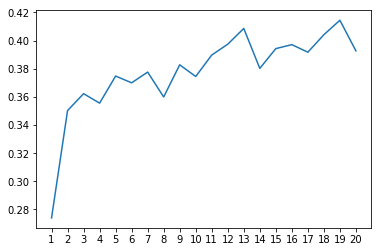

In [293]:
# Show CV
#x = range(start, limit, step)
dfcv = pd.DataFrame(coherence_values_rev1)

axcv = plt.figure(figsize=(6,4)).add_subplot(111)
plt.plot(dfcv.iloc[0].transpose()[:20])
plt.xticks(list(range(1,21,1)))
#plt.ylim(0,1)

In [292]:
dfcv.iloc[0].transpose()[:21]

1     0.274004
2     0.350254
3     0.362270
4     0.355549
5     0.374785
6     0.369992
7     0.377618
8     0.359932
9     0.382771
10    0.374492
11    0.389715
12    0.397428
13    0.408601
14    0.380247
15    0.394279
16    0.397105
17    0.391733
18    0.404140
19    0.414440
20    0.392685
21    0.402440
Name: 0, dtype: float64

(-8.1, -7.93)

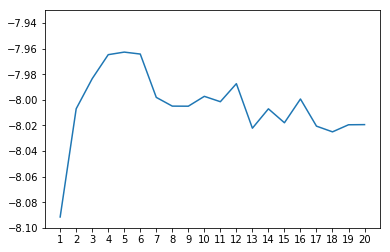

In [295]:
# perplexity
dfp = pd.DataFrame(grid_rev1)
plt.plot((dfp.iloc[0].transpose()[:20]))
plt.xticks(list(range(1,21,1)))
plt.ylim(-8.1,-7.93)

In [ ]:
#np.exp(7.517)

# simple_process


In [ ]:
# Build the bigram and trigram models
%time bigram2 = gensim.models.Phrases(tokenized_text,\
                                     min_count=5, threshold=100) 
# higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
%time bigram_mod2 = gensim.models.phrases.Phraser(bigram2)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# Remove Stop Words
%time data_words_nostops2 = remove_stopwords(tokenized_text)
# Form Bigrams
%time data_words_bigrams2 = make_bigrams(bigram_mod2, data_words_nostops2)

In [ ]:
# Do lemmatization keeping only noun, adj, vb, adv
%time data_lemmatized2 = lemmatization(data_words_bigrams2,\
                                      allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
#create a Gensim dictionary from the texts
%time dictionary2= corpora.Dictionary(data_lemmatized2)
#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
%time dictionary2.filter_extremes(no_below=5, no_above=0.7)

In [ ]:
#convert the dictionary to a bag of words corpus for reference
%time corpus2 = [dictionary2.doc2bow(text2) for text2 in data_lemmatized2]

In [ ]:
####### LDA model
%time ldamodel2 = models.LdaModel(corpus2, num_topics=20, \
                                   id2word=dictionary2, update_every=5,\
                                 chunksize=500, passes=20)

In [ ]:
# Get the topic related words 
topics_matrix2 = ldamodel2.show_topics(formatted=False, num_words=15, num_topics=15)
topics_matrix2 = np.array(topics_matrix2, dtype=object)
topic_words2 = topics_matrix2[:,1]

allls2 = []
allls12 = []
for k2 in range(len(topic_words2)):
    wordls2 = []
    for i2, v2 in topic_words2[k2]:
        wordls2.append(i2)
    print(wordls2)
    allls.append(wordls2)
    allls1.append([wordls2])

In [ ]:
dataprepared2 = pyLDAvis.gensim.prepare(ldamodel2, corpus2, dictionary2)
pyLDAvis.display(dataprepared2)

# calculate topic distribution

In [192]:
from __future__ import absolute_import
import funcy as fp
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from past.builtins import xrange
#from . import prepare as vis_prepare


def _extract_data(topic_model, corpus, dictionary, doc_topic_dists=None):
    import gensim
    if not gensim.matutils.ismatrix(corpus):
        corpus_csc = gensim.matutils.corpus2csc(corpus, num_terms=len(dictionary))
    else:
        corpus_csc = corpus
        # Need corpus to be a streaming gensim list corpus for len and inference functions below:
        corpus = gensim.matutils.Sparse2Corpus(corpus_csc)

    vocab = list(dictionary.token2id.keys())
     # TODO: add the hyperparam to smooth it out? no beta in online LDA impl.. hmm..
    # for now, I'll just make sure we don't ever get zeros...
    beta = 0.01
    fnames_argsort = np.asarray(list(dictionary.token2id.values()), dtype=np.int_)
    term_freqs = corpus_csc.sum(axis=1).A.ravel()[fnames_argsort]
    term_freqs[term_freqs == 0] = beta
    doc_lengths = corpus_csc.sum(axis=0).A.ravel()

    assert term_freqs.shape[0] == len(dictionary), 'Term frequencies and dictionary have different shape {} != {}'.format(term_freqs.shape[0], len(dictionary))
    assert doc_lengths.shape[0] == len(corpus), 'Document lengths and corpus have different sizes {} != {}'.format(doc_lengths.shape[0], len(corpus))

    if hasattr(topic_model, 'lda_alpha'):
        num_topics = len(topic_model.lda_alpha)
    else:
        num_topics = topic_model.num_topics

    if doc_topic_dists is None:
        # If its an HDP model.
        if hasattr(topic_model, 'lda_beta'):
            gamma = topic_model.inference(corpus)
        else:
            gamma, _ = topic_model.inference(corpus)
        doc_topic_dists = gamma / gamma.sum(axis=1)[:, None]
    else:
        if isinstance(doc_topic_dists, list):
            doc_topic_dists = gensim.matutils.corpus2dense(doc_topic_dists, num_topics).T
        elif issparse(doc_topic_dists):
            doc_topic_dists = doc_topic_dists.T.todense()
        doc_topic_dists = doc_topic_dists / doc_topic_dists.sum(axis=1)

    assert doc_topic_dists.shape[1] == num_topics, 'Document topics and number of topics do not match {} != {}'.format(doc_topic_dists.shape[1], num_topics)

    # get the topic-term distribution straight from gensim without
    # iterating over tuples
    if hasattr(topic_model, 'lda_beta'):
        topic = topic_model.lda_beta
    else:
        topic = topic_model.state.get_lambda()
    topic = topic / topic.sum(axis=1)[:, None]
    topic_term_dists = topic[:, fnames_argsort]

    assert topic_term_dists.shape[0] == doc_topic_dists.shape[1]

    d =  {'topic_term_dists': topic_term_dists, 'doc_topic_dists': doc_topic_dists,
           'doc_lengths': doc_lengths, 'vocab': vocab, 'term_frequency': term_freqs}
    return d

In [193]:
do = _extract_data(ldamodel, corpus, dictionary)

In [194]:
dtt = pd.DataFrame(do['doc_topic_dists']).reset_index()

In [ ]:
total_text[0]

In [195]:
dtt['year'] = df_clean['year']

In [196]:
dtt['yr_mnth'] = df_clean['yr_mnth']

In [197]:
dttm = pd.melt(dtt, id_vars=['index','yr_mnth'], value_vars=[0,1,2,3,4,5,6,7,8,9,10,11])

In [198]:
dttm.rename(columns={'index':'doc_index','variable':'topic_no','value':'topic_weight'}, inplace = True)

In [199]:
dtm1 = dttm.pivot(index='doc_index', columns='topic_no', values='topic_weight').fillna(0)

In [200]:
dtm2 = dtm1.div(dtm1.sum(axis=1), axis=0)

# Shift back to a long dataframe
dt_norm2 = dtm2.stack().reset_index()
dt_norm2.columns = ['doc_index', 'topic_id', 'norm_topic_weight']

In [201]:
len(text_ls)

3319

In [202]:
dt_norm21 = dt_norm2.merge(dttm[['yr_mnth','doc_index']] ,on = 'doc_index').drop_duplicates()

In [203]:
#text_ls[674]

In [204]:
#wh[235]

In [222]:
max_df = dt_norm21[dt_norm21.groupby(['doc_index'])['norm_topic_weight'].transform(max) == dt_norm21['norm_topic_weight']]

In [ ]:
total_text[445]

In [ ]:
topic1 = max_df[max_df['topic_id'] == 2]
topic1.sort_values('norm_topic_weight', ascending=False)

In [223]:
max_counts = max_df[['doc_index', 'yr_mnth', 'topic_id']].groupby(['yr_mnth', 'topic_id']).agg({'doc_index' : 'count'}).reset_index()
max_counts.columns = ['yr_mnth', 'topic_id', 'max_count']

In [224]:
# Count the number of individual documents per year
total_docs = max_df[['yr_mnth', 'doc_index']].groupby('yr_mnth').agg({'doc_index' : 'count'}).reset_index()
total_docs.columns = ['yr_mnth', 'total_docs']

In [225]:
total_docs['total_docs'].sum()

3319

In [226]:
# Combine the two dataframes
max_counts = max_counts.merge(total_docs, on='yr_mnth', how='left')

In [227]:
max_counts['prevalence'] = max_counts['max_count']/max_counts['total_docs']


In [228]:
max_counts

yr_mnth  topic_id  max_count  total_docs  prevalence
0    2015-09         7          1           2    0.500000
1    2015-09         8          1           2    0.500000
2    2015-10         7          5          14    0.357143
3    2015-10         8          9          14    0.642857
4    2015-11         8          4           5    0.800000
5    2015-11        11          1           5    0.200000
6    2015-12         2          1           4    0.250000
7    2015-12         7          2           4    0.500000
8    2015-12         8          1           4    0.250000
9    2016-01         8          4           4    1.000000
10   2016-02         0          1          23    0.043478
11   2016-02         2          1          23    0.043478
12   2016-02         7          4          23    0.173913
13   2016-02         8         14          23    0.608696
14   2016-02         9          3          23    0.130435
15   2016-03         6          1           8    0.125000
16   2016-03         7          2           8    0.250000
17   2016-03         8          4           8    0.500000
18   2016-03        11          1           8    0.125000
19   2016-04         0          1          29    0.034483
20   2016-04         3          3          29    0.103448
21   2016-04         4          1          29    0.034483
22   2016-04         6          1          29    0.034483
23   2016-04         7          8          29    0.275862
24   2016-04         8         13          29    0.448276
25   2016-04         9          1          29    0.034483
26   2016-04        11          1          29    0.034483
27   2016-05         2          1          18    0.055556
28   2016-05         3          2          18    0.111111
29   2016-05         6          1          18    0.055556
..       ...       ...        ...         ...         ...
239  2018-05         6         13         410    0.031707
240  2018-05         7         30         410    0.073171
241  2018-05         8         57         410    0.139024
242  2018-05         9         55         410    0.134146
243  2018-05        10         20         410    0.048780
244  2018-05        11         99         410    0.241463
245  2018-06         0          9         347    0.025937
246  2018-06         1          6         347    0.017291
247  2018-06         2         23         347    0.066282
248  2018-06         3         10         347    0.028818
249  2018-06         4         51         347    0.146974
250  2018-06         5         12         347    0.034582
251  2018-06         6          8         347    0.023055
252  2018-06         7         22         347    0.063401
253  2018-06         8         74         347    0.213256
254  2018-06         9         44         347    0.126801
255  2018-06        10         16         347    0.046110
256  2018-06        11         72         347    0.207493
257  2018-07         0          5         201    0.024876
258  2018-07         1          7         201    0.034826
259  2018-07         2         17         201    0.084577
260  2018-07         3          5         201    0.024876
261  2018-07         4         29         201    0.144279
262  2018-07         5         10         201    0.049751
263  2018-07         6          4         201    0.019900
264  2018-07         7          7         201    0.034826
265  2018-07         8         27         201    0.134328
266  2018-07         9         31         201    0.154229
267  2018-07        10          5         201    0.024876
268  2018-07        11         54         201    0.268657

[269 rows x 5 columns]

In [257]:
cm = plt.cm.get_cmap('tab10')
cm_skip = [cm.colors[i] for i in range(len(cm.colors))]

In [266]:
cm_skip = cm_skip + [(0.9245098039, 0.46347, 0.8058823529411765),(0.12, 0.18, 0.34)]

In [260]:
len(cm_skip)

12

In [216]:
xi = [
 2015,
 2016,
 2017,
2018]

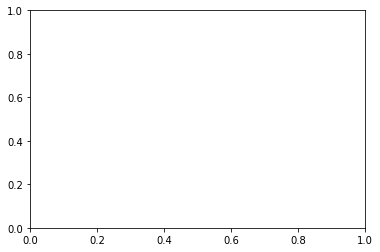

In [302]:
### TOPIC PREVALENCE
#for key, data in max_counts.groupby('topic_id'):
fig, ax3 =plt.subplots()
for i in range(0,12):
    data = (max_counts[max_counts['topic_id'] == i])
    ax3 = data.plot(x='yr_mnth', y='prevalence', 
              label=key, color = cm_skip[i], legend = False, figsize = (11,2))
    ax3.set_ylim(0,0.7)
    #ax3.set_xlim(-0.5,0.5)
    ax3.set_facecolor("white")
    ax3.spines['left'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    #ax2.set_ylim(0,250)
    ax3.set_xlabel('')
    #plt.xticks(data['yr_mnth'])
    name = "Topic #" + str(i+1) +'pv_by_year21'
    plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
    plt.savefig(str(name)+'.png',dpi=800,facecolor='w',bbox_inches = 'tight')    
    plt.close()

In [229]:
max_counts['yr_mnth'] = pd.to_datetime(max_counts['yr_mnth'])

In [244]:
max_counts =max_counts[max_counts['yr_mnth']>max_counts['yr_mnth'].iloc[48]]

In [250]:
cm_skip[11]

IndexError: list index out of range

In [ ]:
#max_counts.groupby('topic_id').count()
for key, data in max_counts.groupby('topic_id'):
    print(data)

In [277]:
fig, ax4 =plt.subplots()
mylabels = ['Topic 1','Topic 2',
           'Topic 3','Topic 4',
           'Topic 5','Topic 6',
           'Topic 7','Topic 8',
           'Topic 9','Topic 10','Topic11','Topic12']
for key, data in max_counts.groupby('topic_id'):
    #print(key)
    #data.plot(x='year', y='prevalence', ax=ax, label=key)
    #data = nn1
    ax4 = data.plot(x='yr_mnth', y='prevalence', ax = ax4,
              label=key, color = cm_skip[key], figsize = (15,8))
    ax4.set_ylim(0,0.8)
    #ax3.set_xlim(-0.5,0.5)
    ax4.set_facecolor("white")
    ax4.spines['left'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    #ax2.set_ylim(0,250)
    ax4.set_xlabel('')
    #plt.xticks(xi)
    #plt.xticks(data['year'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
               labels=mylabels,frameon=False)
    #name = str(i+1) +'pv_by_p'
    plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
    plt.savefig('total_trend_topic.png', dpi=800,facecolor='w',bbox_inches='tight')    
    plt.close()

In [ ]:
pd.DataFrame(allls)

# Graph

In [ ]:
NUMDOCS = 60 # number of subreddits OR number of BBC documents per category
NUMTOPICS = 10
def toVector(l):
    ''' inserts 0s for unrepresented topics in a document
        input: return value from ldamodel.get_document_topics(corpus[i])
        output: document topics with 0s for unrepresented topics'''
    ret = []
    t = 0
    for i in range(NUMTOPICS):
        if t == len(l):
            ret += [0]
        elif l[t][0] == i + 1:
            ret += [l[t][1]]
            t = t + 1
        else:
            ret += [0]
    return ret

In [ ]:
#text_ls#

In [ ]:
EPS = 0.001
numDocs = len(text_ls)
# note: this can take a long time on large corpora
similarity = [[0 for x in range(numDocs)] for y in range(numDocs)]

for i in range(numDocs):
    itops = toVector(ldamodel.get_document_topics(corpus[i]))
    for j in range(numDocs)[i:]:
        jtops = toVector(ldamodel.get_document_topics(corpus[j]))
        sim = 1.0 - gensim.matutils.hellinger(itops, jtops)
        sim = min(sim + EPS, 1.0)
        
        similarity[i][j] = sim


In [ ]:
type(similarity)

In [ ]:
import pickle

In [ ]:
with open('similarity','wb') as f:
    pickle.dump(similarity,f)

In [ ]:
d = pickle.load(open('similarity', 'rb'))

In [ ]:
len(d)

In [191]:
# Wordclouds
wc = WordCloud(
    background_color="white",
    max_words=200,
    width=800,
    height=600,
    stopwords= stops#,
    #colormap = "Greens"#stopwords.words('english')
)
#WordCloud().fit_words(dict(lda.show_topic(t, 200)))
for t in range(ldamodel.num_topics):
    name = "Topic #" + str(t+1)
    plt.figure().subplots_adjust(bottom=0, top=1, left=0, right=1)
    plt.imshow(wc.fit_words(dict(ldamodel.show_topic(t, 300))))
    plt.axis("off")
    plt.title("Topic #" + str(t+1))
    
    plt.savefig(str(name)+'.png', dpi=300,facecolor='w',bbox_inches="tight", pad_inches = 0)
    plt.close()
    #plt.close()
    #plt.show()